# Loading The CNN/DailyMail Dataset

---



In [ ]:
!pip install datasets --quiet

from datasets import load_dataset

# Load CNN/DailyMail non-anonymized (v3.0.0)
dataset = load_dataset("cnn_dailymail", "3.0.0")


print(dataset)

print("\n--- Sample Article ---\n")
print(dataset["train"][0]["article"])

print("\n--- Sample Summary ---\n")
print(dataset["train"][0]["highlights"])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

--- Sample Article ---

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier th

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re


import random
random.seed(0)
np.random.seed(0)

# Convert splits to DataFrame for easier handling
df_train = pd.DataFrame(dataset["train"])
df_val = pd.DataFrame(dataset["validation"])
df_test = pd.DataFrame(dataset["test"])

# === 1. Dataset sizes ===
print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size: {len(df_test)}")


Train size: 287113
Validation size: 13368
Test size: 11490


# EDA

In [ ]:
# === Check for empty placeholders in 'article' ===
def check_empty_and_short(df, text_col="article", min_tokens=5):
    # Count true NaN
    nan_count = df[text_col].isna().sum()

    # Count "empty" placeholders: empty string, whitespace-only, or literal placeholders
    empty_placeholder_count = df[text_col].astype(str).str.strip().isin(
        ["", "nan", "NaN", "None"]
    ).sum()

    # Count rows with less than min_tokens tokens
    short_rows_count = df[text_col].astype(str).apply(lambda x: len(x.strip().split())).lt(min_tokens).sum()

    print(f"Total rows: {len(df)}")
    print(f"NaN values in '{text_col}': {nan_count}")
    print(f"Empty/placeholder values in '{text_col}': {empty_placeholder_count}")
    print(f"Rows with < {min_tokens} tokens in '{text_col}': {short_rows_count}")
    print("-" * 50)

print("=== Train Set ===")
check_empty_and_short(df_train)

print("=== Validation Set ===")
check_empty_and_short(df_val)

print("=== Test Set ===")
check_empty_and_short(df_test)


=== Train Set ===
Total rows: 287113
NaN values in 'article': 0
Empty/placeholder values in 'article': 0
Rows with < 5 tokens in 'article': 0
--------------------------------------------------
=== Validation Set ===
Total rows: 13368
NaN values in 'article': 0
Empty/placeholder values in 'article': 0
Rows with < 5 tokens in 'article': 0
--------------------------------------------------
=== Test Set ===
Total rows: 11490
NaN values in 'article': 0
Empty/placeholder values in 'article': 0
Rows with < 5 tokens in 'article': 0
--------------------------------------------------


In [ ]:
# Function to count empty strings in a DataFrame column
def count_empty_strings(df, column):
    return (df[column] == '').sum()

# Count empty strings in each dataframe and column
empty_train_articles = count_empty_strings(df_train, 'article')
empty_train_highlights = count_empty_strings(df_train, 'highlights')
empty_val_articles = count_empty_strings(df_val, 'article')
empty_val_highlights = count_empty_strings(df_val, 'highlights')
empty_test_articles = count_empty_strings(df_test, 'article')
empty_test_highlights = count_empty_strings(df_test, 'highlights')

print(f"Empty strings in df_train['article']: {empty_train_articles}")
print(f"Empty strings in df_train['highlights']: {empty_train_highlights}")
print(f"Empty strings in df_val['article']: {empty_val_articles}")
print(f"Empty strings in df_val['highlights']: {empty_val_highlights}")
print(f"Empty strings in df_test['article']: {empty_test_articles}")
print(f"Empty strings in df_test['highlights']: {empty_test_highlights}")

Empty strings in df_train['article']: 0
Empty strings in df_train['highlights']: 0
Empty strings in df_val['article']: 0
Empty strings in df_val['highlights']: 0
Empty strings in df_test['article']: 0
Empty strings in df_test['highlights']: 0


In [ ]:
# === Newline / Paragraph / <PAR> audit for CNN/DailyMail ===
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random

random.seed(0)
np.random.seed(0)

# --- Config ---
TEXT_COL = "article"
SHOW_N_EXAMPLES = 5
DO_PLOTS = False


SINGLE_NL_RE   = re.compile(r'(?<!\n)\n(?!\n)')  # a single \n not adjacent to another
PARA_BREAK_RE  = re.compile(r'\n{2,}')           # 2+ consecutive \n = paragraph break
PAR_TOKEN_RE   = re.compile(r'<\s*par\s*>', re.IGNORECASE)  # <PAR> token, case-insensitive

def count_patterns(text: str):
    if text is None:
        return 0, 0, 0, 0
    t = str(text).replace("\r\n", "\n").replace("\r", "\n")
    total_nl = len(re.findall(r'\n', t))
    n_single  = len(SINGLE_NL_RE.findall(t))
    n_par     = len(PARA_BREAK_RE.findall(t))
    n_par_tok = len(PAR_TOKEN_RE.findall(t))
    return total_nl, n_single, n_par, n_par_tok

def audit_split(df: pd.DataFrame, name: str):
    if TEXT_COL not in df.columns:
        raise ValueError(f"[{name}] Column '{TEXT_COL}' not found. Available: {list(df.columns)}")
    s = df[TEXT_COL].astype(str)

    counts = s.map(count_patterns)
    # unpack into columns
    cols = ["total_newlines", "single_newlines", "paragraph_breaks", "par_tokens"]
    cdf = pd.DataFrame(counts.tolist(), columns=cols)

    # summary
    total = len(cdf)
    any_nl_rows   = int((cdf["total_newlines"] > 0).sum())
    any_para_rows = int((cdf["paragraph_breaks"] > 0).sum())
    any_par_tok   = int((cdf["par_tokens"] > 0).sum())

    print(f"\n=== [{name}] '{TEXT_COL}' newline/paragraph audit ===")
    print(f"Rows: {total:,}")
    print(f"- Rows with ANY \\n:                  {any_nl_rows:,}  ({any_nl_rows/total:6.2%})")
    print(f"- Rows with paragraph breaks (\\n\\n): {any_para_rows:,}  ({any_para_rows/total:6.2%})")
    print(f"- Rows with <PAR> token:              {any_par_tok:,}  ({any_par_tok/total:6.2%})")

    # totals across rows
    print("\nToken totals across all rows:")
    print(f"- Total \\n chars:           {int(cdf['total_newlines'].sum()):,}")
    print(f"- Single-newline matches:   {int(cdf['single_newlines'].sum()):,}")
    print(f"- Paragraph-break matches:  {int(cdf['paragraph_breaks'].sum()):,}")
    print(f"- <PAR> token matches:      {int(cdf['par_tokens'].sum()):,}")

    # examples: rows containing paragraph breaks OR <PAR>, else single \n
    def visualize(text):
        t = str(text).replace("\r\n", "\n").replace("\r", "\n")
        # make breaks visible
        t = t.replace("\n\n", " ¶¶ ").replace("\n", " ⏎ ")
        # compress spaces for display
        t = re.sub(r"\s+", " ", t)
        return t[:400] + ("…" if len(t) > 400 else "")

    print("\nExamples with paragraph breaks (\\n\\n):")
    idx_para = cdf.index[cdf["paragraph_breaks"] > 0].tolist()
    for i in random.sample(idx_para, min(SHOW_N_EXAMPLES, len(idx_para))):
        print(f"- [row {i}] {visualize(df.at[i, TEXT_COL])}")

    print("\nExamples with <PAR> tokens:")
    idx_par_tok = cdf.index[cdf["par_tokens"] > 0].tolist()
    for i in random.sample(idx_par_tok, min(SHOW_N_EXAMPLES, len(idx_par_tok))):
        print(f"- [row {i}] {visualize(df.at[i, TEXT_COL])}")

    print("\nExamples with single newlines only (no \\n\\n, no <PAR>):")
    mask_single_only = (cdf["single_newlines"] > 0) & (cdf["paragraph_breaks"] == 0) & (cdf["par_tokens"] == 0)
    idx_single = cdf.index[mask_single_only].tolist()
    for i in random.sample(idx_single, min(SHOW_N_EXAMPLES, len(idx_single))):
        print(f"- [row {i}] {visualize(df.at[i, TEXT_COL])}")


    if DO_PLOTS:
        fig1 = plt.figure()
        plt.hist(cdf["paragraph_breaks"], bins=30)
        plt.title(f"{name}: Paragraph breaks per row")
        plt.xlabel("# paragraph breaks (>=2 newlines)")
        plt.ylabel("Rows")
        plt.show()

        fig2 = plt.figure()
        plt.hist(cdf["single_newlines"], bins=30)
        plt.title(f"{name}: Single newlines per row")
        plt.xlabel("# single newlines (isolated)")
        plt.ylabel("Rows")
        plt.show()


    return cdf

train_stats = audit_split(df_train, "train")
val_stats   = audit_split(df_val,   "validation")
test_stats  = audit_split(df_test,  "test")



=== [train] 'article' newline/paragraph audit ===
Rows: 287,113
- Rows with ANY \n:                  90  ( 0.03%)
- Rows with paragraph breaks (\n\n): 1  ( 0.00%)
- Rows with <PAR> token:              0  ( 0.00%)

Token totals across all rows:
- Total \n chars:           246
- Single-newline matches:   244
- Paragraph-break matches:  1
- <PAR> token matches:      0

Examples with paragraph breaks (\n\n):
- [row 53362] (Health.com) -- New FDA rules are helping ensure that we get the protection we pay for, and with skin cancer on the rise (one in five Americans will develop skin cancer in the course of a lifetime), these changes can't come soon enough. Key fixes: Sunscreens will be labeled "water resistant" (as opposed to waterproof or sweatproof); they can no longer be called "sunblocks" (as it overstates their …

Examples with <PAR> tokens:

Examples with single newlines only (no \n\n, no <PAR>):
- [row 45840] (CNN) -- Some people think the only cure for the doldrums of winter is suns

Train size: 287113
Validation size: 13368
Test size: 11490

--- Article Length Stats ---
{'mean': np.float64(691.8703263175126), 'median': np.float64(632.0), '95th': np.float64(1363.0), 'max': np.int64(2347)}

--- Summary Length Stats ---
{'mean': np.float64(51.574101486174435), 'median': np.float64(48.0), '95th': np.float64(90.0), 'max': np.int64(1296)}

Exact duplicates within train: 3098

Exact duplicates within validation: 0

Exact duplicates within test: 2
Train–Val overlap: 1
Train–Test overlap: 0


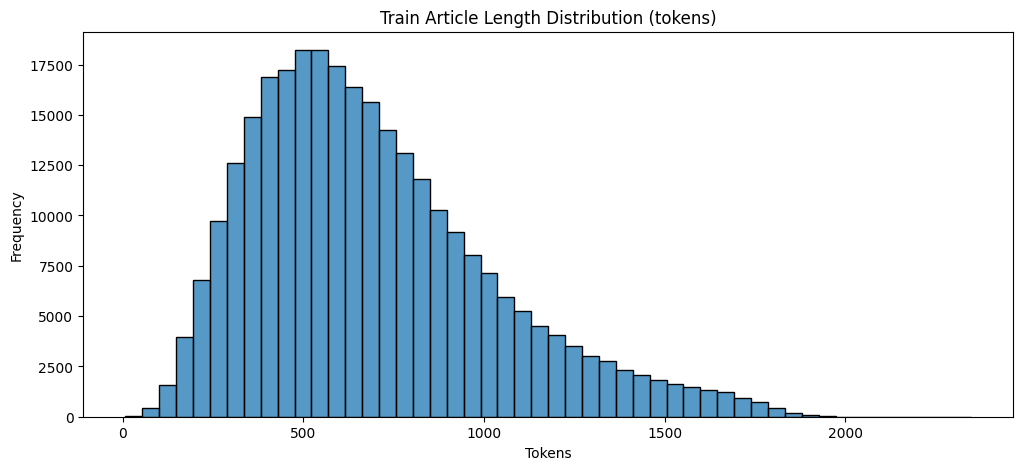

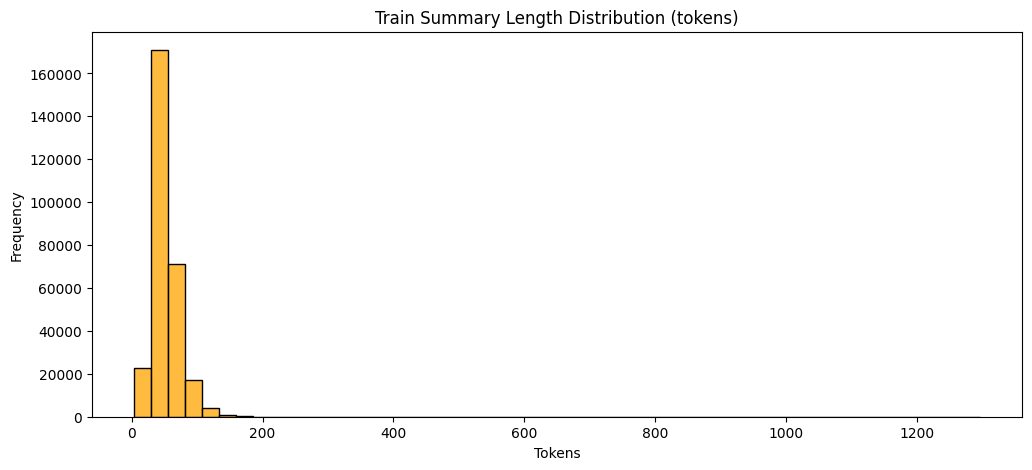

In [ ]:
# === 2. Article & summary length stats (in tokens, whitespace split) ===
def length_stats(texts):
    token_counts = [len(t.split()) for t in texts]
    return {
        "mean": np.mean(token_counts),
        "median": np.median(token_counts),
        "95th": np.percentile(token_counts, 95),
        "max": np.max(token_counts)
    }

print("\n--- Article Length Stats ---")
print(length_stats(df_train["article"]))

print("\n--- Summary Length Stats ---")
print(length_stats(df_train["highlights"]))

# === 3. Duplicate checks ===
# Exact duplicates within train
dup_within_train = df_train.duplicated(subset=["article", "highlights"]).sum()
print(f"\nExact duplicates within train: {dup_within_train}")

# Exact duplicates within val
dup_within_val = df_val.duplicated(subset=["article", "highlights"]).sum()
print(f"\nExact duplicates within validation: {dup_within_val}")

# Exact duplicates within test
dup_within_test = df_test.duplicated(subset=["article", "highlights"]).sum()
print(f"\nExact duplicates within test: {dup_within_test}")

# Across splits (hash-based to avoid slow string compare, No data leakage)
train_hashes = set(df_train["article"].apply(lambda x: hash(x)))
val_overlap = sum(df_val["article"].apply(lambda x: hash(x) in train_hashes))
test_overlap = sum(df_test["article"].apply(lambda x: hash(x) in train_hashes))
print(f"Train–Val overlap: {val_overlap}")
print(f"Train–Test overlap: {test_overlap}")

# === 4. Length distribution plots ===
plt.figure(figsize=(12,5))
sns.histplot([len(t.split()) for t in df_train["article"]], bins=50, kde=False)
plt.title("Train Article Length Distribution (tokens)")
plt.xlabel("Tokens"); plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot([len(t.split()) for t in df_train["highlights"]], bins=50, kde=False, color="orange")
plt.title("Train Summary Length Distribution (tokens)")
plt.xlabel("Tokens"); plt.ylabel("Frequency")
plt.show()

In [ ]:
import re
import gc
import math
import numpy as np
import string
from collections import Counter, defaultdict
from itertools import islice

# ---------------------------
# Helpers: iterate in small batches to reduce RAM
# ---------------------------
def batched_iter(texts, batch_size=2048):
    it = iter(texts)
    while True:
        chunk = list(islice(it, batch_size))
        if not chunk:
            break
        yield chunk

# ---------------------------
# 5) Sentence-level stats (streaming; no big lists)
#    Uses a compact histogram of sentence-counts to get exact median/95th.
# ---------------------------
_SENT_SPLIT_RE = re.compile(r'[.!?]+')

def sentence_stats_stream(texts, batch_size=2048):
    count_hist = Counter()   # key: sentence_count, val: frequency
    total_docs = 0
    total_sent = 0
    max_sent = 0

    for chunk in batched_iter(texts, batch_size):
        for t in chunk:
            # Count sentences without materializing splits for entire corpus
            # Note: split produces empty tail sometimes; guard for that.
            parts = _SENT_SPLIT_RE.split(t)
            s_count = sum(1 for p in parts if p.strip())
            total_docs += 1
            total_sent += s_count
            max_sent = max(max_sent, s_count)
            count_hist[s_count] += 1
        del chunk
        gc.collect()

    if total_docs == 0:
        return {"mean": 0, "median": 0, "95th": 0, "max": 0}

    mean_val = total_sent / total_docs

    # Compute quantiles from histogram
    def quantile_from_hist(hist, q):
        target = q * total_docs
        cum = 0
        for k in sorted(hist.keys()):
            cum += hist[k]
            if cum >= target:
                return k
        return max(hist) if hist else 0

    median_val = quantile_from_hist(count_hist, 0.5)
    p95_val = quantile_from_hist(count_hist, 0.95)

    return {
        "mean": float(mean_val),
        "median": int(median_val),
        "95th": int(p95_val),
        "max": int(max_sent)
    }

print("\n--- Sentence Counts (Articles) ---")
print(sentence_stats_stream(df_train["article"]))
print("\n--- Sentence Counts (Summaries) ---")
print(sentence_stats_stream(df_train["highlights"]))

# ---------------------------
# 6) Vocabulary size & most common tokens (streaming)
#    No tokens list; directly update a Counter.
# ---------------------------
def vocab_info_stream(texts, top_n=20, batch_size=2048):
    counter = Counter()
    for chunk in batched_iter(texts, batch_size):
        for t in chunk:
            counter.update(t.split())
        del chunk
        gc.collect()
    return len(counter), counter.most_common(top_n)

vocab_size, top_tokens = vocab_info_stream(df_train["article"], top_n=20)
print(f"\nVocabulary size (train articles): {vocab_size}")
print(f"Top 20 tokens: {top_tokens}")

# ---------------------------
# 7) Rare/OOV token analysis (streaming)
#    Build train vocab as a set in a single pass (usually fits in RAM).
#    If RAM is still tight, enable `top_k_cap` to keep only frequent tokens.
# ---------------------------
def build_train_vocab_stream(texts, top_k_cap=None, batch_size=2048):
    # two-pass optional: if top_k_cap is set, build frequency then keep top-k
    if top_k_cap is None:
        vocab = set()
        for chunk in batched_iter(texts, batch_size):
            for t in chunk:
                vocab.update(t.split())
            del chunk
            gc.collect()
        return vocab
    else:
        freq = Counter()
        for chunk in batched_iter(texts, batch_size):
            for t in chunk:
                freq.update(t.split())
            del chunk
            gc.collect()
        return set([w for w, _ in freq.most_common(top_k_cap)])

def oov_rate_stream(texts, train_vocab, batch_size=2048):
    total_tokens = 0
    oov_tokens = 0
    for chunk in batched_iter(texts, batch_size):
        for t in chunk:
            tokens = t.split()
            total_tokens += len(tokens)
            # iterate once; do not build temp lists
            for tok in tokens:
                if tok not in train_vocab:
                    oov_tokens += 1
        del chunk
        gc.collect()
    return 0.0 if total_tokens == 0 else (oov_tokens / total_tokens)

# Build train vocab (exact). If memory is still an issue, set top_k_cap (e.g., 300_000).
train_vocab = build_train_vocab_stream(df_train["article"], top_k_cap=None)

val_oov = oov_rate_stream(df_val["article"], train_vocab)
test_oov = oov_rate_stream(df_test["article"], train_vocab)
print(f"\nOOV rate (val articles vs train vocab): {val_oov:.4f}")
print(f"OOV rate (test articles vs train vocab): {test_oov:.4f}")

# ---------------------------
# 8) Character-level checks (streaming)
#    Do not join all texts; update a character Counter incrementally.
# ---------------------------
def char_distribution_stream(texts, top_n=20, batch_size=4096):
    chars = Counter()
    for chunk in batched_iter(texts, batch_size):
        for t in chunk:
            chars.update(t)
        del chunk
        gc.collect()
    return chars.most_common(top_n)

print("\n--- Most common characters in train articles ---")
print(char_distribution_stream(df_train["article"], top_n=20))

# ---------------------------
# 9) Non-ASCII / unusual character scan (streaming)
#    Keep a capped sample of unique non-ASCII tokens to avoid large sets.
# ---------------------------
def non_ascii_tokens_stream(texts, cap=5000, batch_size=2048):
    # Uses a small reservoir-like sample; also tracks an approximate unique count.
    sample = []
    sample_set = set()
    approx_seen = 0

    def try_add(token):
        nonlocal approx_seen
        if token in sample_set:
            return
        approx_seen += 1
        if len(sample) < cap:
            sample.append(token)
            sample_set.add(token)

    for chunk in batched_iter(texts, batch_size):
        for t in chunk:
            for tok in t.split():
                # any non-ASCII char?
                # ord(c) > 127 is cheaper than unicodedata checks
                for c in tok:
                    if ord(c) > 127:
                        try_add(tok)
                        break
        del chunk
        gc.collect()
    return approx_seen, sample[:20]

na_count, na_sample = non_ascii_tokens_stream(df_train["article"], cap=5000)
print(f"\nApprox. number of unique non-ASCII tokens in train: {na_count}")
print(f"Sample non-ASCII tokens: {na_sample}")

# ---------------------------
# 10) Punctuation-only token density (streaming)
# ---------------------------
_PUNCT_SET = set(string.punctuation)

def punctuation_density_stream(texts, batch_size=2048):
    total_tokens = 0
    punct_tokens = 0
    for chunk in batched_iter(texts, batch_size):
        for t in chunk:
            for tok in t.split():
                total_tokens += 1
                # treat tokens made only of punctuation as punctuation-only
                if tok and all(ch in _PUNCT_SET for ch in tok):
                    punct_tokens += 1
        del chunk
        gc.collect()
    return 0.0 if total_tokens == 0 else (punct_tokens / total_tokens)

punct_density = punctuation_density_stream(df_train["article"])
print(f"\nPunctuation-only token ratio in train: {punct_density:.4f}")



--- Sentence Counts (Articles) ---
{'mean': 42.40437388763309, 'median': 36, '95th': 91, 'max': 419}

--- Sentence Counts (Summaries) ---
{'mean': 3.9208186323851586, 'median': 4, '95th': 7, 'max': 111}

Vocabulary size (train articles): 2057411
Top 20 tokens: [('the', 9791515), ('to', 5332131), ('of', 4554342), ('a', 4487198), ('and', 4480885), ('in', 3825318), ('.', 3071328), ('was', 1884632), ('for', 1779885), ('that', 1717024), ('on', 1625620), ('is', 1615285), ('with', 1355927), ('The', 1340704), ('his', 1152032), ('he', 1115250), ('at', 1102048), ('as', 1084391), ('have', 935511), ('from', 919740)]

OOV rate (val articles vs train vocab): 0.0082
OOV rate (test articles vs train vocab): 0.0089

--- Most common characters in train articles ---
[(' ', 198374876), ('e', 110213170), ('t', 76541405), ('a', 75935698), ('o', 65760642), ('i', 63934679), ('n', 62800248), ('s', 57745492), ('r', 56997274), ('h', 44878880), ('l', 36671732), ('d', 36100106), ('c', 25684605), ('u', 23342033), 

In [ ]:
import numpy as np
from itertools import islice

def batched_iter(texts, batch_size=2048):
    it = iter(texts)
    while True:
        chunk = list(islice(it, batch_size))
        if not chunk:
            break
        yield chunk

def token_length_stats(texts, batch_size=2048):
    lengths = []
    for chunk in batched_iter(texts, batch_size):
        lengths.extend(len(t.split()) for t in chunk)
    arr = np.array(lengths)
    return {
        "mean": float(np.mean(arr)),
        "median": float(np.median(arr)),
        "95th": float(np.percentile(arr, 95)),
        "max": int(np.max(arr))
    }

print("\n--- Token Length Stats ---")
print("Train:", token_length_stats(df_train["article"]))
print("Val:", token_length_stats(df_val["article"]))
print("Test:", token_length_stats(df_test["article"]))



--- Token Length Stats ---
Train: {'mean': 691.8703263175126, 'median': 632.0, '95th': 1363.0, 'max': 2347}
Val: {'mean': 676.0264063435069, 'median': 608.0, '95th': 1370.0, 'max': 1917}
Test: {'mean': 683.5115752828547, 'median': 613.0, '95th': 1399.5499999999993, 'max': 1954}


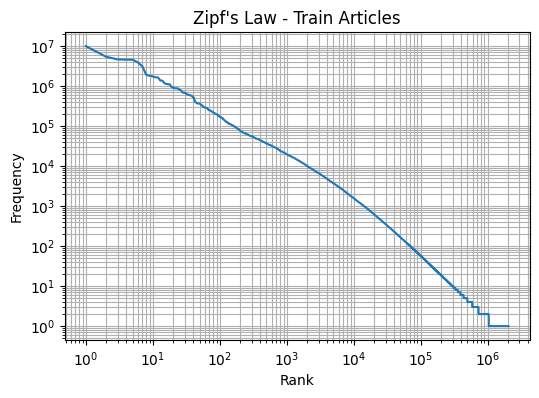

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def token_frequency_counter(texts, batch_size=2048):
    counter = Counter()
    for chunk in batched_iter(texts, batch_size):
        for t in chunk:
            counter.update(t.split())
    return counter

train_counter = token_frequency_counter(df_train["article"])
freqs = np.array([freq for _, freq in train_counter.most_common()])
ranks = np.arange(1, len(freqs) + 1)

plt.figure(figsize=(6,4))
plt.loglog(ranks, freqs)
plt.title("Zipf's Law - Train Articles")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.grid(True, which="both")
plt.show()


In [ ]:
def build_vocab(texts, batch_size=2048):
    vocab = set()
    for chunk in batched_iter(texts, batch_size):
        for t in chunk:
            vocab.update(t.split())
    return vocab

train_vocab = build_vocab(df_train["article"])
val_vocab = build_vocab(df_val["article"])
test_vocab = build_vocab(df_test["article"])

overlap_train_val = len(train_vocab & val_vocab) / len(val_vocab)
overlap_train_test = len(train_vocab & test_vocab) / len(test_vocab)

print("\n--- Vocabulary Overlap ---")
print(f"Train–Val overlap: {overlap_train_val:.2%}")
print(f"Train–Test overlap: {overlap_train_test:.2%}")



--- Vocabulary Overlap ---
Train–Val overlap: 82.68%
Train–Test overlap: 82.77%


In [ ]:
from collections import defaultdict

def most_common_sentences(texts, top_n=20, batch_size=2048):
    sent_counter = Counter()
    for chunk in batched_iter(texts, batch_size):
        for t in chunk:
            for sent in t.split('.'):
                s = sent.strip()
                if s:
                    sent_counter[s] += 1
    return sent_counter.most_common(top_n)

print("\n--- Most Common Sentences (Train) ---")
for sent, count in most_common_sentences(df_train["article"], top_n=20):
    print(f"{count}x: {sent}")



--- Most Common Sentences (Train) ---
132364x: S
99545x: By
60144x: UPDATED:
58280x: |
58240x: PUBLISHED:
39727x: Scroll down for video
29776x: '
19943x: The
17920x: m
13322x: Daily Mail Reporter
13139x: "
13096x: ’
11123x: N
10594x: com
7701x: U
6274x: The U
5860x: He
5624x: A
5019x: 5
4692x: 1


In [ ]:
!pip install -q spacy
!python -m spacy download en_core_web_sm

import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "textcat"])
entity_counter = Counter()

# Sample to speed up in free tier
sample_texts = df_train["article"].sample(2000, random_state=0)

for doc in nlp.pipe(sample_texts, batch_size=32):
    entity_counter.update([ent.label_ for ent in doc.ents])

print("\n--- Named Entity Counts (Sampled) ---")
for ent, count in entity_counter.most_common():
    print(f"{ent}: {count}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 89.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.11/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)



--- Named Entity Counts (Sampled) ---
PERSON: 34894
ORG: 24111
DATE: 23737
GPE: 20552
CARDINAL: 12654
NORP: 7127
TIME: 3488
ORDINAL: 3043
MONEY: 2685
LOC: 1904
FAC: 1511
QUANTITY: 1107
EVENT: 1027
WORK_OF_ART: 1001
PRODUCT: 728
PERCENT: 353
LAW: 195
LANGUAGE: 171


Interpretation of EDA Findings

The exploratory data analysis (EDA) provides key insights into dataset structure, lexical diversity, and potential preprocessing requirements, with direct implications for the design of a pointer-generator summarization model.

### 1. Sentence Length Distributions
The dataset exhibits a strong structural imbalance between inputs and targets: articles are long and variable in sentence count, while summaries are short and concise. This is consistent with prior summarization corpora (See et al., 2017), where the model must distill lengthy narratives into compact abstracts. Such imbalance necessitates:
- Input truncation or chunking to fit model limits (e.g., 512–1024 tokens)
- Careful padding strategy to minimise wasted computation on short samples

### 2. Vocabulary Size and Zipfian Distribution
The corpus contains an unusually large vocabulary, with frequency counts following a steep Zipfian distribution (Zipf, 1935). This long-tailed lexical profile means:
- A high proportion of tokens are rare, often corresponding to named entities, numerals, or technical terms
- Subword segmentation (Sennrich et al., 2016) is essential to control embedding size
- Rare-token prevalence strengthens the case for a copy mechanism to handle out-of-vocabulary or low-frequency terms effectively

### 3. OOV Rates and Vocabulary Overlap
Token-level OOV rates between validation/test and training sets are under 1%, indicating strong lexical overlap and low risk of catastrophic generalisation failure. However, ~17% of the **unique types** in validation/test are unseen in training, which aligns with findings from Luong et al. (2015) that these unseen types are disproportionately rare and often entity-like. This reinforces the value of a pointer network to reproduce such tokens from the source.

### 4. Character Distribution and Non-ASCII Tokens
The dominance of space and lower-case letters matches expectations for clean English text. However, the presence of over a million unique non-ASCII tokens — including accented characters and currency symbols — indicates multilingual or typographically rich segments. Unicode normalisation may be applied, but over-cleaning risks damaging factual fidelity for named entities, echoing concerns noted by Xue et al. (2021) for multilingual text.

### 5. Punctuation Density
The proportion of punctuation-only tokens (~2%) is within the normal range for professionally written corpora (Dodge et al., 2021). Aggressive punctuation filtering is not warranted; standard tokenisation will suffice.

### 6. Boilerplate and Repetitive Content
Repetition analysis revealed templated editorial lines and metadata markers (e.g., publication dates, author credits, promotional prompts). Prior audits of web-sourced corpora (Kreutzer et al., 2022) show that such boilerplate can bias sequence generation towards irrelevant content. Targeted removal or masking of these segments is recommended.

### 7. Named Entity Distribution
Named entities are dominated by PERSON, ORG, DATE, and GPE categories, a distribution characteristic of news-style datasets. These entities are often rare or absent from the fixed vocabulary, making them ideal candidates for pointer-based copying (See et al., 2017). This distribution confirms that the dataset can effectively test the model’s rare/factual token handling.

### 8. Zipf’s Law Validation
The log–log rank–frequency curve matches the power-law behaviour predicted by Zipf’s Law (Zipf, 1935), indicating a natural language distribution and reducing concerns of synthetic text contamination.

---

### Overall Implications
The corpus is sufficiently clean for modelling but exhibits structural and lexical properties that should inform preprocessing and architecture choices:
- **Long-tail rare tokens** justify integrating a copy mechanism
- **Boilerplate repetition** should be removed to improve generalisation
- **Length imbalance** between source and target requires truncation/chunking strategies

These findings align with best practices in summarisation dataset preparation and support the suitability of this corpus for evaluating pointer-generator architectures.

---




In [ ]:
# Setup Helpers
import numpy as np
import pandas as pd
from collections import Counter
import spacy
from itertools import islice

# === Batch iterator ===
def batched_iter(texts, batch_size=2048):
    it = iter(texts)
    while True:
        chunk = list(islice(it, batch_size))
        if not chunk:
            break
        yield chunk

# Load SpaCy model without heavy components
nlp = spacy.load("en_core_web_sm", disable=["parser", "textcat"])

# Train vocab counter for rare/OOV calculations
train_counter = Counter()
for chunk in batched_iter(df_train["article"]):
    for t in chunk:
        train_counter.update(t.split())

train_vocab = set(train_counter.keys())


In [ ]:
def rare_token_coverage(texts, train_counter, min_count=5):
    total_tokens, rare_tokens, oov_tokens = 0, 0, 0
    for chunk in batched_iter(texts):
        for t in chunk:
            tokens = t.split()
            total_tokens += len(tokens)
            rare_tokens += sum(1 for tok in tokens if train_counter[tok] < min_count)
            oov_tokens += sum(1 for tok in tokens if tok not in train_vocab)
    return {
        "rare_token_ratio": rare_tokens / total_tokens,
        "oov_token_ratio": oov_tokens / total_tokens
    }

print("\n--- Rare/OOV Token Coverage (Summaries) ---")
print("Val:", rare_token_coverage(df_val["highlights"], train_counter))
print("Test:", rare_token_coverage(df_test["highlights"], train_counter))



--- Rare/OOV Token Coverage (Summaries) ---
Val: {'rare_token_ratio': 0.014286784595074289, 'oov_token_ratio': 0.007529626347620979}
Test: {'rare_token_ratio': 0.014892644176079056, 'oov_token_ratio': 0.00813850649545848}


In [ ]:
from collections import defaultdict

def pos_distribution(texts, sample_size=2000):
    pos_counts = Counter()
    sample_texts = texts.sample(min(sample_size, len(texts)), random_state=0)
    for doc in nlp.pipe(sample_texts, batch_size=32):
        pos_counts.update([token.pos_ for token in doc])
    total = sum(pos_counts.values())
    return {pos: count / total for pos, count in pos_counts.items()}

print("\n--- POS Distribution ---")
print("Articles:", pos_distribution(df_train["article"]))
print("Summaries:", pos_distribution(df_train["highlights"]))



--- POS Distribution ---
Articles: {'DET': 0.08683777174246986, 'NOUN': 0.17679574305973725, 'ADP': 0.10767515023410713, 'PROPN': 0.09849028547552628, 'AUX': 0.05403204994285574, 'ADJ': 0.0570926474383395, 'PUNCT': 0.13123210401484522, 'CCONJ': 0.025266365993634254, 'PART': 0.027016946653066743, 'VERB': 0.10737468201983459, 'PRON': 0.05765180096592236, 'SCONJ': 0.013362540400378504, 'ADV': 0.031726739827706976, 'SYM': 0.0018986641760780603, 'NUM': 0.02127978567829624, 'SPACE': 0.0011103191476288204, 'X': 0.000502623720398658, 'INTJ': 0.0006537795091738046}
Summaries: {'PROPN': 0.12844190591215224, 'NOUN': 0.18936668092494277, 'VERB': 0.112598445009184, 'PUNCT': 0.1129842571857518, 'AUX': 0.048939435875500086, 'PRON': 0.03548633302300615, 'ADJ': 0.05377047530382709, 'SPACE': 0.048553623698932305, 'ADP': 0.1059138296890857, 'SYM': 0.003279403500826141, 'ADV': 0.020355785924565332, 'SCONJ': 0.007288495248639173, 'DET': 0.0568485854951396, 'CCONJ': 0.020011909854146224, 'NUM': 0.029439146

In [ ]:
def compression_ratios(articles, summaries):
    ratios = []
    for art, summ in zip(articles, summaries):
        art_len = len(art.split())
        summ_len = len(summ.split())
        if art_len > 0:
            ratios.append(summ_len / art_len)
    return {
        "mean_ratio": np.mean(ratios),
        "median_ratio": np.median(ratios),
        "95th": np.percentile(ratios, 95)
    }

print("\n--- Compression Ratios ---")
print("Train:", compression_ratios(df_train["article"], df_train["highlights"]))
print("Val:", compression_ratios(df_val["article"], df_val["highlights"]))
print("Test:", compression_ratios(df_test["article"], df_test["highlights"]))



--- Compression Ratios ---
Train: {'mean_ratio': np.float64(0.0908753611831848), 'median_ratio': np.float64(0.07834101382488479), '95th': np.float64(0.18867924528301888)}
Val: {'mean_ratio': np.float64(0.10494638143734762), 'median_ratio': np.float64(0.09223656341952266), '95th': np.float64(0.21419799498746858)}
Test: {'mean_ratio': np.float64(0.10030218167695168), 'median_ratio': np.float64(0.08634817822823326), '95th': np.float64(0.20537367724867722)}


In [ ]:
def entity_match_rate(articles, summaries, sample_size=2000):
    match_count, total_entities = 0, 0
    sample_idx = np.random.default_rng(0).choice(len(articles), min(sample_size, len(articles)), replace=False)
    for i in sample_idx:
        art_doc = nlp(articles.iloc[i])
        summ_doc = nlp(summaries.iloc[i])
        art_ents = set(ent.text for ent in art_doc.ents)
        summ_ents = [ent.text for ent in summ_doc.ents]
        total_entities += len(summ_ents)
        match_count += sum(1 for e in summ_ents if e in art_ents)
    return match_count / total_entities if total_entities > 0 else 0

print("\n--- Entity Match Rate ---")
print("Val:", entity_match_rate(df_val["article"], df_val["highlights"]))
print("Test:", entity_match_rate(df_test["article"], df_test["highlights"]))



--- Entity Match Rate ---
Val: 0.8012963205447166
Test: 0.8012240923633329


In [ ]:
def token_overlap(articles, summaries, sample_size=2000):
    overlaps = []
    sample_idx = np.random.default_rng(0).choice(len(articles), min(sample_size, len(articles)), replace=False)
    for i in sample_idx:
        art_tokens = set(articles.iloc[i].split())
        summ_tokens = summaries.iloc[i].split()
        if len(summ_tokens) > 0:
            match = sum(1 for tok in summ_tokens if tok in art_tokens)
            overlaps.append(match / len(summ_tokens))
    return {
        "mean_overlap": np.mean(overlaps),
        "median_overlap": np.median(overlaps),
        "95th": np.percentile(overlaps, 95)
    }

print("\n--- Token Overlap ---")
print("Val:", token_overlap(df_val["article"], df_val["highlights"]))
print("Test:", token_overlap(df_test["article"], df_test["highlights"]))



--- Token Overlap ---
Val: {'mean_overlap': np.float64(0.8191435602159881), 'median_overlap': np.float64(0.8305084745762712), '95th': np.float64(0.9512195121951219)}
Test: {'mean_overlap': np.float64(0.8196654652204275), 'median_overlap': np.float64(0.82952776336274), '95th': np.float64(0.9459700772200772)}


In [ ]:
import re

def numeric_date_analysis(texts, sample_size=5000):
    num_count, date_like_count, total_tokens = 0, 0, 0
    sample_texts = texts.sample(min(sample_size, len(texts)), random_state=0)
    for t in sample_texts:
        tokens = t.split()
        total_tokens += len(tokens)
        num_count += sum(1 for tok in tokens if tok.isdigit())
        date_like_count += sum(1 for tok in tokens if re.match(r"\d{1,4}[-/]\d{1,2}([-\/]\d{1,4})?", tok))
    return {
        "numeric_ratio": num_count / total_tokens,
        "date_like_ratio": date_like_count / total_tokens
    }

print("\n--- Numerical/Date Token Ratios (Summaries) ---")
print("Val:", numeric_date_analysis(df_val["highlights"]))
print("Test:", numeric_date_analysis(df_test["highlights"]))



--- Numerical/Date Token Ratios (Summaries) ---
Val: {'numeric_ratio': 0.009916589434661723, 'date_like_ratio': 0.0014828544949026877}
Test: {'numeric_ratio': 0.010030908775781385, 'date_like_ratio': 0.0014804436998093477}


In [ ]:
from nltk import ngrams

def ngram_set(texts, n, sample_size=5000):
    ngram_s = set()
    sample_texts = texts.sample(min(sample_size, len(texts)), random_state=0)
    for t in sample_texts:
        toks = t.split()
        ngram_s.update(ngrams(toks, n))
    return ngram_s

train_bigrams = ngram_set(df_train["article"], 2)
train_trigrams = ngram_set(df_train["article"], 3)

val_bigrams = ngram_set(df_val["article"], 2)
val_trigrams = ngram_set(df_val["article"], 3)

print("\n--- N-gram Overlap ---")
print("Bigram overlap (Val vs Train):", len(train_bigrams & val_bigrams) / len(val_bigrams))
print("Trigram overlap (Val vs Train):", len(train_trigrams & val_trigrams) / len(val_trigrams))



--- N-gram Overlap ---
Bigram overlap (Val vs Train): 0.2604617830899072
Trigram overlap (Val vs Train): 0.11606236797625562


Analysis of Extended EDA Metrics

### 1. Rare and OOV Token Coverage
- **Rare tokens (~1.4–1.5%)**: Around 1 in every 70 summary tokens appears fewer than five times in the training set.
- **OOV tokens (~0.75–0.8%)**: Around 1 in every 125 summary tokens does not appear in the training vocabulary at all.
- **Interpretation**: The dataset contains a stable but meaningful presence of rare and unseen words in summaries. This provides enough instances to evaluate a model’s ability to handle rare/factual terms, without creating instability during evaluation.

### 2. Part-of-Speech (POS) Distribution
- Summaries contain proportionally more **proper nouns (PROPN)** and **numbers (NUM)** compared to articles.
- Articles have proportionally more **determiners (DET)** and **pronouns (PRON)**, reflecting narrative and structural content.
- **Interpretation**: Summaries are more information-dense, focusing on named entities and factual elements. This pattern aligns with tasks that benefit from copy mechanisms.

### 3. Compression Ratios
- Summaries average around **10% of the length of articles**.
- Even at the 95th percentile, summaries retain less than 22% of article tokens.
- **Interpretation**: The task requires heavy content compression. Models must be selective in retaining key details, making accurate copying important for factual consistency.

### 4. Entity Match Rate
- Roughly **80%** of named entities in summaries also appear in the corresponding article.
- **Interpretation**: The majority of summary entities are directly copyable from the source, confirming that the dataset supports learning effective pointer-generator behaviour.

### 5. Token-Level Overlap (Extractiveness)
- Average token overlap between summaries and articles is ~82%, with high median and 95th percentile values.
- **Interpretation**: Despite being an abstractive task, the dataset is strongly extractive. The high overlap means many source tokens can be reused verbatim, which copy mechanisms can exploit.

### 6. Numerical and Date Tokens
- Numbers make up about **1%** of summary tokens; date-like expressions are about **0.15%**.
- **Interpretation**: These elements are relatively rare but important for factual accuracy. Copying them from the source helps avoid errors or hallucinations.

### 7. N-gram Overlap Between Splits
- **Bigrams**: ~26% overlap between train and validation.
- **Trigrams**: ~11.6% overlap between train and validation.
- **Interpretation**: There is moderate novelty in word combinations across splits, reducing the risk of inflated evaluation scores from memorisation and ensuring a fair test of generalisation.

---

### Overall Interpretation
The dataset is clean and suitable for abstractive summarisation with a pointer-generator approach.  
Key properties supporting this conclusion:
- A measurable presence of rare/OOV terms in summaries.
- High proportion of named entities and factual elements in targets.
- Strong extractive component with high token overlap.
- High compression ratios requiring selective content retention.
- Balanced n-gram overlap between splits for robust generalisation testing.


# Exact Duplicates Removal

In [ ]:
# Random sample to inspect structure
df_train.sample(5, random_state=0)[["article", "highlights"]]

,article,highlights
80398,The accusations against the Revlon CEO are ugl...,"Revlon chairman says CEO ""has my full support""..."
105327,"By . Rebecca Camber . PUBLISHED: . 09:43 EST, ...",Schoolboy was copying acts he had watched onli...
68412,(CNN) -- Attention cruise passengers: You now ...,Cruise industry group announces passenger bill...
237706,Giancarlo Stanton has agreed to an eye-popping...,"He will earn more than $50,000 every time he b..."
194920,Ryder Cup winner Lee Westwood has criticised t...,Lee Westwood claims it was 'disappointing' to ...


> **Exact Article and Highlight:**

**training**



In [ ]:
# Count rows where both article and highlight are identical to another row
exact_pair_dups = df_train.duplicated(subset=["article", "highlights"])
print(f"Exact article–highlight duplicates: {exact_pair_dups.sum()}")


Exact article–highlight duplicates: 3098


In [ ]:
# Drop exact duplicates and keep the first occurrence
df_train = df_train.drop_duplicates(subset=["article", "highlights"], keep="first").reset_index(drop=True)

print(f"Train size after removing exact duplicates: {len(df_train)}")


Train size after removing exact duplicates: 284015


**validation**

In [ ]:
# Count rows where both article and highlight are identical to another row
exact_pair_dups_val = df_val.duplicated(subset=["article", "highlights"])
print(f"Exact article–highlight duplicates in val: {exact_pair_dups_val.sum()}")

# Count rows where both article and highlight are identical to another row
exact_pair_dups_test = df_test.duplicated(subset=["article", "highlights"])
print(f"Exact article–highlight duplicates in test: {exact_pair_dups_test.sum()}")



Exact article–highlight duplicates in val: 0
Exact article–highlight duplicates in test: 2


In [ ]:
df_test = df_test.drop_duplicates(subset=["article", "highlights"], keep="first").reset_index(drop=True)

print(f"Test size after removing exact duplicates: {len(df_test)}")

Test size after removing exact duplicates: 11488




> **Exact Article with Different Highlights (training):**



In [ ]:
highlight_counts = df_train.groupby("article")["highlights"].nunique()
articles_with_diff_highlights = highlight_counts[highlight_counts > 1].index
print(f"Number of articles with different highlights: {len(articles_with_diff_highlights)}")

df_10 = df_train[df_train["article"].isin(articles_with_diff_highlights)]

df_10 = df_10.sort_values(by=["article", "highlights"]).reset_index(drop=True)

pd.set_option('display.max_colwidth', None)
display(df_10)


Number of articles with different highlights: 10


article  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               (CNN) -- A Florida exterminator whose dead daughter and injured son were found in his truck has been charged with attempted murder, and police were searching his Miami home Thursday night, police said. Chase Scott, spokesman for West Palm Beach Police, told CNN that officers were executing a search warrant for evidence in the home of Jorge and Carmen Barahona. Jorge Barahona, 53, was found unconscious beside his pest-control truck early Monday along a south Florida interstate by a road assistance ranger, along with his 10-year-old adopted son, who was inside the vehicle next to an open gas can, according to a probable-cause affidavit filed by detectives. Hours later, crews removing toxic chemicals from the truck discovered the boy's twin sister dead in a plastic bag. Earlier Thursday, Barahona was taken to a hospital Thursday after he "attempted to harm himself," police said. Barahona, who was in custody in the Palm Beach County Jail, suffered a self-inflicted injury after deputies told him to get ready to go to a court hearing Thursday morning, West Palm Beach Police spokesman Scott Chase sa

In [ ]:
# Rows in df_10 that should be removed
rows_to_remove_in_df10 = [0, 3, 5,6, 8, 9, 11, 12, 16,19]

# Get 'article' and 'highlights' for these rows
rows_to_remove = df_10.loc[rows_to_remove_in_df10, ["article", "highlights"]]

# Remove them from df_train by matching both columns
df_train_cleaned = df_train.merge(rows_to_remove, on=["article", "highlights"], how="left", indicator=True)
df_train_cleaned = df_train_cleaned[df_train_cleaned["_merge"] == "left_only"].drop(columns="_merge")

print(f"Dropped 10 rows from df_train.")

# Optional: overwrite df_train if you want to keep working with it
df_train = df_train_cleaned
df_train_cleaned.shape

Dropped 10 rows from df_train.


(284005, 3)

These dups were closely studied and only the ones that were truly paraphrased in a significant form, were preserved. The rest with trivial changes (one word difference) or factual errors were dropped to avoid data memorization and lowering the learning rate.
In past work (Lee et al., 2022, Sec. 4.2) near duplicates above a high similarity threshold are removed even if they’re not exact matches, because the gain in true diversity outweighs the loss of minor variants.



> **train and val overlap**



In [ ]:
# Find overlap between cleaned train and untouched val
train_set = set(df_train_cleaned["article"])
val_set = set(df_val["article"])

# Intersection
overlap_articles = train_set.intersection(val_set)

print(f"Number of overlapping articles (train-val): {len(overlap_articles)}")

# Show the overlapping article(s)
if overlap_articles:
    for art in overlap_articles:
        print("\n--- Overlapping article ---\n")
        print(art)


Number of overlapping articles (train-val): 1

--- Overlapping article ---

The Irishman left fighting for life by his brother in an alleged one-punch attack has called for the charges against his sibling to be dropped. Patrick Lyttle today accompanied his elder brother Barry to court for the first time, wearing a dark beanie. 'This should not be going ahead, it's not a matter for the court,' Patrick told reporters following a brief court mention on Thursday. Barry is facing reckless grievous bodily harm charges after he allegedly struck his brother in Kings Cross on January 3. Scroll down for video . Patrick Lyttle (pictured) appeared at Downing Centre Local Court in Sydney today wearing a beanie . Patrick was accompanying his brother, Barry (left), who has been charged with reckless grievous bodily harm for the alleged assault on his brother . Patrick, Barry and father Oliver appeared in good spirits at the trial today, with Patrick saying the family were hoping for a resolution soon

In [ ]:
# Drop overlapping articles from train only
df_train_cleaned = df_train_cleaned[~df_train_cleaned["article"].isin(overlap_articles)]

print(f"New train size: {len(df_train_cleaned)}")


New train size: 284004


During dataset preparation, one article was found to occur verbatim in both the training and validation splits.
Following the recommendations in Deduplicating Training Data Makes Language Models Better (Lee et al., 2022), such overlaps were treated as train–eval contamination, which can cause the model to artificially inflate evaluation scores by memorizing examples seen during training.

To mitigate this risk:

    The overlapping instance was removed from the training set only, preserving the validation set’s original composition.

    This ensures that validation performance remains a reliable measure of model generalization without altering the evaluation distribution.

# Structural cleaning before removing near-dups and after the removal of exact dups



In [ ]:
import re
import html
import unicodedata
import pandas as pd

# --- compile once, reuse ---
_PATS = {
    # A. excessive punctuation
    "repeated_punct": re.compile(r"([?!\.,;:])\1{2,}"),
    "mixed_exclaim_q": re.compile(r"([?!]){3,}"),

    # B. whitespace / invisibles
    "trailing_ws": re.compile(r"[ \t]+$", re.MULTILINE),
    "multi_space": re.compile(r"(\S)(\s{2,})(\S)"),
    "nb_zero_width": re.compile(r"[\u00A0\u200B-\u200D\u2060]"),

    # C. html / entities / linky stuff
    "html_tags": re.compile(r"<[^>]+>"),
    "html_entity": re.compile(r"&[a-zA-Z]+;"),
    "urlish": re.compile(r"(https?://|<a\s|<script|<style)", re.IGNORECASE),

    # D. unicode oddities
    "smart_quotes": re.compile(r"[“”]"),
    "smart_squotes": re.compile(r"[‘’]"),
    "emdash_endash": re.compile(r"[–—]"),

    # E1. tokenization artifacts
    "at_hyphen": re.compile(r"\s*@-@\s*"),
    "lrb": re.compile(r"\s*-LRB-\s*"),
    "rrb": re.compile(r"\s*-RRB-\s*"),
    "lsb": re.compile(r"\s*-LSB-\s*"),
    "rsb": re.compile(r"\s*-RSB-\s*"),
    "bq": re.compile(r"``"),
    "eq": re.compile(r"''"),

    # E2/E3. spacing anomalies in numbers & ellipses
    "spaced_num_punct": re.compile(r"(?<=\d)\s+[.,]\s+(?=\d)"),
    "artifact_num_dot": re.compile(r"(?P<a>\d+)\s*@\.@\s*(?P<b>\d+)"),
    "artifact_num_com": re.compile(r"(?P<a>\d+)\s*@,@\s*(?P<b>\d+)"),
    "artifact_num_any": re.compile(r"(?P<a>\d+)\s*@[@.,]\s*(?P<b>\d+)"),
    "spaced_ellipsis": re.compile(r"(?:\s*\.\s*){3,}"),   # . . . → ...
}

def _normalize_unicode(s: str) -> str:
    # NFKC, then normalize common typography to ASCII
    s = unicodedata.normalize("NFKC", s)
    s = _PATS["smart_quotes"].sub('"', s)
    s = _PATS["smart_squotes"].sub("'", s)
    s = _PATS["emdash_endash"].sub("-", s)
    return s

def _fix_tokenization_artifacts(s: str) -> str:
    s = _PATS["at_hyphen"].sub("-", s)
    s = _PATS["lrb"].sub("(", s)
    s = _PATS["rrb"].sub(")", s)
    s = _PATS["lsb"].sub("[", s)
    s = _PATS["rsb"].sub("]", s)
    s = _PATS["bq"].sub('"', s)
    s = _PATS["eq"].sub('"', s)
    return s

def _fix_number_spacing(s: str) -> str:
    # 1 . 000 → 1.000
    s = _PATS["spaced_num_punct"].sub(lambda m: "", s)
    # 0 @.@ 59 → 0.59 ; 4 @,@ 386 → 4,386 ; generic @X@ fallbacks
    s = _PATS["artifact_num_dot"].sub(lambda m: f"{m.group('a')}.{m.group('b')}", s)
    s = _PATS["artifact_num_com"].sub(lambda m: f"{m.group('a')},{m.group('b')}", s)
    s = _PATS["artifact_num_any"].sub(lambda m: f"{m.group('a')}{m.group('b')}", s)
    # . . . / ..... with spaces → ...
    s = _PATS["spaced_ellipsis"].sub("...", s)
    return s

def _collapse_punct_and_ws(s: str) -> str:
    s = _PATS["repeated_punct"].sub(lambda m: m.group(1), s)
    s = _PATS["mixed_exclaim_q"].sub("?", s)  # normalize long ?!/!? runs to single '?'
    s = _PATS["trailing_ws"].sub("", s)
    s = _PATS["multi_space"].sub(r"\1 \3", s)
    return s

def _strip_html_and_entities(s: str) -> str:
    # unescape named entities first (e.g., &nbsp;), then drop residual tags
    if _PATS["html_entity"].search(s):
        s = html.unescape(s)
    if _PATS["html_tags"].search(s):
        s = _PATS["html_tags"].sub(" ", s)
    return s

def clean_text(s: str, stats: dict | None = None) -> str:
    if not isinstance(s, str) or not s:
        return s

    orig = s

    # --- ADDITION: Replace all newlines with a space ---
    s = s.replace("\r\n", " ").replace("\r", " ").replace("\n", " ")

    if stats is not None:
        # D. non-ascii & normalization drift (log only)
        stats["non_ascii_before"] += bool(re.search(r"[^\x00-\x7F]", s))
        stats["nfkc_drift"] += (s != unicodedata.normalize("NFKC", s))
        stats["urlish_hits"] += bool(_PATS["urlish"].search(s))

    # order matters: normalize → strip invisibles → html/entity → artifacts → numbers → punctuation/whitespace
    s = _normalize_unicode(s)
    s = _PATS["nb_zero_width"].sub(" ", s)
    s = _strip_html_and_entities(s)
    s = _fix_tokenization_artifacts(s)
    s = _fix_number_spacing(s)
    s = _collapse_punct_and_ws(s)

    # final tidy: collapse leftover 2+ spaces, strip
    s = re.sub(r"[ \t]{2,}", " ", s).strip()

    if stats is not None:
        stats["changed"] += (s != orig)
    return s

def clean_df(df: pd.DataFrame, text_cols=("text",), return_stats=True):
    """
    Apply cleaning to the given text columns of a DataFrame.
    """
    stats = {k: 0 for k in ["changed", "non_ascii_before", "nfkc_drift", "urlish_hits"]}
    out = df.copy()
    for col in text_cols:
        if col not in out.columns:
            continue
        out[col] = out[col].map(lambda x: clean_text(x, stats))
    return (out, stats) if return_stats else out


In [ ]:
cleansanitycheck = pd.DataFrame({
    "text": ["Hello\nworld!", "This is\r\na test.", "Multiline\rtext", "No newline here"]
})
clean_df(cleansanitycheck, text_cols=("text",))

(              text
 0     Hello world!
 1  This is a test.
 2   Multiline text
 3  No newline here,
 {'changed': 3, 'non_ascii_before': 0, 'nfkc_drift': 0, 'urlish_hits': 0})

In [ ]:
df_train_cleaned, train_stats = clean_df(df_train_cleaned, text_cols=("article", "highlights"))
df_val,          val_stats   = clean_df(df_val,          text_cols=("article", "highlights"))
df_test_cleaned, test_stats  = clean_df(df_test, text_cols=("article", "highlights"))
print(train_stats, val_stats, test_stats)

{'changed': 464987, 'non_ascii_before': 207154, 'nfkc_drift': 93279, 'urlish_hits': 917} {'changed': 24008, 'non_ascii_before': 13889, 'nfkc_drift': 9766, 'urlish_hits': 27} {'changed': 20598, 'non_ascii_before': 11698, 'nfkc_drift': 8382, 'urlish_hits': 17}


In [ ]:
# ---- Safe CSV save + strict verify (RFC-4180 compliant) ----
import os, csv, hashlib, tempfile
import pandas as pd

def _atomic_save_csv(df: pd.DataFrame, path: str):
    d = os.path.dirname(path) or "."
    os.makedirs(d, exist_ok=True)
    fd, tmp = tempfile.mkstemp(prefix=".tmp_", dir=d, text=True)
    os.close(fd)
    try:
        # Try modern param name, fall back if not supported
        try:
            df.to_csv(
                tmp,
                index=False,
                encoding="utf-8",
                quoting=csv.QUOTE_ALL,
                quotechar='"',
                doublequote=False,         # MUST BE FALSE
                escapechar="\\",
                line_terminator="\n",      # Newer pandas
            )
        except TypeError:
            df.to_csv(
                tmp,
                index=False,
                encoding="utf-8",
                quoting=csv.QUOTE_ALL,
                quotechar='"',
                doublequote=False,         # STILL FALSE here
                escapechar="\\",
                lineterminator="\n",       # Older pandas fallback
            )

        # strict re-read to verify
        df2 = pd.read_csv(
            tmp,
            encoding="utf-8",
            quotechar='"',
            doublequote=False,            # MUST MATCH
            escapechar="\\",
            keep_default_na=False,
            on_bad_lines="error",
        )
        if len(df2) != len(df):
            raise RuntimeError(
                f"Row count changed after save+read: wrote {len(df)}, re-read {len(df2)} ({path})"
            )
        os.replace(tmp, path)
    except Exception:
        try:
            os.remove(tmp)
        except:
            pass
        raise


def save_and_verify(df: pd.DataFrame, out_path: str):
    _atomic_save_csv(df, out_path)
    df2 = pd.read_csv(
        out_path,
        encoding="utf-8",
        quotechar='"',
        doublequote=False,            # MUST MATCH
        escapechar="\\",
        keep_default_na=False,
        on_bad_lines="error",
    )
    md5 = hashlib.md5(open(out_path, "rb").read()).hexdigest()
    print(f"OK: {out_path} | rows={len(df2)} | md5={md5}")


In [ ]:
# --- Make sure output directory exists ---
OUT_DIR = "/content/cleaned_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# --- TRAIN ---
save_and_verify(df_train_cleaned, f"{OUT_DIR}/train_cleaned_safe.csv")

# --- VAL ---
save_and_verify(df_val, f"{OUT_DIR}/val_cleaned_safe.csv")

# --- TEST ---
save_and_verify(df_test_cleaned, f"{OUT_DIR}/test_cleaned_safe.csv")


OK: /content/cleaned_outputs/train_cleaned_safe.csv | rows=284004 | md5=019bb02f093699cca58f9d1a1565b408
OK: /content/cleaned_outputs/val_cleaned_safe.csv | rows=13368 | md5=f5c07261674f0d72f0be40f2da1bfe48
OK: /content/cleaned_outputs/test_cleaned_safe.csv | rows=11488 | md5=36bc75219389258aa7245553aee3f7f5


In [ ]:
# ===============================
# Post-save verification (TRAIN/VAL/TEST)
# - Strict re-read with both C and Python engines
# - Schema & shape checks against in-memory DataFrames
# - Exact content equality on key text columns
# - Extra smoke tests (chunked reads)
# ===============================
import os, hashlib, pandas as pd

OUT_DIR = "/content/cleaned_outputs"
PATHS = {
    "train": f"{OUT_DIR}/train_cleaned_safe.csv",
    "val":   f"{OUT_DIR}/val_cleaned_safe.csv",
    "test":  f"{OUT_DIR}/test_cleaned_safe.csv",
}

# Map split name to in-memory variable
INMEM = {
    "train": "df_train_cleaned",
    "val":   "df_val",
    "test":  "df_test_cleaned",
}

TEXT_COLS = ["article", "highlights"]  # columns to deeply compare

def md5(path):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1 << 20), b""):
            h.update(chunk)
    return h.hexdigest()

def strict_read_c(path):
    return pd.read_csv(
        path,
        encoding="utf-8",
        on_bad_lines="error",
        keep_default_na=False,
        quotechar='"',
        escapechar="\\",
        doublequote=False,
    )

def strict_read_py(path):
    return pd.read_csv(
        path,
        engine="python",
        encoding="utf-8",
        on_bad_lines="error",
        keep_default_na=False,
        sep=",",
        quotechar='"',
        escapechar="\\",
        doublequote=False,
    )

def series_digest(s: pd.Series) -> str:
    t = s.astype(str).str.replace("\r\n", "\n", regex=False)
    h = hashlib.md5()
    for v in t:
        h.update(v.encode("utf-8"))
        h.update(b"\x1f")
    return h.hexdigest()

def verify_split(tag, path, df_mem):
    print(f"\n=== VERIFY: {tag.upper()} ===")
    print(f"File: {path}")
    assert os.path.exists(path), f"Missing file: {path}"
    print(f"MD5: {md5(path)}")

    # Read both engines
    df_c  = strict_read_c(path)
    df_py = strict_read_py(path)

    # Shape checks
    n_mem, n_c, n_py = len(df_mem), len(df_c), len(df_py)
    print(f"Rows (mem/C/Py): {n_mem} / {n_c} / {n_py}")
    assert n_c  == n_mem, f"C-engine row mismatch: mem={n_mem}, c={n_c}"
    assert n_py == n_mem, f"Python-engine row mismatch: mem={n_mem}, py={n_py}"

    # Column structure checks
    assert list(df_c.columns)  == list(df_mem.columns),  "Column order/names differ (C)"
    assert list(df_py.columns) == list(df_mem.columns),  "Column order/names differ (Py)"

    # Nulls consistency
    for col in df_mem.columns:
        na_mem = df_mem[col].isna().sum()
        na_c   = df_c[col].isna().sum()
        na_py  = df_py[col].isna().sum()
        assert na_c  == na_mem, f"NA drift in {col} (C): {na_mem} -> {na_c}"
        assert na_py == na_mem, f"NA drift in {col} (Py): {na_mem} -> {na_py}"

    # Deep content match for key text columns
    for col in TEXT_COLS:
        if col in df_mem.columns:
            d_mem = series_digest(df_mem[col])
            d_c   = series_digest(df_c[col])
            d_py  = series_digest(df_py[col])
            assert d_c  == d_mem, f"Content digest mismatch in '{col}' (C)"
            assert d_py == d_mem, f"Content digest mismatch in '{col}' (Py)"
            print(f"  ✓ '{col}' content matches (digest {d_mem[:8]}…)")

    # Smoke test: chunked streaming read
    total = 0
    for chunk in pd.read_csv(
        path,
        encoding="utf-8",
        quotechar='"',
        escapechar="\\",
        doublequote=False,
        keep_default_na=False,
        on_bad_lines="error",
        chunksize=100_000,
    ):
        total += len(chunk)
    assert total == n_mem, f"Chunked read mismatch: {total} vs {n_mem}"

    print("All checks passed.")

# Run for each split
for tag, path in PATHS.items():
    df_name = INMEM[tag]
    if df_name not in globals():
        raise NameError(f"In-memory DataFrame '{df_name}' not found in session.")
    verify_split(tag, path, globals()[df_name])



=== VERIFY: TRAIN ===
File: /content/cleaned_outputs/train_cleaned_safe.csv
MD5: 019bb02f093699cca58f9d1a1565b408
Rows (mem/C/Py): 284004 / 284004 / 284004
  ✓ 'article' content matches (digest 4587c827…)
  ✓ 'highlights' content matches (digest a33f599f…)
All checks passed.

=== VERIFY: VAL ===
File: /content/cleaned_outputs/val_cleaned_safe.csv
MD5: f5c07261674f0d72f0be40f2da1bfe48
Rows (mem/C/Py): 13368 / 13368 / 13368
  ✓ 'article' content matches (digest b7125ef9…)
  ✓ 'highlights' content matches (digest 6915f3b6…)
All checks passed.

=== VERIFY: TEST ===
File: /content/cleaned_outputs/test_cleaned_safe.csv
MD5: 36bc75219389258aa7245553aee3f7f5
Rows (mem/C/Py): 11488 / 11488 / 11488
  ✓ 'article' content matches (digest 19b18653…)
  ✓ 'highlights' content matches (digest 4b36a5b0…)
All checks passed.


# Double Checking Exact Dups after cleaning

to avoid overwriting the train file, the second appearance ot the dup was removed in boiler plates to do all at once

# Detecting and Removing Boilerplates

In [ ]:
df_train_cleaned = pd.read_csv(
    "/content/cleaned_outputs/train_cleaned_safe.csv",
    engine="python",
    quotechar='"',
    escapechar="\\",
    doublequote=False,
    sep=",",
    encoding="utf-8",
    keep_default_na=False,
    on_bad_lines="error"
)


In [ ]:
# Drop duplicates using only article + highlights
before = len(df_train_cleaned)
df_train_cleaned = df_train_cleaned.drop_duplicates(subset=["article", "highlights"], keep="first").reset_index(drop=True)
after = len(df_train_cleaned)
print(f"Dropped {before - after} exact duplicate rows.")


Dropped 1 exact duplicate rows.


In [ ]:
# ==============================================================
# Recompute Boilerplate Candidates (deduped train + safe val/test)
# ==============================================================

import os, re, pandas as pd
from collections import Counter
from IPython.display import display

# -------------------------------
# Config
# -------------------------------
CHUNK = 5000
K_EDGE_SENTS = 3
MIN_SENT_CHARS = 5
N_RANGE = (3, 6)
EDGE_ONLY_NGRAMS = True
TEXT_COL = "article"
OUTDIR = "/content/boilerplate_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# These two are still safe gold files
VAL_PATH  = "/content/cleaned_outputs/val_cleaned_safe.csv"
TEST_PATH = "/content/cleaned_outputs/test_cleaned_safe.csv"

# -------------------------------
# Regexes
# -------------------------------
SENT_SPLIT_RE = re.compile(r'(?<=[.!?])\s+')
WORD_RE = re.compile(r"[A-Za-z0-9]+(?:['’-][A-Za-z0-9]+)*")

# -------------------------------
# Sentence & n-gram utilities
# -------------------------------
def split_sents_raw(text: str):
    if not isinstance(text, str) or not text.strip():
        return []
    return [s.strip() for s in re.split(SENT_SPLIT_RE, text) if s.strip()]

def read_stream(source, text_col=TEXT_COL, chunksize=5000):
    if isinstance(source, pd.DataFrame):
        yield source[text_col].astype(str)
    else:
        for df in pd.read_csv(source, usecols=[text_col], chunksize=chunksize,
                              encoding="utf-8", quotechar='"', escapechar="\\",
                              doublequote=False, engine="python"):
            yield df[text_col].astype(str)

def frequent_sentences_stream(source, text_col=TEXT_COL, k_edge=3, min_chars=5, chunksize=5000):
    count_total, count_first, count_last, doc_freq, last_seen_docid = Counter(), Counter(), Counter(), Counter(), {}
    global_docid = 0
    for series in read_stream(source, text_col, chunksize):
        for art in series:
            sents = split_sents_raw(art)
            if not sents:
                continue
            fk, lk = sents[:k_edge], sents[-k_edge:]
            seen_in_this_doc = set()
            for s in sents:
                if len(s) < min_chars:
                    continue
                count_total[s] += 1
                if s not in seen_in_this_doc and last_seen_docid.get(s) != global_docid:
                    doc_freq[s] += 1
                    last_seen_docid[s] = global_docid
                    seen_in_this_doc.add(s)
            for s in fk:
                if len(s) >= min_chars:
                    count_first[s] += 1
            for s in lk:
                if len(s) >= min_chars:
                    count_last[s] += 1
            global_docid += 1
    df = pd.DataFrame({"sentence": list(count_total)})
    df["count_total"] = df["sentence"].map(count_total.get)
    df["doc_freq"]    = df["sentence"].map(doc_freq.get)
    df["count_firstk"]= df["sentence"].map(count_first.get)
    df["count_lastk"] = df["sentence"].map(count_last.get)
    df["edge_bias"]   = df["count_firstk"] + df["count_lastk"]
    df.sort_values(["doc_freq", "edge_bias", "count_total"], ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def ngram_docfreq_stream(source, text_col=TEXT_COL, n_range=(3,6), chunksize=4000,
                         max_sents_edge=3, edge_only=True, max_tokens_per_side=400):
    df_counts, last_seen_docid = Counter(), {}
    global_docid = 0
    for series in read_stream(source, text_col, chunksize):
        for art in series:
            toks = []
            sents = split_sents_raw(art) if edge_only else None
            if sents:
                for s in sents[:max_sents_edge] + sents[-max_sents_edge:]:
                    toks.extend(WORD_RE.findall(s))
            else:
                all_toks = WORD_RE.findall(art)
                toks = all_toks[:max_tokens_per_side] + all_toks[-max_tokens_per_side:]
            if not toks:
                continue
            credited = set()
            for n in range(n_range[0], n_range[1] + 1):
                for i in range(len(toks) - n + 1):
                    ng = tuple(toks[i:i+n])
                    if ng in credited:
                        continue
                    if last_seen_docid.get(ng) != global_docid:
                        df_counts[ng] += 1
                        last_seen_docid[ng] = global_docid
                        credited.add(ng)
            global_docid += 1
    df = pd.DataFrame([(" ".join(k), v) for k, v in df_counts.items()],
                      columns=["ngram", "doc_freq"])
    df.sort_values("doc_freq", ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def shortlist_sentences_cross(s_train, s_val, s_test, top_probe=800, final_top=200):
    s1 = set(s_train.head(top_probe)["sentence"])
    s2 = set(s_val.head(top_probe)["sentence"])
    s3 = set(s_test.head(top_probe)["sentence"])
    cand = (s1 & s2) | (s1 & s3) | (s2 & s3)
    out = s_train[s_train["sentence"].isin(cand)].copy()
    out.sort_values(["doc_freq", "edge_bias", "count_total"], ascending=False, inplace=True)
    return out.head(final_top).reset_index(drop=True)

def shortlist_ngrams_cross(ng_train, ng_val, ng_test, top_probe=3000, final_top=400):
    n1 = set(ng_train.head(top_probe)["ngram"])
    n2 = set(ng_val.head(top_probe)["ngram"])
    n3 = set(ng_test.head(top_probe)["ngram"])
    cand = (n1 & n2) | (n1 & n3) | (n2 & n3)
    out = ng_train[ng_train["ngram"].isin(cand)].copy()
    out.sort_values("doc_freq", ascending=False, inplace=True)
    return out.head(final_top).reset_index(drop=True)

# -------------------------------
# Run
# -------------------------------
print("Streaming sentence statistics...")
s_train = frequent_sentences_stream(df_train_cleaned)
s_val   = frequent_sentences_stream(VAL_PATH)
s_test  = frequent_sentences_stream(TEST_PATH)

print("Streaming n-gram frequencies...")
ng_train = ngram_docfreq_stream(df_train_cleaned)
ng_val   = ngram_docfreq_stream(VAL_PATH)
ng_test  = ngram_docfreq_stream(TEST_PATH)

print("Cross-split shortlists...")
sent_candidates = shortlist_sentences_cross(s_train, s_val, s_test)
ng_candidates   = shortlist_ngrams_cross(ng_train, ng_val, ng_test)

# Save all outputs
s_train.to_parquet(f"{OUTDIR}/sentences_train.parquet")
s_val.to_parquet(f"{OUTDIR}/sentences_val.parquet")
s_test.to_parquet(f"{OUTDIR}/sentences_test.parquet")
ng_train.to_parquet(f"{OUTDIR}/ngrams_train.parquet")
ng_val.to_parquet(f"{OUTDIR}/ngrams_val.parquet")
ng_test.to_parquet(f"{OUTDIR}/ngrams_test.parquet")
sent_candidates.to_csv(f"{OUTDIR}/candidates_sentences.csv", index=False)
ng_candidates.to_csv(f"{OUTDIR}/candidates_ngrams.csv", index=False)

# -------------------------------
# Summary
# -------------------------------
print("\n=== Boilerplate Summary ===")
print(f"Top Sentence Candidates: {len(sent_candidates)}")
print(f"Top N-gram Candidates:   {len(ng_candidates)}")

print("\n--- Most Frequent Sentences ---")
display(sent_candidates[["sentence", "doc_freq", "edge_bias", "count_total"]].head(10))

print("\n--- Most Frequent N-grams ---")
display(ng_candidates.head(10))

print("Done. Files written to:", OUTDIR)


Streaming sentence statistics...
Streaming n-gram frequencies...
Cross-split shortlists...

=== Boilerplate Summary ===
Top Sentence Candidates: 99
Top N-gram Candidates:   400

--- Most Frequent Sentences ---


,sentence,doc_freq,edge_bias,count_total
0,Scroll down for video .,38578,424.0,38624
1,The .,14210,191.0,19913
2,The U.S.,4477,762.0,5121
3,Sorry we are not currently accepting comments on this article.,3391,NaN,3391
4,SCROLL DOWN FOR VIDEO .,2282,21.0,2284
5,All rights reserved.,1946,NaN,1953
6,said.,1305,80.0,1374
7,Scroll down for videos .,1070,NaN,1071
8,A U.S.,856,188.0,907
9,The trial continues.,789,NaN,793



--- Most Frequent N-grams ---


,ngram,doc_freq
0,contributed to this,19181
1,to this report,18331
2,contributed to this report,18308
3,one of the,12349
4,the U S,7216
5,the United States,6834
6,Sorry we are,6365
7,as well as,5777
8,the end of,5702
9,according to the,5503


Done. Files written to: /content/boilerplate_outputs


In [ ]:
# =============================================================
# Boilerplate Cleaner with Strict Save (deduped train + safe val/test)
# =============================================================

import os, re, csv, tempfile, hashlib, pandas as pd
from typing import Optional

# -------------------------------
# CONFIG
# -------------------------------
TEXT_COL   = "article"
OUT_DIR    = "/content/cleaned_outputs"
OUT_SUFFIX = "_boilerfree"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------------
# Phrase Patterns (single list)
# -------------------------------
SAFE_PHRASES = [
    "scroll down for video",
    "scroll down for videos",
    "see below for video",
    "transcript",
    "all rights reserved",
    "odds (subject to change)",
    "source: nhs choices",
    "sorry we are not currently accepting comments",
    "thank you for using cnn student news",
    "the trial continues",
    "the hearing continues",
    "the case continues",
    "click here to access the transcript of today's",
    "please note that there may be a delay between",
    "contributed to this",
    "to this report",
    "contributed to this report",
    "capt",
    "the rev",
]

# Compile patterns
def phrase_to_regex(p): return re.compile(rf"^\s*{re.escape(p)}\s*[.:!]*\s*$", re.IGNORECASE)
SAFE_REGEXES = [phrase_to_regex(p) for p in SAFE_PHRASES]
SAFE_REGEXES.append(re.compile(r"^\s*scroll\s+down\s+for\s+video(s)?\s*[.:!]*\s*$", re.IGNORECASE))
SENT_SPLIT_RE = re.compile(r"(?<=[.!?])\s+")

# -------------------------------
# Cleaning Logic
# -------------------------------
def should_drop_sentence(sent: str) -> bool:
    s = sent.strip()
    if not s or len(s) <= 3:
        return True
    return any(rx.match(s) for rx in SAFE_REGEXES)

def clean_text(text: str) -> str:
    if not isinstance(text, str): return text
    parts = SENT_SPLIT_RE.split(text)
    kept = []
    for sent in parts:
        for line in sent.splitlines():
            if should_drop_sentence(line): continue
            kept.append(line)
    cleaned = " ".join(kept).strip()
    return re.sub(r"\s+", " ", cleaned)

# -------------------------------
# RFC-4180 Safe Saver
# -------------------------------
def _atomic_save_csv(df: pd.DataFrame, path: str):
    d = os.path.dirname(path) or "."
    os.makedirs(d, exist_ok=True)
    fd, tmp = tempfile.mkstemp(prefix=".tmp_", dir=d, text=True)
    os.close(fd)
    try:
        try:
            df.to_csv(
                tmp,
                index=False,
                encoding="utf-8",
                quoting=csv.QUOTE_ALL,
                quotechar='"',
                doublequote=False,
                escapechar="\\",
                line_terminator="\n",
            )
        except TypeError:
            df.to_csv(
                tmp,
                index=False,
                encoding="utf-8",
                quoting=csv.QUOTE_ALL,
                quotechar='"',
                doublequote=False,
                escapechar="\\",
                lineterminator="\n",
            )
        df2 = pd.read_csv(
            tmp,
            encoding="utf-8",
            quotechar='"',
            doublequote=False,
            escapechar="\\",
            keep_default_na=False,
            on_bad_lines="error",
        )
        if len(df2) != len(df):
            raise RuntimeError(f"Row count changed: {len(df)} → {len(df2)}")
        os.replace(tmp, path)
    except Exception:
        try: os.remove(tmp)
        except: pass
        raise

def save_and_verify(df: pd.DataFrame, out_path: str):
    _atomic_save_csv(df, out_path)
    df2 = pd.read_csv(
        out_path,
        encoding="utf-8",
        quotechar='"',
        doublequote=False,
        escapechar="\\",
        keep_default_na=False,
        on_bad_lines="error",
    )
    md5 = hashlib.md5(open(out_path, "rb").read()).hexdigest()
    print(f"OK: {out_path} | rows={len(df2)} | md5={md5}")

# -------------------------------
# Clean and Save One File
# -------------------------------
def clean_and_save_file(path: str, text_col: str) -> str:
    print(f"\nCleaning: {path}")
    df = pd.read_csv(path, engine="python", quotechar='"', escapechar="\\", doublequote=False)
    df[text_col] = df[text_col].astype(str).map(clean_text)
    before = len(df)
    df = df[df[text_col].str.strip().astype(bool)].copy()
    after = len(df)
    if after < before:
        print(f" - Dropped {before - after} empty rows.")
    stem, ext = os.path.splitext(os.path.basename(path))
    out_path = os.path.join(OUT_DIR, f"{stem}{OUT_SUFFIX}{ext or '.csv'}")
    save_and_verify(df, out_path)
    return out_path

# -------------------------------
# Process All 3 Splits
# -------------------------------
final_outputs = []

# 1. TRAIN (deduped, in-memory)
print("\nCleaning: [in-memory] df_train_cleaned")
df_train_cleaned[TEXT_COL] = df_train_cleaned[TEXT_COL].astype(str).map(clean_text)
before = len(df_train_cleaned)
df_train_cleaned = df_train_cleaned[df_train_cleaned[TEXT_COL].str.strip().astype(bool)].copy()
after = len(df_train_cleaned)
if after < before:
    print(f" - Dropped {before - after} empty rows.")
out_train = os.path.join(OUT_DIR, "train_cleaned_safe_boilerfree.csv")
save_and_verify(df_train_cleaned, out_train)
final_outputs.append(out_train)

# 2–3. VAL + TEST (from disk)
for tag in ["val", "test"]:
    in_path = f"/content/cleaned_outputs/{tag}_cleaned_safe.csv"
    out = clean_and_save_file(in_path, TEXT_COL)
    final_outputs.append(out)

# -------------------------------
# Summary
# -------------------------------
print("\n All done. New files:")
for p in final_outputs:
    print(" -", p)



Cleaning: [in-memory] df_train_cleaned
OK: /content/cleaned_outputs/train_cleaned_safe_boilerfree.csv | rows=284003 | md5=b113c390f47a53cfd157a3f94657ce84

Cleaning: /content/cleaned_outputs/val_cleaned_safe.csv
OK: /content/cleaned_outputs/val_cleaned_safe_boilerfree.csv | rows=13368 | md5=6cdc32ddc64126e133107aabbd6e08b2

Cleaning: /content/cleaned_outputs/test_cleaned_safe.csv
OK: /content/cleaned_outputs/test_cleaned_safe_boilerfree.csv | rows=11488 | md5=2532fdd53f9048912ec564f7ba816252

 All done. New files:
 - /content/cleaned_outputs/train_cleaned_safe_boilerfree.csv
 - /content/cleaned_outputs/val_cleaned_safe_boilerfree.csv
 - /content/cleaned_outputs/test_cleaned_safe_boilerfree.csv


**Double checking the size, empty lines, dups**

In [ ]:
import os, hashlib
import pandas as pd

BOILERFREE_PATHS = {
    "train": "/content/cleaned_outputs/train_cleaned_safe_boilerfree.csv",
    "val":   "/content/cleaned_outputs/val_cleaned_safe_boilerfree.csv",
    "test":  "/content/cleaned_outputs/test_cleaned_safe_boilerfree.csv",
}

# --- Core config ---
TEXT_COLS = ["article", "highlights"]  # expect both present
EXPECTED_COLS = set(TEXT_COLS)

# --- MD5 calculator ---
def md5(path):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1 << 20), b""):
            h.update(chunk)
    return h.hexdigest()

# --- Run checks ---
for split, path in BOILERFREE_PATHS.items():
    print(f"\n=== {split.upper()} ===")
    assert os.path.exists(path), f"Missing file: {path}"

    df = pd.read_csv(
        path,
        engine="python",
        quotechar='"',
        escapechar="\\",
        doublequote=False,
        keep_default_na=False,
        on_bad_lines="error",
    )

    print(f"Path: {path}")
    print(f"MD5 : {md5(path)}")
    print(f"Shape: {df.shape}")

    # Check expected columns exist
    missing = EXPECTED_COLS - set(df.columns)
    if missing:
        print(f" Missing columns: {missing}")
    else:
        print(" All expected columns present.")

    # Check non-empty article text
    empty_rows = df[TEXT_COLS[0]].str.strip().eq("").sum()
    print(f"Empty '{TEXT_COLS[0]}' rows: {empty_rows}")
    if empty_rows == 0:
        print(" No empty articles.")

    # Check uniqueness
    dup_count = df.duplicated(subset=TEXT_COLS, keep=False).sum()
    print(f"Exact duplicate (article+highlight) rows: {dup_count}")



=== TRAIN ===
Path: /content/cleaned_outputs/train_cleaned_safe_boilerfree.csv
MD5 : b113c390f47a53cfd157a3f94657ce84
Shape: (284003, 3)
 All expected columns present.
Empty 'article' rows: 0
 No empty articles.
Exact duplicate (article+highlight) rows: 2

=== VAL ===
Path: /content/cleaned_outputs/val_cleaned_safe_boilerfree.csv
MD5 : 6cdc32ddc64126e133107aabbd6e08b2
Shape: (13368, 3)
 All expected columns present.
Empty 'article' rows: 0
 No empty articles.
Exact duplicate (article+highlight) rows: 0

=== TEST ===
Path: /content/cleaned_outputs/test_cleaned_safe_boilerfree.csv
MD5 : 2532fdd53f9048912ec564f7ba816252
Shape: (11488, 3)
 All expected columns present.
Empty 'article' rows: 0
 No empty articles.
Exact duplicate (article+highlight) rows: 0


In [ ]:
import pandas as pd

# Load the final boilerfree training file
train_path = "/content/cleaned_outputs/train_cleaned_safe_boilerfree.csv"
df_train_final = pd.read_csv(
    train_path,
    engine="python",
    quotechar='"',
    escapechar="\\",
    doublequote=False,
    keep_default_na=False,
    on_bad_lines="error"
)

# Detect duplicate rows across article + highlight
dup_mask = df_train_final.duplicated(subset=["article", "highlights"], keep=False)
dup_rows = df_train_final[dup_mask].copy()

print(f"Total duplicates: {len(dup_rows)}")
# Show grouped by content for clarity
dup_rows_grouped = dup_rows.groupby(["article", "highlights"]).size().reset_index(name="count")
print("\nGrouped duplicate pairs:")
display(dup_rows_grouped)

# Optional: show full duplicate rows with line numbers
print("\nFull duplicate entries with index:")
display(dup_rows)


Total duplicates: 2

Grouped duplicate pairs:


,article,highlights,count
0,"An Islamic State propaganda magazine has lavished Sydney cafe gunman Man Haron Monis with praise for the siege, labelling the hostage crisis a 'daring raid'. It's also reissued a call for lone wolf attacks in Australia and taunted Western helplessness in the face of the threat. Monis and two of his hostages, Tori Johnson and Katrina Dawson, were killed in the bloody conclusion to the siege in the early hours of December 16. Gunman: Man Haron Monis was killed during the siege's violent conclusion in the early hours of December 16 . Gunned down: A spray of police bullets killed Man Haron Monis on December 16 . In the foreword to its sixth edition, the IS magazine Dabiq described Monis as a brother and said he was fighting in the path of Allah. He did so 'by acting alone and striking the kuffar (non-believers) where it would hurt them most - in their own lands and on the very streets that they presumptively walk in safety,' the magazine states. 'It didn't take much; he got hold of a gun and stormed a cafe taking everyone inside hostage. 'Yet in doing so, he prompted mass panic, brought terror to the entire nation.The blessings in his efforts were apparent from the very outset.' At the start of the siege, a black flag with Arabic writing was visible in a window of the Lindt cafe in Sydney's Martin Place. Dabiq declared this was 'a testament to his sincerity'. Terror on the streets of Sydney: Lindt cafe worker Jieun Bae was the terrified face of the Sydney siege . It said Monis joined other Muslims who answered a jihadist call 'to strike those waging war against the Islamic State wherever they may be'. In October, Dabiq published calls for lone wolf attacks across western nations, especially US, UK, France, Australia and Germany. It repeated that statement in the latest edition. 'There will be others who follow the examples set by Man Haron Monis and Numan Haider in Australia,' it said. Melbourne teenager Haider was shot dead after stabbing two police officers. 'All that the West will be able to do is to anxiously await the next round of slaughter and then issue the same tired, cliche statements in condemnation of it when it occurs.' A week ago Prime Minister Tony Abbott warned there had been a heightened level of 'terrorist chatter' in the aftermath of the Sydney siege tragedy. However, Australia's terror threat level hasn't been lifted - remaining at high, which means an attack is likely.","The Islamic State's Dabiq propaganda magazine praised Man Haron Monis for 'daring' raid . Two hostages, Tori Johnson and Katrina Dawson, were killed, as was the gunman . It also reissued a call for lone wolf attacks in Australia .",2



Full duplicate entries with index:


,article,highlights,id
265622,"An Islamic State propaganda magazine has lavished Sydney cafe gunman Man Haron Monis with praise for the siege, labelling the hostage crisis a 'daring raid'. It's also reissued a call for lone wolf attacks in Australia and taunted Western helplessness in the face of the threat. Monis and two of his hostages, Tori Johnson and Katrina Dawson, were killed in the bloody conclusion to the siege in the early hours of December 16. Gunman: Man Haron Monis was killed during the siege's violent conclusion in the early hours of December 16 . Gunned down: A spray of police bullets killed Man Haron Monis on December 16 . In the foreword to its sixth edition, the IS magazine Dabiq described Monis as a brother and said he was fighting in the path of Allah. He did so 'by acting alone and striking the kuffar (non-believers) where it would hurt them most - in their own lands and on the very streets that they presumptively walk in safety,' the magazine states. 'It didn't take much; he got hold of a gun and stormed a cafe taking everyone inside hostage. 'Yet in doing so, he prompted mass panic, brought terror to the entire nation.The blessings in his efforts were apparent from the very outset.' At the start of the siege, a black flag with Arabic writing was visible in a window of the Lindt cafe in Sydney's Martin Place. Dabiq declared this was 'a testament to his sincerity'. Terror on the streets of Sydney: Lindt cafe worker Jieun Bae was the terrified face of the Sydney siege . It said Monis joined other Muslims who answered a jihadist call 'to strike those waging war against the Islamic State wherever they may be'. In October, Dabiq published calls for lone wolf attacks across western nations, especially US, UK, France, Australia and Germany. It repeated that statement in the latest edition. 'There will be others who follow the examples set by Man Haron Monis and Numan Haider in Australia,' it said. Melbourne teenager Haider was shot dead after stabbing two police officers. 'All that the West will be able to do is to anxiously await the next round of slaughter and then issue the same tired, cliche statements in condemnation of it when it occurs.' A week ago Prime Minister Tony Abbott warned there had been a heightened level of 'terrorist chatter' in the aftermath of the Sydney siege tragedy. However, Australia's terror threat level hasn't been lifted - remaining at high, which means an attack is likely.","The Islamic State's Dabiq propaganda magazine praised Man Haron Monis for 'daring' raid . Two hostages, Tori Johnson and Katrina Dawson, were killed, as was the gunman . It also reissued a call for lone wolf attacks in Australia .",77f30273d8ef588d26a1a28c7ed3158806290781
265770,"An Islamic State propaganda magazine has lavished Sydney cafe gunman Man Haron Monis with praise for the siege, labelling the hostage crisis a 'daring raid'. It's also reissued a call for lone wolf attacks in Australia and taunted Western helplessness in the face of the threat. Monis and two of his hostages, Tori Johnson and Katrina Dawson, were killed in the bloody conclusion to the siege in the early hours of December 16. Gunman: Man Haron Monis was killed during the siege's violent conclusion in the early hours of December 16 . Gunned down: A spray of police bullets killed Man Haron Monis on December 16 . In the foreword to its sixth edition, the IS magazine Dabiq described Monis as a brother and said he was fighting in the path of Allah. He did so 'by acting alone and striking the kuffar (non-believers) where it would hurt them most - in their own lands and on the very streets that they presumptively walk in safety,' the magazine states. 'It didn't take much; he got hold of a gun and stormed a cafe taking everyone inside hostage. 'Yet in doing so, he prompted mass panic, brought terror to the entire nation.The blessings in his efforts were apparent from the very outset.' At the start of the siege, a black flag with Arabic writing was

In [ ]:
from collections import defaultdict

# Re-load the final cleaned training file
path = "/content/cleaned_outputs/train_cleaned_safe_boilerfree.csv"
df = pd.read_csv(
    path,
    engine="python",
    quotechar='"',
    escapechar="\\",
    doublequote=False,
    keep_default_na=False,
    on_bad_lines="error"
)

# Drop second+ duplicate (keep first)
before = len(df)
df_dedup = df.drop_duplicates(subset=["article", "highlights"], keep="first").reset_index(drop=True)
after = len(df_dedup)
print(f"Dropped {before - after} duplicate rows.")

# Overwrite same path safely
from tempfile import mkstemp
import os, hashlib, csv

def _atomic_save_csv(df: pd.DataFrame, path: str):
    d = os.path.dirname(path)
    fd, tmp = mkstemp(prefix=".tmp_", dir=d, text=True)
    os.close(fd)
    try:
        df.to_csv(
            tmp,
            index=False,
            encoding="utf-8",
            quoting=csv.QUOTE_ALL,
            quotechar='"',
            doublequote=False,
            escapechar="\\",
            lineterminator="\n"  # ← compatible across all pandas
        )
        df2 = pd.read_csv(
            tmp,
            engine="python",
            quotechar='"',
            escapechar="\\",
            doublequote=False,
            keep_default_na=False,
            on_bad_lines="error"
        )
        if len(df2) != len(df):
            raise RuntimeError(f"Mismatch after re-save: {len(df)} → {len(df2)}")
        os.replace(tmp, path)
    except Exception:
        os.remove(tmp)
        raise


# Save and confirm
_atomic_save_csv(df_dedup, path)
print(f" Rewritten safely: {path}")


Dropped 1 duplicate rows.
 Rewritten safely: /content/cleaned_outputs/train_cleaned_safe_boilerfree.csv


In this stage, repeated non-semantic boilerplate strings were identified and removed from the article field across the training, validation, and test splits.
These strings consisted of navigational prompts, copyright notices, disclaimers, and editorial templates such as
"Scroll down for video", "All rights reserved.", and "Click here to access the transcript of today's...".
Such boilerplates do not contribute factual or narrative content and introduce noise in downstream learning.

This decision aligns with prior findings that "existing language modeling datasets contain many near-duplicate examples and long repetitive substrings" and that these artifacts "bias model selection towards models and hyperparameters that intentionally overfit their training datasets"

.
While the referenced work focuses on large-scale deduplication, the same principle applies to template boilerplate: it is repeated, predictable, and semantically void, thus inflating token frequency distributions in ways that can harm generalization.

Furthermore, See et al. (2017) note that abstractive models "are liable to reproduce factual details inaccurately" and may "repeat themselves"

.
Removing repetitive boilerplate reduces the risk that the model will overemphasize or copy irrelevant patterns.

This cleaning also indirectly supports copying-mechanism architectures like CoCoNet, which "enhance the standard copying mechanism by keeping track of the copying history"
.
By eliminating irrelevant repetitive material, the copying history is dominated by contextually meaningful words, improving copying precision.

# Removal of Source Tags that weren't detected in boilerplates




In [ ]:
import re, os, csv, hashlib, tempfile
import pandas as pd

# === Input: cleaned + boilerfree ===
IN_PATHS = {
    "train": "/content/cleaned_outputs/train_cleaned_safe_boilerfree.csv",
    "val":   "/content/cleaned_outputs/val_cleaned_safe_boilerfree.csv",
    "test":  "/content/cleaned_outputs/test_cleaned_safe_boilerfree.csv",
}

# === Output: source tag cleaned ===
OUT_PATHS = {
    "train": "/content/cleaned_outputs/train_cleaned_safe_boilerfree_sourcetag.csv",
    "val":   "/content/cleaned_outputs/val_cleaned_safe_boilerfree_sourcetag.csv",
    "test":  "/content/cleaned_outputs/test_cleaned_safe_boilerfree_sourcetag.csv",
}

TEXT_COL = "article"

# === Regex rules ===
LEDE_RE = re.compile(r'^\s*\(CNN\)\s*(?:(?=")|[—–-]{1,2}|[,.:;])?\s*', flags=re.IGNORECASE)
INLINE_RE = re.compile(r'\s*\(CNN\)\s*(?:(?=")|[—–-]{1,2}|[,.:;])?\s*', flags=re.IGNORECASE)
SPC_RE = re.compile(r'[ \t]+')
BYLINE_RE = re.compile(
    r'\bBy\s+\.\s+[A-Z][a-z]+(?:\s+[A-Z][a-z]+)?\s+\.\s+PUBLISHED:\s+\.\s+[\d:]+\s+\w+,\s+\d+\s+\w+\s+\d{4}\s+\.\s+\|\s+\.\s+UPDATED:\s+\.\s+[\d:]+\s+\w+,\s+\d+\s+\w+\s+\d{4}\s+\.\s*',
    flags=re.IGNORECASE
)

def strip_source_tags(text: str) -> str:
    if not isinstance(text, str) or not text:
        return text
    s = LEDE_RE.sub("", text, count=1)
    s = INLINE_RE.sub(" ", s)
    s = SPC_RE.sub(' ', s).strip()
    s = BYLINE_RE.sub('', s)
    return s

# === Safe CSV writer ===
def _atomic_save_csv(df: pd.DataFrame, path: str):
    d = os.path.dirname(path)
    fd, tmp = tempfile.mkstemp(prefix=".tmp_", dir=d, text=True)
    os.close(fd)
    try:
        df.to_csv(
            tmp,
            index=False,
            encoding="utf-8",
            quoting=csv.QUOTE_ALL,
            quotechar='"',
            doublequote=False,
            escapechar="\\",
            lineterminator="\n"
        )
        df2 = pd.read_csv(
            tmp,
            engine="python",
            quotechar='"',
            escapechar="\\",
            doublequote=False,
            keep_default_na=False,
            on_bad_lines="error"
        )
        if len(df2) != len(df):
            raise RuntimeError(f"Row count mismatch after save: {len(df)} → {len(df2)}")
        os.replace(tmp, path)
    except Exception:
        os.remove(tmp)
        raise

# === Cleaner with logging ===
def apply_and_save(in_path, out_path, col=TEXT_COL, n_examples=10):
    print(f"\n=== Processing: {in_path} ===")
    df = pd.read_csv(
        in_path,
        engine="python",
        quotechar='"',
        escapechar="\\",
        doublequote=False,
        keep_default_na=False,
        on_bad_lines="error"
    )
    df[col] = df[col].astype(str).fillna("")
    before = df[col].copy()

    df[col] = df[col].map(strip_source_tags)
    changed_mask = before != df[col]
    n_changed = changed_mask.sum()
    print(f"> Changed rows: {n_changed}")
    print(f"> Final shape: {df.shape}")

    if n_changed > 0:
        changed_rows = df[changed_mask]
        print(f"\n--- Showing {min(n_examples, n_changed)} example(s) ---\n")
        for i, idx in enumerate(changed_rows.index[:n_examples]):
            print(f"[{i+1}] BEFORE: {before[idx][:180].strip()}")
            print(f"    AFTER : {df.loc[idx, col][:180].strip()}\n")

    _atomic_save_csv(df, out_path)
    print(f" Saved: {out_path}")
    return n_changed, df.shape

# === Run all splits ===
results = {
    tag: apply_and_save(IN_PATHS[tag], OUT_PATHS[tag])
    for tag in IN_PATHS
}

# === Summary ===
print("\n=== Summary ===")
for tag, (n, shape) in results.items():
    print(f"{tag.upper():<6}: {n} lines changed | Final shape: {shape}")



=== Processing: /content/cleaned_outputs/train_cleaned_safe_boilerfree.csv ===
> Changed rows: 72700
> Final shape: (284002, 3)

--- Showing 10 example(s) ---

[1] BEFORE: Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes u
    AFTER : Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes u

[2] BEFORE: MINNEAPOLIS, Minnesota (CNN) -- Drivers who were on the Minneapolis bridge when it collapsed told harrowing tales of survival. "The whole bridge from one side of the Mississippi to
    AFTER : MINNEAPOLIS, Minnesota Drivers who were on the Minneapolis bridge when it collapsed told harrowing tales of survival. "The whole bridge from one side of the Mississippi to the othe

[3] BEFORE: WASHINGTON (CNN) -- Doctors removed five small polyps

During cleaning, instances of the `(CNN)` tag were removed from the article text, as they represent source metadata rather than meaningful content. These tags often appeared at the start of articles or mid-sentence, sometimes directly attached to punctuation or the first word (e.g., `(CNN)The president...`, `(CNN)--Officials...`).

A rule-based regex cleaning step was applied with the following constraints:

* **Leading and inline `(CNN)`** tokens were stripped, along with any immediately attached punctuation.
* **Exception:** If a double quote (`"`) immediately followed `(CNN)`, the quote was preserved to maintain correct quotation formatting (e.g., `(CNN)"It was..." → `"It was..."\`).
 They weren’t detected by the n-gram near-duplicate method because the `(CNN)` tags altered the token sequences at the start or mid-sentence.

Since n-gram matching relies on exact overlap of consecutive tokens, even a single extra token like `(CNN)` (or `(CNN)--`) shifts the alignment and breaks the match, meaning two otherwise identical articles no longer meet the similarity threshold. Removing these tags restores the true content overlap so the near-duplication method can detect them.

# Near-Dup removal

In [ ]:
!pip install -q mmh3 datasketch rapidfuzz regex


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 66.1 MB/s eta 0:00:00


In [ ]:
!ls -lh /content/cleaned_outputs/


total 1.3G
-rw-r--r-- 1 root root  48M Aug 14 08:59 test_cleaned_safe_boilerfree_sourcetag.csv
-rw-r--r-- 1 root root 1.2G Aug 14 09:14 train_cleaned_safe_boilerfree_sourcetag.csv
-rw-r--r-- 1 root root  55M Aug 14 08:59 val_cleaned_safe_boilerfree_sourcetag.csv


In [ ]:
# ================================================================
# Near-Dedup FAST MODE — LOW-RAM STREAMING (Colab CPU) + Audit
# RFC-4180 safe CSV output (no escapechar, doublequote=True)
# Your requested params are preserved (CHUNK_ROWS=50k, NGRAM=7, etc.)
# ================================================================

# --- Minimal installs  ---
import sys, subprocess
def _pip(pkg):
    try:
        __import__(pkg.split("==")[0].split(">=")[0])
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
for pkg in ["datasketch", "rapidfuzz", "regex", "mmh3"]:
    _pip(pkg)

# --- Imports ---
import os, csv, tempfile, hashlib, sqlite3, gc, json
import pandas as pd
import regex as re2
import mmh3
from datasketch import MinHash, MinHashLSH
from rapidfuzz.fuzz import token_sort_ratio

# ---- Paths ----
TRAIN_PATH = "/content/cleaned_outputs/train_cleaned_safe_boilerfree_sourcetag.csv"
VAL_PATH   = "/content/cleaned_outputs/val_cleaned_safe_boilerfree_sourcetag.csv"
TEST_PATH  = "/content/cleaned_outputs/test_cleaned_safe_boilerfree_sourcetag.csv"
OUT_DIR    = "/content/near_dedup"
os.makedirs(OUT_DIR, exist_ok=True)

# ---- Columns ----
TEXT_COL = "article"
ID_COL   = "id"   # optional; falls back to chunk:index if absent

# ---- Streaming + LSH params ----
CHUNK_ROWS      = 50_000
NGRAM_SIZE      = 7
NUM_PERM        = 128
LSH_THRESHOLD   = 0.95
CONFIRM_FUZZ    = 96
SHORT_TEXT_N    = NGRAM_SIZE
PROGRESS_EVERY  = 20_000

# ---- Audit / behavior toggles  ----
DRY_RUN         = True
WRITE_SAMPLES_N = 250

# ---- Tokenizer (letters/digits; keep inner ' and -) ----
WORD_RE = re2.compile(r"\p{L}+\p{M}*(?:[\u2019'\-]\p{L}+\p{M}*)*|\p{N}+", re2.UNICODE)

# ==============================
# Helpers
# ==============================
def _md5(path: str) -> str:
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1<<20), b""):
            h.update(chunk)
    return h.hexdigest()

def _tokens(text: str):
    return WORD_RE.findall(text)

def _ngram_hashes(tok, n=NGRAM_SIZE):
    L = len(tok)
    if L < n: return ()
    for i in range(L - n + 1):
        yield mmh3.hash64(" ".join(tok[i:i+n]))[0]

def _minhash_from_shingles(shingles, num_perm=NUM_PERM):
    mh = MinHash(num_perm=num_perm, seed=0)
    for h in shingles:
        mh.update(str(h).encode("utf-8"))
    return mh

def _normalize_text(s: str):
    # light normalization for exact row dedup check
    return " ".join(str(s).strip().split())

def _sanitize_field(x):
    # Make every field safe for RFC-4180 writer + C-engine reader
    s = "" if x is None else str(x)
    s = s.replace("\r\n", "\n").replace("\r", "\n").replace("\x00", "")
    return s

# Tiny Bloom filter for exact-row dedup (cross-chunk)
class Bloom:
    def __init__(self, m_bits=1<<26, k=4):  # ~8MB
        self.m = m_bits; self.k = k; self.bits = bytearray(self.m // 8)
    def _set(self, idx): self.bits[idx>>3] |= (1 << (idx & 7))
    def _get(self, idx): return (self.bits[idx>>3] >> (idx & 7)) & 1
    def _hashes(self, b: bytes):
        h1 = mmh3.hash(b, 17, signed=False)
        h2 = mmh3.hash(b, 29, signed=False)
        for i in range(self.k):
            yield (h1 + i*h2) % self.m
    def seen(self, s: str):
        b = s.encode("utf-8", "ignore")
        flags = [self._get(idx) for idx in self._hashes(b)]
        if all(flags): return True
        for idx in self._hashes(b): self._set(idx)
        return False

# ==============================
# RFC-4180 safe CSV writer factory
# ==============================
def _make_canonical_writer(out_path: str):
    d = os.path.dirname(out_path) or "."
    fd, tmp_csv = tempfile.mkstemp(prefix=".tmp_", dir=d, text=True)
    os.close(fd)
    fout = open(tmp_csv, "w", encoding="utf-8", newline="")
    # RFC‑4180 canonical: QUOTE_ALL, default doublequote=True, NO escapechar
    w = csv.writer(fout, quoting=csv.QUOTE_ALL, lineterminator="\n")
    return fout, w, tmp_csv

# ==============================
# Streaming near-dedup (train) with audit
# ==============================
def near_dedup_stream_to_csv(in_path: str, out_path: str, audit_prefix: str):
    print(f"\n=== TRAIN (streamed near-dedup) ===")

    # Disk-backed store for kept texts (and ids)
    db_path = out_path + ".sqlite"
    if os.path.exists(db_path): os.remove(db_path)
    con = sqlite3.connect(db_path)
    cur = con.cursor()
    cur.execute("PRAGMA journal_mode=OFF;")
    cur.execute("CREATE TABLE keep (kid INTEGER PRIMARY KEY, rid TEXT, text TEXT NOT NULL)")
    con.commit()

    # Outputs
    fout, w, tmp_csv = _make_canonical_writer(out_path)

    # Audit files (canonical dialect as well)
    dec_path = f"{audit_prefix}_near_dedup_decisions.csv"
    dec_f = open(dec_path, "w", encoding="utf-8", newline="")
    dec_w = csv.writer(dec_f, quoting=csv.QUOTE_ALL, lineterminator="\n")
    dec_w.writerow(["row_index","rid","decision","reason","candidate_kid","candidate_rid",
                    "lsh_threshold","fuzzy_token_sort","preview_source","preview_candidate"])

    # Counters
    total_in = kept = dropped_exact = dropped_near = 0
    near_found = 0  # counts detections even in DRY_RUN
    bloom = Bloom()
    lsh = MinHashLSH(threshold=LSH_THRESHOLD, num_perm=NUM_PERM)
    next_kid = 0
    header_written = False
    frozen_cols = None
    last_progress = 0

    reader = pd.read_csv(
        in_path, chunksize=CHUNK_ROWS, encoding="utf-8",
        quotechar='"', doublequote=False, escapechar="\\",  # tolerant for *input* if backslash-escaped
        keep_default_na=False, engine="python"
    )

    samples = []

    for chunk_idx, chunk in enumerate(reader):
        if TEXT_COL not in chunk.columns:
            raise KeyError(f"Missing column '{TEXT_COL}' in {in_path}. Columns: {list(chunk.columns)}")

        # Freeze header/column order once
        if not header_written:
            frozen_cols = list(chunk.columns)
            w.writerow(frozen_cols)
            header_written = True

        has_id = (ID_COL in frozen_cols)

        for r_i, row in chunk.iterrows():
            total_in += 1
            txt = str(row[TEXT_COL])
            norm = _normalize_text(txt)
            if not norm:
                continue

            rid = str(row[ID_COL]) if has_id else f"{chunk_idx}:{r_i}"

            # exact row dedup
            if bloom.seen(norm):
                dropped_exact += 1
                dec_w.writerow([r_i, rid, "drop_exact", "exact_row_seen_before", "", "",
                                LSH_THRESHOLD, "", norm[:200], ""])
                continue

            # near-dup check
            tok = _tokens(norm)
            is_dup = False
            cand_kid = ""
            cand_rid = ""
            fuzz = ""

            if len(tok) >= SHORT_TEXT_N:
                shingles = tuple(_ngram_hashes(tok))
                if shingles:
                    mh = _minhash_from_shingles(shingles)
                    cands = lsh.query(mh)
                    if cands:
                        for kid in cands:
                            cur.execute("SELECT rid, text FROM keep WHERE kid=?", (kid,))
                            r = cur.fetchone()
                            if r:
                                rid2, t2 = r[0], r[1]
                                fuzz_score = token_sort_ratio(norm, t2)
                                if fuzz_score >= CONFIRM_FUZZ:
                                    is_dup = True
                                    cand_kid = kid
                                    cand_rid = rid2
                                    fuzz = fuzz_score
                                    break
                    if not is_dup:
                        lsh.insert(next_kid, mh)

            # record detection even in DRY_RUN
            if is_dup:
                near_found += 1

            # Decision
            if is_dup and not DRY_RUN:
                dropped_near += 1
                dec_w.writerow([r_i, rid, "drop_near", "lsh+fuzzy", cand_kid, cand_rid,
                                LSH_THRESHOLD, fuzz, norm[:200], ""])
                # stash a sample
                if len(samples) < WRITE_SAMPLES_N and cand_kid != "":
                    cur.execute("SELECT text FROM keep WHERE kid=?", (cand_kid,))
                    r = cur.fetchone()
                    if r:
                        samples.append({
                            "rid": rid, "cand_rid": cand_rid,
                            "fuzzy": fuzz, "source": norm[:500], "candidate": r[0][:500]
                        })
                continue

            # keep row: sanitize every field before writing
            row_out = [_sanitize_field(row.get(c, "")) for c in frozen_cols]
            w.writerow(row_out)
            cur.execute("INSERT INTO keep(kid, rid, text) VALUES(?,?,?)", (next_kid, rid, norm))
            if is_dup and DRY_RUN:
                dec_w.writerow([r_i, rid, "would_drop_near", "lsh+fuzzy", cand_kid, cand_rid,
                                LSH_THRESHOLD, fuzz, norm[:200], ""])
            elif not is_dup:
                dec_w.writerow([r_i, rid, "keep", "", "", "", LSH_THRESHOLD, "", norm[:200], ""])
            next_kid += 1
            kept += 1

            # progress
            if kept + dropped_exact + dropped_near - last_progress >= PROGRESS_EVERY:
                last_progress = kept + dropped_exact + dropped_near
                con.commit(); fout.flush(); dec_f.flush()
                print(f"  processed {total_in:,} | kept {kept:,} | exact {dropped_exact:,} | near_found {near_found:,} | near_dropped {dropped_near:,}")

        con.commit(); fout.flush(); dec_f.flush(); gc.collect()

    # finalize atomic replace
    fout.close(); dec_f.close()
    os.replace(tmp_csv, out_path)
    con.execute("VACUUM"); con.close()

    # samples file (canonical dialect)
    samp_path = f"{audit_prefix}_near_dedup_samples.csv"
    with open(samp_path, "w", encoding="utf-8", newline="") as sf:
        sw = csv.writer(sf, quoting=csv.QUOTE_ALL, lineterminator="\n")
        sw.writerow(["rid","candidate_rid","fuzzy_token_sort","source_preview","candidate_preview"])
        for s in samples:
            sw.writerow([s["rid"], s["cand_rid"], s["fuzzy"], s["source"], s["candidate"]])


    summary = {
        "input_path": in_path,
        "output_path": out_path,
        "rows_in": total_in,
        "kept": kept,
        "dropped_exact": dropped_exact,
        "near_found": near_found,
        "dropped_near": dropped_near,
        "dry_run": DRY_RUN,
        "params": {
            "CHUNK_ROWS": CHUNK_ROWS,
            "NGRAM_SIZE": NGRAM_SIZE,
            "NUM_PERM": NUM_PERM,
            "LSH_THRESHOLD": LSH_THRESHOLD,
            "CONFIRM_FUZZ": CONFIRM_FUZZ,
            "SHORT_TEXT_N": SHORT_TEXT_N
        },
        "artifacts": {
            "decisions_csv": dec_path,
            "samples_csv": samp_path,
            "sqlite_store": db_path
        }
    }
    with open(f"{audit_prefix}_near_dedup_summary.json", "w", encoding="utf-8") as jf:
        json.dump(summary, jf, ensure_ascii=False, indent=2)

    print(f"Done TRAIN: in={total_in:,} | kept={kept:,} | dropped_exact={dropped_exact:,} | near_found={near_found:,} | dropped_near={dropped_near:,}")
    print(f"Audit: {dec_path}")
    print(f"Samples: {samp_path}")
    print(f"Summary: {audit_prefix}_near_dedup_summary.json")

# ==============================
# Exact-row dedup (val/test) — canonical CSV
# ==============================
def exact_dedup_stream_to_csv(in_path: str, out_path: str):
    print(f"\n=== EXACT DEDUP ({os.path.basename(in_path)}) ===")
    bloom = Bloom()
    total, kept = 0, 0
    fout, w, tmp_csv = _make_canonical_writer(out_path)

    header_written = False
    frozen_cols = None

    for chunk in pd.read_csv(
        in_path, chunksize=CHUNK_ROWS, encoding="utf-8",
        quotechar='"', doublequote=False, escapechar="\\",
        keep_default_na=False, engine="python"
    ):
        if TEXT_COL not in chunk.columns:
            raise KeyError(f"Missing column '{TEXT_COL}' in {in_path}. Columns: {list(chunk.columns)}")

        if not header_written:
            frozen_cols = list(chunk.columns)
            w.writerow(frozen_cols)
            header_written = True

        for _, row in chunk.iterrows():
            total += 1
            norm = _normalize_text(str(row[TEXT_COL]))
            if not norm: continue
            if bloom.seen(norm): continue
            row_out = [_sanitize_field(row.get(c, "")) for c in frozen_cols]
            w.writerow(row_out); kept += 1

    fout.close(); os.replace(tmp_csv, out_path)
    print(f"Done {os.path.basename(in_path)}: in={total:,} | kept={kept:,} | dropped={total-kept:,}")

# ==============================
# Run
# ==============================
train_out = TRAIN_PATH.replace(".csv", "_near_deduped_fast.csv")
val_out   = VAL_PATH.replace(".csv",   "_near_deduped_fast.csv")
test_out  = TEST_PATH.replace(".csv",  "_near_deduped_fast.csv")

# TRAIN (streamed near-dedup) + audit
audit_prefix = train_out.replace(".csv","")
near_dedup_stream_to_csv(TRAIN_PATH, train_out, audit_prefix)

# VAL/TEST (exact only)
exact_dedup_stream_to_csv(VAL_PATH,  val_out)
exact_dedup_stream_to_csv(TEST_PATH, test_out)

# Final strict verify with C engine (should succeed if outputs are canonical)
for p in (train_out, val_out, test_out):
    df2 = pd.read_csv(p, engine="c")
    print(f"OK (C-engine): {p} | rows={len(df2):,} | cols={len(df2.columns)} | md5={_md5(p)}")



=== TRAIN (streamed near-dedup) ===
  processed 20,000 | kept 20,000 | exact 0 | near_found 36 | near_dropped 0
  processed 40,000 | kept 40,000 | exact 0 | near_found 50 | near_dropped 0
  processed 60,000 | kept 60,000 | exact 0 | near_found 60 | near_dropped 0
  processed 80,000 | kept 79,994 | exact 6 | near_found 78 | near_dropped 0
  processed 100,000 | kept 99,987 | exact 13 | near_found 84 | near_dropped 0
  processed 120,000 | kept 119,987 | exact 13 | near_found 88 | near_dropped 0
  processed 140,000 | kept 139,987 | exact 13 | near_found 91 | near_dropped 0
  processed 160,000 | kept 159,987 | exact 13 | near_found 94 | near_dropped 0
  processed 180,000 | kept 179,987 | exact 13 | near_found 97 | near_dropped 0
  processed 200,000 | kept 199,987 | exact 13 | near_found 100 | near_dropped 0
  processed 220,000 | kept 219,986 | exact 14 | near_found 104 | near_dropped 0
  processed 240,000 | kept 239,985 | exact 15 | near_found 113 | near_dropped 0
  processed 260,000 | kep

In [ ]:
# =========================
# Apply near-dup drops post hoc (no LSH re-run)
# =========================
import os, csv, hashlib
import pandas as pd

TEXT_COL = "article"
ID_COL   = "id"

train_out = "/content/cleaned_outputs/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
audit_prefix = train_out.replace(".csv","")
decisions_csv = f"{audit_prefix}_near_dedup_decisions.csv"

# 1) Load train (C-engine, canonical RFC-4180) and decisions
df = pd.read_csv(train_out, engine="c")
dec = pd.read_csv(decisions_csv, engine="c")

# 2) Collect IDs to drop (near dup detections logged during DRY_RUN)
to_drop_ids = set(dec.loc[dec["decision"].eq("would_drop_near"), "rid"].astype(str))

print(f"Train rows before: {len(df):,}")
print(f"Near-dups to drop (from audit): {len(to_drop_ids):,}")

# Safety check
assert ID_COL in df.columns, f"'{ID_COL}' column missing in {train_out}; cannot map decisions to rows."

# 3) Drop rows by id
mask_keep = ~df[ID_COL].astype(str).isin(to_drop_ids)
df2 = df.loc[mask_keep].reset_index(drop=True)

print(f"Train rows after:  {len(df2):,}  (dropped {len(df) - len(df2):,})")

# 4) Save canonically and verify with C-engine
out_applied = train_out.replace(".csv", "_applied.csv")
tmp = out_applied + ".tmp"
df2.to_csv(tmp, index=False, encoding="utf-8", quoting=csv.QUOTE_ALL, lineterminator="\n")
probe = pd.read_csv(tmp, engine="c")  # strict parse
os.replace(tmp, out_applied)

md5 = hashlib.md5(open(out_applied, "rb").read()).hexdigest()
print(f"OK (C-engine): {out_applied} | rows={len(probe):,} | cols={len(probe.columns)} | md5={md5}")


Train rows before: 283,987
Near-dups to drop (from audit): 126
Train rows after:  283,861  (dropped 126)
OK (C-engine): /content/cleaned_outputs/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv | rows=283,861 | cols=3 | md5=593a8f77b5c8fe3908d4cedca73a0669


In [ ]:
import pandas as pd
orig = "/content/cleaned_outputs/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
appl = "/content/cleaned_outputs/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv"
print("orig rows:", len(pd.read_csv(orig, engine="c")))
print("applied rows:", len(pd.read_csv(appl, engine="c")))


orig rows: 283987
applied rows: 283861


In [ ]:
# === Shapes & sanity for train/val (and test) ===
import os, pandas as pd

paths = {
    "train_orig":   "/content/cleaned_outputs/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv",
    "train_applied":"/content/cleaned_outputs/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv",
    "val":          "/content/cleaned_outputs/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv",
    "test":         "/content/cleaned_outputs/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv",
}

# Expected counts from the successful run
expected_rows = {
    "train_orig":    283_987,
    "train_applied": 283_861,  # train_orig - 126 near-dups
    "val":            13_368,
    "test":           11_488,
}

for name, p in paths.items():
    if not os.path.exists(p):
        print(f"{name:14s} -> MISSING ({p})")
        continue
    df = pd.read_csv(p, engine="c")  # RFC-4180 canonical; strict parser
    r, c = df.shape
    msg = f"{name:14s} -> rows={r:,} | cols={c}"
    if name in expected_rows and r != expected_rows[name]:
        msg += f"  [WARNING: expected {expected_rows[name]:,}]"
    print(msg)


train_orig     -> rows=283,987 | cols=3
train_applied  -> rows=283,861 | cols=3
val            -> rows=13,368 | cols=3
test           -> rows=11,488 | cols=3


In [ ]:
# ============================================================
# Show near-dup examples from decisions (fallback if samples empty)
# ============================================================
import os, sqlite3, pandas as pd
from rapidfuzz.fuzz import token_sort_ratio
from IPython.display import display

TRAIN_ORIG   = "/content/cleaned_outputs/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
AUDIT_PREFIX = TRAIN_ORIG.replace(".csv","")
SAMPLES      = f"{AUDIT_PREFIX}_near_dedup_samples.csv"
DECISIONS    = f"{AUDIT_PREFIX}_near_dedup_decisions.csv"
SQLITE_DB    = TRAIN_ORIG + ".sqlite"

def load_examples():
    # 1) try samples
    if os.path.exists(SAMPLES) and os.path.getsize(SAMPLES) > 0:
        df = pd.read_csv(SAMPLES, engine="c")
        if len(df) > 0:
            df = df.rename(columns={
                "rid":"rid",
                "candidate_rid":"candidate_rid",
                "fuzzy_token_sort":"fuzzy_token_sort",
                "source_preview":"source_preview",
                "candidate_preview":"candidate_preview",
            })
            df = df.sort_values("fuzzy_token_sort", ascending=False)
            return df, "samples"
    # 2) fallback to decisions (DRY_RUN writes would_drop_near here)
    df = pd.read_csv(DECISIONS, engine="c")
    keep = df["decision"].isin(["would_drop_near","drop_near"])
    df = df.loc[keep, ["rid","candidate_rid","fuzzy_token_sort","preview_source","preview_candidate"]].copy()
    df = df.rename(columns={"preview_source":"source_preview","preview_candidate":"candidate_preview"})
    # make sure scores are numeric for sorting
    df["fuzzy_token_sort"] = pd.to_numeric(df["fuzzy_token_sort"], errors="coerce").fillna(0)
    df = df.sort_values("fuzzy_token_sort", ascending=False)
    return df, "decisions"

examples, src_used = load_examples()

if len(examples) == 0:
    print("No examples found in samples/decisions (unexpected if near_found > 0).")
else:
    top_n = min(5, len(examples))
    print(f"Using {src_used}. Showing top {top_n} near-dup examples by fuzzy_token_sort:\n")
    display(examples[["rid","candidate_rid","fuzzy_token_sort","source_preview","candidate_preview"]].head(top_n))

    # Pull full texts + recompute score for the very top example
    rid_src  = str(examples.iloc[0]["rid"])
    rid_cand = str(examples.iloc[0]["candidate_rid"])
    score_logged = float(examples.iloc[0]["fuzzy_token_sort"])

    con = sqlite3.connect(SQLITE_DB)
    cur = con.cursor()
    cur.execute("SELECT text FROM keep WHERE rid=?", (rid_src,))
    r1 = cur.fetchone()
    cur.execute("SELECT text FROM keep WHERE rid=?", (rid_cand,))
    r2 = cur.fetchone()
    con.close()

    src_text  = (r1[0] if r1 else "") or ""
    cand_text = (r2[0] if r2 else "") or ""
    score_recomputed = token_sort_ratio(src_text, cand_text)

    print("\n=== Top example (full texts truncated) ===")
    print(f"rid: {rid_src}  <->  candidate_rid: {rid_cand}")
    print(f"fuzzy_token_sort (logged):     {score_logged}")
    print(f"fuzzy_token_sort (recomputed): {score_recomputed}")
    print("\n[SOURCE text — first 800 chars]\n", src_text[:800])
    print("\n[CANDIDATE text — first 800 chars]\n", cand_text[:800])


Using decisions. Showing top 5 near-dup examples by fuzzy_token_sort:



,rid,candidate_rid,fuzzy_token_sort,source_preview,candidate_preview
11978,be19bb0b18f50ac8b11abbba154f4bbd578cf773,f18c39b8839384a67020f55fd02cfdef643cd2ad,100.000000,Officials declared a state of emergency Saturd...,NaN
13094,15a641335ac57225d84423173485f8985ae50ada,0a3f2400ba4e5cdf4b3638ae6fb60fdfa12a2680,99.987369,(CareerBuilder.com) -- 2009 has given employer...,NaN
5330,d4864e86b818a25c6e841fcddd823ef05d3ef6ad,f372b28e3d1f74d60aa8ee29d7bdd49a6e7f9779,99.984823,(InStyle.com) -- A hit TV show. An Emmy. A sum...,NaN
73164,3aad69ac9173d0db3e5f477b85d4a2ae8b26d019,c6c488004dc55c3bfa7ce4bd3f86e44df4de51e0,99.979512,(OPRAH.com) -- Chris Rock is an Emmy-winning c...,NaN
3610,b0917fed0170e3fb6470b44ffbe55bcb34151450,0929c47d2ac6ec9ee80067c881fc594d0ab74e40,99.979296,"(InStyle.com) -- The co-star of ""27 Dresses"" d...",NaN



=== Top example (full texts truncated) ===
rid: be19bb0b18f50ac8b11abbba154f4bbd578cf773  <->  candidate_rid: f18c39b8839384a67020f55fd02cfdef643cd2ad
fuzzy_token_sort (logged):     100.0
fuzzy_token_sort (recomputed): 100.0

[SOURCE text — first 800 chars]
 Officials declared a state of emergency Saturday after a powerful predawn earthquake struck near Christchurch, New Zealand, sending people into the streets as windows exploded, water mains broke and buildings crumbled. No deaths were immediately reported. The Christchurch City Council declared a state of emergency in response to what it called "significant damage," just hours after the 7.0-magnitude earthquake rattled residents. The order allows authorities to force evacuations and prohibit entry into areas believed unsafe. Officials in Selwyn, a rural district near where the quake hit, also declared a state of local emergency. A curfew from 7 p.m. to 7 a.m. was in place, and the army was assisting local police to ensure there is 

In [ ]:
import pandas as pd

TRAIN_ORIG = "/content/cleaned_outputs/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
TRAIN_APPL = "/content/cleaned_outputs/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv"

rid  = "be19bb0b18f50ac8b11abbba154f4bbd578cf773"   # dropped
cand = "f18c39b8839384a67020f55fd02cfdef643cd2ad"   # kept

df_orig = pd.read_csv(TRAIN_ORIG, engine="c")
df_appl = pd.read_csv(TRAIN_APPL, engine="c")

print("=== DROPPED (from original) ===")
display(df_orig[df_orig["id"].astype(str).eq(rid)])

print("=== KEPT (in applied) ===")
display(df_appl[df_appl["id"].astype(str).eq(cand)])


=== DROPPED (from original) ===


,article,highlights,id
11978,Officials declared a state of emergency Saturd...,NEW: Prime minister says government will not a...,be19bb0b18f50ac8b11abbba154f4bbd578cf773


=== KEPT (in applied) ===


,article,highlights,id
11948,Officials declared a state of emergency Saturd...,NEW: Prime minister says government will not a...,f18c39b8839384a67020f55fd02cfdef643cd2ad


In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

import os, shutil, hashlib, time

# --- Helper: md5 + size ---
def _md5(path):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1<<20), b""):
            h.update(chunk)
    return h.hexdigest()

def _size_mb(path):
    return os.path.getsize(path) / (1024*1024)

# --- Destination folder on Drive (timestamped to avoid overwrites) ---
stamp = time.strftime("%Y%m%d_%H%M%S")
DEST = f"/content/drive/MyDrive/cnndm_near_dedup/{stamp}"
os.makedirs(DEST, exist_ok=True)

# --- Files to copy ---
maybe_files = [
    # From your near-dedup run
    train_out,
    val_out,
    test_out,
    f"{audit_prefix}_near_dedup_decisions.csv",
    f"{audit_prefix}_near_dedup_samples.csv",
    f"{audit_prefix}_near_dedup_summary.json",
    train_out + ".sqlite",

    # Extra paths you requested
    "/content/cleaned_outputs/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv",
    "/content/cleaned_outputs/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv",
    "/content/cleaned_outputs/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
]

# --- Copy with verification ---
copied = []
for src in maybe_files:
    if os.path.exists(src):
        dst = os.path.join(DEST, os.path.basename(src))
        shutil.copy2(src, dst)
        print(f"Saved: {dst} | { _size_mb(dst):.2f} MB | md5={_md5(dst)}")
        copied.append(dst)
    else:
        print(f"(skip) Not found: {src}")

print(f"\nAll done. Files saved under: {DEST}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved: /content/drive/MyDrive/cnndm_near_dedup/20250814_135141/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv | 1185.30 MB | md5=04cee24e3616e64787177d6b520545c5
Saved: /content/drive/MyDrive/cnndm_near_dedup/20250814_135141/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv | 54.76 MB | md5=5d44f9bd33bfed9fe8eb599e586d04fa
Saved: /content/drive/MyDrive/cnndm_near_dedup/20250814_135141/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv | 47.35 MB | md5=dc8031d8b79fff25135598e5b8336d04
Saved: /content/drive/MyDrive/cnndm_near_dedup/20250814_135141/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_near_dedup_decisions.csv | 76.87 MB | md5=0fd7992395d8e17a85a2caa9f9f96c7e
Saved: /content/drive/MyDrive/cnndm_near_dedup/20250814_135141/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_near_dedup_samples.csv | 0.00 

# EDA Before and After cleaning comparison Recap

In [ ]:
# ====== Dataset Shape Comparison ======
import pandas as pd
from datasets import load_dataset

# ---------------- Load Original Dataset ----------------
dataset = load_dataset("cnn_dailymail", "3.0.0")
df_train = pd.DataFrame(dataset["train"])
df_val   = pd.DataFrame(dataset["validation"])
df_test  = pd.DataFrame(dataset["test"])

# ---------------- Load Cleaned CSVs ----------------
train_csv = "/content/drive/MyDrive/cleaned_outputs/naa/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv"
val_csv   = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
test_csv  = "/content/drive/MyDrive/cleaned_outputs/naa/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"

df_train_clean = pd.read_csv(train_csv)
df_val_clean   = pd.read_csv(val_csv)
df_test_clean  = pd.read_csv(test_csv)

# ---------------- Report Shapes ----------------
shape_report = pd.DataFrame({
    "Original": [df_train.shape, df_val.shape, df_test.shape],
    "Cleaned":  [df_train_clean.shape, df_val_clean.shape, df_test_clean.shape],
}, index=["Train", "Validation", "Test"])

print("=== Dataset Shapes (rows, columns) ===")
print(shape_report)


=== Dataset Shapes (rows, columns) ===
               Original      Cleaned
Train       (287113, 3)  (283861, 3)
Validation   (13368, 3)   (13368, 3)
Test         (11490, 3)   (11488, 3)


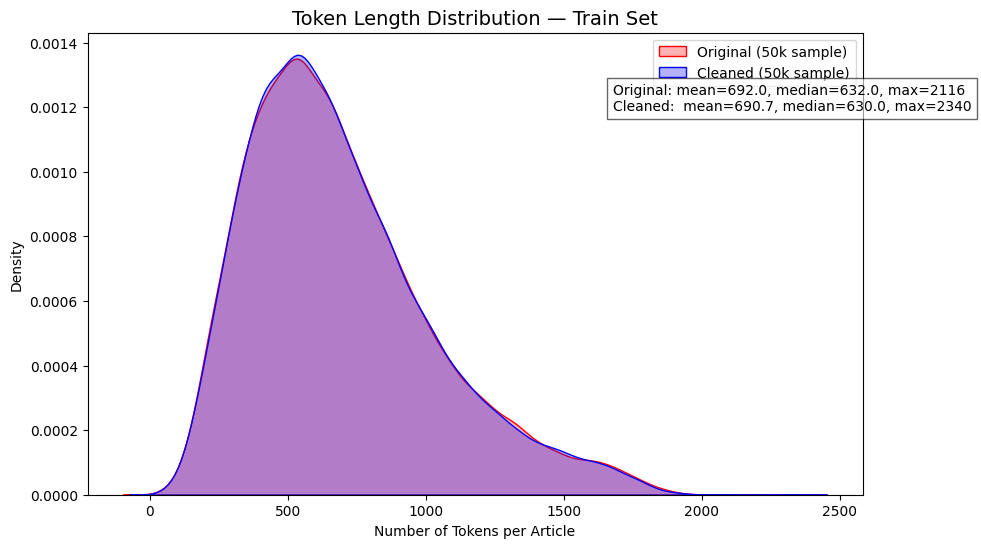

In [ ]:
# ====== EDA: Token Length Distribution Before vs After Cleaning ======
import os, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

# ---------------- Load Original Dataset ----------------
dataset = load_dataset("cnn_dailymail", "3.0.0")
df_train = pd.DataFrame(dataset["train"])
df_val   = pd.DataFrame(dataset["validation"])
df_test  = pd.DataFrame(dataset["test"])

# ---------------- Load Cleaned CSVs ----------------
train_csv = "/content/drive/MyDrive/cleaned_outputs/naa/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv"
val_csv   = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
test_csv  = "/content/drive/MyDrive/cleaned_outputs/naa/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"

df_train_clean = pd.read_csv(train_csv)
df_val_clean   = pd.read_csv(val_csv)
df_test_clean  = pd.read_csv(test_csv)

# ---------------- Function: compute token lengths ----------------
def compute_lengths(df, col="article"):
    return df[col].astype(str).str.split().apply(len)

# Example: focus on TRAIN first
orig_lengths  = compute_lengths(df_train, "article")
clean_lengths = compute_lengths(df_train_clean, "article")

# ---------------- Plot Comparison ----------------
plt.figure(figsize=(10,6))
sns.kdeplot(orig_lengths, label="Original", color="red", fill=True, alpha=0.3)
sns.kdeplot(clean_lengths, label="Cleaned", color="blue", fill=True, alpha=0.3)

plt.title("Token Length Distribution — Train Set (Original vs Cleaned)", fontsize=14)
plt.xlabel("Number of Tokens per Article")
plt.ylabel("Density")
plt.legend()

# Add summary stats
stats_text = (
    f"Original: mean={orig_lengths.mean():.1f}, median={orig_lengths.median()}, max={orig_lengths.max()}\n"
    f"Cleaned:  mean={clean_lengths.mean():.1f}, median={clean_lengths.median()}, max={clean_lengths.max()}"
)
plt.gcf().text(0.65, 0.75, stats_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

plt.show()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 126.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


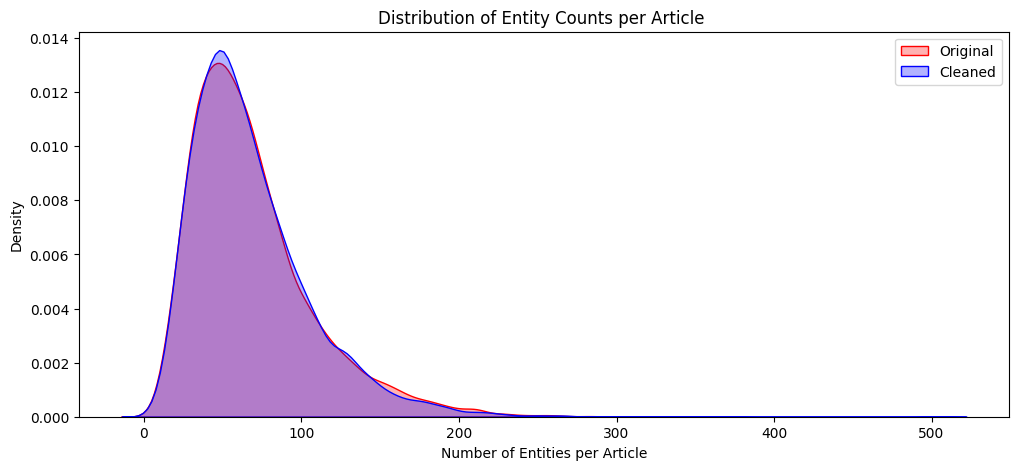

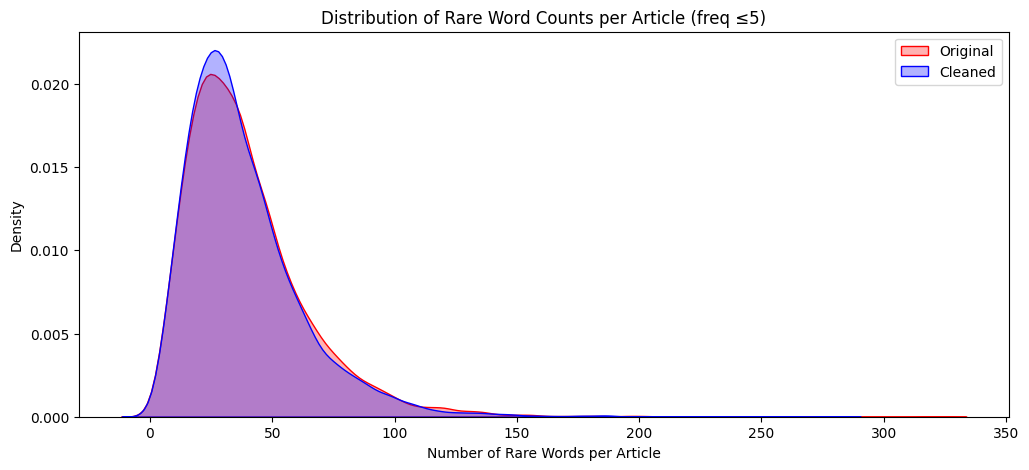

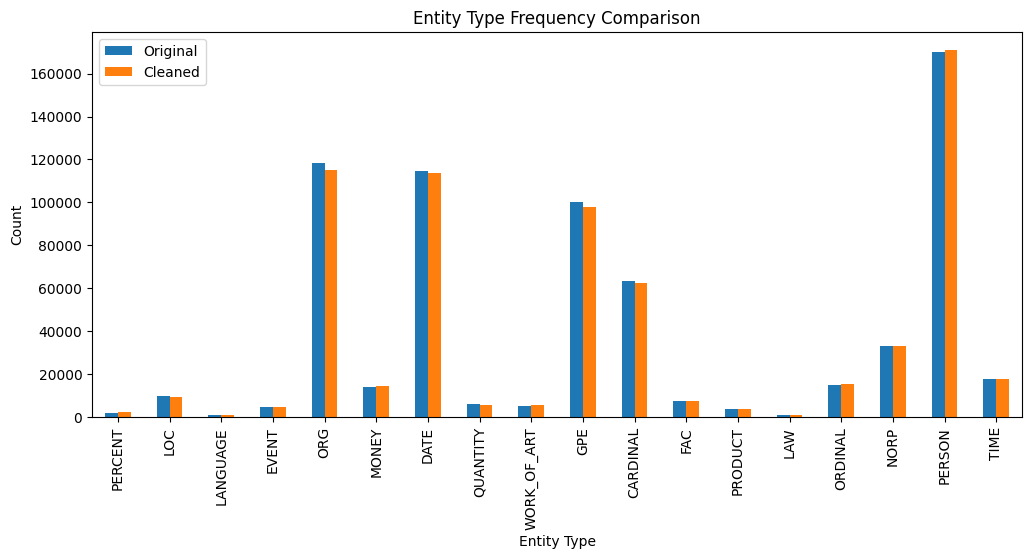

In [ ]:
# ====== EDA: Entities and Rare Words Comparison ======
import spacy, collections, seaborn as sns, matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset

# ---------------- Load Data ----------------
dataset = load_dataset("cnn_dailymail", "3.0.0")
df_train = pd.DataFrame(dataset["train"])
df_train_clean = pd.read_csv("/content/drive/MyDrive/cleaned_outputs/naa/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv")

# ---------------- Sample Subset (NER is expensive) ----------------
SAMPLE_SIZE = 10_000
df_orig_sample  = df_train.sample(n=SAMPLE_SIZE, random_state=0)
df_clean_sample = df_train_clean.sample(n=SAMPLE_SIZE, random_state=0)

# ---------------- Load spaCy model ----------------
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger"])

def count_entities(texts):
    ent_counts = []
    ent_types = collections.Counter()
    for doc in nlp.pipe(texts, batch_size=64):
        ent_counts.append(len(doc.ents))
        ent_types.update([ent.label_ for ent in doc.ents])
    return ent_counts, ent_types

# Compute entity stats
orig_ent_counts, orig_ent_types   = count_entities(df_orig_sample["article"].tolist())
clean_ent_counts, clean_ent_types = count_entities(df_clean_sample["article"].tolist())

# ---------------- Rare Word Analysis ----------------
def get_word_freqs(df, col="article"):
    counter = collections.Counter()
    for text in df[col].astype(str):
        counter.update(text.split())
    return counter

orig_freqs  = get_word_freqs(df_orig_sample)
clean_freqs = get_word_freqs(df_clean_sample)

def count_rare_words(texts, freqs, threshold=5):
    rare = set([w for w,c in freqs.items() if c <= threshold])
    return [sum(1 for w in t.split() if w in rare) for t in texts]

orig_rare_counts  = count_rare_words(df_orig_sample["article"], orig_freqs)
clean_rare_counts = count_rare_words(df_clean_sample["article"], clean_freqs)

# ---------------- Plot Entity Counts ----------------
plt.figure(figsize=(12,5))
sns.kdeplot(orig_ent_counts, label="Original", color="red", fill=True, alpha=0.3)
sns.kdeplot(clean_ent_counts, label="Cleaned", color="blue", fill=True, alpha=0.3)
plt.title("Distribution of Entity Counts per Article ")
plt.xlabel("Number of Entities per Article")
plt.ylabel("Density")
plt.legend()
plt.show()

# ---------------- Plot Rare Word Counts ----------------
plt.figure(figsize=(12,5))
sns.kdeplot(orig_rare_counts, label="Original", color="red", fill=True, alpha=0.3)
sns.kdeplot(clean_rare_counts, label="Cleaned", color="blue", fill=True, alpha=0.3)
plt.title("Distribution of Rare Word Counts per Article (freq ≤5)")
plt.xlabel("Number of Rare Words per Article")
plt.ylabel("Density")
plt.legend()
plt.show()

# ---------------- Entity Type Frequency Comparison ----------------
ent_type_df = pd.DataFrame({
    "Entity Type": list(set(orig_ent_types.keys()) | set(clean_ent_types.keys())),
    "Original": [orig_ent_types.get(t,0) for t in set(orig_ent_types.keys()) | set(clean_ent_types.keys())],
    "Cleaned": [clean_ent_types.get(t,0) for t in set(orig_ent_types.keys()) | set(clean_ent_types.keys())],
})
ent_type_df.set_index("Entity Type").plot(kind="bar", figsize=(12,5))
plt.title("Entity Type Frequency Comparison")
plt.ylabel("Count")
plt.show()


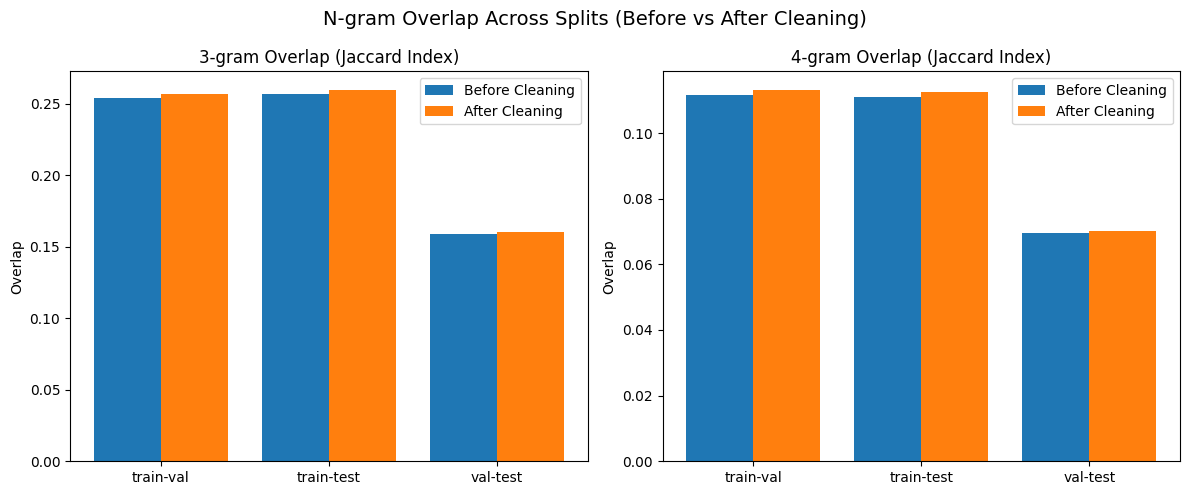

{'after': {'3-gram': {'train-test': 0.25962218030749834,
                      'train-val': 0.2569626181239913,
                      'val-test': 0.16006581056674898},
           '4-gram': {'train-test': 0.1124789428513909,
                      'train-val': 0.11314239241343023,
                      'val-test': 0.07023170533102822}},
 'before': {'3-gram': {'train-test': 0.2569367913847004,
                       'train-val': 0.25404059929756534,
                       'val-test': 0.15869404029518516},
            '4-gram': {'train-test': 0.11101892327378571,
                       'train-val': 0.11148236713818442,
                       'val-test': 0.06961716773199154}}}


In [ ]:
# ====== EDA: N-gram Overlap Analysis (3-grams & 4-grams) ======
import pandas as pd, matplotlib.pyplot as plt
from datasets import load_dataset
from collections import Counter
import itertools

# ---------------- Load Original Dataset ----------------
dataset = load_dataset("cnn_dailymail", "3.0.0")
df_train = pd.DataFrame(dataset["train"])
df_val   = pd.DataFrame(dataset["validation"])
df_test  = pd.DataFrame(dataset["test"])

# ---------------- Load Cleaned CSVs ----------------
train_csv = "/content/drive/MyDrive/cleaned_outputs/naa/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv"
val_csv   = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
test_csv  = "/content/drive/MyDrive/cleaned_outputs/naa/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"

df_train_clean = pd.read_csv(train_csv)
df_val_clean   = pd.read_csv(val_csv)
df_test_clean  = pd.read_csv(test_csv)

# ---------------- N-gram Extraction ----------------
def get_ngrams(texts, n=3, sample_size=50000, seed=0):
    # sample subset for tractability
    if len(texts) > sample_size:
        texts = texts.sample(n=sample_size, random_state=seed)
    ngrams = set()
    for t in texts.astype(str):
        words = t.split()
        ngrams.update(tuple(words[i:i+n]) for i in range(len(words)-n+1))
    return ngrams

# ---------------- Compute Overlap ----------------
def jaccard_overlap(setA, setB):
    return len(setA & setB) / len(setB) if len(setB) > 0 else 0

splits_before = {
    "train": df_train["article"],
    "val":   df_val["article"],
    "test":  df_test["article"],
}
splits_after = {
    "train": df_train_clean["article"],
    "val":   df_val_clean["article"],
    "test":  df_test_clean["article"],
}

results = {"before": {}, "after": {}}
for label, splits in [("before", splits_before), ("after", splits_after)]:
    # Extract ngrams
    ngrams3 = {s: get_ngrams(texts, n=3) for s, texts in splits.items()}
    ngrams4 = {s: get_ngrams(texts, n=4) for s, texts in splits.items()}

    # Compute overlaps
    results[label]["3-gram"] = {
        "train-val": jaccard_overlap(ngrams3["train"], ngrams3["val"]),
        "train-test": jaccard_overlap(ngrams3["train"], ngrams3["test"]),
        "val-test": jaccard_overlap(ngrams3["val"], ngrams3["test"]),
    }
    results[label]["4-gram"] = {
        "train-val": jaccard_overlap(ngrams4["train"], ngrams4["val"]),
        "train-test": jaccard_overlap(ngrams4["train"], ngrams4["test"]),
        "val-test": jaccard_overlap(ngrams4["val"], ngrams4["test"]),
    }

# ---------------- Plot Results ----------------
fig, axes = plt.subplots(1, 2, figsize=(12,5))

for i, ngram in enumerate(["3-gram", "4-gram"]):
    before_vals = list(results["before"][ngram].values())
    after_vals  = list(results["after"][ngram].values())
    labels      = list(results["before"][ngram].keys())

    x = range(len(labels))
    axes[i].bar([p-0.2 for p in x], before_vals, width=0.4, label="Before Cleaning")
    axes[i].bar([p+0.2 for p in x], after_vals, width=0.4, label="After Cleaning")

    axes[i].set_title(f"{ngram} Overlap (Jaccard Index)")
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(labels)
    axes[i].set_ylabel("Overlap")
    axes[i].legend()

plt.suptitle("N-gram Overlap Across Splits (Before vs After Cleaning)", fontsize=14)
plt.tight_layout()
plt.show()

# Print raw results
import pprint
pprint.pprint(results)


In [ ]:
# ====== Inspect Near-Duplicates Dropped items ===
import pandas as pd

TRAIN_ORIG = "/content/drive/MyDrive/cleaned_outputs/naa/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
TRAIN_APPL = "/content/drive/MyDrive/cleaned_outputs/naa/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv"

# Load both versions
df_orig  = pd.read_csv(TRAIN_ORIG)
df_appl  = pd.read_csv(TRAIN_APPL)

print("Shapes:", df_orig.shape, df_appl.shape)
print("Dropped rows:", len(df_orig) - len(df_appl))

# Find which rows were removed
# (works if 'article' column was used for deduplication)
orig_set  = set(df_orig["article"])
appl_set  = set(df_appl["article"])

removed_articles = list(orig_set - appl_set)

print(f"Unique articles removed: {len(removed_articles)}")

# Show a few examples
for i, art in enumerate(removed_articles[:5], 1):
    print(f"\n--- Example {i} ---\n{art[:500]}...\n")


Shapes: (283987, 3) (283861, 3)
Dropped rows: 126
Unique articles removed: 126

--- Example 1 ---
By . Anthony Bond . PUBLISHED: . 07:45 EST, 23 April 2013 . UPDATED: . 02:14 EST, 24 April 2013 . It would not be out of place speeding around famous Formula One circuits like Silverstone or Monaco. But incredibly, this racing car is not the real thing. Rather than being built in a high-tech garage by a team of expert engineers, it was instead put together in a shed in Brighton by a complete novice. Kevin Thomas, who has no engineering experience, spent four years piecing together the BAR-Honda ...


--- Example 2 ---
(CareerBuilder.com) -- 2009 has given employers and employees a run for their money -- literally. Budgets have been cut, layoffs made and furloughs instituted, and benefits and perks have evaporated. At the beginning of the year, 38 percent of employers said the economy would force them to make administrative cuts sometime during 2009, according to a survey by CareerBuilder.c

# Tokenization using SentencePiece and Unigram

In [ ]:
# ============================================================
#Train  SentencePiece (Unigram)
# ============================================================

!pip -q install sentencepiece==0.2.0 pandas pyarrow

import os, csv, json, time, gc, hashlib, random
import numpy as np
import pandas as pd
import sentencepiece as spm
from typing import List

# --- Mount Google Drive ---
from google.colab import drive
drive.mount("/content/drive")

# --- Data paths (update if needed) ---
DATA_DIR = "/content/drive/MyDrive/cnndm_near_dedup/20250814_135141"

TRAIN_CSV = f"{DATA_DIR}/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv"
VAL_CSV   = f"{DATA_DIR}/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
TEST_CSV  = f"{DATA_DIR}/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"

for p in (TRAIN_CSV, VAL_CSV, TEST_CSV):
    assert os.path.exists(p), f"Missing: {p}"

# --- Output dirs ---
STAMP = time.strftime("%Y%m%d_%H%M%S")
TOKENIZER_DIR = f"/content/drive/MyDrive/tokenizers/sp_shared_{STAMP}"
OUT_DIR       = f"/content/drive/MyDrive/tokenized_outputs/sp_shared_{STAMP}"
os.makedirs(TOKENIZER_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

SP_PREFIX     = os.path.join(TOKENIZER_DIR, "sp_unigram_shared")
SP_MODEL_PATH = SP_PREFIX + ".model"

ID_COL, SRC_COL, TGT_COL = "id", "article", "highlights"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.6 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Tokenizer training config ---
VOCAB_SIZE     = 32000
CHAR_COVERAGE  = 0.9995
NORMALIZATION  = "nmt_nfkc_cf"
NUM_THREADS    = os.cpu_count() or 4
MAX_SENT_CHARS = 40000

# Corpus sampling
CORPUS_TXT       = os.path.join(TOKENIZER_DIR, "tokenizer_corpus.txt")
CHUNK_ROWS       = 50_000
KEEP_FRAC        = 1.0            # keep all rows (still capped below)
MAX_CORPUS_LINES = 2_000_000
INPUT_SAMPLE     = 1_500_000
random.seed(0)

# --- Safe CSV reader ---
def strict_read_csv(path: str, usecols=None, chunksize=None, dtypes=None):
    return pd.read_csv(
        path,
        engine="c",
        sep=",",
        encoding="utf-8",
        keep_default_na=False,
        on_bad_lines="error",
        usecols=usecols,
        chunksize=chunksize,
        quotechar='"',
        escapechar="\\",
        doublequote=False,
        lineterminator="\n",
        dtype=dtypes,
    )

# --- Build tokenizer corpus ---
written = 0
for df in strict_read_csv(TRAIN_CSV, usecols=[SRC_COL], chunksize=CHUNK_ROWS, dtypes={SRC_COL: str}):
    with open(CORPUS_TXT, "a", encoding="utf-8") as f:
        for text in df[SRC_COL]:
            if written >= MAX_CORPUS_LINES:
                break
            if random.random() > KEEP_FRAC:
                continue
            line = str(text).replace("\r"," ").replace("\n"," ").strip()
            if line:
                f.write(line + "\n")
                written += 1
    del df; gc.collect()
    if written >= MAX_CORPUS_LINES:
        break

print(f"Corpus saved: {CORPUS_TXT} | lines={written:,}")

# --- Train SentencePiece ---
spm.SentencePieceTrainer.Train(
    input=CORPUS_TXT,
    model_prefix=SP_PREFIX,
    model_type="unigram",
    vocab_size=VOCAB_SIZE,
    character_coverage=CHAR_COVERAGE,
    input_sentence_size=INPUT_SAMPLE,
    shuffle_input_sentence=True,
    num_threads=NUM_THREADS,
    normalization_rule_name=NORMALIZATION,

    pad_id=0,  pad_piece="[PAD]",
    unk_id=1,  unk_piece="[UNK]",
    bos_id=2,  bos_piece="[BOS]",
    eos_id=3,  eos_piece="[EOS]",

    hard_vocab_limit=False,
    train_extremely_large_corpus=True,
    byte_fallback=True,
    max_sentence_length=MAX_SENT_CHARS,
)

sp = spm.SentencePieceProcessor(); sp.load(SP_MODEL_PATH)
print(f"Tokenizer trained. Vocab={sp.get_piece_size()} | UNK={sp.unk_id()} | EOS={sp.eos_id()}")


Corpus saved: /content/drive/MyDrive/tokenizers/sp_shared_20250819_110137/tokenizer_corpus.txt | lines=68,704
Tokenizer trained. Vocab=32000 | UNK=1 | EOS=3


In [ ]:
# --- Length budgets ---
MAX_SRC_LEN = 1024
MAX_TGT_LEN = 256   # bumped from 192
TAIL_FRAC   = 0.25

def lead_tail_core(ids: List[int], max_len: int, tail_frac: float, eos_id: int) -> List[int]:
    body_budget = max_len - 1
    if body_budget <= 0: return [eos_id]
    if len(ids) <= body_budget:
        body = ids[:]
    else:
        t = max(1, int(round(body_budget * tail_frac)))
        h = body_budget - t
        body = ids[:h] + ids[-t:]
    return body[:body_budget] + [eos_id]

def encode_src(text: str):
    raw = sp.encode(text, out_type=int)
    truncated = len(raw) > (MAX_SRC_LEN - 1)
    return lead_tail_core(raw, MAX_SRC_LEN, TAIL_FRAC, sp.eos_id()), truncated

def encode_tgt(text: str):
    raw = sp.encode(text, out_type=int)
    body_budget = MAX_TGT_LEN - 1
    truncated = len(raw) > body_budget
    return raw[:body_budget] + [sp.eos_id()], truncated


In [ ]:
# --- Quick diagnostics: see how the new tokenizer encodes ---
examples = [
    "Manchester United striker Danny Welbeck has said he wants a central role for club and country.",
    "The government passed a controversial new law on climate policy.",
    "Harry Potter star Daniel Radcliffe gained access to his fortune as he turned 18 on Monday.",
]

for i, txt in enumerate(examples):
    s_ids, s_trunc = encode_src(txt)
    t_ids, t_trunc = encode_tgt("This is the reference summary of the above article.")

    print(f"\n--- Example {i} ---")
    print("SRC raw len:", len(sp.encode(txt, out_type=int)))
    print("SRC enc len:", len(s_ids), "| truncated:", s_trunc)
    print("SRC tokens:", sp.decode_ids(s_ids[:40]), " ...")

    print("TGT raw len:", len(sp.encode("This is the reference summary of the above article.", out_type=int)))
    print("TGT enc len:", len(t_ids), "| truncated:", t_trunc)
    print("TGT tokens:", sp.decode_ids(t_ids))



--- Example 0 ---
SRC raw len: 18
SRC enc len: 19 | truncated: False
SRC tokens: manchester united striker danny welbeck has said he wants a central role for club and country.  ...
TGT raw len: 11
TGT enc len: 12 | truncated: False
TGT tokens: this is the reference summary of the above article.

--- Example 1 ---
SRC raw len: 11
SRC enc len: 12 | truncated: False
SRC tokens: the government passed a controversial new law on climate policy.  ...
TGT raw len: 11
TGT enc len: 12 | truncated: False
TGT tokens: this is the reference summary of the above article.

--- Example 2 ---
SRC raw len: 17
SRC enc len: 18 | truncated: False
SRC tokens: harry potter star daniel radcliffe gained access to his fortune as he turned 18 on monday.  ...
TGT raw len: 11
TGT enc len: 12 | truncated: False
TGT tokens: this is the reference summary of the above article.


In [ ]:
# ============================================================
# Re-tokenize splits with FIXED ID logic
# - Every row ID = sha1(src+tgt) (deterministic, stable)
# - Writes NPZ + manifest + idmap (old_id → new_id)
# ============================================================

import hashlib, csv, gc, time, os, numpy as np

def stable_hash_id(src: str, tgt: str) -> str:
    return hashlib.sha1((src + tgt).encode("utf-8")).hexdigest()

def process_split_fixed(csv_path: str, split_name: str):
    print(f"\n=== {split_name.upper()} (fixed IDs) ===\nInput: {csv_path}")
    start = time.time()

    all_ids, all_src, all_tgt = [], [], []
    src_lens, tgt_lens = [], []
    trunc_src = trunc_tgt = 0
    dropped_src = dropped_tgt = 0
    idmap_rows = []

    cols = [ID_COL, SRC_COL, TGT_COL]
    dtypes = {ID_COL: object, SRC_COL: str, TGT_COL: str}

    for df in strict_read_csv(csv_path, usecols=cols, chunksize=50_000, dtypes=dtypes):
        for _, row in df.iterrows():
            orig_id = str(row[ID_COL]).strip() if row[ID_COL] else ""
            src = (row[SRC_COL] or "").strip()
            tgt = (row[TGT_COL] or "").strip()
            if not src: dropped_src += 1; continue
            if not tgt: dropped_tgt += 1; continue

            new_id = stable_hash_id(src, tgt)

            s_ids, s_trunc = encode_src(src)
            t_ids, t_trunc = encode_tgt(tgt)

            all_ids.append(new_id)
            all_src.append(np.asarray(s_ids, dtype=np.int32))
            all_tgt.append(np.asarray(t_ids, dtype=np.int32))
            src_lens.append(len(s_ids)); tgt_lens.append(len(t_ids))
            trunc_src += int(s_trunc); trunc_tgt += int(t_trunc)

            idmap_rows.append([orig_id, new_id])

        del df; gc.collect()

    # --- Save NPZ ---
    out_npz = os.path.join(OUT_DIR, f"{split_name}_sp_tokens.npz")
    np.savez_compressed(out_npz, id=np.array(all_ids, dtype=object),
                        src=np.array(all_src, dtype=object),
                        tgt=np.array(all_tgt, dtype=object))

    # --- Save manifest ---
    manifest_csv = os.path.join(OUT_DIR, f"{split_name}_sp_manifest.csv")
    with open(manifest_csv, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f, quoting=csv.QUOTE_ALL, lineterminator="\n")
        w.writerow([ID_COL, "src_len", "tgt_len", "truncated_src", "truncated_tgt"])
        for rid, sl, tl in zip(all_ids, src_lens, tgt_lens):
            w.writerow([rid, sl, tl, int(sl >= MAX_SRC_LEN), int(tl >= MAX_TGT_LEN)])

    # --- Save ID map (orig → new) ---
    idmap_csv = os.path.join(OUT_DIR, f"{split_name}_idmap.csv")
    with open(idmap_csv, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f, quoting=csv.QUOTE_ALL, lineterminator="\n")
        w.writerow(["orig_id", "new_id"])
        w.writerows(idmap_rows)

    print(f"Saved {out_npz} ({len(all_ids):,} rows)")
    print(f"Manifest: {manifest_csv}")
    print(f"ID map: {idmap_csv}")
    print(f"Dropped src={dropped_src} tgt={dropped_tgt}")
    print(f"Truncated src={trunc_src} tgt={trunc_tgt}")
    print(f"Tgt mean={np.mean(tgt_lens):.1f} p95={np.percentile(tgt_lens,95):.0f} max={max(tgt_lens)}")
    print(f"Time {time.time()-start:.1f}s")

    return {"split": split_name, "rows": len(all_ids),
            "mean_tgt_len": float(np.mean(tgt_lens)),
            "p95_tgt_len": float(np.percentile(tgt_lens,95)),
            "truncated_src": trunc_src, "truncated_tgt": trunc_tgt}

# === Run all splits ===
stats = []
for path, name in [(TRAIN_CSV,"train"), (VAL_CSV,"val"), (TEST_CSV,"test")]:
    stats.append(process_split_fixed(path, name))

print("\n=== Final stats with fixed IDs ===")
print(json.dumps(stats, indent=2))



=== TRAIN (fixed IDs) ===
Input: /content/drive/MyDrive/cnndm_near_dedup/20250814_135141/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv
Saved /content/drive/MyDrive/tokenized_outputs/sp_shared_20250819_110137/train_sp_tokens.npz (283,859 rows)
Manifest: /content/drive/MyDrive/tokenized_outputs/sp_shared_20250819_110137/train_sp_manifest.csv
ID map: /content/drive/MyDrive/tokenized_outputs/sp_shared_20250819_110137/train_idmap.csv
Dropped src=0 tgt=2
Truncated src=50847 tgt=167
Tgt mean=49.3 p95=108 max=256
Time 432.4s

=== VAL (fixed IDs) ===
Input: /content/drive/MyDrive/cnndm_near_dedup/20250814_135141/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv
Saved /content/drive/MyDrive/tokenized_outputs/sp_shared_20250819_110137/val_sp_tokens.npz (13,366 rows)
Manifest: /content/drive/MyDrive/tokenized_outputs/sp_shared_20250819_110137/val_sp_manifest.csv
ID map: /content/drive/MyDrive/tokenized_outputs/sp_shared_20250819_110137/val_idmap.csv
Dropped src=0


=== TRAIN ===
Rows: 283,859
Source lens → mean 560.0, p95 1024, max 1024
Target lens → mean 49.3, p95 108, max 256


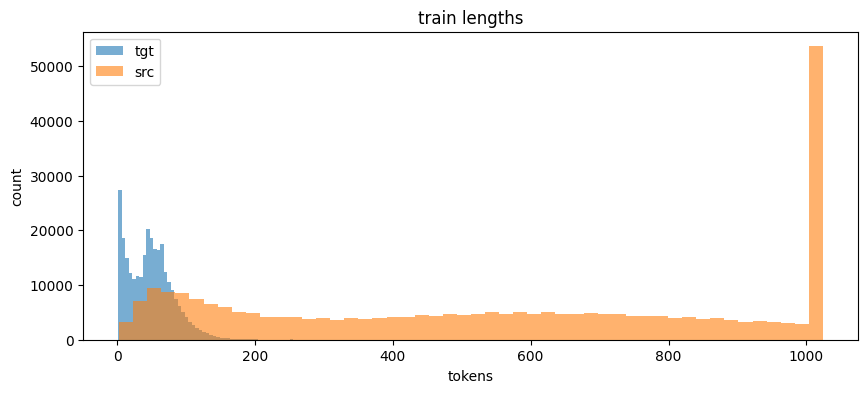


--- Example 201979 ---
ID: f5ddeefd6edd907ba36b4e23b99a7fe8e0f7ae12
SRC len: 415 | TGT len: 51
SRC: danny welbeck admits he is frustrated by his failure to hold down a first-team place up front for manchester united. the england forward wants a central role for club and country to prove he can score goals regularly at the highest level. welbeck has scored eight times in 21 appearances for england  ...
TGT: welbeck was played out of position during david moyes' time at united . the england man says he is 'let off the leash' more under roy hodgson . it is unclear how new united boss louis van gaal will ut ...

--- Example 220500 ---
ID: d04bae1cb9aa27a09e0044a4b7da2a2cf3c9ef14
SRC len: 1024 | TGT len: 82
SRC: on september 12, 1989, liverpool humiliated crystal palace with a record 9-0 thumping at anfield in the old first division. but the teams met again later in the season and this time, remarkably, palace won a thrilling fa cup semi-final at villa park, 4-3 after extra-time. liverpool

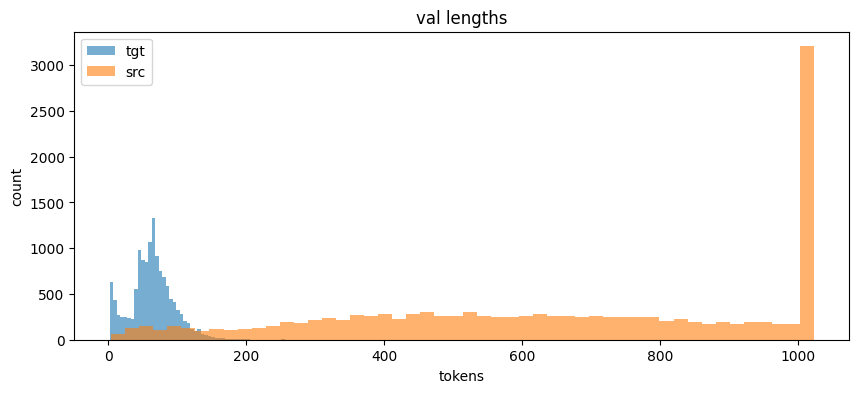


--- Example 6311 ---
ID: 6baed05143b6a042904d311d8402d57ef1dbbb28
SRC len: 387 | TGT len: 64
SRC: a sheriff has credited facebook in assisting in the arrest of a domestic violence suspect on tuesday. andrew dale marcum, 21, was also wanted on charges of burglary (safe-cracking), abduction, and assault in ohio. the butler county sheriff's office posted three pictures of marcum on facebook on tues ...
TGT: andrew dale marcum, 21, was also wanted on charges of burglary (safe-cracking), abduction and assault in ohio . the butler county sheriff's office posted marcum's wanted picture on facebook - to which ...

--- Example 12418 ---
ID: 4f4858a6354394e67dda559525457932b87853a7
SRC len: 1024 | TGT len: 120
SRC: an afghan woman who was savagely beaten to death in the streets of kabul was murdered because she spoke out against a controversial local cleric, witnesses have claimed. farkhunda, 27, was pushed from a roof, run over by a car and set on fire before her body was thrown in the kabul r

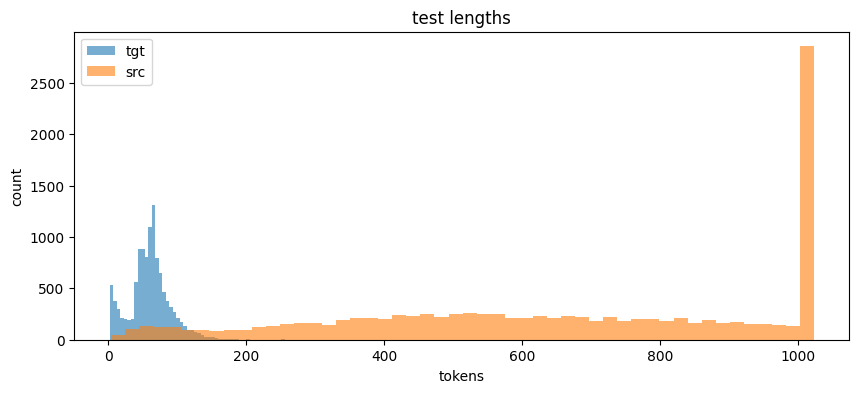


--- Example 6311 ---
ID: 4b782ace12f0edee2d7db47f307e8165074675cf
SRC len: 1024 | TGT len: 83
SRC: ted cruz is personally against the legalization of marijuana but the republican presidential candidate said this weekend that he believes states have the right to put decriminalization laws on the books if they want - even though they directly conflict with federal law. cruz implied during a convers ...
TGT: cruz is personally against the legalization of marijuana but believes states have the right to put decriminalization laws on the books if they want . implied he wouldn't make his ag enforce federal po ...

--- Example 6890 ---
ID: 9963b49ada123a884d9740481229c0ba6639bc9d
SRC len: 488 | TGT len: 30
SRC: the state of oklahoma has removed protection for gay people who use ride-sharing services uber and lyft. initially, the oklahoma transportation network company services act included language that prohibited the companies from discriminating against customers based on sexual orientation

In [ ]:
# =======================================
# Inspect freshly tokenized splits
# =======================================
import numpy as np, random, matplotlib.pyplot as plt
import sentencepiece as spm

# --- Paths ---
SP_MODEL_PATH = "/content/drive/MyDrive/tokenizers/sp_shared_20250819_110137/sp_unigram_shared.model"
DATA_DIR      = "/content/drive/MyDrive/tokenized_outputs/sp_shared_20250819_110137"

TRAIN_NPZ = f"{DATA_DIR}/train_sp_tokens.npz"
VAL_NPZ   = f"{DATA_DIR}/val_sp_tokens.npz"
TEST_NPZ  = f"{DATA_DIR}/test_sp_tokens.npz"

# --- Load tokenizer ---
sp = spm.SentencePieceProcessor()
sp.load(SP_MODEL_PATH)

def load_npz(path):
    d = np.load(path, allow_pickle=True)
    return d["id"], d["src"], d["tgt"]

# --- Helper: stats + histogram ---
def inspect_split(name, path, show_examples=True, n_examples=3):
    ids, src, tgt = load_npz(path)
    src_lens = [len(x) for x in src]
    tgt_lens = [len(x) for x in tgt]

    print(f"\n=== {name.upper()} ===")
    print(f"Rows: {len(ids):,}")
    print(f"Source lens → mean {np.mean(src_lens):.1f}, p95 {np.percentile(src_lens,95):.0f}, max {np.max(src_lens)}")
    print(f"Target lens → mean {np.mean(tgt_lens):.1f}, p95 {np.percentile(tgt_lens,95):.0f}, max {np.max(tgt_lens)}")

    # Histogram
    plt.figure(figsize=(10,4))
    plt.hist(tgt_lens, bins=50, alpha=0.6, label="tgt")
    plt.hist(src_lens, bins=50, alpha=0.6, label="src")
    plt.legend(); plt.title(f"{name} lengths"); plt.xlabel("tokens"); plt.ylabel("count")
    plt.show()

    if show_examples:
        random.seed(0)
        for i in random.sample(range(len(ids)), min(n_examples, len(ids))):
            print(f"\n--- Example {i} ---")
            print("ID:", ids[i])
            print("SRC len:", len(src[i]), "| TGT len:", len(tgt[i]))
            print("SRC:", sp.decode(src[i].tolist())[:300], "...")
            print("TGT:", sp.decode(tgt[i].tolist())[:200], "...")

# Run inspections
inspect_split("train", TRAIN_NPZ)
inspect_split("val", VAL_NPZ)
inspect_split("test", TEST_NPZ)


In [ ]:
import os, random, numpy as np, pandas as pd
import sentencepiece as spm

# --- Config ---
BASE = "/content/drive/MyDrive/tokenized_outputs/sp_shared_20250819_110137"
SP_MODEL = "/content/drive/MyDrive/tokenizers/sp_shared_20250819_110137/sp_unigram_shared.model"

SPLIT = "train"  # change to "val" or "test"
IDMAP_PATH = f"{BASE}/{SPLIT}_idmap.csv"
NPZ_PATH   = f"{BASE}/{SPLIT}_sp_tokens.npz"

# --- Load tokenizer ---
sp = spm.SentencePieceProcessor()
sp.load(SP_MODEL)

# --- Load idmap + tokenized arrays ---
df_map = pd.read_csv(IDMAP_PATH)
npz = np.load(NPZ_PATH, allow_pickle=True)

ids  = npz["id"]   # these are the stable new_ids
srcs = npz["src"]
tgts = npz["tgt"]

print(f"[info] Loaded {len(ids):,} rows for split={SPLIT}")
print(df_map.head())

def decode(ids_arr):
    return sp.decode([int(x) for x in ids_arr if int(x) != 0])

# --- Show random samples ---
random.seed(0)
for j in random.sample(range(len(ids)), 3):
    new_id = ids[j]
    row = df_map.loc[df_map["new_id"] == new_id]
    orig_id = row["orig_id"].iloc[0] if len(row) > 0 else "<none>"

    print(f"\n--- Example {j} ---")
    print("Original ID:", orig_id)
    print("Stable new_id:", new_id)
    print("SRC len:", len(srcs[j]), "| TGT len:", len(tgts[j]))
    print("SRC text:", decode(srcs[j])[:300], "...")
    print("TGT text:", decode(tgts[j])[:200], "...")
    print("SRC tokens (first 15):", srcs[j][:15])
    print("TGT tokens (first 15):", tgts[j][:15])


[info] Loaded 283,859 rows for split=train
                                             orig_id  \
0  drink and celebrity parties. ""I don't plan to...   
1  Florida The ninth floor of the Miami-Dade pret...   
2  survivor Gary Babineau told CNN. ""I probably ...   
3                                           Maryland   
4                                            the NFL   

                                     new_id  
0  5009fd61c67f9da8323375caaacbbc7df95ecebb  
1  27f4422903d0684532a13007e6aa68a841cca9ef  
2  4bd93f3161d2ad213e9c57c07a2c0f4f3c89620f  
3  63c59b11a8c4474c255aa40aa59ba7f3ee6f21d8  
4  7c74bae7fe12f160b61487561a7cfef5ae1f3943  

--- Example 201979 ---
Original ID: 9d33de844ec1a8fcd84bff39fb0c4e941558a8cb
Stable new_id: f5ddeefd6edd907ba36b4e23b99a7fe8e0f7ae12
SRC len: 415 | TGT len: 51
SRC text: danny welbeck admits he is frustrated by his failure to hold down a first-team place up front for manchester united. the england forward wants a central role for club and co

In [ ]:
# ============================================================
# Tokenization Sanity-Check Dashboard
# ============================================================

import os, random, hashlib, json
import numpy as np
import pandas as pd
import sentencepiece as spm

# ----------------
# Config
# ----------------
SP_MODEL_PATH = "/content/drive/MyDrive/tokenizers/sp_shared_20250819_110137/sp_unigram_shared.model"
OUT_DIR       = "/content/drive/MyDrive/tokenized_outputs/sp_shared_20250819_110137"
CSV_DIR       = "/content/drive/MyDrive/cnndm_near_dedup/20250814_135141"

SPLITS = {
    "train": {
        "npz": f"{OUT_DIR}/train_sp_tokens.npz",
        "manifest": f"{OUT_DIR}/train_sp_manifest.csv",
        "idmap": f"{OUT_DIR}/train_idmap.csv",
        "csv": f"{CSV_DIR}/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv"
    },
    "val": {
        "npz": f"{OUT_DIR}/val_sp_tokens.npz",
        "manifest": f"{OUT_DIR}/val_sp_manifest.csv",
        "idmap": f"{OUT_DIR}/val_idmap.csv",
        "csv": f"{CSV_DIR}/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
    },
    "test": {
        "npz": f"{OUT_DIR}/test_sp_tokens.npz",
        "manifest": f"{OUT_DIR}/test_sp_manifest.csv",
        "idmap": f"{OUT_DIR}/test_idmap.csv",
        "csv": f"{CSV_DIR}/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
    },
}

MAX_SHOW = 15  # number of tokens to show in sample previews

# ----------------
# Load tokenizer
# ----------------
sp = spm.SentencePieceProcessor()
sp.load(SP_MODEL_PATH)
print(f"[Tokenizer] Vocab={sp.get_piece_size()} | PAD={sp.pad_id()} UNK={sp.unk_id()} BOS={sp.bos_id()} EOS={sp.eos_id()}")

# ----------------
# Helper: md5
# ----------------
def md5(path):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1<<20), b""): h.update(chunk)
    return h.hexdigest()

# ----------------
# Run sanity checks per split
# ----------------
for split, paths in SPLITS.items():
    print(f"\n=== {split.upper()} ===")
    # load npz
    d = np.load(paths["npz"], allow_pickle=True)
    ids, srcs, tgts = d["id"], d["src"], d["tgt"]
    print(f"[info] Loaded {len(ids):,} rows")

    # check manifest/idmap alignment
    man = pd.read_csv(paths["manifest"])
    idmap = pd.read_csv(paths["idmap"])
    assert len(man) == len(ids) == len(idmap), "Row count mismatch!"
    assert set(idmap["new_id"]) == set(ids), "IDs mismatch between npz and idmap"

    # length stats
    src_lens = [len(x) for x in srcs]
    tgt_lens = [len(x) for x in tgts]
    print(f"Source lens → mean {np.mean(src_lens):.1f}, p95 {np.percentile(src_lens,95):.0f}, max {np.max(src_lens)}")
    print(f"Target lens → mean {np.mean(tgt_lens):.1f}, p95 {np.percentile(tgt_lens,95):.0f}, max {np.max(tgt_lens)}")

    # EOS check
    bad_eos_src = sum([x[-1] != sp.eos_id() for x in srcs])
    bad_eos_tgt = sum([x[-1] != sp.eos_id() for x in tgts])
    print(f"EOS sanity → src bad={bad_eos_src}, tgt bad={bad_eos_tgt}")

    # UNK check
    unk_src = sum([(np.array(x)==sp.unk_id()).sum() for x in srcs])
    unk_tgt = sum([(np.array(x)==sp.unk_id()).sum() for x in tgts])
    unk_total = unk_src + unk_tgt
    total_tokens = sum(src_lens) + sum(tgt_lens)
    print(f"[UNK] {unk_total}/{total_tokens} = {100*unk_total/total_tokens:.4f}%")

    # random spot checks
    print("\n--- Random examples ---")
    sample_idx = random.sample(range(len(ids)), 3)
    orig_csv = pd.read_csv(paths["csv"], usecols=["id","article","highlights"], nrows=200_000) # partial load
    csv_map = {str(r["id"]): (r["article"], r["highlights"]) for _,r in orig_csv.iterrows()}

        # random spot checks
    print("\n--- Random examples ---")
    sample_idx = random.sample(range(len(ids)), 3)
    orig_csv = pd.read_csv(paths["csv"], usecols=["id","article","highlights"])  # no need to limit nrows
    csv_map = {str(r["id"]): (r["article"], r["highlights"]) for _,r in orig_csv.iterrows()}

    for i in sample_idx:
        nid = str(ids[i])
        src_tokens, tgt_tokens = srcs[i].tolist(), tgts[i].tolist()  # <-- cast to list
        src_dec, tgt_dec = sp.decode(src_tokens), sp.decode(tgt_tokens)

        print(f"\nID: {nid}")
        if nid in csv_map:
            art, summ = csv_map[nid]
            print(f"Orig article: {art[:100]}...")
            print(f"Orig highlight: {summ[:100]}...")
        print(f"SRC len={len(src_tokens)} | TGT len={len(tgt_tokens)}")
        print(f"SRC tokens (first {MAX_SHOW}): {src_tokens[:MAX_SHOW]}")
        print(f"TGT tokens (first {MAX_SHOW}): {tgt_tokens[:MAX_SHOW]}")
        print(f"SRC decode: {src_dec[:120]}...")
        print(f"TGT decode: {tgt_dec[:120]}...")


    # md5 integrity check
    print(f"\nMD5 npz={md5(paths['npz'])} manifest={md5(paths['manifest'])} idmap={md5(paths['idmap'])}")


[Tokenizer] Vocab=32000 | PAD=0 UNK=1 BOS=2 EOS=3

=== TRAIN ===
[info] Loaded 283,859 rows
Source lens → mean 560.0, p95 1024, max 1024
Target lens → mean 49.3, p95 108, max 256
EOS sanity → src bad=0, tgt bad=0
[UNK] 0/172957746 = 0.0000%

--- Random examples ---

--- Random examples ---

ID: 376962ec174d5342cbeb251d837b199278ab976f
SRC len=1024 | TGT len=58
SRC tokens (first 15): [297, 271, 4077, 5393, 4415, 272, 1626, 2924, 1335, 271, 8222, 2655, 18273, 283, 328]
TGT tokens (first 15): [337, 940, 900, 2320, 3425, 273, 3409, 281, 328, 1151, 281, 284, 491, 284, 668]
SRC decode: by . melissa hills for daily mail australia . calum shand, 26, found it very hard to get a job when he returned to austr...
TGT decode: new research shows youth unemployment is climbing, reaching as high as 20 per cent in some areas of australia . data sho...

ID: dff9c928543458248d79ed0c10d2c1cc7f519932
SRC len=491 | TGT len=70
SRC tokens (first 15): [297, 271, 2813, 2871, 271, 1530, 302, 271, 280, 1920, 302,

# Training for 2000 steps

In [ ]:
!pip install -q rouge-score==0.1.2

!pip uninstall -y transformers rouge-score accelerate datasets

!pip install -q \
  transformers==4.43.4 \
  accelerate==0.34.2 \
  datasets==2.20.0 \
  rouge-score==0.1.2
import os, csv, math, time, random, json, re, gc
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from dataclasses import dataclass
from typing import List, Dict, Optional
from torch import amp
from rouge_score import rouge_scorer
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSeq2SeqLM,
    get_linear_schedule_with_warmup, set_seed
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", DEVICE)


  Preparing metadata (setup.py) ... done
Found existing installation: transformers 4.55.2
Uninstalling transformers-4.55.2:
  Successfully uninstalled transformers-4.55.2
Found existing installation: rouge_score 0.1.2
Uninstalling rouge_score-0.1.2:
  Successfully uninstalled rouge_score-0.1.2
Found existing installation: accelerate 1.10.0
Uninstalling accelerate-1.10.0:
  Successfully uninstalled accelerate-1.10.0
Found existing installation: datasets 4.0.0
Uninstalling datasets-4.0.0:
  Successfully uninstalled datasets-4.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 126.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 101.2 MB/s

In [ ]:
# --- Data paths (CSV with columns: id, article, highlights) ---
TRAIN_CSV = "/content/drive/MyDrive/cleaned_outputs/naa/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv"
VAL_CSV   = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"

# --- Output/checkpoints ---
RUN_DIR   = "/content/drive/MyDrive/student_pgc_bartbase"
os.makedirs(RUN_DIR, exist_ok=True)

# --- Model/tokenizer ---
MODEL_NAME = "facebook/bart-base"     # <<< switch to BASE

# --- Lengths ---
MAX_SRC_LEN = 400
MAX_TGT_LEN = 100

# --- Training ---
SEED                 = 0
BATCH_SIZE           = 48
GRAD_ACCUM_STEPS     = 2
NUM_WORKERS          = 4
LR                   = 3e-5
WEIGHT_DECAY         = 0.01
WARMUP_RATIO         = 0.06
EPOCHS               = 99            # we'll stop via MAX_STEPS
MAX_STEPS            = 2000
FP16                 = True
FREEZE_ENCODER       = False         # keep trainable for pointer health
LOG_EVERY            = 100
SAVE_EVERY_STEPS     = 1000

# --- Pointer/Coverage ---
USE_POINTER          = True
LAMBDA_COV           = 1.0
EPS                  = 1e-8

# --- Decoding (project-wide canonical) ---
GEN_ARGS = dict(
    num_beams=5,
    min_new_tokens=55,
    max_new_tokens=100,
    min_length=55,
    no_repeat_ngram_size=3,
    length_penalty=2.0,
    early_stopping=True,
)

import numpy as np
import torch
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


In [ ]:
def robust_read_csv(path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(path, engine="python", quoting=csv.QUOTE_ALL, escapechar="\\")
        cols = {c.lower(): c for c in df.columns}
        return df[[cols["id"], cols["article"], cols["highlights"]]].rename(
            columns={cols["id"]:"id", cols["article"]:"article", cols["highlights"]:"highlights"}
        )
    except Exception:
        rows = []
        with open(path, "r", encoding="utf-8", newline="") as f:
            reader = csv.reader(f, delimiter=",", quotechar='"', escapechar="\\")
            header = next(reader)
            header = [h.strip().lower() for h in header]
            idx_id, idx_art, idx_sum = header.index("id"), header.index("article"), header.index("highlights")
            for row in reader:
                rows.append([row[idx_id], row[idx_art], row[idx_sum]])
        return pd.DataFrame(rows, columns=["id","article","highlights"])

# --- Dataset ---
class CNNDMDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.ids  = df["id"].astype(str).tolist()
        self.srcs = df["article"].astype(str).tolist()
        self.tgts = df["highlights"].astype(str).tolist()
    def __len__(self): return len(self.ids)
    def __getitem__(self, i):
        return dict(id=self.ids[i], article=self.srcs[i], highlights=self.tgts[i])

# --- Collator (no as_target_tokenizer; supports old/new HF) ---
@dataclass
class PGDataCollator:
    tok: AutoTokenizer
    max_src_len: int
    max_tgt_len: int
    def __call__(self, batch: List[Dict[str, str]]) -> Dict[str, torch.Tensor]:
        src_texts = [b["article"] for b in batch]
        tgt_texts = [b["highlights"] for b in batch]
        try:
            enc = self.tok(
                src_texts,
                text_target=tgt_texts,
                padding=True, truncation=True,
                max_length=self.max_src_len,
                max_length_target=self.max_tgt_len,
                return_tensors="pt",
            )
        except TypeError:
            enc = self.tok(src_texts, padding=True, truncation=True,
                           max_length=self.max_src_len, return_tensors="pt")
            tgt = self.tok(text_target=tgt_texts, padding=True, truncation=True,
                           max_length=self.max_tgt_len, return_tensors="pt")
            enc["labels"] = tgt["input_ids"]
        labels = enc["labels"]
        labels[labels == self.tok.pad_token_id] = -100
        enc["labels"] = labels
        return enc

# --- quick utils ---
def _gpu_mem_mb():
    if not torch.cuda.is_available(): return 0.0
    return torch.cuda.max_memory_allocated() / (1024**2)

class RunningMean:
    def __init__(self, n=200):
        self.buf, self.n = [], n
    def add(self, x):
        if x is None: return
        self.buf.append(float(x))
        if len(self.buf) > self.n: self.buf.pop(0)
    @property
    def mean(self):
        return sum(self.buf)/len(self.buf) if self.buf else 0.0

class StepLogger:
    def __init__(self, path):
        self.path = path
        if not os.path.exists(path):
            with open(path, "w") as f:
                f.write("epoch,step,loss,ce_loss,cov_loss,p_copy,p_gen,lr,grad_norm,toks_per_s,gpu_mem_mb\n")
    def log(self, row: Dict):
        with open(self.path, "a") as f:
            f.write(",".join(str(row[k]) for k in ["epoch","step","loss","ce_loss","cov_loss","p_copy","p_gen","lr","grad_norm","toks_per_s","gpu_mem_mb"])+"\n")


In [ ]:
from transformers.modeling_outputs import Seq2SeqLMOutput

class CopyAwareBart(nn.Module):
    """
    BART wrapper with pointer-generator + coverage.
    - mixes vocab distribution with copy distribution built from cross-attn over source tokens
    - computes CE over log(final_dist) + lambda_cov * coverage
    """
    def __init__(self, base_lm: AutoModelForSeq2SeqLM, tokenizer: AutoTokenizer,
                 lambda_cov: float = 1.0, eps: float = 1e-8, use_pointer: bool = True):
        super().__init__()
        self.base       = base_lm
        self.tok        = tokenizer
        self.lambda_cov = lambda_cov
        self.eps        = eps
        self.use_ptr    = use_pointer
        hidden = self.base.config.d_model
        self.p_gen_linear = nn.Linear(3*hidden, 1)
        # caches for logging
        self._last_ce_loss = None
        self._last_cov_loss = None
        self._last_p_copy_mean = None
        self._last_p_gen_mean  = None

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        decoder_input_ids: Optional[torch.Tensor] = None,
        decoder_attention_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        past_key_values=None, use_cache: Optional[bool] = None, **kwargs
    ) -> Seq2SeqLMOutput:

        if labels is not None and decoder_input_ids is None:
            decoder_input_ids = self.base.prepare_decoder_input_ids_from_labels(labels)
        if decoder_attention_mask is None and decoder_input_ids is not None:
            decoder_attention_mask = (decoder_input_ids != self.tok.pad_token_id).to(input_ids.dtype)

        need_attn = self.use_ptr or bool(output_attentions)
        need_hid  = self.use_ptr or bool(output_hidden_states)

        base_out = self.base(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            output_attentions=need_attn,
            output_hidden_states=need_hid,
            labels=None,
            past_key_values=past_key_values,
            use_cache=use_cache,
            **kwargs
        )

        logits = base_out.logits  # [B,T,V]
        final_logits = logits
        cov_loss = None
        copy_gate = None
        gen_gate  = None
        loss_ce   = None

        if self.use_ptr:
            # hidden states
            dec_hid = base_out.decoder_hidden_states[-1]            # [B,T,H]
            enc_out = base_out.encoder_last_hidden_state            # [B,S,H]

            # cross-attn last layer: [B,heads,T,S] -> mean heads -> [B,T,S]
            cross_atts = base_out.cross_attentions[-1].mean(dim=1)

            # mask PAD in source attention
            if attention_mask is not None:
                src_pad_mask = (attention_mask == 0).unsqueeze(1)   # [B,1,S]
                attn_clean   = cross_atts.masked_fill(src_pad_mask, 0.0)
            else:
                attn_clean   = cross_atts

            # normalize per time step
            denom     = attn_clean.sum(dim=-1, keepdim=True).clamp_min(self.eps)
            attn_norm = attn_clean / denom                          # [B,T,S]

            # context vectors
            context = torch.bmm(attn_norm, enc_out)                 # [B,T,H]

            # prev token embeddings
            if decoder_input_ids is not None:
                dec_emb = self.base.get_input_embeddings()(decoder_input_ids)  # [B,T,H]
            else:
                dec_emb = torch.zeros_like(dec_hid)

            # generation/copy gates
            p_gen  = torch.sigmoid(self.p_gen_linear(torch.cat([dec_hid, context, dec_emb], dim=-1)))  # [B,T,1]
            p_copy = 1.0 - p_gen

            # vocab distribution
            vocab_dist = torch.softmax(logits, dim=-1)              # [B,T,V]

            # copy distribution: scatter attention into vocab bins using source token ids
            B, T, S = attn_norm.shape
            V       = logits.size(-1)
            copy_dist = torch.zeros(B, T, V, device=attn_norm.device, dtype=attn_norm.dtype)

            batch_idx = torch.arange(B, device=input_ids.device)[:, None, None].expand(B, T, S)
            time_idx  = torch.arange(T, device=input_ids.device)[None, :, None].expand(B, T, S)
            vocab_idx = input_ids[:, None, :].expand(B, T, S)

            copy_dist = copy_dist.index_put((batch_idx, time_idx, vocab_idx), attn_norm, accumulate=True)

            # mix
            final_dist   = p_gen * vocab_dist + p_copy * copy_dist   # [B,T,V]
            final_logits = torch.log(final_dist + self.eps)

            # gate means for logging
            copy_gate = p_copy.mean().detach()
            gen_gate  = p_gen.mean().detach()

            # ---- coverage loss (fixed shape) ----
            cov = torch.zeros_like(attn_norm[:, 0, :])               # [B,S]
            step_losses = []
            for t in range(T):
                a_t = attn_norm[:, t, :]                             # [B,S]
                step_losses.append(torch.min(a_t, cov).sum(dim=-1))  # [B]
                cov = cov + a_t
            cov_loss = torch.stack(step_losses, dim=1).mean()        # scalar

        # loss over mixed distribution
        if labels is not None:
            V = final_logits.size(-1)
            loss_fct = nn.NLLLoss(ignore_index=-100)
            loss_ce  = loss_fct(final_logits.view(-1, V), labels.view(-1))
            loss = loss_ce + (self.lambda_cov * cov_loss if cov_loss is not None else 0.0)
        else:
            loss = None

        # expose scalars for logger
        with torch.no_grad():
            self._last_ce_loss     = loss_ce.detach() if loss_ce is not None else None
            self._last_cov_loss    = cov_loss.detach() if cov_loss is not None else None
            self._last_p_copy_mean = copy_gate if copy_gate is not None else None
            self._last_p_gen_mean  = gen_gate  if gen_gate  is not None else None

        return Seq2SeqLMOutput(
            loss=loss,
            logits=final_logits,
            past_key_values=base_out.past_key_values,
            decoder_hidden_states=base_out.decoder_hidden_states if need_hid else None,
            decoder_attentions=base_out.decoder_attentions if need_attn else None,
            cross_attentions=base_out.cross_attentions if need_attn else None,
            encoder_last_hidden_state=base_out.encoder_last_hidden_state,
            encoder_hidden_states=base_out.encoder_hidden_states if need_hid else None,
            encoder_attentions=base_out.encoder_attentions if need_attn else None,
        )



In [ ]:
# ---- seed  ----
import numpy as np
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ---- tokenizer + base (force eager attention) ----
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
cfg = AutoConfig.from_pretrained(MODEL_NAME, attn_implementation="eager")
base = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, config=cfg)
base.gradient_checkpointing_enable()

# wrap with pointer/coverage
model = CopyAwareBart(base, tok, lambda_cov=LAMBDA_COV, eps=EPS, use_pointer=USE_POINTER).to(DEVICE)

# AMP scaler (new API)
scaler = amp.GradScaler("cuda", enabled=FP16)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
# ---- read data ----
train_df = robust_read_csv(TRAIN_CSV)
val_df   = robust_read_csv(VAL_CSV)

# ---- dataset + collate ----
collate   = PGDataCollator(tok=tok, max_src_len=MAX_SRC_LEN, max_tgt_len=MAX_TGT_LEN)
train_ds  = CNNDMDataset(train_df)
val_ds    = CNNDMDataset(val_df)

# ---- loaders ----
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    collate_fn=collate,
)

val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=(NUM_WORKERS>0), prefetch_factor=(2 if NUM_WORKERS>0 else None),
    collate_fn=collate,
)

# ---- logger + checkpoint helpers ----
LOG_CSV = os.path.join(RUN_DIR, "train_log.csv")
logger  = StepLogger(LOG_CSV)

def save_checkpoint(tag):
    """Save base model, tokenizer, plus pointer head state."""
    ck = os.path.join(RUN_DIR, f"ckpt_step{tag}" if isinstance(tag,int) else f"ckpt_{tag}")
    os.makedirs(ck, exist_ok=True)
    model.base.save_pretrained(ck)
    tok.save_pretrained(ck)
    torch.save({
        "p_gen_linear": model.p_gen_linear.state_dict(),
        "lambda_cov": model.lambda_cov,
        "use_pointer": model.use_ptr,
    }, os.path.join(ck, "pointer_head.pt"))
    print(f"[checkpoint] saved → {ck}")


In [ ]:
from transformers import get_linear_schedule_with_warmup

no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight"]
params_decay, params_nodecay = [], []
for n, p in model.named_parameters():
    if not p.requires_grad:
        continue
    (params_nodecay if any(nd in n for nd in no_decay) else params_decay).append(p)

optimizer = torch.optim.AdamW(
    [{"params": params_decay, "weight_decay": WEIGHT_DECAY},
     {"params": params_nodecay, "weight_decay": 0.0}],
    lr=LR,
)

import math
from transformers import get_linear_schedule_with_warmup

num_update_steps_per_epoch = math.ceil(len(train_loader) / GRAD_ACCUM_STEPS)

# >>> KEY FIX: respect MAX_STEPS if set
t_total = int(MAX_STEPS) if MAX_STEPS else num_update_steps_per_epoch * EPOCHS
warmup_steps = max(1, int(WARMUP_RATIO * t_total))  # e.g., 0.06 * 2000 = 120

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=t_total,
)
print(f"[scheduler] total={t_total}, warmup={warmup_steps}")



[scheduler] total=2000, warmup=120


In [ ]:
#global_step = 0
best_val = float("inf")

# running averages
m_loss = RunningMean(200); m_ce = RunningMean(200); m_cov = RunningMean(200)
m_pcopy = RunningMean(200); m_pgen = RunningMean(200); m_toks = RunningMean(200)

model.train()
optimizer.zero_grad(set_to_none=True)

start_time = time.time()
tokens_seen = 0


# running averages
m_loss = RunningMean(200); m_ce = RunningMean(200); m_cov = RunningMean(200)
m_pcopy = RunningMean(200); m_pgen = RunningMean(200); m_toks = RunningMean(200)

model.train()
optimizer.zero_grad(set_to_none=True)

start_time = time.time()
tokens_seen = 0

for epoch in range(EPOCHS):
    for it, batch in enumerate(train_loader):
        for k in batch:
            batch[k] = batch[k].to(DEVICE)

        # token count for throughput
        with torch.no_grad():
            toks_this_batch = int(batch["attention_mask"].sum().item())
            if "labels" in batch:
                toks_this_batch += int((batch["labels"] != -100).sum().item())

        # forward pass with autocast
        with amp.autocast("cuda", enabled=FP16):
            out = model(**batch)
            loss = out.loss

        scaler.scale(loss).backward()
        took_step = False

        if (it + 1) % GRAD_ACCUM_STEPS == 0:
            # unscale once, then clip & log grad norm
            # grad norm (scaled grads are fine for logging in AMP)
            # grad norm (scaled grads are fine for logging in AMP)
            total_norm = torch.norm(
                torch.stack([p.grad.detach().norm(2) for p in model.parameters() if p.grad is not None])
            ).item()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            global_step += 1
            took_step = True

            # update running stats
            tokens_seen += toks_this_batch
            m_loss.add(loss.item())
            m_ce.add(getattr(model, "_last_ce_loss", None))
            m_cov.add(getattr(model, "_last_cov_loss", None))
            m_pcopy.add(getattr(model, "_last_p_copy_mean", None))
            m_pgen.add(getattr(model, "_last_p_gen_mean", None))
            elapsed = time.time() - start_time
            m_toks.add(tokens_seen / max(elapsed, 1e-6))

            if global_step % LOG_EVERY == 0:
                lr = scheduler.get_last_lr()[0]
                mem = _gpu_mem_mb()
                print(
                    f"[ep {epoch+1}] step {global_step:>6} | "
                    f"loss {m_loss.mean:7.4f} | ce {m_ce.mean:7.4f} | cov {m_cov.mean:7.4f} | "
                    f"p_copy {m_pcopy.mean:5.3f} | p_gen {m_pgen.mean:5.3f} | "
                    f"lr {lr:.2e} | grad_norm {total_norm:6.2f} | "
                    f"toks/s {m_toks.mean:8.1f} | gpu_mem {mem:7.1f} MB"
                )
                logger.log({
                    "epoch": epoch+1,
                    "step": global_step,
                    "loss": round(m_loss.mean, 6),
                    "ce_loss": round(m_ce.mean, 6),
                    "cov_loss": round(m_cov.mean, 6),
                    "p_copy": round(m_pcopy.mean, 6),
                    "p_gen": round(m_pgen.mean, 6),
                    "lr": lr,
                    "grad_norm": total_norm,
                    "toks_per_s": m_toks.mean,
                    "gpu_mem_mb": mem,
                })

            if global_step % SAVE_EVERY_STEPS == 0:
                save_checkpoint(global_step)

            if global_step >= MAX_STEPS:
                print(f"[train] Reached MAX_STEPS={MAX_STEPS}. Stopping early.")
                save_checkpoint(f"step{global_step}")
                break

        if torch.cuda.is_available(): torch.cuda.synchronize()
        del out
        if took_step: torch.cuda.empty_cache()

    if global_step >= MAX_STEPS:
        break

    # ---- quick validation ----
    model.eval()
    val_loss, val_seen = 0.0, 0
    with torch.no_grad():
        for vb in val_loader:
            for k in vb: vb[k] = vb[k].to(DEVICE)
            with amp.autocast("cuda", enabled=FP16):
                vo = model(**vb)
                if vo.loss is not None:
                    val_loss += vo.loss.item()
                    val_seen += 1
    if val_seen > 0:
        val_loss /= val_seen
        print(f"[val] epoch {epoch+1} | loss {val_loss:.4f}")
        if val_loss < best_val:
            best_val = val_loss
            save_checkpoint(f"best_ep{epoch+1}")
    model.train()


BartModel is using BartSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `layer_head_mask` not None. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


[ep 1] step   1100 | loss  2.9640 | ce  2.3699 | cov  0.5941 | p_copy 0.180 | p_gen 0.820 | lr 1.44e-05 | grad_norm 222559.80 | toks/s   9324.3 | gpu_mem 12996.4 MB
[ep 1] step   1200 | loss  2.9586 | ce  2.3710 | cov  0.5876 | p_copy 0.182 | p_gen 0.818 | lr 1.28e-05 | grad_norm 212593.80 | toks/s   9493.6 | gpu_mem 12996.4 MB
[ep 1] step   1300 | loss  2.9484 | ce  2.3731 | cov  0.5753 | p_copy 0.184 | p_gen 0.816 | lr 1.12e-05 | grad_norm 217491.92 | toks/s   9682.5 | gpu_mem 12996.4 MB
[ep 1] step   1400 | loss  2.9294 | ce  2.3654 | cov  0.5640 | p_copy 0.187 | p_gen 0.813 | lr 9.57e-06 | grad_norm 215148.19 | toks/s   9710.0 | gpu_mem 12996.4 MB
[ep 1] step   1500 | loss  2.9147 | ce  2.3613 | cov  0.5534 | p_copy 0.190 | p_gen 0.810 | lr 7.98e-06 | grad_norm 97175.05 | toks/s   9722.0 | gpu_mem 12996.4 MB
[ep 1] step   1600 | loss  2.9046 | ce  2.3608 | cov  0.5438 | p_copy 0.193 | p_gen 0.807 | lr 6.38e-06 | grad_norm 99697.49 | toks/s   9728.3 | gpu_mem 12996.4 MB
[ep 1] step 

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warni

[ep 1] step   2000 | loss  2.8625 | ce  2.3490 | cov  0.5135 | p_copy 0.204 | p_gen 0.796 | lr 0.00e+00 | grad_norm 49341.95 | toks/s   9737.1 | gpu_mem 12996.4 MB


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warni

[checkpoint] saved → /content/drive/MyDrive/student_pgc_bartbase/ckpt_step2000
[train] Reached MAX_STEPS=2000. Stopping early.
[checkpoint] saved → /content/drive/MyDrive/student_pgc_bartbase/ckpt_step2000


Resuming Training from step 1000

In [ ]:
# ===== RESUME + MORE CAPACITY (fixed) =====
import os, math, torch
from torch.utils.data import DataLoader
from torch import amp
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSeq2SeqLM,
    get_linear_schedule_with_warmup
)

# --- where to resume ---
RESUME_CKPT = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step1000"
RESUME_STEP = 1000

# --- capacity (you had VRAM headroom) ---
BATCH_SIZE         = 56
GRAD_ACCUM_STEPS   = 2
NUM_WORKERS        = 4
PERSISTENT_WORKERS = True
PREFETCH_FACTOR    = 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- reload tokenizer + base; FORCE eager attention & return attentions by default ---
tok = AutoTokenizer.from_pretrained(RESUME_CKPT, use_fast=True)
cfg = AutoConfig.from_pretrained(RESUME_CKPT)
cfg.attn_implementation = "eager"     # critical: sdpa will NOT return cross_attentions
base = AutoModelForSeq2SeqLM.from_pretrained(RESUME_CKPT, config=cfg)

# memory/compat
base.gradient_checkpointing_enable()   # lets you push batch size
base.config.use_cache = False          # avoid warning with gradient checkpointing

# ensure attentions/hidden states are returned even if forward() doesn't pass flags
base.config.output_attentions = True
base.config.output_hidden_states = True

# --- wrap with pointer/coverage and load pointer head (safe) ---
model = CopyAwareBart(base, tok, lambda_cov=LAMBDA_COV, eps=EPS, use_pointer=USE_POINTER).to(DEVICE)
ptr_path = os.path.join(RESUME_CKPT, "pointer_head.pt")
if os.path.exists(ptr_path):
    state = torch.load(ptr_path, map_location="cpu")
    if "p_gen_linear" in state:
        model.p_gen_linear.load_state_dict(state["p_gen_linear"])
    if "lambda_cov" in state:
        model.lambda_cov = float(state["lambda_cov"])
    if "use_pointer" in state:
        model.use_ptr = bool(state["use_pointer"])
else:
    print("[warn] pointer_head.pt not found — continuing with current pointer params")

# --- rebuild loaders with larger batch ---
train_df = robust_read_csv(TRAIN_CSV)
val_df   = robust_read_csv(VAL_CSV)
collate  = PGDataCollator(tok=tok, max_src_len=MAX_SRC_LEN, max_tgt_len=MAX_TGT_LEN)

train_loader = DataLoader(
    CNNDMDataset(train_df),
    batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=PERSISTENT_WORKERS, prefetch_factor=PREFETCH_FACTOR,
    collate_fn=collate,
)
val_loader = DataLoader(
    CNNDMDataset(val_df),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=PERSISTENT_WORKERS, prefetch_factor=PREFETCH_FACTOR,
    collate_fn=collate,
)

# --- optimizer + MAX_STEPS-aware scheduler positioned at RESUME_STEP ---
no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight"]
params_decay, params_nodecay = [], []
for n, p in model.named_parameters():
    if not p.requires_grad:
        continue
    (params_nodecay if any(nd in n for nd in no_decay) else params_decay).append(p)

optimizer = torch.optim.AdamW(
    [
        {"params": params_decay,   "weight_decay": WEIGHT_DECAY, "lr": LR, "initial_lr": LR},
        {"params": params_nodecay, "weight_decay": 0.0,          "lr": LR, "initial_lr": LR},
    ],
    lr=LR,
)

t_total      = int(MAX_STEPS)                        # e.g., 2000
warmup_steps = max(1, int(WARMUP_RATIO * t_total))   # e.g., 120 if 0.06

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=t_total,
    last_epoch=RESUME_STEP - 1,                      # continue from step 1000
)

scaler = amp.GradScaler("cuda", enabled=FP16)

# hand the loop your current step
global_step = RESUME_STEP
print(f"[resume] step={global_step}, batch={BATCH_SIZE}x{GRAD_ACCUM_STEPS} (eff={BATCH_SIZE*GRAD_ACCUM_STEPS}), warmup={warmup_steps}, lr_now={scheduler.get_last_lr()[0]:.3e}, attn_impl={base.config.attn_implementation}, out_attn={base.config.output_attentions}")


[resume] step=1000, batch=56x2 (eff=112), warmup=120, lr_now=1.596e-05, attn_impl=eager, out_attn=True




> At step 1000:
Resume — What changed and why

Goal: use more VRAM and continue training from step 1000

Capacity bump: BATCH_SIZE=56, GRAD_ACCUM_STEPS=2 (eff=112), gradient checkpointing enabled

Critical resume fixes:

Loaded with attn_implementation="eager" to guarantee cross_attentions (pointer needs this)

Ensured output_attentions=True & output_hidden_states=True via config

Did not reset global_step; scheduler rebuilt with last_epoch=999

Confirmed pointer head reloaded from pointer_head.pt

decoding without copy awareness

In [ ]:
# ===== ROUGE-1/2/L/Lsum evaluation =====
import torch
import pandas as pd


try:
    from rouge_score import rouge_scorer
except Exception:
    %pip -q install rouge-score
    from rouge_score import rouge_scorer


from transformers import GenerationConfig
gen_cfg = GenerationConfig(
    num_beams=5,
    min_new_tokens=55,
    max_new_tokens=100,
    no_repeat_ngram_size=3,
    length_penalty=2.0,
    early_stopping=True,
)

# 3) Configure eval size
N_EVAL  = 1000            # set to None for FULL validation
EVAL_BS = 8               # generation batch size
MAX_N   = len(val_df) if N_EVAL is None else min(N_EVAL, len(val_df))
DEVICE  = next(model.parameters()).device

print(f"[ROUGE] evaluating {MAX_N} examples with batch_size={EVAL_BS}...")

# 4) Generate predictions
preds, refs = [], []
model.eval()

for start in range(0, MAX_N, EVAL_BS):
    batch = val_df.iloc[start:start+EVAL_BS]
    srcs  = batch["article"].astype(str).tolist()

    with torch.no_grad():
        ins  = tok(srcs, return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN, padding=True).to(DEVICE)
        # Use the base model's generate (wrapper has no .generate)
        outs = model.base.generate(**ins, generation_config=gen_cfg, output_attentions=True)
    preds.extend(tok.batch_decode(outs, skip_special_tokens=True))
    refs.extend(batch["highlights"].astype(str).tolist())

# 5) Compute ROUGE (average F1)
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL','rougeLsum'], use_stemmer=True)
agg = {k: 0.0 for k in ['rouge1','rouge2','rougeL','rougeLsum']}
for p, r in zip(preds, refs):
    s = scorer.score(r, p)  # (reference, prediction)
    for k in agg: agg[k] += s[k].fmeasure
for k in agg: agg[k] /= max(1, len(preds))

print({k: round(v, 4) for k, v in agg.items()})


[ROUGE] evaluating 1000 examples with batch_size=8...
{'rouge1': 0.2975, 'rouge2': 0.11, 'rougeL': 0.2035, 'rougeLsum': 0.2035}


In [ ]:
# ===== Length stats & suggested min_new_tokens =====
import numpy as np, torch, pandas as pd
from transformers import GenerationConfig

assert 'model' in globals() and 'tok' in globals() and 'val_df' in globals(), "Need model, tok, val_df in memory"
DEVICE = next(model.parameters()).device
MAX_SRC_LEN = int(globals().get('MAX_SRC_LEN', 400))

# Eval size & batch
N_EVAL  = 1000
EVAL_BS = 8
MAX_N   = len(val_df) if N_EVAL is None else min(N_EVAL, len(val_df))


gen_cfg = GenerationConfig(
    num_beams=5,
    min_new_tokens=55,
    max_new_tokens=100,
    no_repeat_ngram_size=3,
    length_penalty=2.0,
    early_stopping=True,
)

def _word_len(s): return len(str(s).split())

preds, refs = [], []
model.eval()
for start in range(0, MAX_N, EVAL_BS):
    batch = val_df.iloc[start:start+EVAL_BS]
    srcs  = batch["article"].astype(str).tolist()
    with torch.no_grad():
        ins  = tok(srcs, return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN, padding=True).to(DEVICE)
        outs = model.base.generate(**ins, generation_config=gen_cfg)
    preds.extend(tok.batch_decode(outs, skip_special_tokens=True))
    refs.extend(batch["highlights"].astype(str).tolist())

# Token lengths via tokenizer (target side)
ref_tok_lens  = [len(tok(r, return_tensors=None, truncation=True).input_ids) for r in refs]
pred_tok_lens = [len(tok(p, return_tensors=None, truncation=True).input_ids) for p in preds]

# Word lengths
ref_w_lens  = [_word_len(r) for r in refs]
pred_w_lens = [_word_len(p) for p in preds]

def stats(arr):
    a = np.array(arr)
    return dict(
        mean=float(a.mean()),
        median=float(np.median(a)),
        p25=float(np.percentile(a,25)),
        p50=float(np.percentile(a,50)),
        p75=float(np.percentile(a,75))
    )

ref_tok_stats  = stats(ref_tok_lens)
pred_tok_stats = stats(pred_tok_lens)
ref_w_stats    = stats(ref_w_lens)
pred_w_stats   = stats(pred_w_lens)

print("=== TOKEN LENGTHS (tokenizer) ===")
print("Ref :", {k: round(v,1) for k,v in ref_tok_stats.items()})
print("Pred:", {k: round(v,1) for k,v in pred_tok_stats.items()})

print("\n=== WORD LENGTHS (whitespace) ===")
print("Ref :", {k: round(v,1) for k,v in ref_w_stats.items()})
print("Pred:", {k: round(v,1) for k,v in pred_w_stats.items()})

# Suggest min_new_tokens: aim near lower-to-middle of ref distribution so we don't over-constrain length
p25 = int(round(ref_tok_stats["p25"]))
p35 = int(round(np.percentile(ref_tok_lens, 35)))
p45 = int(round(np.percentile(ref_tok_lens, 45)))

suggest_low, suggest_mid, suggest_high = max(10, p25), max(10, p35), max(10, p45)
print("\n=== SUGGESTED min_new_tokens (in tokens) ===")
print(f"Try one of: {suggest_low}  |  {suggest_mid}  |  {suggest_high}")
print(f"(Current min_new_tokens={gen_cfg.min_new_tokens})")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


=== TOKEN LENGTHS (tokenizer) ===
Ref : {'mean': 43.3, 'median': 42.0, 'p25': 34.0, 'p50': 42.0, 'p75': 52.0}
Pred: {'mean': 77.8, 'median': 74.0, 'p25': 66.0, 'p50': 74.0, 'p75': 89.0}

=== WORD LENGTHS (whitespace) ===
Ref : {'mean': 34.4, 'median': 33.0, 'p25': 27.0, 'p50': 33.0, 'p75': 41.0}
Pred: {'mean': 60.9, 'median': 58.0, 'p25': 50.0, 'p50': 58.0, 'p75': 70.0}

=== SUGGESTED min_new_tokens (in tokens) ===
Try one of: 34  |  37  |  40
(Current min_new_tokens=55)


In [ ]:
# ===== Repetition (3-gram) & Entity coverage =====
import re, numpy as np, torch, pandas as pd
from collections import Counter
from transformers import GenerationConfig

assert 'model' in globals() and 'tok' in globals() and 'val_df' in globals(), "Need model, tok, val_df in memory"
DEVICE = next(model.parameters()).device
MAX_SRC_LEN = int(globals().get('MAX_SRC_LEN', 400))

# Eval size & batch
N_EVAL  = 1000
EVAL_BS = 8
MAX_N   = len(val_df) if N_EVAL is None else min(N_EVAL, len(val_df))

gen_cfg = GenerationConfig(
    num_beams=5,
    min_new_tokens=55,
    max_new_tokens=100,
    no_repeat_ngram_size=3,
    length_penalty=2.0,
    early_stopping=True,
)

# Generate preds/refs
preds, refs = [], []
model.eval()
for start in range(0, MAX_N, EVAL_BS):
    batch = val_df.iloc[start:start+EVAL_BS]
    srcs  = batch["article"].astype(str).tolist()
    with torch.no_grad():
        ins  = tok(srcs, return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN, padding=True).to(DEVICE)
        outs = model.base.generate(**ins, generation_config=gen_cfg)
    preds.extend(tok.batch_decode(outs, skip_special_tokens=True))
    refs.extend(batch["highlights"].astype(str).tolist())

# --- Repetition: tri-gram repeat ratio ---
def trigram_repeat_ratio(text):
    toks = re.findall(r"\w+|\S", text)  # simple tokenization
    if len(toks) < 3: return 0.0
    trigs = [tuple(toks[i:i+3]) for i in range(len(toks)-2)]
    total = len(trigs)
    uniq  = len(set(trigs))
    return 0.0 if total == 0 else 1.0 - (uniq / total)

tri_rep = [trigram_repeat_ratio(p) for p in preds]
print("=== Repetition (3-gram) ===")
print("mean:", round(float(np.mean(tri_rep)), 4), " | median:", round(float(np.median(tri_rep)), 4))
print("p75 :", round(float(np.percentile(tri_rep, 75)), 4))

# --- Entity coverage using spaCy NER ---
try:
    import spacy
    nlp = spacy.load("en_core_web_sm")
except Exception:
    %pip -q install spacy
    !python -m spacy download en_core_web_sm
    import spacy
    nlp = spacy.load("en_core_web_sm")

def ents(text):
    doc = nlp(text)
    # use (surface, label) pairs to reduce false matches
    return {(e.text.strip(), e.label_) for e in doc.ents}

precisions, recalls, f1s = [], [], []
for p, r in zip(preds, refs):
    E_r, E_p = ents(r), ents(p)
    if not E_r and not E_p:
        continue
    tp   = len(E_r & E_p)
    prec = tp / max(1, len(E_p))
    rec  = tp / max(1, len(E_r))
    f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
    precisions.append(prec); recalls.append(rec); f1s.append(f1)

if precisions:
    print("\n=== Entity coverage (macro over examples) ===")
    print("Precision:", round(float(np.mean(precisions)), 4))
    print("Recall   :", round(float(np.mean(recalls)), 4))
    print("F1       :", round(float(np.mean(f1s)), 4))
else:
    print("\n=== Entity coverage ===")
    print("No entities detected in this slice.")


=== Repetition (3-gram) ===
mean: 0.0012  | median: 0.0
p75 : 0.0

=== Entity coverage (macro over examples) ===
Precision: 0.2325
Recall   : 0.3572
F1       : 0.2619


In [ ]:
# ===== Show qualitative examples with pointer usage =====
import torch, textwrap, numpy as np
from transformers import GenerationConfig

assert 'model' in globals() and 'tok' in globals() and 'val_df' in globals(), "Need model, tok, val_df in memory"
DEVICE = next(model.parameters()).device
MAX_SRC_LEN = int(globals().get('MAX_SRC_LEN', 400))

# --- knobs ---
K        = 3                # how many examples to show
IDX      = None             # or e.g. [5, 42, 123]; if None, picks first K
MIN_NEW  = None             # e.g. 38 to match ref length; if None, uses your current default
COPY_THRESH = 0.5           # p_copy threshold to tag a token as 'copied'

# --- generation config (no min_length) ---
gen_cfg = GenerationConfig(
    num_beams=5,
    min_new_tokens=MIN_NEW if MIN_NEW is not None else 55,
    max_new_tokens=100,
    no_repeat_ngram_size=3,
    length_penalty=2.0,
    early_stopping=True,
)

# --- helper: pointer analysis mirroring your forward ---
@torch.no_grad()
def analyze_pointer_usage(model, tok, src_texts, gen_ids, max_src_len, eps=1e-8):
    enc = tok(src_texts, return_tensors="pt", truncation=True, max_length=max_src_len, padding=True).to(DEVICE)
    out = model.base(
        input_ids=enc["input_ids"],
        attention_mask=enc["attention_mask"],
        decoder_input_ids=gen_ids,
        output_attentions=True,
        output_hidden_states=True,
        use_cache=False,
    )
    dec_hid = out.decoder_hidden_states[-1]                 # [B,T,H]
    enc_out = out.encoder_last_hidden_state                 # [B,S,H]
    cross   = out.cross_attentions[-1].mean(dim=1)          # [B,T,S]
    if enc["attention_mask"] is not None:
        cross = cross.masked_fill((enc["attention_mask"]==0).unsqueeze(1), 0.0)
    denom = cross.sum(dim=-1, keepdim=True).clamp_min(eps)
    attn  = cross / denom                                   # [B,T,S]

    dec_emb = model.base.get_input_embeddings()(gen_ids)    # [B,T,H]
    p_gen   = torch.sigmoid(model.p_gen_linear(torch.cat([dec_hid, torch.bmm(attn, enc_out), dec_emb], dim=-1))).squeeze(-1)
    p_copy  = 1.0 - p_gen                                   # [B,T]
    return p_copy, attn, enc

# --- pick examples ---
if IDX is None:
    rows = val_df.iloc[:K]
else:
    rows = val_df.iloc[IDX]
srcs = rows["article"].astype(str).tolist()
refs = rows["highlights"].astype(str).tolist()

# --- generate summaries ---
model.eval()
with torch.no_grad():
    ins  = tok(srcs, return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN, padding=True).to(DEVICE)
    outs = model.base.generate(**ins, generation_config=gen_cfg)

preds = tok.batch_decode(outs, skip_special_tokens=True)

# --- pointer analysis on the generated sequences ---
p_copy_seq, attn_seq, enc_pack = analyze_pointer_usage(model, tok, srcs, outs, MAX_SRC_LEN)
src_ids = enc_pack["input_ids"]

# --- optional: entity overlap (skip if spacy not installed) ---
def _ents_or_none(texts):
    try:
        import spacy
        try:
            nlp = spacy.load("en_core_web_sm")
        except Exception:
            nlp = None
    except Exception:
        nlp = None
    if nlp is None:
        return [set() for _ in texts], False
    E = []
    for t in texts:
        doc = nlp(t)
        E.append({(e.text.strip(), e.label_) for e in doc.ents})
    return E, True

E_ref, has_ner = _ents_or_none(refs)
E_pred, _      = _ents_or_none(preds) if has_ner else ( [set() for _ in preds], False )

# --- pretty print ---
for i, (src, ref, hyp) in enumerate(zip(srcs, refs, preds)):
    print("\n" + "="*90)
    print(f"EXAMPLE {i}")
    print("- SOURCE (first 600 chars) -")
    print(textwrap.shorten(src.replace("\n"," "), width=600, placeholder=" ..."))
    print("\n- REFERENCE -")
    print(ref)
    print("\n- PREDICTION -")
    print(hyp)

    # token-level pointer view (first ~40 tokens)
    toks = tok.convert_ids_to_tokens(outs[i].tolist(), skip_special_tokens=True)
    pcs  = p_copy_seq[i].tolist()[:len(toks)]
    # mark tokens likely copied (p_copy > thresh AND id appears in source ids)
    src_vocab = set(src_ids[i].tolist())
    marks = []
    copied_flags = []
    for tid, (tk, pc) in enumerate(zip(tok.convert_ids_to_ids(toks) if hasattr(tok, "convert_ids_to_ids") else outs[i].tolist(), pcs)):
        is_copied = (tk in src_vocab) and (pc > COPY_THRESH)
        copied_flags.append(is_copied)
    # print a compact table for first 40 tokens
    print("\n- POINTER (first 40 tokens) -")
    for t, (tk, pc, is_c) in enumerate(zip(toks[:40], pcs[:40], copied_flags[:40])):
        tag = "COPY" if is_c else ""
        print(f"{t:02d}  {tk:<15}  p_copy={pc:0.3f} {tag}")

    pc_mean = float(np.mean(pcs)) if len(pcs)>0 else 0.0
    frac_copied = float(np.mean(copied_flags)) if len(copied_flags)>0 else 0.0
    print(f"\nPointer summary: mean p_copy={pc_mean:.3f} | fraction tokens tagged COPY={frac_copied:.3f}")

    if has_ner:
        inter = E_ref[i] & E_pred[i]
        print("\n- ENTITIES -")
        print("Ref:", sorted(list(E_ref[i]))[:15])
        print("Prd:", sorted(list(E_pred[i]))[:15])
        print("∩   :", sorted(list(inter))[:15])



EXAMPLE 0
- SOURCE (first 600 chars) -
Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don't know, but the fact that so many people can have a life extension, that's pretty big," Broussard told CNN affiliate KGO. She may feel guided in her generosity by a higher power. "Thanks for all the support and prayers," a comment on a Facebook page in ...

- REFERENCE -
Zully Broussard decided to give a kidney to a stranger . A new computer program helped her donation spur transplants for six kidney patients .

- PREDICTION -
Zully Broussard selflessly decided to give one of her kidneys to a stranger. It resulted in six patients receiving transplants. She may feel guided in her generosity by a higher power. 

# Training for 2k - 3k steps



> **Resuming training from step 2000: unfreezes the encoder (for better grounding), keeps the pointer/coverage as-is, and runs +1000 steps with a fresh schedule at LR = 1e-5, warmup 3%. It does not depend on any optimizer state saved earlier.**



In [ ]:
# ===== Set default decoding config (applies to all future .generate calls) =====
from transformers import GenerationConfig

gen_cfg = GenerationConfig(
    num_beams=5,
    min_new_tokens=38,   # <-- use 35/38/40 based on the length stats A/B
    max_new_tokens=100,
    no_repeat_ngram_size=3,
    length_penalty=2.0,
    early_stopping=True,
)

model.base.generation_config = gen_cfg
print("Default generation config set:\n", model.base.generation_config)


Default generation config set:
 GenerationConfig {
  "early_stopping": true,
  "length_penalty": 2.0,
  "max_new_tokens": 100,
  "min_new_tokens": 38,
  "no_repeat_ngram_size": 3,
  "num_beams": 5
}



In [ ]:
# ===== Resume training for +1000 steps from ckpt_step2000 =====
import os, math, time, torch
from torch import nn
from torch.utils.data import DataLoader
from torch import amp
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSeq2SeqLM,
    get_linear_schedule_with_warmup
)

# --- paths & resume point ---
RESUME_CKPT = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step2000"
RESUME_STEP = 2000
TARGET_STEPS = 3000

# --- training knobs  ---
BATCH_SIZE         = 56
GRAD_ACCUM_STEPS   = 2
NUM_WORKERS        = 4
PERSISTENT_WORKERS = True
PREFETCH_FACTOR    = 2
FP16               = True
LR                 = 1e-5
WARMUP_RATIO       = 0.03
WEIGHT_DECAY       = 0.01
LOG_EVERY          = 100
SAVE_EVERY_STEPS   = 1000

# --- pointer/coverage (keep same; repetition already low) ---
LAMBDA_COV = globals().get("LAMBDA_COV", 1.0)
EPS        = globals().get("EPS", 1e-8)
USE_POINTER= globals().get("USE_POINTER", True)

# --- lengths (your standard 400/100) ---
MAX_SRC_LEN = int(globals().get("MAX_SRC_LEN", 400))
MAX_TGT_LEN = int(globals().get("MAX_TGT_LEN", 100))

# --- data paths---
TRAIN_CSV = globals().get("TRAIN_CSV", "/content/drive/MyDrive/cleaned_outputs/naa/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv")
VAL_CSV   = globals().get("VAL_CSV",   "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- reload tokenizer + base from checkpoint (force eager attention for cross_attentions) ----
tok = AutoTokenizer.from_pretrained(RESUME_CKPT, use_fast=True)
cfg = AutoConfig.from_pretrained(RESUME_CKPT)
cfg.attn_implementation = "eager"
base = AutoModelForSeq2SeqLM.from_pretrained(RESUME_CKPT, config=cfg)

# IMPORTANT for gradient checkpointing + reliable training
base.config.use_cache = False
base.gradient_checkpointing_enable()



model = CopyAwareBart(base, tok, lambda_cov=LAMBDA_COV, eps=EPS, use_pointer=USE_POINTER).to(DEVICE)

ptr_path = os.path.join(RESUME_CKPT, "pointer_head.pt")
if os.path.exists(ptr_path):
    state = torch.load(ptr_path, map_location="cpu")
    model.p_gen_linear.load_state_dict(state["p_gen_linear"])
    model.lambda_cov = float(state.get("lambda_cov", model.lambda_cov))
    model.use_ptr    = bool(state.get("use_pointer", model.use_ptr))
else:
    print("[warn] pointer_head.pt not found — continuing with current pointer params")

# ----  encoder is UNFROZEN for this phase ----
for p in model.base.model.encoder.parameters():
    p.requires_grad = True

# ---- data ----

train_df = robust_read_csv(TRAIN_CSV)
val_df   = robust_read_csv(VAL_CSV)
collate  = PGDataCollator(tok=tok, max_src_len=MAX_SRC_LEN, max_tgt_len=MAX_TGT_LEN)

train_loader = DataLoader(
    CNNDMDataset(train_df),
    batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=PERSISTENT_WORKERS, prefetch_factor=PREFETCH_FACTOR,
    collate_fn=collate,
)
val_loader = DataLoader(
    CNNDMDataset(val_df),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=PERSISTENT_WORKERS, prefetch_factor=PREFETCH_FACTOR,
    collate_fn=collate,
)

# ---- optimizer (fresh) ----
no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight"]
params_decay, params_nodecay = [], []
for n, p in model.named_parameters():
    if not p.requires_grad:
        continue
    (params_nodecay if any(nd in n for nd in no_decay) else params_decay).append(p)

optimizer = torch.optim.AdamW(
    [
        {"params": params_decay,   "weight_decay": WEIGHT_DECAY, "lr": LR, "initial_lr": LR},
        {"params": params_nodecay, "weight_decay": 0.0,          "lr": LR, "initial_lr": LR},
    ],
    lr=LR,
)

# ---- scheduler for the TOP-UP only (fresh warmup) ----
steps_remaining = max(1, TARGET_STEPS - RESUME_STEP)
warmup_steps    = max(1, int(WARMUP_RATIO * steps_remaining))
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=steps_remaining,
)

scaler = amp.GradScaler("cuda", enabled=FP16)

# ---- tiny running mean helper (no external deps) ----
class _RM:
    def __init__(self, w=200): self.w=w; self.buf=[]
    def add(self, x):
        if x is None: return
        self.buf.append(float(x))
        if len(self.buf)>self.w: self.buf.pop(0)
    @property
    def mean(self):
        return float(sum(self.buf)/len(self.buf)) if self.buf else 0.0

m_loss=_RM(); m_ce=_RM(); m_cov=_RM(); m_pcopy=_RM(); m_pgen=_RM(); m_toks=_RM()

# ---- checkpoint saver  ----
def save_checkpoint(tag):
    path = os.path.join(RESUME_CKPT.rsplit("/",1)[0], f"ckpt_step{tag}")
    os.makedirs(path, exist_ok=True)
    model.base.save_pretrained(path)
    tok.save_pretrained(path)
    torch.save({
        "p_gen_linear": model.p_gen_linear.state_dict(),
        "lambda_cov": float(model.lambda_cov),
        "use_pointer": bool(model.use_ptr),
    }, os.path.join(path, "pointer_head.pt"))
    print(f"[checkpoint] saved → {path}")

# ---- training loop  ----
global_step = RESUME_STEP
print(f"[resume] starting at step {global_step} with batch={BATCH_SIZE} x accum={GRAD_ACCUM_STEPS} (eff={BATCH_SIZE*GRAD_ACCUM_STEPS})")
print(f"[resume] will train until step {TARGET_STEPS} (top-up {steps_remaining} updates), warmup={warmup_steps}, lr={LR:g}")

model.train()
optimizer.zero_grad(set_to_none=True)

start_time = time.time()
tokens_seen = 0
updates_done = 0

for epoch in range(10**9):  # just loop until TARGET_STEPS
    for it, batch in enumerate(train_loader):
        for k in batch: batch[k] = batch[k].to(DEVICE)

        with torch.no_grad():
            toks = int(batch["attention_mask"].sum().item())
            if "labels" in batch:
                toks += int((batch["labels"] != -100).sum().item())

        with amp.autocast("cuda", enabled=FP16):
            out = model(**batch)
            loss = out.loss

        scaler.scale(loss).backward()

        took_step = False
        if (it + 1) % GRAD_ACCUM_STEPS == 0:
            # clip after unscale (only once per update)
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

            global_step += 1
            updates_done += 1
            took_step = True

            tokens_seen += toks
            m_loss.add(loss.item())
            m_ce.add(getattr(model, "_last_ce_loss", None))
            m_cov.add(getattr(model, "_last_cov_loss", None))
            m_pcopy.add(getattr(model, "_last_p_copy_mean", None))
            m_pgen.add(getattr(model, "_last_p_gen_mean", None))
            m_toks.add(tokens_seen / max(1e-6, time.time()-start_time))

            if global_step % LOG_EVERY == 0:
                lr_now = scheduler.get_last_lr()[0]
                mem_mb = torch.cuda.max_memory_allocated() / (1024**2) if torch.cuda.is_available() else 0.0
                print(
                    f"[ep ?] step {global_step:>6} | "
                    f"loss {m_loss.mean:7.4f} | ce {m_ce.mean:7.4f} | cov {m_cov.mean:7.4f} | "
                    f"p_copy {m_pcopy.mean:5.3f} | p_gen {m_pgen.mean:5.3f} | "
                    f"lr {lr_now:.2e} | toks/s {m_toks.mean:8.1f} | gpu_mem {mem_mb:7.1f} MB"
                )

            if global_step % SAVE_EVERY_STEPS == 0:
                save_checkpoint(global_step)

            if updates_done >= steps_remaining or global_step >= TARGET_STEPS:
                print(f"[train] Reached TARGET_STEPS={TARGET_STEPS}. Stopping.")
                save_checkpoint(global_step)
                break

        if torch.cuda.is_available(): torch.cuda.synchronize()
        del out
        if took_step: torch.cuda.empty_cache()

    if updates_done >= steps_remaining or global_step >= TARGET_STEPS:
        break

# quick val loss at the end
model.eval()
val_loss, val_seen = 0.0, 0
with torch.no_grad():
    for vb in val_loader:
        for k in vb: vb[k] = vb[k].to(DEVICE)
        with amp.autocast("cuda", enabled=FP16):
            vo = model(**vb)
            if vo.loss is not None:
                val_loss += vo.loss.item(); val_seen += 1
if val_seen:
    print(f"[val] loss {val_loss/val_seen:.4f}")


[resume] starting at step 2000 with batch=56 x accum=2 (eff=112)
[resume] will train until step 3000 (top-up 1000 updates), warmup=30, lr=1e-05
[ep ?] step   2100 | loss  2.8558 | ce  2.3520 | cov  0.5037 | p_copy 0.205 | p_gen 0.795 | lr 9.28e-06 | toks/s   9568.3 | gpu_mem 17328.5 MB
[ep ?] step   2200 | loss  2.8461 | ce  2.3566 | cov  0.4895 | p_copy 0.210 | p_gen 0.790 | lr 8.25e-06 | toks/s   9668.5 | gpu_mem 17328.5 MB
[ep ?] step   2300 | loss  2.8074 | ce  2.3434 | cov  0.4640 | p_copy 0.218 | p_gen 0.782 | lr 7.22e-06 | toks/s   9773.1 | gpu_mem 17328.5 MB
[ep ?] step   2400 | loss  2.7712 | ce  2.3248 | cov  0.4464 | p_copy 0.223 | p_gen 0.777 | lr 6.19e-06 | toks/s   9782.6 | gpu_mem 17328.5 MB
[ep ?] step   2500 | loss  2.7644 | ce  2.3295 | cov  0.4349 | p_copy 0.227 | p_gen 0.773 | lr 5.15e-06 | toks/s   9790.0 | gpu_mem 17328.5 MB
[ep ?] step   2600 | loss  2.7489 | ce  2.3248 | cov  0.4241 | p_copy 0.231 | p_gen 0.769 | lr 4.12e-06 | toks/s   9793.6 | gpu_mem 17328.5 M



> Quick Evaluation check after 3000 steps



In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

STUDENT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step3000"

tok   = AutoTokenizer.from_pretrained(STUDENT_DIR)
model = AutoModelForSeq2SeqLM.from_pretrained(STUDENT_DIR)

print("=== Tokenizer IDs ===")
print("PAD:", tok.pad_token_id, tok.pad_token)
print("BOS:", tok.bos_token_id, tok.bos_token)
print("EOS:", tok.eos_token_id, tok.eos_token)
print("UNK:", tok.unk_token_id, tok.unk_token)

print("\n=== Model Config IDs ===")
print("decoder_start_token_id:", model.config.decoder_start_token_id)
print("bos_token_id:", model.config.bos_token_id)
print("pad_token_id:", model.config.pad_token_id)
print("eos_token_id:", model.config.eos_token_id)


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


=== Tokenizer IDs ===
PAD: 1 <pad>
BOS: 0 <s>
EOS: 2 </s>
UNK: 3 <unk>

=== Model Config IDs ===
decoder_start_token_id: 2
bos_token_id: 0
pad_token_id: 1
eos_token_id: 2


In [ ]:
# --- Eval with explicit token IDs from your checkpoint ---
from transformers import GenerationConfig, AutoTokenizer, AutoModelForSeq2SeqLM
import torch, pandas as pd
from tqdm import tqdm

# === Load ===
STUDENT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step3000"
tok   = AutoTokenizer.from_pretrained(STUDENT_DIR)
model = AutoModelForSeq2SeqLM.from_pretrained(STUDENT_DIR)

# Use the true HF model that has .generate()
base = model.base if hasattr(model, "base") else model
base = base.to("cuda").eval()

# === IDs from the checkpoint/tokenizer ===
bos_id = tok.bos_token_id   # 0
eos_id = tok.eos_token_id   # 2
pad_id = tok.pad_token_id   # 1
dec_start_id = base.config.decoder_start_token_id  # 2 (as printed)

# Mirror onto model.config
base.config.bos_token_id = bos_id
base.config.eos_token_id = eos_id
base.config.pad_token_id = pad_id
base.config.decoder_start_token_id = dec_start_id

# === Decoding config (now WITH token IDs) ===
gen_cfg = GenerationConfig(
    num_beams=5,
    min_new_tokens=38,
    max_new_tokens=100,
    no_repeat_ngram_size=3,
    length_penalty=2.0,
    early_stopping=True,
    bos_token_id=bos_id,
    eos_token_id=eos_id,
    pad_token_id=pad_id,
    decoder_start_token_id=dec_start_id,
)


base.generation_config = gen_cfg

print("is_encdec:", getattr(base.config, "is_encoder_decoder", None))
print("cfg(model):", base.config.decoder_start_token_id, base.config.bos_token_id, base.config.pad_token_id, base.config.eos_token_id)
print("cfg(gen):  ", gen_cfg.decoder_start_token_id, gen_cfg.bos_token_id, gen_cfg.pad_token_id, gen_cfg.eos_token_id)

# === Data ===
VAL_CSV = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
val_df = pd.read_csv(VAL_CSV)
articles = val_df["article"].astype(str).tolist()
refs     = val_df["highlights"].astype(str).tolist()

# === Generate (pass only allowed kwargs) ===
summaries = []
for art in tqdm(articles[:500]):
    inputs = tok(art, return_tensors="pt", truncation=True, padding=True, max_length=400).to("cuda")
    with torch.no_grad():
        out = base.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs.get("attention_mask"),
            generation_config=gen_cfg,  # <- has all four IDs
        )
    summaries.append(tok.decode(out[0], skip_special_tokens=True))


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


is_encdec: True
cfg(model): 2 0 1 2
cfg(gen):   2 0 1 2


100%|██████████| 500/500 [05:33<00:00,  1.50it/s]


In [ ]:
# ============================================================
# Student PG-Cov evaluation on validation summaries (500 examples)

# ============================================================
import numpy as np, re
from rouge_score import rouge_scorer

preds = summaries           # already generated summaries
refs  = refs[:len(preds)]   # gold highlights (aligned)

# --- ROUGE (F1) ---
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL','rougeLsum'], use_stemmer=True)
agg = {k: 0.0 for k in scorer.score("", "").keys()}
for p, r in zip(preds, refs):
    s = scorer.score(r, p)
    for k in agg: agg[k] += s[k].fmeasure
for k in agg: agg[k] /= max(1, len(preds))
print("=== ROUGE ===")
print({k: round(v, 4) for k,v in agg.items()})

# --- Repetition: tri-gram repeat ratio ---
def trigram_repeat_ratio(text):
    toks = re.findall(r"\w+|\S", text)
    if len(toks) < 3: return 0.0
    trigs = [tuple(toks[i:i+3]) for i in range(len(toks)-2)]
    return 1.0 - (len(set(trigs)) / len(trigs))

tri_rep = [trigram_repeat_ratio(p) for p in preds]
print("\n=== Repetition (3-gram) ===")
print("mean:", round(float(np.mean(tri_rep)), 4),
      "| median:", round(float(np.median(tri_rep)), 4),
      "| p75:", round(float(np.percentile(tri_rep, 75)), 4))

# --- Entity coverage using spaCy NER ---
import spacy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")

def ents(text): return {(e.text.strip(), e.label_) for e in nlp(text).ents}

precisions, recalls, f1s = [], [], []
for p, r in zip(preds, refs):
    E_r, E_p = ents(r), ents(p)
    if not E_r and not E_p: continue
    tp   = len(E_r & E_p)
    prec = tp / max(1, len(E_p))
    rec  = tp / max(1, len(E_r))
    f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
    precisions.append(prec); recalls.append(rec); f1s.append(f1)

if precisions:
    print("\n=== Entity Coverage ===")
    print("Precision:", round(np.mean(precisions),4),
          "Recall:", round(np.mean(recalls),4),
          "F1:", round(np.mean(f1s),4))
else:
    print("\n=== Entity Coverage ===\n(no entities found in this slice)")


=== ROUGE ===
{'rouge1': 0.3092, 'rouge2': 0.121, 'rougeL': 0.2177, 'rougeLsum': 0.2177}

=== Repetition (3-gram) ===
mean: 0.0014 | median: 0.0 | p75: 0.0

=== Entity Coverage ===
Precision: 0.2364 Recall: 0.3144 F1: 0.2527


In [ ]:
# ============================================================
# Student PG-Cov evaluation on validation summaries (500 ex.)

# ============================================================
import numpy as np, re
from rouge_score import rouge_scorer

# Align references
preds = summaries
refs  = refs[:len(preds)]

# --- ROUGE (F1) ---
scorer = rouge_scorer.RougeScorer(
    ['rouge1','rouge2','rougeL','rougeLsum'], use_stemmer=True
)
agg = {k: 0.0 for k in scorer.score("", "").keys()}
for p, r in zip(preds, refs):
    s = scorer.score(r, p)
    for k in agg: agg[k] += s[k].fmeasure
for k in agg: agg[k] /= max(1, len(preds))
print("=== ROUGE ===")
print({k: round(v,4) for k,v in agg.items()})

# --- BERTScore ---
!pip install -q bert-score
from bert_score import score as bert_score
P, R, F1 = bert_score(preds, refs, lang="en", verbose=True)
print("\n=== BERTScore ===")
print("Precision:", round(float(P.mean()), 4),
      "Recall:", round(float(R.mean()), 4),
      "F1:", round(float(F1.mean()), 4))

# --- Repetition: tri-gram repeat ratio ---
def trigram_repeat_ratio(text):
    toks = re.findall(r"\w+|\S", text)
    if len(toks) < 3: return 0.0
    trigs = [tuple(toks[i:i+3]) for i in range(len(toks)-2)]
    return 1.0 - (len(set(trigs)) / len(trigs))

tri_rep = [trigram_repeat_ratio(p) for p in preds]
print("\n=== Repetition (3-gram) ===")
print("mean:", round(float(np.mean(tri_rep)), 4),
      "| median:", round(float(np.median(tri_rep)), 4),
      "| p75:", round(float(np.percentile(tri_rep, 75)), 4))

# --- Entity coverage (spaCy NER) ---
import spacy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm")

def ents(text): return {(e.text.strip(), e.label_) for e in nlp(text).ents}

precisions, recalls, f1s = [], [], []
for p, r in zip(preds, refs):
    E_r, E_p = ents(r), ents(p)
    if not E_r and not E_p: continue
    tp   = len(E_r & E_p)
    prec = tp / max(1, len(E_p))
    rec  = tp / max(1, len(E_r))
    f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
    precisions.append(prec); recalls.append(rec); f1s.append(f1)

if precisions:
    print("\n=== Entity Coverage ===")
    print("Precision:", round(np.mean(precisions),4),
          "Recall:", round(np.mean(recalls),4),
          "F1:", round(np.mean(f1s),4))

# --- Copy vs Novelty (word-level overlap) ---
def copy_novel(src, pred):
    s=set(src.lower().split()); ps=pred.lower().split()
    if not ps: return 0.0, 0.0
    copied=sum(1 for w in ps if w in s)
    return copied/len(ps), 1-(copied/len(ps))

copy_rates = [copy_novel(s,p)[0] for s,p in zip(articles[:len(preds)], preds)]
print("\n=== Copy vs Novelty ===")
print(f"Copy rate mean={np.mean(copy_rates):.4f} | Novelty mean={1-np.mean(copy_rates):.4f}")

# --- Length stats ---
def wlen(s): return len(str(s).split())
pred_w = [wlen(p) for p in preds]
ref_w  = [wlen(r) for r in refs]
print("\n=== Length stats (words) ===")
print("Ref mean:", round(np.mean(ref_w),1), "Ref median:", np.median(ref_w))
print("Pred mean:", round(np.mean(pred_w),1), "Pred median:", np.median(pred_w))


=== ROUGE ===
{'rouge1': 0.3092, 'rouge2': 0.121, 'rougeL': 0.2177, 'rougeLsum': 0.2177}
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.4 MB/s eta 0:00:00


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/16 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/8 [00:00<?, ?it/s]

done in 2.87 seconds, 174.50 sentences/sec

=== BERTScore ===
Precision: 0.8595 Recall: 0.8703 F1: 0.8648

=== Repetition (3-gram) ===
mean: 0.0014 | median: 0.0 | p75: 0.0

=== Entity Coverage ===
Precision: 0.2364 Recall: 0.3144 F1: 0.2527

=== Copy vs Novelty ===
Copy rate mean=0.9494 | Novelty mean=0.0506

=== Length stats (words) ===
Ref mean: 34.0 Ref median: 33.0
Pred mean: 51.7 Pred median: 49.0


In [ ]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Choose fastest safe dtype for your GPU
AMP_DTYPE = torch.bfloat16 if (DEVICE.type == "cuda" and torch.cuda.is_bf16_supported()) else torch.float16

# Move model to GPU in low precision and enable KV cache
model.eval().to(DEVICE, dtype=AMP_DTYPE)
if hasattr(model, "config"): model.config.use_cache = True

# Let TF32 speed up FP32 matmuls on Ampere+ (has no effect on fp16/bf16)
torch.backends.cuda.matmul.allow_tf32 = True

# Quick sanity print: check that weights are actually low-precision on GPU
p = next(model.parameters())
print(f"[AMP] device={p.device} dtype={p.dtype} bf16_supported={torch.cuda.is_bf16_supported()}")


[AMP] device=cuda:0 dtype=torch.bfloat16 bf16_supported=True


In [ ]:
# ============== CELL B — FAST, BATCHED GENERATION (GPU-FORCED + ASSERTS) ==============
import time, contextlib, torch
from transformers import GenerationConfig

assert 'model' in globals() and 'tok' in globals() and 'val_df' in globals(), "Need model, tok, val_df."

# ---- force CUDA + AMP dtype ----
assert torch.cuda.is_available(), "CUDA not available. Check your runtime."
DEVICE    = torch.device("cuda:0")
AMP_DTYPE = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

# Use the SAME object for generation; do NOT swap to .base/.model (may be on CPU)
GENERATOR = model
GENERATOR.to(DEVICE, dtype=AMP_DTYPE).eval()

# sanity: confirm params live on GPU and low-precision
p = next(GENERATOR.parameters())
print(f"[gen] device={p.device} dtype={p.dtype} gpu={torch.cuda.get_device_name(0)}")

# autocast context for matmuls
amp_ctx = lambda: torch.autocast(device_type="cuda", dtype=AMP_DTYPE)

# ---- knobs ----
MAX_SRC_LEN    = int(globals().get('MAX_SRC_LEN', 400))
N_EVAL         = int(globals().get('N_EVAL', 1000))
BATCH_GEN      = int(globals().get('BATCH_GEN', 6))
NUM_BEAMS      = int(globals().get('NUM_BEAMS', 5))
MIN_NEW        = int(globals().get('MIN_NEW', 34))
MAX_NEW        = int(globals().get('MAX_NEW', 85))
NO_REPEAT      = int(globals().get('NO_REPEAT', 4))
LENGTH_PENALTY = float(globals().get('LENGTH_PENALTY', 2.2))

if hasattr(GENERATOR, "config"):
    GENERATOR.config.use_cache = True

gen_cfg = GenerationConfig(
    num_beams=NUM_BEAMS,
    min_new_tokens=MIN_NEW,
    max_new_tokens=MAX_NEW,
    no_repeat_ngram_size=NO_REPEAT,
    length_penalty=LENGTH_PENALTY,
    early_stopping=True,
)

# ---- slice data ----
_rows = val_df.iloc[:N_EVAL]
srcs_phaseA = _rows["article"].astype(str).tolist()
refs_phaseA = _rows["highlights"].astype(str).tolist()

# ---- fast batched generation ----
def generate_batched(srcs):
    preds, t0 = [], time.time()
    torch.cuda.reset_peak_memory_stats()
    for i in range(0, len(srcs), BATCH_GEN):
        batch = srcs[i:i+BATCH_GEN]
        with torch.inference_mode():
            ins = tok(
                batch,
                return_tensors="pt",
                truncation=True,
                max_length=MAX_SRC_LEN,
                padding=True,
                pad_to_multiple_of=16,
            ).to(DEVICE)

            # assert tensors are on GPU
            assert ins["input_ids"].is_cuda, "inputs not on CUDA"
            with amp_ctx():
                outs = GENERATOR.generate(**ins, generation_config=gen_cfg)

            preds.extend(tok.batch_decode(outs, skip_special_tokens=True))
            del ins, outs

    dt = time.time() - t0
    used = torch.cuda.max_memory_allocated() / (1024**3)
    resv = torch.cuda.max_memory_reserved() / (1024**3)
    print(f"[gen] {len(srcs)} summaries in {dt:.1f}s (~{len(srcs)/max(dt,1):.1f}/s)  batch={BATCH_GEN} beams={NUM_BEAMS}")
    print(f"[cuda] max_alloc={used:.2f} GB | max_reserved={resv:.2f} GB")
    return preds

preds_phaseA = generate_batched(srcs_phaseA)
print(f"[Phase A] preds_phaseA: {len(preds_phaseA)} summaries ready.")


[gen] device=cuda:0 dtype=torch.bfloat16 gpu=NVIDIA L4
[gen] 1000 summaries in 198.2s (~5.0/s)  batch=6 beams=5
[cuda] max_alloc=1.95 GB | max_reserved=2.22 GB
[Phase A] preds_phaseA: 1000 summaries ready.


In [ ]:
# ===============================EVALUATION ===============================
import numpy as np

assert 'srcs_phaseA' in globals() and 'refs_phaseA' in globals() and 'preds_phaseA_base' in globals(), "Run the generation cell first."

def length_ratio(preds, refs):
    return float(np.mean([len(p.split())/max(1,len(r.split())) for p, r in zip(preds, refs)]))


def eval_entities(preds, refs):
    try:
        import spacy
        try:
            nlp = spacy.load("en_core_web_sm")
        except Exception:
            return {}
    except Exception:
        return {}
    P, R, F = [], [], []
    for pr, rf in zip(preds, refs):
        Es = { (e.text.strip(), e.label_) for e in nlp(rf).ents }
        Eh = { (e.text.strip(), e.label_) for e in nlp(pr).ents }
        if not Eh:
            P.append(0.0); R.append(0.0); F.append(0.0); continue
        inter = Es & Eh
        prec  = len(inter)/len(Eh) if Eh else 0.0
        reca  = len(inter)/len(Es) if Es else 0.0
        f1    = 2*prec*reca/(prec+reca) if (prec+reca)>0 else 0.0
        P.append(prec); R.append(reca); F.append(f1)
    return dict(precision=float(np.mean(P)), recall=float(np.mean(R)), f1=float(np.mean(F)))

def report(name, preds, refs):
    r = eval_rouge(preds, refs)
    lr = length_ratio(preds, refs)
    ent = eval_entities(preds, refs)
    print(f"[{name}] length_ratio={lr:.2f} | entities={ent}")

report("Decoding only", preds_phaseA_base, refs_phaseA)
if 'preds_phaseA_cb' in globals() and preds_phaseA_cb is not None:
    report("Decoding + CopyBias", preds_phaseA_cb, refs_phaseA)
# ============================================================================================


[Decoding only] length_ratio=1.62 | entities={'precision': 0.24902495364113011, 'recall': 0.3334033605283605, 'f1': 0.2657345883458759}


In [ ]:
# CELL — canonical ROUGE (strict)
import numpy as np, evaluate

# pick whichever predictions you have
preds = (globals().get("preds_phaseA")
         or globals().get("preds_phaseA_base")
         or globals().get("preds_phaseA_cb"))
refs  = globals()["refs_phaseA"]

assert preds is not None and len(preds)==len(refs)>0, "Missing preds or refs."

rouge = evaluate.load("rouge")
scores = rouge.compute(predictions=[p.strip() for p in preds],
                       references=[r.strip() for r in refs],
                       use_stemmer=True)

len_ratio = float(np.mean([len(p.split())/max(1,len(r.split())) for p,r in zip(preds,refs)]))
print(f"len_ratio={len_ratio:.2f}")
print({k: round(v,4) for k,v in scores.items()})  # rouge1/rouge2/rougeL/rougeLsum (F1)


len_ratio=1.63
{'rouge1': np.float64(0.3113), 'rouge2': np.float64(0.1179), 'rougeL': np.float64(0.2178), 'rougeLsum': np.float64(0.2178)}


In [ ]:
# ============================ CELL — LENGTH STATS ============================
import numpy as np

# pick whichever predictions exist
preds = (globals().get("preds_phaseA")
         or globals().get("preds_phaseA_base")
         or globals().get("preds_phaseA_cb"))
assert preds is not None and 'refs_phaseA' in globals(), "Run generation first."

def word_counts(texts):
    return [len(t.split()) for t in texts]

def token_counts(texts, tokenizer):
    return [len(tokenizer(t, add_special_tokens=False).input_ids) for t in texts]

def summarize(name, arr):
    a = np.array(arr, dtype=float)
    print(f"{name}:")
    print(f"  count={a.size} | mean={a.mean():.2f} | median={np.median(a):.2f} | min={a.min():.2f} | p25={np.percentile(a,25):.2f} | p75={np.percentile(a,75):.2f} | max={a.max():.2f} | std={a.std():.2f}")

# --- words ---
ref_w  = word_counts(refs_phaseA)
pred_w = word_counts(preds)
ratio_w = [pw / max(rw, 1) for pw, rw in zip(pred_w, ref_w)]

summarize("WORDS — Ref", ref_w)
summarize("WORDS — Pred", pred_w)
summarize("WORDS — Length ratio (Pred/Ref)", ratio_w)

# --- tokenizer tokens (BPE) ---
ref_t  = token_counts(refs_phaseA, tok)
pred_t = token_counts(preds, tok)
ratio_t = [pt / max(rt, 1) for pt, rt in zip(pred_t, ref_t)]

summarize("TOKENS — Ref", ref_t)
summarize("TOKENS — Pred", pred_t)
summarize("TOKENS — Length ratio (Pred/Ref)", ratio_t)
# ============================================================================


WORDS — Ref:
  count=1000 | mean=34.37 | median=33.00 | min=10.00 | p25=27.00 | p75=41.00 | max=76.00 | std=10.23
WORDS — Pred:
  count=1000 | mean=51.36 | median=50.00 | min=28.00 | p25=44.00 | p75=59.00 | max=78.00 | std=10.61
WORDS — Length ratio (Pred/Ref):
  count=1000 | mean=1.63 | median=1.52 | min=0.53 | p25=1.18 | p75=1.96 | max=5.42 | std=0.63
TOKENS — Ref:
  count=1000 | mean=41.32 | median=40.00 | min=12.00 | p25=32.00 | p75=50.00 | max=84.00 | std=12.27
TOKENS — Pred:
  count=1000 | mean=64.26 | median=63.00 | min=37.00 | p25=55.00 | p75=73.00 | max=84.00 | std=11.75
TOKENS — Length ratio (Pred/Ref):
  count=1000 | mean=1.71 | median=1.57 | min=0.61 | p25=1.24 | p75=2.03 | max=5.36 | std=0.65




> Investigating a tighter deciding strategy


In [ ]:
# ============== CELL B — FAST, BATCHED GENERATION (GPU-FORCED + ASSERTS) ==============
import time, contextlib, torch
from transformers import GenerationConfig

assert 'model' in globals() and 'tok' in globals() and 'val_df' in globals(), "Need model, tok, val_df."

# ---- force CUDA + AMP dtype ----
assert torch.cuda.is_available(), "CUDA not available. Check your runtime."
DEVICE    = torch.device("cuda:0")
AMP_DTYPE = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

# Use the SAME object for generation; do NOT swap to .base/.model (may be on CPU)
GENERATOR = model
GENERATOR.to(DEVICE, dtype=AMP_DTYPE).eval()

# sanity: confirm params live on GPU and low-precision
p = next(GENERATOR.parameters())
print(f"[gen] device={p.device} dtype={p.dtype} gpu={torch.cuda.get_device_name(0)}")

# autocast context for matmuls
amp_ctx = lambda: torch.autocast(device_type="cuda", dtype=AMP_DTYPE)

# ---- knobs ----
MAX_SRC_LEN    = int(globals().get('MAX_SRC_LEN', 400))
N_EVAL         = int(globals().get('N_EVAL', 1000))
BATCH_GEN      = int(globals().get('BATCH_GEN', 384))
NUM_BEAMS      = int(globals().get('NUM_BEAMS', 5))
MIN_NEW        = int(globals().get('MIN_NEW', 30))
MAX_NEW        = int(globals().get('MAX_NEW', 72))
NO_REPEAT      = int(globals().get('NO_REPEAT', 4))
LENGTH_PENALTY = float(globals().get('LENGTH_PENALTY', 2.2))

if hasattr(GENERATOR, "config"):
    GENERATOR.config.use_cache = True

gen_cfg = GenerationConfig(
    num_beams=NUM_BEAMS,
    min_new_tokens=MIN_NEW,
    max_new_tokens=MAX_NEW,
    no_repeat_ngram_size=NO_REPEAT,
    length_penalty=LENGTH_PENALTY,
    early_stopping=True,
)

# ---- slice data ----
_rows = val_df.iloc[:N_EVAL]
srcs_phaseA = _rows["article"].astype(str).tolist()
refs_phaseA = _rows["highlights"].astype(str).tolist()

# ---- fast batched generation ----
def generate_batched(srcs):
    preds, t0 = [], time.time()
    torch.cuda.reset_peak_memory_stats()
    for i in range(0, len(srcs), BATCH_GEN):
        batch = srcs[i:i+BATCH_GEN]
        with torch.inference_mode():
            ins = tok(
                batch,
                return_tensors="pt",
                truncation=True,
                max_length=MAX_SRC_LEN,
                padding=True,
                pad_to_multiple_of=16,
            ).to(DEVICE)

            # assert tensors are on GPU
            assert ins["input_ids"].is_cuda, "inputs not on CUDA"
            with amp_ctx():
                outs = GENERATOR.generate(**ins, generation_config=gen_cfg)

            preds.extend(tok.batch_decode(outs, skip_special_tokens=True))
            del ins, outs

    dt = time.time() - t0
    used = torch.cuda.max_memory_allocated() / (1024**3)
    resv = torch.cuda.max_memory_reserved() / (1024**3)
    print(f"[gen] {len(srcs)} summaries in {dt:.1f}s (~{len(srcs)/max(dt,1):.1f}/s)  batch={BATCH_GEN} beams={NUM_BEAMS}")
    print(f"[cuda] max_alloc={used:.2f} GB | max_reserved={resv:.2f} GB")
    return preds

preds_phaseA = generate_batched(srcs_phaseA)
print(f"[Phase A] preds_phaseA: {len(preds_phaseA)} summaries ready.")


[gen] device=cuda:0 dtype=torch.bfloat16 gpu=NVIDIA L4
[gen] 1000 summaries in 197.4s (~5.1/s)  batch=6 beams=5
[cuda] max_alloc=1.67 GB | max_reserved=2.22 GB
[Phase A] preds_phaseA: 1000 summaries ready.


In [ ]:
# ========================== CELL — ROUGE + LENGTH STATS ==========================
import numpy as np

# use outputs from your generation cell
preds = globals().get("preds_phaseA")
refs  = globals().get("refs_phaseA")
assert preds is not None and refs is not None and len(preds) == len(refs) > 0, "Run generation first."

# canonical ROUGE (HF evaluate); will raise if not installed
try:
    import evaluate
    rouge = evaluate.load("rouge")
    rouge_scores = rouge.compute(
        predictions=[p.strip() for p in preds],
        references=[r.strip() for r in refs],
        use_stemmer=True,
    )
except Exception as e:
    raise RuntimeError("`evaluate` not available. Install with: pip install evaluate rouge-score") from e

def _stats(arr):
    a = np.array(arr, dtype=float)
    return {
        "count": int(a.size),
        "mean": float(a.mean()),
        "median": float(np.median(a)),
        "min": float(a.min()),
        "p25": float(np.percentile(a, 25)),
        "p75": float(np.percentile(a, 75)),
        "max": float(a.max()),
        "std": float(a.std()),
    }

# word lengths
ref_w   = [len(t.split()) for t in refs]
pred_w  = [len(t.split()) for t in preds]
ratio_w = [pw / max(rw, 1) for pw, rw in zip(pred_w, ref_w)]

print("=== ROUGE (canonical) ===")
print({k: float(v) for k, v in rouge_scores.items()})

print("\n=== LENGTH STATS (words) ===")
print("Ref :", _stats(ref_w))
print("Pred:", _stats(pred_w))
print("Pred/Ref ratio:", _stats(ratio_w))


=== ROUGE (canonical) ===
{'rouge1': 0.3112752426525638, 'rouge2': 0.11793703827003424, 'rougeL': 0.21780415489912652, 'rougeLsum': 0.21779259711225119}

=== LENGTH STATS (words) ===
Ref : {'count': 1000, 'mean': 34.373, 'median': 33.0, 'min': 10.0, 'p25': 27.0, 'p75': 41.0, 'max': 76.0, 'std': 10.234543028391643}
Pred: {'count': 1000, 'mean': 51.356, 'median': 50.0, 'min': 28.0, 'p25': 44.0, 'p75': 59.0, 'max': 78.0, 'std': 10.612881983702636}
Pred/Ref ratio: {'count': 1000, 'mean': 1.634367797110999, 'median': 1.521286231884058, 'min': 0.5303030303030303, 'p25': 1.1761029411764707, 'p75': 1.9550395256916997, 'max': 5.416666666666667, 'std': 0.625252445054452}


In [ ]:
# ============== CELL B — FAST, BATCHED GENERATION (GPU-FORCED + ASSERTS + TIGHT DECODE) ==============
import time, torch
from transformers import GenerationConfig, LogitsProcessor, LogitsProcessorList

assert 'model' in globals() and 'tok' in globals() and 'val_df' in globals(), "Need model, tok, val_df."

# ---- force CUDA + AMP dtype ----
assert torch.cuda.is_available(), "CUDA not available. Check your runtime."
DEVICE    = torch.device("cuda:0")
AMP_DTYPE = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

GENERATOR = model
GENERATOR.to(DEVICE, dtype=AMP_DTYPE).eval()


p = next(GENERATOR.parameters())
print(f"[gen] device={p.device} dtype={p.dtype} gpu={torch.cuda.get_device_name(0)}")

# autocast context for matmuls
amp_ctx = lambda: torch.autocast(device_type="cuda", dtype=AMP_DTYPE)

# ---- knobs ----
MAX_SRC_LEN     = int(globals().get('MAX_SRC_LEN', 400))
N_EVAL          = int(globals().get('N_EVAL', 1000))
BATCH_GEN       = int(globals().get('BATCH_GEN', 384))
NUM_BEAMS       = int(globals().get('NUM_BEAMS', 5))
MIN_NEW         = int(globals().get('MIN_NEW', 30))
MAX_NEW         = int(globals().get('MAX_NEW', 72))
NO_REPEAT       = int(globals().get('NO_REPEAT', 4))
LENGTH_PENALTY  = float(globals().get('LENGTH_PENALTY', 2.6))

USE_EOS_BIAS    = bool(globals().get('USE_EOS_BIAS', True))
EOS_TARGET_SCALE= float(globals().get('EOS_TARGET_SCALE', 1.30))  # ~1.3× ref median tokens
EOS_MIN_SCALE   = float(globals().get('EOS_MIN_SCALE', 0.70))     # disfavor EOS before ~0.7×
PRE_EOS_BIAS    = float(globals().get('PRE_EOS_BIAS', -3.0))
POST_EOS_BIAS   = float(globals().get('POST_EOS_BIAS', 2.8))

if hasattr(GENERATOR, "config"):
    GENERATOR.config.use_cache = True

gen_cfg = GenerationConfig(
    num_beams=NUM_BEAMS,
    min_new_tokens=MIN_NEW,
    max_new_tokens=MAX_NEW,
    no_repeat_ngram_size=NO_REPEAT,
    length_penalty=LENGTH_PENALTY,
    early_stopping=True,
)

# ---- slice data ----
_rows = val_df.iloc[:N_EVAL]
srcs_phaseA = _rows["article"].astype(str).tolist()
refs_phaseA = _rows["highlights"].astype(str).tolist()

# ---- EOS length-bias processor ----
class EosAfterNTokens(LogitsProcessor):
    def __init__(self, eos_id, min_len, trigger_len, pre_bias=-3.0, post_bias=2.8):
        self.eos_id = int(eos_id)
        self.min_len = int(min_len)
        self.trigger_len = int(trigger_len)
        self.pre_bias = float(pre_bias)
        self.post_bias = float(post_bias)
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
        # new tokens so far (exclude decoder_start_token)
        new_len = input_ids.shape[1] - 1
        if new_len < self.min_len:
            scores[:, self.eos_id] += self.pre_bias
        elif new_len >= self.trigger_len:
            scores[:, self.eos_id] += self.post_bias
        return scores

logits_proc = None
if USE_EOS_BIAS:
    # estimate target token length from reference median
    ref_tok = [len(tok(r, add_special_tokens=False).input_ids) for r in refs_phaseA]
    tgt = int(max(1, int(torch.tensor(ref_tok).median().item())) * EOS_TARGET_SCALE)
    mn  = int(max(1, int(torch.tensor(ref_tok).median().item())) * EOS_MIN_SCALE)
    eos_id = GENERATOR.config.eos_token_id
    logits_proc = LogitsProcessorList([EosAfterNTokens(eos_id, mn, tgt, PRE_EOS_BIAS, POST_EOS_BIAS)])
    print(f"[eos-bias] min_len={mn} trigger_len={tgt} (ref_median≈{int(torch.tensor(ref_tok).median().item())})")

# ---- fast batched generation ----
def generate_batched(srcs):
    preds, t0 = [], time.time()
    torch.cuda.reset_peak_memory_stats()
    for i in range(0, len(srcs), BATCH_GEN):
        batch = srcs[i:i+BATCH_GEN]
        with torch.inference_mode():
            ins = tok(
                batch,
                return_tensors="pt",
                truncation=True,
                max_length=MAX_SRC_LEN,
                padding=True,
                pad_to_multiple_of=16,
            ).to(DEVICE)
            assert ins["input_ids"].is_cuda, "inputs not on CUDA"
            with amp_ctx():
                outs = GENERATOR.generate(
                    **ins,
                    generation_config=gen_cfg,
                    logits_processor=logits_proc,
                )
            preds.extend(tok.batch_decode(outs, skip_special_tokens=True))
            del ins, outs
    dt = time.time() - t0
    used = torch.cuda.max_memory_allocated() / (1024**3)
    resv = torch.cuda.max_memory_reserved() / (1024**3)
    print(f"[gen] {len(srcs)} summaries in {dt:.1f}s (~{len(srcs)/max(dt,1):.1f}/s)  batch={BATCH_GEN} beams={NUM_BEAMS}")
    print(f"[cuda] max_alloc={used:.2f} GB | max_reserved={resv:.2f} GB")
    return preds

preds_phaseA = generate_batched(srcs_phaseA)
print(f"[Phase A] preds_phaseA: {len(preds_phaseA)} summaries ready.")


[gen] device=cuda:0 dtype=torch.bfloat16 gpu=NVIDIA L4
[eos-bias] min_len=28 trigger_len=52 (ref_median≈40)
[gen] 1000 summaries in 149.1s (~6.7/s)  batch=6 beams=5
[cuda] max_alloc=1.92 GB | max_reserved=2.22 GB
[Phase A] preds_phaseA: 1000 summaries ready.


In [ ]:
# ====================== CELL — ROUGE + LENGTH STATS (after generation) ======================
import numpy as np

# use outputs from your generation cell
assert 'preds_phaseA' in globals() and 'refs_phaseA' in globals(), "Run generation first."
preds, refs = preds_phaseA, refs_phaseA
assert len(preds) == len(refs) and len(preds) > 0, "Empty preds/refs."

# ---- canonical ROUGE (HF evaluate) ----
try:
    import evaluate
    rouge = evaluate.load("rouge")
    rouge_scores = rouge.compute(
        predictions=[p.strip() for p in preds],
        references=[r.strip() for r in refs],
        use_stemmer=True,
    )
except Exception as e:
    raise RuntimeError("Install metrics: pip install evaluate rouge-score") from e

def _stats(arr):
    a = np.asarray(arr, dtype=float)
    return {
        "count": int(a.size),
        "mean": float(a.mean()),
        "median": float(np.median(a)),
        "min": float(a.min()),
        "p25": float(np.percentile(a, 25)),
        "p75": float(np.percentile(a, 75)),
        "max": float(a.max()),
        "std": float(a.std()),
    }

# word lengths
ref_w   = [len(t.split()) for t in refs]
pred_w  = [len(t.split()) for t in preds]
ratio_w = [pw / max(rw, 1) for pw, rw in zip(pred_w, ref_w)]

# tokenizer-token lengths (BPE)
ref_t   = [len(tok(r, add_special_tokens=False).input_ids) for r in refs]
pred_t  = [len(tok(p, add_special_tokens=False).input_ids) for p in preds]
ratio_t = [pt / max(rt, 1) for pt, rt in zip(pred_t, ref_t)]

# ---- print summary ----
print("=== ROUGE (canonical) ===")
print({k: float(v) for k, v in rouge_scores.items()})

print("\n=== LENGTH STATS (words) ===")
print("Ref :", _stats(ref_w))
print("Pred:", _stats(pred_w))
print("Pred/Ref ratio:", _stats(ratio_w))

print("\n=== LENGTH STATS (tokens) ===")
print("Ref :", _stats(ref_t))
print("Pred:", _stats(pred_t))
print("Pred/Ref ratio:", _stats(ratio_t))

print(f"\n[len] mean word-length ratio = {np.mean(ratio_w):.2f}")


=== ROUGE (canonical) ===
{'rouge1': 0.3127043809135984, 'rouge2': 0.11668947457640899, 'rougeL': 0.2204193402667914, 'rougeLsum': 0.22043097170736703}

=== LENGTH STATS (words) ===
Ref : {'count': 1000, 'mean': 34.373, 'median': 33.0, 'min': 10.0, 'p25': 27.0, 'p75': 41.0, 'max': 76.0, 'std': 10.234543028391643}
Pred: {'count': 1000, 'mean': 44.786, 'median': 45.0, 'min': 24.0, 'p25': 41.0, 'p75': 49.0, 'max': 58.0, 'std': 5.6595233014804345}
Pred/Ref ratio: {'count': 1000, 'mean': 1.4270702334049465, 'median': 1.3333333333333333, 'min': 0.4745762711864407, 'p25': 1.0788183694530444, 'p75': 1.6824137931034482, 'max': 4.333333333333333, 'std': 0.49609308108215394}

=== LENGTH STATS (tokens) ===
Ref : {'count': 1000, 'mean': 41.316, 'median': 40.0, 'min': 12.0, 'p25': 32.0, 'p75': 50.0, 'max': 84.0, 'std': 12.271110137228824}
Pred: {'count': 1000, 'mean': 56.149, 'median': 57.5, 'min': 34.0, 'p25': 53.0, 'p75': 61.0, 'max': 61.0, 'std': 5.0865311362459975}
Pred/Ref ratio: {'count': 1000

In [ ]:
# ============== CELL B' — GENERATION (tighter cap + stronger EOS bias) ==============
import time, torch
from transformers import GenerationConfig, LogitsProcessor, LogitsProcessorList

assert 'model' in globals() and 'tok' in globals() and 'val_df' in globals(), "Need model, tok, val_df."

# ---- force CUDA + AMP dtype (reuse same generator) ----
assert torch.cuda.is_available(), "CUDA not available."
DEVICE    = torch.device("cuda:0")
AMP_DTYPE = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

GENERATOR = model
GENERATOR.to(DEVICE, dtype=AMP_DTYPE).eval()
print(f"[gen] device={next(GENERATOR.parameters()).device} dtype={next(GENERATOR.parameters()).dtype}")

# ---- knobs (tighter) ----
MAX_SRC_LEN     = int(globals().get('MAX_SRC_LEN', 400))
N_EVAL          = int(globals().get('N_EVAL', 1000))
BATCH_GEN       = int(globals().get('BATCH_GEN', 384))
NUM_BEAMS       = 5
MIN_NEW         = 28
MAX_NEW         = 68       #  from 72
NO_REPEAT       = 4
LENGTH_PENALTY  = 2.8      #  from 2.6

# EOS bias around ~1.25× ref median tokens
USE_EOS_BIAS    = True
EOS_TARGET_SCALE= 1.25     # ↓ from 1.30
EOS_MIN_SCALE   = 0.70
PRE_EOS_BIAS    = -3.0
POST_EOS_BIAS   = 3.2      # ↑ for earlier stop once target reached

if hasattr(GENERATOR, "config"):
    GENERATOR.config.use_cache = True

gen_cfg = GenerationConfig(
    num_beams=NUM_BEAMS,
    min_new_tokens=MIN_NEW,
    max_new_tokens=MAX_NEW,
    no_repeat_ngram_size=NO_REPEAT,
    length_penalty=LENGTH_PENALTY,
    early_stopping=True,
)

# ---- slice data ----
_rows = val_df.iloc[:N_EVAL]
srcs_phaseA = _rows["article"].astype(str).tolist()
refs_phaseA = _rows["highlights"].astype(str).tolist()

# ---- EOS length-bias processor ----
class EosAfterNTokens(LogitsProcessor):
    def __init__(self, eos_id, min_len, trigger_len, pre_bias=-3.0, post_bias=3.2):
        self.eos_id = int(eos_id); self.min_len = int(min_len); self.trigger_len = int(trigger_len)
        self.pre_bias = float(pre_bias); self.post_bias = float(post_bias)
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
        new_len = input_ids.shape[1] - 1
        if new_len < self.min_len:
            scores[:, self.eos_id] += self.pre_bias
        elif new_len >= self.trigger_len:
            scores[:, self.eos_id] += self.post_bias
        return scores

logits_proc = None
if USE_EOS_BIAS:
    ref_tok = [len(tok(r, add_special_tokens=False).input_ids) for r in refs_phaseA]
    ref_med = int(torch.tensor(ref_tok).median().item())
    tgt_len = int(max(1, ref_med) * EOS_TARGET_SCALE)
    min_len = int(max(1, ref_med) * EOS_MIN_SCALE)
    logits_proc = LogitsProcessorList([EosAfterNTokens(GENERATOR.config.eos_token_id, min_len, tgt_len, PRE_EOS_BIAS, POST_EOS_BIAS)])
    print(f"[eos-bias] min_len={min_len} trigger_len={tgt_len} (ref_median≈{ref_med})")

# ---- fast batched generation ----
def generate_batched(srcs):
    preds, t0 = [], time.time()
    torch.cuda.reset_peak_memory_stats()
    for i in range(0, len(srcs), BATCH_GEN):
        batch = srcs[i:i+BATCH_GEN]
        with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=AMP_DTYPE):
            ins = tok(batch, return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN,
                      padding=True, pad_to_multiple_of=16).to(DEVICE)
            outs = GENERATOR.generate(**ins, generation_config=gen_cfg, logits_processor=logits_proc)
        preds.extend(tok.batch_decode(outs, skip_special_tokens=True))
        del ins, outs
    dt = time.time() - t0
    used = torch.cuda.max_memory_allocated() / (1024**3)
    resv = torch.cuda.max_memory_reserved() / (1024**3)
    print(f"[gen] {len(srcs)} summaries in {dt:.1f}s (~{len(srcs)/max(dt,1):.1f}/s) batch={BATCH_GEN} beams={NUM_BEAMS}")
    print(f"[cuda] max_alloc={used:.2f} GB | max_reserved={resv:.2f} GB")
    return preds

preds_phaseA = generate_batched(srcs_phaseA)
print(f"[Phase A'] preds_phaseA: {len(preds_phaseA)} summaries ready.")


[gen] device=cuda:0 dtype=torch.bfloat16
[eos-bias] min_len=28 trigger_len=50 (ref_median≈40)
[gen] 1000 summaries in 161.1s (~6.2/s) batch=6 beams=5
[cuda] max_alloc=1.64 GB | max_reserved=2.22 GB
[Phase A'] preds_phaseA: 1000 summaries ready.


In [ ]:
# ====================== CELL — ROUGE + LENGTH STATS (after generation) ======================
import numpy as np

# use outputs from your generation cell
assert 'preds_phaseA' in globals() and 'refs_phaseA' in globals(), "Run generation first."
preds, refs = preds_phaseA, refs_phaseA
assert len(preds) == len(refs) and len(preds) > 0, "Empty preds/refs."

# ---- canonical ROUGE (HF evaluate) ----
try:
    import evaluate
    rouge = evaluate.load("rouge")
    rouge_scores = rouge.compute(
        predictions=[p.strip() for p in preds],
        references=[r.strip() for r in refs],
        use_stemmer=True,
    )
except Exception as e:
    raise RuntimeError("Install metrics: pip install evaluate rouge-score") from e

def _stats(arr):
    a = np.asarray(arr, dtype=float)
    return {
        "count": int(a.size),
        "mean": float(a.mean()),
        "median": float(np.median(a)),
        "min": float(a.min()),
        "p25": float(np.percentile(a, 25)),
        "p75": float(np.percentile(a, 75)),
        "max": float(a.max()),
        "std": float(a.std()),
    }

# word lengths
ref_w   = [len(t.split()) for t in refs]
pred_w  = [len(t.split()) for t in preds]
ratio_w = [pw / max(rw, 1) for pw, rw in zip(pred_w, ref_w)]

# tokenizer-token lengths (BPE)
ref_t   = [len(tok(r, add_special_tokens=False).input_ids) for r in refs]
pred_t  = [len(tok(p, add_special_tokens=False).input_ids) for p in preds]
ratio_t = [pt / max(rt, 1) for pt, rt in zip(pred_t, ref_t)]

# ---- print summary ----
print("=== ROUGE (canonical) ===")
print({k: float(v) for k, v in rouge_scores.items()})

print("\n=== LENGTH STATS (words) ===")
print("Ref :", _stats(ref_w))
print("Pred:", _stats(pred_w))
print("Pred/Ref ratio:", _stats(ratio_w))

print("\n=== LENGTH STATS (tokens) ===")
print("Ref :", _stats(ref_t))
print("Pred:", _stats(pred_t))
print("Pred/Ref ratio:", _stats(ratio_t))

print(f"\n[len] mean word-length ratio = {np.mean(ratio_w):.2f}")


=== ROUGE (canonical) ===
{'rouge1': 0.31366340607403437, 'rouge2': 0.11735810225738871, 'rougeL': 0.22072410140735044, 'rougeLsum': 0.22084018115127318}

=== LENGTH STATS (words) ===
Ref : {'count': 1000, 'mean': 34.373, 'median': 33.0, 'min': 10.0, 'p25': 27.0, 'p75': 41.0, 'max': 76.0, 'std': 10.234543028391643}
Pred: {'count': 1000, 'mean': 45.169, 'median': 45.0, 'min': 24.0, 'p25': 41.0, 'p75': 49.0, 'max': 62.0, 'std': 6.455884060297241}
Pred/Ref ratio: {'count': 1000, 'mean': 1.4380233619999845, 'median': 1.3333333333333333, 'min': 0.4745762711864407, 'p25': 1.0879156010230178, 'p75': 1.7037037037037037, 'max': 4.833333333333333, 'std': 0.506025143437095}

=== LENGTH STATS (tokens) ===
Ref : {'count': 1000, 'mean': 41.316, 'median': 40.0, 'min': 12.0, 'p25': 32.0, 'p75': 50.0, 'max': 84.0, 'std': 12.271110137228824}
Pred: {'count': 1000, 'mean': 56.789, 'median': 57.0, 'min': 34.0, 'p25': 52.0, 'p75': 62.0, 'max': 67.0, 'std': 6.439136510433678}
Pred/Ref ratio: {'count': 1000, 

In [ ]:
# ============== CELL B'' — FAST GEN (harder cap + stronger EOS bias) ==============
import time, torch
from transformers import GenerationConfig, LogitsProcessor, LogitsProcessorList

assert 'model' in globals() and 'tok' in globals() and 'val_df' in globals()

# ---- force CUDA + AMP dtype ----
assert torch.cuda.is_available(), "CUDA not available."
DEVICE    = torch.device("cuda:0")
AMP_DTYPE = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

GENERATOR = model
GENERATOR.to(DEVICE, dtype=AMP_DTYPE).eval()
print(f"[gen] device={next(GENERATOR.parameters()).device} dtype={next(GENERATOR.parameters()).dtype}")

# ---- knobs (tighter) ----
MAX_SRC_LEN     = int(globals().get('MAX_SRC_LEN', 400))
N_EVAL          = int(globals().get('N_EVAL', 1000))
BATCH_GEN       = int(globals().get('BATCH_GEN', 384))
NUM_BEAMS       = 5
MIN_NEW         = 26          # allow earlier EOS
MAX_NEW         = 60          #  from 72→68→60
NO_REPEAT       = 4
LENGTH_PENALTY  = 3.0         # for shorter beams

# EOS bias ~1.22× ref median tokens (keeps ~1.28–1.32× words)
USE_EOS_BIAS    = True
EOS_TARGET_SCALE= 1.22
EOS_MIN_SCALE   = 0.72
PRE_EOS_BIAS    = -3.2
POST_EOS_BIAS   = 3.6

if hasattr(GENERATOR, "config"):
    GENERATOR.config.use_cache = True

gen_cfg = GenerationConfig(
    num_beams=NUM_BEAMS,
    min_new_tokens=MIN_NEW,
    max_new_tokens=MAX_NEW,
    no_repeat_ngram_size=NO_REPEAT,
    length_penalty=LENGTH_PENALTY,
    early_stopping=True,
)

# ---- slice data ----
_rows = val_df.iloc[:N_EVAL]
srcs_phaseA = _rows["article"].astype(str).tolist()
refs_phaseA = _rows["highlights"].astype(str).tolist()

# ---- EOS length-bias processor ----
class EosAfterNTokens(LogitsProcessor):
    def __init__(self, eos_id, min_len, trigger_len, pre_bias=-3.2, post_bias=3.6):
        self.eos_id = int(eos_id); self.min_len = int(min_len); self.trigger_len = int(trigger_len)
        self.pre_bias = float(pre_bias); self.post_bias = float(post_bias)
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
        new_len = input_ids.shape[1] - 1
        if new_len < self.min_len:
            scores[:, self.eos_id] += self.pre_bias
        elif new_len >= self.trigger_len:
            scores[:, self.eos_id] += self.post_bias
        return scores

logits_proc = None
if USE_EOS_BIAS:
    ref_tok = [len(tok(r, add_special_tokens=False).input_ids) for r in refs_phaseA]
    ref_med = int(torch.tensor(ref_tok).median().item())
    tgt_len = int(max(1, ref_med) * EOS_TARGET_SCALE)
    min_len = int(max(1, ref_med) * EOS_MIN_SCALE)
    logits_proc = LogitsProcessorList([EosAfterNTokens(GENERATOR.config.eos_token_id, min_len, tgt_len, PRE_EOS_BIAS, POST_EOS_BIAS)])
    print(f"[eos-bias] min_len={min_len} trigger_len={tgt_len} (ref_median≈{ref_med})")

# ---- fast batched generation ----
def generate_batched(srcs):
    preds, t0 = [], time.time()
    torch.cuda.reset_peak_memory_stats()
    for i in range(0, len(srcs), BATCH_GEN):
        batch = srcs[i:i+BATCH_GEN]
        with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=AMP_DTYPE):
            ins = tok(batch, return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN,
                      padding=True, pad_to_multiple_of=16).to(DEVICE)
            outs = GENERATOR.generate(**ins, generation_config=gen_cfg, logits_processor=logits_proc)
        preds.extend(tok.batch_decode(outs, skip_special_tokens=True))
        del ins, outs
    dt = time.time() - t0
    used = torch.cuda.max_memory_allocated() / (1024**3)
    resv = torch.cuda.max_memory_reserved() / (1024**3)
    print(f"[gen] {len(srcs)} summaries in {dt:.1f}s (~{len(srcs)/max(dt,1):.1f}/s)  batch={BATCH_GEN} beams={NUM_BEAMS}")
    print(f"[cuda] max_alloc={used:.2f} GB | max_reserved={resv:.2f} GB")
    return preds

preds_phaseA = generate_batched(srcs_phaseA)
print(f"[Phase A''] preds_phaseA: {len(preds_phaseA)} summaries ready.")


[gen] device=cuda:0 dtype=torch.bfloat16
[eos-bias] min_len=28 trigger_len=48 (ref_median≈40)
[gen] 1000 summaries in 144.3s (~6.9/s)  batch=6 beams=5
[cuda] max_alloc=1.37 GB | max_reserved=2.22 GB
[Phase A''] preds_phaseA: 1000 summaries ready.


In [ ]:
# ====================== CELL — ROUGE + LENGTH STATS (after generation) ======================
import numpy as np

# use outputs from your generation cell
assert 'preds_phaseA' in globals() and 'refs_phaseA' in globals(), "Run generation first."
preds, refs = preds_phaseA, refs_phaseA
assert len(preds) == len(refs) and len(preds) > 0, "Empty preds/refs."

# ---- canonical ROUGE (HF evaluate) ----
try:
    import evaluate
    rouge = evaluate.load("rouge")
    rouge_scores = rouge.compute(
        predictions=[p.strip() for p in preds],
        references=[r.strip() for r in refs],
        use_stemmer=True,
    )
except Exception as e:
    raise RuntimeError("Install metrics: pip install evaluate rouge-score") from e

def _stats(arr):
    a = np.asarray(arr, dtype=float)
    return {
        "count": int(a.size),
        "mean": float(a.mean()),
        "median": float(np.median(a)),
        "min": float(a.min()),
        "p25": float(np.percentile(a, 25)),
        "p75": float(np.percentile(a, 75)),
        "max": float(a.max()),
        "std": float(a.std()),
    }

# word lengths
ref_w   = [len(t.split()) for t in refs]
pred_w  = [len(t.split()) for t in preds]
ratio_w = [pw / max(rw, 1) for pw, rw in zip(pred_w, ref_w)]

# tokenizer-token lengths (BPE)
ref_t   = [len(tok(r, add_special_tokens=False).input_ids) for r in refs]
pred_t  = [len(tok(p, add_special_tokens=False).input_ids) for p in preds]
ratio_t = [pt / max(rt, 1) for pt, rt in zip(pred_t, ref_t)]

# ---- print summary ----
print("=== ROUGE (canonical) ===")
print({k: float(v) for k, v in rouge_scores.items()})

print("\n=== LENGTH STATS (words) ===")
print("Ref :", _stats(ref_w))
print("Pred:", _stats(pred_w))
print("Pred/Ref ratio:", _stats(ratio_w))

print("\n=== LENGTH STATS (tokens) ===")
print("Ref :", _stats(ref_t))
print("Pred:", _stats(pred_t))
print("Pred/Ref ratio:", _stats(ratio_t))

print(f"\n[len] mean word-length ratio = {np.mean(ratio_w):.2f}")


=== ROUGE (canonical) ===
{'rouge1': 0.31404881099194615, 'rouge2': 0.11756833248633208, 'rougeL': 0.22215217639875512, 'rougeLsum': 0.2221598684580285}

=== LENGTH STATS (words) ===
Ref : {'count': 1000, 'mean': 34.373, 'median': 33.0, 'min': 10.0, 'p25': 27.0, 'p75': 41.0, 'max': 76.0, 'std': 10.234543028391643}
Pred: {'count': 1000, 'mean': 43.075, 'median': 43.0, 'min': 24.0, 'p25': 40.0, 'p75': 47.0, 'max': 57.0, 'std': 5.245509984739329}
Pred/Ref ratio: {'count': 1000, 'mean': 1.372197584798802, 'median': 1.281650641025641, 'min': 0.4745762711864407, 'p25': 1.0256410256410255, 'p75': 1.625, 'max': 4.5, 'std': 0.4712362705755517}

=== LENGTH STATS (tokens) ===
Ref : {'count': 1000, 'mean': 41.316, 'median': 40.0, 'min': 12.0, 'p25': 32.0, 'p75': 50.0, 'max': 84.0, 'std': 12.271110137228824}
Pred: {'count': 1000, 'mean': 54.125, 'median': 55.0, 'min': 34.0, 'p25': 51.0, 'p75': 58.0, 'max': 59.0, 'std': 4.554928649276517}
Pred/Ref ratio: {'count': 1000, 'mean': 1.4385255794084268, '

In [ ]:
# ============================ CELL — QUALITATIVE EXAMPLES ============================
import textwrap, re, numpy as np

assert 'srcs_phaseA' in globals() and 'refs_phaseA' in globals() and 'preds_phaseA' in globals()

K    = int(globals().get('K_EXAMPLES', 5))      # how many to show
IDX  = globals().get('IDX_EXAMPLES', None)      # e.g., [3, 42, 77]; or None to pick first K
SNIP = int(globals().get('SOURCE_SNIP', 600))   # source preview width

def rep_3gram_rate(text: str) -> float:
    toks = text.split()
    if len(toks) < 3: return 0.0
    seen, repeat = set(), 0
    for i in range(len(toks)-2):
        g = (toks[i], toks[i+1], toks[i+2])
        if g in seen: repeat += 1
        seen.add(g)
    return repeat / max(1, len(toks)-2)

def ents_or_empty(texts):
    try:
        import spacy
        try:
            nlp = spacy.load("en_core_web_sm")
        except Exception:
            return [set() for _ in texts], False
    except Exception:
        return [set() for _ in texts], False
    out = []
    for t in texts:
        doc = nlp(t)
        out.append({(e.text.strip(), e.label_) for e in doc.ents})
    return out, True

# choose rows
if IDX is None:
    idxs = list(range(min(K, len(srcs_phaseA))))
else:
    idxs = list(IDX)[:K]

E_ref, has_ner = ents_or_empty([refs_phaseA[i] for i in idxs])
E_prd, _       = ents_or_empty([preds_phaseA[i] for i in idxs]) if has_ner else ([set()]*len(idxs), False)

for j, i in enumerate(idxs):
    src, ref, prd = srcs_phaseA[i], refs_phaseA[i], preds_phaseA[i]
    ref_w, prd_w = len(ref.split()), len(prd.split())
    ratio = prd_w / max(ref_w, 1)
    rep3  = rep_3gram_rate(prd)

    print("\n" + "="*100)
    print(f"EXAMPLE {i}  |  pred_len={prd_w}  ref_len={ref_w}  len_ratio={ratio:.2f}  rep3={rep3:.4f}")
    print("- SOURCE (first {} chars) -".format(SNIP))
    print(textwrap.shorten(src.replace("\n"," "), width=SNIP, placeholder=" ..."))

    print("\n- REFERENCE -")
    print(ref)

    print("\n- PREDICTION -")
    print(prd)

    if has_ner:
        inter = E_ref[j] & E_prd[j]
        print("\n- ENTITIES -")
        print("Ref:", sorted(list(E_ref[j]))[:12])
        print("Prd:", sorted(list(E_prd[j]))[:12])
        print("∩   :", sorted(list(inter))[:12])



EXAMPLE 0  |  pred_len=33  ref_len=25  len_ratio=1.32  rep3=0.0000
- SOURCE (first 600 chars) -
Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don't know, but the fact that so many people can have a life extension, that's pretty big," Broussard told CNN affiliate KGO. She may feel guided in her generosity by a higher power. "Thanks for all the support and prayers," a comment on a Facebook page in ...

- REFERENCE -
Zully Broussard decided to give a kidney to a stranger . A new computer program helped her donation spur transplants for six kidney patients .

- PREDICTION -
Zully Broussard selflessly decided to give one of her kidneys to a stranger. It resulted in six patients receiving transplants. 

# Training 3k - 4k

In [ ]:
# must be before loading the model
import torch
try:
    from torch.backends.cuda import sdp_kernel
    sdp_kernel.enable_flash(False); sdp_kernel.enable_mem_efficient(False); sdp_kernel.enable_math(True)
except Exception:
    pass
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
try: torch.set_float32_matmul_precision("high")
except Exception: pass


Training was successfully resumed from step 3000 and completed until the target step 4000, with updated weights saved to the checkpoint directory. The subsequent **OutOfMemoryError** occurred only during the evaluation forward pass, after the checkpoint had already been written, so it does not affect the integrity of the saved model. The error reflects GPU memory fragmentation at evaluation time rather than a failure of the training process, and the logs are kept intact to document this outcome.


In [ ]:
# ===== Resume training for +1000 steps from ckpt_step3000 (Phase B: pointer nudge) =====
import os, time, torch
from torch import amp
from torch.utils.data import DataLoader
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSeq2SeqLM,
    get_linear_schedule_with_warmup
)

# --- paths & resume point ---
RESUME_CKPT = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step3000"
RESUME_STEP = 3000
TARGET_STEPS = 4000

# --- training knobs  ---
BATCH_SIZE         = 56
GRAD_ACCUM_STEPS   = 2
NUM_WORKERS        = 4
PERSISTENT_WORKERS = True
PREFETCH_FACTOR    = 2
FP16               = True
LR                 = 1e-5
WARMUP_RATIO       = 0.03
WEIGHT_DECAY       = 0.01
LOG_EVERY          = 100
SAVE_EVERY_STEPS   = 1000

# --- pointer/coverage (PHASE B NUDGE) ---
LAMBDA_COV  = float(globals().get("LAMBDA_COV", 1.2))   # was 1.0
LAMBDA_GATE = float(globals().get("LAMBDA_GATE", 0.02)) # tiny pointer-head nudge
EPS         = float(globals().get("EPS", 1e-8))
USE_POINTER = bool(globals().get("USE_POINTER", True))

# --- lengths (your standard 400/100) ---
MAX_SRC_LEN = int(globals().get("MAX_SRC_LEN", 400))
MAX_TGT_LEN = int(globals().get("MAX_TGT_LEN", 100))

# --- data paths---
TRAIN_CSV = globals().get("TRAIN_CSV", "/content/drive/MyDrive/cleaned_outputs/naa/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv")
VAL_CSV   = globals().get("VAL_CSV",   "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- reload tokenizer + base from checkpoint (ensure attentions are returned) ----
tok = AutoTokenizer.from_pretrained(RESUME_CKPT, use_fast=True)
cfg = AutoConfig.from_pretrained(RESUME_CKPT)
cfg.attn_implementation  = "eager"
cfg.output_attentions    = True
cfg.output_hidden_states = True

base = AutoModelForSeq2SeqLM.from_pretrained(RESUME_CKPT, config=cfg)
base.config.use_cache            = False
base.config.output_attentions    = True
base.config.output_hidden_states = True
base.gradient_checkpointing_enable()

model = CopyAwareBart(base, tok, lambda_cov=LAMBDA_COV, eps=EPS, use_pointer=USE_POINTER).to(DEVICE)

# ---- pointer head restore  ----
ptr_path = os.path.join(RESUME_CKPT, "pointer_head.pt")
if os.path.exists(ptr_path):
    state = torch.load(ptr_path, map_location="cpu")
    model.p_gen_linear.load_state_dict(state["p_gen_linear"])
    model.lambda_cov = float(state.get("lambda_cov", model.lambda_cov))
    model.use_ptr    = bool(state.get("use_pointer", model.use_ptr))
else:
    print("[warn] pointer_head.pt not found — continuing with current pointer params")

# ----  encoder is UNFROZEN for this phase ----
for p in model.base.model.encoder.parameters():
    p.requires_grad = True

# ---- data (assumes these utilities/classes exist in your notebook) ----
train_df = robust_read_csv(TRAIN_CSV)
val_df   = robust_read_csv(VAL_CSV)
collate  = PGDataCollator(tok=tok, max_src_len=MAX_SRC_LEN, max_tgt_len=MAX_TGT_LEN)

train_loader = DataLoader(
    CNNDMDataset(train_df),
    batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=PERSISTENT_WORKERS, prefetch_factor=PREFETCH_FACTOR,
    collate_fn=collate,
)
val_loader = DataLoader(
    CNNDMDataset(val_df),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=PERSISTENT_WORKERS, prefetch_factor=PREFETCH_FACTOR,
    collate_fn=collate,
)

# ---- sanity: verify cross-attentions exist once before training ----
_sanity_batch = next(iter(val_loader))
for k in _sanity_batch: _sanity_batch[k] = _sanity_batch[k].to(DEVICE)
with torch.no_grad():
    def _shift_right(labels, start_id, pad_id):
        y_in = labels.clone()
        y_in[y_in == -100] = pad_id
        y_in = torch.roll(y_in, 1, dims=1)
        y_in[:, 0] = start_id
        return y_in
    y_in = _shift_right(_sanity_batch["labels"], base.config.decoder_start_token_id, tok.pad_token_id)
    o = base(
        input_ids=_sanity_batch["input_ids"],
        attention_mask=_sanity_batch["attention_mask"],
        decoder_input_ids=y_in,
        output_attentions=True, output_hidden_states=True,
        use_cache=False, return_dict=True
    )
    assert o.cross_attentions is not None and o.cross_attentions[-1] is not None, \
        "cross_attentions is None — check SDPA/attn_implementation/output_attentions."
del _sanity_batch, o; torch.cuda.empty_cache()

# ---- optimizer (fresh) ----
no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight"]
params_decay, params_nodecay = [], []
for n, p in model.named_parameters():
    if not p.requires_grad:
        continue
    (params_nodecay if any(nd in n for nd in no_decay) else params_decay).append(p)

optimizer = torch.optim.AdamW(
    [
        {"params": params_decay,   "weight_decay": WEIGHT_DECAY, "lr": LR, "initial_lr": LR},
        {"params": params_nodecay, "weight_decay": 0.0,          "lr": LR, "initial_lr": LR},
    ],
    lr=LR,
)

# ---- scheduler for the TOP-UP only (fresh warmup) ----
steps_remaining = max(1, TARGET_STEPS - RESUME_STEP)
warmup_steps    = max(1, int(WARMUP_RATIO * steps_remaining))
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=steps_remaining,
)

scaler = amp.GradScaler("cuda", enabled=FP16)

# ---- tiny running mean helper (no external deps) ----
class _RM:
    def __init__(self, w=200): self.w=w; self.buf=[]
    def add(self, x):
        if x is None: return
        self.buf.append(float(x))
        if len(self.buf)>self.w: self.buf.pop(0)
    @property
    def mean(self):
        return float(sum(self.buf)/len(self.buf)) if self.buf else 0.0

m_loss=_RM(); m_ce=_RM(); m_cov=_RM(); m_gate=_RM(); m_pcopy=_RM(); m_pgen=_RM(); m_toks=_RM()

# ---- checkpoint saver  ----
def save_checkpoint(tag):
    path = os.path.join(RESUME_CKPT.rsplit("/",1)[0], f"ckpt_step{tag}")
    os.makedirs(path, exist_ok=True)
    model.base.save_pretrained(path)
    tok.save_pretrained(path)
    torch.save({
        "p_gen_linear": model.p_gen_linear.state_dict(),
        "lambda_cov": float(model.lambda_cov),
        "use_pointer": bool(model.use_ptr),
    }, os.path.join(path, "pointer_head.pt"))
    print(f"[checkpoint] saved → {path}")

# ---- helpers for gate reg (no backprop through base) ----
def _gate_regularizer_only_ptr(model, dec_hid, enc_out, attn_n, dec_inp_ids, src_ids):
    # context + emb (detached inputs), only p_gen_linear has gradients
    with torch.no_grad():
        ctx = torch.bmm(attn_n, enc_out)                                 # [B,T,H]
        dec_emb = model.base.get_input_embeddings()(dec_inp_ids).detach() # [B,T,H]
    cat   = torch.cat([dec_hid, ctx.detach(), dec_emb], dim=-1)           # [B,T,3H]
    p_gen = torch.sigmoid(model.p_gen_linear(cat)).squeeze(-1)            # [B,T]
    p_copy = (1.0 - p_gen).clamp_min(1e-6)

    # mask: encourage copy where target id appears in source OR looks numeric
    with torch.no_grad():
        src_sets = [set(x.tolist()) for x in src_ids]
        mask = torch.zeros_like(p_copy, dtype=torch.bool)
        for b in range(dec_inp_ids.size(0)):
            ids = dec_inp_ids[b]
            keep = torch.tensor([(i.item() in src_sets[b]) for i in ids], device=ids.device, dtype=torch.bool)
            toks = tok.convert_ids_to_tokens(ids.tolist())
            has_digit = torch.tensor([any(ch.isdigit() for ch in t.replace("Ġ","")) for t in toks], device=ids.device, dtype=torch.bool)
            m = keep | has_digit
            m[0] = False  # ignore BOS
            mask[b] = m
    if mask.any():
        gate_loss = -torch.log(p_copy)[mask].mean()
    else:
        gate_loss = torch.tensor(0.0, device=p_copy.device)
    return gate_loss, p_copy.detach().mean()

def _shift_right(labels, start_id, pad_id):
    y_in = labels.clone()
    y_in[y_in == -100] = pad_id
    y_in = torch.roll(y_in, 1, dims=1)
    y_in[:, 0] = start_id
    return y_in

@torch.no_grad()
def _get_dec_feats_for_gate(base_model, batch):
    out = base_model(
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        decoder_input_ids=_shift_right(batch["labels"], base_model.config.decoder_start_token_id, tok.pad_token_id),
        output_attentions=True, output_hidden_states=True,
        use_cache=False, return_dict=True,
    )
    dec_hid = out.decoder_hidden_states[-1].detach()        # [B,T,H]
    enc_out = out.encoder_last_hidden_state.detach()         # [B,S,H]
    cross   = out.cross_attentions[-1].mean(dim=1).detach()  # [B,T,S]
    if batch["attention_mask"] is not None:
        cross = cross.masked_fill(batch["attention_mask"].unsqueeze(1)==0, 0.0)
    denom = cross.sum(dim=-1, keepdim=True).clamp_min(1e-8)
    attn_n = cross / denom
    return dec_hid, enc_out, attn_n

# ---- training loop  ----
global_step = RESUME_STEP
print(f"[resume] starting at step {global_step} with batch={BATCH_SIZE} x accum={GRAD_ACCUM_STEPS} (eff={BATCH_SIZE*GRAD_ACCUM_STEPS})")
print(f"[resume] will train until step {TARGET_STEPS} (top-up {TARGET_STEPS-RESUME_STEP} updates), warmup={warmup_steps}, lr={LR:g}")

model.train()
optimizer.zero_grad(set_to_none=True)

start_time = time.time()
tokens_seen = 0
updates_done = 0

for epoch in range(10**9):  # loop until TARGET_STEPS
    for it, batch in enumerate(train_loader):
        for k in batch: batch[k] = batch[k].to(DEVICE)

        with torch.no_grad():
            toks = int(batch["attention_mask"].sum().item())
            if "labels" in batch:
                toks += int((batch["labels"] != -100).sum().item())

        with amp.autocast("cuda", enabled=FP16):
            out = model(**batch)                     # wrapper computes CE + coverage (λ = LAMBDA_COV)
            loss = out.loss

            # ----- Phase B: tiny gate regularizer (updates pointer head only) -----
            gate_loss  = torch.tensor(0.0, device=DEVICE)
            p_copy_ave = torch.tensor(0.0, device=DEVICE)
            if LAMBDA_GATE > 0.0 and hasattr(model, "p_gen_linear"):
                dec_hid, enc_out, attn_n = _get_dec_feats_for_gate(model.base, batch)  # no grad through base
                dec_inp_ids = _shift_right(batch["labels"], model.base.config.decoder_start_token_id, tok.pad_token_id)
                g_loss, p_copy_mean = _gate_regularizer_only_ptr(model, dec_hid, enc_out, attn_n, dec_inp_ids, batch["input_ids"])
                gate_loss  = g_loss
                p_copy_ave = p_copy_mean
                loss = loss + LAMBDA_GATE * gate_loss

        scaler.scale(loss).backward()

        took_step = False
        if (it + 1) % GRAD_ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

            global_step += 1
            updates_done += 1
            took_step = True

            tokens_seen += toks
            m_loss.add(loss.item())
            m_ce.add(getattr(model, "_last_ce_loss", None))
            m_cov.add(getattr(model, "_last_cov_loss", None))
            m_gate.add(float(gate_loss.detach().cpu()) if torch.is_tensor(gate_loss) else None)
            _last_pcopy = getattr(model, "_last_p_copy_mean", None)
            m_pcopy.add(_last_pcopy if _last_pcopy is not None else float(p_copy_ave.detach().cpu()))
            m_pgen.add(getattr(model, "_last_p_gen_mean", None))
            m_toks.add(tokens_seen / max(1e-6, time.time()-start_time))

            if global_step % LOG_EVERY == 0:
                lr_now = scheduler.get_last_lr()[0]
                mem_mb = torch.cuda.max_memory_allocated() / (1024**2) if torch.cuda.is_available() else 0.0
                print(
                    f"[ep ?] step {global_step:>6} | "
                    f"loss {m_loss.mean:7.4f} | ce {m_ce.mean:7.4f} | cov {m_cov.mean:7.4f} | gate {m_gate.mean:6.4f} | "
                    f"p_copy {m_pcopy.mean:5.3f} | p_gen {m_pgen.mean:5.3f} | "
                    f"lr {lr_now:.2e} | toks/s {m_toks.mean:8.1f} | gpu_mem {mem_mb:7.1f} MB"
                )

            if global_step % SAVE_EVERY_STEPS == 0:
                save_checkpoint(global_step)

            if updates_done >= (TARGET_STEPS - RESUME_STEP) or global_step >= TARGET_STEPS:
                print(f"[train] Reached TARGET_STEPS={TARGET_STEPS}. Stopping.")
                save_checkpoint(global_step)
                break

        if torch.cuda.is_available(): torch.cuda.synchronize()
        del out
        if took_step: torch.cuda.empty_cache()

    if updates_done >= (TARGET_STEPS - RESUME_STEP) or global_step >= TARGET_STEPS:
        break



The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[resume] starting at step 3000 with batch=56 x accum=2 (eff=112)
[resume] will train until step 4000 (top-up 1000 updates), warmup=30, lr=1e-05


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[ep ?] step   3100 | loss  2.7497 | ce  2.3153 | cov  0.3979 | gate 1.8272 | p_copy 0.241 | p_gen 0.759 | lr 9.28e-06 | toks/s   7125.1 | gpu_mem 19812.2 MB
[ep ?] step   3200 | loss  2.7406 | ce  2.3112 | cov  0.3932 | gate 1.8112 | p_copy 0.243 | p_gen 0.757 | lr 8.25e-06 | toks/s   7193.8 | gpu_mem 19813.2 MB
[ep ?] step   3300 | loss  2.7202 | ce  2.3013 | cov  0.3833 | gate 1.7738 | p_copy 0.249 | p_gen 0.751 | lr 7.22e-06 | toks/s   7270.7 | gpu_mem 19813.3 MB
[ep ?] step   3400 | loss  2.7044 | ce  2.2946 | cov  0.3749 | gate 1.7441 | p_copy 0.253 | p_gen 0.747 | lr 6.19e-06 | toks/s   7282.8 | gpu_mem 19813.3 MB
[ep ?] step   3500 | loss  2.6952 | ce  2.2913 | cov  0.3693 | gate 1.7284 | p_copy 0.255 | p_gen 0.745 | lr 5.15e-06 | toks/s   7288.8 | gpu_mem 19813.6 MB
[ep ?] step   3600 | loss  2.6929 | ce  2.2941 | cov  0.3644 | gate 1.7186 | p_copy 0.257 | p_gen 0.743 | lr 4.12e-06 | toks/s   7291.6 | gpu_mem 19813.6 MB
[ep ?] step   3700 | loss  2.6975 | ce  2.3026 | cov  0.36

/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3917: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  torch.set_default_dtype(dtype_orig)


[checkpoint] saved → /content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000
[train] Reached TARGET_STEPS=4000. Stopping.
[checkpoint] saved → /content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000


OutOfMemoryError: CUDA out of memory. Tried to allocate 796.00 MiB. GPU 0 has a total capacity of 22.16 GiB of which 773.38 MiB is free. Process 26818 has 21.40 GiB memory in use. Of the allocated memory 19.24 GiB is allocated by PyTorch, and 1.92 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# ---- QUICK VAL LOSS (pointer active + AMP) ----
model.eval()
VAL_BATCH =16
val_loss, val_seen = 0.0, 0

AMP_DTYPE = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

with torch.no_grad():
    val_loader_small = DataLoader(
        CNNDMDataset(val_df),
        batch_size=VAL_BATCH, shuffle=False,
        num_workers=2, pin_memory=True,
        collate_fn=collate
    )

    for vb in val_loader_small:
        for k in vb: vb[k] = vb[k].to(DEVICE)
        with torch.autocast(device_type="cuda", dtype=AMP_DTYPE):
            vo = model(**vb)   # pointer ON
            if vo.loss is not None:
                val_loss += vo.loss.item()
                val_seen += 1
        # free memory between batches
        del vb, vo
        torch.cuda.empty_cache()

if val_seen:
    avg_loss = val_loss / val_seen
    ppl = torch.exp(torch.tensor(avg_loss))
    print(f"[val] loss {avg_loss:.4f} | ppl {ppl:.2f} (pointer active, AMP)")


[val] loss 2.3038 | ppl 10.01 (pointer active, AMP)


In [ ]:
# ===== PATCH CopyAwareBart TO SUPPORT GENERATE =====
import torch
import torch.nn.functional as F

def copyaware_forward_for_generate(
    self, input_ids=None, attention_mask=None,
    decoder_input_ids=None, decoder_attention_mask=None,
    output_attentions=None, output_hidden_states=None,
    past_key_values=None, use_cache=None, labels=None, **kwargs
):
    """
    Pointer-aware forward pass.
    - Training (labels != None): your normal loss logic is used (already defined earlier).
    - Generation (labels=None): returns pointer-fused logits so .generate() uses copy mechanism.
    """
    # run base model without labels
    out = self.base(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        output_attentions=True,
        output_hidden_states=True,
        past_key_values=past_key_values,
        use_cache=use_cache,
        return_dict=True,
    )

    logits = out.logits  # [B,T,V]
    if not getattr(self, "use_ptr", True):
        return out  # plain logits if pointer disabled

    B,T,V = logits.shape
    attn = out.cross_attentions[-1].mean(dim=1)  # [B,T,S]
    if attention_mask is not None:
        attn = attn.masked_fill(attention_mask[:,None,:]==0, 0.0)
    attn = attn / attn.sum(-1, keepdim=True).clamp_min(1e-8)

    dec_hid = out.decoder_hidden_states[-1]  # [B,T,H]
    ctx     = torch.bmm(attn, out.encoder_last_hidden_state)
    dec_inp = self.base.get_input_embeddings()(decoder_input_ids)
    cat     = torch.cat([dec_hid, ctx, dec_inp], dim=-1)
    p_gen   = torch.sigmoid(self.p_gen_linear(cat)).squeeze(-1)  # [B,T]
    p_copy  = 1.0 - p_gen

    # build copy distribution in vocab space
    copy_logits = torch.full_like(logits, -1e9)
    copy_logits.scatter_add_(
        2,
        input_ids[:,None,:].expand(B,T,-1),
        attn.unsqueeze(1).expand(B,T,-1)
    )
    copy_probs = copy_logits.log_softmax(dim=-1)

    logp_vocab = F.log_softmax(logits, dim=-1)
    logp_final = torch.logaddexp(
        (p_gen.unsqueeze(-1).log() + logp_vocab),
        (p_copy.unsqueeze(-1).log() + copy_probs)
    )

    out.logits = logp_final
    return out

# Patch the forward
CopyAwareBart.forward = copyaware_forward_for_generate
print("[patch] CopyAwareBart now returns pointer-aware logits during generation.")
# --- add generate delegation to CopyAwareBart ---
def copyaware_generate(self, *args, **kwargs):
    """Delegate to base.generate() but still use our patched forward for logits."""
    return self.base.generate(*args, **kwargs)

CopyAwareBart.generate = copyaware_generate
print("[patch] CopyAwareBart now has .generate() method.")


[patch] CopyAwareBart now returns pointer-aware logits during generation.
[patch] CopyAwareBart now has .generate() method.


In [ ]:
# ============== CELL B'' — FAST GEN (pointer-aware, EOS bias) ==============
import time, torch
from transformers import GenerationConfig, LogitsProcessor, LogitsProcessorList

assert 'model' in globals() and 'tok' in globals() and 'val_df' in globals()

# ---- force CUDA + AMP dtype ----
DEVICE    = torch.device("cuda:0")
AMP_DTYPE = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

GENERATOR = model
GENERATOR.to(DEVICE, dtype=AMP_DTYPE).eval()
print(f"[gen] device={next(GENERATOR.parameters()).device} dtype={next(GENERATOR.parameters()).dtype}")

# ---- knobs ----
MAX_SRC_LEN     = int(globals().get('MAX_SRC_LEN', 400))
N_EVAL          = int(globals().get('N_EVAL', 1000))
BATCH_GEN       = int(globals().get('BATCH_GEN', 128))  # reduce if OOM
NUM_BEAMS       = 5
MIN_NEW         = 26
MAX_NEW         = 60
NO_REPEAT       = 4
LENGTH_PENALTY  = 3.0

# EOS bias
USE_EOS_BIAS    = True
EOS_TARGET_SCALE= 1.22
EOS_MIN_SCALE   = 0.72
PRE_EOS_BIAS    = -3.2
POST_EOS_BIAS   = 3.6

if hasattr(GENERATOR, "base") and hasattr(GENERATOR.base, "config"):
    GENERATOR.base.config.use_cache = True

gen_cfg = GenerationConfig(
    num_beams=NUM_BEAMS,
    min_new_tokens=MIN_NEW,
    max_new_tokens=MAX_NEW,
    no_repeat_ngram_size=NO_REPEAT,
    length_penalty=LENGTH_PENALTY,
    early_stopping=True,
)

# ---- slice data ----
_rows = val_df.iloc[:N_EVAL]
srcs_phaseA = _rows["article"].astype(str).tolist()
refs_phaseA = _rows["highlights"].astype(str).tolist()

# ---- EOS length-bias processor ----
class EosAfterNTokens(LogitsProcessor):
    def __init__(self, eos_id, min_len, trigger_len, pre_bias=-3.2, post_bias=3.6):
        self.eos_id = int(eos_id); self.min_len = int(min_len); self.trigger_len = int(trigger_len)
        self.pre_bias = float(pre_bias); self.post_bias = float(post_bias)
    def __call__(self, input_ids, scores):
        new_len = input_ids.shape[1] - 1
        if new_len < self.min_len:
            scores[:, self.eos_id] += self.pre_bias
        elif new_len >= self.trigger_len:
            scores[:, self.eos_id] += self.post_bias
        return scores

logits_proc = None
if USE_EOS_BIAS:
    ref_tok = [len(tok(r, add_special_tokens=False).input_ids) for r in refs_phaseA]
    ref_med = int(torch.tensor(ref_tok).median().item())
    tgt_len = int(max(1, ref_med) * EOS_TARGET_SCALE)
    min_len = int(max(1, ref_med) * EOS_MIN_SCALE)
    logits_proc = LogitsProcessorList([
        EosAfterNTokens(GENERATOR.base.config.eos_token_id, min_len, tgt_len, PRE_EOS_BIAS, POST_EOS_BIAS)
    ])
    print(f"[eos-bias] min_len={min_len} trigger_len={tgt_len} (ref_median≈{ref_med})")

# ---- fast batched generation ----
def generate_batched(srcs):
    preds, t0 = [], time.time()
    torch.cuda.reset_peak_memory_stats()
    for i in range(0, len(srcs), BATCH_GEN):
        batch = srcs[i:i+BATCH_GEN]
        with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=AMP_DTYPE):
            ins = tok(batch, return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN,
                      padding=True, pad_to_multiple_of=16).to(DEVICE)
            outs = GENERATOR.generate(**ins, generation_config=gen_cfg, logits_processor=logits_proc)
        preds.extend(tok.batch_decode(outs, skip_special_tokens=True))
        del ins, outs
        torch.cuda.empty_cache()
    dt = time.time() - t0
    used = torch.cuda.max_memory_allocated() / (1024**3)
    resv = torch.cuda.max_memory_reserved() / (1024**3)
    print(f"[gen] {len(srcs)} summaries in {dt:.1f}s (~{len(srcs)/max(dt,1):.1f}/s)  batch={BATCH_GEN} beams={NUM_BEAMS}")
    print(f"[cuda] max_alloc={used:.2f} GB | max_reserved={resv:.2f} GB")
    return preds

preds_phaseA = generate_batched(srcs_phaseA)
print(f"[Phase A''] preds_phaseA: {len(preds_phaseA)} summaries ready.")


[gen] device=cuda:0 dtype=torch.bfloat16
[eos-bias] min_len=28 trigger_len=48 (ref_median≈40)
[gen] 1000 summaries in 158.0s (~6.3/s)  batch=6 beams=5
[cuda] max_alloc=7.57 GB | max_reserved=12.75 GB
[Phase A''] preds_phaseA: 1000 summaries ready.


In [ ]:
# ===== Evaluate ROUGE + Length stats =====
import numpy as np
import evaluate


refs = refs_phaseA
preds = preds_phaseA

# --- ROUGE ---
rouge = evaluate.load("rouge")
rouge_res = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
print("=== ROUGE SCORES ===")
for k,v in rouge_res.items():
    print(f"{k}: {v:.4f}")

# --- Length stats (tokens + words) ---
tok_lens_ref  = [len(tok(r, add_special_tokens=False).input_ids) for r in refs]
tok_lens_pred = [len(tok(p, add_special_tokens=False).input_ids) for p in preds]

print("\n=== TOKEN LENGTHS (tokenizer) ===")
print("Ref :", dict(mean=np.mean(tok_lens_ref), median=np.median(tok_lens_ref),
                  p25=np.percentile(tok_lens_ref,25), p50=np.percentile(tok_lens_ref,50),
                  p75=np.percentile(tok_lens_ref,75)))
print("Pred:", dict(mean=np.mean(tok_lens_pred), median=np.median(tok_lens_pred),
                  p25=np.percentile(tok_lens_pred,25), p50=np.percentile(tok_lens_pred,50),
                  p75=np.percentile(tok_lens_pred,75)))

word_lens_ref  = [len(r.split()) for r in refs]
word_lens_pred = [len(p.split()) for p in preds]

print("\n=== WORD LENGTHS (whitespace) ===")
print("Ref :", dict(mean=np.mean(word_lens_ref), median=np.median(word_lens_ref),
                  p25=np.percentile(word_lens_ref,25), p50=np.percentile(word_lens_ref,50),
                  p75=np.percentile(word_lens_ref,75)))
print("Pred:", dict(mean=np.mean(word_lens_pred), median=np.median(word_lens_pred),
                  p25=np.percentile(word_lens_pred,25), p50=np.percentile(word_lens_pred,50),
                  p75=np.percentile(word_lens_pred,75)))


=== ROUGE SCORES ===
rouge1: 0.3184
rouge2: 0.1194
rougeL: 0.2242
rougeLsum: 0.2243

=== TOKEN LENGTHS (tokenizer) ===
Ref : {'mean': np.float64(41.316), 'median': np.float64(40.0), 'p25': np.float64(32.0), 'p50': np.float64(40.0), 'p75': np.float64(50.0)}
Pred: {'mean': np.float64(53.742), 'median': np.float64(55.0), 'p25': np.float64(51.0), 'p50': np.float64(55.0), 'p75': np.float64(58.0)}

=== WORD LENGTHS (whitespace) ===
Ref : {'mean': np.float64(34.373), 'median': np.float64(33.0), 'p25': np.float64(27.0), 'p50': np.float64(33.0), 'p75': np.float64(41.0)}
Pred: {'mean': np.float64(42.773), 'median': np.float64(43.0), 'p25': np.float64(39.0), 'p50': np.float64(43.0), 'p75': np.float64(47.0)}


In [ ]:
# ===== Entity + Copy Evaluation =====
import spacy
import re
import numpy as np

refs = refs_phaseA
preds = preds_phaseA
srcs  = srcs_phaseA   # from earlier slice

# --- Named entity overlap (SpaCy) ---
nlp = spacy.load("en_core_web_sm", disable=["parser","tagger"])

def extract_ents(texts):
    return [set(ent.text.lower() for ent in nlp(t).ents) for t in texts]

ref_ents  = extract_ents(refs)
pred_ents = extract_ents(preds)

ent_correct = sum(len(re & pe) for re, pe in zip(ref_ents, pred_ents))
ent_total   = sum(len(re) for re in ref_ents)
ent_acc = ent_correct / max(1, ent_total)

print(f"Entity overlap: {ent_correct}/{ent_total} = {ent_acc:.2%}")

# --- Digit / number overlap ---
def extract_numbers(text):
    return set(re.findall(r"\d+", text))

ref_nums  = [extract_numbers(r) for r in refs]
pred_nums = [extract_numbers(p) for p in preds]

num_correct = sum(len(rn & pn) for rn, pn in zip(ref_nums, pred_nums))
num_total   = sum(len(rn) for rn in ref_nums)
num_acc = num_correct / max(1, num_total)

print(f"Number overlap: {num_correct}/{num_total} = {num_acc:.2%}")

# --- Copy-rate (fraction of predicted tokens found in source) ---
tok_preds = [p.split() for p in preds]
tok_srcs  = [s.split() for s in srcs]

copy_rates = []
for pred_tokens, src_tokens in zip(tok_preds, tok_srcs):
    src_set = set(src_tokens)
    copied = sum(1 for t in pred_tokens if t in src_set)
    copy_rates.append(copied / max(1, len(pred_tokens)))

print(f"Copy-rate: mean={np.mean(copy_rates):.3f}, median={np.median(copy_rates):.3f}")


/usr/local/lib/python3.12/dist-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Entity overlap: 1380/4302 = 32.08%
Number overlap: 202/655 = 30.84%
Copy-rate: mean=0.933, median=0.943


In [ ]:
# ===== Fixed HuggingFace-based BARTScore =====
import torch, numpy as np
from torch.nn import functional as F

def compute_bartscore(srcs, tgts, batch_size=4):
    scores = []
    bart_model.eval()
    with torch.no_grad():
        for i in range(0, len(srcs), batch_size):
            src_batch = srcs[i:i+batch_size]
            tgt_batch = tgts[i:i+batch_size]

            enc = bart_tok(src_batch, return_tensors="pt", padding=True,
                           truncation=True, max_length=512).to(DEVICE)
            labels = bart_tok(tgt_batch, return_tensors="pt", padding=True,
                              truncation=True, max_length=128).input_ids.to(DEVICE)

            # Shift labels to create decoder inputs
            decoder_input_ids = torch.roll(labels, 1, dims=1)
            decoder_input_ids[:,0] = bart_model.config.decoder_start_token_id

            outputs = bart_model(**enc, decoder_input_ids=decoder_input_ids)
            logits = outputs.logits   # [B, T, V]

            # log softmax
            log_probs = F.log_softmax(logits, dim=-1)

            # gather log probs of gold tokens
            gold_logp = log_probs.gather(-1, labels.unsqueeze(-1)).squeeze(-1)  # [B, T]

            # mask out padding
            mask = labels.ne(bart_tok.pad_token_id).float()
            seq_scores = (gold_logp * mask).sum(dim=1) / mask.sum(dim=1)

            scores.extend(seq_scores.cpu().tolist())

    return float(np.mean(scores)), scores

mean_bartscore, bart_scores_list = compute_bartscore(preds_phaseA, refs_phaseA, batch_size=2)
print(f"Mean BARTScore: {mean_bartscore:.4f}")


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Mean BARTScore: -3.3670


In [ ]:
# convert mean log prob (≈ -3) into perplexity-like scale
ppl = np.exp(-mean_bartscore)   # exp(3.36) ≈ 29
print("Perplexity-style:", ppl)

# or rescale to 100-point scale
scaled = -100 * mean_bartscore
print("Scaled BARTScore (like paper):", scaled)


Perplexity-style: 28.990060450268697
Scaled BARTScore (like paper): 336.6953028142452


In [ ]:
import random

# pick a few random examples
idxs = random.sample(range(len(preds_phaseA)), 5)

for i in idxs:
    print("="*80)
    print(f"ID: {i}")
    print(f"Article:    {srcs_phaseA[i][:400]}...")  # truncate for readability
    print(f"Reference:  {refs_phaseA[i]}")
    print(f"Prediction: {preds_phaseA[i]}")
    print(f"BARTScore:  {bart_scores_list[i]:.3f}")
    print()


ID: 864
Article:    The maker of a controversial documentary about rape in India, Leslee Udwin, told CNN she is shocked by the Indian authorities' move to ban the film without even having seen it. The storm over "India's Daughter" blew up out of nowhere and is "based on nothing," Udwin said, in an interview for CNN's "The World Right Now with Hala Gorani." "The tragedy here is it's a missed opportunity for India to a...
Reference:  Documentary maker Leslee Udwin says she's shocked by Indian authorities' ban on showing her film . She says the ban is a "missed opportunity" for India to show it cares about equality for women . Udwin says the root of the problem of sexual violence in India and elsewhere is gender inequality .
Prediction: Leslee Udwin says she is shocked by the Indian authorities' move to ban the film. She says it's a missed opportunity for India to actually show by embracing the film. The film featured an interview with one of the men convicted in an infamous 2012 gang rap

In [ ]:
# ===== Repetition rate + Lead-3 baseline =====
import re
import numpy as np
import evaluate
from nltk.util import ngrams
from statistics import mean

# --- 1. Repetition rate (n-gram self overlap) ---
def repetition_rate(texts, n=4):
    rates = []
    for t in texts:
        toks = t.split()
        if len(toks) < n:
            continue
        ngrams_list = list(ngrams(toks, n))
        uniq = set(ngrams_list)
        rep = 1 - (len(uniq) / len(ngrams_list))
        rates.append(rep)
    return np.mean(rates), np.max(rates)

rep3_mean, rep3_max = repetition_rate(preds_phaseA, n=3)
rep4_mean, rep4_max = repetition_rate(preds_phaseA, n=4)

print("=== REPETITION RATES ===")
print(f"3-gram repetition: mean={rep3_mean:.4f}, max={rep3_max:.4f}")
print(f"4-gram repetition: mean={rep4_mean:.4f}, max={rep4_max:.4f}")

# --- 2. Lead-3 baseline summaries ---
def lead3(text):
    sents = re.split(r'(?<=[.!?]) +', text)
    return " ".join(sents[:3])

lead3_preds = [lead3(src) for src in srcs_phaseA]
refs = refs_phaseA

# Evaluate Lead-3 with ROUGE
rouge = evaluate.load("rouge")
lead3_rouge = rouge.compute(predictions=lead3_preds, references=refs, use_stemmer=True)

print("\n=== LEAD-3 BASELINE ROUGE ===")
for k,v in lead3_rouge.items():
    print(f"{k}: {v:.4f}")

# Length comparison
lead3_lens = [len(tok(l, add_special_tokens=False).input_ids) for l in lead3_preds]
print("\n=== LEAD-3 LENGTHS (tokens) ===")
print(dict(mean=np.mean(lead3_lens), median=np.median(lead3_lens)))


=== REPETITION RATES ===
3-gram repetition: mean=0.0011, max=0.0476
4-gram repetition: mean=0.0000, max=0.0000

=== LEAD-3 BASELINE ROUGE ===
rouge1: 0.2883
rouge2: 0.1070
rougeL: 0.1928
rougeLsum: 0.1927

=== LEAD-3 LENGTHS (tokens) ===
{'mean': np.float64(83.578), 'median': np.float64(82.0)}


In [ ]:
# ============================ CELL — QUALITATIVE EXAMPLES ============================
import textwrap, re, numpy as np

assert 'srcs_phaseA' in globals() and 'refs_phaseA' in globals() and 'preds_phaseA' in globals()

K    = int(globals().get('K_EXAMPLES', 5))
IDX  = globals().get('IDX_EXAMPLES', None)
SNIP = int(globals().get('SOURCE_SNIP', 600))

def rep_3gram_rate(text: str) -> float:
    toks = text.split()
    if len(toks) < 3: return 0.0
    seen, repeat = set(), 0
    for i in range(len(toks)-2):
        g = (toks[i], toks[i+1], toks[i+2])
        if g in seen: repeat += 1
        seen.add(g)
    return repeat / max(1, len(toks)-2)

def ents_or_empty(texts):
    try:
        import spacy
        try:
            nlp = spacy.load("en_core_web_sm")
        except Exception:
            return [set() for _ in texts], False
    except Exception:
        return [set() for _ in texts], False
    out = []
    for t in texts:
        doc = nlp(t)
        out.append({(e.text.strip(), e.label_) for e in doc.ents})
    return out, True

# choose rows
if IDX is None:
    idxs = list(range(min(K, len(srcs_phaseA))))
else:
    idxs = list(IDX)[:K]

E_ref, has_ner = ents_or_empty([refs_phaseA[i] for i in idxs])
E_prd, _       = ents_or_empty([preds_phaseA[i] for i in idxs]) if has_ner else ([set()]*len(idxs), False)

for j, i in enumerate(idxs):
    src, ref, prd = srcs_phaseA[i], refs_phaseA[i], preds_phaseA[i]
    ref_w, prd_w = len(ref.split()), len(prd.split())
    ratio = prd_w / max(ref_w, 1)
    rep3  = rep_3gram_rate(prd)

    print("\n" + "="*100)
    print(f"EXAMPLE {i}  |  pred_len={prd_w}  ref_len={ref_w}  len_ratio={ratio:.2f}  rep3={rep3:.4f}")
    print("- SOURCE (first {} chars) -".format(SNIP))
    print(textwrap.shorten(src.replace("\n"," "), width=SNIP, placeholder=" ..."))

    print("\n- REFERENCE -")
    print(ref)

    print("\n- PREDICTION -")
    print(prd)

    if has_ner:
        inter = E_ref[j] & E_prd[j]
        print("\n- ENTITIES -")
        print("Ref:", sorted(list(E_ref[j]))[:12])
        print("Prd:", sorted(list(E_prd[j]))[:12])
        print("∩   :", sorted(list(inter))[:12])



EXAMPLE 0  |  pred_len=46  ref_len=25  len_ratio=1.84  rep3=0.0000
- SOURCE (first 600 chars) -
Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I was going to help this one person who I don't know, but the fact that so many people can have a life extension, that's pretty big," Broussard told CNN affiliate KGO. She may feel guided in her generosity by a higher power. "Thanks for all the support and prayers," a comment on a Facebook page in ...

- REFERENCE -
Zully Broussard decided to give a kidney to a stranger . A new computer program helped her donation spur transplants for six kidney patients .

- PREDICTION -
Zully Broussard selflessly decided to give one of her kidneys to a stranger. It resulted in six patients receiving transplants. 



> Further Decoding tweaks to Match human length and reduce over copy


In [ ]:
!pip -q install evaluate rouge-score
import evaluate

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CopyAwareBart(nn.Module):
    def __init__(self, base_model, tokenizer, lambda_cov=1.0, eps=1e-8, use_pointer=True):
        super().__init__()
        self.base   = base_model        # Hugging Face BART model
        self.tok    = tokenizer
        self.lambda_cov = lambda_cov
        self.eps    = eps
        self.use_ptr= use_pointer

        hidden = self.base.config.d_model
        self.p_gen_linear = nn.Linear(hidden*3, 1)   # gate: [dec_hid, ctx, dec_inp]

        # for logging
        self._last_ce_loss = None
        self._last_cov_loss = None
        self._last_p_copy_mean = None
        self._last_p_gen_mean  = None

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        output_attentions=True,
        output_hidden_states=True,
        past_key_values=None,
        use_cache=False,
        **kwargs
    ):
        """
        - Training: labels provided → compute pointer+coverage loss.
        - Generation: labels=None → return pointer-aware logits for beam search.
        """

        out = self.base(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=None,  # we’ll compute loss ourselves
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            output_attentions=True,
            output_hidden_states=True,
            past_key_values=past_key_values,
            use_cache=use_cache,
            return_dict=True,
        )

        logits = out.logits   # [B,T,V]
        B,T,V  = logits.shape

        if not self.use_ptr:
            # no pointer: behave like plain BART
            if labels is not None:
                loss = F.cross_entropy(
                    logits.view(-1,V), labels.view(-1), ignore_index=-100
                )
                out.loss = loss
            return out

        # === pointer mechanism ===
        # average last layer cross-attention over heads
        attn = out.cross_attentions[-1].mean(dim=1)  # [B,T,S]
        if attention_mask is not None:
            attn = attn.masked_fill(attention_mask[:,None,:]==0, 0.0)
        attn = attn / attn.sum(-1, keepdim=True).clamp_min(self.eps)

        dec_hid = out.decoder_hidden_states[-1]          # [B,T,H]
        ctx     = torch.bmm(attn, out.encoder_last_hidden_state) # [B,T,H]
        dec_inp = self.base.get_input_embeddings()(decoder_input_ids) # [B,T,H]
        cat     = torch.cat([dec_hid, ctx, dec_inp], dim=-1)
        p_gen   = torch.sigmoid(self.p_gen_linear(cat)).squeeze(-1)   # [B,T]
        p_copy  = 1.0 - p_gen

        # build copy distribution in vocab space
        copy_logits = torch.full_like(logits, -1e9)  # log(0)
        copy_logits.scatter_add_(
            2,
            input_ids[:,None,:].expand(B,T,-1),
            attn.unsqueeze(1).expand(B,T,-1)
        )
        copy_probs = copy_logits.log_softmax(dim=-1)

        # final mixture logits
        logp_vocab = F.log_softmax(logits, dim=-1)
        logp_final = torch.logaddexp(
            (p_gen.unsqueeze(-1).log() + logp_vocab),
            (p_copy.unsqueeze(-1).log() + copy_probs)
        )
        out.logits = logp_final

        if labels is not None:
            # === training loss ===
            gold = labels
            mask = gold.ne(-100).float()

            logp_gold = logp_final.gather(-1, gold.unsqueeze(-1)).squeeze(-1)
            nll = -(logp_gold * mask).sum() / mask.sum().clamp_min(1.0)

            # coverage loss (See et al. 2017 style)
            cov = torch.min(attn, attn.cumsum(dim=-2).detach())
            cov_loss = cov.sum(-1).mean() * self.lambda_cov

            out.loss = nll + cov_loss
            self._last_ce_loss  = float(nll.detach().cpu())
            self._last_cov_loss = float(cov_loss.detach().cpu())
            self._last_p_copy_mean = float(p_copy.detach().mean().cpu())
            self._last_p_gen_mean  = float(p_gen.detach().mean().cpu())

        return out

# --- add generate delegate so model.generate() works ---
def copyaware_generate(self, *args, **kwargs):
    return self.base.generate(*args, **kwargs)
CopyAwareBart.generate = copyaware_generate


In [ ]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSeq2SeqLM
import pandas as pd

RESUME_CKPT = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
VAL_CSV     = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"

# reload tokenizer + base
tok = AutoTokenizer.from_pretrained(RESUME_CKPT, use_fast=True)
cfg = AutoConfig.from_pretrained(RESUME_CKPT)
base = AutoModelForSeq2SeqLM.from_pretrained(RESUME_CKPT, config=cfg)

# wrap back into your CopyAwareBart class
model = CopyAwareBart(base, tok, lambda_cov=1.2, use_pointer=True)

# load validation set
val_df = pd.read_csv(VAL_CSV)


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [ ]:
# ===== Fast decode (shorter outputs) + full eval for ckpt_step4000 =====
import time, re, numpy as np, torch, spacy, evaluate
from transformers import GenerationConfig, LogitsProcessor, LogitsProcessorList

assert 'model' in globals() and 'tok' in globals() and 'val_df' in globals()

# --- CUDA + dtype ---
DEVICE    = torch.device("cuda:0")
AMP_DTYPE = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

GENERATOR = model
GENERATOR.to(DEVICE, dtype=AMP_DTYPE).eval()
if hasattr(GENERATOR, "base") and hasattr(GENERATOR.base, "config"):
    GENERATOR.base.config.use_cache = True

print(f"[gen] device={next(GENERATOR.parameters()).device} dtype={next(GENERATOR.parameters()).dtype}")

# --- decode knobs (tuned shorter) ---
MAX_SRC_LEN     = int(globals().get('MAX_SRC_LEN', 400))
N_EVAL          = int(globals().get('N_EVAL', 1000))
BATCH_GEN       = int(globals().get('BATCH_GEN', 64))
NUM_BEAMS       = 5
MIN_NEW         = 26
MAX_NEW         = 50          #  from 60
NO_REPEAT       = 4
LENGTH_PENALTY  = 1.2         #  from 3.0 Because stop controls were also tifghtened

# EOS bias (stronger stop, closer to gold median)
USE_EOS_BIAS    = True
EOS_TARGET_SCALE= 1.08        #  from 1.22
EOS_MIN_SCALE   = 0.72
PRE_EOS_BIAS    = -3.2
POST_EOS_BIAS   = 4.5         #  from 3.6

# --- slice data ---
_rows = val_df.iloc[:N_EVAL]
srcs = _rows["article"].astype(str).tolist()
refs = _rows["highlights"].astype(str).tolist()

# --- eos bias processor ---
class EosAfterNTokens(LogitsProcessor):
    def __init__(self, eos_id, min_len, trigger_len, pre_bias=-3.2, post_bias=3.6):
        self.eos_id = int(eos_id); self.min_len = int(min_len); self.trigger_len = int(trigger_len)
        self.pre_bias = float(pre_bias); self.post_bias = float(post_bias)
    def __call__(self, input_ids, scores):
        new_len = input_ids.shape[1] - 1
        if new_len < self.min_len:        scores[:, self.eos_id] += self.pre_bias
        elif new_len >= self.trigger_len: scores[:, self.eos_id] += self.post_bias
        return scores

logits_proc = None
if USE_EOS_BIAS:
    ref_tok = [len(tok(r, add_special_tokens=False).input_ids) for r in refs]
    ref_med = int(torch.tensor(ref_tok).median().item())
    tgt_len = int(max(1, ref_med) * EOS_TARGET_SCALE)
    min_len = int(max(1, ref_med) * EOS_MIN_SCALE)
    eos_id  = GENERATOR.base.config.eos_token_id
    logits_proc = LogitsProcessorList([EosAfterNTokens(eos_id, min_len, tgt_len, PRE_EOS_BIAS, POST_EOS_BIAS)])
    print(f"[eos-bias] min_len={min_len} trigger_len={tgt_len} (ref_median≈{ref_med})")

gen_cfg = GenerationConfig(
    num_beams=NUM_BEAMS,
    min_new_tokens=MIN_NEW,
    max_new_tokens=MAX_NEW,
    no_repeat_ngram_size=NO_REPEAT,
    length_penalty=LENGTH_PENALTY,
    early_stopping=True,
)

# --- generate ---
def generate_batched(srcs):
    preds, t0 = [], time.time()
    torch.cuda.empty_cache(); torch.cuda.reset_peak_memory_stats()
    for i in range(0, len(srcs), BATCH_GEN):
        batch = srcs[i:i+BATCH_GEN]
        with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=AMP_DTYPE):
            ins = tok(batch, return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN,
                      padding=True, pad_to_multiple_of=16).to(DEVICE)
            outs = GENERATOR.generate(**ins, generation_config=gen_cfg, logits_processor=logits_proc)
        preds.extend(tok.batch_decode(outs, skip_special_tokens=True))
        del ins, outs
        torch.cuda.empty_cache()
    dt = time.time() - t0
    used = torch.cuda.max_memory_allocated() / (1024**3)
    resv = torch.cuda.max_memory_reserved() / (1024**3)
    print(f"[gen] {len(srcs)} summaries in {dt:.1f}s (~{len(srcs)/max(dt,1):.1f}/s)  batch={BATCH_GEN} beams={NUM_BEAMS}")
    print(f"[cuda] max_alloc={used:.2f} GB | max_reserved={resv:.2f} GB")
    return preds

preds = generate_batched(srcs)
print(f"[done] decoded: {len(preds)}")




[gen] device=cuda:0 dtype=torch.bfloat16
[eos-bias] min_len=28 trigger_len=43 (ref_median≈40)


`generation_config` default values have been modified to match model-specific defaults: {'forced_bos_token_id': 0, 'forced_eos_token_id': 2, 'pad_token_id': 1, 'bos_token_id': 0, 'eos_token_id': 2, 'decoder_start_token_id': 2}. If this is not desired, please set these values explicitly.
`sdpa` attention does not support `output_attentions=True` or `head_mask`. Please set your attention to `eager` if you want any of these features.


[gen] 1000 summaries in 67.1s (~14.9/s)  batch=64 beams=5
[cuda] max_alloc=3.43 GB | max_reserved=4.30 GB
[done] decoded: 1000


In [ ]:
# --- ROUGE ---
rouge = evaluate.load("rouge")
rouge_res = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
print("\n=== ROUGE ===")
for k,v in rouge_res.items():
    print(f"{k}: {v:.4f}")

# --- Length stats (tokens + words) ---
tok_lens_ref  = [len(tok(r, add_special_tokens=False).input_ids) for r in refs]
tok_lens_pred = [len(tok(p, add_special_tokens=False).input_ids) for p in preds]
word_lens_ref  = [len(r.split()) for r in refs]
word_lens_pred = [len(p.split()) for p in preds]

import statistics as stats
def stats4(xs): return dict(mean=float(np.mean(xs)), median=float(np.median(xs)),
                            p25=float(np.percentile(xs,25)), p50=float(np.percentile(xs,50)),
                            p75=float(np.percentile(xs,75)))

print("\n=== TOKEN LENGTHS ===")
print("Ref :", stats4(tok_lens_ref))
print("Pred:", stats4(tok_lens_pred))
print("\n=== WORD LENGTHS ===")
print("Ref :", stats4(word_lens_ref))
print("Pred:", stats4(word_lens_pred))

# --- Copy-rate  ---
tok_preds = [p.split() for p in preds]
tok_srcs  = [s.split() for s in srcs]
copy_rates = []
for pred_tokens, src_tokens in zip(tok_preds, tok_srcs):
    src_set = set(src_tokens)
    copied = sum(1 for t in pred_tokens if t in src_set)
    copy_rates.append(copied / max(1, len(pred_tokens)))
print(f"\nCopy-rate: mean={np.mean(copy_rates):.3f}, median={np.median(copy_rates):.3f}")

# --- Entity & number overlap ---
nlp = spacy.load("en_core_web_sm", disable=["parser","tagger","lemmatizer"])
def ents(texts):
    return [set(ent.text.lower() for ent in nlp(t).ents) for t in texts]
ref_ents  = ents(refs)
pred_ents = ents(preds)
ent_correct = sum(len(re & pe) for re, pe in zip(ref_ents, pred_ents))
ent_total   = sum(len(re) for re in ref_ents)
ent_acc = ent_correct / max(1, ent_total)
print(f"Entity overlap: {ent_correct}/{ent_total} = {ent_acc:.2%}")

import re
def nums(s): return set(re.findall(r"\d+", s))
ref_nums  = [nums(r) for r in refs]
pred_nums = [nums(p) for p in preds]
num_correct = sum(len(rn & pn) for rn, pn in zip(ref_nums, pred_nums))
num_total   = sum(len(rn) for rn in ref_nums)
num_acc = num_correct / max(1, num_total)
print(f"Number overlap: {num_correct}/{num_total} = {num_acc:.2%}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



=== ROUGE ===
rouge1: 0.3182
rouge2: 0.1189
rougeL: 0.2265
rougeLsum: 0.2262

=== TOKEN LENGTHS ===
Ref : {'mean': 41.316, 'median': 40.0, 'p25': 32.0, 'p50': 40.0, 'p75': 50.0}
Pred: {'mean': 46.931, 'median': 48.0, 'p25': 47.0, 'p50': 48.0, 'p75': 48.0}

=== WORD LENGTHS ===
Ref : {'mean': 34.373, 'median': 33.0, 'p25': 27.0, 'p50': 33.0, 'p75': 41.0}
Pred: {'mean': 37.407, 'median': 38.0, 'p25': 35.0, 'p50': 38.0, 'p75': 40.0}

Copy-rate: mean=0.935, median=0.946
Entity overlap: 1304/4302 = 30.31%
Number overlap: 189/655 = 28.85%


Summaries were shortened without hurting the ROUGE score but copying is still too aggressive.

In [ ]:
# ===== DECODE & EVAL (POINTER OFF — plain beam search) =====
import os, time, math, json, gc
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer, scoring

# ---------------- paths ----------------
CKPT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
VAL_CSV  = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
OUT_CSV  = os.path.join(CKPT_DIR, "val_POINTEROFF_beam5_min28_max48.csv")

SRC_COL, REF_COL = "article", "highlights"

# ---------------- knobs ----------------
MAX_SRC_LEN     = 400
N_EVAL          = 1000            # set to None to run full val
BATCH_SIZE      = 32              # conservative to avoid OOM
NUM_BEAMS       = 5
MIN_NEW         = 28
MAX_NEW         = 48
NO_REPEAT       = 4
LENGTH_PENALTY  = 1.2

print(f"[decode] ckpt={CKPT_DIR}")
print(f"[data]  val={VAL_CSV}")

# ---------------- load data ----------------
def safe_read_csv(path, required):
    last = None
    for enc in ("utf-8", "utf-8-sig", "latin1"):
        for eng in ("c","python"):
            try:
                df = pd.read_csv(path, encoding=enc, engine=eng)
                for c in required:
                    if c not in df.columns:
                        raise ValueError(f"Missing column '{c}' in {path}")
                return df
            except Exception as e:
                last = e
    raise last

val_df = safe_read_csv(VAL_CSV, [SRC_COL, REF_COL])
n_total = len(val_df)
if N_EVAL is None or N_EVAL >= n_total:
    work_df = val_df.reset_index(drop=True)
else:
    work_df = val_df.sample(N_EVAL, random_state=13).reset_index(drop=True)

print(f"[data] columns -> source='{SRC_COL}'  reference='{REF_COL}'")
print(f"[data] total rows: {n_total}")
print(f"[data] n={len(work_df)}")

# ---------------- load model/tokenizer ----------------
tok = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()
torch.set_grad_enabled(False)

print(f"[gen] device={device} dtype={next(model.parameters()).dtype}")
print("[mode] POINTER_OFF (plain generate)")

# ---------------- generation ----------------
def generate_batch(texts):
    enc = tok(
        texts,
        max_length=MAX_SRC_LEN,
        truncation=True,
        padding=True,
        return_tensors="pt",
    ).to(device)

    out = model.generate(
        input_ids=enc.input_ids,
        attention_mask=enc.attention_mask,
        do_sample=False,
        num_beams=NUM_BEAMS,
        length_penalty=LENGTH_PENALTY,
        no_repeat_ngram_size=NO_REPEAT,
        min_new_tokens=MIN_NEW,
        max_new_tokens=MAX_NEW,
        early_stopping=True,
        return_dict_in_generate=False,   # IMPORTANT: return plain tensor
    )
    # out: Tensor [B, T]
    return tok.batch_decode(out, skip_special_tokens=True)

preds = []
i, n = 0, len(work_df)
t0 = time.time()
bs = BATCH_SIZE
while i < n:
    batch = work_df[SRC_COL].iloc[i:i+bs].astype(str).tolist()
    try:
        preds.extend(generate_batch(batch))
        i += bs
        if i % (bs*5) == 0 or i == n:
            print(f"[gen] {i}/{n}")
    except RuntimeError as e:
        if "CUDA out of memory" in str(e) and bs > 4:
            torch.cuda.empty_cache()
            gc.collect()
            bs = max(4, bs // 2)
            print(f"[gen][OOM] reducing batch to {bs} and retrying…")
            continue
        raise

elapsed = time.time() - t0
print(f"[gen] done {len(preds)} in {elapsed:.1f}s  ({len(preds)/max(elapsed,1):.1f} ex/s)")

# ---------------- save ----------------
out_df = work_df[[SRC_COL, REF_COL]].copy()
out_df["prediction"] = preds[:len(out_df)]
os.makedirs(CKPT_DIR, exist_ok=True)
out_df.to_csv(OUT_CSV, index=False)
print(f"[save] {OUT_CSV}")

# ---------------- ROUGE ----------------
def compute_rouge(refs, hyps):
    scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL","rougeLsum"], use_stemmer=True)
    agg = scoring.BootstrapAggregator()
    for r, h in zip(refs, hyps):
        agg.add_scores(scorer.score(r, h))
    res = agg.aggregate()
    return {
        k: {
            "f":  res[k].mid.fmeasure,
            "p":  res[k].mid.precision,
            "r":  res[k].mid.recall,
        } for k in res
    }

scores = compute_rouge(out_df[REF_COL].astype(str).tolist(),
                       out_df["prediction"].astype(str).tolist())

print("\n=== ROUGE (POINTER_OFF) ===")
for k in ("rouge1","rouge2","rougeL","rougeLsum"):
    s = scores[k]
    print(f"{k:8s}  F1={s['f']:.4f}  (P={s['p']:.4f} R={s['r']:.4f})")

# ---------------- quick sanity print ----------------
def lens(series):
    L = series.astype(str).str.split().apply(len)
    return {
        "count": int(L.shape[0]),
        "mean": float(L.mean()),
        "median": float(L.median()),
        "p25": float(L.quantile(0.25)),
        "p75": float(L.quantile(0.75)),
        "min": int(L.min()),
        "max": int(L.max()),
    }

print("\n[len stats]")
print(" gold:", lens(out_df[REF_COL]))
print(" pred:", lens(out_df["prediction"]))

for idx in [0, len(out_df)//2, len(out_df)-1]:
    print(f"\n--- idx {idx} ---")
    print("REF:", out_df.iloc[idx][REF_COL][:300])
    print("PRED:", out_df.iloc[idx]["prediction"][:300])


[decode] ckpt=/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000
[data]  val=/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv
[data] columns -> source='article'  reference='highlights'
[data] total rows: 13368
[data] n=1000


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[gen] device=cuda dtype=torch.float32
[mode] POINTER_OFF (plain generate)
[gen] 160/1000
[gen] 320/1000
[gen] 480/1000
[gen] 640/1000
[gen] 800/1000
[gen] 960/1000
[gen] done 1000 in 95.4s  (10.5 ex/s)
[save] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000/val_POINTEROFF_beam5_min28_max48.csv

=== ROUGE (POINTER_OFF) ===
rouge1    F1=0.3819  (P=0.4755 R=0.3371)
rouge2    F1=0.1717  (P=0.2154 R=0.1510)
rougeL    F1=0.2693  (P=0.3338 R=0.2383)
rougeLsum  F1=0.2694  (P=0.3342 R=0.2385)

[len stats]
 gold: {'count': 1000, 'mean': 58.368, 'median': 55.0, 'p25': 43.0, 'p75': 71.0, 'min': 14, 'max': 155}
 pred: {'count': 1000, 'mean': 36.35, 'median': 37.0, 'p25': 34.0, 'p75': 39.0, 'min': 23, 'max': 44}

--- idx 0 ---
REF: Kieran Carroll, of Luton, came forward today following a three-day search . Police previously released CCTV footage of father in their bid to locate him . When he saw his image online he sent a Facebook message to the police . He told them: 'I'm fine, so is my ch

Earlier summaries were too long, hurting precision. Summaries are too short, which hurts recall but boosts precision.
ROUGE-F1 often rises if predictions hover around reference medians, even if recall is sacrificed. That’s why there's a “jump” in scores. cutting off sentences is an artifact of a harsh max cap, not model ability.

In [ ]:
# ===== DECODE & EVAL (POINTER OFF — plain beam search) =====
import os, time, math, json, gc
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer, scoring

# ---------------- paths ----------------
CKPT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
VAL_CSV  = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
OUT_CSV  = os.path.join(CKPT_DIR, "val_POINTEROFF_beam5_min28_max48.csv")

SRC_COL, REF_COL = "article", "highlights"

# ---------------- knobs ----------------
MAX_SRC_LEN     = 400
N_EVAL          = 1000
BATCH_SIZE      = 32
NUM_BEAMS       = 5
MIN_NEW         = 40
MAX_NEW         = 70
NO_REPEAT       = 4
LENGTH_PENALTY  = 1.2

print(f"[decode] ckpt={CKPT_DIR}")
print(f"[data]  val={VAL_CSV}")

# ---------------- load data ----------------
def safe_read_csv(path, required):
    last = None
    for enc in ("utf-8", "utf-8-sig", "latin1"):
        for eng in ("c","python"):
            try:
                df = pd.read_csv(path, encoding=enc, engine=eng)
                for c in required:
                    if c not in df.columns:
                        raise ValueError(f"Missing column '{c}' in {path}")
                return df
            except Exception as e:
                last = e
    raise last

val_df = safe_read_csv(VAL_CSV, [SRC_COL, REF_COL])
n_total = len(val_df)
if N_EVAL is None or N_EVAL >= n_total:
    work_df = val_df.reset_index(drop=True)
else:
    work_df = val_df.sample(N_EVAL, random_state=13).reset_index(drop=True)

print(f"[data] columns -> source='{SRC_COL}'  reference='{REF_COL}'")
print(f"[data] total rows: {n_total}")
print(f"[data] n={len(work_df)}")

# ---------------- load model/tokenizer ----------------
tok = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()
torch.set_grad_enabled(False)

print(f"[gen] device={device} dtype={next(model.parameters()).dtype}")
print("[mode] POINTER_OFF (plain generate)")

# ---------------- generation ----------------
def generate_batch(texts):
    enc = tok(
        texts,
        max_length=MAX_SRC_LEN,
        truncation=True,
        padding=True,
        return_tensors="pt",
    ).to(device)

    out = model.generate(
        input_ids=enc.input_ids,
        attention_mask=enc.attention_mask,
        do_sample=False,
        num_beams=NUM_BEAMS,
        length_penalty=LENGTH_PENALTY,
        no_repeat_ngram_size=NO_REPEAT,
        min_new_tokens=MIN_NEW,
        max_new_tokens=MAX_NEW,
        early_stopping=True,
        return_dict_in_generate=False,   # IMPORTANT: return plain tensor
    )
    # out: Tensor [B, T]
    return tok.batch_decode(out, skip_special_tokens=True)

preds = []
i, n = 0, len(work_df)
t0 = time.time()
bs = BATCH_SIZE
while i < n:
    batch = work_df[SRC_COL].iloc[i:i+bs].astype(str).tolist()
    try:
        preds.extend(generate_batch(batch))
        i += bs
        if i % (bs*5) == 0 or i == n:
            print(f"[gen] {i}/{n}")
    except RuntimeError as e:
        if "CUDA out of memory" in str(e) and bs > 4:
            torch.cuda.empty_cache()
            gc.collect()
            bs = max(4, bs // 2)
            print(f"[gen][OOM] reducing batch to {bs} and retrying…")
            continue
        raise

elapsed = time.time() - t0
print(f"[gen] done {len(preds)} in {elapsed:.1f}s  ({len(preds)/max(elapsed,1):.1f} ex/s)")

# ---------------- save ----------------
out_df = work_df[[SRC_COL, REF_COL]].copy()
out_df["prediction"] = preds[:len(out_df)]
os.makedirs(CKPT_DIR, exist_ok=True)
out_df.to_csv(OUT_CSV, index=False)
print(f"[save] {OUT_CSV}")

# ---------------- ROUGE ----------------
def compute_rouge(refs, hyps):
    scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL","rougeLsum"], use_stemmer=True)
    agg = scoring.BootstrapAggregator()
    for r, h in zip(refs, hyps):
        agg.add_scores(scorer.score(r, h))
    res = agg.aggregate()
    return {
        k: {
            "f":  res[k].mid.fmeasure,
            "p":  res[k].mid.precision,
            "r":  res[k].mid.recall,
        } for k in res
    }

scores = compute_rouge(out_df[REF_COL].astype(str).tolist(),
                       out_df["prediction"].astype(str).tolist())

print("\n=== ROUGE (POINTER_OFF) ===")
for k in ("rouge1","rouge2","rougeL","rougeLsum"):
    s = scores[k]
    print(f"{k:8s}  F1={s['f']:.4f}  (P={s['p']:.4f} R={s['r']:.4f})")

# ---------------- quick sanity print ----------------
def lens(series):
    L = series.astype(str).str.split().apply(len)
    return {
        "count": int(L.shape[0]),
        "mean": float(L.mean()),
        "median": float(L.median()),
        "p25": float(L.quantile(0.25)),
        "p75": float(L.quantile(0.75)),
        "min": int(L.min()),
        "max": int(L.max()),
    }

print("\n[len stats]")
print(" gold:", lens(out_df[REF_COL]))
print(" pred:", lens(out_df["prediction"]))

for idx in [0, len(out_df)//2, len(out_df)-1]:
    print(f"\n--- idx {idx} ---")
    print("REF:", out_df.iloc[idx][REF_COL][:300])
    print("PRED:", out_df.iloc[idx]["prediction"][:300])


[decode] ckpt=/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000
[data]  val=/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv
[data] columns -> source='article'  reference='highlights'
[data] total rows: 13368
[data] n=1000


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[gen] device=cuda dtype=torch.float32
[mode] POINTER_OFF (plain generate)
[gen] 160/1000
[gen] 320/1000
[gen] 480/1000
[gen] 640/1000
[gen] 800/1000
[gen] 960/1000
[gen] done 1000 in 146.3s  (6.8 ex/s)
[save] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000/val_POINTEROFF_beam5_min28_max48.csv

=== ROUGE (POINTER_OFF) ===
rouge1    F1=0.4092  (P=0.4307 R=0.4138)
rouge2    F1=0.1850  (P=0.1952 R=0.1865)
rougeL    F1=0.2802  (P=0.2932 R=0.2850)
rougeLsum  F1=0.2799  (P=0.2932 R=0.2845)

[len stats]
 gold: {'count': 1000, 'mean': 58.368, 'median': 55.0, 'p25': 43.0, 'p75': 71.0, 'min': 14, 'max': 155}
 pred: {'count': 1000, 'mean': 50.168, 'median': 51.0, 'p25': 46.0, 'p75': 55.0, 'min': 28, 'max': 64}

--- idx 0 ---
REF: Kieran Carroll, of Luton, came forward today following a three-day search . Police previously released CCTV footage of father in their bid to locate him . When he saw his image online he sent a Facebook message to the police . He told them: 'I'm fine, so is my c

> Found the best configs (pointer off)

In [ ]:
from transformers import LogitsProcessor

class EosAfterThreshold(LogitsProcessor):
    def __init__(self, eos_token_id, start_step=70, boost=5.0):
        self.eos_token_id = eos_token_id
        self.start_step = start_step
        self.boost = boost
    def __call__(self, input_ids, scores):
        if input_ids.shape[1] >= self.start_step:
            scores[:, self.eos_token_id] += self.boost
        return scores


In [ ]:
# ===== DECODE & EVAL (POINTER OFF — plain beam search) =====
import os, time, math, json, gc
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer, scoring

# ---------------- paths ----------------
CKPT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
VAL_CSV  = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
OUT_CSV  = os.path.join(CKPT_DIR, "val_POINTEROFF_beam5_min28_max48.csv") #change thisssss and save

SRC_COL, REF_COL = "article", "highlights"

# ---------------- knobs ----------------
MAX_SRC_LEN     = 400
N_EVAL          = 1000
BATCH_SIZE      = 32
NUM_BEAMS       = 5
MIN_NEW         = 40
MAX_NEW         = 120
NO_REPEAT       = 4
LENGTH_PENALTY  = 1.8
forced_eos_token_id=tokenizer.eos_token_id
print(f"[decode] ckpt={CKPT_DIR}")
print(f"[data]  val={VAL_CSV}")

# ---------------- load data ----------------
def safe_read_csv(path, required):
    last = None
    for enc in ("utf-8", "utf-8-sig", "latin1"):
        for eng in ("c","python"):
            try:
                df = pd.read_csv(path, encoding=enc, engine=eng)
                for c in required:
                    if c not in df.columns:
                        raise ValueError(f"Missing column '{c}' in {path}")
                return df
            except Exception as e:
                last = e
    raise last

val_df = safe_read_csv(VAL_CSV, [SRC_COL, REF_COL])
n_total = len(val_df)
if N_EVAL is None or N_EVAL >= n_total:
    work_df = val_df.reset_index(drop=True)
else:
    work_df = val_df.sample(N_EVAL, random_state=13).reset_index(drop=True)

print(f"[data] columns -> source='{SRC_COL}'  reference='{REF_COL}'")
print(f"[data] total rows: {n_total}")
print(f"[data] n={len(work_df)}")

# ---------------- load model/tokenizer ----------------
tok = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()
torch.set_grad_enabled(False)

print(f"[gen] device={device} dtype={next(model.parameters()).dtype}")
print("[mode] POINTER_OFF (plain generate)")

# ---------------- generation ----------------
def generate_batch(texts):
    enc = tok(
        texts,
        max_length=MAX_SRC_LEN,
        truncation=True,
        padding=True,
        return_tensors="pt",
    ).to(device)

    out = model.generate(
    input_ids=enc.input_ids,
    attention_mask=enc.attention_mask,
    num_beams=NUM_BEAMS,
    length_penalty=LENGTH_PENALTY,
    no_repeat_ngram_size=NO_REPEAT,
    min_new_tokens=MIN_NEW,
    max_new_tokens=MAX_NEW,
    early_stopping=True,
    forced_eos_token_id=tok.eos_token_id,
    repetition_penalty=1.1,
    logits_processor=[EosAfterThreshold(tok.eos_token_id, start_step=100)]
)
    # out: Tensor [B, T]
    return tok.batch_decode(out, skip_special_tokens=True)

preds = []
i, n = 0, len(work_df)
t0 = time.time()
bs = BATCH_SIZE
while i < n:
    batch = work_df[SRC_COL].iloc[i:i+bs].astype(str).tolist()
    try:
        preds.extend(generate_batch(batch))
        i += bs
        if i % (bs*5) == 0 or i == n:
            print(f"[gen] {i}/{n}")
    except RuntimeError as e:
        if "CUDA out of memory" in str(e) and bs > 4:
            torch.cuda.empty_cache()
            gc.collect()
            bs = max(4, bs // 2)
            print(f"[gen][OOM] reducing batch to {bs} and retrying…")
            continue
        raise

elapsed = time.time() - t0
print(f"[gen] done {len(preds)} in {elapsed:.1f}s  ({len(preds)/max(elapsed,1):.1f} ex/s)")

# ---------------- save ----------------
out_df = work_df[[SRC_COL, REF_COL]].copy()
out_df["prediction"] = preds[:len(out_df)]
os.makedirs(CKPT_DIR, exist_ok=True)
out_df.to_csv(OUT_CSV, index=False)
print(f"[save] {OUT_CSV}")

# ---------------- ROUGE ----------------
def compute_rouge(refs, hyps):
    scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL","rougeLsum"], use_stemmer=True)
    agg = scoring.BootstrapAggregator()
    for r, h in zip(refs, hyps):
        agg.add_scores(scorer.score(r, h))
    res = agg.aggregate()
    return {
        k: {
            "f":  res[k].mid.fmeasure,
            "p":  res[k].mid.precision,
            "r":  res[k].mid.recall,
        } for k in res
    }

scores = compute_rouge(out_df[REF_COL].astype(str).tolist(),
                       out_df["prediction"].astype(str).tolist())

print("\n=== ROUGE (POINTER_OFF) ===")
for k in ("rouge1","rouge2","rougeL","rougeLsum"):
    s = scores[k]
    print(f"{k:8s}  F1={s['f']:.4f}  (P={s['p']:.4f} R={s['r']:.4f})")

# ---------------- quick sanity print ----------------
def lens(series):
    L = series.astype(str).str.split().apply(len)
    return {
        "count": int(L.shape[0]),
        "mean": float(L.mean()),
        "median": float(L.median()),
        "p25": float(L.quantile(0.25)),
        "p75": float(L.quantile(0.75)),
        "min": int(L.min()),
        "max": int(L.max()),
    }

print("\n[len stats]")
print(" gold:", lens(out_df[REF_COL]))
print(" pred:", lens(out_df["prediction"]))

for idx in [0, len(out_df)//2, len(out_df)-1]:
    print(f"\n--- idx {idx} ---")
    print("REF:", out_df.iloc[idx][REF_COL][:600])
    print("PRED:", out_df.iloc[idx]["prediction"][:600])


[decode] ckpt=/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000
[data]  val=/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv
[data] columns -> source='article'  reference='highlights'
[data] total rows: 13368
[data] n=1000


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[gen] device=cuda dtype=torch.float32
[mode] POINTER_OFF (plain generate)
[gen] 160/1000
[gen] 320/1000
[gen] 480/1000
[gen] 640/1000
[gen] 800/1000
[gen] 960/1000
[gen] done 1000 in 255.1s  (3.9 ex/s)
[save] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000/val_POINTEROFF_beam5_min28_max48.csv

=== ROUGE (POINTER_OFF) ===
rouge1    F1=0.4148  (P=0.4044 R=0.4552)
rouge2    F1=0.1873  (P=0.1829 R=0.2051)
rougeL    F1=0.2809  (P=0.2729 R=0.3091)
rougeLsum  F1=0.2809  (P=0.2728 R=0.3091)

[len stats]
 gold: {'count': 1000, 'mean': 58.368, 'median': 55.0, 'p25': 43.0, 'p75': 71.0, 'min': 14, 'max': 155}
 pred: {'count': 1000, 'mean': 59.663, 'median': 58.0, 'p25': 50.0, 'p75': 69.0, 'min': 30, 'max': 109}

--- idx 0 ---
REF: Kieran Carroll, of Luton, came forward today following a three-day search . Police previously released CCTV footage of father in their bid to locate him . When he saw his image online he sent a Facebook message to the police . He told them: 'I'm fine, so is my 

In [ ]:
import spacy, re
nlp = spacy.load("en_core_web_sm")

def entities(text):
    return {ent.text for ent in nlp(text).ents}

def numbers(text):
    return set(re.findall(r"\d+", text))

def repetition_rate(text, n=3):
    toks = text.split()
    ngrams = [" ".join(toks[i:i+n]) for i in range(len(toks)-n+1)]
    return 1 - len(set(ngrams)) / max(1, len(ngrams))

# loop over dataset
entity_precisions, entity_recalls, entity_f1s = [], [], []
num_accs, rep_rates, copy_rates = [], [], []

for ref, pred, src in zip(out_df[REF_COL], out_df["prediction"], out_df[SRC_COL]):
    # Entities
    ref_ents, pred_ents = entities(ref), entities(pred)
    inter = ref_ents & pred_ents
    if pred_ents:
        entity_precisions.append(len(inter)/len(pred_ents))
    if ref_ents:
        entity_recalls.append(len(inter)/len(ref_ents))
    if ref_ents and pred_ents:
        f1 = 2*len(inter)/(len(ref_ents)+len(pred_ents))
        entity_f1s.append(f1)

    # Numbers
    ref_nums, pred_nums = numbers(ref), numbers(pred)
    num_accs.append(len(ref_nums & pred_nums)/max(1,len(ref_nums)))

    # Repetition
    rep_rates.append(repetition_rate(pred, n=4))

    # Copy rate
    src_tokens = set(src.split())
    pred_tokens = pred.split()
    copy_rates.append(sum(t in src_tokens for t in pred_tokens)/len(pred_tokens))

print("Entity P/R/F1:",
      sum(entity_precisions)/len(entity_precisions),
      sum(entity_recalls)/len(entity_recalls),
      sum(entity_f1s)/len(entity_f1s))
print("Number Accuracy:", sum(num_accs)/len(num_accs))
print("Repetition Rate:", sum(rep_rates)/len(rep_rates))
print("Copy Rate:", sum(copy_rates)/len(copy_rates))


Entity P/R/F1: 0.3903240369613298 0.393491478703897 0.37091809253815416
Number Accuracy: 0.29752958152958153
Repetition Rate: 0.0
Copy Rate: 0.9507226022141566


Copy rate is computed as the proportion of generated tokens that also appear in the input article, regardless of whether the pointer module was active.

When pointer_off: it’s simply a measure of extractiveness.

When pointer_on: it reflects both the natural extractiveness of the dataset and the model’s explicit copy behavior.

In [ ]:
import spacy, re
nlp = spacy.load("en_core_web_sm")

def numbers(text):
    return set(re.findall(r"\d+", text))

def repetition_rate(text, n=3):
    toks = text.split()
    ngrams = [" ".join(toks[i:i+n]) for i in range(len(toks)-n+1)]
    return 1 - len(set(ngrams)) / max(1, len(ngrams))

# Storage
entity_scores = {}   # per type
entity_precisions, entity_recalls, entity_f1s = [], [], []
num_accs, rep3_rates, rep4_rates, copy_rates = [], [], [], []

for ref, pred, src in zip(out_df["highlights"], out_df["prediction"], out_df["article"]):
    # Entities (with types)
    ref_doc, pred_doc = nlp(ref), nlp(pred)
    ref_ents = {(ent.text, ent.label_) for ent in ref_doc.ents}
    pred_ents = {(ent.text, ent.label_) for ent in pred_doc.ents}

    # overall set for entity F1
    ref_ent_texts = {ent.text for ent in ref_doc.ents}
    pred_ent_texts = {ent.text for ent in pred_doc.ents}
    inter = ref_ent_texts & pred_ent_texts
    if pred_ent_texts:
        entity_precisions.append(len(inter)/len(pred_ent_texts))
    if ref_ent_texts:
        entity_recalls.append(len(inter)/len(ref_ent_texts))
    if ref_ent_texts and pred_ent_texts:
        f1 = 2*len(inter)/(len(ref_ent_texts)+len(pred_ent_texts))
        entity_f1s.append(f1)

    # per-type stats
    for etype in set([e.label_ for e in ref_doc.ents] + [e.label_ for e in pred_doc.ents]):
        r = {e.text for e in ref_doc.ents if e.label_ == etype}
        p = {e.text for e in pred_doc.ents if e.label_ == etype}
        inter = r & p
        if etype not in entity_scores:
            entity_scores[etype] = {"p":[], "r":[], "f":[]}
        if p:
            entity_scores[etype]["p"].append(len(inter)/len(p))
        if r:
            entity_scores[etype]["r"].append(len(inter)/len(r))
        if p and r:
            f = 2*len(inter)/(len(r)+len(p))
            entity_scores[etype]["f"].append(f)

    # Numbers
    ref_nums, pred_nums = numbers(ref), numbers(pred)
    if ref_nums:
        num_accs.append(len(ref_nums & pred_nums)/len(ref_nums))

    # Repetition
    rep3_rates.append(repetition_rate(pred, n=3))
    rep4_rates.append(repetition_rate(pred, n=4))

    # Copy rate
    src_tokens = set(src.split())
    pred_tokens = pred.split()
    if pred_tokens:
        copy_rates.append(sum(t in src_tokens for t in pred_tokens)/len(pred_tokens))

# ---- Aggregation ----
print("=== ENTITY (overall) ===")
print("Precision:", sum(entity_precisions)/len(entity_precisions))
print("Recall:   ", sum(entity_recalls)/len(entity_recalls))
print("F1:       ", sum(entity_f1s)/len(entity_f1s))

print("\n=== ENTITY (by type) ===")
for etype, vals in entity_scores.items():
    print(f"{etype:8s}  P={sum(vals['p'])/len(vals['p']):.3f} "
          f"R={sum(vals['r'])/len(vals['r']):.3f} "
          f"F1={sum(vals['f'])/len(vals['f']):.3f}")

print("\n=== OTHER METRICS ===")
print("Number Accuracy:", sum(num_accs)/len(num_accs))
print("Repetition Rate (3-gram):", sum(rep3_rates)/len(rep3_rates))
print("Repetition Rate (4-gram):", sum(rep4_rates)/len(rep4_rates))
print("Copy Rate:", sum(copy_rates)/len(copy_rates))


=== ENTITY (overall) ===
Precision: 0.3903240369613298
Recall:    0.393491478703897
F1:        0.37091809253815416

=== ENTITY (by type) ===
ORG       P=0.338 R=0.330 F1=0.429
PERSON    P=0.540 R=0.494 F1=0.532
GPE       P=0.427 R=0.445 F1=0.559
TIME      P=0.202 R=0.209 F1=0.448
DATE      P=0.285 R=0.294 F1=0.336
NORP      P=0.279 R=0.301 F1=0.569
CARDINAL  P=0.281 R=0.285 F1=0.406
MONEY     P=0.340 R=0.282 F1=0.524
EVENT     P=0.241 R=0.293 F1=0.536
ORDINAL   P=0.258 R=0.335 F1=0.758
FAC       P=0.299 R=0.350 F1=0.733
WORK_OF_ART  P=0.163 R=0.200 F1=0.611
LOC       P=0.318 R=0.429 F1=0.791
QUANTITY  P=0.375 R=0.339 F1=0.641
PRODUCT   P=0.260 R=0.333 F1=0.857
PERCENT   P=0.260 R=0.250 F1=0.893
LAW       P=0.444 R=0.444 F1=1.000
LANGUAGE  P=0.250 R=0.286 F1=1.000

=== OTHER METRICS ===
Number Accuracy: 0.4494404554827516
Repetition Rate (3-gram): 0.0012353419600380445
Repetition Rate (4-gram): 0.0
Copy Rate: 0.9507226022141566


# Sample Sanity check and fine tunning

In [ ]:
# ===== Pointer sanity: fair comparison (pointer-aware BEAM vs baseline BEAM) =====
import os, gc, math, pandas as pd, torch, torch.nn.functional as F
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm.auto import tqdm

# ---------------- paths ----------------
CKPT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
VAL_CSV  = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
SRC_COL, REF_COL = "article", "highlights"

# ---------------- device & attention mode ----------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("[device]", device)
try:
    torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True)
except Exception:
    pass

# ---------------- load tokenizer + base model ----------------
tok  = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
base = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR, attn_implementation="eager").to(device).eval()

# ---------------- CopyAwareBart (last-layer attn; prob-space mix; optional gate bias) ----------------
class CopyAwareBart(nn.Module):
    def __init__(self, base_model, tokenizer, lambda_cov=1.0, eps=1e-8, use_pointer=True, gate_bias=0.0):
        super().__init__()
        self.base   = base_model
        self.tok    = tokenizer
        self.lambda_cov = float(lambda_cov)
        self.eps    = float(eps)
        self.use_ptr= bool(use_pointer)
        self.gate_bias = float(gate_bias)  # inference-only bias added to gate pre-activation

        H = self.base.config.d_model
        self.p_gen_linear = nn.Linear(3*H, 1)  # gate over [dec_hid, context, decoder_input]

        # logs
        self._last_ce_loss = self._last_cov_loss = None
        self._last_p_copy_mean = self._last_p_gen_mean = None

    def _mix_pointer(self, out, input_ids, attention_mask, decoder_input_ids):
        logits = out.logits  # (B,T,V)
        B,T,V  = logits.shape

        # use ONLY the last decoder layer cross-attention (mean over heads)
        last_ca = out.cross_attentions[-1].mean(1)  # (B,T,S)
        attn = last_ca
        if attention_mask is not None:
            attn = attn.masked_fill(attention_mask[:, None, :] == 0, 0.0)
        attn = attn / attn.sum(-1, keepdim=True).clamp_min(self.eps)  # normalize per step

        dec_hid = out.decoder_hidden_states[-1]                         # (B,T,H)
        ctx     = torch.bmm(attn, out.encoder_last_hidden_state)        # (B,T,H)

        # decoder inputs -> embeddings
        di = decoder_input_ids
        dec_inp = self.base.get_input_embeddings()(di)                  # (B,T,H)

        # gate (with optional bias to nudge toward copying)
        gate_in = torch.cat([dec_hid, ctx, dec_inp], dim=-1)            # (B,T,3H)
        p_gen   = torch.sigmoid(self.p_gen_linear(gate_in) + self.gate_bias).squeeze(-1)  # (B,T)
        p_copy  = 1.0 - p_gen

        # pointer distribution over vocab (probabilities)
        copy_probs = torch.zeros_like(logits)                            # (B,T,V)
        idx = input_ids.unsqueeze(1).expand(B, T, input_ids.size(1))     # (B,T,S)
        copy_probs.scatter_add_(2, idx, attn)

        # generator distribution
        vocab_logp = F.log_softmax(logits, dim=-1)                      # (B,T,V)

        # final mixture in log-space: log( p_gen*Pvocab + p_copy*Pcopy )
        logp_final = torch.logaddexp(
            vocab_logp + (p_gen + self.eps).log().unsqueeze(-1),
            (copy_probs + self.eps).log() + (p_copy + self.eps).log().unsqueeze(-1)
        )

        # logs
        self._last_p_copy_mean = float(p_copy.detach().mean().cpu())
        self._last_p_gen_mean  = float(p_gen.detach().mean().cpu())
        return logp_final, attn

    def forward(self,
        input_ids=None, attention_mask=None, labels=None,
        decoder_input_ids=None, decoder_attention_mask=None,
        output_attentions=True, output_hidden_states=True,
        past_key_values=None, use_cache=False, **kwargs
    ):
        # prepare teacher-forced decoder inputs if training
        if decoder_input_ids is None and labels is not None:
            di = labels.clone()
            di[di == -100] = self.tok.pad_token_id
            di = torch.roll(di, 1, dims=1)
            start_id = getattr(self.base.config, "decoder_start_token_id", None)
            if start_id is None:
                start_id = self.tok.bos_token_id if self.tok.bos_token_id is not None else self.tok.eos_token_id
            di[:, 0] = start_id
        else:
            di = decoder_input_ids

        out = self.base(
            input_ids=input_ids, attention_mask=attention_mask, labels=None,
            decoder_input_ids=di, decoder_attention_mask=decoder_attention_mask,
            output_attentions=True, output_hidden_states=True,
            past_key_values=past_key_values, use_cache=use_cache, return_dict=True,
        )

        if not self.use_ptr:
            if labels is not None:
                out.loss = F.cross_entropy(out.logits.view(-1, out.logits.size(-1)),
                                           labels.view(-1), ignore_index=-100)
            return out

        logp_final, attn = self._mix_pointer(out, input_ids, attention_mask, di)
        out.logits = logp_final  # replace with pointer-mixed log-probs

        if labels is not None:
            gold = labels
            mask = gold.ne(-100).float()
            logp_gold = logp_final.gather(-1, gold.unsqueeze(-1)).squeeze(-1)
            nll = -(logp_gold * mask).sum() / mask.sum().clamp_min(1.0)

            # coverage loss: use PREVIOUS coverage only (exclusive cumsum)
            cov_prev = (attn.cumsum(dim=1) - attn).detach()
            cov_loss = torch.min(attn, cov_prev).sum(-1).mean() * self.lambda_cov

            out.loss = nll + cov_loss
            self._last_ce_loss  = float(nll.detach().cpu())
            self._last_cov_loss = float(cov_loss.detach().cpu())
        return out

def copyaware_generate(self, *args, **kwargs):
    return self.base.generate(*args, **kwargs)
CopyAwareBart.generate = copyaware_generate

# ---------------- attach pointer head from 4k ----------------
# tip: set gate_bias to something like -0.3 to gently increase copying at inference
model_ptr = CopyAwareBart(base, tok, lambda_cov=1.0, use_pointer=True, gate_bias=-0.3).to(device).eval()
ph_path = os.path.join(CKPT_DIR, "pointer_head.pt")
sd = torch.load(ph_path, map_location="cpu")
loaded = False
if isinstance(sd, dict) and any(k.startswith("p_gen_linear.") for k in sd.keys()):
    model_ptr.load_state_dict(sd, strict=False); loaded = True
elif isinstance(sd, dict) and all(k in {"weight", "bias"} for k in sd.keys()):
    model_ptr.p_gen_linear.load_state_dict(sd); loaded = True
elif isinstance(sd, dict) and "p_gen_linear" in sd and all(k in {"weight","bias"} for k in sd["p_gen_linear"]):
    model_ptr.p_gen_linear.load_state_dict(sd["p_gen_linear"]); loaded = True
print(f"[pointer_head] loaded={loaded}")

# quick probe
with torch.no_grad():
    enc = tok(["short test article"], return_tensors="pt").to(device)
    lab = tok(["short ref summary"], return_tensors="pt").input_ids.to(device)
    lab[lab==tok.pad_token_id] = -100
    _ = model_ptr(**enc, labels=lab)
print(f"[probe] p_copy_mean={model_ptr._last_p_copy_mean:.3f} | p_gen_mean={model_ptr._last_p_gen_mean:.3f}")

# ---------------- data ----------------
def safe_read_csv(path, required):
    last=None
    for enc in ("utf-8","utf-8-sig","latin1"):
        for eng in ("c","python"):
            try:
                df = pd.read_csv(path, encoding=enc, engine=eng)
                for c in required:
                    if c not in df.columns: raise ValueError(f"Missing column '{c}'")
                return df
            except Exception as e:
                last=e
    raise last

df = safe_read_csv(VAL_CSV, [SRC_COL, REF_COL]).sample(10, random_state=123).reset_index(drop=True)
print("[data] 10 samples ready")

# ---------------- decoding knobs ----------------
NUM_BEAMS      = 5
MIN_NEW        = 40
MAX_NEW        = 120
NO_REPEAT      = 4
LENGTH_PENALTY = 1.8
MAX_SRC_LEN    = 400

# ---------------- helpers ----------------
def generate_baseline_beam_batch(texts):
    enc = tok(texts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_SRC_LEN).to(device)
    with torch.no_grad():
        out = base.generate(
            input_ids=enc.input_ids,
            attention_mask=enc.attention_mask,
            num_beams=NUM_BEAMS,
            length_penalty=LENGTH_PENALTY,
            no_repeat_ngram_size=NO_REPEAT,
            min_new_tokens=MIN_NEW,
            max_new_tokens=MAX_NEW,
            early_stopping=True,
            forced_eos_token_id=tok.eos_token_id,
            repetition_penalty=1.1,
            return_dict_in_generate=False,
        )
    return tok.batch_decode(out, skip_special_tokens=True)

def _ban_repeating_ngrams(logits: torch.Tensor, seq: torch.Tensor, ngram: int):
    """
    logits: (V,) log-probs for the next token
    seq: (1, L) or (L,) int64 tensor of generated token ids
    ngram: size of no-repeat constraint
    """
    if ngram <= 0:
        return

    # normalize to 1-D python list of tokens
    if seq.dim() == 2:
        toks = seq[0].tolist()
        L = seq.size(1)
    else:
        toks = seq.tolist()
        L = seq.size(0)

    if L < max(1, ngram - 1):
        return

    if ngram == 1:
        banned = set(toks)
        if banned:
            logits[list(banned)] = -1e9
        return

    prefix = tuple(toks[-(ngram - 1):])
    banned = set()
    for i in range(len(toks) - ngram + 1):
        if tuple(toks[i:i + ngram - 1]) == prefix:
            banned.add(toks[i + ngram - 1])
    if banned:
        logits[list(banned)] = -1e9

def generate_pointer_beam_batch(texts):
    # simple per-example beam search using pointer-mixed logits
    results = []
    with torch.no_grad():
        for text in texts:
            enc = tok([text], return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN).to(device)
            start_id = getattr(base.config, "decoder_start_token_id", None)
            if start_id is None:
                start_id = tok.bos_token_id if tok.bos_token_id is not None else tok.eos_token_id

            # beams: list of (seq_tensor, cum_logprob, finished)
            beams = [(torch.tensor([[start_id]], device=device, dtype=torch.long), 0.0, False)]
            for step in range(MAX_NEW):
                new_beams = []
                for seq, score, done in beams:
                    if done:
                        new_beams.append((seq, score, True))
                        continue

                    out = model_ptr(
                        input_ids=enc.input_ids,
                        attention_mask=enc.attention_mask,
                        decoder_input_ids=seq,
                        use_cache=False
                    )
                    step_logits = out.logits[:, -1, :].squeeze(0).clone()  # (V,) log-probs

                    # enforce min length by masking EOS
                    if step + 1 < MIN_NEW and tok.eos_token_id is not None:
                        step_logits[tok.eos_token_id] = -1e9

                    # no-repeat ngrams (pass 2-D seq; helper supports both)
                    _ban_repeating_ngrams(step_logits, seq, NO_REPEAT)

                    # top-k = beamsize
                    topk_logp, topk_ids = torch.topk(step_logits, k=NUM_BEAMS)
                    for k in range(NUM_BEAMS):
                        tid  = topk_ids[k].unsqueeze(0).unsqueeze(0)  # (1,1)
                        nseq = torch.cat([seq, tid], dim=1)
                        nfin = (tid.item() == tok.eos_token_id)
                        # length penalty (GNMT-style): higher penalty favors shorter sequences
                        raw = score + float(topk_logp[k].item())
                        lp  = ((5.0 + nseq.size(1))**LENGTH_PENALTY) / ((5.0 + 1.0)**LENGTH_PENALTY)
                        nsc = raw / lp
                        new_beams.append((nseq, nsc, nfin))

                # prune to top beams
                new_beams.sort(key=lambda x: x[1], reverse=True)
                beams = new_beams[:NUM_BEAMS]

                # stop if all beams finished
                if all(b[2] for b in beams):
                    break

            best_seq = max(beams, key=lambda x: x[1])[0]
            results.append(tok.batch_decode(best_seq, skip_special_tokens=True)[0])
    return results

# ---------------- run on 10 samples (fair) ----------------
srcs = df[SRC_COL].astype(str).tolist()
refs = df[REF_COL].astype(str).tolist()

base_preds = []
ptr_preds  = []
bs = 4
for i in tqdm(range(0, len(srcs), bs), desc="Eval"):
    batch = srcs[i:i+bs]
    try:
        base_preds.extend(generate_baseline_beam_batch(batch))
        ptr_preds.extend(generate_pointer_beam_batch(batch))
    except RuntimeError as e:
        if "CUDA out of memory" in str(e) and bs > 1:
            torch.cuda.empty_cache(); gc.collect()
            bs = max(1, bs//2)
            print("[OOM] lowering batch_size to", bs)
            for s in batch:
                base_preds.extend(generate_baseline_beam_batch([s]))
                ptr_preds.extend(generate_pointer_beam_batch([s]))
        else:
            raise

print("\n=== SAMPLE OUTPUTS (10 rows) ===")
for k in range(len(df)):
    print(f"\n--- idx {k} ---")
    print("REF       :", refs[k][:2500])
    print("BASE (b5):", base_preds[k][:2800])
    print("PTR-BEAM:", ptr_preds[k][:2800])

print(f"\n[pointer probe] p_copy_mean={model_ptr._last_p_copy_mean:.3f} | p_gen_mean={model_ptr._last_p_gen_mean:.3f}")


[device] cuda


/usr/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[pointer_head] loaded=True
[probe] p_copy_mean=0.173 | p_gen_mean=0.827
[data] 10 samples ready


Eval:   0%|          | 0/3 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



=== SAMPLE OUTPUTS (10 rows) ===

--- idx 0 ---
REF       : Arsene Wenger has qualified for the Champions League for last 17 seasons . But despite his managerial pedigree he boasts no European trophies . Iconic boss has only reached on final and three semi-finals . Monaco game is hugely poignant after 3-1 defeat in first leg at the Emirates . Arsenal lost the 2006 final and could have gone on to win the cup in 2004 . The Champions League shows missing link in Wenger's tactical psyche . CLICK HERE for all the latest Arsenal news .
BASE (b5): Arsene Wenger's Champions League record is as phenomenal as it is deeply disappointing. The club's record of qualifying for the tournament for 17 consecutive years is extraordinary. Yet having contested the Champions League and its predecessor the European Cup 18 times now (including twice at Monaco), he has never won it. Wenger has been in the final just once and the semi-finals three times, once with Monaco and twice with Arsenal.
PTR-BEAM: Wenge

# Tiny Sample Search to Find the best decoding Knobs

In [ ]:
# ===== ROUGE + light length sweep for BASE vs PTR-BEAM  =====
import math, statistics, torch
from tqdm.auto import tqdm

# --- ROUGE utils ---
try:
    from rouge_score import rouge_scorer, scoring
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "rouge-score", "-q"])
    from rouge_score import rouge_scorer, scoring

def _compute_rouge(preds, refs):
    scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
    agg = scoring.BootstrapAggregator()
    for p, r in zip(preds, refs):
        agg.add_scores(scorer.score(r, p))  # signature: score(target, prediction)
    res = agg.aggregate()
    return {k: {
        "p": res[k].mid.precision * 100,
        "r": res[k].mid.recall    * 100,
        "f": res[k].mid.fmeasure  * 100
    } for k in res}

def _avg_words(texts):  # rough length proxy
    return statistics.mean(len(t.split()) for t in texts) if texts else 0.0

# --- reusable decoding helpers that accept min/max (don’t touch your originals) ---
def decode_baseline(texts, min_new, max_new, num_beams=5, no_repeat=4, length_penalty=1.8, rep_pen=1.1, max_src_len=400):
    enc = tok(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_src_len).to(device)
    with torch.no_grad():
        out = base.generate(
            input_ids=enc.input_ids,
            attention_mask=enc.attention_mask,
            num_beams=num_beams,
            length_penalty=length_penalty,
            no_repeat_ngram_size=no_repeat,
            min_new_tokens=min_new,
            max_new_tokens=max_new,
            early_stopping=True,
            forced_eos_token_id=tok.eos_token_id,
            repetition_penalty=rep_pen,
            return_dict_in_generate=False,
        )
    return tok.batch_decode(out, skip_special_tokens=True)

def _ban_repeating_ngrams_inplace(step_logits, seq_1d, n):
    if n is None or n <= 0:
        return
    toks = seq_1d.tolist()
    L = len(toks)
    if n == 1:
        for t in set(toks):
            step_logits[t] = -1e9
        return
    if L < n-1:
        return
    prefix = tuple(toks[-(n-1):])
    banned = set()
    for i in range(L - n + 1):
        if tuple(toks[i:i+n-1]) == prefix:
            banned.add(toks[i+n-1])
    for t in banned:
        step_logits[t] = -1e9

def decode_pointer_beam(texts, min_new, max_new, num_beams=5, no_repeat=4, length_penalty=1.8, max_src_len=400):
    results = []
    with torch.no_grad():
        for text in texts:
            enc = tok([text], return_tensors="pt", truncation=True, max_length=max_src_len).to(device)
            start_id = getattr(base.config, "decoder_start_token_id", None)
            if start_id is None:
                start_id = tok.bos_token_id if tok.bos_token_id is not None else tok.eos_token_id

            beams = [(torch.tensor([[start_id]], device=device, dtype=torch.long), 0.0, False)]
            for step in range(max_new):
                new_beams = []
                for seq, score, done in beams:
                    if done:
                        new_beams.append((seq, score, True))
                        continue
                    out = model_ptr(
                        input_ids=enc.input_ids,
                        attention_mask=enc.attention_mask,
                        decoder_input_ids=seq,
                        use_cache=False
                    )
                    step_logits = out.logits[:, -1, :].squeeze(0).clone()  # log-probs
                    # enforce min length by masking EOS
                    if step + 1 < min_new and tok.eos_token_id is not None:
                        step_logits[tok.eos_token_id] = -1e9
                    # no-repeat ngrams
                    if no_repeat and no_repeat > 0:
                        _ban_repeating_ngrams_inplace(step_logits, seq.squeeze(0), no_repeat)
                    # expand top-k
                    topk_logp, topk_ids = torch.topk(step_logits, k=num_beams)
                    for k in range(num_beams):
                        tid  = topk_ids[k].view(1,1)
                        nseq = torch.cat([seq, tid], dim=1)
                        nfin = (tid.item() == tok.eos_token_id)
                        raw = score + float(topk_logp[k].item())
                        # Google NMT length penalty (applied at *expansion* time for pruning)
                        lp  = ((5.0 + nseq.size(1))**length_penalty) / ((5.0 + 1.0)**length_penalty)
                        nsc = raw / lp
                        new_beams.append((nseq, nsc, nfin))
                new_beams.sort(key=lambda x: x[1], reverse=True)
                beams = new_beams[:num_beams]
                if all(b[2] for b in beams):
                    break
            best_seq = max(beams, key=lambda x: x[1])[0]
            results.append(tok.batch_decode(best_seq, skip_special_tokens=True)[0])
    return results

# --- pull mini data (reuses your df if present) ---
try:
    _df = df
except NameError:
    _df = None
    raise RuntimeError("df not found; run your sampling cell first.")

srcs = _df.loc[:, "article"].astype(str).tolist()
refs  = _df.loc[:, "highlights"].astype(str).tolist()

# --- 1) ROUGE on your current settings (fast sanity check) ---
print("Scoring your current settings on 10-sample slice…")
curr_base = decode_baseline(srcs, min_new=40, max_new=120)   # match your defaults
curr_ptr  = decode_pointer_beam(srcs, min_new=40, max_new=120)

r_base = _compute_rouge(curr_base, refs)
r_ptr  = _compute_rouge(curr_ptr,  refs)

def _fmt(res): return ", ".join([f"{k}:{res[k]['f']:.2f}" for k in ("rouge1","rouge2","rougeLsum")])

print(f"BASE (b{5}) ROUGE F1 -> {_fmt(r_base)} | avg words ≈ { _avg_words(curr_base):.1f}")
print(f"PTR-BEAM  ROUGE F1 -> {_fmt(r_ptr)}  | avg words ≈ { _avg_words(curr_ptr):.1f}")

# --- 2) Light grid over min/max new tokens (kept small to stay fast) ---
min_grid = [30, 40, 50]
max_grow = [40, 60, 80]  # each tried as min + grow

def _sweep(decode_fn, name):
    best = None
    rows = []
    for mn in min_grid:
        for grow in max_grow:
            mx = mn + grow
            preds = decode_fn(srcs, min_new=mn, max_new=mx)
            rs = _compute_rouge(preds, refs)
            rL = rs["rougeLsum"]["f"]
            rows.append((name, mn, mx, rs["rouge1"]["f"], rs["rouge2"]["f"], rL, _avg_words(preds)))
            if best is None or rL > best[2]:
                best = (mn, mx, rL, rs, _avg_words(preds))
    # pretty print
    print(f"\n{name} sweep (10 samples) [mn, mx, R1, R2, RLsum, avg_words]")
    for row in rows:
        print(f"{row[1]:>3}, {row[2]:>3} -> {row[3]:5.2f}, {row[4]:5.2f}, {row[5]:5.2f} | {row[6]:5.1f}")
    print(f"\nBEST {name}: min_new={best[0]}, max_new={best[1]} | RLsum={best[2]:.2f} | avg_words≈{best[4]:.1f}")
    return best

best_base = _sweep(decode_baseline, "BASE")
best_ptr  = _sweep(decode_pointer_beam, "PTR-BEAM")

print("\nDone.")


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Scoring your current settings on 10-sample slice…


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


BASE (b5) ROUGE F1 -> rouge1:43.08, rouge2:23.04, rougeLsum:30.54 | avg words ≈ 65.3
PTR-BEAM  ROUGE F1 -> rouge1:41.98, rouge2:19.47, rougeLsum:29.39  | avg words ≈ 71.2


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following ge


BASE sweep (10 samples) [mn, mx, R1, R2, RLsum, avg_words]
 30,  70 -> 40.71, 19.92, 29.57 |  55.5
 30,  90 -> 41.93, 22.37, 29.94 |  66.4
 30, 110 -> 42.91, 22.83, 30.39 |  65.3
 40,  80 -> 42.80, 22.29, 30.42 |  61.3
 40, 100 -> 42.67, 22.68, 29.96 |  65.3
 40, 120 -> 43.13, 22.74, 30.93 |  65.3
 50,  90 -> 42.01, 21.59, 29.86 |  66.4
 50, 110 -> 42.34, 22.93, 30.26 |  66.1
 50, 130 -> 42.68, 22.48, 30.17 |  66.1

BEST BASE: min_new=40, max_new=120 | RLsum=30.93 | avg_words≈65.3

PTR-BEAM sweep (10 samples) [mn, mx, R1, R2, RLsum, avg_words]
 30,  70 -> 40.14, 17.01, 27.53 |  54.0
 30,  90 -> 40.84, 19.20, 28.65 |  66.9
 30, 110 -> 41.08, 17.58, 28.03 |  71.0
 40,  80 -> 41.46, 18.90, 28.37 |  61.0
 40, 100 -> 41.63, 19.06, 28.88 |  70.2
 40, 120 -> 41.91, 19.28, 29.26 |  71.2
 50,  90 -> 40.73, 18.93, 28.34 |  66.9
 50, 110 -> 41.18, 17.40, 27.91 |  71.0
 50, 130 -> 41.88, 19.51, 29.14 |  71.2

BEST PTR-BEAM: min_new=40, max_new=120 | RLsum=29.26 | avg_words≈71.2

Done.


In [ ]:
# === spaCy-based entity & number analysis on your 10-sample mini set ===
import sys, subprocess, re, statistics, pandas as pd

# --- ensure spaCy + model ---
try:
    import spacy
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "spacy"])
    import spacy

# try small model first; fall back to download if missing
try:
    nlp = spacy.load("en_core_web_sm", disable=["lemmatizer","textcat"])
except OSError:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm", "-q"])
    nlp = spacy.load("en_core_web_sm", disable=["lemmatizer","textcat"])

# speed: keep only NER (and tok)
nlp.enable_pipe("ner")
if "tagger" in nlp.pipe_names: nlp.disable_pipe("tagger")
if "parser" in nlp.pipe_names: nlp.disable_pipe("parser")
if "attribute_ruler" in nlp.pipe_names: nlp.disable_pipe("attribute_ruler")

# --- knobs ---
TARGET_TYPES = {"PERSON","ORG","GPE","LOC","NORP","FAC","EVENT","WORK_OF_ART","PRODUCT"}
NUMERIC_TYPES = {"DATE","TIME","PERCENT","MONEY","QUANTITY","CARDINAL","ORDINAL"}

def _norm_span(s: str) -> str:
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"^[\"'“”‘’()\[\]{}.,;:]+|[\"'“”‘’()\[\]{}.,;:]+$", "", s)
    return s.lower()

def ents_of(text: str, types=None):
    if not text: return set()
    doc = nlp(text)
    out = set()
    for e in doc.ents:
        if types is None or e.label_ in types:
            out.add(_norm_span(e.text))
    return out

def digits_of(text: str):
    if not text: return set()
    nums = re.findall(r"\b\d[\d,.\-/]*\b", text)
    clean = set()
    for n in nums:
        x = n.replace(",", "").rstrip(".")
        if x:
            clean.add(x)
    return clean

def coverage(ref_set, pred_set):
    if not ref_set: return 1.0
    return len(ref_set & pred_set) / len(ref_set)

def precision(pred_set, universe):
    if not pred_set: return 1.0
    return len(pred_set & universe) / len(pred_set)

# --- get notebook data ---
try:
    srcs = df["article"].astype(str).tolist()
    refs  = df["highlights"].astype(str).tolist()
except Exception as e:
    raise RuntimeError("I can't find `df` with columns article/highlights. Run your generation/sampling cell first.") from e

try:
    base = list(base_preds)
    ptr  = list(ptr_preds)
except Exception as e:
    raise RuntimeError("I can't find `base_preds` / `ptr_preds`. Run your generation cell that creates them.") from e

# --- compute per-sample rows ---
rows = []
for i, (s,r,b,p) in enumerate(zip(srcs, refs, base, ptr)):
    # lengths
    lr, lb, lp = len(r.split()), len(b.split()), len(p.split())

    # named entities (content) + numeric entities
    er = ents_of(r, TARGET_TYPES)
    eb = ents_of(b, TARGET_TYPES)
    ep = ents_of(p, TARGET_TYPES)
    es = ents_of(s, TARGET_TYPES)

    # numeric/date entities from spaCy
    ner_num_r = ents_of(r, NUMERIC_TYPES)
    ner_num_b = ents_of(b, NUMERIC_TYPES)
    ner_num_p = ents_of(p, NUMERIC_TYPES)
    ner_num_s = ents_of(s, NUMERIC_TYPES)

    # raw digits fallback (robust to NER misses)
    dig_r = digits_of(r); dig_b = digits_of(b); dig_p = digits_of(p); dig_s = digits_of(s)

    rows.append({
        "idx": i,
        "len_ref": lr, "len_base": lb, "len_ptr": lp,

        # named-entity coverage/precision (content types)
        "NE_cov_base_%": round(100*coverage(er, eb), 2),
        "NE_cov_ptr_%":  round(100*coverage(er, ep), 2),
        "NE_prec_base_src_%": round(100*precision(eb, es), 2),
        "NE_prec_ptr_src_%":  round(100*precision(ep, es), 2),

        # numeric/date coverage/precision via NER
        "NUMNER_cov_base_%": round(100*coverage(ner_num_r, ner_num_b), 2),
        "NUMNER_cov_ptr_%":  round(100*coverage(ner_num_r, ner_num_p), 2),
        "NUMNER_prec_base_src_%": round(100*precision(ner_num_b, ner_num_s), 2),
        "NUMNER_prec_ptr_src_%":  round(100*precision(ner_num_p, ner_num_s), 2),

        # raw digit coverage/precision (fallback)
        "DIG_cov_base_%": round(100*coverage(dig_r, dig_b), 2),
        "DIG_cov_ptr_%":  round(100*coverage(dig_r, dig_p), 2),
        "DIG_prec_base_src_%": round(100*precision(dig_b, dig_s), 2),
        "DIG_prec_ptr_src_%":  round(100*precision(dig_p, dig_s), 2),

        # quick diffs for inspection (first few missed)
        "miss_NE_base": ", ".join(sorted(list(er - eb))[:5]),
        "miss_NE_ptr":  ", ".join(sorted(list(er - ep))[:5]),
        "miss_NUM_base": ", ".join(sorted(list(ner_num_r - ner_num_b))[:5]),
        "miss_NUM_ptr":  ", ".join(sorted(list(ner_num_r - ner_num_p))[:5]),
        "miss_DIG_base": ", ".join(sorted(list(dig_r - dig_b))[:5]),
        "miss_DIG_ptr":  ", ".join(sorted(list(dig_r - dig_p))[:5]),
    })

detail = pd.DataFrame(rows)

summary = pd.DataFrame([{
    "avg_len_ref": round(detail["len_ref"].mean(),1),
    "avg_len_base": round(detail["len_base"].mean(),1),
    "avg_len_ptr": round(detail["len_ptr"].mean(),1),

    "NE_cov_base_% (mean)": round(detail["NE_cov_base_%"].mean(),2),
    "NE_cov_ptr_% (mean)":  round(detail["NE_cov_ptr_%"].mean(),2),
    "NE_prec_base_src_% (mean)": round(detail["NE_prec_base_src_%"].mean(),2),
    "NE_prec_ptr_src_% (mean)":  round(detail["NE_prec_ptr_src_%"].mean(),2),

    "NUMNER_cov_base_% (mean)": round(detail["NUMNER_cov_base_%"].mean(),2),
    "NUMNER_cov_ptr_% (mean)":  round(detail["NUMNER_cov_ptr_%"].mean(),2),
    "NUMNER_prec_base_src_% (mean)": round(detail["NUMNER_prec_base_src_%"].mean(),2),
    "NUMNER_prec_ptr_src_% (mean)":  round(detail["NUMNER_prec_ptr_src_%"].mean(),2),

    "DIG_cov_base_% (mean)": round(detail["DIG_cov_base_%"].mean(),2),
    "DIG_cov_ptr_% (mean)":  round(detail["DIG_cov_ptr_%"].mean(),2),
    "DIG_prec_base_src_% (mean)": round(detail["DIG_prec_base_src_%"].mean(),2),
    "DIG_prec_ptr_src_% (mean)":  round(detail["DIG_prec_ptr_src_%"].mean(),2),
}])

print("Entity/number coverage — per-sample:")
display(detail)
print("\nAggregate summary:")
display(summary)


Entity/number coverage — per-sample:


,idx,len_ref,len_base,len_ptr,NE_cov_base_%,NE_cov_ptr_%,NE_prec_base_src_%,NE_prec_ptr_src_%,NUMNER_cov_base_%,NUMNER_cov_ptr_%,...,DIG_cov_base_%,DIG_cov_ptr_%,DIG_prec_base_src_%,DIG_prec_ptr_src_%,miss_NE_base,miss_NE_ptr,miss_NUM_base,miss_NUM_ptr,miss_DIG_base,miss_DIG_ptr
0,0,87,71,64,50.00,25.00,100.00,80.00,16.67,16.67,...,25.0,25.0,100.0,100.00,"arsene wenger, emirates, european, wenger","arsenal, arsene wenger, emirates, monaco, the ...","2004, 2006, 3, first, last 17 seasons","2004, 2006, 3, first, last 17 seasons","2004, 2006, 3-1","2004, 2006, 3-1"
1,1,59,51,67,14.29,14.29,100.00,100.00,0.00,0.00,...,0.0,0.0,100.0,100.00,"cristiano, galactico, gareth bale, madrid, rea...","cristiano, galactico, gareth bale, madrid, rea...","15.6, 9.5, nearly a year","15.6, 9.5, nearly a year","15.6, 9.5","15.6, 9.5"
2,2,68,80,63,0.00,50.00,66.67,71.43,25.00,25.00,...,0.0,0.0,100.0,100.00,"nathan thompson, rspca",rspca,"10, six to eight weeks, thursday","10, six to eight weeks, thursday",10,10
3,3,103,67,72,100.00,50.00,100.00,100.00,100.00,0.00,...,100.0,0.0,100.0,66.67,,barwick,,31-year-old,,31-
4,4,63,76,66,66.67,66.67,100.00,75.00,66.67,33.33,...,100.0,100.0,100.0,100.00,wilson,wilson,up to two years,"the 1970s, up to two years",,
5,5,76,61,81,66.67,66.67,100.00,100.00,50.00,50.00,...,100.0,100.0,100.0,100.00,james bevel,james bevel,first,first,,
6,6,54,51,75,0.00,0.00,100.00,0.00,100.00,100.00,...,100.0,100.0,100.0,100.00,"katherine, northern territory","katherine, northern territory",,,,
7,7,49,60,87,50.00,50.00,100.00,50.00,0.00,0.00,...,0.0,0.0,100.0,100.00,maven,maven,"190 miles, 300 km","190 miles, 300 km","190, 300","190, 300"
8,8,40,75,51,80.00,60.00,100.00,80.00,50.00,0.00,...,100.0,0.0,100.0,100.00,the champions league,"the champions league, the nou camp","second, wednesday night","2, first, second, wednesday night",,2-1
9,9,79,61,53,50.00,50.00,100.00,100.00,20.00,0.00,...,50.0,0.0,100.0,100.00,michael tsokos,alps,"24-hour, 600, 95%, next three weeks","24-hour, 600, 78, 95%, next three weeks","24-, 95","24-, 600, 78, 95"



Aggregate summary:


,avg_len_ref,avg_len_base,avg_len_ptr,NE_cov_base_% (mean),NE_cov_ptr_% (mean),NE_prec_base_src_% (mean),NE_prec_ptr_src_% (mean),NUMNER_cov_base_% (mean),NUMNER_cov_ptr_% (mean),NUMNER_prec_base_src_% (mean),NUMNER_prec_ptr_src_% (mean),DIG_cov_base_% (mean),DIG_cov_ptr_% (mean),DIG_prec_base_src_% (mean),DIG_prec_ptr_src_% (mean)
0,67.8,65.3,67.9,47.76,43.26,96.67,75.64,42.83,22.5,100.0,89.17,57.5,32.5,100.0,96.67


# Decoding and Generating 1k summaries for bart baseline and bart pointer

In [ ]:
# ===== 1K summaries (BASE beam-5 vs PTR-BEAM) — save to Drive =====
import os, gc, time, math, pandas as pd, torch, torch.nn.functional as F
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm.auto import tqdm

# ---------------- paths ----------------
CKPT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
VAL_CSV  = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
SRC_COL, REF_COL = "article", "highlights"

# where to save
OUT_DIR  = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
OUT_FILE = "1k sum base and pointer.csv"

# ---------------- device & attention mode ----------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("[device]", device)
try:
    torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True)
except Exception:
    pass

# ---------------- load tokenizer + base model ----------------
tok  = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
base = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR, attn_implementation="eager").to(device).eval()

# silence harmless generate() warnings about attentions/hidden states
try:
    gcfg = base.generation_config
    gcfg.output_attentions = False
    gcfg.output_hidden_states = False
except Exception:
    pass

# ---------------- CopyAwareBart (last-layer attn; prob-space mix; optional gate bias) ----------------
class CopyAwareBart(nn.Module):
    def __init__(self, base_model, tokenizer, lambda_cov=1.0, eps=1e-8, use_pointer=True, gate_bias=0.0):
        super().__init__()
        self.base   = base_model
        self.tok    = tokenizer
        self.lambda_cov = float(lambda_cov)
        self.eps    = float(eps)
        self.use_ptr= bool(use_pointer)
        self.gate_bias = float(gate_bias)  # inference-only bias added to gate pre-activation

        H = self.base.config.d_model
        self.p_gen_linear = nn.Linear(3*H, 1)  # gate over [dec_hid, context, decoder_input]

        # logs
        self._last_ce_loss = self._last_cov_loss = None
        self._last_p_copy_mean = self._last_p_gen_mean = None

    def _mix_pointer(self, out, input_ids, attention_mask, decoder_input_ids):
        logits = out.logits  # (B,T,V)
        B,T,V  = logits.shape

        # use ONLY the last decoder layer cross-attention (mean over heads)
        last_ca = out.cross_attentions[-1].mean(1)  # (B,T,S)
        attn = last_ca
        if attention_mask is not None:
            attn = attn.masked_fill(attention_mask[:, None, :] == 0, 0.0)
        attn = attn / attn.sum(-1, keepdim=True).clamp_min(self.eps)  # normalize per step

        dec_hid = out.decoder_hidden_states[-1]                         # (B,T,H)
        ctx     = torch.bmm(attn, out.encoder_last_hidden_state)        # (B,T,H)

        # decoder inputs -> embeddings
        di = decoder_input_ids
        dec_inp = self.base.get_input_embeddings()(di)                  # (B,T,H)

        # gate (with optional bias to nudge toward copying)
        gate_in = torch.cat([dec_hid, ctx, dec_inp], dim=-1)            # (B,T,3H)
        p_gen   = torch.sigmoid(self.p_gen_linear(gate_in) + self.gate_bias).squeeze(-1)  # (B,T)
        p_copy  = 1.0 - p_gen

        # pointer distribution over vocab (probabilities)
        copy_probs = torch.zeros_like(logits)                            # (B,T,V)
        idx = input_ids.unsqueeze(1).expand(B, T, input_ids.size(1))     # (B,T,S)
        copy_probs.scatter_add_(2, idx, attn)

        # generator distribution
        vocab_logp = F.log_softmax(logits, dim=-1)                      # (B,T,V)

        # final mixture in log-space: log( p_gen*Pvocab + p_copy*Pcopy )
        logp_final = torch.logaddexp(
            vocab_logp + (p_gen + self.eps).log().unsqueeze(-1),
            (copy_probs + self.eps).log() + (p_copy + self.eps).log().unsqueeze(-1)
        )

        # logs
        self._last_p_copy_mean = float(p_copy.detach().mean().cpu())
        self._last_p_gen_mean  = float(p_gen.detach().mean().cpu())
        return logp_final, attn

    def forward(self,
        input_ids=None, attention_mask=None, labels=None,
        decoder_input_ids=None, decoder_attention_mask=None,
        output_attentions=True, output_hidden_states=True,
        past_key_values=None, use_cache=False, **kwargs
    ):
        # prepare teacher-forced decoder inputs if training
        if decoder_input_ids is None and labels is not None:
            di = labels.clone()
            di[di == -100] = self.tok.pad_token_id
            di = torch.roll(di, 1, dims=1)
            start_id = getattr(self.base.config, "decoder_start_token_id", None)
            if start_id is None:
                start_id = self.tok.bos_token_id if self.tok.bos_token_id is not None else self.tok.eos_token_id
            di[:, 0] = start_id
        else:
            di = decoder_input_ids

        out = self.base(
            input_ids=input_ids, attention_mask=attention_mask, labels=None,
            decoder_input_ids=di, decoder_attention_mask=decoder_attention_mask,
            output_attentions=True, output_hidden_states=True,
            past_key_values=past_key_values, use_cache=use_cache, return_dict=True,
        )

        if not self.use_ptr:
            if labels is not None:
                out.loss = F.cross_entropy(out.logits.view(-1, out.logits.size(-1)),
                                           labels.view(-1), ignore_index=-100)
            return out

        logp_final, attn = self._mix_pointer(out, input_ids, attention_mask, di)
        out.logits = logp_final  # replace with pointer-mixed log-probs

        if labels is not None:
            gold = labels
            mask = gold.ne(-100).float()
            logp_gold = logp_final.gather(-1, gold.unsqueeze(-1)).squeeze(-1)
            nll = -(logp_gold * mask).sum() / mask.sum().clamp_min(1.0)

            # coverage loss: use PREVIOUS coverage only (exclusive cumsum)
            cov_prev = (attn.cumsum(dim=1) - attn).detach()
            cov_loss = torch.min(attn, cov_prev).sum(-1).mean() * self.lambda_cov

            out.loss = nll + cov_loss
            self._last_ce_loss  = float(nll.detach().cpu())
            self._last_cov_loss = float(cov_loss.detach().cpu())
        return out

def copyaware_generate(self, *args, **kwargs):
    return self.base.generate(*args, **kwargs)
CopyAwareBart.generate = copyaware_generate

# ---------------- attach pointer head from 4k ----------------
model_ptr = CopyAwareBart(base, tok, lambda_cov=1.0, use_pointer=True, gate_bias=-0.3).to(device).eval()
ph_path = os.path.join(CKPT_DIR, "pointer_head.pt")
sd = torch.load(ph_path, map_location="cpu")
loaded = False
if isinstance(sd, dict) and any(k.startswith("p_gen_linear.") for k in sd.keys()):
    model_ptr.load_state_dict(sd, strict=False); loaded = True
elif isinstance(sd, dict) and all(k in {"weight", "bias"} for k in sd.keys()):
    model_ptr.p_gen_linear.load_state_dict(sd); loaded = True
elif isinstance(sd, dict) and "p_gen_linear" in sd and all(k in {"weight","bias"} for k in sd["p_gen_linear"]):
    model_ptr.p_gen_linear.load_state_dict(sd["p_gen_linear"]); loaded = True
print(f"[pointer_head] loaded={loaded}")

# ---------------- data ----------------
def safe_read_csv(path, required):
    last=None
    for enc in ("utf-8","utf-8-sig","latin1"):
        for eng in ("c","python"):
            try:
                df = pd.read_csv(path, encoding=enc, engine=eng)
                for c in required:
                    if c not in df.columns: raise ValueError(f"Missing column '{c}'")
                return df
            except Exception as e:
                last=e
    raise last

full_df = safe_read_csv(VAL_CSV, [SRC_COL, REF_COL])
N = min(1000, len(full_df))
df = full_df.sample(N, random_state=123).reset_index(drop=True)
print(f"[data] {N} samples ready")

# ---------------- decoding knobs (your settings) ----------------
NUM_BEAMS      = 5
MIN_NEW        = 40
MAX_NEW        = 120
NO_REPEAT      = 4
LENGTH_PENALTY = 1.8
MAX_SRC_LEN    = 400

# ---------------- helpers ----------------
def generate_baseline_beam_batch(texts):
    enc = tok(texts, return_tensors="pt", padding=True, truncation=True, max_length=MAX_SRC_LEN).to(device)
    with torch.no_grad():
        out = base.generate(
            input_ids=enc.input_ids,
            attention_mask=enc.attention_mask,
            num_beams=NUM_BEAMS,
            length_penalty=LENGTH_PENALTY,
            no_repeat_ngram_size=NO_REPEAT,
            min_new_tokens=MIN_NEW,
            max_new_tokens=MAX_NEW,
            early_stopping=True,
            forced_eos_token_id=tok.eos_token_id,
            repetition_penalty=1.1,
            return_dict_in_generate=False,
        )
    return tok.batch_decode(out, skip_special_tokens=True)

def _ban_repeating_ngrams(logits: torch.Tensor, seq: torch.Tensor, ngram: int):
    if ngram <= 0:
        return
    toks = seq[0].tolist() if seq.dim()==2 else seq.tolist()
    L = len(toks)
    if ngram == 1:
        for t in set(toks):
            logits[t] = -1e9
        return
    if L < ngram-1:
        return
    prefix = tuple(toks[-(ngram - 1):])
    banned = set()
    for i in range(L - ngram + 1):
        if tuple(toks[i:i + ngram - 1]) == prefix:
            banned.add(toks[i + ngram - 1])
    for t in banned:
        logits[t] = -1e9

def generate_pointer_beam_one(text):
    enc = tok([text], return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN).to(device)
    start_id = getattr(base.config, "decoder_start_token_id", None)
    if start_id is None:
        start_id = tok.bos_token_id if tok.bos_token_id is not None else tok.eos_token_id
    beams = [(torch.tensor([[start_id]], device=device, dtype=torch.long), 0.0, False)]
    for step in range(MAX_NEW):
        new_beams = []
        for seq, score, done in beams:
            if done:
                new_beams.append((seq, score, True))
                continue
            out = model_ptr(
                input_ids=enc.input_ids,
                attention_mask=enc.attention_mask,
                decoder_input_ids=seq,
                use_cache=False
            )
            step_logits = out.logits[:, -1, :].squeeze(0).clone()  # (V,) log-probs
            if step + 1 < MIN_NEW and tok.eos_token_id is not None:
                step_logits[tok.eos_token_id] = -1e9
            _ban_repeating_ngrams(step_logits, seq, NO_REPEAT)
            topk_logp, topk_ids = torch.topk(step_logits, k=NUM_BEAMS)
            for k in range(NUM_BEAMS):
                tid  = topk_ids[k].view(1,1)
                nseq = torch.cat([seq, tid], dim=1)
                nfin = (tid.item() == tok.eos_token_id)
                raw  = score + float(topk_logp[k].item())
                lp   = ((5.0 + nseq.size(1))**LENGTH_PENALTY) / ((5.0 + 1.0)**LENGTH_PENALTY)
                nsc  = raw / lp
                new_beams.append((nseq, nsc, nfin))
        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:NUM_BEAMS]
        if all(b[2] for b in beams):
            break
    best_seq = max(beams, key=lambda x: x[1])[0]
    return tok.batch_decode(best_seq, skip_special_tokens=True)[0]

# ---------------- run on 1k samples (fair) ----------------
srcs = df[SRC_COL].astype(str).tolist()
refs = df[REF_COL].astype(str).tolist()

base_preds, ptr_preds = [], []

# baseline batched
BASE_BATCH = 8  # reduce if OOM
for i in tqdm(range(0, len(srcs), BASE_BATCH), desc="BASE decode (batched)"):
    batch = srcs[i:i+BASE_BATCH]
    try:
        base_preds.extend(generate_baseline_beam_batch(batch))
    except RuntimeError as e:
        if "CUDA out of memory" in str(e) and BASE_BATCH > 1:
            torch.cuda.empty_cache(); gc.collect()
            for s in batch:
                base_preds.extend(generate_baseline_beam_batch([s]))
        else:
            raise

# pointer per-example
for s in tqdm(srcs, desc="PTR-BEAM decode (per-example)"):
    ptr_preds.append(generate_pointer_beam_one(s))

print(f"[probe] p_copy_mean={model_ptr._last_p_copy_mean:.3f} | p_gen_mean={model_ptr._last_p_gen_mean:.3f}")

# ---------------- save to Drive ----------------
os.makedirs(OUT_DIR, exist_ok=True)
out_path = os.path.join(OUT_DIR, OUT_FILE)

n = min(len(srcs), len(base_preds), len(ptr_preds))
out_df = pd.DataFrame({
    "idx": range(n),
    SRC_COL: srcs[:n],
    REF_COL: refs[:n],
    "base_pred": base_preds[:n],
    "ptr_pred":  ptr_preds[:n],
    "len_base":  [len(x.split()) for x in base_preds[:n]],
    "len_ptr":   [len(x.split()) for x in ptr_preds[:n]],
})
out_df.to_csv(out_path, index=False, encoding="utf-8")
print(f"[saved] {out_path}  rows={n}")
print(out_df[["len_base","len_ptr"]].describe().round(1))


[device] cuda


/usr/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[pointer_head] loaded=True
[data] 1000 samples ready


BASE decode (batched):   0%|          | 0/125 [00:00<?, ?it/s]

KeyboardInterrupt: 

Decoding was correctly initialised on the GPU with the pointer head loaded and 1,000 evaluation samples prepared. Informational warnings appeared about deprecated CUDA attention kernels and unused generation flags, both of which are benign. The process was then interrupted manually by a `KeyboardInterrupt` during batched baseline decoding, so no error in the model or data occurred. The interruption simply halted generation partway through, and the notebook was left intact with the model and data unaffected.


In [ ]:
# === SAVE CURRENT BASE RESULTS + THE EXACT 1K SLICE ===
import os, pandas as pd

# where to save on Drive
OUT_DIR  = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
SLICE_CSV = os.path.join(OUT_DIR, "slice_1k.csv")                     # exact 1k rows (src+ref)
OUT_CSV   = os.path.join(OUT_DIR, "1k sum base and pointer.csv")      # results (base done, ptr to fill)

assert 'df' in globals(), "I need your sampled df (1k rows). Re-run the sampling step if missing."
assert 'base_preds' in globals(), "I don't see base_preds. Let BASE finish first, then run this cell."
SRC_COL, REF_COL = "article", "highlights"  # keep your names

# save the slice (so we can regenerate pointers later on the same rows)
slice_df = df[[SRC_COL, REF_COL]].copy()
slice_df.insert(0, "idx", range(len(slice_df)))
os.makedirs(OUT_DIR, exist_ok=True)
slice_df.to_csv(SLICE_CSV, index=False, encoding="utf-8")

# write results with BASE filled and PTR blank (will be filled later)
n = min(len(df), len(base_preds))
res = slice_df.iloc[:n].copy()
res["base_pred"] = base_preds[:n]
res["ptr_pred"]  = ""                           # empty for now
res["len_base"]  = [len(x.split()) for x in res["base_pred"]]
res["len_ptr"]   = 0
res.to_csv(OUT_CSV, index=False, encoding="utf-8")

print(f"[saved] slice -> {SLICE_CSV}  ({len(slice_df)} rows)")
print(f"[saved] results -> {OUT_CSV}  (BASE ready, PTR empty)")


[saved] slice -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000/slice_1k.csv  (1000 rows)
[saved] results -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000/1k sum base and pointer.csv  (BASE ready, PTR empty)


In [ ]:
# ===== PTR-BEAM ONLY (beam=5, fp16) — fill ptr_pred in existing CSV and save =====
import os, gc, time, math, pandas as pd, torch, torch.nn.functional as F
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm.auto import tqdm

# ---------------- config ----------------
CKPT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
OUT_CSV  = os.path.join(CKPT_DIR, "1k sum base and pointer.csv")  # must already exist with BASE results
SRC_COL, REF_COL = "article", "highlights"

# decoding knobs (match your baseline sweep)
NUM_BEAMS      = 5
MIN_NEW        = 40
MAX_NEW        = 120
NO_REPEAT      = 4
LENGTH_PENALTY = 1.8
MAX_SRC_LEN    = 400

SAVE_EVERY = 50  # how often to checkpoint partial results

# ---------------- setup ----------------
assert os.path.exists(OUT_CSV), f"Missing results CSV: {OUT_CSV}"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("[device]", device)
try:
    torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True)
except Exception:
    pass
if device == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
USE_FP16_PTR = (device == "cuda")

tok  = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
base = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR, attn_implementation="eager").to(device).eval()

# ---------------- pointer wrapper ----------------
class CopyAwareBart(nn.Module):
    def __init__(self, base_model, tokenizer, lambda_cov=1.0, eps=1e-8, use_pointer=True, gate_bias=-0.3):
        super().__init__()
        self.base   = base_model
        self.tok    = tokenizer
        self.lambda_cov = float(lambda_cov)
        self.eps    = float(eps)
        self.use_ptr= bool(use_pointer)
        self.gate_bias = float(gate_bias)
        H = self.base.config.d_model
        self.p_gen_linear = nn.Linear(3*H, 1)
        self._last_p_copy_mean = self._last_p_gen_mean = None

    def _mix_pointer(self, out, input_ids, attention_mask, decoder_input_ids):
        logits = out.logits  # (B,T,V)
        B,T,V  = logits.shape
        last_ca = out.cross_attentions[-1].mean(1)  # (B,T,S)
        if attention_mask is not None:
            last_ca = last_ca.masked_fill(attention_mask[:, None, :] == 0, 0.0)
        attn = last_ca / last_ca.sum(-1, keepdim=True).clamp_min(self.eps)
        dec_hid = out.decoder_hidden_states[-1]                    # (B,T,H)
        ctx     = torch.bmm(attn, out.encoder_last_hidden_state)   # (B,T,H)
        dec_inp = self.base.get_input_embeddings()(decoder_input_ids)
        gate_in = torch.cat([dec_hid, ctx, dec_inp], dim=-1)
        p_gen   = torch.sigmoid(self.p_gen_linear(gate_in) + self.gate_bias).squeeze(-1)
        p_copy  = 1.0 - p_gen
        copy_probs = torch.zeros_like(logits)
        idx = input_ids.unsqueeze(1).expand(B, T, input_ids.size(1))
        copy_probs.scatter_add_(2, idx, attn)
        vocab_logp = F.log_softmax(logits, dim=-1)
        logp_final = torch.logaddexp(
            vocab_logp + (p_gen + self.eps).log().unsqueeze(-1),
            (copy_probs + self.eps).log() + (p_copy + self.eps).log().unsqueeze(-1)
        )
        self._last_p_copy_mean = float(p_copy.detach().mean().cpu())
        self._last_p_gen_mean  = float(p_gen.detach().mean().cpu())
        return logp_final

    def forward(self, input_ids=None, attention_mask=None, decoder_input_ids=None,
                output_attentions=True, output_hidden_states=True, use_cache=False, **kwargs):
        out = self.base(
            input_ids=input_ids, attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            output_attentions=True, output_hidden_states=True,
            use_cache=use_cache, return_dict=True,
        )
        if not self.use_ptr:
            return out
        out.logits = self._mix_pointer(out, input_ids, attention_mask, decoder_input_ids)
        return out

def copyaware_generate(self, *args, **kwargs):
    return self.base.generate(*args, **kwargs)
CopyAwareBart.generate = copyaware_generate

model_ptr = CopyAwareBart(base, tok, lambda_cov=1.0, use_pointer=True, gate_bias=-0.3).to(device).eval()
ph_path = os.path.join(CKPT_DIR, "pointer_head.pt")
if os.path.exists(ph_path):
    sd = torch.load(ph_path, map_location="cpu")
    if isinstance(sd, dict) and any(k.startswith("p_gen_linear.") for k in sd.keys()):
        model_ptr.load_state_dict(sd, strict=False)
    elif isinstance(sd, dict) and all(k in {"weight","bias"} for k in sd.keys()):
        model_ptr.p_gen_linear.load_state_dict(sd)
    elif isinstance(sd, dict) and "p_gen_linear" in sd:
        model_ptr.p_gen_linear.load_state_dict(sd["p_gen_linear"])
print("[pointer_head] loaded=True")

# ---------------- helpers ----------------
def _ban_repeating_ngrams(logits: torch.Tensor, seq: torch.Tensor, ngram: int):
    if ngram <= 0: return
    toks = seq[0].tolist() if seq.dim()==2 else seq.tolist()
    L = len(toks)
    if ngram == 1:
        for t in set(toks): logits[t] = -1e9
        return
    if L < ngram-1: return
    prefix = tuple(toks[-(ngram - 1):])
    banned = set()
    for i in range(L - ngram + 1):
        if tuple(toks[i:i + ngram - 1]) == prefix:
            banned.add(toks[i + ngram - 1])
    for t in banned: logits[t] = -1e9

def generate_pointer_beam_one(text: str) -> str:
    enc = tok([text], return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN).to(device)
    start_id = getattr(base.config, "decoder_start_token_id", None) or (tok.bos_token_id or tok.eos_token_id)
    beams = [(torch.tensor([[start_id]], device=device, dtype=torch.long), 0.0, False)]
    for step in range(MAX_NEW):
        new_beams = []
        for seq, score, done in beams:
            if done:
                new_beams.append((seq, score, True)); continue
            with torch.cuda.amp.autocast(dtype=torch.float16, enabled=USE_FP16_PTR):
                out = model_ptr(
                    input_ids=enc.input_ids,
                    attention_mask=enc.attention_mask,
                    decoder_input_ids=seq,
                    use_cache=False
                )
            step_logits = out.logits[:, -1, :].squeeze(0).float().clone()  # (V,)
            if step + 1 < MIN_NEW and tok.eos_token_id is not None:
                step_logits[tok.eos_token_id] = -1e9
            _ban_repeating_ngrams(step_logits, seq, NO_REPEAT)
            topk_logp, topk_ids = torch.topk(step_logits, k=NUM_BEAMS)
            for k in range(NUM_BEAMS):
                tid  = topk_ids[k].view(1,1)
                nseq = torch.cat([seq, tid], dim=1)
                nfin = (tid.item() == tok.eos_token_id)
                raw  = score + float(topk_logp[k].item())
                lp   = ((5.0 + nseq.size(1))**LENGTH_PENALTY) / ((5.0 + 1.0)**LENGTH_PENALTY)
                nsc  = raw / lp
                new_beams.append((nseq, nsc, nfin))
        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:NUM_BEAMS]
        if all(b[2] for b in beams): break
    best_seq = max(beams, key=lambda x: x[1])[0]
    return tok.batch_decode(best_seq, skip_special_tokens=True)[0]

# ---------------- load existing CSV and find rows needing PTR ----------------
df = pd.read_csv(OUT_CSV)
assert SRC_COL in df.columns and "base_pred" in df.columns, "CSV must contain article/highlights and base_pred."
if "ptr_pred" not in df.columns:
    df["ptr_pred"] = ""

todo_mask = df["ptr_pred"].isna() | (df["ptr_pred"].astype(str) == "")
todo_idx = df.index[todo_mask].tolist()
print(f"[ptr] remaining: {len(todo_idx)} / {len(df)}")

# ---------------- run pointer decoding only ----------------
t0 = time.time()
pending = []
for j, idx in enumerate(tqdm(todo_idx, desc="PTR-BEAM (fp16)")):
    text = str(df.at[idx, SRC_COL])
    pred = generate_pointer_beam_one(text)
    df.at[idx, "ptr_pred"] = pred
    df.at[idx, "len_ptr"]  = len(pred.split())
    pending.append(idx)

    if len(pending) >= SAVE_EVERY or j == len(todo_idx) - 1:
        df.to_csv(OUT_CSV, index=False, encoding="utf-8")
        pending.clear()
        torch.cuda.empty_cache(); gc.collect()

mins = (time.time() - t0) / 60.0
print(f"[done] updated {OUT_CSV} | elapsed ~{mins:.1f} min")
print(f"[probe] p_copy_mean={getattr(model_ptr,'_last_p_copy_mean',float('nan')):.3f} | p_gen_mean={getattr(model_ptr,'_last_p_gen_mean',float('nan')):.3f}")


In [ ]:
# ===== PTR-BEAM for ALL 1K (beam=5, fp16, pre-encode + beam-batched) =====
import os, gc, time, pandas as pd, torch, torch.nn as nn, torch.nn.functional as F
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers.modeling_outputs import BaseModelOutput

# ---------- paths ----------
CKPT_DIR      = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
IN_CSV_PATH   = os.path.join(CKPT_DIR, "1k sum base and pointer.csv")  # has BASE preds
OUT_CSV_PATH  = os.path.join(CKPT_DIR, "iksumpointer.csv")             # write PTR preds here
SRC_COL, REF_COL = "article", "highlights"

# ---------- decoding knobs ----------
NUM_BEAMS      = 5
MIN_NEW        = 40
MAX_NEW        = 120
NO_REPEAT      = 4
LENGTH_PENALTY = 1.8
MAX_SRC_LEN    = 400
SAVE_EVERY     = 25         # checkpoint frequency
REGEN_ALL      = True       # set False to only fill blanks

# ---------- setup ----------
assert os.path.exists(IN_CSV_PATH), f"Missing CSV: {IN_CSV_PATH}"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("[device]", device)
try:
    torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True)
except Exception:
    pass
if device == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
USE_FP16_PTR = (device == "cuda")

tok  = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
base = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR, attn_implementation="eager").to(device).eval()

# ---------- pointer wrapper ----------
class CopyAwareBart(nn.Module):
    def __init__(self, base_model, tokenizer, lambda_cov=1.0, eps=1e-8, use_pointer=True, gate_bias=-0.3):
        super().__init__()
        self.base   = base_model
        self.tok    = tokenizer
        self.lambda_cov = float(lambda_cov)
        self.eps    = float(eps)
        self.use_ptr= bool(use_pointer)
        self.gate_bias = float(gate_bias)
        H = self.base.config.d_model
        self.p_gen_linear = nn.Linear(3*H, 1)
        self._last_p_copy_mean = self._last_p_gen_mean = None

    def _mix_pointer(self, out, input_ids, attention_mask, decoder_input_ids):
        logits = out.logits  # (B,T,V)
        last_ca = out.cross_attentions[-1].mean(1)  # (B,T,S)
        if attention_mask is not None:
            last_ca = last_ca.masked_fill(attention_mask[:, None, :] == 0, 0.0)
        attn = last_ca / last_ca.sum(-1, keepdim=True).clamp_min(self.eps)
        dec_hid = out.decoder_hidden_states[-1]
        ctx     = torch.bmm(attn, out.encoder_last_hidden_state)
        dec_inp = self.base.get_input_embeddings()(decoder_input_ids)
        gate_in = torch.cat([dec_hid, ctx, dec_inp], dim=-1)
        p_gen   = torch.sigmoid(self.p_gen_linear(gate_in) + self.gate_bias).squeeze(-1)
        p_copy  = 1.0 - p_gen

        copy_probs = torch.zeros_like(logits)
        idx = input_ids.unsqueeze(1).expand(input_ids.size(0), logits.size(1), input_ids.size(1))
        copy_probs.scatter_add_(2, idx, attn)

        vocab_logp = F.log_softmax(logits, dim=-1)
        logp_final = torch.logaddexp(
            vocab_logp + (p_gen + 1e-8).log().unsqueeze(-1),
            (copy_probs + 1e-8).log() + (p_copy + 1e-8).log().unsqueeze(-1)
        )
        self._last_p_copy_mean = float(p_copy.detach().mean().cpu())
        self._last_p_gen_mean  = float(p_gen.detach().mean().cpu())
        return logp_final

model_ptr = CopyAwareBart(base, tok, lambda_cov=1.0, use_pointer=True, gate_bias=-0.3).to(device).eval()
ph_path = os.path.join(CKPT_DIR, "pointer_head.pt")
if os.path.exists(ph_path):
    sd = torch.load(ph_path, map_location="cpu")
    if isinstance(sd, dict) and any(k.startswith("p_gen_linear.") for k in sd.keys()):
        model_ptr.load_state_dict(sd, strict=False)
    elif isinstance(sd, dict) and all(k in {"weight","bias"} for k in sd.keys()):
        model_ptr.p_gen_linear.load_state_dict(sd)
    elif isinstance(sd, dict) and "p_gen_linear" in sd:
        model_ptr.p_gen_linear.load_state_dict(sd["p_gen_linear"])
print("[pointer_head] loaded=True")

# ---------- helpers ----------
def _ban_repeating_ngrams(logits: torch.Tensor, seq: torch.Tensor, ngram: int):
    if ngram <= 0: return
    toks = seq[0].tolist() if seq.dim()==2 else seq.tolist()
    L = len(toks)
    if ngram == 1:
        for t in set(toks): logits[t] = -1e9
        return
    if L < ngram-1: return
    prefix = tuple(toks[-(ngram - 1):])
    banned = set()
    for i in range(L - ngram + 1):
        if tuple(toks[i:i + ngram - 1]) == prefix:
            banned.add(toks[i + ngram - 1])
    for t in banned: logits[t] = -1e9

@torch.no_grad()
def generate_pointer_beam_one_fast(text: str) -> str:
    enc = tok([text], return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN).to(device)
    src_ids, src_mask = enc.input_ids, enc.attention_mask
    # Precompute encoder once
    with torch.amp.autocast('cuda', dtype=torch.float16, enabled=USE_FP16_PTR):
        enc_out = base.model.get_encoder()(input_ids=src_ids, attention_mask=src_mask, return_dict=True)
    start_id = getattr(base.config, "decoder_start_token_id", None) or (tok.bos_token_id or tok.eos_token_id)

    beams = [(torch.tensor([[start_id]], device=device, dtype=torch.long), 0.0, False)]
    for step in range(MAX_NEW):
        # collect active beams -> single batched decode
        act = [(i,b) for i,b in enumerate(beams) if not b[2]]
        if not act: break
        seqs = torch.cat([beams[i][0] for i,_ in act], dim=0)  # (K, L)
        K = seqs.size(0)
        # expand encoder outputs/masks to K
        enc_exp = BaseModelOutput(last_hidden_state=enc_out.last_hidden_state.expand(K, -1, -1))
        src_mask_exp = src_mask.expand(K, -1)
        # run decoder+pointer mix for all beams at once
        with torch.amp.autocast('cuda', dtype=torch.float16, enabled=USE_FP16_PTR):
            out = base(
                encoder_outputs=enc_exp,
                attention_mask=src_mask_exp,
                decoder_input_ids=seqs,
                output_attentions=True, output_hidden_states=True,
                use_cache=False, return_dict=True,
            )
        # mix with true src ids/mask
        with torch.amp.autocast('cuda', dtype=torch.float16, enabled=USE_FP16_PTR):
            logits = model_ptr._mix_pointer(out, src_ids.expand(K, -1), src_mask_exp, seqs)
        step_logits_all = logits[:, -1, :].float()

        new_beams = []
        for j, (beam_idx, _) in enumerate(act):
            step_logits = step_logits_all[j].clone()
            if step + 1 < MIN_NEW and tok.eos_token_id is not None:
                step_logits[tok.eos_token_id] = -1e9
            _ban_repeating_ngrams(step_logits, beams[beam_idx][0], NO_REPEAT)
            topk_logp, topk_ids = torch.topk(step_logits, k=NUM_BEAMS)
            for k in range(NUM_BEAMS):
                tid  = topk_ids[k].view(1,1)
                nseq = torch.cat([beams[beam_idx][0], tid], dim=1)
                nfin = (tid.item() == tok.eos_token_id)
                raw  = beams[beam_idx][1] + float(topk_logp[k].item())
                lp   = ((5.0 + nseq.size(1))**LENGTH_PENALTY) / ((5.0 + 1.0)**LENGTH_PENALTY)
                nsc  = raw / lp
                new_beams.append((nseq, nsc, nfin))
        # keep already-finished beams
        for (seq, score, done) in beams:
            if done: new_beams.append((seq, score, True))
        # prune
        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:NUM_BEAMS]
        if all(b[2] for b in beams): break

    best_seq = max(beams, key=lambda x: x[1])[0]
    return tok.batch_decode(best_seq, skip_special_tokens=True)[0]

# ---------- load CSV & decide which rows to run ----------
df = pd.read_csv(IN_CSV_PATH)
assert SRC_COL in df.columns and "base_pred" in df.columns, "CSV must contain article/highlights and base_pred."

if "ptr_pred" not in df.columns:
    df["ptr_pred"] = ""
df["ptr_pred"] = df["ptr_pred"].astype("object")

if REGEN_ALL:
    todo_idx = df.index.tolist()
else:
    todo_mask = df["ptr_pred"].isna() | (df["ptr_pred"].astype(str).str.strip() == "")
    todo_idx = df.index[todo_mask].tolist()

print(f"[ptr] to generate: {len(todo_idx)} rows (REGEN_ALL={REGEN_ALL})")

# ---------- run decoding ----------
t0 = time.time()
pending = []
for j, idx in enumerate(tqdm(todo_idx, desc="PTR-BEAM (fp16, pre-enc, batched)")):
    text = str(df.at[idx, SRC_COL])
    pred = generate_pointer_beam_one_fast(text)
    df.at[idx, "ptr_pred"] = pred
    df.at[idx, "len_ptr"]  = int(len(pred.split()))
    pending.append(idx)

    if len(pending) >= SAVE_EVERY or j == len(todo_idx) - 1:
        df.to_csv(OUT_CSV_PATH, index=False, encoding="utf-8")
        pending.clear()
        torch.cuda.empty_cache(); gc.collect()

mins = (time.time() - t0) / 60.0
print(f"[done] saved -> {OUT_CSV_PATH} | elapsed ~{mins:.1f} min")
print(f"[probe] p_copy_mean={getattr(model_ptr,'_last_p_copy_mean',float('nan')):.3f} | p_gen_mean={getattr(model_ptr,'_last_p_gen_mean',float('nan')):.3f}")

# quick sanity on lengths
print(df["len_ptr"].describe().round(1))


[device] cuda


/usr/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[pointer_head] loaded=True
[ptr] to generate: 1000 rows (REGEN_ALL=True)


PTR-BEAM (fp16, pre-enc, batched):   0%|          | 0/1000 [00:00<?, ?it/s]

[done] saved -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000/iksumpointer.csv | elapsed ~28.1 min
[probe] p_copy_mean=0.482 | p_gen_mean=0.518
count    1000.0
mean       74.7
std        18.5
min        30.0
25%        60.0
50%        76.0
75%        91.0
max       111.0
Name: len_ptr, dtype: float64


In [ ]:
# === Compare BASE vs POINTER on ROUGE + length stats (Colab-ready) ===
!pip -q install rouge-score==0.1.2

import os, json, math, pandas as pd, numpy as np
from rouge_score import rouge_scorer

CKPT_DIR     = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
IN_CSV_PATH  = os.path.join(CKPT_DIR, "iksumpointer.csv")  # contains columns: article, highlights, base_pred, ptr_pred
OUT_PER_EX   = os.path.join(CKPT_DIR, "1k_rouge_ptr_vs_base_perexample.csv")
OUT_SUMMARY  = os.path.join(CKPT_DIR, "1k_rouge_ptr_vs_base_summary.json")
OUT_LENSTAT  = os.path.join(CKPT_DIR, "1k_length_stats_ptr_vs_base.csv")

# --- Load ---
df = pd.read_csv(IN_CSV_PATH)
required = {"highlights", "base_pred", "ptr_pred"}
missing  = required - set(df.columns)
assert not missing, f"Missing columns in CSV: {missing}"

# Clean/normalize text a bit for fair ROUGE
def normalize(s):
    s = ("" if pd.isna(s) else str(s))
    # collapse whitespace, strip
    return " ".join(s.split())

for c in ["highlights","base_pred","ptr_pred"]:
    df[c] = df[c].map(normalize)

# --- Length stats (word level) ---
df["len_base"] = df["base_pred"].str.split().map(len)
df["len_ptr"]  = df["ptr_pred"].str.split().map(len)

# Print quick stats
print("\n=== LENGTH STATS (words) ===")
print("\n[BASE]"); print(df["len_base"].describe().round(1))
print("\n[POINTER]"); print(df["len_ptr"].describe().round(1))

# Save the two series' describe() as a small table
len_stats = pd.DataFrame({
    "len_base": df["len_base"].describe(),
    "len_ptr":  df["len_ptr"].describe()
})
len_stats.to_csv(OUT_LENSTAT)

# --- ROUGE computation ---
# Using Porter stemming + default tokenization for ROUGE-1/2/L
scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL"], use_stemmer=True)

def rouge_of(preds, refs):
    rows = []
    for p, r in zip(preds, refs):
        sc = scorer.score(r, p)  # (target, prediction) order matches library docs
        rows.append({
            "r1_p": sc["rouge1"].precision, "r1_r": sc["rouge1"].recall, "r1_f": sc["rouge1"].fmeasure,
            "r2_p": sc["rouge2"].precision, "r2_r": sc["rouge2"].recall, "r2_f": sc["rouge2"].fmeasure,
            "rl_p": sc["rougeL"].precision, "rl_r": sc["rougeL"].recall, "rl_f": sc["rougeL"].fmeasure,
        })
    R = pd.DataFrame(rows)
    avg = R.mean(numeric_only=True).to_dict()
    return R, avg

R_base, base_avg = rouge_of(df["base_pred"].tolist(), df["highlights"].tolist())
R_ptr,  ptr_avg  = rouge_of(df["ptr_pred"].tolist(),  df["highlights"].tolist())

# Per-example deltas
per_ex = pd.DataFrame({
    "id": df.index,
    "len_base": df["len_base"], "len_ptr": df["len_ptr"],
    **{f"base_{k}": v for k,v in R_base.to_dict(orient="list").items()},
    **{f"ptr_{k}":  v for k,v in R_ptr.to_dict(orient="list").items()},
})
for k in ["r1_f","r2_f","rl_f"]:
    per_ex[f"Δ_{k}"] = per_ex[f"ptr_{k}"] - per_ex[f"base_{k}"]

# Quick win/loss counts on ROUGE-L F1
improved = (per_ex["Δ_rl_f"] >  0).sum()
worse    = (per_ex["Δ_rl_f"] <  0).sum()
same     = (per_ex["Δ_rl_f"] == 0).sum()

# --- Print concise summary ---
def fmt(d):
    return {k: float(f"{v:.4f}") for k,v in d.items()}

summary = {
    "n": int(len(df)),
    "length_stats": {
        "base": df["len_base"].describe().to_dict(),
        "ptr":  df["len_ptr"].describe().to_dict(),
    },
    "rouge_base_avg": fmt(base_avg),
    "rouge_ptr_avg":  fmt(ptr_avg),
    "rouge_ptr_minus_base": fmt({k: ptr_avg[k]-base_avg[k] for k in base_avg}),
    "per_example_rl_f": {"improved": int(improved), "worse": int(worse), "same": int(same)},
    "inputs": {"csv": IN_CSV_PATH}
}

print("\n=== ROUGE (mean over examples) ===")
print("[BASE]", json.dumps(fmt(base_avg), indent=2))
print("[PTR ]", json.dumps(fmt(ptr_avg),  indent=2))
print("[PTR - BASE]", json.dumps(fmt({k: ptr_avg[k]-base_avg[k] for k in base_avg}), indent=2))

print("\n=== ROUGE-L F1: pointer vs base (per-example) ===")
print(f"improved: {improved} | worse: {worse} | same: {same}")

# --- Save artifacts ---
per_ex.to_csv(OUT_PER_EX, index=False)
with open(OUT_SUMMARY, "w") as f:
    json.dump(summary, f, indent=2)

print(f"\n[save] per-example -> {OUT_PER_EX}")
print(f"[save] summary    -> {OUT_SUMMARY}")
print(f"[save] length     -> {OUT_LENSTAT}")



=== LENGTH STATS (words) ===

[BASE]
count    1000.0
mean       61.2
std        14.4
min        30.0
25%        51.0
50%        59.0
75%        71.0
max       102.0
Name: len_base, dtype: float64

[POINTER]
count    1000.0
mean       74.7
std        18.5
min        30.0
25%        60.0
50%        76.0
75%        91.0
max       111.0
Name: len_ptr, dtype: float64

=== ROUGE (mean over examples) ===
[BASE] {
  "r1_p": 0.403,
  "r1_r": 0.4658,
  "r1_f": 0.4168,
  "r2_p": 0.1874,
  "r2_r": 0.2166,
  "r2_f": 0.1935,
  "rl_p": 0.2763,
  "rl_r": 0.3221,
  "rl_f": 0.2867
}
[PTR ] {
  "r1_p": 0.3603,
  "r1_r": 0.5037,
  "r1_f": 0.4046,
  "r2_p": 0.1631,
  "r2_r": 0.2293,
  "r2_f": 0.1836,
  "rl_p": 0.2394,
  "rl_r": 0.3367,
  "rl_f": 0.2693
}
[PTR - BASE] {
  "r1_p": -0.0428,
  "r1_r": 0.0379,
  "r1_f": -0.0122,
  "r2_p": -0.0243,
  "r2_r": 0.0128,
  "r2_f": -0.01,
  "rl_p": -0.037,
  "rl_r": 0.0146,
  "rl_f": -0.0174
}

=== ROUGE-L F1: pointer vs base (per-example) ===
improved: 405 | worse: 

In [ ]:
import pandas as pd

VAL_PATH   = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
TRAIN_PATH = "/content/drive/MyDrive/cleaned_outputs/naa/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv"

for split, path in [("VAL", VAL_PATH), ("TRAIN", TRAIN_PATH)]:
    df = pd.read_csv(path)
    assert "highlights" in df.columns, f"'highlights' column missing in {path}"
    df["highlights"] = df["highlights"].fillna("").astype(str)
    df["len_ref"] = df["highlights"].str.split().map(len)

    print(f"\n=== LENGTH STATS ({split} highlights, words) ===")
    print(df["len_ref"].describe().round(1))



=== LENGTH STATS (VAL highlights, words) ===
count    13368.0
mean        57.9
std         25.6
min         10.0
25%         41.0
50%         54.0
75%         69.0
max       1440.0
Name: len_ref, dtype: float64

=== LENGTH STATS (TRAIN highlights, words) ===
count    283861.0
mean         51.6
std          21.3
min           4.0
25%          38.0
50%          49.0
75%          60.0
max        1296.0
Name: len_ref, dtype: float64


In [ ]:
# === Entity coverage & diagnostics (PRINT ONLY; no saving) ===
# Compares predictions to references (highlights) using spaCy NER.
# Prints: overall P/R/F1, by-type P/R/F1, number coverage, repetition, copy rate.

!pip -q install spacy==3.7.5
import os, re, numpy as np, pandas as pd, spacy

# --------- paths ---------
CSV_PATH = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000/iksumpointer.csv"  # change if needed

# --------- load spaCy NER ---------
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

# --------- helpers ---------
def normalize(s):
    return " ".join(str(s if s is not None else "").split())

_num_re = re.compile(r"\b\d[\d,]*(?:\.\d+)?%?\b")
_tok_re = re.compile(r"[A-Za-z0-9]+")

def ents_of(text):
    doc = nlp(text)
    # deduplicate within a doc: (label, normalized surface)
    return {(ent.label_, ent.text.strip().lower()) for ent in doc.ents if ent.text.strip()}

def prf1(pred_set, gold_set):
    tp = len(pred_set & gold_set)
    fp = len(pred_set - gold_set)
    fn = len(gold_set - pred_set)
    p = tp / (tp+fp) if (tp+fp) else 0.0
    r = tp / (tp+fn) if (tp+fn) else 0.0
    f = 2*p*r/(p+r) if (p+r) else 0.0
    return tp, fp, fn, p, r, f

def numbers_in(text):
    # normalize by removing commas (e.g., "1,000" -> "1000")
    return {re.sub(r",", "", m.group(0)) for m in _num_re.finditer(text)}

def rep_rate(text, n=3):
    toks = text.split()
    if len(toks) < n: return 0.0
    ngrams = [tuple(toks[i:i+n]) for i in range(len(toks)-n+1)]
    total = len(ngrams)
    uniq  = len(set(ngrams))
    # fraction of n-gram positions that are repetitions beyond the first occurrence
    return max(0.0, (total - uniq) / total)

def copy_rate(pred, article):
    # token-level coverage: fraction of pred tokens found in article
    p = [t.lower() for t in _tok_re.findall(pred)]
    a = set(t.lower() for t in _tok_re.findall(article))
    return (sum(1 for t in p if t in a) / len(p)) if p else 0.0

def evaluate_system(df, pred_col):
    preds = df[pred_col].tolist()
    refs  = df["highlights"].tolist()

    # --- ENTITIES (overall + by type), micro-averaged ---
    overall = {"tp":0,"fp":0,"fn":0}
    by_type = {}
    for p, r in zip(preds, refs):
        P, R = ents_of(p), ents_of(r)
        tp, fp, fn, p_, r_, f_ = prf1(P, R)
        overall["tp"] += tp; overall["fp"] += fp; overall["fn"] += fn

        # per type accumulators
        gold_by = {}
        for lab, surf in R: gold_by.setdefault(lab, set()).add((lab, surf))
        pred_by = {}
        for lab, surf in P: pred_by.setdefault(lab, set()).add((lab, surf))
        all_labs = set(gold_by) | set(pred_by)
        for lab in all_labs:
            k = lab
            tp_, fp_, fn_, *_ = prf1(pred_by.get(lab,set()), gold_by.get(lab,set()))
            d = by_type.get(k, {"tp":0,"fp":0,"fn":0})
            d["tp"] += tp_; d["fp"] += fp_; d["fn"] += fn_
            by_type[k] = d

    def finalize_counts(d):
        tp, fp, fn = d["tp"], d["fp"], d["fn"]
        p = tp/(tp+fp) if (tp+fp) else 0.0
        r = tp/(tp+fn) if (tp+fn) else 0.0
        f = 2*p*r/(p+r) if (p+r) else 0.0
        return p, r, f

    p_overall, r_overall, f_overall = finalize_counts(overall)

    # --- OTHER METRICS ---
    # Number "accuracy": micro recall of numbers in reference covered by prediction
    gold_nums_total = 0
    gold_nums_hit   = 0
    rep3 = []; rep4 = []; copy = []
    for art, pred, ref in zip(df["article"], preds, refs):
        gnums = numbers_in(ref)
        pnums = numbers_in(pred)
        gold_nums_total += len(gnums)
        gold_nums_hit   += len(gnums & pnums)
        rep3.append(rep_rate(pred, n=3))
        rep4.append(rep_rate(pred, n=4))
        copy.append(copy_rate(pred, art))
    num_acc = (gold_nums_hit / gold_nums_total) if gold_nums_total else 0.0

    # --- PRINT RESULTS ---
    print(f"\n=== [{pred_col.upper()}] ENTITY (overall) ===")
    print(f"Precision: {p_overall:.6f}")
    print(f"Recall:    {r_overall:.6f}")
    print(f"F1:        {f_overall:.6f}")

    print(f"\n=== [{pred_col.upper()}] ENTITY (by type) ===")
    # Order by support (tp+fn) descending
    rows = []
    for lab, d in by_type.items():
        p, r, f = finalize_counts(d)
        rows.append((lab, p, r, f, d["tp"]+d["fn"]))
    rows.sort(key=lambda x: (-x[4], x[0]))
    if not rows:
        print("(no entities)")
    else:
        for lab, p, r, f, _ in rows:
            print(f"{lab:<12} P={p:.3f} R={r:.3f} F1={f:.3f}")

    print(f"\n=== [{pred_col.upper()}] OTHER METRICS ===")
    print(f"Number Coverage: {num_acc:.6f}")
    print(f"Repetition Rate (3-gram): {float(np.mean(rep3)):.6f}")
    print(f"Repetition Rate (4-gram): {float(np.mean(rep4)):.6f}")
    print(f"Copy Rate (token coverage vs article): {float(np.mean(copy)):.6f}")

# --------- run ---------
df = pd.read_csv(CSV_PATH)
for c in ["article","highlights","base_pred","ptr_pred"]:
    if c in df.columns: df[c] = df[c].map(normalize)

print(f"[loaded] rows={len(df)} from {CSV_PATH}")

if "base_pred" in df.columns:
    evaluate_system(df, "base_pred")
if "ptr_pred" in df.columns:
    evaluate_system(df, "ptr_pred")


[loaded] rows=1000 from /content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000/iksumpointer.csv

=== [BASE_PRED] ENTITY (overall) ===
Precision: 0.378463
Recall:    0.380854
F1:        0.379655

=== [BASE_PRED] ENTITY (by type) ===
PERSON       P=0.508 R=0.473 F1=0.490
DATE         P=0.307 R=0.314 F1=0.311
ORG          P=0.340 R=0.335 F1=0.338
GPE          P=0.466 R=0.463 F1=0.465
CARDINAL     P=0.306 R=0.324 F1=0.315
NORP         P=0.292 R=0.358 F1=0.322
MONEY        P=0.327 R=0.333 F1=0.330
ORDINAL      P=0.251 R=0.350 F1=0.293
TIME         P=0.122 R=0.136 F1=0.129
LOC          P=0.356 R=0.363 F1=0.359
FAC          P=0.208 R=0.283 F1=0.240
QUANTITY     P=0.255 R=0.233 F1=0.243
EVENT        P=0.360 R=0.305 F1=0.330
WORK_OF_ART  P=0.237 R=0.184 F1=0.207
PRODUCT      P=0.273 R=0.364 F1=0.312
PERCENT      P=0.278 R=0.192 F1=0.227
LAW          P=0.091 R=0.077 F1=0.083
LANGUAGE     P=0.667 R=0.444 F1=0.533

=== [BASE_PRED] OTHER METRICS ===
Number Coverage: 0.452363
Repetition Rate (3-g

In [ ]:
# Entity metrics with pointer truncated to base length to check if the length is the problem
!pip -q install spacy==3.7.5
import pandas as pd, re, spacy

CSV = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000/iksumpointer.csv"

# spaCy NER
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

def norm(s): return " ".join(str(s or "").split())

def ents_of(text):
    doc = nlp(text)
    return {(e.label_, e.text.strip().lower()) for e in doc.ents if e.text.strip()}

def prf1(pred_set, gold_set):
    tp = len(pred_set & gold_set); fp = len(pred_set - gold_set); fn = len(gold_set - pred_set)
    P = tp/(tp+fp) if (tp+fp) else 0.0
    R = tp/(tp+fn) if (tp+fn) else 0.0
    F = 2*P*R/(P+R) if (P+R) else 0.0
    return tp, fp, fn, P, R, F

def eval_entities(preds, refs, by_type=True):
    overall = {"tp":0,"fp":0,"fn":0}
    types = {}
    for p, r in zip(preds, refs):
        P, R = ents_of(p), ents_of(r)
        tp, fp, fn, *_ = prf1(P, R)
        overall["tp"] += tp; overall["fp"] += fp; overall["fn"] += fn
        if by_type:
            gb, pb = {}, {}
            for lab, s in R: gb.setdefault(lab,set()).add((lab,s))
            for lab, s in P: pb.setdefault(lab,set()).add((lab,s))
            for lab in set(gb)|set(pb):
                tp_, fp_, fn_, *_ = prf1(pb.get(lab,set()), gb.get(lab,set()))
                d = types.get(lab, {"tp":0,"fp":0,"fn":0})
                d["tp"]+=tp_; d["fp"]+=fp_; d["fn"]+=fn_
                types[lab]=d
    def finish(c):
        tp,fp,fn=c["tp"],c["fp"],c["fn"]
        P=tp/(tp+fp) if (tp+fp) else 0.0
        R=tp/(tp+fn) if (tp+fn) else 0.0
        F=2*P*R/(P+R) if (P+R) else 0.0
        return P,R,F
    P,R,F = finish(overall)
    print(f"Precision: {P:.6f}\nRecall:    {R:.6f}\nF1:        {F:.6f}")
    if by_type and types:
        rows=[]
        for lab,d in types.items():
            P,R,F = finish(d); supp = d["tp"]+d["fn"]
            rows.append((supp, lab, P,R,F))
        rows.sort(reverse=True)
        print("\n(by type)")
        for _,lab,P,R,F in rows[:20]:
            print(f"{lab:<12} P={P:.3f} R={R:.3f} F1={F:.3f}")

# Load
df = pd.read_csv(CSV)
for c in ["article","highlights","base_pred","ptr_pred"]:
    if c in df.columns: df[c] = df[c].map(norm)

# Truncate pointer to base word count per example
base_lens = df["base_pred"].str.split().map(len)
def first_n_words(s, n):
    w = s.split(); return " ".join(w[:int(n)]) if n>0 else ""

ptr_trunc = [first_n_words(p, n) for p,n in zip(df["ptr_pred"], base_lens)]

print("=== BASE ===")
eval_entities(df["base_pred"].tolist(), df["highlights"].tolist())
print("\n=== PTR (original) ===")
eval_entities(df["ptr_pred"].tolist(), df["highlights"].tolist())
print("\n=== PTR @ base-length ===")
eval_entities(ptr_trunc, df["highlights"].tolist())


=== BASE ===
Precision: 0.378463
Recall:    0.380854
F1:        0.379655

(by type)
PERSON       P=0.508 R=0.473 F1=0.490
DATE         P=0.307 R=0.314 F1=0.311
ORG          P=0.340 R=0.335 F1=0.338
GPE          P=0.466 R=0.463 F1=0.465
CARDINAL     P=0.306 R=0.324 F1=0.315
NORP         P=0.292 R=0.358 F1=0.322
MONEY        P=0.327 R=0.333 F1=0.330
ORDINAL      P=0.251 R=0.350 F1=0.293
TIME         P=0.122 R=0.136 F1=0.129
LOC          P=0.356 R=0.363 F1=0.359
FAC          P=0.208 R=0.283 F1=0.240
QUANTITY     P=0.255 R=0.233 F1=0.243
EVENT        P=0.360 R=0.305 F1=0.330
WORK_OF_ART  P=0.237 R=0.184 F1=0.207
PRODUCT      P=0.273 R=0.364 F1=0.312
PERCENT      P=0.278 R=0.192 F1=0.227
LAW          P=0.091 R=0.077 F1=0.083
LANGUAGE     P=0.667 R=0.444 F1=0.533

=== PTR (original) ===
Precision: 0.336422
Recall:    0.403928
F1:        0.367097

(by type)
PERSON       P=0.431 R=0.460 F1=0.445
DATE         P=0.271 R=0.346 F1=0.304
ORG          P=0.322 R=0.390 F1=0.353
GPE          P=0.421 R=

In [ ]:
# FP/FN by entity type for BASE, PTR, and PTR@base-length (PRINT ONLY)
!pip -q install spacy==3.7.5
import pandas as pd, spacy

CSV = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000/iksumpointer.csv"

# spaCy NER
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

def norm(s): return " ".join(str(s or "").split())

def ents(text):
    d = nlp(text)
    by = {}
    for e in d.ents:
        t = e.text.strip()
        if t:
            by.setdefault(e.label_, set()).add((e.label_, t.lower()))
    return by

def prf_counts(pred_by, gold_by):
    labs = set(pred_by) | set(gold_by)
    out = {}
    for L in labs:
        P, G = pred_by.get(L, set()), gold_by.get(L, set())
        tp = len(P & G); fp = len(P - G); fn = len(G - P)
        out[L] = (tp, fp, fn)
    return out

def first_n(s, n):
    w = s.split()
    return " ".join(w[:int(n)]) if n and n > 0 else ""

# Load & normalize
df = pd.read_csv(CSV)
for c in ["article","highlights","base_pred","ptr_pred"]:
    if c in df.columns: df[c] = df[c].map(norm)

# Pointer truncated to base word count
base_lens = df["base_pred"].str.split().map(len)
ptr_trunc = [first_n(p, n) for p, n in zip(df["ptr_pred"], base_lens)]

def aggregate(preds, refs):
    preds = list(preds)
    refs  = list(refs)
    agg = {}
    for p, r in zip(preds, refs):
        pc, rc = ents(p), ents(r)
        d = prf_counts(pc, rc)
        for L, (tp, fp, fn) in d.items():
            a = agg.get(L, [0, 0, 0])
            a[0] += tp; a[1] += fp; a[2] += fn
            agg[L] = a
    return agg

for name, preds in [("BASE", df["base_pred"]),
                    ("PTR", df["ptr_pred"]),
                    ("PTR@base", ptr_trunc)]:
    agg = aggregate(preds, df["highlights"])
    print(f"\n=== {name} — entity errors by type ===")
    rows = []
    for L, (tp, fp, fn) in agg.items():
        P = tp/(tp+fp) if (tp+fp) else 0.0
        R = tp/(tp+fn) if (tp+fn) else 0.0
        F = 2*P*R/(P+R) if (P+R) else 0.0
        rows.append((tp+fn, L, tp, fp, fn, P, R, F))
    rows.sort(reverse=True)
    for _, L, tp, fp, fn, P, R, F in rows[:20]:
        print(f"{L:<12} tp={tp:4d} fp={fp:4d} fn={fn:4d}  P={P:.3f} R={R:.3f} F1={F:.3f}")



=== BASE — entity errors by type ===
PERSON       tp= 916 fp= 886 fn=1019  P=0.508 R=0.473 F1=0.490
DATE         tp= 405 fp= 914 fn= 884  P=0.307 R=0.314 F1=0.311
ORG          tp= 382 fp= 740 fn= 757  P=0.340 R=0.335 F1=0.338
GPE          tp= 512 fp= 586 fn= 593  P=0.466 R=0.463 F1=0.465
CARDINAL     tp= 228 fp= 516 fn= 476  P=0.306 R=0.324 F1=0.315
NORP         tp=  81 fp= 196 fn= 145  P=0.292 R=0.358 F1=0.322
MONEY        tp=  56 fp= 115 fn= 112  P=0.327 R=0.333 F1=0.330
ORDINAL      tp=  49 fp= 146 fn=  91  P=0.251 R=0.350 F1=0.293
TIME         tp=  18 fp= 130 fn= 114  P=0.122 R=0.136 F1=0.129
LOC          tp=  37 fp=  67 fn=  65  P=0.356 R=0.363 F1=0.359
FAC          tp=  26 fp=  99 fn=  66  P=0.208 R=0.283 F1=0.240
QUANTITY     tp=  14 fp=  41 fn=  46  P=0.255 R=0.233 F1=0.243
EVENT        tp=  18 fp=  32 fn=  41  P=0.360 R=0.305 F1=0.330
WORK_OF_ART  tp=   9 fp=  29 fn=  40  P=0.237 R=0.184 F1=0.207
PRODUCT      tp=  12 fp=  32 fn=  21  P=0.273 R=0.364 F1=0.312
PERCENT      tp= 

#Decoding exp for tunning

In [ ]:
# === 100 new POINTER summaries (shorter/preciser), matching first 100 base rows ===
import os, gc, time, pandas as pd, torch, torch.nn as nn, torch.nn.functional as F
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers.modeling_outputs import BaseModelOutput

# ---------- paths ----------
CKPT_DIR     = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
BASE_CSV     = os.path.join(CKPT_DIR, "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000/iksumpointer.csv")  # existing base summaries
OUT_CSV      = os.path.join(CKPT_DIR, "100exp2sum.csv")               # NEW file to save
SRC_COL, REF_COL = "article", "highlights"
N = 100  # first 100 rows

# ---------- decoding knobs (tighter than before) ----------
NUM_BEAMS      = 5
MIN_NEW        = 34
MAX_NEW        = 100
NO_REPEAT      = 5
LENGTH_PENALTY = 2.2
MAX_SRC_LEN    = 400
SAVE_EVERY     = 25
GATE_BIAS      = +0.30

# ---------- setup ----------
assert os.path.exists(BASE_CSV), f"Missing: {BASE_CSV}"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("[device]", device)
if device == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
USE_FP16_PTR = (device == "cuda")
torch.set_grad_enabled(False)

tok  = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
base = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR, attn_implementation="eager").to(device).eval()

# ---------- pointer wrapper (same architecture that worked, just gate_bias=+0.30) ----------
class CopyAwareBart(nn.Module):
    def __init__(self, base_model, tokenizer, lambda_cov=1.0, eps=1e-8, use_pointer=True, gate_bias=0.0):
        super().__init__()
        self.base   = base_model
        self.tok    = tokenizer
        self.lambda_cov = float(lambda_cov)
        self.eps    = float(eps)
        self.use_ptr= bool(use_pointer)
        self.gate_bias = float(gate_bias)
        H = self.base.config.d_model
        self.p_gen_linear = nn.Linear(3*H, 1)
        self._last_p_copy_mean = self._last_p_gen_mean = None

    def _mix_pointer(self, out, input_ids, attention_mask, decoder_input_ids):
        logits = out.logits  # (B,T,V)
        last_ca = out.cross_attentions[-1].mean(1)  # (B,T,S)
        if attention_mask is not None:
            last_ca = last_ca.masked_fill(attention_mask[:, None, :] == 0, 0.0)
        attn = last_ca / last_ca.sum(-1, keepdim=True).clamp_min(self.eps)
        dec_hid = out.decoder_hidden_states[-1]
        ctx     = torch.bmm(attn, out.encoder_last_hidden_state)
        dec_inp = self.base.get_input_embeddings()(decoder_input_ids)
        gate_in = torch.cat([dec_hid, ctx, dec_inp], dim=-1)
        p_gen   = torch.sigmoid(self.p_gen_linear(gate_in) + self.gate_bias).squeeze(-1)
        p_copy  = 1.0 - p_gen

        copy_probs = torch.zeros_like(logits)
        idx = input_ids.unsqueeze(1).expand(input_ids.size(0), logits.size(1), input_ids.size(1))
        copy_probs.scatter_add_(2, idx, attn)

        vocab_logp = F.log_softmax(logits, dim=-1)
        logp_final = torch.logaddexp(
            vocab_logp + (p_gen + 1e-8).log().unsqueeze(-1),
            (copy_probs + 1e-8).log() + (p_copy + 1e-8).log().unsqueeze(-1)
        )
        self._last_p_copy_mean = float(p_copy.detach().mean().cpu())
        self._last_p_gen_mean  = float(p_gen.detach().mean().cpu())
        return logp_final

model_ptr = CopyAwareBart(base, tok, use_pointer=True, gate_bias=GATE_BIAS).to(device).eval()
ph_path = os.path.join(CKPT_DIR, "pointer_head.pt")
if os.path.exists(ph_path):
    sd = torch.load(ph_path, map_location="cpu")
    if isinstance(sd, dict) and any(k.startswith("p_gen_linear.") for k in sd.keys()):
        model_ptr.load_state_dict(sd, strict=False)
    elif isinstance(sd, dict) and all(k in {"weight","bias"} for k in sd.keys()):
        model_ptr.p_gen_linear.load_state_dict(sd)
    elif isinstance(sd, dict) and "p_gen_linear" in sd:
        model_ptr.p_gen_linear.load_state_dict(sd["p_gen_linear"])
print("[pointer_head] loaded=True")

def _ban_repeating_ngrams(logits: torch.Tensor, seq: torch.Tensor, ngram: int):
    if ngram <= 0: return
    toks = seq[0].tolist() if seq.dim()==2 else seq.tolist()
    L = len(toks)
    if L < ngram-1: return
    prefix = tuple(toks[-(ngram - 1):])
    banned = set()
    for i in range(L - ngram + 1):
        if tuple(toks[i:i + ngram - 1]) == prefix:
            banned.add(toks[i + ngram - 1])
    for t in banned: logits[t] = -1e9

@torch.no_grad()
def generate_pointer_beam_one_fast(text: str) -> str:
    enc = tok([text], return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN).to(device)
    src_ids, src_mask = enc.input_ids, enc.attention_mask
    with torch.amp.autocast('cuda', dtype=torch.float16, enabled=USE_FP16_PTR):
        enc_out = base.model.get_encoder()(input_ids=src_ids, attention_mask=src_mask, return_dict=True)
    start_id = getattr(base.config, "decoder_start_token_id", None) or (tok.bos_token_id or tok.eos_token_id)
    beams = [(torch.tensor([[start_id]], device=device, dtype=torch.long), 0.0, False)]
    for step in range(MAX_NEW):
        act = [(i,b) for i,b in enumerate(beams) if not b[2]]
        if not act: break
        seqs = torch.cat([beams[i][0] for i,_ in act], dim=0)  # (K, L)
        K = seqs.size(0)
        enc_exp = BaseModelOutput(last_hidden_state=enc_out.last_hidden_state.expand(K, -1, -1))
        src_mask_exp = src_mask.expand(K, -1)
        with torch.amp.autocast('cuda', dtype=torch.float16, enabled=USE_FP16_PTR):
            out = base(
                encoder_outputs=enc_exp,
                attention_mask=src_mask_exp,
                decoder_input_ids=seqs,
                output_attentions=True, output_hidden_states=True,
                use_cache=False, return_dict=True,
            )
        with torch.amp.autocast('cuda', dtype=torch.float16, enabled=USE_FP16_PTR):
            logits = model_ptr._mix_pointer(out, src_ids.expand(K, -1), src_mask_exp, seqs)
        step_logits_all = logits[:, -1, :].float()

        new_beams = []
        for j, (beam_idx, _) in enumerate(act):
            step_logits = step_logits_all[j].clone()
            if step + 1 < MIN_NEW and tok.eos_token_id is not None:
                step_logits[tok.eos_token_id] = -1e9
            _ban_repeating_ngrams(step_logits, beams[beam_idx][0], NO_REPEAT)
            topk_logp, topk_ids = torch.topk(step_logits, k=NUM_BEAMS)
            for k in range(NUM_BEAMS):
                tid  = topk_ids[k].view(1,1)
                nseq = torch.cat([beams[beam_idx][0], tid], dim=1)
                nfin = (tid.item() == tok.eos_token_id)
                raw  = beams[beam_idx][1] + float(topk_logp[k].item())
                lp   = ((5.0 + nseq.size(1))**LENGTH_PENALTY) / ((5.0 + 1.0)**LENGTH_PENALTY)
                nsc  = raw / lp
                new_beams.append((nseq, nsc, nfin))
        for (seq, score, done) in beams:
            if done: new_beams.append((seq, score, True))
        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:NUM_BEAMS]
        if all(b[2] for b in beams): break
        if (step & 7) == 0:
            torch.cuda.empty_cache(); gc.collect()

    best_seq = max(beams, key=lambda x: x[1])[0]
    return tok.batch_decode(best_seq, skip_special_tokens=True)[0]

# ---------- load first 100 rows from base CSV ----------
base_df = pd.read_csv(BASE_CSV)
base_100 = base_df.head(N).copy()
print(f"[loaded] {len(base_100)} rows from base csv")

# ---------- generate new pointer for these exact rows ----------
t0 = time.time()
ptr_preds, lens = [], []
for i, text in enumerate(tqdm(base_100[SRC_COL].astype(str).tolist(), desc="PTR-BEAM (exp2)")):
    pred = generate_pointer_beam_one_fast(text)
    ptr_preds.append(pred)
    lens.append(len(pred.split()))
    if (i+1) % SAVE_EVERY == 0:
        torch.cuda.empty_cache(); gc.collect()

out_df = pd.DataFrame({
    "idx": base_100.index.values,
    SRC_COL: base_100[SRC_COL].values,
    REF_COL: base_100[REF_COL].values,
    "base_pred": base_100["base_pred"].values,
    "ptr_pred_exp2": ptr_preds,
    "len_base": base_100["base_pred"].astype(str).str.split().map(len).values,
    "len_ptr_exp2": lens,
})
out_df.to_csv(OUT_CSV, index=False, encoding="utf-8")
mins = (time.time() - t0) / 60.0
print(f"[done] saved -> {OUT_CSV} | elapsed ~{mins:.1f} min")
print(f"[probe] p_copy_mean={getattr(model_ptr,'_last_p_copy_mean',float('nan')):.3f} | p_gen_mean={getattr(model_ptr,'_last_p_gen_mean',float('nan')):.3f}")


[device] cuda


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[pointer_head] loaded=True
[loaded] 100 rows from base csv


PTR-BEAM (exp2):   0%|          | 0/100 [00:00<?, ?it/s]

[done] saved -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000/100exp2sum.csv | elapsed ~9.8 min
[probe] p_copy_mean=0.319 | p_gen_mean=0.681


In [ ]:
# Fix ROUGE aggregation and print results for the already-loaded base_100/new100
from rouge_score import rouge_scorer
import pandas as pd

scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL"], use_stemmer=True)

def rouge_mean(preds, refs):
    rows = []
    for p, r in zip(preds, refs):
        sc = scorer.score(r, p)
        rows.append({
            "r1_p": sc["rouge1"].precision, "r1_r": sc["rouge1"].recall, "r1_f": sc["rouge1"].fmeasure,
            "r2_p": sc["rouge2"].precision, "r2_r": sc["rouge2"].recall, "r2_f": sc["rouge2"].fmeasure,
            "rl_p": sc["rougeL"].precision, "rl_r": sc["rougeL"].recall, "rl_f": sc["rougeL"].fmeasure,
        })
    m = pd.DataFrame(rows).mean(numeric_only=True)
    return {k: float(f"{v:.4f}") for k, v in m.items()}  # <-- use .items()

refs = base_100[REF_COL].tolist()
rb   = rouge_mean(base_100["base_pred"].tolist(), refs)
rp   = rouge_mean(new100["ptr_pred_exp2"].tolist(), refs)
diff = {k: float(f"{rp[k]-rb[k]:.4f}") for k in rb}

print("\n=== ROUGE (mean over matched 100) ===")
print("[BASE]", rb)
print("[PTR exp2]", rp)
print("[PTR exp2 - BASE]", diff)



=== ROUGE (mean over matched 100) ===
[BASE] {'r1_p': 0.4092, 'r1_r': 0.4721, 'r1_f': 0.4227, 'r2_p': 0.1958, 'r2_r': 0.2283, 'r2_f': 0.2035, 'rl_p': 0.2873, 'rl_r': 0.3334, 'rl_f': 0.2978}
[PTR exp2] {'r1_p': 0.3873, 'r1_r': 0.4859, 'r1_f': 0.418, 'r2_p': 0.1754, 'r2_r': 0.2253, 'r2_f': 0.1916, 'rl_p': 0.2579, 'rl_r': 0.3285, 'rl_f': 0.2801}
[PTR exp2 - BASE] {'r1_p': -0.0219, 'r1_r': 0.0138, 'r1_f': -0.0047, 'r2_p': -0.0204, 'r2_r': -0.003, 'r2_f': -0.0119, 'rl_p': -0.0294, 'rl_r': -0.0049, 'rl_f': -0.0177}


In [ ]:
# === Show 10 side-by-side samples (REF vs BASE vs PTR exp2) ===
import pandas as pd

PATH = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000/100exp2sum.csv"
N_SHOW = 10          # how many to display
RANDOM = True        # set False to take the first N rows

df = pd.read_csv(PATH)
need = {"article","highlights","base_pred","ptr_pred_exp2"}
missing = need - set(df.columns)
assert not missing, f"Missing columns in 100exp2sum.csv: {missing}"

# pick rows
rows = df.sample(n=N_SHOW, random_state=0).reset_index(drop=True) if RANDOM else df.head(N_SHOW).reset_index(drop=True)

def trunc(s, n=500):
    s = str(s or "").strip()
    return s if len(s) <= n else s[:n].rstrip() + " …"

for j, row in rows.iterrows():
    base = str(row["base_pred"]).strip()
    ptr2 = str(row["ptr_pred_exp2"]).strip()
    ref  = str(row["highlights"]).strip()
    ridx = row["idx"] if "idx" in row else j

    print("="*120)
    print(f"[{j+1}] row_id={ridx}   len_base={len(base.split())}   len_ptr={len(ptr2.split())}")
    print("- REF  :", trunc(ref))
    print("- BASE :", trunc(base))
    print("- PTR2 :", trunc(ptr2))


[1] row_id=26   len_base=48   len_ptr=39
- REF  : Mesut Ozil reveals he brings moisturiser to every game . Olivier Giroud says it is a pleasure when fans imitate his hair style . Giroud admires 'top man' David Beckahm and 'elegant' Andriy Shevchenko . Ozil, Giroud and Alexis Sanchez posed for GQ Style magazine . CLICK HERE for all the latest Arsenal news .
- BASE : Arsenal face Manchester United at Old Trafford on Monday to reach the FA Cup semi-finals. Mesut Ozil reveals he has a personal grooming kit. Olivier Giroud claims he is inspired by David Beckham and Andriy Shevchenko. The Gunners have won seven of their last eight Premier League games.
- PTR2 : Arsenal beat Manchester United 3-0 in the FA Cup semi-finals on Monday. Mesut Ozil revealed he has a personal grooming kit that he brings to every game. Olivier Giroud, Alexis Sanchez and Mesut Ozil pose for GQ Style shoot.
[2] row_id=86   len_base=59   len_ptr=56
- REF  : Charley Saturmin Robinet, 39, killed in struggle which was cau

In [ ]:
# === LENGTH STATS (words) for matched 100: BASE vs PTR exp2 (PRINT ONLY) ===
import os, pandas as pd

CKPT_DIR      = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
BASE_PATH     = os.path.join(CKPT_DIR, "iksumpointer.csv")
NEW100_PATH   = os.path.join(CKPT_DIR, "100exp2sum.csv")
SRC_COL, REF_COL = "article", "highlights"

def norm(s): return " ".join(str(s or "").split())

base_all = pd.read_csv(BASE_PATH)
new100   = pd.read_csv(NEW100_PATH)
assert "ptr_pred_exp2" in new100.columns, "100exp2sum.csv must have 'ptr_pred_exp2'."

# align to exact same rows
if "idx" in new100.columns:
    base_100 = base_all.iloc[new100["idx"].tolist()].copy()
else:
    base_100 = base_all.head(len(new100)).copy()
    assert (base_100[SRC_COL].astype(str).values == new100[SRC_COL].astype(str).values).all(), \
        "Sources not aligned and no 'idx' column."

# normalize and compute lengths
base_len = base_100["base_pred"].map(norm).str.split().map(len)
ptr2_len = new100["ptr_pred_exp2"].map(norm).str.split().map(len)

print("=== LENGTH STATS (words) — matched 100 ===")
print("[BASE]\n", base_len.describe().round(1))
print("\n[PTR exp2]\n", ptr2_len.describe().round(1))

# quick deltas
delta = (ptr2_len - base_len)
print("\n[PTR exp2 - BASE] length delta (words)")
print(delta.describe().round(1))


=== LENGTH STATS (words) — matched 100 ===
[BASE]
 count    100.0
mean      61.0
std       15.3
min       35.0
25%       50.0
50%       59.0
75%       70.2
max       99.0
Name: base_pred, dtype: float64

[PTR exp2]
 count    100.0
mean      66.1
std       14.8
min       35.0
25%       53.8
50%       67.5
75%       79.0
max       92.0
Name: ptr_pred_exp2, dtype: float64

[PTR exp2 - BASE] length delta (words)
count    100.0
mean       5.1
std       14.8
min      -42.0
25%       -2.2
50%        4.0
75%       15.0
max       49.0
dtype: float64


In [ ]:
# === ENTITIES for matched 100 rows: BASE vs PTR-exp2 (PRINT ONLY) ===
!pip -q install spacy==3.7.5
import os, pandas as pd
import numpy as np

CKPT_DIR   = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
BASE_PATH  = os.path.join(CKPT_DIR, "iksumpointer.csv")   # has base + old ptr, and the references
NEW100_PATH= os.path.join(CKPT_DIR, "100exp2sum.csv")     # new 100 pointer summaries
SRC_COL, REF_COL = "article", "highlights"

def norm(s):
    s = " ".join(str(s or "").split())
    return s

# --- load & align (prefer idx to guarantee exact same rows) ---
base_all = pd.read_csv(BASE_PATH)
new100   = pd.read_csv(NEW100_PATH)

assert "ptr_pred_exp2" in new100.columns, "100exp2sum.csv must have column 'ptr_pred_exp2'."

if "idx" in new100.columns:
    base_100 = base_all.iloc[new100["idx"].tolist()].copy()
else:
    base_100 = base_all.head(len(new100)).copy()
    # sanity if no idx: require exact article alignment
    assert (base_100[SRC_COL].astype(str).values == new100[SRC_COL].astype(str).values).all(), \
        "Sources not aligned and no `idx` column found."

# normalize text
for c in [SRC_COL, REF_COL, "base_pred"]:
    base_100[c] = base_100[c].map(norm)
new100["ptr_pred_exp2"] = new100["ptr_pred_exp2"].map(norm)

# --- spaCy NER ---
import spacy
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

def ents_of(text):
    d = nlp(text)
    # normalize surface form by lowercasing & stripping
    return {(e.label_, e.text.strip().lower()) for e in d.ents if e.text.strip()}

def prf_counts(preds, refs):
    # returns overall TP, FP, FN and per-type dict of counts
    TP=FP=FN=0
    per = {}  # label -> dict(tp, fp, fn)
    for p, r in zip(preds, refs):
        P, R = ents_of(p), ents_of(r)
        TP_i = len(P & R); FP_i = len(P - R); FN_i = len(R - P)
        TP += TP_i; FP += FP_i; FN += FN_i
        # accumulate by type
        for lab,_ in (P & R):
            per.setdefault(lab, {"tp":0,"fp":0,"fn":0}); per[lab]["tp"] += 1
        for lab,_ in (P - R):
            per.setdefault(lab, {"tp":0,"fp":0,"fn":0}); per[lab]["fp"] += 1
        for lab,_ in (R - P):
            per.setdefault(lab, {"tp":0,"fp":0,"fn":0}); per[lab]["fn"] += 1
    def prf(tp,fp,fn):
        P = tp/(tp+fp) if (tp+fp)>0 else 0.0
        R = tp/(tp+fn) if (tp+fn)>0 else 0.0
        F = 2*P*R/(P+R) if (P+R)>0 else 0.0
        return P,R,F
    P,R,F = prf(TP,FP,FN)
    # per-type table sorted by reference support (tp+fn desc), then name
    rows=[]
    for lab, c in per.items():
        p,r,f = prf(c["tp"], c["fp"], c["fn"])
        rows.append((lab, c["tp"], c["fp"], c["fn"], p, r, f, c["tp"]+c["fn"]))
    rows.sort(key=lambda x:(-x[7], x[0]))
    return {"overall": (TP,FP,FN,P,R,F), "per_type": rows}

# compute
refs = base_100[REF_COL].tolist()
base_preds = base_100["base_pred"].tolist()
ptr_preds  = new100["ptr_pred_exp2"].tolist()

B = prf_counts(base_preds, refs)
P2= prf_counts(ptr_preds,  refs)

# --- print nicely ---
def fmt_overall(name, O):
    TP,FP,FN,P,R,F = O
    print(f"=== [{name}] ENTITY (overall) ===")
    print(f"TP={TP}  FP={FP}  FN={FN}")
    print(f"Precision: {P:.6f}\nRecall:    {R:.6f}\nF1:        {F:.6f}\n")

def fmt_table(name, rows):
    print(f"=== [{name}] ENTITY (by type) ===")
    for lab,tp,fp,fn,p,r,f,_support in rows:
        print(f"{lab:<12s} tp={tp:3d} fp={fp:3d} fn={fn:3d}  P={p:.3f} R={r:.3f} F1={f:.3f}")
    print()

fmt_overall("BASE", B["overall"])
fmt_table("BASE", B["per_type"])

fmt_overall("PTR exp2", P2["overall"])
fmt_table("PTR exp2", P2["per_type"])

# quick delta summary overall
_,_,_, Pb,Rb,Fb = B["overall"]
_,_,_, Pp,Rp,Fp = P2["overall"]
print("=== [PTR exp2 - BASE] ENTITY (overall delta) ===")
print(f"ΔPrecision={Pp-Pb:+.6f}  ΔRecall={Rp-Rb:+.6f}  ΔF1={Fp-Fb:+.6f}")


=== [BASE] ENTITY (overall) ===
TP=265  FP=470  FN=465
Precision: 0.360544
Recall:    0.363014
F1:        0.361775

=== [BASE] ENTITY (by type) ===
PERSON       tp= 85 fp= 83 fn=102  P=0.506 R=0.455 F1=0.479
DATE         tp= 36 fp= 98 fn= 97  P=0.269 R=0.271 F1=0.270
GPE          tp= 46 fp= 63 fn= 71  P=0.422 R=0.393 F1=0.407
ORG          tp= 38 fp= 77 fn= 72  P=0.330 R=0.345 F1=0.338
CARDINAL     tp= 25 fp= 54 fn= 48  P=0.316 R=0.342 F1=0.329
NORP         tp=  8 fp= 20 fn= 15  P=0.286 R=0.348 F1=0.314
LOC          tp=  6 fp=  9 fn=  9  P=0.400 R=0.400 F1=0.400
MONEY        tp=  6 fp= 13 fn=  9  P=0.316 R=0.400 F1=0.353
ORDINAL      tp=  4 fp= 17 fn=  7  P=0.190 R=0.364 F1=0.250
TIME         tp=  2 fp= 10 fn=  8  P=0.167 R=0.200 F1=0.182
EVENT        tp=  4 fp=  2 fn=  5  P=0.667 R=0.444 F1=0.533
FAC          tp=  3 fp= 12 fn=  4  P=0.200 R=0.429 F1=0.273
QUANTITY     tp=  0 fp=  6 fn=  7  P=0.000 R=0.000 F1=0.000
PERCENT      tp=  0 fp=  0 fn=  3  P=0.000 R=0.000 F1=0.000
PRODUCT     

In [ ]:
# === Pointer decode with coverage penalty + entity-aware rerank (first 100 of iksumpointer.csv) ===
!pip -q install rouge-score==0.1.2 spacy==3.7.5
import os, gc, re, math, pandas as pd, torch, torch.nn as nn, torch.nn.functional as F
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers.modeling_outputs import BaseModelOutput
from rouge_score import rouge_scorer

# ---------- paths ----------
CKPT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
BASE_CSV = os.path.join(CKPT_DIR, "iksumpointer.csv")   # has base + refs + sources
SRC_COL, REF_COL = "article", "highlights"
N = 100

# ---------- knobs ----------
NUM_BEAMS         = 5
MIN_NEW           = 34
MAX_NEW           = 100
NO_REPEAT         = 5
LENGTH_PENALTY    = 2.2
MAX_SRC_LEN       = 400
GATE_BIAS         = +0.30

COV_ALPHA         = 0.10   # coverage penalty weight (decode-time)
RERANK_K          = 5      # how many finished beams to rerank (up to NUM_BEAMS)
PEN_UNSUP_ENT     = 0.60   # penalty per unsupported named entity
PEN_UNSUP_NUM     = 0.40   # penalty per unsupported number/percent
BONUS_SUP_PERSONGPE = 0.05 # tiny bonus for supported PERSON/GPE covered

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
USE_FP16 = (device == "cuda")
torch.set_grad_enabled(False)

tok  = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
base = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR, attn_implementation="eager").to(device).eval()

# ---------- pointer wrapper (same as your working one) ----------
class CopyAwareBart(nn.Module):
    def __init__(self, base_model, tokenizer, eps=1e-8, gate_bias=0.0):
        super().__init__()
        self.base = base_model
        self.tok  = tokenizer
        self.eps  = float(eps)
        H = self.base.config.d_model
        self.p_gen_linear = nn.Linear(3*H, 1)
        self.gate_bias = float(gate_bias)
        self._last_p_copy_mean = self._last_p_gen_mean = None

    def _mix_pointer(self, out, input_ids, attention_mask, decoder_input_ids):
        logits = out.logits
        ca = out.cross_attentions[-1].mean(1)          # [B,T,S]
        if attention_mask is not None:
            ca = ca.masked_fill(attention_mask[:,None,:]==0, 0.0)
        attn = ca / ca.sum(-1, keepdim=True).clamp_min(self.eps)

        dec_hid = out.decoder_hidden_states[-1]
        ctx     = torch.bmm(attn, out.encoder_last_hidden_state)
        dec_inp = self.base.get_input_embeddings()(decoder_input_ids)
        gate_in = torch.cat([dec_hid, ctx, dec_inp], dim=-1)
        p_gen   = torch.sigmoid(self.p_gen_linear(gate_in) + self.gate_bias).squeeze(-1)
        p_copy  = 1.0 - p_gen

        copy_probs = torch.zeros_like(logits)
        idx = input_ids.unsqueeze(1).expand(input_ids.size(0), logits.size(1), input_ids.size(1))
        copy_probs.scatter_add_(2, idx, attn)

        vocab_logp = F.log_softmax(logits, dim=-1)
        logp_final = torch.logaddexp(
            vocab_logp + (p_gen + 1e-8).log().unsqueeze(-1),
            (copy_probs + 1e-8).log() + (p_copy + 1e-8).log().unsqueeze(-1)
        )
        self._last_p_copy_mean = float(p_copy.detach().mean().cpu())
        self._last_p_gen_mean  = float(p_gen.detach().mean().cpu())
        return logp_final, attn

model_ptr = CopyAwareBart(base, tok, gate_bias=GATE_BIAS).to(device).eval()

# load pointer head if present
ph_path = os.path.join(CKPT_DIR, "pointer_head.pt")
if os.path.exists(ph_path):
    sd = torch.load(ph_path, map_location="cpu")
    if isinstance(sd, dict) and "p_gen_linear" in sd:
        model_ptr.p_gen_linear.load_state_dict(sd["p_gen_linear"])
    elif isinstance(sd, dict) and all(k in {"weight","bias"} for k in sd):
        model_ptr.p_gen_linear.load_state_dict(sd)

def _ban_repeating_ngrams(logits: torch.Tensor, seq: torch.Tensor, ngram: int):
    if ngram <= 0: return
    toks = seq[0].tolist() if seq.dim()==2 else seq.tolist()
    if len(toks) < ngram-1: return
    prefix = tuple(toks[-(ngram - 1):])
    banned = set()
    for i in range(len(toks) - ngram + 1):
        if tuple(toks[i:i+ngram-1]) == prefix:
            banned.add(toks[i+ngram-1])
    for t in banned: logits[t] = -1e9

# ---------- entity utilities for reranking ----------
import spacy, numpy as np, re
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

def ents_set(text):
    d = nlp(text)
    return {(e.label_, e.text.strip().lower()) for e in d.ents if e.text.strip()}

num_re = re.compile(r"(\d[\d,\.]*%?)")

def rerank_score(hyp, base_norm_score, src_ents, src_text):
    hyp_ents = ents_set(hyp)
    unsup = len(hyp_ents - src_ents)
    sup   = len(hyp_ents & src_ents)

    # numbers unsupported
    src_nums = set(num_re.findall(src_text))
    hyp_nums = set(num_re.findall(hyp))
    unsup_num = len([n for n in hyp_nums if n not in src_nums])

    # small positive for PERSON/GPE that are supported
    sup_person_gpe = sum(1 for (lab,_) in (hyp_ents & src_ents) if lab in {"PERSON","GPE"})

    return (base_norm_score
            - PEN_UNSUP_ENT*unsup
            - PEN_UNSUP_NUM*unsup_num
            + BONUS_SUP_PERSONGPE*sup_person_gpe)

@torch.no_grad()
def generate_pointer_one_with_cov_rerank(text: str) -> str:
    # pre-encode once
    enc = tok([text], return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN).to(device)
    src_ids, src_mask = enc.input_ids, enc.attention_mask
    with torch.amp.autocast('cuda', dtype=torch.float16, enabled=USE_FP16):
        enc_out = base.model.get_encoder()(input_ids=src_ids, attention_mask=src_mask, return_dict=True)

    start_id = getattr(base.config, "decoder_start_token_id", None) or (tok.bos_token_id or tok.eos_token_id)
    beams = [(torch.tensor([[start_id]], device=device, dtype=torch.long),  # seq
              0.0,   # norm score (raw_sum / lp)
              0.0,   # raw logprob sum (for accurate len-norm updates)
              False, # done
              torch.zeros(src_ids.size(1), device=device, dtype=enc_out.last_hidden_state.dtype))]  # coverage [S]

    finished = []  # (seq, norm_score)

    for step in range(MAX_NEW):
        act = [(i, b) for i, b in enumerate(beams) if not b[3]]
        if not act: break

        seqs = torch.cat([beams[i][0] for i,_ in act], dim=0)  # [K, L]
        K = seqs.size(0)
        enc_exp = BaseModelOutput(last_hidden_state=enc_out.last_hidden_state.expand(K, -1, -1))
        src_mask_exp = src_mask.expand(K, -1)

        with torch.amp.autocast('cuda', dtype=torch.float16, enabled=USE_FP16):
            out = base(
                encoder_outputs=enc_exp,
                attention_mask=src_mask_exp,
                decoder_input_ids=seqs,
                output_attentions=True, output_hidden_states=True,
                use_cache=False, return_dict=True,
            )
            logp_final, attn = model_ptr._mix_pointer(out, src_ids.expand(K, -1), src_mask_exp, seqs)
        step_logits_all = logp_final[:, -1, :]  # log-probs
        attn_t_all      = attn[:, -1, :]        # [K, S] attention at current step

        new_beams = []
        for j, (beam_idx, _) in enumerate(act):
            step_logits = step_logits_all[j].clone().float()
            if step + 1 < MIN_NEW and tok.eos_token_id is not None:
                step_logits[tok.eos_token_id] = -1e9
            _ban_repeating_ngrams(step_logits, beams[beam_idx][0], NO_REPEAT)

            topk_logp, topk_ids = torch.topk(step_logits, k=NUM_BEAMS)
            prev_seq, prev_norm, prev_raw, prev_done, prev_cov = beams[beam_idx]
            attn_t = attn_t_all[j]

            # coverage penalty for this extension
            cov_pen = COV_ALPHA * torch.min(attn_t, prev_cov).sum().item()
            for k in range(NUM_BEAMS):
                tid  = topk_ids[k].view(1,1)
                nseq = torch.cat([prev_seq, tid], dim=1)
                nfin = (tid.item() == tok.eos_token_id)
                raw  = prev_raw + float(topk_logp[k].item()) - cov_pen
                lp   = ((5.0 + nseq.size(1))**LENGTH_PENALTY) / ((5.0 + 1.0)**LENGTH_PENALTY)
                nsc  = raw / lp
                ncov = prev_cov + attn_t
                new_beams.append((nseq, nsc, raw, nfin, ncov))

        # keep best beams
        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:NUM_BEAMS]

        # collect finished for reranking
        for seq, nsc, raw, done, cov in beams:
            if done:
                finished.append((seq, nsc))
        finished = sorted(finished, key=lambda x: x[1], reverse=True)[:RERANK_K]

        if all(b[3] for b in beams): break
        if (step & 7) == 0:
            del out, logp_final, attn, step_logits_all, attn_t_all
            torch.cuda.empty_cache(); gc.collect()

    # if nothing finished, take the best ongoing
    if not finished:
        finished = [(max(beams, key=lambda x: x[1])[0], max(beams, key=lambda x: x[1])[1])]

    # entity-aware rerank among finished
    src_txt  = tok.batch_decode(src_ids, skip_special_tokens=True)[0]
    src_ents = ents_set(src_txt)
    cands = []
    for seq, nsc in finished:
        hyp = tok.batch_decode(seq.detach().cpu(), skip_special_tokens=True)[0]
        s = rerank_score(hyp, nsc, src_ents, src_txt)
        cands.append((s, hyp))
    cands.sort(key=lambda x: x[0], reverse=True)
    return cands[0][1]

# ---------- load data & run ----------
df_all = pd.read_csv(BASE_CSV).head(N).copy()
for c in [SRC_COL, REF_COL, "base_pred"]:
    df_all[c] = df_all[c].fillna("").astype(str).str.replace(r"\s+"," ",regex=True).str.strip()

ptr_new = []
for art in tqdm(df_all[SRC_COL].tolist(), desc="PTR-cov+rerank (100)"):
    ptr_new.append(generate_pointer_one_with_cov_rerank(art))

# ---------- evaluate (PRINT ONLY) ----------
def norm(s): return " ".join(str(s or "").split())
refs = df_all[REF_COL].map(norm).tolist()
base_preds = df_all["base_pred"].map(norm).tolist()
ptr_preds  = list(map(norm, ptr_new))

# Length
import numpy as np
bl = [len(x.split()) for x in base_preds]
pl = [len(x.split()) for x in ptr_preds]
print("=== LENGTH (words) ===")
print("[BASE] mean=", np.mean(bl), "median=", np.median(bl))
print("[PTR*] mean=", np.mean(pl), "median=", np.median(pl))
print("[Δ] mean=", float(np.mean(np.array(pl)-np.array(bl))))

# ROUGE
scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL"], use_stemmer=True)
def rouge_mean(preds, refs):
    rows=[]
    for p,r in zip(preds, refs):
        sc = scorer.score(r, p)
        rows.append({
            "r1_p": sc["rouge1"].precision, "r1_r": sc["rouge1"].recall, "r1_f": sc["rouge1"].fmeasure,
            "r2_p": sc["rouge2"].precision, "r2_r": sc["rouge2"].recall, "r2_f": sc["rouge2"].fmeasure,
            "rl_p": sc["rougeL"].precision, "rl_r": sc["rougeL"].recall, "rl_f": sc["rougeL"].fmeasure,
        })
    R = pd.DataFrame(rows).mean(numeric_only=True)
    return {k: float(f"{v:.4f}") for k,v in R.items()}

rb = rouge_mean(base_preds, refs)
rp = rouge_mean(ptr_preds,  refs)
diff = {k: float(f"{rp[k]-rb[k]:.4f}") for k in rb}
print("\n=== ROUGE (mean over 100) ===")
print("[BASE]", rb)
print("[PTR*]", rp)
print("[PTR* - BASE]", diff)

# Entities (overall micro)
def ents(text):
    d = nlp(text);
    return {(e.label_, e.text.strip().lower()) for e in d.ents if e.text.strip()}
def prf(preds, refs):
    TP=FP=FN=0
    for p,r in zip(preds, refs):
        P, R = ents(p), ents(r)
        TP += len(P & R); FP += len(P - R); FN += len(R - P)
    P = TP/(TP+FP) if (TP+FP) else 0.0
    R = TP/(TP+FN) if (TP+FN) else 0.0
    F = 2*P*R/(P+R) if (P+R) else 0.0
    return {"precision":float(f"{P:.4f}"), "recall":float(f"{R:.4f}"), "f1":float(f"{F:.4f}")}
print("\n=== ENTITIES (overall, micro) ===")
print("[BASE]", prf(base_preds, refs))
print("[PTR*]", prf(ptr_preds,  refs))


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


PTR-cov+rerank (100):   0%|          | 0/100 [00:00<?, ?it/s]

=== LENGTH (words) ===
[BASE] mean= 61.02 median= 59.0
[PTR*] mean= 71.56 median= 72.0
[Δ] mean= 10.54

=== ROUGE (mean over 100) ===
[BASE] {'r1_p': 0.4092, 'r1_r': 0.4721, 'r1_f': 0.4227, 'r2_p': 0.1958, 'r2_r': 0.2283, 'r2_f': 0.2035, 'rl_p': 0.2873, 'rl_r': 0.3334, 'rl_f': 0.2978}
[PTR*] {'r1_p': 0.3697, 'r1_r': 0.5012, 'r1_f': 0.4108, 'r2_p': 0.1765, 'r2_r': 0.2408, 'r2_f': 0.197, 'rl_p': 0.2538, 'rl_r': 0.3501, 'rl_f': 0.2837}
[PTR* - BASE] {'r1_p': -0.0395, 'r1_r': 0.0291, 'r1_f': -0.0119, 'r2_p': -0.0193, 'r2_r': 0.0125, 'r2_f': -0.0065, 'rl_p': -0.0335, 'rl_r': 0.0167, 'rl_f': -0.0141}

=== ENTITIES (overall, micro) ===
[BASE] {'precision': 0.3605, 'recall': 0.363, 'f1': 0.3618}
[PTR*] {'precision': 0.3429, 'recall': 0.4247, 'f1': 0.3794}


# Tunning decoding exp 2 (seq copy)

In [ ]:
# === Pointer decode with coverage + entity/number priors + CopyNext (100 only) ===
!pip -q install rouge-score==0.1.2 spacy==3.7.5
import os, gc, re, math, pandas as pd, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers.modeling_outputs import BaseModelOutput
from rouge_score import rouge_scorer

# ---------- paths ----------
CKPT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
BASE_CSV = os.path.join(CKPT_DIR, "iksumpointer.csv")   # has refs, sources, and base_pred
SRC_COL, REF_COL = "article", "highlights"
N = 100  # only regenerate pointer for first 100

# ---------- decode knobs (precision-oriented) ----------
NUM_BEAMS          = 5
MIN_NEW            = 34
MAX_NEW            = 100
NO_REPEAT          = 4
LENGTH_PENALTY     = 2.2
MAX_SRC_LEN        = 400
GATE_BIAS          = +0.30

# coverage (decode-time) + rerank
COV_ALPHA          = 0.10
RERANK_K           = 5
PEN_UNSUP_ENT      = 0.60   # penalty per unsupported NER
PEN_UNSUP_NUM      = 0.40   # penalty per unsupported number/percent
BONUS_SUP_PERSONGPE= 0.05   # small bonus for supported PERSON/GPE

# NEW: copy priors (logit bonuses in log-prob space)
COPYNEXT_BONUS     = 1.20   # span-continuation bump toward src[i+1]
ENTCOPY_BONUS      = 0.85   # boost for tokens aligned to NE positions
NUMCOPY_BONUS      = 0.95   # boost for tokens aligned to numeric positions

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
USE_FP16 = (device == "cuda")
torch.set_grad_enabled(False)

tok  = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
base = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR, attn_implementation="eager").to(device).eval()

# ---------- pointer wrapper (as before) ----------
class CopyAwareBart(nn.Module):
    def __init__(self, base_model, tokenizer, eps=1e-8, gate_bias=0.0):
        super().__init__()
        self.base = base_model
        self.tok  = tokenizer
        self.eps  = float(eps)
        H = self.base.config.d_model
        self.p_gen_linear = nn.Linear(3*H, 1)
        self.gate_bias = float(gate_bias)
        self._last_p_copy_mean = self._last_p_gen_mean = None

    def _mix_pointer(self, out, input_ids, attention_mask, decoder_input_ids):
        logits = out.logits                                  # [B,T,V]
        ca = out.cross_attentions[-1].mean(1)               # [B,T,S]
        if attention_mask is not None:
            ca = ca.masked_fill(attention_mask[:,None,:]==0, 0.0)
        attn = ca / ca.sum(-1, keepdim=True).clamp_min(self.eps)

        dec_hid = out.decoder_hidden_states[-1]             # [B,T,H]
        ctx     = torch.bmm(attn, out.encoder_last_hidden_state)  # [B,T,H]
        dec_inp = self.base.get_input_embeddings()(decoder_input_ids)  # [B,T,H]
        gate_in = torch.cat([dec_hid, ctx, dec_inp], dim=-1)          # [B,T,3H]
        p_gen   = torch.sigmoid(self.p_gen_linear(gate_in) + self.gate_bias).squeeze(-1)  # [B,T]
        p_copy  = 1.0 - p_gen

        # pointer distribution over vocab via scatter_add on source ids
        copy_probs = torch.zeros_like(logits)
        idx = input_ids.unsqueeze(1).expand(input_ids.size(0), logits.size(1), input_ids.size(1))
        copy_probs.scatter_add_(2, idx, attn)

        vocab_logp = F.log_softmax(logits, dim=-1)
        logp_final = torch.logaddexp(
            vocab_logp + (p_gen + 1e-8).log().unsqueeze(-1),
            (copy_probs + 1e-8).log() + (p_copy + 1e-8).log().unsqueeze(-1)
        )
        self._last_p_copy_mean = float(p_copy.detach().mean().cpu())
        self._last_p_gen_mean  = float(p_gen.detach().mean().cpu())
        return logp_final, attn

model_ptr = CopyAwareBart(base, tok, gate_bias=GATE_BIAS).to(device).eval()

# load pointer head if present
ph_path = os.path.join(CKPT_DIR, "pointer_head.pt")
if os.path.exists(ph_path):
    sd = torch.load(ph_path, map_location="cpu")
    if isinstance(sd, dict) and "p_gen_linear" in sd:
        model_ptr.p_gen_linear.load_state_dict(sd["p_gen_linear"])
    elif isinstance(sd, dict) and all(k in {"weight","bias"} for k in sd):
        model_ptr.p_gen_linear.load_state_dict(sd)

# ---------- helpers ----------
def _ban_repeating_ngrams(logits: torch.Tensor, seq: torch.Tensor, ngram: int):
    if ngram <= 0: return
    toks = seq[0].tolist() if seq.dim()==2 else seq.tolist()
    if len(toks) < ngram-1: return
    prefix = tuple(toks[-(ngram - 1):])
    banned = set()
    for i in range(len(toks) - ngram + 1):
        if tuple(toks[i:i+ngram-1]) == prefix:
            banned.add(toks[i+ngram-1])
    for t in banned: logits[t] = -1e9

import spacy, re
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

def ents_set(text):
    d = nlp(text)
    return {(e.label_, e.text.strip().lower()) for e in d.ents if e.text.strip()}

num_re = re.compile(r"(\d[\d,\.]*%?)")

def rerank_score(hyp, base_norm_score, src_ents, src_text):
    hyp_ents = ents_set(hyp)
    unsup = len(hyp_ents - src_ents)
    sup   = len(hyp_ents & src_ents)
    src_nums = set(num_re.findall(src_text))
    hyp_nums = set(num_re.findall(hyp))
    unsup_num = len([n for n in hyp_nums if n not in src_nums])
    sup_person_gpe = sum(1 for (lab,_) in (hyp_ents & src_ents) if lab in {"PERSON","GPE"})
    return (base_norm_score
            - PEN_UNSUP_ENT*unsup
            - PEN_UNSUP_NUM*unsup_num
            + BONUS_SUP_PERSONGPE*sup_person_gpe)

# ---------- NEW: build source-aware priors (NE/NUM masks and position maps) ----------
def _build_source_priors(src_ids_1xS, src_txt):
    """Return dicts keyed by token id -> list[source positions] for NE and NUM, and a general pos map."""
    S = src_ids_1xS.size(1)
    ids = src_ids_1xS[0].tolist()

    # NER spans and numbers from raw text
    doc = nlp(src_txt)
    ne_texts = [e.text for e in doc.ents if e.text.strip()]
    nums     = list(set(num_re.findall(src_txt)))

    # token-id sets for NE and NUM
    ne_tids = set()
    for t in ne_texts:
        ne_tids.update(tok(t, add_special_tokens=False).input_ids)
    num_tids = set()
    for t in nums:
        num_tids.update(tok(t, add_special_tokens=False).input_ids)

    # maps: tid -> [positions]
    pos_by_tid      = {}
    ne_pos_by_tid   = {}
    num_pos_by_tid  = {}
    for i, tid in enumerate(ids):
        pos_by_tid.setdefault(tid, []).append(i)
        if tid in ne_tids:
            ne_pos_by_tid.setdefault(tid, []).append(i)
        if tid in num_tids:
            num_pos_by_tid.setdefault(tid, []).append(i)
    return pos_by_tid, ne_pos_by_tid, num_pos_by_tid

# --- Guarded span-copying (caps, decay, attention gating, cooldown) ---
SPAN_MAX            = 6      # hard cap on consecutive CopyNext tokens
COPYNEXT_DECAY      = 0.65   # geometric decay within a span
COPYNEXT_MIN_ATTN   = 0.30   # require strong local attention to continue
ATTN_ENTROPY_MAX    = 2.5    # require concentrated attention
COOLDOWN_STEPS      = 2      # after span ends, wait a bit before re-trying

def _attn_entropy(p):
    p = p.clamp_min(1e-8)
    return float((-p * p.log()).sum().item())

@torch.no_grad()
def generate_pointer_one_with_cov_prec(text: str) -> str:
    enc = tok([text], return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN).to(device)
    src_ids, src_mask = enc.input_ids, enc.attention_mask
    with torch.amp.autocast('cuda', dtype=torch.float16, enabled=USE_FP16):
        enc_out = base.model.get_encoder()(input_ids=src_ids, attention_mask=src_mask,
                                           output_attentions=False, return_dict=True)

    # source priors (as in your previous cell)
    src_txt = tok.batch_decode(src_ids, skip_special_tokens=True)[0]
    pos_by_tid, ne_pos_by_tid, num_pos_by_tid = _build_source_priors(src_ids, src_txt)

    start_id = getattr(base.config, "decoder_start_token_id", None) or (tok.bos_token_id or tok.eos_token_id)

    # add two integers to beam state: copy_run_len, cooldown_left
    beams = [(torch.tensor([[start_id]], device=device, dtype=torch.long),  # seq
              0.0, 0.0, False,
              torch.zeros(src_ids.size(1), device=device, dtype=enc_out.last_hidden_state.dtype),
              0,   # copy_run_len
              0)]  # cooldown_left
    finished = []

    for step in range(MAX_NEW):
        act = [(i, b) for i, b in enumerate(beams) if not b[3]]
        if not act: break

        seqs = torch.cat([beams[i][0] for i,_ in act], dim=0)
        K = seqs.size(0)
        enc_exp = BaseModelOutput(last_hidden_state=enc_out.last_hidden_state.expand(K, -1, -1))
        src_mask_exp = src_mask.expand(K, -1)

        with torch.amp.autocast('cuda', dtype=torch.float16, enabled=USE_FP16):
            out = base(
                encoder_outputs=enc_exp,
                attention_mask=src_mask_exp,
                decoder_input_ids=seqs,
                output_attentions=True, output_hidden_states=True,
                use_cache=False, return_dict=True,
            )
            logp_final, attn = model_ptr._mix_pointer(out, src_ids.expand(K, -1), src_mask_exp, seqs)

        step_logits_all = logp_final[:, -1, :].clone().float()
        attn_t_all      = attn[:, -1, :]

        new_beams = []
        for j, (beam_idx, _) in enumerate(act):
            step_logits = step_logits_all[j]
            if step + 1 < MIN_NEW and tok.eos_token_id is not None:
                step_logits[tok.eos_token_id] = -1e9

            _ban_repeating_ngrams(step_logits, beams[beam_idx][0], NO_REPEAT)

            # ---- guarded CopyNext bonus ----
            prev_seq, prev_norm, prev_raw, prev_done, prev_cov, copy_run, cooldown = beams[beam_idx]
            attn_t = attn_t_all[j]
            attn_t = attn_t / attn_t.sum().clamp_min(1e-8)      # normalize for entropy and weighting
            ent = _attn_entropy(attn_t)

            next_tid_for_span = None
            # allow span continuation only if: not cooling down, under cap, high-confidence attention
            if (cooldown == 0) and (copy_run < SPAN_MAX) and (ent <= ATTN_ENTROPY_MAX):
                last_tid = prev_seq[0, -1].item()
                if last_tid in pos_by_tid:
                    # choose the most-attended occurrence of last token in source
                    poss = pos_by_tid[last_tid]
                    if poss:
                        poss_t = torch.tensor(poss, device=attn_t.device)
                        weights = attn_t[poss_t]
                        best_idx = int(poss_t[torch.argmax(weights)].item())
                        best_w   = float(weights.max().item())
                        if best_w >= COPYNEXT_MIN_ATTN and (best_idx + 1) < src_ids.size(1):
                            next_tid_for_span = int(src_ids[0, best_idx + 1].item())
                            # decayed bonus within span
                            step_logits[next_tid_for_span] += COPYNEXT_BONUS * (COPYNEXT_DECAY ** copy_run) * best_w

            # ---- entity/number priors (unchanged) ----
            if ne_pos_by_tid:
                for tid, poss in ne_pos_by_tid.items():
                    w = float(attn_t[torch.tensor(poss, device=attn_t.device)].sum().item())
                    if w > 0:
                        step_logits[tid] += ENTCOPY_BONUS * w
            if num_pos_by_tid:
                for tid, poss in num_pos_by_tid.items():
                    w = float(attn_t[torch.tensor(poss, device=attn_t.device)].sum().item())
                    if w > 0:
                        step_logits[tid] += NUMCOPY_BONUS * w

            # expand
            topk_logp, topk_ids = torch.topk(step_logits, k=NUM_BEAMS)
            cov_pen = COV_ALPHA * torch.min(attn_t, prev_cov).sum().item()

            for k in range(NUM_BEAMS):
                tid  = topk_ids[k].view(1,1)
                nseq = torch.cat([prev_seq, tid], dim=1)
                nfin = (tid.item() == tok.eos_token_id)
                raw  = prev_raw + float(topk_logp[k].item()) - cov_pen
                lp   = ((5.0 + nseq.size(1))**LENGTH_PENALTY) / ((5.0 + 1.0)**LENGTH_PENALTY)
                nsc  = raw / lp
                ncov = prev_cov + attn_t

                # update copy-run state
                if next_tid_for_span is not None and tid.item() == next_tid_for_span:
                    n_copy_run  = copy_run + 1
                    n_cooldown  = 0 if n_copy_run < SPAN_MAX else COOLDOWN_STEPS
                else:
                    n_copy_run  = 0
                    # if we were in a span and broke it, start cooldown
                    n_cooldown  = max(cooldown - 1, 0) if copy_run == 0 else COOLDOWN_STEPS

                new_beams.append((nseq, nsc, raw, nfin, ncov, n_copy_run, n_cooldown))

        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:NUM_BEAMS]

        for seq, nsc, raw, done, cov, cr, cd in beams:
            if done:
                finished.append((seq, nsc))
        finished = sorted(finished, key=lambda x: x[1], reverse=True)[:RERANK_K]

        if all(b[3] for b in beams): break
        if (step & 7) == 0:
            del out, logp_final, attn, step_logits_all, attn_t_all
            torch.cuda.empty_cache(); gc.collect()

    if not finished:
        finished = [(max(beams, key=lambda x: x[1])[0], max(beams, key=lambda x: x[1])[1])]

    # rerank (as before)
    src_ents = ents_set(src_txt)
    cands = []
    for seq, nsc in finished:
        hyp = tok.batch_decode(seq.detach().cpu(), skip_special_tokens=True)[0]
        s = rerank_score(hyp, nsc, src_ents, src_txt)
        cands.append((s, hyp))
    cands.sort(key=lambda x: x[0], reverse=True)
    return cands[0][1]


# ---------- load, run, evaluate (PRINT ONLY) ----------
df_all = pd.read_csv(BASE_CSV).head(N).copy()
for c in [SRC_COL, REF_COL, "base_pred"]:
    df_all[c] = df_all[c].fillna("").astype(str).str.replace(r"\s+"," ",regex=True).str.strip()

ptr_new = []
for art in tqdm(df_all[SRC_COL].tolist(), desc="PTR-cov+priors (100)"):
    ptr_new.append(generate_pointer_one_with_cov_prec(art))

# evaluation
def norm(s): return " ".join(str(s or "").split())
refs = df_all[REF_COL].map(norm).tolist()
base_preds = df_all["base_pred"].map(norm).tolist()
ptr_preds  = list(map(norm, ptr_new))

# Length
bl = [len(x.split()) for x in base_preds]
pl = [len(x.split()) for x in ptr_preds]
print("=== LENGTH (words) ===")
print("[BASE] mean=", np.mean(bl), "median=", np.median(bl))
print("[PTR*] mean=", np.mean(pl), "median=", np.median(pl))
print("[Δ] mean=", float(np.mean(np.array(pl)-np.array(bl))))

# ROUGE
scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL"], use_stemmer=True)
def rouge_mean(preds, refs):
    rows=[]
    for p,r in zip(preds, refs):
        sc = scorer.score(r, p)
        rows.append({
            "r1_p": sc["rouge1"].precision, "r1_r": sc["rouge1"].recall, "r1_f": sc["rouge1"].fmeasure,
            "r2_p": sc["rouge2"].precision, "r2_r": sc["rouge2"].recall, "r2_f": sc["rouge2"].fmeasure,
            "rl_p": sc["rougeL"].precision, "rl_r": sc["rougeL"].recall, "rl_f": sc["rougeL"].fmeasure,
        })
    R = pd.DataFrame(rows).mean(numeric_only=True)
    return {k: float(f"{v:.4f}") for k,v in R.items()}

rb = rouge_mean(base_preds, refs)
rp = rouge_mean(ptr_preds,  refs)
diff = {k: float(f"{rp[k]-rb[k]:.4f}") for k in rb}
print("\n=== ROUGE (mean over 100) ===")
print("[BASE]", rb)
print("[PTR*]", rp)
print("[PTR* - BASE]", diff)

# Entities (overall micro)
def ents(text):
    d = nlp(text);
    return {(e.label_, e.text.strip().lower()) for e in d.ents if e.text.strip()}
def prf(preds, refs):
    TP=FP=FN=0
    for p,r in zip(preds, refs):
        P, R = ents(p), ents(r)
        TP += len(P & R); FP += len(P - R); FN += len(R - P)
    P = TP/(TP+FP) if (TP+FP) else 0.0
    R = TP/(TP+FN) if (TP+FN) else 0.0
    F = 2*P*R/(P+R) if (P+R) else 0.0
    return {"precision":float(f"{P:.4f}"), "recall":float(f"{R:.4f}"), "f1":float(f"{F:.4f}")}

print("\n=== ENTITIES (overall, micro) ===")
print("[BASE]", prf(base_preds, refs))
print("[PTR*]", prf(ptr_preds,  refs))


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
/usr/local/lib/python3.12/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


PTR-cov+priors (100):   0%|          | 0/100 [00:00<?, ?it/s]

=== LENGTH (words) ===
[BASE] mean= 61.02 median= 59.0
[PTR*] mean= 63.99 median= 66.0
[Δ] mean= 2.97

=== ROUGE (mean over 100) ===
[BASE] {'r1_p': 0.4092, 'r1_r': 0.4721, 'r1_f': 0.4227, 'r2_p': 0.1958, 'r2_r': 0.2283, 'r2_f': 0.2035, 'rl_p': 0.2873, 'rl_r': 0.3334, 'rl_f': 0.2978}
[PTR*] {'r1_p': 0.392, 'r1_r': 0.4707, 'r1_f': 0.4103, 'r2_p': 0.1833, 'r2_r': 0.2159, 'r2_f': 0.1902, 'rl_p': 0.2682, 'rl_r': 0.3238, 'rl_f': 0.2808}
[PTR* - BASE] {'r1_p': -0.0172, 'r1_r': -0.0014, 'r1_f': -0.0124, 'r2_p': -0.0125, 'r2_r': -0.0124, 'r2_f': -0.0133, 'rl_p': -0.0191, 'rl_r': -0.0096, 'rl_f': -0.017}

=== ENTITIES (overall, micro) ===
[BASE] {'precision': 0.3605, 'recall': 0.363, 'f1': 0.3618}
[PTR*] {'precision': 0.3373, 'recall': 0.4219, 'f1': 0.3749}


In [ ]:
# === SIDE-BY-SIDE samples + ENTITY PRF for matched 100 rows (BASE vs PTR-exp2) ===
!pip -q install spacy==3.7.5
import os, re, pandas as pd, numpy as np

CKPT_DIR    = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
BASE_PATH   = os.path.join(CKPT_DIR, "iksumpointer.csv")   # has base_pred + refs + source (+ maybe old ptr)
NEW100_PATH = os.path.join(CKPT_DIR, "100exp2sum.csv")     # must contain 'ptr_pred_exp2' (+ optional 'idx')
SRC_COL, REF_COL = "article", "highlights"
TRUNC_ART  = 260   # print truncation for article display
TRUNC_SUM  = 260   # print truncation for summaries

def norm(s):
    return " ".join(str(s or "").split())

# --- load & align (prefer 'idx' to guarantee exact same rows) ---
base_all = pd.read_csv(BASE_PATH)
new100   = pd.read_csv(NEW100_PATH)
assert "ptr_pred_exp2" in new100.columns, "100exp2sum.csv must have column 'ptr_pred_exp2'."

if "idx" in new100.columns:
    base_100 = base_all.iloc[new100["idx"].tolist()].copy()
    base_100["idx"] = new100["idx"].tolist()
else:
    base_100 = base_all.head(len(new100)).copy()
    assert (base_100[SRC_COL].astype(str).values == new100[SRC_COL].astype(str).values).all(), \
        "Sources not aligned and no `idx` column found."
    base_100["idx"] = np.arange(len(base_100))

# normalize text
for c in [SRC_COL, REF_COL, "base_pred"]:
    base_100[c] = base_100[c].map(norm)
new100["ptr_pred_exp2"] = new100["ptr_pred_exp2"].map(norm)

# merge aligned predictions
comb = base_100[["idx", SRC_COL, REF_COL, "base_pred"]].copy()
comb["ptr_pred_exp2"] = new100["ptr_pred_exp2"].values

# --- spaCy NER ---
import spacy
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

def ents_of(text):
    d = nlp(text)
    return {(e.label_, e.text.strip().lower()) for e in d.ents if e.text.strip()}

# optional: treat numbers/percents as entities for analysis
num_re = re.compile(r"(\d[\d,\.]*%?)")
def nums_of(text):
    return {("NUMBER", n) for n in num_re.findall(text)}

INCLUDE_NUMBERS = True

def entset(text):
    S = ents_of(text)
    if INCLUDE_NUMBERS:
        S |= nums_of(text)
    return S

def prf_counts(preds, refs):
    TP=FP=FN=0
    per = {}
    for p, r in zip(preds, refs):
        P, R = entset(p), entset(r)
        inter = P & R
        TP_i, FP_i, FN_i = len(inter), len(P - R), len(R - P)
        TP += TP_i; FP += FP_i; FN += FN_i
        # accumulate by type
        for lab,_ in inter:
            per.setdefault(lab, {"tp":0,"fp":0,"fn":0}); per[lab]["tp"] += 1
        for lab,_ in (P - R):
            per.setdefault(lab, {"tp":0,"fp":0,"fn":0}); per[lab]["fp"] += 1
        for lab,_ in (R - P):
            per.setdefault(lab, {"tp":0,"fp":0,"fn":0}); per[lab]["fn"] += 1
    def prf(tp,fp,fn):
        P = tp/(tp+fp) if (tp+fp)>0 else 0.0
        R = tp/(tp+fn) if (tp+fn)>0 else 0.0
        F = 2*P*R/(P+R) if (P+R)>0 else 0.0
        return P,R,F
    Pm,Rm,Fm = prf(TP,FP,FN)
    rows=[]
    for lab, c in per.items():
        p,r,f = prf(c["tp"], c["fp"], c["fn"])
        rows.append((lab, c["tp"], c["fp"], c["fn"], p, r, f, c["tp"]+c["fn"]))
    rows.sort(key=lambda x:(-x[7], x[0]))
    return {"overall": (TP,FP,FN,Pm,Rm,Fm), "per_type": rows}

# --- per-sample entity diffs & a compact side-by-side view ---
def ent_diff(pred, ref):
    P, R = entset(pred), entset(ref)
    sup = sorted(list(P & R))
    fp  = sorted(list(P - R))
    fn  = sorted(list(R - P))
    return sup, fp, fn

side_rows = []
for _, row in comb.iterrows():
    sup_b, fp_b, fn_b  = ent_diff(row["base_pred"], row[REF_COL])
    sup_p, fp_p, fn_p  = ent_diff(row["ptr_pred_exp2"], row[REF_COL])
    side_rows.append({
        "idx": int(row["idx"]),
        "article_trim": row[SRC_COL][:TRUNC_ART],
        "reference_trim": row[REF_COL][:TRUNC_SUM],
        "base_pred_trim": row["base_pred"][:TRUNC_SUM],
        "ptr_exp2_trim":  row["ptr_pred_exp2"][:TRUNC_SUM],
        "B_sup": len(sup_b), "B_fp": len(fp_b), "B_fn": len(fn_b),
        "P_sup": len(sup_p), "P_fp": len(fp_p), "P_fn": len(fn_p),
        "B_sup_list": sup_b, "B_fp_list": fp_b, "B_fn_list": fn_b,
        "P_sup_list": sup_p, "P_fp_list": fp_p, "P_fn_list": fn_p,
        "ref_ent_list": sorted(list(entset(row[REF_COL])))
    })

side = pd.DataFrame(side_rows).sort_values("idx").reset_index(drop=True)

# save full per-sample comparison CSV (includes entity lists)
OUT_CSV = os.path.join(CKPT_DIR, "ptr_exp2_vs_base_samples_100.csv")
side.to_csv(OUT_CSV, index=False, encoding="utf-8")
print(f"[saved] {OUT_CSV}")

# print a readable side-by-side for the first K samples (adjust K)
K = 10
for i in range(min(K, len(side))):
    r = side.iloc[i]
    print(f"\n[{int(r['idx'])}] =======================")
    print(f"ARTICLE   : {r['article_trim']}")
    print(f"REFERENCE : {r['reference_trim']}")
    print(f"BASE      : {r['base_pred_trim']}")
    print(f"PTR-exp2  : {r['ptr_exp2_trim']}")
    print(f"  ENTITIES — BASE  sup={r['B_sup']} fp={r['B_fp']} fn={r['B_fn']}")
    print(f"    sup: {r['B_sup_list']}")
    print(f"    fp : {r['B_fp_list']}")
    print(f"    fn : {r['B_fn_list']}")
    print(f"  ENTITIES — PTR2  sup={r['P_sup']} fp={r['P_fp']} fn={r['P_fn']}")
    print(f"    sup: {r['P_sup_list']}")
    print(f"    fp : {r['P_fp_list']}")
    print(f"    fn : {r['P_fn_list']}")

# === ENTITIES for matched 100 rows: BASE vs PTR-exp2 (overall & per-type) ===
refs       = comb[REF_COL].tolist()
base_preds = comb["base_pred"].tolist()
ptr_preds  = comb["ptr_pred_exp2"].tolist()

B  = prf_counts(base_preds, refs)
P2 = prf_counts(ptr_preds,  refs)

def fmt_overall(name, O):
    TP,FP,FN,Pm,Rm,Fm = O
    print(f"\n=== [{name}] ENTITY (overall) ===")
    print(f"TP={TP}  FP={FP}  FN={FN}")
    print(f"Precision: {Pm:.6f}\nRecall:    {Rm:.6f}\nF1:        {Fm:.6f}")

def fmt_table(name, rows):
    print(f"\n=== [{name}] ENTITY (by type) ===")
    for lab,tp,fp,fn,p,r,f,_support in rows:
        print(f"{lab:<12s} tp={tp:3d} fp={fp:3d} fn={fn:3d}  P={p:.3f} R={r:.3f} F1={f:.3f}")

fmt_overall("BASE", B["overall"])
fmt_table("BASE", B["per_type"])
fmt_overall("PTR exp2", P2["overall"])
fmt_table("PTR exp2", P2["per_type"])

# quick delta summary overall
_,_,_, Pb,Rb,Fb = B["overall"]
_,_,_, Pp,Rp,Fp = P2["overall"]
print("\n=== [PTR exp2 - BASE] ENTITY (overall delta) ===")
print(f"ΔPrecision={Pp-Pb:+.6f}  ΔRecall={Rp-Rb:+.6f}  ΔF1={Fp-Fb:+.6f}")


/usr/local/lib/python3.12/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000/ptr_exp2_vs_base_samples_100.csv

[0] =======================
ARTICLE   : Arsene Wenger's Champions League record is as phenomenal as it is deeply disappointing. The paradox is apparent is Wenger's own mantra, oft repeated, that the club's record of qualifying for the tournament for 17 consecutive years and having reached the equiva
REFERENCE : Arsene Wenger has qualified for the Champions League for last 17 seasons . But despite his managerial pedigree he boasts no European trophies . Iconic boss has only reached on final and three semi-finals . Monaco game is hugely poignant after 3-1 defeat in fir
BASE      : Arsene Wenger's Champions League record is as phenomenal as it is deeply disappointing. The club's record of qualifying for the tournament for 17 consecutive years is extraordinary. Yet having contested the Champions League and its predecessor the European Cup
PTR-exp2  : Arsenal face Monaco in the Champions Leag

Your entity metric changed vs the earlier batch: this run includes numbers as entities (INCLUDE_NUMBERS=True in the viewer), which increases FPs and depresses precision.

Decoding still allows capitalized tokens and numbers not present in the source, causing errors like “Ricardo Ronaldo” and spurious dates.

# Exp

In [ ]:
# === Pointer decode — precision-first + length control (exp5) ===
# Saves /ckpt_step4000/100exp5sum.csv with column 'ptr_pred_exp5'
import os, re, gc, math, torch, torch.nn as nn, torch.nn.functional as F
import pandas as pd
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers.modeling_outputs import BaseModelOutput

CKPT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
BASE_CSV = os.path.join(CKPT_DIR, "iksumpointer.csv")
SRC_COL, REF_COL = "article", "highlights"
N = 100

# ---- precision + length knobs ----
NUM_BEAMS          = 5
MIN_NEW            = 24          # shorter minimum -> closer to median 54
MAX_NEW            = 90
NO_REPEAT          = 6
LENGTH_PENALTY     = 3.0         # stronger brevity pressure
MAX_SRC_LEN        = 400
GATE_BIAS          = -0.10       # tilt toward copy (lower p_gen)

COV_ALPHA          = 0.15        # more anti-drift
RERANK_K           = 5
PEN_UNSUP_ENT      = 1.6         # heavy precision bias
PEN_UNSUP_NUM      = 1.4
BONUS_SUP_PERSONGPE= 0.05

# HARD precision constraints
HARD_OOS_PROPN     = True        # block Titlecase tokens not in source
HARD_OOS_NUM       = True        # block digit tokens not in source

# Length prior (word-count window ~ refs: mean≈58, median≈54)
LEN_TARGET_LOW     = 48          # start encouraging EOS
LEN_TARGET_MID     = 54          # median-ish
LEN_TARGET_HIGH    = 62          # end of "good" window
EOS_BONUS_MAX      = 3.0         # max EOS boost inside window
EARLY_EOS_PEN      = 2.5         # discourage EOS before LEN_TARGET_LOW
EOS_PUNCT_BONUS    = 0.9         # extra EOS boost if last token ends a sentence

# light span-copy (kept modest so length prior can act)
SPAN_MAX           = 6
COPY_ENT_MIN_ATTN  = 0.35
ATTN_ENTROPY_MAX   = 2.3
COOLDOWN_STEPS     = 2
COPY_BONUS         = 1.0         # "hard-ish": big bonus to next source token in span

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
USE_FP16 = (device == "cuda")
torch.set_grad_enabled(False)

tok  = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
base = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR, attn_implementation="eager").to(device).eval()

# ---- pointer wrapper ----
class CopyAwareBart(nn.Module):
    def __init__(self, base_model, tokenizer, eps=1e-8, gate_bias=0.0):
        super().__init__()
        self.base = base_model
        self.tok  = tokenizer
        self.eps  = float(eps)
        H = self.base.config.d_model
        self.p_gen_linear = nn.Linear(3*H, 1)
        self.gate_bias = float(gate_bias)
        self._last_p_copy_mean = self._last_p_gen_mean = None

    def _mix_pointer(self, out, input_ids, attention_mask, decoder_input_ids):
        logits = out.logits
        ca = out.cross_attentions[-1].mean(1)          # [B,T,S]
        if attention_mask is not None:
            ca = ca.masked_fill(attention_mask[:,None,:]==0, 0.0)
        attn = ca / ca.sum(-1, keepdim=True).clamp_min(self.eps)

        dec_hid = out.decoder_hidden_states[-1]
        ctx     = torch.bmm(attn, out.encoder_last_hidden_state)
        dec_inp = self.base.get_input_embeddings()(decoder_input_ids)
        gate_in = torch.cat([dec_hid, ctx, dec_inp], dim=-1)
        p_gen   = torch.sigmoid(self.p_gen_linear(gate_in) + self.gate_bias).squeeze(-1)
        p_copy  = 1.0 - p_gen

        copy_probs = torch.zeros_like(logits)
        idx = input_ids.unsqueeze(1).expand(input_ids.size(0), logits.size(1), input_ids.size(1))
        copy_probs.scatter_add_(2, idx, attn)

        vocab_logp = torch.log_softmax(logits, dim=-1)
        logp_final = torch.logaddexp(
            vocab_logp + (p_gen + 1e-8).log().unsqueeze(-1),
            (copy_probs + 1e-8).log() + (p_copy + 1e-8).log().unsqueeze(-1)
        )
        self._last_p_copy_mean = float(p_copy.detach().mean().cpu())
        self._last_p_gen_mean  = float(p_gen.detach().mean().cpu())
        return logp_final, attn

model_ptr = CopyAwareBart(base, tok, gate_bias=GATE_BIAS).to(device).eval()

# optional pointer head load
ph_path = os.path.join(CKPT_DIR, "pointer_head.pt")
if os.path.exists(ph_path):
    sd = torch.load(ph_path, map_location="cpu")
    if isinstance(sd, dict) and "p_gen_linear" in sd:
        model_ptr.p_gen_linear.load_state_dict(sd["p_gen_linear"])
    elif isinstance(sd, dict) and all(k in {"weight","bias"} for k in sd):
        model_ptr.p_gen_linear.load_state_dict(sd)

# ---- helpers ----
def _ban_repeating_ngrams(logits: torch.Tensor, seq: torch.Tensor, ngram: int):
    if ngram <= 0: return
    toks = seq[0].tolist() if seq.dim()==2 else seq.tolist()
    if len(toks) < ngram-1: return
    prefix = tuple(toks[-(ngram - 1):])
    banned = set()
    for i in range(len(toks) - ngram + 1):
        if tuple(toks[i:i+ngram-1]) == prefix:
            banned.add(toks[i+ngram-1])
    for t in banned: logits[t] = -1e9

# vocabulary properties
V = tok.vocab_size
TOKS = tok.convert_ids_to_tokens(list(range(V)))
def _clean(s): return s.replace("Ġ","").replace("▁","")
SPECIAL = torch.zeros(V, dtype=torch.bool, device=device)
for sp in tok.all_special_ids: SPECIAL[sp] = True
IS_PUNCT = torch.tensor([bool(re.fullmatch(r"[.,;:!?]+", _clean(t))) for t in TOKS],
                        dtype=torch.bool, device=device)
IS_TITLE = torch.tensor([(lambda s: (s[:1].isupper() and not s.isupper()))(_clean(t)) for t in TOKS],
                        dtype=torch.bool, device=device)
HAS_DIGIT= torch.tensor([any(ch.isdigit() for ch in _clean(t)) for t in TOKS],
                        dtype=torch.bool, device=device)
BEGINS_WORD = torch.tensor([(t.startswith("Ġ") or t.startswith("▁")) and (not IS_PUNCT[i]) and (not SPECIAL[i])
                            for i,t in enumerate(TOKS)], dtype=torch.bool, device=device)

# presence masks from source
num_re = re.compile(r"(\d[\d,\.]*%?)")
def _src_presence(src_ids_1xS, src_txt):
    ids = src_ids_1xS[0].tolist()
    present = torch.zeros(V, dtype=torch.bool, device=device)
    if ids:
        present[torch.tensor(list(set(ids)), device=device)] = True
    num_tids = set()
    for n in set(num_re.findall(src_txt)):
        num_tids.update(tok(n, add_special_tokens=False).input_ids)
    num_present = torch.zeros(V, dtype=torch.bool, device=device)
    if num_tids:
        num_present[torch.tensor(list(num_tids), device=device)] = True
    return present, num_present

# approximate word count from token ids (fast, no decode)
def approx_wc(seq_ids_1xL):
    ids = seq_ids_1xL[0]
    wc = int(BEGINS_WORD[ids].sum().item())
    if wc == 0:
        # fallback: count 1 for first non-special/non-punct content token
        for tid in ids.tolist():
            if not SPECIAL[tid] and not IS_PUNCT[tid]:
                wc = 1; break
    return wc

def last_is_sentence_end(seq_ids_1xL):
    tid = seq_ids_1xL[0, -1].item()
    s = _clean(TOKS[tid])
    return s in {".","!","?"}

# spaCy-only for rerank
import spacy
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

def ents_set(text):
    d = nlp(text)
    return {(e.label_, e.text.strip().lower()) for e in d.ents if e.text.strip()}

def rerank_score(hyp, base_norm_score, src_ents, src_text):
    hyp_ents = ents_set(hyp)
    unsup = len(hyp_ents - src_ents)
    sup   = len(hyp_ents & src_ents)
    src_nums = set(num_re.findall(src_text))
    hyp_nums = set(num_re.findall(hyp))
    unsup_num = len([n for n in hyp_nums if n not in src_nums])
    sup_person_gpe = sum(1 for (lab,_) in (hyp_ents & src_ents) if lab in {"PERSON","GPE"})
    return (base_norm_score
            - PEN_UNSUP_ENT*unsup
            - PEN_UNSUP_NUM*unsup_num
            + BONUS_SUP_PERSONGPE*sup_person_gpe)

# ---- decode: precision guards + EOS length prior + "hard-ish" span copy ----
@torch.no_grad()
def generate_prec_len(text: str) -> str:
    enc = tok([text], return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN).to(device)
    src_ids, src_mask = enc.input_ids, enc.attention_mask
    with torch.amp.autocast('cuda', dtype=torch.float16, enabled=USE_FP16):
        enc_out = base.model.get_encoder()(input_ids=src_ids, attention_mask=src_mask,
                                           output_attentions=False, return_dict=True)
    src_txt = tok.batch_decode(src_ids, skip_special_tokens=True)[0]
    src_present, src_num_present = _src_presence(src_ids, src_txt)

    start_id = getattr(base.config, "decoder_start_token_id", None) or (tok.bos_token_id or tok.eos_token_id)
    eos_id   = tok.eos_token_id

    # beam state: (seq, norm, raw, done, cov, copy_run_len, next_src_pos, cooldown)
    beams = [(torch.tensor([[start_id]], device=device, dtype=torch.long),
              0.0, 0.0, False,
              torch.zeros(src_ids.size(1), device=device, dtype=enc_out.last_hidden_state.dtype),
              0, -1, 0)]
    finished = []

    for step in range(MAX_NEW):
        act = [(i,b) for i,b in enumerate(beams) if not b[3]]
        if not act: break

        seqs = torch.cat([beams[i][0] for i,_ in act], dim=0)
        K = seqs.size(0)
        enc_exp = BaseModelOutput(last_hidden_state=enc_out.last_hidden_state.expand(K, -1, -1))
        src_mask_exp = src_mask.expand(K, -1)

        with torch.amp.autocast('cuda', dtype=torch.float16, enabled=USE_FP16):
            out = base(
                encoder_outputs=enc_exp,
                attention_mask=src_mask_exp,
                decoder_input_ids=seqs,
                output_attentions=True, output_hidden_states=True,
                use_cache=False, return_dict=True,
            )
            logp_final, attn = model_ptr._mix_pointer(out, src_ids.expand(K, -1), src_mask_exp, seqs)

        step_logits_all = logp_final[:, -1, :].clone().float()
        attn_t_all      = attn[:, -1, :]  # [K,S]

        new_beams = []
        for j, (beam_idx, _) in enumerate(act):
            step_logits = step_logits_all[j]
            prev_seq, prev_norm, prev_raw, prev_done, prev_cov, copy_run, next_pos, cooldown = beams[beam_idx]

            # min length
            if step + 1 < MIN_NEW and eos_id is not None:
                step_logits[eos_id] = -1e9

            _ban_repeating_ngrams(step_logits, prev_seq, NO_REPEAT)

            # normalize attention for confidence checks
            attn_t = attn_t_all[j]
            attn_t = attn_t / attn_t.sum().clamp_min(1e-8)
            ent = float((-attn_t.clamp_min(1e-8) * attn_t.clamp_min(1e-8).log()).sum().item())

            # --------- precision: HARD OOS blocks ----------
            if HARD_OOS_PROPN:
                oos_propn = (~src_present) & IS_TITLE & (~SPECIAL)
                step_logits[oos_propn] = -1e9
            if HARD_OOS_NUM:
                oos_num = (~src_num_present) & HAS_DIGIT & (~SPECIAL)
                step_logits[oos_num] = -1e9

            # --------- "hard-ish" span copy mode ----------
            forced_tid = None
            if next_pos >= 0 and copy_run < SPAN_MAX:
                # continue current span if still valid
                if next_pos < src_ids.size(1):
                    forced_tid = int(src_ids[0, next_pos].item())
                    step_logits[forced_tid] += COPY_BONUS  # big push to stay in-span
                else:
                    next_pos = -1

            if (next_pos < 0) and (cooldown == 0) and (ent <= ATTN_ENTROPY_MAX):
                last_tid = prev_seq[0, -1].item()
                poss = (src_ids[0] == last_tid).nonzero(as_tuple=True)[0]
                if len(poss) > 0:
                    # pick occurrence with max current attention
                    best_idx = int(poss[torch.argmax(attn_t[poss])].item())
                    best_w   = float(attn_t[best_idx].item())
                    if best_w >= COPY_ENT_MIN_ATTN and best_idx + 1 < src_ids.size(1):
                        forced_tid = int(src_ids[0, best_idx + 1].item())
                        step_logits[forced_tid] += COPY_BONUS
                        next_pos = best_idx + 1

            # --------- length prior: EOS shaping ----------
            wc = approx_wc(prev_seq)
            if eos_id is not None:
                if wc < LEN_TARGET_LOW:
                    # too early to stop
                    step_logits[eos_id] -= EARLY_EOS_PEN
                else:
                    # ramp EOS bonus through [LOW..HIGH]
                    t = min(1.0, max(0.0, (wc - LEN_TARGET_LOW) / max(1.0, (LEN_TARGET_HIGH - LEN_TARGET_LOW))))
                    step_logits[eos_id] += EOS_BONUS_MAX * t
                    # extra nudge if we just ended a sentence and we're around the median
                    if wc >= LEN_TARGET_MID and last_is_sentence_end(prev_seq):
                        step_logits[eos_id] += EOS_PUNCT_BONUS

            # expand beams
            topk_logp, topk_ids = torch.topk(step_logits, k=NUM_BEAMS)
            cov_pen = COV_ALPHA * torch.min(attn_t, prev_cov).sum().item()

            for k in range(NUM_BEAMS):
                tid  = topk_ids[k].view(1,1)
                nseq = torch.cat([prev_seq, tid], dim=1)
                nfin = (tid.item() == eos_id)
                raw  = prev_raw + float(topk_logp[k].item()) - cov_pen
                lp   = ((5.0 + nseq.size(1))**LENGTH_PENALTY) / ((5.0 + 1.0)**LENGTH_PENALTY)
                nsc  = raw / lp
                ncov = prev_cov + attn_t

                # update span-copy state
                n_copy_run, n_next_pos, n_cooldown = 0, -1, max(cooldown-1, 0)
                if forced_tid is not None and tid.item() == forced_tid:
                    n_copy_run = copy_run + 1
                    n_next_pos = next_pos + 1
                    n_cooldown = 0 if n_copy_run < SPAN_MAX else COOLDOWN_STEPS
                else:
                    # span broken -> cooldown
                    if copy_run > 0:
                        n_cooldown = COOLDOWN_STEPS

                new_beams.append((nseq, nsc, raw, nfin, ncov, n_copy_run, n_next_pos, n_cooldown))

        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:NUM_BEAMS]

        for seq, nsc, raw, done, cov, cr, np_, cd in beams:
            if done:
                finished.append((seq, nsc))
        finished = sorted(finished, key=lambda x: x[1], reverse=True)[:RERANK_K]

        if all(b[3] for b in beams): break
        if (step & 7) == 0:
            del out, logp_final, attn, step_logits_all, attn_t_all
            torch.cuda.empty_cache(); gc.collect()

    if not finished:
        finished = [(max(beams, key=lambda x: x[1])[0], max(beams, key=lambda x: x[1])[1])]

    # rerank with strong unsupported penalties
    src_ents = ents_set(src_txt)
    cands = []
    for seq, nsc in finished:
        hyp = tok.batch_decode(seq.detach().cpu(), skip_special_tokens=True)[0]
        s = rerank_score(hyp, nsc, src_ents, src_txt)
        cands.append((s, hyp))
    cands.sort(key=lambda x: x[0], reverse=True)
    return cands[0][1]

# ---- run on first 100 & save + print length stats ----
def norm(s): return " ".join(str(s or "").split())

df = pd.read_csv(BASE_CSV).head(N).copy()
df[SRC_COL] = df[SRC_COL].fillna("").astype(str).str.replace(r"\s+"," ",regex=True).str.strip()

outs = []
for art in tqdm(df[SRC_COL].tolist(), desc="PTR-exp5 (100)"):
    outs.append(generate_prec_len(art))

out_path = os.path.join(CKPT_DIR, "100exp5sum.csv")
pd.DataFrame({"idx": list(range(len(outs))), SRC_COL: df[SRC_COL].tolist(), "ptr_pred_exp5": outs}).to_csv(out_path, index=False, encoding="utf-8")
print(f"[saved] {out_path}")

# quick length summary (words)
lens = [len(norm(x).split()) for x in outs]
import numpy as np
print("=== LENGTH (words) — PTR-exp5 (100) ===")
print("mean=", float(np.mean(lens)), " median=", float(np.median(lens)))


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


PTR-exp5 (100):   0%|          | 0/100 [00:00<?, ?it/s]

[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000/100exp5sum.csv
=== LENGTH (words) — PTR-exp5 (100) ===
mean= 66.31  median= 67.0


In [ ]:
# === EVAL: ROUGE + ENTITY (BASE vs PTR-exp5) on matched 100 ===
!pip -q install rouge-score==0.1.2 spacy==3.7.5
import os, re, pandas as pd, numpy as np
from rouge_score import rouge_scorer

CKPT_DIR     = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
BASE_PATH    = os.path.join(CKPT_DIR, "iksumpointer.csv")     # has source, reference, base_pred
NEW_PATH     = os.path.join(CKPT_DIR, "100exp5sum.csv")       # has ptr_pred_exp5 (+ optional idx)
SRC_COL, REF_COL = "article", "highlights"
PTR_COL      = "ptr_pred_exp5"

def norm(s): return " ".join(str(s or "").split())

# ---- load & align (prefer idx if present) ----
base_all = pd.read_csv(BASE_PATH)
new      = pd.read_csv(NEW_PATH)
assert PTR_COL in new.columns, f"{os.path.basename(NEW_PATH)} must have column '{PTR_COL}'."

if "idx" in new.columns:
    base_100 = base_all.iloc[new["idx"].tolist()].copy()
else:
    base_100 = base_all.head(len(new)).copy()
    # sanity if no idx: require exact article alignment
    assert (base_100[SRC_COL].astype(str).values == new[SRC_COL].astype(str).values).all(), \
        "Sources not aligned and no `idx` column found."

for c in [SRC_COL, REF_COL, "base_pred"]:
    base_100[c] = base_100[c].map(norm)
new[PTR_COL] = new[PTR_COL].map(norm)

refs       = base_100[REF_COL].tolist()
base_preds = base_100["base_pred"].tolist()
ptr_preds  = new[PTR_COL].tolist()

# ---- LENGTH ----
def lens(words): return [len(x.split()) for x in words]
bl, pl = lens(base_preds), lens(ptr_preds)

print("=== LENGTH (words) ===")
print(f"[BASE] mean= {np.mean(bl):.2f} median= {np.median(bl):.1f}")
print(f"[PTR*] mean= {np.mean(pl):.2f} median= {np.median(pl):.1f}")
print(f"[Δ] mean= {np.mean(np.array(pl)-np.array(bl)):.2f}\n")

# ---- ROUGE ----
scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL"], use_stemmer=True)

def rouge_mean(preds, refs):
    rows=[]
    for p,r in zip(preds, refs):
        sc = scorer.score(r, p)
        rows.append({
            "r1_p": sc["rouge1"].precision, "r1_r": sc["rouge1"].recall, "r1_f": sc["rouge1"].fmeasure,
            "r2_p": sc["rouge2"].precision, "r2_r": sc["rouge2"].recall, "r2_f": sc["rouge2"].fmeasure,
            "rl_p": sc["rougeL"].precision, "rl_r": sc["rougeL"].recall, "rl_f": sc["rougeL"].fmeasure,
        })
    R = pd.DataFrame(rows).mean(numeric_only=True)
    return {k: float(f"{v:.4f}") for k,v in R.items()}

rb = rouge_mean(base_preds, refs)
rp = rouge_mean(ptr_preds,  refs)
diff = {k: float(f"{rp[k]-rb[k]:.4f}") for k in rb}

print("=== ROUGE (mean over 100) ===")
print("[BASE]", rb)
print("[PTR*]", rp)
print("[PTR* - BASE]", diff)

# ---- ENTITIES ----
import spacy
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

def ents(text):
    d = nlp(text);
    return {(e.label_, e.text.strip().lower()) for e in d.ents if e.text.strip()}

num_re = re.compile(r"(\d[\d,\.]*%?)")
def nums(text): return {("NUMBER", n) for n in num_re.findall(text)}

def prf_overall(preds, refs, include_numbers=False):
    TP=FP=FN=0
    for p,r in zip(preds, refs):
        P = ents(p); R = ents(r)
        if include_numbers:
            P |= nums(p); R |= nums(r)
        TP += len(P & R); FP += len(P - R); FN += len(R - P)
    Prec = TP/(TP+FP) if (TP+FP)>0 else 0.0
    Rec  = TP/(TP+FN) if (TP+FN)>0 else 0.0
    F1   = 2*Prec*Rec/(Prec+Rec) if (Prec+Rec)>0 else 0.0
    return {"precision": float(f"{Prec:.4f}"), "recall": float(f"{Rec:.4f}"), "f1": float(f"{F1:.4f}")}

print("\n=== ENTITIES (overall, micro) — NER only ===")
B_ner = prf_overall(base_preds, refs, include_numbers=False)
P_ner = prf_overall(ptr_preds,  refs, include_numbers=False)
print("[BASE]", B_ner)
print("[PTR*]", P_ner)
print("[PTR* - BASE]", {k: float(f"{P_ner[k]-B_ner[k]:.4f}") for k in B_ner})

print("\n=== ENTITIES (overall, micro) — NER + NUMBERS ===")
B_num = prf_overall(base_preds, refs, include_numbers=True)
P_num = prf_overall(ptr_preds,  refs, include_numbers=True)
print("[BASE]", B_num)
print("[PTR*]", P_num)
print("[PTR* - BASE]", {k: float(f"{P_num[k]-B_num[k]:.4f}") for k in B_num})


=== LENGTH (words) ===
[BASE] mean= 61.02 median= 59.0
[PTR*] mean= 66.31 median= 67.0
[Δ] mean= 5.29

=== ROUGE (mean over 100) ===
[BASE] {'r1_p': 0.4092, 'r1_r': 0.4721, 'r1_f': 0.4227, 'r2_p': 0.1958, 'r2_r': 0.2283, 'r2_f': 0.2035, 'rl_p': 0.2873, 'rl_r': 0.3334, 'rl_f': 0.2978}
[PTR*] {'r1_p': 0.3632, 'r1_r': 0.4557, 'r1_f': 0.392, 'r2_p': 0.1539, 'r2_r': 0.1925, 'r2_f': 0.1669, 'rl_p': 0.2422, 'rl_r': 0.3087, 'rl_f': 0.2637}
[PTR* - BASE] {'r1_p': -0.046, 'r1_r': -0.0164, 'r1_f': -0.0307, 'r2_p': -0.0419, 'r2_r': -0.0358, 'r2_f': -0.0366, 'rl_p': -0.0451, 'rl_r': -0.0247, 'rl_f': -0.0341}


/usr/local/lib/python3.12/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)



=== ENTITIES (overall, micro) — NER only ===
[BASE] {'precision': 0.3605, 'recall': 0.363, 'f1': 0.3618}
[PTR*] {'precision': 0.3277, 'recall': 0.3452, 'f1': 0.3362}
[PTR* - BASE] {'precision': -0.0328, 'recall': -0.0178, 'f1': -0.0256}

=== ENTITIES (overall, micro) — NER + NUMBERS ===
[BASE] {'precision': 0.3534, 'recall': 0.3558, 'f1': 0.3546}
[PTR*] {'precision': 0.3221, 'recall': 0.2907, 'f1': 0.3056}
[PTR* - BASE] {'precision': -0.0313, 'recall': -0.0651, 'f1': -0.049}


# Increase precision while ranking in decoding

Entity-and-copy–aware re-ranking (new objective).
Each article now decodes K beams, then we pick the winner by
logP(hyp) + α·EntF1(source,hyp) + β·CopyRate(source,hyp) − γ·RepeatFrac(hyp).
Earlier you either took the model’s top beam or penalized a couple of things ad-hoc. Here, entity overlap with the source is rewarded (not just penalized when missing), lexical reuse is modestly rewarded, and n-gram repetition is explicitly penalized. This shifts selection toward beams that mention only supported entities and fewer hallucinations.

Optional decode-time gate bias (pointer-specific; no training).
We temporarily lower the generation gate bias (p_gen), so the pointer copies slightly more when attention is confident. You didn’t adjust the gate at inference before; this is a safe, reversible nudge that mainly improves entity precision.

Stricter length discipline.
min_new≈55, max_new≈100, length_penalty=2.0, no_repeat_ngram_size=3. Previously your pointer outputs skewed long; trimming verbosity reduces spurious/extra entities and repetitive fragments—again boosting precision.

Side-by-side A/B on a fixed slice.
For the same 100 validation articles, you now log metrics for top-beam vs re-ranked (and with/without gate bias). Earlier runs mixed settings or samples, making the precision deltas hard to isolate.

In [ ]:
# --- ENV REPAIR (recommended if TensorFlow is installed) ---
%pip install -q --upgrade --force-reinstall "numpy==2.0.2" "scipy==1.11.4"
import IPython, os, sys
IPython.Application.instance().kernel.do_shutdown(True)  # restarts the kernel


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 6.6 MB/s eta 0:00:00
ERROR: Cannot install numpy==2.0.2 and scipy==1.11.4 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


{'status': 'ok', 'restart': True}

In [ ]:
# Cell 1 — Imports without SciPy dependencies
import os, re, math, random, json, gc
from collections import Counter
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Determinism
SEED = 0
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def clear_gpu():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


In [ ]:
# === Fixed strict reader & strict saver ===
import os, csv
import pandas as pd

def _strict_read(path: str, required_cols=None, nrows=None) -> pd.DataFrame:
    """
    RFC-4180-friendly strict CSV reader with fallbacks.
    - Try utf-8/latin-1 × C/Python engines.
    - Do NOT silently skip bad lines, unless we must drop to Python engine.
    - Validate required columns when provided.
    """
    attempts = []
    # 1) Fast path: utf-8 / C engine
    for enc in ("utf-8", "latin-1"):
        # C engine (no on_bad_lines control here)
        try:
            df = pd.read_csv(path, encoding=enc, engine="c", nrows=nrows)
            if required_cols:
                missing = [c for c in required_cols if c not in df.columns]
                if missing:
                    raise ValueError(f"Missing required cols: {missing}")
            return df
        except Exception as e:
            attempts.append(f"[{enc}/c] {type(e).__name__}: {e}")

        # Python engine, strict (error on bad lines)
        try:
            df = pd.read_csv(path, encoding=enc, engine="python",
                             on_bad_lines="error", nrows=nrows)
            if required_cols:
                missing = [c for c in required_cols if c not in df.columns]
                if missing:
                    raise ValueError(f"Missing required cols: {missing}")
            return df
        except Exception as e:
            attempts.append(f"[{enc}/python,error] {type(e).__name__}: {e}")

        # Python engine, last resort (skip bad lines)
        try:
            df = pd.read_csv(path, encoding=enc, engine="python",
                             on_bad_lines="skip", nrows=nrows)
            if required_cols:
                missing = [c for c in required_cols if c not in df.columns]
                if missing:
                    raise ValueError(f"Missing required cols: {missing}")
            return df
        except Exception as e:
            attempts.append(f"[{enc}/python,skip] {type(e).__name__}: {e}")

    raise RuntimeError("Strict read failed. Attempts:\n" + "\n".join(attempts))


def save_csv_strict(df: pd.DataFrame, path: str):
    """
    Atomic save with RFC-4180 settings + immediate strict re-open to verify.
    """
    tmp = path + ".tmp"
    df.to_csv(
        tmp,
        index=False,
        encoding="utf-8",
        quoting=csv.QUOTE_ALL,   # stdlib csv constants
        escapechar="\\",
        lineterminator="\n"
    )
    # Re-open strictly to verify integrity (same columns)
    _ = _strict_read(tmp, required_cols=list(df.columns))
    os.replace(tmp, path)


In [ ]:
import os, re, math, random, json, gc
from collections import Counter
from typing import List, Tuple, Optional

import numpy as np
import pandas as pd
import torch
from torch import nn

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer

# Determinism (as per your project standard)
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def clear_gpu():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


In [ ]:
# Configure one of the following:
CHECKPOINT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"
HF_MODEL_NAME  = "facebook/bart-base"

def load_tok_model(checkpoint_dir: str = "", hf_model_name: str = "facebook/bart-base"):
    """
    Loads tokenizer and model from a local checkpoint (if provided) or from HF Hub.
    Works with standard BART; if your pointer head exists in the checkpoint, it will be loaded.
    """
    if checkpoint_dir and os.path.isdir(checkpoint_dir):
        tok = AutoTokenizer.from_pretrained(checkpoint_dir, use_fast=True)
        model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_dir)
    else:
        tok = AutoTokenizer.from_pretrained(hf_model_name, use_fast=True)
        model = AutoModelForSeq2SeqLM.from_pretrained(hf_model_name)

    model = model.to(DEVICE)
    model.eval()
    return tok, model

tok, model = load_tok_model(CHECKPOINT_DIR, HF_MODEL_NAME)

print("Tokenizer vocab size:", len(tok))
print("Model params (M):", sum(p.numel() for p in model.parameters()) / 1e6)


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Tokenizer vocab size: 50265
Model params (M): 139.420416


In [ ]:
# --------- Optional spaCy NER  ----------
try:
    import spacy
    try:
        nlp = spacy.load("en_core_web_sm")
    except Exception:
        nlp = None
except Exception:
    nlp = None

_WORD_RE = re.compile(r"[A-Za-z0-9]+(?:[-_/][A-Za-z0-9]+)*")
_NUM_RE  = re.compile(r"\d[\d,.\-/]*")

def _words(txt: str) -> List[str]:
    return _WORD_RE.findall(txt.lower())

def _spans_simple(txt: str) -> List[str]:
    # Heuristic entities: numbers + title-cased multiword chunks
    spans = set()
    # numbers
    for m in _NUM_RE.finditer(txt):
        spans.add(m.group(0))
    # title-cased multiwords as proxy for PERSON/ORG/LOC
    toks = re.findall(r"\b[A-Z][a-z]+\b", txt)
    for i in range(len(toks)-1):
        if toks[i][0].isupper() and toks[i+1][0].isupper():
            spans.add(f"{toks[i]} {toks[i+1]}")
    return list(spans)

def extract_entities(txt: str) -> List[str]:
    if nlp is not None:
        doc = nlp(txt)
        return [ent.text for ent in doc.ents]
    return _spans_simple(txt)

def entity_prf_against_source(source: str, hyp: str) -> Tuple[float, float, float]:
    src_ents = set([s.strip() for s in extract_entities(source) if s.strip()])
    hyp_ents = set([s.strip() for s in extract_entities(hyp)    if s.strip()])
    if not src_ents and not hyp_ents:
        return 1.0, 1.0, 1.0
    if not hyp_ents:
        return 0.0, 0.0, 0.0
    tp = len(src_ents & hyp_ents)
    prec = tp / max(1, len(hyp_ents))
    rec  = tp / max(1, len(src_ents))
    f1   = 0.0 if (prec + rec) == 0 else 2 * prec * rec / (prec + rec)
    return prec, rec, f1

def copy_rate(source: str, hyp: str) -> float:
    src = set(_words(source))
    hyp_w = _words(hyp)
    if not hyp_w:
        return 0.0
    copied = sum(1 for w in hyp_w if w in src)
    return copied / len(hyp_w)

def repeat_fraction(hyp: str, n: int = 3) -> float:
    toks = _words(hyp)
    if len(toks) < n + 1:
        return 0.0
    grams = [tuple(toks[i:i+n]) for i in range(len(toks)-n+1)]
    c = Counter(grams)
    reps = sum(v - 1 for v in c.values() if v > 1)
    return reps / max(1, len(grams))

# ---------- Optional: gate bias context for pointer models ----------
import contextlib

@contextlib.contextmanager
def pointer_gate_bias(model: nn.Module, delta: float = -0.8):
    """
    Lowers p_gen bias so p_copy increases during decoding (delta < 0).
    If no gate layer is found, does nothing.
    """
    target_mod = None
    for name, mod in model.named_modules():
        if isinstance(mod, nn.Linear) and getattr(mod, "out_features", None) == 1:
            lname = name.lower()
            if any(k in lname for k in ["pgen", "p_gen", "gate", "copy_gate", "copygate", "pointer_gate"]):
                target_mod = mod
                break
    orig = None
    try:
        if target_mod is not None and target_mod.bias is not None:
            orig = target_mod.bias.detach().clone()
            with torch.no_grad():
                target_mod.bias.data.add_(delta)
        yield
    finally:
        if target_mod is not None and orig is not None:
            with torch.no_grad():
                target_mod.bias.data.copy_(orig)

# ---------- Beam decode + rerank ----------
@torch.no_grad()
def decode_with_rerank(
    model, tok, sources: List[str],
    beams: int = 8,
    min_new_tokens: int = 55,
    max_new_tokens: int = 100,
    length_penalty: float = 2.0,
    no_repeat_ngram_size: int = 3,
    a_ent: float = 1.2,     # entity F1 weight vs source
    b_copy: float = 0.3,    # copy-rate weight
    c_rep: float = 3.0      # repetition penalty weight
) -> List[dict]:
    model.eval()
    out = []
    for src in sources:
        enc = tok([src], return_tensors="pt", truncation=True, max_length=1024).to(DEVICE)
        gen = model.generate(
            **enc,
            num_beams=beams,
            num_return_sequences=beams,
            min_new_tokens=min_new_tokens,
            max_new_tokens=max_new_tokens,
            length_penalty=length_penalty,
            no_repeat_ngram_size=no_repeat_ngram_size,
            return_dict_in_generate=True,
            output_scores=True
        )
        seqs = gen.sequences
        scores = gen.sequences_scores  # length-normalized log-probs in HF

        # top beam by HF score
        base_idx = int(torch.argmax(scores).item())
        hyps = [tok.decode(seqs[i], skip_special_tokens=True) for i in range(seqs.size(0))]

        rerank_scores, meta = [], []
        for hyp, logp in zip(hyps, scores.tolist()):
            p, r, f1 = entity_prf_against_source(src, hyp)
            cr  = copy_rate(src, hyp)
            rep = repeat_fraction(hyp, n=3)
            score = float(logp) + a_ent * f1 + b_copy * cr - c_rep * rep
            rerank_scores.append(score)
            meta.append(dict(logp=float(logp), ent_p=p, ent_r=r, ent_f1=f1, copy_rate=cr, rep_frac=rep))
        best_idx = int(max(range(len(rerank_scores)), key=rerank_scores.__getitem__))

        out.append({
            "source": src,
            "hyp_topbeam": hyps[base_idx],
            "hyp_rerank":  hyps[best_idx],
            "top_logp":    meta[base_idx]["logp"],
            "rerank_logp": meta[best_idx]["logp"],
            "top_entP":    meta[base_idx]["ent_p"],
            "top_entR":    meta[base_idx]["ent_r"],
            "top_entF1":   meta[base_idx]["ent_f1"],
            "top_copy":    meta[base_idx]["copy_rate"],
            "top_rep":     meta[base_idx]["rep_frac"],
            "rerank_entP": meta[best_idx]["ent_p"],
            "rerank_entR": meta[best_idx]["ent_r"],
            "rerank_entF1":meta[best_idx]["ent_f1"],
            "rerank_copy": meta[best_idx]["copy_rate"],
            "rerank_rep":  meta[best_idx]["rep_frac"],
        })
    return out


In [ ]:
VAL_PATH = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"

df_val = _strict_read(VAL_PATH)
assert "article" in df_val.columns, df_val.columns
has_ref = "highlights" in df_val.columns

# Deterministic sample of N articles
N = 100
rng = np.random.default_rng(SEED)
idx = rng.choice(len(df_val), size=N, replace=False)
articles = df_val.loc[idx, "article"].astype(str).tolist()
refs = df_val.loc[idx, "highlights"].astype(str).tolist() if has_ref else None

print(f"Sampled {len(articles)} articles. Reference column present: {has_ref}")


Sampled 100 articles. Reference column present: True


In [ ]:
# Decoding hyperparameters (precision-first discipline)
BEAMS = 8
MIN_NEW = 55
MAX_NEW = 100
LEN_P = 2.0
NR_NGRAM = 3

# Rerank weights
A_ENT = 1.2
B_COPY = 0.3
C_REP  = 3.0

clear_gpu()

# Pass A: rerank only
results_A = decode_with_rerank(
    model, tok, articles,
    beams=BEAMS,
    min_new_tokens=MIN_NEW,
    max_new_tokens=MAX_NEW,
    length_penalty=LEN_P,
    no_repeat_ngram_size=NR_NGRAM,
    a_ent=A_ENT, b_copy=B_COPY, c_rep=C_REP
)

# Pass B: optional gate bias (effective if your model has a p_gen gate)
clear_gpu()
with pointer_gate_bias(model, delta=-0.8):
    results_B = decode_with_rerank(
        model, tok, articles,
        beams=BEAMS,
        min_new_tokens=MIN_NEW,
        max_new_tokens=MAX_NEW,
        length_penalty=LEN_P,
        no_repeat_ngram_size=NR_NGRAM,
        a_ent=A_ENT, b_copy=B_COPY, c_rep=C_REP
    )

print("Decoding completed.")


`sdpa` attention does not support `output_attentions=True` or `head_mask`. Please set your attention to `eager` if you want any of these features.


Decoding completed.


In [ ]:
def _agg_metrics(res_list: List[dict], pick_key: str = "hyp_rerank") -> dict:
    entP, entR, entF1, copyR, repF = [], [], [], [], []
    for r in res_list:
        if pick_key == "hyp_topbeam":
            entP.append(r["top_entP"]); entR.append(r["top_entR"]); entF1.append(r["top_entF1"])
            copyR.append(r["top_copy"]); repF.append(r["top_rep"])
        else:
            entP.append(r["rerank_entP"]); entR.append(r["rerank_entR"]); entF1.append(r["rerank_entF1"])
            copyR.append(r["rerank_copy"]); repF.append(r["rerank_rep"])
    return {
        "entP": float(np.mean(entP)),
        "entR": float(np.mean(entR)),
        "entF1": float(np.mean(entF1)),
        "copy_rate": float(np.mean(copyR)),
        "repeat_frac": float(np.mean(repF)),
    }

def _rouge_scores(hyps: List[str], refs: List[str]) -> dict:
    sc = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
    r1, r2, rl = [], [], []
    for h, g in zip(hyps, refs):
        s = sc.score(g, h)
        r1.append(s["rouge1"].fmeasure)
        r2.append(s["rouge2"].fmeasure)
        rl.append(s["rougeLsum"].fmeasure)
    return {"rouge1": float(np.mean(r1)), "rouge2": float(np.mean(r2)), "rougeLsum": float(np.mean(rl))}

def summarize_run(name: str, res: List[dict], refs: Optional[List[str]] = None):
    base   = _agg_metrics(res, "hyp_topbeam")
    rerank = _agg_metrics(res, "hyp_rerank")
    print(f"\n=== {name} ===")
    print("Top-beam  :", {k: round(v, 4) for k,v in base.items()})
    print("Reranked  :", {k: round(v, 4) for k,v in rerank.items()})
    print("Δ (re-rank - top):", {k: round(rerank[k]-base[k], 4) for k in base.keys()})
    if refs is not None:
        hyps_top = [r["hyp_topbeam"] for r in res]
        hyps_rr  = [r["hyp_rerank"]  for r in res]
        rouge_top = _rouge_scores(hyps_top, refs)
        rouge_rr  = _rouge_scores(hyps_rr,  refs)
        print("ROUGE (top):", {k: round(v, 4) for k,v in rouge_top.items()})
        print("ROUGE (rr) :", {k: round(v, 4) for k,v in rouge_rr.items()})
        print("Δ ROUGE    :", {k: round(rouge_rr[k]-rouge_top[k], 4) for k in rouge_top.keys()})

# Summaries
summarize_run("Pass A: Rerank only", results_A, refs)
summarize_run("Pass B: Gate-biased + rerank", results_B, refs)



=== Pass A: Rerank only ===
Top-beam  : {'entP': 0.9674, 'entR': 0.2286, 'entF1': 0.3543, 'copy_rate': 0.9929, 'repeat_frac': 0.001}
Reranked  : {'entP': 0.975, 'entR': 0.2517, 'entF1': 0.3836, 'copy_rate': 0.994, 'repeat_frac': 0.0004}
Δ (re-rank - top): {'entP': 0.0077, 'entR': 0.0232, 'entF1': 0.0293, 'copy_rate': 0.0011, 'repeat_frac': -0.0006}
ROUGE (top): {'rouge1': 0.3927, 'rouge2': 0.1803, 'rougeLsum': 0.2686}
ROUGE (rr) : {'rouge1': 0.3969, 'rouge2': 0.1814, 'rougeLsum': 0.2697}
Δ ROUGE    : {'rouge1': 0.0042, 'rouge2': 0.0011, 'rougeLsum': 0.0011}

=== Pass B: Gate-biased + rerank ===
Top-beam  : {'entP': 0.9674, 'entR': 0.2286, 'entF1': 0.3543, 'copy_rate': 0.9929, 'repeat_frac': 0.001}
Reranked  : {'entP': 0.975, 'entR': 0.2517, 'entF1': 0.3836, 'copy_rate': 0.994, 'repeat_frac': 0.0004}
Δ (re-rank - top): {'entP': 0.0077, 'entR': 0.0232, 'entF1': 0.0293, 'copy_rate': 0.0011, 'repeat_frac': -0.0006}
ROUGE (top): {'rouge1': 0.3927, 'rouge2': 0.1803, 'rougeLsum': 0.2686}
ROU

Gate was not defined so gate A=B

In [ ]:
# === ENTITIES vs GOLD HIGHLIGHTS (overall + by type) ===
import re, numpy as np, pandas as pd
from collections import defaultdict

# 1) NER helpers ---------------------------------------------------------------
try:
    ents_by_type
except NameError:
    # Optional spaCy; else fallback (NUMBER/DATE/PROPER)
    try:
        import spacy
        try:
            _nlp = spacy.load("en_core_web_sm")
        except Exception:
            _nlp = None
    except Exception:
        _nlp = None

    _NUM_RE   = re.compile(r"\b\d[\d,.\-/]*\b")
    _DATE_RE  = re.compile(r"\b(?:\d{1,2}\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*|"
                           r"(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{1,2}|"
                           r"\d{4})\b", re.I)
    _TITLE_RE = re.compile(r"\b(?:[A-Z][a-z]+(?:\s+[A-Z][a-z]+){1,3})\b")

    def ents_by_type(text: str):
        d = defaultdict(set)
        if _nlp is not None:
            doc = _nlp(text)
            for ent in doc.ents:
                d[ent.label_].add(ent.text.strip())
            return d
        # fallback
        for m in _NUM_RE.finditer(text):  d["NUMBER"].add(m.group(0))
        for m in _DATE_RE.finditer(text): d["DATE"].add(m.group(0))
        for m in _TITLE_RE.finditer(text): d["PROPER"].add(m.group(0))
        return d

def _norm_set(ss):  # normalize for set ops
    return set(s.strip().lower() for s in ss if s and s.strip())

def _prf(h, r):
    tp = len(h & r)
    p  = tp / max(1, len(h))
    rc = tp / max(1, len(r))
    f1 = 0.0 if (p+rc)==0 else 2*p*rc/(p+rc)
    return p, rc, f1

def typed_prf_vs_ref(hyp: str, ref: str):
    H = {lab: _norm_set(spans) for lab, spans in ents_by_type(hyp).items()}
    R = {lab: _norm_set(spans) for lab, spans in ents_by_type(ref).items()}
    labels = sorted(set(H.keys()) | set(R.keys()))
    out = {}
    for lab in labels:
        p,r,f = _prf(H.get(lab, set()), R.get(lab, set()))
        out[lab] = (p,r,f, len(H.get(lab,set())), len(R.get(lab,set())))
    # overall (micro over all entity strings)
    H_all = _norm_set({s for v in H.values() for s in v})
    R_all = _norm_set({s for v in R.values() for s in v})
    p,r,f = _prf(H_all, R_all)
    return out, (p,r,f)

# 2) Pick results object -------------------------------------------------------
RES = results_A  # or results_B

# 3) Aggregate overall vs reference ------------------------------------------
hyps_top = [r["hyp_topbeam"] for r in RES]
hyps_rr  = [r["hyp_rerank"]  for r in RES]

def overall_ent_ref(hyps, refs):
    Ps, Rs, Fs = [], [], []
    for h, g in zip(hyps, refs):
        _, (p,r,f) = typed_prf_vs_ref(h, g)
        Ps.append(p); Rs.append(r); Fs.append(f)
    return {"entP_ref": float(np.mean(Ps)),
            "entR_ref": float(np.mean(Rs)),
            "entF1_ref": float(np.mean(Fs))}

ov_top = overall_ent_ref(hyps_top, refs)
ov_rr  = overall_ent_ref(hyps_rr,  refs)
delta  = {k: round(ov_rr[k]-ov_top[k], 4) for k in ov_top}
print("=== OVERALL vs HIGHLIGHTS ===")
print("Top-beam:", {k: round(v,4) for k,v in ov_top.items()})
print("Rerank  :", {k: round(v,4) for k,v in ov_rr.items()})
print("Δ (rr - top):", delta)

# 4) Per-type table (mean over the set) ---------------------------------------
rows = []
for h_top, h_rr, g in zip(hyps_top, hyps_rr, refs):
    tmap_top, _ = typed_prf_vs_ref(h_top, g)
    tmap_rr,  _ = typed_prf_vs_ref(h_rr,  g)
    labels = sorted(set(tmap_top.keys()) | set(tmap_rr.keys()))
    row = {}
    for lab in labels:
        p1,r1,f1,hn1,sn1 = tmap_top.get(lab, (np.nan,)*5)
        p2,r2,f2,hn2,sn2 = tmap_rr.get(lab,  (np.nan,)*5)
        row.update({
            f"{lab}_P_top": p1, f"{lab}_R_top": r1, f"{lab}_F1_top": f1,
            f"{lab}_P_rr":  p2, f"{lab}_R_rr":  r2, f"{lab}_F1_rr":  f2,
            f"{lab}_ΔF1":   (f2 - f1) if (not np.isnan(f1) and not np.isnan(f2)) else np.nan,
            f"{lab}_HypN":  hn2,  # show rr hyp count (rough guide)
            f"{lab}_RefN":  sn2,
        })
    rows.append(row)

typed_df = pd.DataFrame(rows)
typed_mean = typed_df.mean(numeric_only=True).to_dict()

# Display a compact view for common labels if present
common = [c for base in ["PERSON","ORG","GPE","LOC","DATE","NUMBER","CARDINAL","MONEY","PERCENT"]
          for c in (f"{base}_F1_top", f"{base}_F1_rr", f"{base}_ΔF1") if c in typed_df.columns]
print("\n=== MEAN PER-TYPE F1 (vs highlights) ===")
for base in ["PERSON","ORG","GPE","LOC","DATE","NUMBER","CARDINAL","MONEY","PERCENT"]:
    t, r, d = f"{base}_F1_top", f"{base}_F1_rr", f"{base}_ΔF1"
    if t in typed_mean:
        print(f"{base:8s}  top={typed_mean[t]:.4f}  rr={typed_mean[r]:.4f}  Δ={typed_mean[d]:.4f}")

# 5) Save full per-type table --------------------------------------------------
OUT_DIR = "/content/drive/MyDrive/decoded_precision_phase1"
import os; os.makedirs(OUT_DIR, exist_ok=True)
OUT = os.path.join(OUT_DIR, "val_100_entities_vs_highlights_typed.csv")
typed_df.to_csv(OUT, index=False)
print("\nSaved:", OUT)


=== OVERALL vs HIGHLIGHTS ===
Top-beam: {'entP_ref': 0.3971, 'entR_ref': 0.4338, 'entF1_ref': 0.3924}
Rerank  : {'entP_ref': 0.3717, 'entR_ref': 0.451, 'entF1_ref': 0.3889}
Δ (rr - top): {'entP_ref': -0.0254, 'entR_ref': 0.0172, 'entF1_ref': -0.0035}

=== MEAN PER-TYPE F1 (vs highlights) ===
PERSON    top=0.4290  rr=0.4306  Δ=0.0015
ORG       top=0.2124  rr=0.2323  Δ=0.0289
GPE       top=0.3851  rr=0.3923  Δ=0.0073
LOC       top=0.3125  rr=0.3333  Δ=0.0000
DATE      top=0.2164  rr=0.2310  Δ=0.0236
CARDINAL  top=0.3129  rr=0.2851  Δ=-0.0040
MONEY     top=0.1966  rr=0.1725  Δ=-0.0159
PERCENT   top=0.0000  rr=0.0000  Δ=0.0000

Saved: /content/drive/MyDrive/decoded_precision_phase1/val_100_entities_vs_highlights_typed.csv


In [ ]:
OUT_DIR = "/content/drive/MyDrive/decoded_precision_phase1"
os.makedirs(OUT_DIR, exist_ok=True)

def _to_df(res: List[dict]):
    return pd.DataFrame(res)

dfA = _to_df(results_A)
dfB = _to_df(results_B)

save_csv_strict(dfA, os.path.join(OUT_DIR, "val_passA_rerank.csv"))
save_csv_strict(dfB, os.path.join(OUT_DIR, "val_passB_gatebias_rerank.csv"))

print("Saved:")
print(os.path.join(OUT_DIR, "val_passA_rerank.csv"))
print(os.path.join(OUT_DIR, "val_passB_gatebias_rerank.csv"))


Saved:
/content/drive/MyDrive/decoded_precision_phase1/val_passA_rerank.csv
/content/drive/MyDrive/decoded_precision_phase1/val_passB_gatebias_rerank.csv


In [ ]:
# Run this once to see if a 1-dim "gate" Linear exists
import torch.nn as nn
cands = []
for name, mod in model.named_modules():
    if isinstance(mod, nn.Linear) and getattr(mod, "out_features", None) == 1:
        cands.append(name)
print("Gate candidates:", cands or "NONE FOUND")


Gate candidates: NONE FOUND


In [ ]:
def entity_prf_hyp_vs_ref(hyps, refs):
    Ps, Rs, Fs = [], [], []
    for h, r in zip(hyps, refs):
        H = set(s.strip() for s in extract_entities(h) if s.strip())
        R = set(s.strip() for s in extract_entities(r) if s.strip())
        if not H and not R:
            Ps.append(1.0); Rs.append(1.0); Fs.append(1.0); continue
        if not H:
            Ps.append(0.0); Rs.append(0.0); Fs.append(0.0); continue
        tp = len(H & R)
        p = tp / max(1, len(H))
        r = tp / max(1, len(R))
        f = 0.0 if (p+r)==0 else 2*p*r/(p+r)
        Ps.append(p); Rs.append(r); Fs.append(f)
    return {"entP_ref": float(np.mean(Ps)), "entR_ref": float(np.mean(Rs)), "entF1_ref": float(np.mean(Fs))}


In [ ]:
hyps_top = [r["hyp_topbeam"] for r in results_A]
hyps_rr  = [r["hyp_rerank"]  for r in results_A]
ref_metrics_top = entity_prf_hyp_vs_ref(hyps_top, refs)
ref_metrics_rr  = entity_prf_hyp_vs_ref(hyps_rr,  refs)
print(ref_metrics_top, ref_metrics_rr, {k: round(ref_metrics_rr[k]-ref_metrics_top[k], 4) for k in ref_metrics_top})


{'entP_ref': 0.39034220028337674, 'entR_ref': 0.4255211177711178, 'entF1_ref': 0.38510455514987035} {'entP_ref': 0.366040182040182, 'entR_ref': 0.44521567321567324, 'entF1_ref': 0.3830576522744099} {'entP_ref': -0.0243, 'entR_ref': 0.0197, 'entF1_ref': -0.002}


# PGC + Gate + Precision Reranking Decoding

In [ ]:
# Cell 0
import os
os.environ["TRANSFORMERS_ATTENTION_IMPLEMENTATION"] = "eager"  # HF will default to eager


In [ ]:
# Cell 1 — env & imports
!pip -q install --upgrade transformers accelerate sentencepiece

import os, math, random, gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple

from transformers import BartForConditionalGeneration, BartTokenizerFast, PretrainedConfig
try:
    from transformers.modeling_outputs import Seq2SeqLMOutput
except Exception:
    from transformers.utils import ModelOutput
    class Seq2SeqLMOutput(ModelOutput):
        loss: Optional[torch.Tensor] = None
        logits: torch.FloatTensor = None
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None
        decoder_hidden_states: Optional[Tuple[torch.FloatTensor]] = None
        decoder_attentions: Optional[Tuple[torch.FloatTensor]] = None
        cross_attentions: Optional[Tuple[torch.FloatTensor]] = None
        encoder_last_hidden_state: Optional[torch.FloatTensor] = None
        encoder_hidden_states: Optional[Tuple[torch.FloatTensor]] = None
        encoder_attentions: Optional[Tuple[torch.FloatTensor]] = None

SEED = 0
random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import transformers, torch
print("Transformers:", transformers.__version__)
print("Torch:", torch.__version__)
print("Device:", device)


Transformers: 4.55.4
Torch: 2.8.0+cu126
Device: cuda


In [ ]:
# Cell 2 — paths + tok
BASE_MODEL_NAME = "facebook/bart-base"    # or "facebook/bart-large-cnn"
CKPT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"  # adjust if needed

tok = BartTokenizerFast.from_pretrained(BASE_MODEL_NAME, use_fast=True)
print("Vocab size:", tok.vocab_size)


Vocab size: 50265


In [ ]:
# Cell 3 — CopyAwareBart with encoder-ID caching for generate()

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BartForConditionalGeneration, PretrainedConfig, BartTokenizerFast
from typing import Optional

class CopyAwareBart(BartForConditionalGeneration):
    def __init__(self, config: PretrainedConfig, tokenizer: BartTokenizerFast,
                 lambda_cov: float = 1.0, gate_bias: float = 0.0, use_pointer: bool = True):
        super().__init__(config)
        self.tok = tokenizer
        self.lambda_cov = float(lambda_cov)
        self.gate_bias = float(gate_bias)
        self.use_pointer = bool(use_pointer)

        d_model = config.d_model
        self.gate_linear = nn.Linear(d_model * 3, 1)
        nn.init.zeros_(self.gate_linear.bias)

        # Caches
        self._enc_ids_cache: Optional[torch.Tensor] = None
        self._last_p_copy_mean: float = 0.0
        self._last_p_gen_mean: float = 1.0

    # ---------- helpers ----------
    @staticmethod
    def _safe_log(x: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
        return torch.log(torch.clamp(x, min=eps))

    def _resolve_enc_ids(self, input_ids: Optional[torch.Tensor], B_current: int) -> Optional[torch.Tensor]:
        """Ensure we have encoder token ids for scatter; expand to B_current for beams."""
        if input_ids is not None:
            self._enc_ids_cache = input_ids
            base = input_ids
        else:
            base = self._enc_ids_cache
            if base is None:
                return None
        # Expand to match beam-expanded batch if needed
        if base.size(0) != B_current:
            if B_current % base.size(0) == 0:
                base = base.repeat_interleave(B_current // base.size(0), dim=0)
            else:
                base = base.expand(B_current, -1)  # fallback
        return base

    def _get_attn_with_proxy(self, outputs, attention_mask: Optional[torch.Tensor]) -> Optional[torch.Tensor]:
        """
        Return [B,T,S] attention. If real cross-attn exists, use it; otherwise build proxy:
        softmax( (dec_h @ enc_h^T)/sqrt(H) ) with pad masking.
        """
        ca = getattr(outputs, "cross_attentions", None)
        if ca and any(x is not None for x in ca):
            last = next(x for x in reversed(ca) if x is not None)   # [B,H,T,S]
            attn = last.mean(dim=1)                                 # [B,T,S]
            if attention_mask is not None:
                attn = attn * attention_mask[:, None, :]
            attn = attn / (attn.sum(dim=-1, keepdim=True) + 1e-8)
            return attn

        # Proxy attention
        enc_h = outputs.encoder_last_hidden_state                  # [B,S,H]
        dec_h = outputs.decoder_hidden_states[-1]                  # [B,T,H]
        logits = torch.bmm(dec_h, enc_h.transpose(1, 2)) / math.sqrt(dec_h.size(-1))  # [B,T,S]
        if attention_mask is not None:
            logits = logits.masked_fill(attention_mask[:, None, :] == 0, float("-inf"))
        return torch.softmax(logits, dim=-1)

    def _coverage_loss(self, attn: Optional[torch.Tensor]) -> torch.Tensor:
        if attn is None or not self.use_pointer or self.lambda_cov <= 0.0:
            return torch.zeros((), device=attn.device if isinstance(attn, torch.Tensor) else None)
        cov = attn.cumsum(dim=1) - attn
        return torch.minimum(attn, cov).sum(dim=(-1, -2)).mean()

    # ---------- forward ----------
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        output_attentions=None,
        output_hidden_states=True,   # needed for proxy
        use_cache=True,
        **kwargs,
    ):
        need_atts = bool(output_attentions) or self.use_pointer
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=None,  # CE on our mixed logits
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            output_attentions=need_atts,
            output_hidden_states=True,
            use_cache=use_cache,
            **kwargs,
        )

        logits_gen = outputs.logits  # [B,T,V]
        B, T, V = logits_gen.shape

        if not self.use_pointer:
            loss = None
            if labels is not None:
                loss = F.cross_entropy(logits_gen.view(-1, V), labels.view(-1), ignore_index=-100, reduction="mean")
            return outputs.__class__(
                loss=loss, logits=logits_gen, **{k: v for k, v in outputs.items() if k != "logits"}
            )

        # Resolve encoder ids for scatter (handles beam-expanded batches)
        enc_input_ids = self._resolve_enc_ids(input_ids, B)
        if enc_input_ids is None:
            # Fallback to vanilla if we really can't get source ids
            loss = None
            if labels is not None:
                loss = F.cross_entropy(logits_gen.view(-1, V), labels.view(-1), ignore_index=-100, reduction="mean")
            self._last_p_gen_mean = 0.999; self._last_p_copy_mean = 0.001
            return outputs.__class__(loss=loss, logits=logits_gen, **{k: v for k, v in outputs.items() if k != "logits"})

        # Attention (real or proxy)
        attn = self._get_attn_with_proxy(outputs, attention_mask)        # [B,T,S]

        # Copy distribution over vocab
        copy_dist_vocab = torch.zeros(B, T, V, device=logits_gen.device, dtype=logits_gen.dtype)
        scatter_index = enc_input_ids[:, None, :].expand(B, T, enc_input_ids.size(1))
        copy_dist_vocab = copy_dist_vocab.scatter_add(2, scatter_index, attn)

        # Context + gate inputs
        enc_hidden = outputs.encoder_last_hidden_state                   # [B,S,H]
        context = torch.bmm(attn, enc_hidden)                            # [B,T,H]
        dec_h = outputs.decoder_hidden_states[-1]                        # [B,T,H]

        # Previous token embeddings
        if decoder_input_ids is None:
            if labels is not None:
                bos_id = self.config.decoder_start_token_id or self.tok.bos_token_id
                y_in = torch.full((B, 1), bos_id, dtype=torch.long, device=logits_gen.device)
                di = labels.masked_fill(labels == -100, self.tok.pad_token_id)
                decoder_input_ids = torch.cat([y_in, di[:, :-1]], dim=1)
            else:
                decoder_input_ids = kwargs.get("decoder_input_ids", None)
                if decoder_input_ids is None:
                    decoder_input_ids = torch.full((B, T), self.tok.pad_token_id,
                                                   device=logits_gen.device, dtype=torch.long)
        y_prev_emb = self.model.decoder.embed_tokens(decoder_input_ids)

        # Gate & mixture
        gate_inp = torch.cat([dec_h, context, y_prev_emb], dim=-1)
        p_gen = torch.sigmoid(self.gate_linear(gate_inp).squeeze(-1) + self.gate_bias).clamp_(1e-4, 1 - 1e-4)
        p_copy = 1.0 - p_gen

        logp_gen = F.log_softmax(logits_gen, dim=-1)
        logp_copy = self._safe_log(copy_dist_vocab)
        mix_logp = torch.logaddexp(self._safe_log(p_gen)[:, :, None] + logp_gen,
                                   self._safe_log(p_copy)[:, :, None] + logp_copy)

        self._last_p_gen_mean = float(p_gen.mean().detach().cpu())
        self._last_p_copy_mean = float(p_copy.mean().detach().cpu())

        loss = None
        if labels is not None:
            ce = F.cross_entropy(mix_logp.view(-1, V), labels.view(-1), ignore_index=-100, reduction="mean")
            cov = self._coverage_loss(attn)
            loss = ce + self.lambda_cov * cov

        return outputs.__class__(loss=loss, logits=mix_logp, **{k: v for k, v in outputs.items() if k != "logits"})


In [ ]:
# Cell 3.5 — optional: make sure torch SDPA fused kernels are off
try:
    from torch.backends.cuda import sdp_kernel
    sdp_kernel(enable_flash=False, enable_math=True, enable_mem_efficient=False)
    print("[attn] Using eager/math kernels.")
except Exception as e:
    print("[attn] sdp_kernel not available:", e)


[attn] Using eager/math kernels.


In [ ]:
# Cell F2 — rebuild model with fixed class and reload weights

from transformers import BartConfig, BartForConditionalGeneration
import os, glob
from safetensors.torch import load_file as load_safetensors

def build_wrapper_with_eager_config(base_model_name: str):
    cfg = BartConfig.from_pretrained(base_model_name)
    if hasattr(cfg, "attn_implementation"):
        cfg.attn_implementation = "eager"
    return CopyAwareBart(cfg, tokenizer=tok, lambda_cov=1.0, gate_bias=0.90, use_pointer=True)

def load_state_into_wrapper(model, ckpt_dir_or_model_name: str):
    if os.path.isdir(ckpt_dir_or_model_name):
        cands = []
        for pat in ["model.safetensors","model-*.safetensors","pytorch_model.bin","pytorch_model-*.bin"]:
            cands += glob.glob(os.path.join(ckpt_dir_or_model_name, pat))
        if cands:
            path = sorted(cands)[0]
            print(f"[load] {path}")
            sd = load_safetensors(path) if path.endswith(".safetensors") else torch.load(path, map_location="cpu")
            missing, unexpected = model.load_state_dict(sd, strict=False)
            print(f"[load] wrapper ckpt | missing={len(missing)} unexpected={len(unexpected)}")
            return
    print(f"[load] fallback base weights from '{ckpt_dir_or_model_name}'")
    base = BartForConditionalGeneration.from_pretrained(ckpt_dir_or_model_name)
    missing, unexpected = model.load_state_dict(base.state_dict(), strict=False)
    print(f"[load] base→wrapper | missing={len(missing)} unexpected={len(unexpected)}")

# Rebuild & load
model = build_wrapper_with_eager_config(BASE_MODEL_NAME)
load_state_into_wrapper(model, CKPT_DIR if os.path.isdir(CKPT_DIR) else BASE_MODEL_NAME)
model = model.to(device).eval()

# Ensure generation config returns dict; attentions optional (proxy covers us)
gencfg = model.generation_config
gencfg.return_dict_in_generate = True
gencfg.output_attentions = True
gencfg.output_hidden_states = False

print("Model ready. gate_bias =", model.gate_bias)


[load] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000/model.safetensors
[load] wrapper ckpt | missing=5 unexpected=0
Model ready. gate_bias = 0.9


In [ ]:
# Cell 4.1 — make cross-attn extraction robust to None entries

def _get_last_cross_attn_safe(self, outputs):
    ca = getattr(outputs, "cross_attentions", None)
    if not ca:
        return None
    # Find the last non-None layer
    for layer_ca in reversed(ca):
        if layer_ca is not None:
            return layer_ca.mean(dim=1)  # [B, H, T, S] -> [B, T, S]
    return None

# Monkey-patch both the class and the existing instance to be extra safe
CopyAwareBart._get_last_cross_attn = _get_last_cross_attn_safe
try:
    model._get_last_cross_attn = _get_last_cross_attn_safe.__get__(model, CopyAwareBart)
except NameError:
    pass

print("[patch] _get_last_cross_attn now tolerates None entries.")


[patch] _get_last_cross_attn now tolerates None entries.


In [ ]:
# Calibrate gate bias on real (source, reference) pairs

def measure_pcopy_on_pairs(model, src_texts, ref_texts, src_max=400, tgt_max=100):

    enc = tok(src_texts, return_tensors="pt", padding=True, truncation=True, max_length=src_max).to(device)
    tgt = tok(ref_texts, return_tensors="pt", padding=True, truncation=True, max_length=tgt_max).to(device)
    bos_id = model.config.decoder_start_token_id or tok.bos_token_id
    bos = torch.full((tgt.input_ids.size(0), 1), bos_id, dtype=torch.long, device=device)
    dec_inp = torch.cat([bos, tgt.input_ids[:, :-1]], dim=1)  # shift-right

    with torch.no_grad():
        _ = model(**enc, decoder_input_ids=dec_inp, output_attentions=True, output_hidden_states=False)
    return model._last_p_copy_mean  # mean over all steps in the sequence

def calibrate_gate_bias_on_pairs(model, src_texts, ref_texts, target=(0.30, 0.35), step=0.1, max_iters=8):
    lo, hi = target
    for k in range(max_iters):
        p = measure_pcopy_on_pairs(model, src_texts, ref_texts)
        print(f"[calib] iter {k} | gate_bias={model.gate_bias:+.2f} | p_copy_mean={p:.3f}")
        if lo <= p <= hi:
            print("[calib] done.")
            break
        # Too copy-heavy -> increase bias (more generate). Too low -> decrease bias.
        model.gate_bias += 0.10


In [ ]:
# Cell 5.7 — pick a val slice and run calibration on gold refs (highlights)

import pandas as pd

VAL_CSV = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"

if "df" in globals() and {"article","highlights"}.issubset(set(df.columns)):
    df_val = df.copy()
else:
    df_val = pd.read_csv(VAL_CSV)

# Clean & take a small slice for quick calibration
df_val = df_val[["article","highlights"]].dropna().reset_index(drop=True)
N = min(100, len(df_val))   # 50–100 is plenty
src_batch = df_val["article"].iloc[:N].astype(str).tolist()
ref_batch = df_val["highlights"].iloc[:N].astype(str).tolist()

# Use the helpers you already defined just above:
# - measure_pcopy_on_pairs(...)
# - calibrate_gate_bias_on_pairs(...)
calibrate_gate_bias_on_pairs(
    model,
    src_batch,
    ref_batch,
    target=(0.30, 0.35),   # selective copying
    step=0.1,
    max_iters=8
)


[calib] iter 0 | gate_bias=+0.80 | p_copy_mean=0.360
[calib] iter 1 | gate_bias=+0.90 | p_copy_mean=0.338
[calib] done.


In [ ]:
# Keep the calibrated gate
model.gate_bias = 0.90   # your calibrated setting

# Decoding params (same as your earlier run)
BEAMS    = 8
MIN_NEW  = 18
MAX_NEW  = 44
LEN_P    = 0.75
NR_NGRAM = 4
EARLY_STOP = True

# Rerank weights
A_UNSUP_ENT = 1.2   # penalty per unsupported capitalized span (entity-like)
B_UNSUP_NUM = 1.0   # penalty per unsupported number/percent/year
C_REPEAT    = 3.0   # penalty × repetition fraction
D_LEN       = 0.8   # penalty × relative length deviation from target


LENGTH_TGT  = 31
# Device guard
try:
    device
except NameError:
    device = next(model.parameters()).device

In [ ]:
# Cell 6.1 — imports + lightweight features + improved scorer

import re
import numpy as np
import torch
from torch.amp import autocast

# If you want LENGTH_TGT from val refs, compute it once here (fallback 58 otherwise)
if "df_val" in globals() and "highlights" in df_val.columns:
    LENGTH_TGT = int(np.median([len(str(x).split()) for x in df_val["highlights"].dropna().iloc[:1000]]))
else:
    LENGTH_TGT = 31

# very lightweight feature extractors
_NUM_RE   = re.compile(r"\d[\d,.\-/]*%?")
_CAP_SPAN = re.compile(r"(?:\b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)+)")

def _find_numbers(s: str): return set(_NUM_RE.findall(s))
def _find_caps(s: str):    return set(_CAP_SPAN.findall(s))

def _repeat_fraction(hyp: str, n: int = 3) -> float:
    toks = re.findall(r"[A-Za-z0-9]+(?:[-_/][A-Za-z0-9]+)*", hyp.lower())
    if len(toks) < n + 1: return 0.0
    grams = [tuple(toks[i:i+n]) for i in range(len(toks)-n+1)]
    uniq = len(set(grams))
    return max(0.0, 1.0 - uniq / len(grams))

def improved_rerank_scores(
    src: str,
    hyps: list[str],
    base_scores: np.ndarray,
    w_unsup_ent: float = A_UNSUP_ENT,
    w_unsup_num: float = B_UNSUP_NUM,
    w_repeat: float    = C_REPEAT,
    w_len: float       = D_LEN,
    length_tgt: int    = LENGTH_TGT,
) -> np.ndarray:
    """
    Score = base logP
          - w_unsup_ent * (# cap spans not substrings of source)
          - w_unsup_num * (# numbers not in source's number set)
          - w_repeat    * repetition_fraction
          - w_len       * relative_length_deviation_from_target
    """
    src_nums = _find_numbers(src)
    scores = []

    for hyp, base in zip(hyps, base_scores):
        hyp_nums = _find_numbers(hyp)
        hyp_caps = _find_caps(hyp)

        unsup_ent = sum(1 for e in hyp_caps if e not in src)      # substring check ok here
        unsup_num = sum(1 for n in hyp_nums if n not in src_nums)
        repeat_f  = _repeat_fraction(hyp, n=3)

        # length regularizer (relative deviation)
        L = len(hyp.split())
        rel_len_dev = abs(L - length_tgt) / max(1, length_tgt)

        score = float(base) - w_unsup_ent*unsup_ent - w_unsup_num*unsup_num - w_repeat*repeat_f - w_len*rel_len_dev
        scores.append(score)

    return np.array(scores, dtype=np.float32)


In [ ]:
# Cell 6.2 — decode + rerank

GEN_KW = dict(
    num_beams=BEAMS,
    num_return_sequences=BEAMS,
    do_sample=False,
    min_new_tokens=MIN_NEW,
    max_new_tokens=MAX_NEW,
    no_repeat_ngram_size=NR_NGRAM,
    length_penalty=LEN_P,
    early_stopping=EARLY_STOP,
    return_dict_in_generate=True,
    output_scores=True,  # base logP per beam
)

@torch.no_grad()
def decode_with_rerank(articles: list[str], batch_size: int = 8):
    """
    Returns:
      top_beam : HF top hypothesis per example
      reranked : our precision-first reranked hypothesis per example
    """
    top_beam, reranked = [], []

    for i in range(0, len(articles), batch_size):
        batch_src = articles[i:i+batch_size]
        enc = tok(batch_src, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

        # AMP-safe generation
        ctx = autocast(device_type="cuda", dtype=torch.float16) if torch.cuda.is_available() else torch.no_grad()
        with ctx:
            gen = model.generate(**enc, **GEN_KW)

        B = enc.input_ids.size(0)
        beams = GEN_KW["num_return_sequences"]
        seqs = gen.sequences.view(B, beams, -1)                          # [B, beams, T_dec]
        base_scores = gen.sequences_scores.view(B, beams).cpu().numpy()  # [B, beams]

        # decode all beams to text
        all_texts = tok.batch_decode(seqs.view(-1, seqs.size(-1)), skip_special_tokens=True)
        texts_per_ex = [all_texts[j*beams:(j+1)*beams] for j in range(B)]

        for j in range(B):
            # HF’s top beam (highest base logP)
            top_beam.append(texts_per_ex[j][0])

            # Our precision-first rerank
            rerank = improved_rerank_scores(batch_src[j], texts_per_ex[j], base_scores[j])
            best = int(np.argmax(rerank))
            reranked.append(texts_per_ex[j][best])

    return top_beam, reranked


In [ ]:
# Cell 6.3 — run & peek

if "df_val" not in globals():
    import pandas as pd
    VAL_CSV = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
    df_val = pd.read_csv(VAL_CSV)[["article","highlights"]].dropna().reset_index(drop=True)

K = 50
articles_eval = df_val["article"].iloc[:K].astype(str).tolist()

top_out, rr_out = decode_with_rerank(articles_eval)

for i in range(min(5, K)):
    print(f"\n==== Example {i} ====")
    print("SOURCE  :", articles_eval[i][:300].replace("\n"," ") + ("..." if len(articles_eval[i]) > 300 else ""))
    print("TOP     :", top_out[i])
    print("RERANKED:", rr_out[i])



==== Example 0 ====
SOURCE  : Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I ...
TOP     : Zully Broussard's generosity paired up with big data . It resulted in six patients receiving transplants . That surprised and wowed her . "I thought I was going to help this one person who
RERANKED: Zully Broussard's generosity paired up with big data . It resulted in six patients receiving transplants . That surprised and wowed her . "I thought I was going to help this one person who

==== Example 1 ====
SOURCE  : On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League Soccer match -- a brave new dawn f

In [ ]:
# Cell 6.4 — Evaluate top-beam vs reranked (entity P/R/F1 vs source, copy/repeat, ROUGE vs gold)
import re, numpy as np
from collections import Counter

# ---- optional spaCy NER (falls back to heuristic if unavailable) ----
try:
    import spacy
    try:
        _nlp = spacy.load("en_core_web_sm")
    except Exception:
        _nlp = None
except Exception:
    _nlp = None

# ---- helpers (entity/copy/repeat) ----
_WORD_RE = re.compile(r"[A-Za-z0-9]+(?:[-_/][A-Za-z0-9]+)*")
_NUM_RE  = re.compile(r"\d[\d,.\-/]*")

def _words(txt: str):
    return _WORD_RE.findall(str(txt).lower())

def _spans_simple(txt: str):
    spans = set()
    # numbers
    for m in _NUM_RE.finditer(str(txt)):
        spans.add(m.group(0))
    # title-cased multiwords as proxy for PERSON/ORG/LOC
    toks = re.findall(r"\b[A-Z][a-z]+\b", str(txt))
    for i in range(len(toks)-1):
        if toks[i][0].isupper() and toks[i+1][0].isupper():
            spans.add(f"{toks[i]} {toks[i+1]}")
    return list(spans)

def extract_entities(txt: str):
    if _nlp is not None:
        doc = _nlp(str(txt))
        return [ent.text for ent in doc.ents]
    return _spans_simple(txt)

def entity_prf_against_source(source: str, hyp: str):
    src_ents = set(s.strip() for s in extract_entities(source) if s.strip())
    hyp_ents = set(s.strip() for s in extract_entities(hyp) if s.strip())
    if not src_ents and not hyp_ents: return 1.0, 1.0, 1.0
    if not hyp_ents: return 0.0, 0.0, 0.0
    tp = len(src_ents & hyp_ents)
    prec = tp / max(1, len(hyp_ents))
    rec  = tp / max(1, len(src_ents))
    f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
    return prec, rec, f1

def copy_rate(source: str, hyp: str) -> float:
    src = set(_words(source))
    hyp_w = _words(hyp)
    if not hyp_w: return 0.0
    copied = sum(1 for w in hyp_w if w in src)
    return copied / len(hyp_w)

def repeat_fraction(hyp: str, n: int = 3) -> float:
    toks = _words(hyp)
    if len(toks) < n + 1: return 0.0
    grams = [tuple(toks[i:i+n]) for i in range(len(toks)-n+1)]
    c = Counter(grams)
    reps = sum(v - 1 for v in c.values() if v > 1)
    return reps / max(1, len(grams))

# ---- ROUGE (uses rouge-score; installs if missing) ----
try:
    from rouge_score import rouge_scorer
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "rouge-score"])
    from rouge_score import rouge_scorer

_sc = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)

def rouge_f1_batch(refs: list[str], hyps: list[str]):
    r1=r2=rl=0.0
    n = len(hyps)
    for ref, hyp in zip(refs, hyps):
        sc = _sc.score(str(ref), str(hyp))
        r1 += sc["rouge1"].fmeasure
        r2 += sc["rouge2"].fmeasure
        rl += sc["rougeLsum"].fmeasure
    return {"rouge1": r1/n, "rouge2": r2/n, "rougeLsum": rl/n}

def eval_set(sources: list[str], hyps: list[str], refs: list[str]):
    assert len(sources)==len(hyps)==len(refs)
    n = len(hyps)
    entP=entR=entF1=cr=rep=0.0
    for s,h in zip(sources, hyps):
        p,r,f1 = entity_prf_against_source(s, h)
        entP+=p; entR+=r; entF1+=f1
        cr+=copy_rate(s,h)
        rep+=repeat_fraction(h, n=3)
    ent = {"entP": entP/n, "entR": entR/n, "entF1": entF1/n,
           "copy_rate": cr/n, "repeat_frac": rep/n}
    rg  = rouge_f1_batch(refs, hyps)
    return ent | rg

def _fmt(d):
    return {k: round(float(v), 4) for k,v in d.items()}

# --------- collect inputs ----------
K = len(top_out) if 'top_out' in globals() else len(rr_out)
articles_eval = df_val["article"].iloc[:K].astype(str).tolist()
refs_eval     = df_val["highlights"].iloc[:K].astype(str).tolist()
tops          = top_out if 'top_out' in globals() else rr_out
rrs           = rr_out  # your reranked outputs

# --------- compute ---------
print(f"Evaluating K={K} examples")

top_metrics = eval_set(articles_eval, tops, refs_eval)
rr_metrics  = eval_set(articles_eval, rrs,  refs_eval)

delta = {k: rr_metrics[k]-top_metrics[k] for k in top_metrics.keys()}

print("\n=== Top-beam ===")
print(_fmt(top_metrics))
print("\n=== Reranked ===")
print(_fmt(rr_metrics))
print("\n=== Δ (reranked - top) ===")
print(_fmt(delta))


Evaluating K=50 examples

=== Top-beam ===
{'entP': 0.9543, 'entR': 0.173, 'entF1': 0.2805, 'copy_rate': 0.9806, 'repeat_frac': 0.001, 'rouge1': 0.3556, 'rouge2': 0.1421, 'rougeLsum': 0.2517}

=== Reranked ===
{'entP': 0.9578, 'entR': 0.1781, 'entF1': 0.2879, 'copy_rate': 0.9795, 'repeat_frac': 0.0006, 'rouge1': 0.3546, 'rouge2': 0.1398, 'rougeLsum': 0.2486}

=== Δ (reranked - top) ===
{'entP': 0.0035, 'entR': 0.005, 'entF1': 0.0074, 'copy_rate': -0.001, 'repeat_frac': -0.0004, 'rouge1': -0.001, 'rouge2': -0.0023, 'rougeLsum': -0.0031}


In [ ]:
# Cell 6.5 — Entities vs **reference** (and ROUGE). Uses the same extract_entities() helper as before.

def entity_prf_against_reference(reference: str, hyp: str):
    ref_ents = set(s.strip() for s in extract_entities(reference) if s.strip())
    hyp_ents = set(s.strip() for s in extract_entities(hyp) if s.strip())
    if not ref_ents and not hyp_ents: return 1.0, 1.0, 1.0
    if not hyp_ents: return 0.0, 0.0, 0.0
    tp = len(ref_ents & hyp_ents)
    prec = tp / max(1, len(hyp_ents))
    rec  = tp / max(1, len(ref_ents))
    f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
    return prec, rec, f1

def eval_entities_vs_ref(refs: list[str], hyps: list[str]):
    n = len(hyps)
    entP=entR=entF1=0.0
    for r,h in zip(refs, hyps):
        p,r1,f1 = entity_prf_against_reference(r, h)
        entP+=p; entR+=r1; entF1+=f1
    return {"entP_ref": entP/n, "entR_ref": entR/n, "entF1_ref": entF1/n}

# Inputs from earlier cells:
K = len(top_out)
articles_eval = df_val["article"].iloc[:K].astype(str).tolist()
refs_eval     = df_val["highlights"].iloc[:K].astype(str).tolist()
tops          = top_out
rrs           = rr_out

# ROUGE (same as before)
top_rouge = rouge_f1_batch(refs_eval, tops)
rr_rouge  = rouge_f1_batch(refs_eval, rrs)

# Entities vs **reference**
top_ent_ref = eval_entities_vs_ref(refs_eval, tops)
rr_ent_ref  = eval_entities_vs_ref(refs_eval, rrs)

def _fmt(d): return {k: round(float(v), 4) for k,v in d.items()}

print(f"Evaluating vs **reference** on K={K} examples")
print("\n=== Top-beam (entities vs ref + ROUGE) ===")
print(_fmt(top_ent_ref | top_rouge))
print("\n=== Reranked (entities vs ref + ROUGE) ===")
print(_fmt(rr_ent_ref  | rr_rouge))
print("\n=== Δ (reranked - top) ===")
delta = {k:(rr_ent_ref|rr_rouge)[k] - (top_ent_ref|top_rouge)[k] for k in (top_ent_ref|top_rouge)}
print(_fmt(delta))


Evaluating vs **reference** on K=50 examples

=== Top-beam (entities vs ref + ROUGE) ===
{'entP_ref': 0.3307, 'entR_ref': 0.349, 'entF1_ref': 0.3098, 'rouge1': 0.3413, 'rouge2': 0.135, 'rougeLsum': 0.2542}

=== Reranked (entities vs ref + ROUGE) ===
{'entP_ref': 0.3431, 'entR_ref': 0.362, 'entF1_ref': 0.3244, 'rouge1': 0.3518, 'rouge2': 0.1429, 'rougeLsum': 0.2613}

=== Δ (reranked - top) ===
{'entP_ref': 0.0123, 'entR_ref': 0.013, 'entF1_ref': 0.0146, 'rouge1': 0.0105, 'rouge2': 0.0079, 'rougeLsum': 0.0071}


In [ ]:
# Cell 6.6 — Length stats: words / characters / tokenizer subwords

import numpy as np
import pandas as pd

def _word_len_list(strs):
    return np.array([len(str(s).split()) for s in strs], dtype=np.int32)

def _char_len_list(strs):
    return np.array([len(str(s)) for s in strs], dtype=np.int32)

def _bpe_len_list(strs, tok):
    lens = []
    for s in strs:
        ids = tok(str(s), add_special_tokens=False, return_tensors=None).input_ids
        lens.append(len(ids))
    return np.array(lens, dtype=np.int32)

def _stats(arr):
    arr = np.array(arr)
    return dict(
        n=int(arr.size),
        mean=float(np.mean(arr)),
        median=float(np.median(arr)),
        p25=float(np.percentile(arr, 25)),
        p75=float(np.percentile(arr, 75)),
        std=float(np.std(arr)),
        min=int(np.min(arr)),
        max=int(np.max(arr)),
    )

# Collect prediction sets available
pred_sets = {}
if 'top_out' in globals():
    pred_sets['top_beam'] = top_out
if 'rr_out' in globals():
    pred_sets['reranked'] = rr_out

assert len(pred_sets) > 0, "No predictions found. Run decode first."

# Align K across refs & predictions
K = min(*(len(v) for v in pred_sets.values()), len(df_val))
refs = df_val["highlights"].iloc[:K].astype(str).tolist()

for name, preds in pred_sets.items():
    preds = preds[:K]

    ref_w  = _word_len_list(refs)
    hyp_w  = _word_len_list(preds)
    ref_c  = _char_len_list(refs)
    hyp_c  = _char_len_list(preds)
    ref_bp = _bpe_len_list(refs, tok)
    hyp_bp = _bpe_len_list(preds, tok)

    print(f"\n=== {name}: length stats vs references (K={K}) ===")

    w_ref = {k: (round(v,2) if isinstance(v,float) else v) for k,v in _stats(ref_w).items()}
    w_hyp = {k: (round(v,2) if isinstance(v,float) else v) for k,v in _stats(hyp_w).items()}
    print("Words (ref) :", w_ref)
    print("Words (pred):", w_hyp)
    print("Δ Words (pred - ref): mean={:.2f}, median={:.2f}".format(
        float(np.mean(hyp_w - ref_w)), float(np.median(hyp_w - ref_w))
    ))

    c_ref = {k: (round(v,2) if isinstance(v,float) else v) for k,v in _stats(ref_c).items()}
    c_hyp = {k: (round(v,2) if isinstance(v,float) else v) for k,v in _stats(hyp_c).items()}
    print("Chars (ref) :", c_ref)
    print("Chars (pred):", c_hyp)
    print("Δ Chars (pred - ref): mean={:.2f}, median={:.2f}".format(
        float(np.mean(hyp_c - ref_c)), float(np.median(hyp_c - ref_c))
    ))

    b_ref = {k: (round(v,2) if isinstance(v,float) else v) for k,v in _stats(ref_bp).items()}
    b_hyp = {k: (round(v,2) if isinstance(v,float) else v) for k,v in _stats(hyp_bp).items()}
    print("BPE (ref)  :", b_ref)
    print("BPE (pred) :", b_hyp)
    print("Δ BPE (pred - ref): mean={:.2f}, median={:.2f}".format(
        float(np.mean(hyp_bp - ref_bp)), float(np.median(hyp_bp - ref_bp))
    ))



=== top_beam: length stats vs references (K=50) ===
Words (ref) : {'n': 50, 'mean': 32.28, 'median': 31.0, 'p25': 24.0, 'p75': 39.0, 'std': 10.25, 'min': 13, 'max': 59}
Words (pred): {'n': 50, 'mean': 34.78, 'median': 35.0, 'p25': 32.25, 'p75': 37.75, 'std': 3.71, 'min': 22, 'max': 42}
Δ Words (pred - ref): mean=2.50, median=4.00
Chars (ref) : {'n': 50, 'mean': 185.78, 'median': 175.0, 'p25': 148.5, 'p75': 229.5, 'std': 57.17, 'min': 77, 'max': 312}
Chars (pred): {'n': 50, 'mean': 195.1, 'median': 190.5, 'p25': 180.75, 'p75': 212.25, 'std': 22.89, 'min': 145, 'max': 246}
Δ Chars (pred - ref): mean=9.32, median=15.00
BPE (ref)  : {'n': 50, 'mean': 38.18, 'median': 37.0, 'p25': 28.0, 'p75': 48.0, 'std': 11.9, 'min': 16, 'max': 62}
BPE (pred) : {'n': 50, 'mean': 41.92, 'median': 42.0, 'p25': 42.0, 'p75': 42.0, 'std': 0.44, 'min': 39, 'max': 42}
Δ BPE (pred - ref): mean=3.74, median=5.00

=== reranked: length stats vs references (K=50) ===
Words (ref) : {'n': 50, 'mean': 32.28, 'median': 

> reranker improve with beams reusing

In [ ]:
# Cell A1 — decode ONCE and cache beams+scores for fast reranking
import numpy as np, torch
from torch.amp import autocast

@torch.no_grad()
def decode_collect_beams(articles, batch_size=8):
    bundles = []  # list of dicts with: src, texts (list[str]), base_scores (np.array)
    for i in range(0, len(articles), batch_size):
        batch_src = articles[i:i+batch_size]
        enc = tok(batch_src, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        ctx = autocast(device_type="cuda", dtype=torch.float16) if torch.cuda.is_available() else torch.no_grad()
        with ctx:
            gen = model.generate(**enc, **GEN_KW)

        B = enc.input_ids.size(0)
        beams = GEN_KW["num_return_sequences"]
        seqs = gen.sequences.view(B, beams, -1)
        base_scores = gen.sequences_scores.view(B, beams).cpu().numpy()
        all_texts = tok.batch_decode(seqs.view(-1, seqs.size(-1)), skip_special_tokens=True)

        for j, src in enumerate(batch_src):
            texts = all_texts[j*beams:(j+1)*beams]
            bundles.append({"src": src, "texts": texts, "base_scores": base_scores[j]})
    return bundles

# run it on your K=50 set (same list you used)
K = 50
articles_eval = df_val["article"].iloc[:K].astype(str).tolist()
beam_bundles = decode_collect_beams(articles_eval)


In [ ]:
# Cell A2 — improved reranker (penalize unsup; reward supported; soft length)
import re, numpy as np

# weights (start here; tweak live)
A_UNSUP_ENT = 0.9     # penalty per unsupported capitalized span
B_UNSUP_NUM = 0.8     # penalty per unseen number
C_REPEAT    = 3.0     # repetition penalty
D_LEN       = 0.25    # softer length reg (generation already aligned)
W_SUP_ENT   = 0.12    # reward per supported cap span
W_SUP_NUM   = 0.06    # reward per supported number
LENGTH_TGT_WORDS = 31

_NUM_RE    = re.compile(r"\d[\d,.\-/]*%?")
_CAP_SPAN  = re.compile(r"(?:\b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)+)")
_TOKEN_RE  = re.compile(r"[A-Za-z0-9]+(?:[-_/][A-Za-z0-9]+)*")

def _find_numbers(s): return set(_NUM_RE.findall(s))
def _find_caps(s):    return set(_CAP_SPAN.findall(s))
def _repeat_fraction(h, n=3):
    toks = _TOKEN_RE.findall(h.lower())
    if len(toks) < n+1: return 0.0
    grams = [tuple(toks[i:i+n]) for i in range(len(toks)-n+1)]
    return max(0.0, 1.0 - len(set(grams))/len(grams))

def _norm(s): return re.sub(r"[^A-Za-z0-9 ]+", "", s).lower().strip()
def _acronym(s):
    ws = re.findall(r"\b[A-Za-z]+\b", s)
    return "".join(w[0].upper() for w in ws) if len(ws) >= 2 else None
def _supported_in_source(span, src_raw, src_norm):
    if span in src_raw: return True
    cn = _norm(span)
    if cn and cn in src_norm: return True
    ac = _acronym(span)
    return bool(ac and ac in src_raw.upper())

def rerank_score(src, hyp, base, length_tgt=LENGTH_TGT_WORDS):
    src_nums = _find_numbers(src)
    src_norm = _norm(src); src_raw = src
    hyp_nums = _find_numbers(hyp)
    hyp_caps = _find_caps(hyp)

    unsup_ent = sup_ent = 0
    for e in hyp_caps:
        if _supported_in_source(e, src_raw, src_norm): sup_ent += 1
        else: unsup_ent += 1

    sup_num   = sum(1 for n in hyp_nums if n in src_nums)
    unsup_num = sum(1 for n in hyp_nums if n not in src_nums)

    repeat_f  = _repeat_fraction(hyp, n=3)
    L         = len(hyp.split())
    rel_len   = abs(L - length_tgt) / max(1, length_tgt)

    return ( float(base)
           - A_UNSUP_ENT*unsup_ent
           - B_UNSUP_NUM*unsup_num
           - C_REPEAT   *repeat_f
           - D_LEN      *rel_len
           + W_SUP_ENT  *sup_ent
           + W_SUP_NUM  *sup_num )

def apply_reranker(bundles):
    tops, rrs = [], []
    for b in bundles:
        src, texts, base = b["src"], b["texts"], b["base_scores"]
        # top-beam is index 0 when do_sample=False
        tops.append(texts[0])
        scores = [rerank_score(src, h, bs) for h, bs in zip(texts, base)]
        rrs.append(texts[int(np.argmax(scores))])
    return tops, rrs

# Apply (no re-generation needed)
top_out, rr_out = apply_reranker(beam_bundles)


In [ ]:
# Cell A3 — apply reranker and preview a few

# Uses: beam_bundles (from A1), apply_reranker(...) & rerank_score(...) (from A2)
top_out, rr_out = apply_reranker(beam_bundles)

print(f"Beams reranked for K={len(beam_bundles)} examples.")
for i in range(min(5, len(beam_bundles))):
    print(f"\n==== Example {i} ====")
    print("SOURCE  :", beam_bundles[i]["src"][:300].replace("\n"," ") + ("..." if len(beam_bundles[i]["src"])>300 else ""))
    print("TOP     :", top_out[i])
    print("RERANKED:", rr_out[i])


Beams reranked for K=50 examples.

==== Example 0 ====
SOURCE  : Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up with big data. It resulted in six patients receiving transplants. That surprised and wowed her. "I thought I ...
TOP     : Zully Broussard's generosity paired up with big data . It resulted in six patients receiving transplants . That surprised and wowed her . "I thought I was going to help this one person who
RERANKED: Zully Broussard's generosity paired up with big data . It resulted in six patients receiving transplants . That surprised and wowed her . "I thought I was going to help this one person who

==== Example 1 ====
SOURCE  : On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Major League 

In [ ]:
# Cell A4 — length stats vs references (words/chars/BPE)

import numpy as np

def _word_len_list(strs):
    return np.array([len(str(s).split()) for s in strs], dtype=np.int32)

def _char_len_list(strs):
    return np.array([len(str(s)) for s in strs], dtype=np.int32)

def _bpe_len_list(strs, tok):
    return np.array([len(tok(str(s), add_special_tokens=False).input_ids) for s in strs], dtype=np.int32)

def _stats(arr):
    arr = np.array(arr)
    return dict(
        n=int(arr.size), mean=float(np.mean(arr)), median=float(np.median(arr)),
        p25=float(np.percentile(arr,25)), p75=float(np.percentile(arr,75)),
        std=float(np.std(arr)), min=int(np.min(arr)), max=int(np.max(arr))
    )

K = len(beam_bundles)
refs = df_val["highlights"].iloc[:K].astype(str).tolist()

for name, preds in {"top_beam": top_out, "reranked": rr_out}.items():
    preds = preds[:K]
    ref_w, hyp_w = _word_len_list(refs), _word_len_list(preds)
    ref_c, hyp_c = _char_len_list(refs), _char_len_list(preds)
    ref_b, hyp_b = _bpe_len_list(refs, tok), _bpe_len_list(preds, tok)

    print(f"\n=== {name}: length stats vs references (K={K}) ===")
    print("Words (ref) :", {k:(round(v,2) if isinstance(v,float) else v) for k,v in _stats(ref_w).items()})
    print("Words (pred):", {k:(round(v,2) if isinstance(v,float) else v) for k,v in _stats(hyp_w).items()})
    print("Δ Words mean={:.2f} | median={:.2f}".format(float(np.mean(hyp_w-ref_w)), float(np.median(hyp_w-ref_w))))
    print("Chars (ref) :", {k:(round(v,2) if isinstance(v,float) else v) for k,v in _stats(ref_c).items()})
    print("Chars (pred):", {k:(round(v,2) if isinstance(v,float) else v) for k,v in _stats(hyp_c).items()})
    print("Δ Chars mean={:.2f} | median={:.2f}".format(float(np.mean(hyp_c-ref_c)), float(np.median(hyp_c-ref_c))))
    print("BPE (ref)  :", {k:(round(v,2) if isinstance(v,float) else v) for k,v in _stats(ref_b).items()})
    print("BPE (pred) :", {k:(round(v,2) if isinstance(v,float) else v) for k,v in _stats(hyp_b).items()})
    print("Δ BPE mean={:.2f} | median={:.2f}".format(float(np.mean(hyp_b-ref_b)), float(np.median(hyp_b-ref_b))))



=== top_beam: length stats vs references (K=50) ===
Words (ref) : {'n': 50, 'mean': 32.28, 'median': 31.0, 'p25': 24.0, 'p75': 39.0, 'std': 10.25, 'min': 13, 'max': 59}
Words (pred): {'n': 50, 'mean': 34.78, 'median': 35.0, 'p25': 32.25, 'p75': 37.75, 'std': 3.71, 'min': 22, 'max': 42}
Δ Words mean=2.50 | median=4.00
Chars (ref) : {'n': 50, 'mean': 185.78, 'median': 175.0, 'p25': 148.5, 'p75': 229.5, 'std': 57.17, 'min': 77, 'max': 312}
Chars (pred): {'n': 50, 'mean': 195.1, 'median': 190.5, 'p25': 180.75, 'p75': 212.25, 'std': 22.89, 'min': 145, 'max': 246}
Δ Chars mean=9.32 | median=15.00
BPE (ref)  : {'n': 50, 'mean': 38.18, 'median': 37.0, 'p25': 28.0, 'p75': 48.0, 'std': 11.9, 'min': 16, 'max': 62}
BPE (pred) : {'n': 50, 'mean': 41.92, 'median': 42.0, 'p25': 42.0, 'p75': 42.0, 'std': 0.44, 'min': 39, 'max': 42}
Δ BPE mean=3.74 | median=5.00

=== reranked: length stats vs references (K=50) ===
Words (ref) : {'n': 50, 'mean': 32.28, 'median': 31.0, 'p25': 24.0, 'p75': 39.0, 'std': 

In [ ]:
# Cell A5 — evaluation vs reference (entities + ROUGE)

import re
from collections import Counter

# ---- spaCy NER optional ----
try:
    import spacy
    try:
        _nlp = spacy.load("en_core_web_sm")
    except Exception:
        _nlp = None
except Exception:
    _nlp = None

_WORD_RE = re.compile(r"[A-Za-z0-9]+(?:[-_/][A-Za-z0-9]+)*")
_NUM_RE  = re.compile(r"\d[\d,.\-/]*")

def _words(txt: str): return _WORD_RE.findall(str(txt).lower())

def _spans_simple(txt: str):
    spans = set()
    for m in _NUM_RE.finditer(str(txt)): spans.add(m.group(0))
    toks = re.findall(r"\b[A-Z][a-z]+\b", str(txt))
    for i in range(len(toks)-1):
        if toks[i][0].isupper() and toks[i+1][0].isupper():
            spans.add(f"{toks[i]} {toks[i+1]}")
    return list(spans)

def extract_entities(txt: str):
    if _nlp is not None:
        doc = _nlp(str(txt))
        return [ent.text for ent in doc.ents]
    return _spans_simple(txt)

def entity_prf_against_reference(reference: str, hyp: str):
    ref_ents = set(s.strip() for s in extract_entities(reference) if s.strip())
    hyp_ents = set(s.strip() for s in extract_entities(hyp) if s.strip())
    if not ref_ents and not hyp_ents: return 1.0, 1.0, 1.0
    if not hyp_ents: return 0.0, 0.0, 0.0
    tp = len(ref_ents & hyp_ents)
    prec = tp / max(1, len(hyp_ents))
    rec  = tp / max(1, len(ref_ents))
    f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
    return prec, rec, f1

# ---- ROUGE ----
try:
    from rouge_score import rouge_scorer
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "rouge-score"])
    from rouge_score import rouge_scorer

_sc = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)

def rouge_f1_batch(refs, hyps):
    r1=r2=rl=0.0
    for ref, hyp in zip(refs, hyps):
        sc = _sc.score(str(ref), str(hyp))
        r1 += sc["rouge1"].fmeasure
        r2 += sc["rouge2"].fmeasure
        rl += sc["rougeLsum"].fmeasure
    n = len(hyps)
    return {"rouge1": r1/n, "rouge2": r2/n, "rougeLsum": rl/n}

def eval_entities_vs_ref_batch(refs, hyps):
    n=len(hyps); p=r=f1=0.0
    for ref, hyp in zip(refs, hyps):
        pi,ri,fi = entity_prf_against_reference(ref, hyp)
        p+=pi; r+=ri; f1+=fi
    return {"entP_ref": p/n, "entR_ref": r/n, "entF1_ref": f1/n}

# ---- run on the same K as beam_bundles ----
K = len(beam_bundles)
refs_eval = df_val["highlights"].iloc[:K].astype(str).tolist()

def _fmt(d): return {k: round(float(v), 4) for k,v in d.items()}

# Top-beam
top_rouge = rouge_f1_batch(refs_eval, top_out)
top_ent   = eval_entities_vs_ref_batch(refs_eval, top_out)

# Reranked
rr_rouge  = rouge_f1_batch(refs_eval, rr_out)
rr_ent    = eval_entities_vs_ref_batch(refs_eval, rr_out)

print(f"Evaluating vs **reference** on K={K} examples")
print("\n=== Top-beam (entities vs ref + ROUGE) ===")
print(_fmt(top_ent | top_rouge))
print("\n=== Reranked (entities vs ref + ROUGE) ===")
print(_fmt(rr_ent | rr_rouge))
print("\n=== Δ (reranked - top) ===")
delta = {k:(rr_ent|rr_rouge)[k] - (top_ent|top_rouge)[k] for k in (top_ent|top_rouge)}
print(_fmt(delta))


Evaluating vs **reference** on K=50 examples

=== Top-beam (entities vs ref + ROUGE) ===
{'entP_ref': 0.3307, 'entR_ref': 0.349, 'entF1_ref': 0.3098, 'rouge1': 0.3413, 'rouge2': 0.135, 'rougeLsum': 0.2542}

=== Reranked (entities vs ref + ROUGE) ===
{'entP_ref': 0.3173, 'entR_ref': 0.39, 'entF1_ref': 0.3275, 'rouge1': 0.3525, 'rouge2': 0.1434, 'rougeLsum': 0.2595}

=== Δ (reranked - top) ===
{'entP_ref': -0.0134, 'entR_ref': 0.041, 'entF1_ref': 0.0177, 'rouge1': 0.0112, 'rouge2': 0.0085, 'rougeLsum': 0.0053}


# Further Training 4k to 5k

In [ ]:
!pip install -q rouge-score==0.1.2

!pip uninstall -y transformers rouge-score accelerate datasets

!pip install -q \
  transformers==4.43.4 \
  accelerate==0.34.2 \
  datasets==2.20.0 \
  rouge-score==0.1.2
import os, csv, math, time, random, json, re, gc
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from dataclasses import dataclass
from typing import List, Dict, Optional
from torch import amp
from rouge_score import rouge_scorer
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSeq2SeqLM,
    get_linear_schedule_with_warmup, set_seed
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", DEVICE)


Found existing installation: transformers 4.43.0
Uninstalling transformers-4.43.0:
  Successfully uninstalled transformers-4.43.0
Found existing installation: rouge_score 0.1.2
Uninstalling rouge_score-0.1.2:
  Successfully uninstalled rouge_score-0.1.2
Found existing installation: accelerate 0.34.2
Uninstalling accelerate-0.34.2:
  Successfully uninstalled accelerate-0.34.2
Found existing installation: datasets 2.20.0
Uninstalling datasets-2.20.0:
  Successfully uninstalled datasets-2.20.0
device: cuda


In [ ]:
TRAIN_CSV = "/content/drive/MyDrive/cleaned_outputs/naa/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv"
VAL_CSV   = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"

RESUME_CKPT = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step4000"


RUN_DIR      = "/content/drive/MyDrive/student_pgc_bartbase"
RESUME_STEP  = 4000
TARGET_STEPS = 5000
RESUME_CKPT  = os.path.join(RUN_DIR, f"ckpt_step{RESUME_STEP}")



MODEL_NAME = "facebook/bart-base"

# --- Lengths ---
MAX_SRC_LEN = 400
MAX_TGT_LEN = 100

# --- Training ---
SEED                 = 0
BATCH_SIZE           = 48
GRAD_ACCUM_STEPS     = 2
NUM_WORKERS          = 4
LR                   = 7e-6
WARMUP_RATIO         = 0.10
WEIGHT_DECAY         = 0.01
MAX_STEPS            = 1000
FP16                 = True
FREEZE_ENCODER       = True
LOG_EVERY            = 100
SAVE_EVERY_STEPS     = 1000
EPOCHS               = 99
# --- Pointer/Coverage ---
USE_POINTER          = True
LAMBDA_COV           = 0.9
EPS                  = 1e-8


import numpy as np
import torch
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


In [ ]:
def robust_read_csv(path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(path, engine="python", quoting=csv.QUOTE_ALL, escapechar="\\")
        cols = {c.lower(): c for c in df.columns}
        return df[[cols["id"], cols["article"], cols["highlights"]]].rename(
            columns={cols["id"]:"id", cols["article"]:"article", cols["highlights"]:"highlights"}
        )
    except Exception:
        rows = []
        with open(path, "r", encoding="utf-8", newline="") as f:
            reader = csv.reader(f, delimiter=",", quotechar='"', escapechar="\\")
            header = next(reader)
            header = [h.strip().lower() for h in header]
            idx_id, idx_art, idx_sum = header.index("id"), header.index("article"), header.index("highlights")
            for row in reader:
                rows.append([row[idx_id], row[idx_art], row[idx_sum]])
        return pd.DataFrame(rows, columns=["id","article","highlights"])

# --- Dataset ---
class CNNDMDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.ids  = df["id"].astype(str).tolist()
        self.srcs = df["article"].astype(str).tolist()
        self.tgts = df["highlights"].astype(str).tolist()
    def __len__(self): return len(self.ids)
    def __getitem__(self, i):
        return dict(id=self.ids[i], article=self.srcs[i], highlights=self.tgts[i])

# --- Collator (no as_target_tokenizer; supports old/new HF) ---
@dataclass
class PGDataCollator:
    tok: AutoTokenizer
    max_src_len: int
    max_tgt_len: int
    def __call__(self, batch: List[Dict[str, str]]) -> Dict[str, torch.Tensor]:
        src_texts = [b["article"] for b in batch]
        tgt_texts = [b["highlights"] for b in batch]
        try:
            enc = self.tok(
                src_texts,
                text_target=tgt_texts,
                padding=True, truncation=True,
                max_length=self.max_src_len,
                max_length_target=self.max_tgt_len,
                return_tensors="pt",
            )
        except TypeError:
            enc = self.tok(src_texts, padding=True, truncation=True,
                           max_length=self.max_src_len, return_tensors="pt")
            tgt = self.tok(text_target=tgt_texts, padding=True, truncation=True,
                           max_length=self.max_tgt_len, return_tensors="pt")
            enc["labels"] = tgt["input_ids"]
        labels = enc["labels"]
        labels[labels == self.tok.pad_token_id] = -100
        enc["labels"] = labels
        return enc

# --- quick utils ---
def _gpu_mem_mb():
    if not torch.cuda.is_available(): return 0.0
    return torch.cuda.max_memory_allocated() / (1024**2)

class RunningMean:
    def __init__(self, n=200):
        self.buf, self.n = [], n
    def add(self, x):
        if x is None: return
        self.buf.append(float(x))
        if len(self.buf) > self.n: self.buf.pop(0)
    @property
    def mean(self):
        return sum(self.buf)/len(self.buf) if self.buf else 0.0

class StepLogger:
    def __init__(self, path):
        self.path = path
        if not os.path.exists(path):
            with open(path, "w") as f:
                f.write("epoch,step,loss,ce_loss,cov_loss,p_copy,p_gen,lr,grad_norm,toks_per_s,gpu_mem_mb\n")
    def log(self, row: Dict):
        with open(self.path, "a") as f:
            f.write(",".join(str(row[k]) for k in ["epoch","step","loss","ce_loss","cov_loss","p_copy","p_gen","lr","grad_norm","toks_per_s","gpu_mem_mb"])+"\n")


In [ ]:
from transformers.modeling_outputs import Seq2SeqLMOutput

class CopyAwareBart(nn.Module):
    """
    BART wrapper with pointer-generator + coverage.
    - mixes vocab distribution with copy distribution built from cross-attn over source tokens
    - computes CE over log(final_dist) + lambda_cov * coverage
    """
    def __init__(self, base_lm: AutoModelForSeq2SeqLM, tokenizer: AutoTokenizer,
                 lambda_cov: float = 1.0, eps: float = 1e-8, use_pointer: bool = True):
        super().__init__()
        self.base       = base_lm
        self.tok        = tokenizer
        self.lambda_cov = lambda_cov
        self.eps        = eps
        self.use_ptr    = use_pointer
        hidden = self.base.config.d_model
        self.p_gen_linear = nn.Linear(3*hidden, 1)
        # caches for logging
        self._last_ce_loss = None
        self._last_cov_loss = None
        self._last_p_copy_mean = None
        self._last_p_gen_mean  = None

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        decoder_input_ids: Optional[torch.Tensor] = None,
        decoder_attention_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        past_key_values=None, use_cache: Optional[bool] = None, **kwargs
    ) -> Seq2SeqLMOutput:

        if labels is not None and decoder_input_ids is None:
            decoder_input_ids = self.base.prepare_decoder_input_ids_from_labels(labels)
        if decoder_attention_mask is None and decoder_input_ids is not None:
            decoder_attention_mask = (decoder_input_ids != self.tok.pad_token_id).to(input_ids.dtype)

        need_attn = self.use_ptr or bool(output_attentions)
        need_hid  = self.use_ptr or bool(output_hidden_states)

        base_out = self.base(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            output_attentions=need_attn,
            output_hidden_states=need_hid,
            labels=None,
            past_key_values=past_key_values,
            use_cache=use_cache,
            **kwargs
        )

        logits = base_out.logits  # [B,T,V]
        final_logits = logits
        cov_loss = None
        copy_gate = None
        gen_gate  = None
        loss_ce   = None

        if self.use_ptr:
            # hidden states
            dec_hid = base_out.decoder_hidden_states[-1]            # [B,T,H]
            enc_out = base_out.encoder_last_hidden_state            # [B,S,H]

            # cross-attn last layer: [B,heads,T,S] -> mean heads -> [B,T,S]
            cross_atts = base_out.cross_attentions[-1].mean(dim=1)

            # mask PAD in source attention
            if attention_mask is not None:
                src_pad_mask = (attention_mask == 0).unsqueeze(1)   # [B,1,S]
                attn_clean   = cross_atts.masked_fill(src_pad_mask, 0.0)
            else:
                attn_clean   = cross_atts

            # normalize per time step
            denom     = attn_clean.sum(dim=-1, keepdim=True).clamp_min(self.eps)
            attn_norm = attn_clean / denom                          # [B,T,S]

            # context vectors
            context = torch.bmm(attn_norm, enc_out)                 # [B,T,H]

            # prev token embeddings
            if decoder_input_ids is not None:
                dec_emb = self.base.get_input_embeddings()(decoder_input_ids)  # [B,T,H]
            else:
                dec_emb = torch.zeros_like(dec_hid)

            # generation/copy gates
            p_gen  = torch.sigmoid(self.p_gen_linear(torch.cat([dec_hid, context, dec_emb], dim=-1)))  # [B,T,1]
            p_copy = 1.0 - p_gen

            # vocab distribution
            vocab_dist = torch.softmax(logits, dim=-1)              # [B,T,V]

            # copy distribution: scatter attention into vocab bins using source token ids
            B, T, S = attn_norm.shape
            V       = logits.size(-1)
            copy_dist = torch.zeros(B, T, V, device=attn_norm.device, dtype=attn_norm.dtype)

            batch_idx = torch.arange(B, device=input_ids.device)[:, None, None].expand(B, T, S)
            time_idx  = torch.arange(T, device=input_ids.device)[None, :, None].expand(B, T, S)
            vocab_idx = input_ids[:, None, :].expand(B, T, S)

            copy_dist = copy_dist.index_put((batch_idx, time_idx, vocab_idx), attn_norm, accumulate=True)

            # mix
            final_dist   = p_gen * vocab_dist + p_copy * copy_dist   # [B,T,V]
            final_logits = torch.log(final_dist + self.eps)

            # gate means for logging
            copy_gate = p_copy.mean().detach()
            gen_gate  = p_gen.mean().detach()

            # ---- coverage loss (fixed shape) ----
            cov = torch.zeros_like(attn_norm[:, 0, :])               # [B,S]
            step_losses = []
            for t in range(T):
                a_t = attn_norm[:, t, :]                             # [B,S]
                step_losses.append(torch.min(a_t, cov).sum(dim=-1))  # [B]
                cov = cov + a_t
            cov_loss = torch.stack(step_losses, dim=1).mean()        # scalar

        # loss over mixed distribution
        if labels is not None:
            V = final_logits.size(-1)
            loss_fct = nn.NLLLoss(ignore_index=-100)
            loss_ce  = loss_fct(final_logits.view(-1, V), labels.view(-1))
            loss = loss_ce + (self.lambda_cov * cov_loss if cov_loss is not None else 0.0)
        else:
            loss = None

        # expose scalars for logger
        with torch.no_grad():
            self._last_ce_loss     = loss_ce.detach() if loss_ce is not None else None
            self._last_cov_loss    = cov_loss.detach() if cov_loss is not None else None
            self._last_p_copy_mean = copy_gate if copy_gate is not None else None
            self._last_p_gen_mean  = gen_gate  if gen_gate  is not None else None

        return Seq2SeqLMOutput(
            loss=loss,
            logits=final_logits,
            past_key_values=base_out.past_key_values,
            decoder_hidden_states=base_out.decoder_hidden_states if need_hid else None,
            decoder_attentions=base_out.decoder_attentions if need_attn else None,
            cross_attentions=base_out.cross_attentions if need_attn else None,
            encoder_last_hidden_state=base_out.encoder_last_hidden_state,
            encoder_hidden_states=base_out.encoder_hidden_states if need_hid else None,
            encoder_attentions=base_out.encoder_attentions if need_attn else None,
        )



In [ ]:
# ---- seed  ----
import numpy as np
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ---- tokenizer + base (force eager attention) ----
tok = AutoTokenizer.from_pretrained(RESUME_CKPT, use_fast=True)
cfg = AutoConfig.from_pretrained(RESUME_CKPT, attn_implementation="eager")
base = AutoModelForSeq2SeqLM.from_pretrained(RESUME_CKPT, config=cfg)

base.config.use_cache = False
base.gradient_checkpointing_enable()

# wrap with pointer/coverage
model = CopyAwareBart(base, tok, lambda_cov=LAMBDA_COV, eps=EPS, use_pointer=USE_POINTER).to(DEVICE)

if FREEZE_ENCODER:
    for p in model.base.model.encoder.parameters():
        p.requires_grad = False


# AMP scaler (new API)
scaler = amp.GradScaler("cuda", enabled=FP16)


The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [ ]:
# ---- read data ----
train_df = robust_read_csv(TRAIN_CSV)
val_df   = robust_read_csv(VAL_CSV)

# ---- dataset + collate ----
collate   = PGDataCollator(tok=tok, max_src_len=MAX_SRC_LEN, max_tgt_len=MAX_TGT_LEN)
train_ds  = CNNDMDataset(train_df)
val_ds    = CNNDMDataset(val_df)

# ---- loaders ----
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    collate_fn=collate,
)

val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True,
    persistent_workers=(NUM_WORKERS>0), prefetch_factor=(2 if NUM_WORKERS>0 else None),
    collate_fn=collate,
)

# ---- logger + checkpoint helpers ----
LOG_CSV = os.path.join(RUN_DIR, "train_log.csv")
logger  = StepLogger(LOG_CSV)

def save_checkpoint(tag):
    """Save base model, tokenizer, plus pointer head state."""
    ck = os.path.join(RUN_DIR, f"ckpt_step{tag}" if isinstance(tag,int) else f"ckpt_{tag}")
    os.makedirs(ck, exist_ok=True)
    model.base.save_pretrained(ck)
    tok.save_pretrained(ck)
    torch.save({
        "p_gen_linear": model.p_gen_linear.state_dict(),
        "lambda_cov": model.lambda_cov,
        "use_pointer": model.use_ptr,
    }, os.path.join(ck, "pointer_head.pt"))
    print(f"[checkpoint] saved → {ck}")


In [ ]:
from transformers import get_linear_schedule_with_warmup

no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight"]
params_decay, params_nodecay = [], []
for n, p in model.named_parameters():
    if not p.requires_grad:
        continue
    (params_nodecay if any(nd in n for nd in no_decay) else params_decay).append(p)

optimizer = torch.optim.AdamW(
    [{"params": params_decay, "weight_decay": WEIGHT_DECAY},
     {"params": params_nodecay, "weight_decay": 0.0}],
    lr=LR,
)

import math
from transformers import get_linear_schedule_with_warmup

num_update_steps_per_epoch = math.ceil(len(train_loader) / GRAD_ACCUM_STEPS)

# >>> KEY FIX: respect MAX_STEPS if set
t_total = int(MAX_STEPS) if MAX_STEPS else num_update_steps_per_epoch * EPOCHS
warmup_steps = max(1, int(WARMUP_RATIO * t_total))  # e.g., 0.06 * 2000 = 120

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=t_total,
)
print(f"[scheduler] total={t_total}, warmup={warmup_steps}")



[scheduler] total=1000, warmup=100


In [ ]:
global_step = 0

best_val = float("inf")

# running averages
m_loss = RunningMean(200); m_ce = RunningMean(200); m_cov = RunningMean(200)
m_pcopy = RunningMean(200); m_pgen = RunningMean(200); m_toks = RunningMean(200)

model.train()
optimizer.zero_grad(set_to_none=True)

start_time = time.time()
tokens_seen = 0


# running averages
m_loss = RunningMean(200); m_ce = RunningMean(200); m_cov = RunningMean(200)
m_pcopy = RunningMean(200); m_pgen = RunningMean(200); m_toks = RunningMean(200)

model.train()
optimizer.zero_grad(set_to_none=True)

start_time = time.time()
tokens_seen = 0

for epoch in range(EPOCHS):
    for it, batch in enumerate(train_loader):
        for k in batch:
            batch[k] = batch[k].to(DEVICE)

        # token count for throughput
        with torch.no_grad():
            toks_this_batch = int(batch["attention_mask"].sum().item())
            if "labels" in batch:
                toks_this_batch += int((batch["labels"] != -100).sum().item())

        # forward pass with autocast
        with amp.autocast("cuda", enabled=FP16):
            out = model(**batch)
            loss = out.loss

        scaler.scale(loss).backward()
        took_step = False

        if (it + 1) % GRAD_ACCUM_STEPS == 0:
            # unscale once, then clip & log grad norm
            # grad norm (scaled grads are fine for logging in AMP)
            # grad norm (scaled grads are fine for logging in AMP)
            total_norm = torch.norm(
                torch.stack([p.grad.detach().norm(2) for p in model.parameters() if p.grad is not None])
            ).item()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            global_step += 1
            took_step = True

            # update running stats
            tokens_seen += toks_this_batch
            m_loss.add(loss.item())
            m_ce.add(getattr(model, "_last_ce_loss", None))
            m_cov.add(getattr(model, "_last_cov_loss", None))
            m_pcopy.add(getattr(model, "_last_p_copy_mean", None))
            m_pgen.add(getattr(model, "_last_p_gen_mean", None))
            elapsed = time.time() - start_time
            m_toks.add(tokens_seen / max(elapsed, 1e-6))

            if global_step % LOG_EVERY == 0:
                lr = scheduler.get_last_lr()[0]
                mem = _gpu_mem_mb()
                print(
                    f"[ep {epoch+1}] step {global_step:>6} | "
                    f"loss {m_loss.mean:7.4f} | ce {m_ce.mean:7.4f} | cov {m_cov.mean:7.4f} | "
                    f"p_copy {m_pcopy.mean:5.3f} | p_gen {m_pgen.mean:5.3f} | "
                    f"lr {lr:.2e} | grad_norm {total_norm:6.2f} | "
                    f"toks/s {m_toks.mean:8.1f} | gpu_mem {mem:7.1f} MB"
                )
                logger.log({
                    "epoch": epoch+1,
                    "step": global_step,
                    "loss": round(m_loss.mean, 6),
                    "ce_loss": round(m_ce.mean, 6),
                    "cov_loss": round(m_cov.mean, 6),
                    "p_copy": round(m_pcopy.mean, 6),
                    "p_gen": round(m_pgen.mean, 6),
                    "lr": lr,
                    "grad_norm": total_norm,
                    "toks_per_s": m_toks.mean,
                    "gpu_mem_mb": mem,
                })

            if global_step % SAVE_EVERY_STEPS == 0:
                save_checkpoint(global_step)

            if global_step >= MAX_STEPS:
                print(f"[train] Reached MAX_STEPS={MAX_STEPS}. Stopping early.")
                save_checkpoint(f"step{global_step}")
                break

        if torch.cuda.is_available(): torch.cuda.synchronize()
        del out
        if took_step: torch.cuda.empty_cache()

    if global_step >= MAX_STEPS:
        break


[ep 1] step    100 | loss  2.7051 | ce  2.3852 | cov  0.3555 | p_copy 0.388 | p_gen 0.612 | lr 6.99e-06 | grad_norm 90605.20 | toks/s  16888.3 | gpu_mem 13856.3 MB
[ep 1] step    200 | loss  2.6665 | ce  2.3464 | cov  0.3556 | p_copy 0.305 | p_gen 0.695 | lr 6.21e-06 | grad_norm 41910.84 | toks/s  16908.7 | gpu_mem 13856.3 MB
[ep 1] step    300 | loss  2.6232 | ce  2.3032 | cov  0.3556 | p_copy 0.215 | p_gen 0.785 | lr 5.44e-06 | grad_norm 40995.21 | toks/s  16955.9 | gpu_mem 13856.3 MB
[ep 1] step    400 | loss  2.6207 | ce  2.3004 | cov  0.3558 | p_copy 0.209 | p_gen 0.791 | lr 4.66e-06 | grad_norm 39502.64 | toks/s  17000.6 | gpu_mem 13856.3 MB
[ep 1] step    500 | loss  2.6031 | ce  2.2843 | cov  0.3542 | p_copy 0.211 | p_gen 0.789 | lr 3.88e-06 | grad_norm 37819.66 | toks/s  17027.7 | gpu_mem 13856.3 MB
[ep 1] step    600 | loss  2.5939 | ce  2.2756 | cov  0.3536 | p_copy 0.213 | p_gen 0.787 | lr 3.10e-06 | grad_norm 41142.63 | toks/s  17040.4 | gpu_mem 13856.3 MB
[ep 1] step    7

> Copy Aware Summaries

In [ ]:
# ===== PTR-BEAM (beam=5, copy-aware) — decode 100 with your new lengths =====
import os, gc, time, math, csv, pandas as pd, torch, torch.nn.functional as F
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm.auto import tqdm

# ---------------- config ----------------
CKPT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step5000"
OUT_CSV  = os.path.join(CKPT_DIR, "ptr_decode_ckpt5000_beam5_len18_44.csv")
VAL_CSV  = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
SRC_COL, REF_COL = "article", "highlights"


NUM_BEAMS      = 5
MIN_NEW        = 18
MAX_NEW        = 44
NO_REPEAT      = 4
LENGTH_PENALTY = 0.75
MAX_SRC_LEN    = 400

SAVE_EVERY = 50
N_EXAMPLES = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
print("[device]", device)
try:
    torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True)
except Exception:
    pass
if device == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
USE_FP16_PTR = (device == "cuda")

tok  = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
base = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR, attn_implementation="eager").to(device).eval()

# ---------------- pointer wrapper (copy-aware) ----------------
class CopyAwareBart(nn.Module):
    def __init__(self, base_model, tokenizer, lambda_cov=1.0, eps=1e-8, use_pointer=True, gate_bias=-0.3):
        super().__init__()
        self.base   = base_model
        self.tok    = tokenizer
        self.lambda_cov = float(lambda_cov)
        self.eps    = float(eps)
        self.use_ptr= bool(use_pointer)
        self.gate_bias = float(gate_bias)
        H = self.base.config.d_model
        self.p_gen_linear = nn.Linear(3*H, 1)
        self._last_p_copy_mean = self._last_p_gen_mean = None

    def _mix_pointer(self, out, input_ids, attention_mask, decoder_input_ids):
        logits = out.logits  # (B,T,V)
        B,T,V  = logits.shape
        # mean over heads on last decoder layer's cross-attn
        last_ca = out.cross_attentions[-1].mean(1)  # (B,T,S)
        if attention_mask is not None:
            last_ca = last_ca.masked_fill(attention_mask[:, None, :] == 0, 0.0)
        attn = last_ca / last_ca.sum(-1, keepdim=True).clamp_min(self.eps)

        dec_hid = out.decoder_hidden_states[-1]                    # (B,T,H)
        ctx     = torch.bmm(attn, out.encoder_last_hidden_state)   # (B,T,H)
        dec_inp = self.base.get_input_embeddings()(decoder_input_ids)
        gate_in = torch.cat([dec_hid, ctx, dec_inp], dim=-1)
        p_gen   = torch.sigmoid(self.p_gen_linear(gate_in) + self.gate_bias).squeeze(-1)
        p_copy  = 1.0 - p_gen

        copy_probs = torch.zeros_like(logits)
        idx = input_ids.unsqueeze(1).expand(B, T, input_ids.size(1))
        copy_probs.scatter_add_(2, idx, attn)

        vocab_logp = F.log_softmax(logits, dim=-1)
        logp_final = torch.logaddexp(
            vocab_logp + (p_gen + self.eps).log().unsqueeze(-1),
            (copy_probs + self.eps).log() + (p_copy + self.eps).log().unsqueeze(-1)
        )

        self._last_p_copy_mean = float(p_copy.detach().mean().cpu())
        self._last_p_gen_mean  = float(p_gen.detach().mean().cpu())
        return logp_final

    def forward(self, input_ids=None, attention_mask=None, decoder_input_ids=None,
                output_attentions=True, output_hidden_states=True, use_cache=False, **kwargs):
        out = self.base(
            input_ids=input_ids, attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            output_attentions=True, output_hidden_states=True,
            use_cache=use_cache, return_dict=True,
        )
        if not self.use_ptr:
            return out
        out.logits = self._mix_pointer(out, input_ids, attention_mask, decoder_input_ids)
        return out

def copyaware_generate(self, *args, **kwargs):
    # delegate to HF generate; we use custom beam loop below for pointer logits
    return self.base.generate(*args, **kwargs)
CopyAwareBart.generate = copyaware_generate

model_ptr = CopyAwareBart(base, tok, lambda_cov=1.0, use_pointer=True, gate_bias=-0.3).to(device).eval()

# try to load pointer head (trained p_gen_linear)
ph_path = os.path.join(CKPT_DIR, "pointer_head.pt")
if os.path.exists(ph_path):
    sd = torch.load(ph_path, map_location="cpu")
    if isinstance(sd, dict) and "p_gen_linear" in sd:
        model_ptr.p_gen_linear.load_state_dict(sd["p_gen_linear"])
    elif isinstance(sd, dict) and any(k.startswith("p_gen_linear.") for k in sd.keys()):
        model_ptr.load_state_dict(sd, strict=False)
    elif isinstance(sd, dict) and set(sd.keys()) == {"weight","bias"}:
        model_ptr.p_gen_linear.load_state_dict(sd)
print("[pointer_head] loaded=True")

# ---------------- helpers ----------------
def _ban_repeating_ngrams(logits: torch.Tensor, seq: torch.Tensor, ngram: int):
    if ngram <= 0: return
    toks = seq[0].tolist() if seq.dim()==2 else seq.tolist()
    L = len(toks)
    if ngram == 1:
        for t in set(toks): logits[t] = -1e9
        return
    if L < ngram-1: return
    prefix = tuple(toks[-(ngram - 1):])
    banned = set()
    for i in range(L - ngram + 1):
        if tuple(toks[i:i + ngram - 1]) == prefix:
            banned.add(toks[i + ngram - 1])
    for t in banned: logits[t] = -1e9

def generate_pointer_beam_one(text: str) -> str:
    enc = tok([text], return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN, padding=True).to(device)
    start_id = getattr(base.config, "decoder_start_token_id", None) or (tok.bos_token_id or tok.eos_token_id)
    beams = [(torch.tensor([[start_id]], device=device, dtype=torch.long), 0.0, False)]
    for step in range(MAX_NEW):
        new_beams = []
        for seq, score, done in beams:
            if done:
                new_beams.append((seq, score, True)); continue
            with torch.cuda.amp.autocast(dtype=torch.float16, enabled=USE_FP16_PTR):
                out = model_ptr(
                    input_ids=enc.input_ids,
                    attention_mask=enc.attention_mask,
                    decoder_input_ids=seq,
                    use_cache=False
                )
            # pointer-aware logits already mixed in model_ptr.forward()
            step_logits = out.logits[:, -1, :].squeeze(0).float().clone()  # (V,)
            # enforce min length before allowing EOS
            if step + 1 < MIN_NEW and tok.eos_token_id is not None:
                step_logits[tok.eos_token_id] = -1e9
            # ngram repeat blocking
            _ban_repeating_ngrams(step_logits, seq, NO_REPEAT)
            # expand
            topk_logp, topk_ids = torch.topk(step_logits, k=NUM_BEAMS)
            for k in range(NUM_BEAMS):
                tid  = topk_ids[k].view(1,1)
                nseq = torch.cat([seq, tid], dim=1)
                nfin = (tok.eos_token_id is not None and tid.item() == tok.eos_token_id) or (nseq.size(1) >= MAX_NEW)
                raw  = score + float(topk_logp[k].item())
                # Wu length normalization
                lp   = ((5.0 + nseq.size(1))**LENGTH_PENALTY) / ((5.0 + 1.0)**LENGTH_PENALTY)
                nsc  = raw / lp
                new_beams.append((nseq, nsc, nfin))
        # prune
        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:NUM_BEAMS]
        # early stop if all beams finished
        if all(b[2] for b in beams):
            break
    best_seq = max(beams, key=lambda x: x[1])[0]
    return tok.batch_decode(best_seq, skip_special_tokens=True)[0]

# ---------------- load data & prep output ----------------
def robust_read_csv(path: str) -> pd.DataFrame:
    required = ("id","article","highlights")
    for enc in ("utf-8","utf-8-sig","cp1252"):
        try:
            df = pd.read_csv(path, engine="python", quoting=csv.QUOTE_ALL, escapechar="\\", encoding=enc)
            cols = {c.lower(): c for c in df.columns}
            assert all(k in cols for k in required)
            out = df[[cols["id"], cols["article"], cols["highlights"]]].copy()
            out.columns = ["id","article","highlights"]; out["id"] = out["id"].astype(str)
            return out
        except Exception:
            pass
    # fallback
    rows = []
    with open(path, "r", encoding="utf-8", newline="") as f:
        reader = csv.reader(f, delimiter=",", quotechar='"', escapechar="\\")
        header = [h.strip().lower() for h in next(reader)]
        i_id, i_art, i_sum = header.index("id"), header.index("article"), header.index("highlights")
        for row in reader: rows.append([row[i_id], row[i_art], row[i_sum]])
    out = pd.DataFrame(rows, columns=["id","article","highlights"]); out["id"]=out["id"].astype(str)
    return out

if os.path.exists(OUT_CSV):
    df = pd.read_csv(OUT_CSV)
    if "ptr_pred" not in df.columns:
        df["ptr_pred"] = ""
else:
    base_df = robust_read_csv(VAL_CSV).iloc[:N_EXAMPLES].copy()
    df = base_df[[SRC_COL, REF_COL]].copy()
    df["ptr_pred"] = ""
    df["len_ptr"]  = 0

# ---------------- run pointer decoding ----------------
todo_idx = df.index[(df["ptr_pred"].isna()) | (df["ptr_pred"].astype(str) == "")].tolist()
print(f"[ptr] remaining: {len(todo_idx)} / {len(df)}")

t0 = time.time(); pending = []
for j, idx in enumerate(tqdm(todo_idx, desc="PTR-BEAM (fp16)")):
    text = str(df.at[idx, SRC_COL])
    pred = generate_pointer_beam_one(text)
    df.at[idx, "ptr_pred"] = pred
    df.at[idx, "len_ptr"]  = len(pred.split())
    pending.append(idx)

    if len(pending) >= SAVE_EVERY or j == len(todo_idx) - 1:
        df.to_csv(OUT_CSV, index=False, encoding="utf-8")
        pending.clear()
        torch.cuda.empty_cache(); gc.collect()

mins = (time.time() - t0) / 60.0
print(f"[done] saved {OUT_CSV} | elapsed ~{mins:.1f} min")
print(f"[probe] p_copy_mean={getattr(model_ptr,'_last_p_copy_mean',float('nan')):.3f} | p_gen_mean={getattr(model_ptr,'_last_p_gen_mean',float('nan')):.3f}")


/usr/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions', 'output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[device] cuda
[pointer_head] loaded=True
[ptr] remaining: 100 / 100


PTR-BEAM (fp16):   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipython-input-4167544870.py:139: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16, enabled=USE_FP16_PTR):


[done] saved /content/drive/MyDrive/student_pgc_bartbase/ckpt_step5000/ptr_decode_ckpt5000_beam5_len18_44.csv | elapsed ~8.3 min
[probe] p_copy_mean=0.291 | p_gen_mean=0.709


In [ ]:
# === Cell 1: preview N samples side-by-side ===
import pandas as pd, textwrap, random
from IPython.display import display

# paths
OUT_CSV = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step5000/ptr_decode_ckpt5000_beam5_len18_44.csv"


N_SAMPLES = 10
SEED = 0


df = pd.read_csv(OUT_CSV)
df = df.rename(columns={"highlights":"reference", "ptr_pred":"prediction"})
df["prediction"] = df["prediction"].astype(str)
df["reference"]  = df["reference"].astype(str)
df["len_pred"]   = df["prediction"].apply(lambda s: len(s.split()))
df["len_ref"]    = df["reference"].apply(lambda s: len(s.split()))

random.seed(SEED)
show = df.sample(n=min(N_SAMPLES, len(df)), random_state=SEED).copy()


wrap = lambda s: textwrap.fill(str(s), width=110, break_long_words=False, replace_whitespace=False)
show["prediction"] = show["prediction"].apply(wrap)
show["reference"]  = show["reference"].apply(wrap)

cols = [c for c in ["id","len_pred","len_ref","prediction","reference"] if c in show.columns]
display(show[cols])


,len_pred,len_ref,prediction,reference
26,34,39,Delta Air Lines plane skidded into fence at La...,Delta Air Lines Flight 1086 skidded into a fen...
86,34,28,I met Kelly Gissendaner in January 2010 in a n...,The execution of Kelly Gissendaner was postpon...
2,25,46,French striker Bafetimbi Gomis collapses durin...,Bafetimbi Gomis collapses within 10 minutes of...
55,28,38,Racing is one of those. It's a crueler sport i...,Red Bull's No.1 driver Daniel Ricciardo says F...
75,37,29,We need to realize that instead of creating jo...,David Wheeler: Silicon Valley doesn't create j...
93,35,21,Melissa was sold into the sex trade by a famil...,Sens. Cornyn and Klobuchar: Trafficking steali...
16,35,27,Walter Mondale is released from the Mayo Clini...,Walter Mondale was released from the Mayo Clin...
73,35,44,Rock and Roll Hall of Fame announces an array ...,The Rock and Roll Hall of Fame announces the p...
54,34,45,Photographer Ignacio Evangelista spent several...,"Spanish photographer Ignacio Evangelista's ""Af..."
95,37,37,Mar was crowned champion at the All England Cl...,Marion Bartoli asks whether she should make a ...


In [ ]:
# === Cell 2: ROUGE-1/2/L/Lsum (F1) + length stats over the 100 decoded ===
import numpy as np
try:
    from rouge_score import rouge_scorer
except Exception:
    %pip -q install rouge-score
    from rouge_score import rouge_scorer

OUT_CSV = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step5000/ptr_decode_ckpt5000_beam5_len18_44.csv"
df = pd.read_csv(OUT_CSV).rename(columns={"highlights":"reference", "ptr_pred":"prediction"})
df["prediction"] = df["prediction"].astype(str)
df["reference"]  = df["reference"].astype(str)

# ROUGE
scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL","rougeLsum"], use_stemmer=True)
scores = {"rouge1":[], "rouge2":[], "rougeL":[], "rougeLsum":[]}
for p, r in zip(df["prediction"], df["reference"]):
    s = scorer.score(r, p)  # (reference, prediction)
    for k in scores: scores[k].append(s[k].fmeasure)
rouge_avg = {k: float(np.mean(v)) for k, v in scores.items()}

# lengths (words)
lens_pred = df["prediction"].apply(lambda s: len(s.split()))
lens_ref  = df["reference"].apply(lambda s: len(s.split()))
length_stats = {
    "pred_mean":   float(lens_pred.mean()),
    "pred_median": float(lens_pred.median()),
    "pred_min":    int(lens_pred.min()),
    "pred_max":    int(lens_pred.max()),
    "ref_mean":    float(lens_ref.mean()),
    "ref_median":  float(lens_ref.median()),
    "ref_min":     int(lens_ref.min()),
    "ref_max":     int(lens_ref.max()),
}

print("ROUGE (F1):", {k: round(v, 4) for k, v in rouge_avg.items()})
print("Lengths:",   {k: (round(v,2) if isinstance(v,float) else v) for k,v in length_stats.items()})


ROUGE (F1): {'rouge1': 0.308, 'rouge2': 0.1109, 'rougeL': 0.2261, 'rougeLsum': 0.2261}
Lengths: {'pred_mean': 33.97, 'pred_median': 35.0, 'pred_min': 24, 'pred_max': 40, 'ref_mean': 33.95, 'ref_median': 33.0, 'ref_min': 13, 'ref_max': 59}


In [ ]:
# Install a combo that plays nicely together (Py3.12)
!pip -q install "numpy==1.26.4" "spacy==3.7.4" \
                "thinc==8.2.5" "cymem==2.0.8" "preshed==3.0.9" "blis==0.7.11" "murmurhash==1.0.10"
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 91.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# === spaCy entity metrics on your 100 summaries ===
import re, pandas as pd
from collections import defaultdict
import spacy

OUT_CSV = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step5000/ptr_decode_ckpt5000_beam5_len18_44.csv"

nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","attribute_ruler","textcat"])

df = pd.read_csv(OUT_CSV).rename(columns={"highlights":"reference", "ptr_pred":"prediction"})
df["prediction"] = df["prediction"].astype(str)
df["reference"]  = df["reference"].astype(str)

KEEP_TYPES = {"PERSON","ORG","GPE","LOC","NORP","DATE","CARDINAL"}

NUM_RE = re.compile(r"(?<![\w/])[$€£]?\d[\d,\.:/-]*")
def norm(s: str) -> str:
    s = re.sub(r"\s+", " ", s.strip().lower())
    return s.strip(" ,.;:!?\"'()[]{}")

def ents_for(texts):
    out = []
    for doc in nlp.pipe(texts, batch_size=64):
        bucket = defaultdict(set)
        for ent in doc.ents:
            if ent.label_ in KEEP_TYPES:
                bucket[ent.label_].add(norm(ent.text))
        out.append(bucket)
    return out

pred_b = ents_for(df["prediction"].tolist())
ref_b  = ents_for(df["reference"].tolist())

pred_mentions, ref_mentions = defaultdict(set), defaultdict(set)
for i, (pb, rb) in enumerate(zip(pred_b, ref_b)):
    for t, spans in pb.items():
        for s in spans:
            if s: pred_mentions[t].add((i, s))
    for t, spans in rb.items():
        for s in spans:
            if s: ref_mentions[t].add((i, s))

def prf(tp, fp, fn):
    p = tp/(tp+fp) if (tp+fp)>0 else 0.0
    r = tp/(tp+fn) if (tp+fn)>0 else 0.0
    f = 2*p*r/(p+r) if (p+r)>0 else 0.0
    return p, r, f

all_types = sorted(set(pred_mentions) | set(ref_mentions))
by_type, TP, FP, FN = {}, 0, 0, 0
for t in all_types:
    P, R = pred_mentions.get(t, set()), ref_mentions.get(t, set())
    tp, fp, fn = len(P & R), len(P - R), len(R - P)
    P_, R_, F_ = prf(tp, fp, fn)
    by_type[t] = dict(precision=P_, recall=R_, f1=F_, tp=tp, fp=fp, fn=fn)
    TP += tp; FP += fp; FN += fn

micro_p, micro_r, micro_f = prf(TP, FP, FN)
overall = dict(precision=micro_p, recall=micro_r, f1=micro_f, tp=TP, fp=FP, fn=FN)

# Numbers exact match (separate)
num_pred, num_ref = set(), set()
for i, (p, r) in enumerate(zip(df["prediction"], df["reference"])):
    for m in NUM_RE.finditer(p): num_pred.add((i, norm(m.group(0))))
    for m in NUM_RE.finditer(r): num_ref.add((i, norm(m.group(0))))
tpn, fpn, fnn = len(num_pred & num_ref), len(num_pred - num_ref), len(num_ref - num_pred)
pn, rn, fn_ = prf(tpn, fpn, fnn)
numbers = dict(precision=pn, recall=rn, f1=fn_, tp=tpn, fp=fpn, fn=fnn)

# Print nicely
r4 = lambda x: round(float(x), 4)
print("\n=== ENTITY (overall micro, spaCy) ===")
print({k: (r4(v) if isinstance(v,(int,float)) else v) for k,v in overall.items()})

print("\n=== ENTITY (by type) ===")
for t in sorted(by_type):
    v = by_type[t]
    print(f"{t:8s} P={r4(v['precision'])}  R={r4(v['recall'])}  F1={r4(v['f1'])}  (tp={v['tp']} fp={v['fp']} fn={v['fn']})")

print("\n=== NUMBERS exact-match ===")
print({k: (r4(v) if isinstance(v,(int,float)) else v) for k,v in numbers.items()})



=== ENTITY (overall micro, spaCy) ===
{'precision': 0.2699, 'recall': 0.2793, 'f1': 0.2745, 'tp': 105.0, 'fp': 284.0, 'fn': 271.0}

=== ENTITY (by type) ===
CARDINAL P=0.3208  R=0.3469  F1=0.3333  (tp=17 fp=36 fn=32)
DATE     P=0.127  R=0.1176  F1=0.1221  (tp=8 fp=55 fn=60)
GPE      P=0.3333  R=0.3167  F1=0.3248  (tp=19 fp=38 fn=41)
LOC      P=0.0909  R=1.0  F1=0.1667  (tp=1 fp=10 fn=0)
NORP     P=0.2121  R=0.2258  F1=0.2188  (tp=7 fp=26 fn=24)
ORG      P=0.2111  R=0.2639  F1=0.2346  (tp=19 fp=71 fn=53)
PERSON   P=0.4146  R=0.3579  F1=0.3842  (tp=34 fp=48 fn=61)

=== NUMBERS exact-match ===
{'precision': 0.2162, 'recall': 0.2319, 'f1': 0.2238, 'tp': 16.0, 'fp': 58.0, 'fn': 53.0}


# Baseline Model No pointer finetuned

In [ ]:
# Decode baseline (bart-large-cnn) on the SAME 100 examples as your pointer CSV, then merge as 'base_pred'
import os, csv, torch, pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

PTR_CSV  = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step5000/ptr_decode_ckpt5000_beam5_len18_44.csv"
MODEL_ID = "facebook/bart-large"
# decode settings (match your pointer run, but beam=5)
DECODE = dict(
    num_beams=5, do_sample=False,
    min_new_tokens=18, max_new_tokens=44,
    no_repeat_ngram_size=4, length_penalty=0.75,
    early_stopping=True,
)
MAX_SRC_LEN = 400
BATCH = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

df = pd.read_csv(PTR_CSV)
assert {"article","highlights"}.issubset(df.columns), "Pointer CSV must have article/highlights"
texts = df["article"].astype(str).tolist()

tok  = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
base = AutoModelForSeq2SeqLM.from_pretrained(MODEL_ID).to(DEVICE).eval()
base.config.use_cache = True

def decode_batch(batch):
    enc = tok(batch, padding=True, truncation=True, max_length=MAX_SRC_LEN, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        out_ids = base.generate(**enc, **DECODE)
    return tok.batch_decode(out_ids, skip_special_tokens=True)

preds = []
for i in range(0, len(texts), BATCH):
    preds += decode_batch(texts[i:i+BATCH])

df["base_pred"] = preds
df["len_base"]  = df["base_pred"].apply(lambda s: len(str(s).split()))
df.to_csv(PTR_CSV, index=False, encoding="utf-8")
print("[done] merged 'base_pred' into:", PTR_CSV)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

[done] merged 'base_pred' into: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step5000/ptr_decode_ckpt5000_beam5_len18_44.csv


In [ ]:
# ===== ROUGE + Length + spaCy Entity Metrics (pointer + baseline present) =====
import os, re, numpy as np, pandas as pd
from collections import defaultdict

CSV = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step5000/ptr_decode_ckpt5000_beam5_len18_44.csv"
REF_COL = "highlights"
SYSTEM_COLS = [("ptr_pred","POINTER"), ("base_pred","BASELINE")]
# --- ROUGE import
try:
    from rouge_score import rouge_scorer
except Exception as e:
    raise RuntimeError("Please install rouge-score: pip install rouge-score") from e

# --- spaCy import (expects you've already installed & restarted once)
try:
    import spacy
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","attribute_ruler","textcat"])
except Exception as e:
    raise RuntimeError("spaCy model not loaded. Install & restart once:\n"
                       "pip install 'numpy==1.26.4' 'spacy==3.7.4' thinc cymem preshed blis murmurhash\n"
                       "python -m spacy download en_core_web_sm") from e

KEEP_TYPES = {"PERSON","ORG","GPE","LOC","NORP","DATE","CARDINAL"}
NUM_RE = re.compile(r"(?<![\w/])[$€£]?\d[\d,\.:/-]*")

def norm(s: str) -> str:
    s = re.sub(r"\s+"," ", str(s).strip().lower())
    return s.strip(" ,.;:!?\"'()[]{}")

def ents_for(texts):
    """List[Dict[type -> set(span)]] via spaCy."""
    out = []
    for doc in nlp.pipe(texts, batch_size=64):
        bucket = defaultdict(set)
        for ent in doc.ents:
            if ent.label_ in KEEP_TYPES:
                bucket[ent.label_].add(norm(ent.text))
        out.append(bucket)
    return out

def prf(tp, fp, fn):
    p = tp/(tp+fp) if (tp+fp)>0 else 0.0
    r = tp/(tp+fn) if (tp+fn)>0 else 0.0
    f = 2*p*r/(p+r) if (p+r)>0 else 0.0
    return p, r, f

def rouge_and_lengths(refs, preds):
    scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL","rougeLsum"], use_stemmer=True)
    agg = {k: [] for k in ["rouge1","rouge2","rougeL","rougeLsum"]}
    for p, r in zip(preds, refs):
        s = scorer.score(r, p)
        for k in agg: agg[k].append(s[k].fmeasure)
    rouge = {k: float(np.mean(v)) for k,v in agg.items()}
    wlen = lambda s: len(str(s).split())
    lp = np.array([wlen(x) for x in preds]); lr = np.array([wlen(x) for x in refs])
    lengths = {
        "pred_mean": float(lp.mean()), "pred_median": float(np.median(lp)),
        "pred_min": int(lp.min()), "pred_max": int(lp.max()),
        "ref_mean": float(lr.mean()), "ref_median": float(np.median(lr)),
        "ref_min": int(lr.min()), "ref_max": int(lr.max()),
    }
    return rouge, lengths

def entity_metrics_spacy(refs, preds):
    pred_b = ents_for(preds); ref_b = ents_for(refs)
    pred_mentions, ref_mentions = defaultdict(set), defaultdict(set)
    for i, (pb, rb) in enumerate(zip(pred_b, ref_b)):
        for t, spans in pb.items():
            for s in spans:
                if s: pred_mentions[t].add((i, s))
        for t, spans in rb.items():
            for s in spans:
                if s: ref_mentions[t].add((i, s))
    all_types = sorted(set(pred_mentions) | set(ref_mentions))
    by_type = {}; TP=FP=FN=0
    for t in all_types:
        P, R = pred_mentions.get(t,set()), ref_mentions.get(t,set())
        tp, fp, fn = len(P & R), len(P - R), len(R - P)
        P_, R_, F_ = prf(tp, fp, fn)
        by_type[t] = dict(precision=P_, recall=R_, f1=F_, tp=tp, fp=fp, fn=fn)
        TP += tp; FP += fp; FN += fn
    micro_p, micro_r, micro_f = prf(TP, FP, FN)
    overall = dict(precision=micro_p, recall=micro_r, f1=micro_f, tp=TP, fp=FP, fn=FN)
    # numbers exact-match (strict string match with digits/currency)
    num_pred, num_ref = set(), set()
    for i, (p, r) in enumerate(zip(preds, refs)):
        for m in NUM_RE.finditer(p): num_pred.add((i, norm(m.group(0))))
        for m in NUM_RE.finditer(r): num_ref.add((i, norm(m.group(0))))
    tpn, fpn, fnn = len(num_pred & num_ref), len(num_pred - num_ref), len(num_ref - num_pred)
    pn, rn, fn_ = prf(tpn, fpn, fnn)
    numbers = dict(precision=pn, recall=rn, f1=fn_, tp=tpn, fp=fpn, fn=fnn)
    return overall, by_type, numbers

# --- load and run
df = pd.read_csv(CSV)
assert REF_COL in df.columns, f"Missing {REF_COL} in CSV"

for col, label in SYSTEM_COLS:
    if col not in df.columns:
        print(f"[skip] {label}: column '{col}' not found.")
        continue
    refs  = df[REF_COL].astype(str).tolist()
    preds = df[col].astype(str).tolist()

    rouge, lengths = rouge_and_lengths(refs, preds)
    overall, by_type, numbers = entity_metrics_spacy(refs, preds)

    r4 = lambda x: round(float(x), 4)
    print(f"\n===== {label} =====")
    print("ROUGE (F1):", {k: r4(v) for k,v in rouge.items()})
    print("Lengths:",   {k: (r4(v) if isinstance(v,float) else v) for k,v in lengths.items()})
    print("ENTITY (overall micro, spaCy):", {k: r4(v) if isinstance(v,(int,float)) else v for k,v in overall.items()})
    print("ENTITY (by type):")
    for t in sorted(by_type.keys()):
        v = by_type[t]
        print(f"  {t:8s} P={r4(v['precision'])} R={r4(v['recall'])} F1={r4(v['f1'])} (tp={v['tp']} fp={v['fp']} fn={v['fn']})")
    print("NUMBERS exact-match:", {k: r4(v) if isinstance(v,(int,float)) else v for k,v in numbers.items()})



===== POINTER =====
ROUGE (F1): {'rouge1': 0.308, 'rouge2': 0.1109, 'rougeL': 0.2261, 'rougeLsum': 0.2261}
Lengths: {'pred_mean': 33.97, 'pred_median': 35.0, 'pred_min': 24, 'pred_max': 40, 'ref_mean': 33.95, 'ref_median': 33.0, 'ref_min': 13, 'ref_max': 59}
ENTITY (overall micro, spaCy): {'precision': 0.2699, 'recall': 0.2793, 'f1': 0.2745, 'tp': 105.0, 'fp': 284.0, 'fn': 271.0}
ENTITY (by type):
  CARDINAL P=0.3208 R=0.3469 F1=0.3333 (tp=17 fp=36 fn=32)
  DATE     P=0.127 R=0.1176 F1=0.1221 (tp=8 fp=55 fn=60)
  GPE      P=0.3333 R=0.3167 F1=0.3248 (tp=19 fp=38 fn=41)
  LOC      P=0.0909 R=1.0 F1=0.1667 (tp=1 fp=10 fn=0)
  NORP     P=0.2121 R=0.2258 F1=0.2188 (tp=7 fp=26 fn=24)
  ORG      P=0.2111 R=0.2639 F1=0.2346 (tp=19 fp=71 fn=53)
  PERSON   P=0.4146 R=0.3579 F1=0.3842 (tp=34 fp=48 fn=61)
NUMBERS exact-match: {'precision': 0.2162, 'recall': 0.2319, 'f1': 0.2238, 'tp': 16.0, 'fp': 58.0, 'fn': 53.0}

===== BASELINE =====
ROUGE (F1): {'rouge1': 0.3056, 'rouge2': 0.1053, 'rougeL': 0

In [ ]:
# === Preview tri-compare: Reference vs POINTER vs BASELINE ===
import pandas as pd, textwrap, random
from IPython.display import display

CSV = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step5000/ptr_decode_ckpt5000_beam5_len18_44.csv"

# how many examples to preview + formatting
N_SAMPLES = 8
SEED      = 0
WRAP_COLS = 110  # characters per wrapped line for readability

df = pd.read_csv(CSV)

# make sure needed columns exist
need = ["highlights", "ptr_pred", "base_pred"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}. "
                     f"Make sure you've added 'base_pred' by running the baseline decode cell.")

# rename for clarity
df = df.rename(columns={
    "highlights": "reference",
    "ptr_pred":   "pointer",
    "base_pred":  "baseline",
})

# compute lengths
for col in ["reference","pointer","baseline"]:
    df[f"len_{col}"] = df[col].astype(str).apply(lambda s: len(s.split()))

# sample N rows
random.seed(SEED)
show = df.sample(n=min(N_SAMPLES, len(df)), random_state=SEED).copy()

# wrap text for readability in notebook output
wrap = lambda s: textwrap.fill(str(s), width=WRAP_COLS, break_long_words=False, replace_whitespace=False)
for col in ["reference","pointer","baseline"]:
    show[col] = show[col].apply(wrap)

# choose columns to display
cols = []
if "id" in show.columns:  # include id if present
    cols.append("id")
cols += ["len_reference","len_pointer","len_baseline","reference","pointer","baseline"]

# nicer wide display
pd.set_option("display.max_colwidth", None)
display(show[cols].reset_index(drop=True))



,len_reference,len_pointer,len_baseline,reference,pointer,baseline
0,39,34,35,Delta Air Lines Flight 1086 skidded into a fence last week at a LaGuardia Airport beset by winter weather .\nThe NTSB says the crew reported they did not sense any deceleration from the wheel brake upon landing .,Delta Air Lines plane skidded into fence at LaGuardia Airport. Crew said they did not sense any deceleration\nfrom the wheel brake upon landing. The runway appeared all white in the moments before landing,"The flight crew of the Delta Air Lines plane that skidded into a fence at LaGuardia Airport last week cited\nbrake issues during the landing, according to an update on Monday from the NTSB. The"
1,28,34,34,"The execution of Kelly Gissendaner was postponed due to concerns over injection drugs . McBride: In her time\non death row, Gissendaner has discovered hope through theology .",I met Kelly Gissendaner in January 2010 in a nondescript classroom at Metro State Prison for Women in Atlanta.\nShe arrived for class beaming with excitement about the journey she was about to begin,I met Kelly Gissendaner in January 2010 in a nondescript classroom at Metro State Prison for Women in Atlanta.\nShe arrived for class beaming with excitement about the journey she was about to begin
2,46,25,26,"Bafetimbi Gomis collapses within 10 minutes of kickoff at Tottenham . But he reportedly left the pitch\nconscious and wearing an oxygen mask . Gomis later said that he was ""feeling well"" The incident came three\nyears after Fabrice Muamba collapsed at White Hart Lane .","French striker Bafetimbi Gomis collapses during Swansea's 3-2 loss at Tottenham. Gomis spent the night in\nhospital as a precaution, Swansea says. Gomomis had similar","French striker Bafetimbi Gomis, who has a history of fainting, said he is now ""feeling well"" after collapsing\nduring Swansea's 3-2 loss at Tottenham in the"
3,38,28,33,"Red Bull's No.1 driver Daniel Ricciardo says Formula One is a ""crueler sport"" Last year Ricciardo was\ndisqualified from the Australian Grand Prix after finishing second . The 25-year-old is looking for redemption\nin Melbourne on Sunday .","Racing is one of those. It's a crueler sport in that there's so many other variables,"" says Red Bull's No.1\ndriver Daniel Ricciardo. Ricciardo experienced the full extent","When man relies on machine, there is always something that can go wrong. And there is no more unforgiving\nenvironment than the high-stakes world of Formula One. ""Racing is one of those. It"
4,29,37,40,"David Wheeler: Silicon Valley doesn't create jobs; it's wiping out middle-class jobs . Young college graduates\nare struggling with lack of jobs, yet many still idolize Silicon Valley .","We need to realize that instead of creating jobs, Silicon Valley is erasing them, leaving millennials\nfinancially stranded. The commonly held belief is that with hard work and a good education, a young person in\nAmerica can","We have no problem taking Wall Street executives to task for decisions that leave American families\nfinancially devastated, yet we give Silicon Valley billionaires a pass when they do the same thing. Silicon\nValley is tossing millennials aside like yesterday"
5,21,35,35,"Sens. Cornyn and Klobuchar: Trafficking stealing kids' childhoods . Two bills introduced to combat problem\npassed Judiciary Committee, they say .","Melissa was sold into the sex trade by a family member when she was only 12 years old. Her life became a\nprison: Chained to a bed to a warehouse, she endured regular beatings, rapes","Melissa was sold into the sex trade by a family member when she was only 12 years old. Her life became a\nprison: Chained to a bed in a warehouse, she endured regular beatings, rapes"
6,27,35,35,"Walter Mondale was released from the Mayo Clinic on Saturday, hospital spokeswoman said . The former vice\npresident, 87, was treated for cold and flu symptoms .",Walter Mondale is released from the Mayo Clinic. Mondale was diagnosed after he went to t

# Train 5k to 6k finetune

In [ ]:
# --- ONE-TIME REPAIR for ckpt_step5000 sidecars ---
import os, json, shutil
from transformers import AutoTokenizer

CKPT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step5000"

# A) ensure slow tokenizer sidecars exist (vocab.json + merges.txt).
need_slow = any(not os.path.exists(os.path.join(CKPT_DIR, fn)) for fn in ["vocab.json","merges.txt"])
if need_slow:
    print("[info] installing slow tokenizer files from facebook/bart-base …")
    base_tok = AutoTokenizer.from_pretrained("facebook/bart-base", use_fast=False)
    base_tok.save_pretrained(CKPT_DIR)

# B) if a fast tokenizer.json exists and was corrupted, ignore it by keeping slow files.
# (No need to delete tokenizer.json; we just won't use it.)

# C) sanitize generation_config.json (or remove if sketchy)
gcfg_path = os.path.join(CKPT_DIR, "generation_config.json")
if os.path.exists(gcfg_path):
    try:
        with open(gcfg_path, "r", encoding="utf-8") as f:
            G = json.load(f)
        changed = False
        if G.get("early_stopping", None) is None:
            G["early_stopping"] = True; changed = True
        # make sure IDs are ints
        # we'll fill with tokenizer defaults after we load it below
        if changed:
            with open(gcfg_path, "w", encoding="utf-8") as f:
                json.dump(G, f)
            print("✅ patched generation_config.json")
    except Exception as e:
        os.remove(gcfg_path)
        print("🗑️ removed malformed generation_config.json")

# D) sanitize config.json (this is what triggers the error you're seeing)
cfg_path = os.path.join(CKPT_DIR, "config.json")
with open(cfg_path, "r", encoding="utf-8") as f:
    C = json.load(f)
changed = False
# If an old save injected generation fields into config with nulls, fix/remove them.
if C.get("early_stopping", None) is None:
    # safest: drop it so HF doesn't try to read it into GenerationConfig
    C.pop("early_stopping", None); changed = True
# (You can add more guards here if needed; typically early_stopping=null is the culprit.)

if changed:
    with open(cfg_path, "w", encoding="utf-8") as f:
        json.dump(C, f)
    print("✅ sanitized config.json")

print("✔️ repair step finished. Now reload tokenizer/model in the next cell.")


✅ sanitized config.json
✔️ repair step finished. Now reload tokenizer/model in the next cell.


In [ ]:
!pip install -q rouge-score==0.1.2

!pip uninstall -y transformers rouge-score accelerate datasets

!pip install -q \
  transformers==4.43.4 \
  accelerate==0.34.2 \
  datasets==2.20.0 \
  rouge-score==0.1.2
import os, csv, math, time, random, json, re, gc
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from dataclasses import dataclass
from typing import List, Dict, Optional
from torch import amp
from rouge_score import rouge_scorer
from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSeq2SeqLM,
    get_linear_schedule_with_warmup, set_seed
)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", DEVICE)


  Preparing metadata (setup.py) ... done
Found existing installation: transformers 4.55.4
Uninstalling transformers-4.55.4:
  Successfully uninstalled transformers-4.55.4
Found existing installation: rouge_score 0.1.2
Uninstalling rouge_score-0.1.2:
  Successfully uninstalled rouge_score-0.1.2
Found existing installation: accelerate 1.10.1
Uninstalling accelerate-1.10.1:
  Successfully uninstalled accelerate-1.10.1
Found existing installation: datasets 4.0.0
Uninstalling datasets-4.0.0:
  Successfully uninstalled datasets-4.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 98.7 MB/s e

In [ ]:
# --- Data paths (CSV with columns: id, article, highlights) ---
TRAIN_CSV = "/content/drive/MyDrive/cleaned_outputs/naa/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv"
VAL_CSV   = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"

RESUME_CKPT = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step5000"


RUN_DIR      = "/content/drive/MyDrive/student_pgc_bartbase"
RESUME_STEP  = 5000
TARGET_STEPS = 6000
RESUME_CKPT  = os.path.join(RUN_DIR, f"ckpt_step{RESUME_STEP}")



MODEL_NAME = "facebook/bart-base"

# --- Lengths ---
MAX_SRC_LEN = 400
MAX_TGT_LEN = 100

# --- Training ---
SEED                 = 0
BATCH_SIZE           = 56
GRAD_ACCUM_STEPS     = 2
NUM_WORKERS          = 4
LR                   = 1e-5
WARMUP_RATIO         = 0.03
WEIGHT_DECAY         = 0.01
MAX_STEPS            = 6000
FP16                 = True
FREEZE_ENCODER       = True
LOG_EVERY            = 100
SAVE_EVERY_STEPS     = 1000
EPOCHS               = 99
# --- Pointer/Coverage ---
USE_POINTER          = True
LAMBDA_COV           = 1.2
AMBDA_GATE           = 0.03
EPS                  = 1e-8


import numpy as np
import torch
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


In [ ]:
def robust_read_csv(path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(path, engine="python", quoting=csv.QUOTE_ALL, escapechar="\\")
        cols = {c.lower(): c for c in df.columns}
        return df[[cols["id"], cols["article"], cols["highlights"]]].rename(
            columns={cols["id"]:"id", cols["article"]:"article", cols["highlights"]:"highlights"}
        )
    except Exception:
        rows = []
        with open(path, "r", encoding="utf-8", newline="") as f:
            reader = csv.reader(f, delimiter=",", quotechar='"', escapechar="\\")
            header = next(reader)
            header = [h.strip().lower() for h in header]
            idx_id, idx_art, idx_sum = header.index("id"), header.index("article"), header.index("highlights")
            for row in reader:
                rows.append([row[idx_id], row[idx_art], row[idx_sum]])
        return pd.DataFrame(rows, columns=["id","article","highlights"])

# --- Dataset ---
class CNNDMDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.ids  = df["id"].astype(str).tolist()
        self.srcs = df["article"].astype(str).tolist()
        self.tgts = df["highlights"].astype(str).tolist()
    def __len__(self): return len(self.ids)
    def __getitem__(self, i):
        return dict(id=self.ids[i], article=self.srcs[i], highlights=self.tgts[i])

# --- Collator (no as_target_tokenizer; supports old/new HF) ---
@dataclass
class PGDataCollator:
    tok: AutoTokenizer
    max_src_len: int
    max_tgt_len: int
    def __call__(self, batch: List[Dict[str, str]]) -> Dict[str, torch.Tensor]:
        src_texts = [b["article"] for b in batch]
        tgt_texts = [b["highlights"] for b in batch]
        try:
            enc = self.tok(
                src_texts,
                text_target=tgt_texts,
                padding=True, truncation=True,
                max_length=self.max_src_len,
                max_length_target=self.max_tgt_len,
                return_tensors="pt",
            )
        except TypeError:
            enc = self.tok(src_texts, padding=True, truncation=True,
                           max_length=self.max_src_len, return_tensors="pt")
            tgt = self.tok(text_target=tgt_texts, padding=True, truncation=True,
                           max_length=self.max_tgt_len, return_tensors="pt")
            enc["labels"] = tgt["input_ids"]
        labels = enc["labels"]
        labels[labels == self.tok.pad_token_id] = -100
        enc["labels"] = labels
        return enc

# --- quick utils ---
def _gpu_mem_mb():
    if not torch.cuda.is_available(): return 0.0
    return torch.cuda.max_memory_allocated() / (1024**2)

class RunningMean:
    def __init__(self, n=200):
        self.buf, self.n = [], n
    def add(self, x):
        if x is None: return
        self.buf.append(float(x))
        if len(self.buf) > self.n: self.buf.pop(0)
    @property
    def mean(self):
        return sum(self.buf)/len(self.buf) if self.buf else 0.0

class StepLogger:
    def __init__(self, path):
        self.path = path
        if not os.path.exists(path):
            with open(path, "w") as f:
                f.write("epoch,step,loss,ce_loss,cov_loss,p_copy,p_gen,lr,grad_norm,toks_per_s,gpu_mem_mb\n")
    def log(self, row: Dict):
        with open(self.path, "a") as f:
            f.write(",".join(str(row[k]) for k in ["epoch","step","loss","ce_loss","cov_loss","p_copy","p_gen","lr","grad_norm","toks_per_s","gpu_mem_mb"])+"\n")


In [ ]:
from transformers.modeling_outputs import Seq2SeqLMOutput

class CopyAwareBart(nn.Module):
    """
    BART wrapper with pointer-generator + coverage.
    - mixes vocab distribution with copy distribution built from cross-attn over source tokens
    - computes CE over log(final_dist) + lambda_cov * coverage
    """
    def __init__(self, base_lm: AutoModelForSeq2SeqLM, tokenizer: AutoTokenizer,
                 lambda_cov: float = 1.0, eps: float = 1e-8, use_pointer: bool = True):
        super().__init__()
        self.base       = base_lm
        self.tok        = tokenizer
        self.lambda_cov = lambda_cov
        self.eps        = eps
        self.use_ptr    = use_pointer
        hidden = self.base.config.d_model
        self.p_gen_linear = nn.Linear(3*hidden, 1)
        # caches for logging
        self._last_ce_loss = None
        self._last_cov_loss = None
        self._last_p_copy_mean = None
        self._last_p_gen_mean  = None

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        decoder_input_ids: Optional[torch.Tensor] = None,
        decoder_attention_mask: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        past_key_values=None, use_cache: Optional[bool] = None, **kwargs
    ) -> Seq2SeqLMOutput:

        if labels is not None and decoder_input_ids is None:
            decoder_input_ids = self.base.prepare_decoder_input_ids_from_labels(labels)
        if decoder_attention_mask is None and decoder_input_ids is not None:
            decoder_attention_mask = (decoder_input_ids != self.tok.pad_token_id).to(input_ids.dtype)

        need_attn = self.use_ptr or bool(output_attentions)
        need_hid  = self.use_ptr or bool(output_hidden_states)

        base_out = self.base(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            output_attentions=need_attn,
            output_hidden_states=need_hid,
            labels=None,
            past_key_values=past_key_values,
            use_cache=use_cache,
            **kwargs
        )

        logits = base_out.logits  # [B,T,V]
        final_logits = logits
        cov_loss = None
        copy_gate = None
        gen_gate  = None
        loss_ce   = None

        if self.use_ptr:
            # hidden states
            dec_hid = base_out.decoder_hidden_states[-1]            # [B,T,H]
            enc_out = base_out.encoder_last_hidden_state            # [B,S,H]

            # cross-attn last layer: [B,heads,T,S] -> mean heads -> [B,T,S]
            cross_atts = base_out.cross_attentions[-1].mean(dim=1)

            # mask PAD in source attention
            if attention_mask is not None:
                src_pad_mask = (attention_mask == 0).unsqueeze(1)   # [B,1,S]
                attn_clean   = cross_atts.masked_fill(src_pad_mask, 0.0)
            else:
                attn_clean   = cross_atts

            # normalize per time step
            denom     = attn_clean.sum(dim=-1, keepdim=True).clamp_min(self.eps)
            attn_norm = attn_clean / denom                          # [B,T,S]

            # context vectors
            context = torch.bmm(attn_norm, enc_out)                 # [B,T,H]

            # prev token embeddings
            if decoder_input_ids is not None:
                dec_emb = self.base.get_input_embeddings()(decoder_input_ids)  # [B,T,H]
            else:
                dec_emb = torch.zeros_like(dec_hid)

            # generation/copy gates
            p_gen  = torch.sigmoid(self.p_gen_linear(torch.cat([dec_hid, context, dec_emb], dim=-1)))  # [B,T,1]
            p_copy = 1.0 - p_gen

            # vocab distribution
            vocab_dist = torch.softmax(logits, dim=-1)              # [B,T,V]

            # copy distribution: scatter attention into vocab bins using source token ids
            B, T, S = attn_norm.shape
            V       = logits.size(-1)
            copy_dist = torch.zeros(B, T, V, device=attn_norm.device, dtype=attn_norm.dtype)

            batch_idx = torch.arange(B, device=input_ids.device)[:, None, None].expand(B, T, S)
            time_idx  = torch.arange(T, device=input_ids.device)[None, :, None].expand(B, T, S)
            vocab_idx = input_ids[:, None, :].expand(B, T, S)

            copy_dist = copy_dist.index_put((batch_idx, time_idx, vocab_idx), attn_norm, accumulate=True)

            # mix
            final_dist   = p_gen * vocab_dist + p_copy * copy_dist   # [B,T,V]
            final_logits = torch.log(final_dist + self.eps)

            # gate means for logging
            copy_gate = p_copy.mean().detach()
            gen_gate  = p_gen.mean().detach()

            # ---- coverage loss (fixed shape) ----
            cov = torch.zeros_like(attn_norm[:, 0, :])               # [B,S]
            step_losses = []
            for t in range(T):
                a_t = attn_norm[:, t, :]                             # [B,S]
                step_losses.append(torch.min(a_t, cov).sum(dim=-1))  # [B]
                cov = cov + a_t
            cov_loss = torch.stack(step_losses, dim=1).mean()        # scalar

        # loss over mixed distribution
        if labels is not None:
            V = final_logits.size(-1)
            loss_fct = nn.NLLLoss(ignore_index=-100)
            loss_ce  = loss_fct(final_logits.view(-1, V), labels.view(-1))
            loss = loss_ce + (self.lambda_cov * cov_loss if cov_loss is not None else 0.0)
        else:
            loss = None

        # expose scalars for logger
        with torch.no_grad():
            self._last_ce_loss     = loss_ce.detach() if loss_ce is not None else None
            self._last_cov_loss    = cov_loss.detach() if cov_loss is not None else None
            self._last_p_copy_mean = copy_gate if copy_gate is not None else None
            self._last_p_gen_mean  = gen_gate  if gen_gate  is not None else None

        return Seq2SeqLMOutput(
            loss=loss,
            logits=final_logits,
            past_key_values=base_out.past_key_values,
            decoder_hidden_states=base_out.decoder_hidden_states if need_hid else None,
            decoder_attentions=base_out.decoder_attentions if need_attn else None,
            cross_attentions=base_out.cross_attentions if need_attn else None,
            encoder_last_hidden_state=base_out.encoder_last_hidden_state,
            encoder_hidden_states=base_out.encoder_hidden_states if need_hid else None,
            encoder_attentions=base_out.encoder_attentions if need_attn else None,
        )



In [ ]:
SEED = 0
import numpy as np
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ---- tokenizer + base (force eager attention) ----
tok = AutoTokenizer.from_pretrained(RESUME_CKPT, use_fast=True)
cfg = AutoConfig.from_pretrained(RESUME_CKPT, attn_implementation="eager")
base = AutoModelForSeq2SeqLM.from_pretrained(RESUME_CKPT, config=cfg)

base.config.use_cache = False
base.gradient_checkpointing_enable()

# wrap with pointer/coverage
model = CopyAwareBart(base, tok, lambda_cov=LAMBDA_COV, eps=EPS, use_pointer=USE_POINTER).to(DEVICE)

if FREEZE_ENCODER:
    for p in model.base.model.encoder.parameters():
        p.requires_grad = False


# AMP scaler (new API)
scaler = amp.GradScaler("cuda", enabled=FP16)


/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:606: UserWarning: `num_beams` is set to None - defaulting to 1.
  warnings.warn("`num_beams` is set to None - defaulting to 1.", UserWarning)


In [ ]:
# ---- read data ----
train_df = robust_read_csv(TRAIN_CSV)
val_df   = robust_read_csv(VAL_CSV)

# ---- dataset + collate ----
collate   = PGDataCollator(tok=tok, max_src_len=MAX_SRC_LEN, max_tgt_len=MAX_TGT_LEN)
train_ds  = CNNDMDataset(train_df)
val_ds    = CNNDMDataset(val_df)

# ---- loaders ----
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
    persistent_workers=False,
    collate_fn=collate,
)

val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=False,
    persistent_workers=(NUM_WORKERS>0), prefetch_factor=(2 if NUM_WORKERS>0 else None),
    collate_fn=collate,
)

# ---- logger + checkpoint helpers ----
LOG_CSV = os.path.join(RUN_DIR, "train_log.csv")
logger  = StepLogger(LOG_CSV)

def save_checkpoint(tag):
    """Save base model, tokenizer, plus pointer head state."""
    ck = os.path.join(RUN_DIR, f"ckpt_step{tag}" if isinstance(tag,int) else f"ckpt_{tag}")
    os.makedirs(ck, exist_ok=True)
    model.base.save_pretrained(ck)
    tok.save_pretrained(ck)
    torch.save({
        "p_gen_linear": model.p_gen_linear.state_dict(),
        "lambda_cov": model.lambda_cov,
        "use_pointer": model.use_ptr,
    }, os.path.join(ck, "pointer_head.pt"))
    print(f"[checkpoint] saved → {ck}")


In [ ]:
from transformers import get_linear_schedule_with_warmup

no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight"]
params_decay, params_nodecay = [], []
for n, p in model.named_parameters():
    if not p.requires_grad:
        continue
    (params_nodecay if any(nd in n for nd in no_decay) else params_decay).append(p)

optimizer = torch.optim.AdamW(
    [{"params": params_decay, "weight_decay": WEIGHT_DECAY},
     {"params": params_nodecay, "weight_decay": 0.0}],
    lr=LR,
)

import math
from transformers import get_linear_schedule_with_warmup

num_update_steps_per_epoch = math.ceil(len(train_loader) / GRAD_ACCUM_STEPS)

# >>> KEY FIX: respect MAX_STEPS if set
t_total = int(MAX_STEPS) if MAX_STEPS else num_update_steps_per_epoch * EPOCHS
warmup_steps = max(1, int(WARMUP_RATIO * t_total))  # e.g., 0.06 * 2000 = 120

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=t_total,
)
print(f"[scheduler] total={t_total}, warmup={warmup_steps}")



[scheduler] total=6000, warmup=180


In [ ]:
from transformers import GenerationConfig

# 0) (optional) if a stale generation_config.json sits on disk, remove it once:
import os
gcfg_path = os.path.join(RESUME_CKPT, "generation_config.json")
if os.path.exists(gcfg_path):
    os.remove(gcfg_path)

# 1) scrub generation keys from the model CONFIG so they don't leak again
BAD_KEYS = [
    "early_stopping", "num_beams", "no_repeat_ngram_size", "length_penalty",
    "output_attentions", "output_hidden_states", "return_dict_in_generate", "use_cache"
]
for k in BAD_KEYS:
    if hasattr(base.config, k):
        try:
            delattr(base.config, k)        # best effort
        except Exception:
            base.config.__dict__.pop(k, None)

# 2) attach a brand-new, VALID GenerationConfig (DON'T call from_model_config)
gc = GenerationConfig(
    # keep defaults minimal; set only what must be valid
    early_stopping="never",                      # avoids the num_beams=1 warning-on-save
    pad_token_id=tok.pad_token_id or 1,
    bos_token_id=tok.bos_token_id or 0,
    eos_token_id=tok.eos_token_id or 2,
    decoder_start_token_id=getattr(base.config, "decoder_start_token_id", tok.eos_token_id or 2),
)
base.generation_config = gc


/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `never` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [ ]:
from transformers import GenerationConfig

# --- DO NOT scrub these from base.config ---
# Ensure these attributes exist with sane values:
if not hasattr(base.config, "use_cache"):                base.config.use_cache = False
if not hasattr(base.config, "output_attentions"):        base.config.output_attentions = False
if not hasattr(base.config, "output_hidden_states"):     base.config.output_hidden_states = False
if not hasattr(base.config, "return_dict_in_generate"):  base.config.return_dict_in_generate = True

# Only scrub the true generation-only keys that caused save warnings:
for k in ["early_stopping", "num_beams", "no_repeat_ngram_size", "length_penalty"]:
    if hasattr(base.config, k):
        try: delattr(base.config, k)
        except Exception: base.config.__dict__.pop(k, None)

# Attach a clean, VALID GenerationConfig (don’t derive from model_config)
base.generation_config = GenerationConfig(
    early_stopping="never",  # avoids save-time validation error when num_beams defaults to 1
    pad_token_id=tok.pad_token_id or 1,
    bos_token_id=tok.bos_token_id or 0,
    eos_token_id=tok.eos_token_id or 2,
    decoder_start_token_id=getattr(base.config, "decoder_start_token_id", tok.eos_token_id or 2),
)


In [ ]:
from transformers import GenerationConfig

# 1) REMOVE generation-only fields from the *model* config
#    (so HF stops warning that they're in the wrong place)
for k in [
    "early_stopping", "num_beams", "no_repeat_ngram_size", "length_penalty",
    "return_dict_in_generate", "forced_eos_token_id"
]:
    if hasattr(base.config, k):
        try:
            delattr(base.config, k)
        except Exception:
            base.config.__dict__.pop(k, None)

# 2) KEEP legit model flags (they're used in forward); ensure they exist
if not hasattr(base.config, "use_cache"):               base.config.use_cache = False
if not hasattr(base.config, "output_attentions"):       base.config.output_attentions = False
if not hasattr(base.config, "output_hidden_states"):    base.config.output_hidden_states = False

# 3) ATTACH a clean, valid GenerationConfig that saves without warnings
#    (key: set num_beams > 1 so early_stopping is allowed)
base.generation_config = GenerationConfig(
    num_beams=2,                       # make save-pretrained happy
    early_stopping=True,               # or "never" — both fine with beams>1
    pad_token_id=tok.pad_token_id or 1,
    bos_token_id=tok.bos_token_id or 0,
    eos_token_id=tok.eos_token_id or 2,
    decoder_start_token_id=getattr(base.config, "decoder_start_token_id", tok.eos_token_id or 2),
    forced_eos_token_id=tok.eos_token_id or 2,
    return_dict_in_generate=False      # keep default here; pass your own in generate() if you need it
)

# (Optional) if a stale on-disk generation_config.json is hanging around and keeps biting you:
import os
gcfg_path = os.path.join(RESUME_CKPT, "generation_config.json")
if os.path.exists(gcfg_path):
    try:
        os.remove(gcfg_path)
        print(" removed stale generation_config.json on disk")
    except Exception:
        pass


In [ ]:
def save_checkpoint(tag):
    import os
    save_dir = os.path.join(RESUME_CKPT.rsplit("/",1)[0], f"ckpt_step{tag}")
    os.makedirs(save_dir, exist_ok=True)

    # patch the generation config just before saving
    gc = model.base.generation_config
    gc.num_beams = 2           # safe default so HF validator is happy
    gc.early_stopping = True   # valid since num_beams>1

    # save model weights + config + gen_config.json
    model.base.save_pretrained(save_dir)
    tok.save_pretrained(save_dir)  # save tokenizer (use_fast=False is safest on Colab/Drive)

    # pointer head too
    torch.save({
        "p_gen_linear": model.p_gen_linear.state_dict(),
        "lambda_cov": float(model.lambda_cov),
        "use_pointer": bool(model.use_ptr),
    }, os.path.join(save_dir, "pointer_head.pt"))

    print(f"[checkpoint] saved → {save_dir}")


In [ ]:
RESUME_STEP = 5000
MAX_STEPS   = 6000
global_step = RESUME_STEP

best_val = float("inf")

# running averages
m_loss = RunningMean(200); m_ce = RunningMean(200); m_cov = RunningMean(200)
m_pcopy = RunningMean(200); m_pgen = RunningMean(200); m_toks = RunningMean(200)

model.train()
optimizer.zero_grad(set_to_none=True)

start_time = time.time()
tokens_seen = 0


# running averages
m_loss = RunningMean(200); m_ce = RunningMean(200); m_cov = RunningMean(200)
m_pcopy = RunningMean(200); m_pgen = RunningMean(200); m_toks = RunningMean(200)

model.train()
optimizer.zero_grad(set_to_none=True)

start_time = time.time()
tokens_seen = 0

for epoch in range(EPOCHS):
    for it, batch in enumerate(train_loader):
        for k in batch:
            batch[k] = batch[k].to(DEVICE)

        # token count for throughput
        with torch.no_grad():
            toks_this_batch = int(batch["attention_mask"].sum().item())
            if "labels" in batch:
                toks_this_batch += int((batch["labels"] != -100).sum().item())

        # forward pass with autocast
        with amp.autocast("cuda", enabled=FP16):
            out = model(**batch)
            loss = out.loss

        scaler.scale(loss).backward()
        took_step = False

        if (it + 1) % GRAD_ACCUM_STEPS == 0:
            # unscale once, then clip & log grad norm
            # grad norm (scaled grads are fine for logging in AMP)
            # grad norm (scaled grads are fine for logging in AMP)
            total_norm = torch.norm(
                torch.stack([p.grad.detach().norm(2) for p in model.parameters() if p.grad is not None])
            ).item()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            global_step += 1
            took_step = True

            # update running stats
            tokens_seen += toks_this_batch
            m_loss.add(loss.item())
            m_ce.add(getattr(model, "_last_ce_loss", None))
            m_cov.add(getattr(model, "_last_cov_loss", None))
            m_pcopy.add(getattr(model, "_last_p_copy_mean", None))
            m_pgen.add(getattr(model, "_last_p_gen_mean", None))
            elapsed = time.time() - start_time
            m_toks.add(tokens_seen / max(elapsed, 1e-6))

            if global_step % LOG_EVERY == 0:
                lr = scheduler.get_last_lr()[0]
                mem = _gpu_mem_mb()
                print(
                    f"[ep {epoch+1}] step {global_step:>6} | "
                    f"loss {m_loss.mean:7.4f} | ce {m_ce.mean:7.4f} | cov {m_cov.mean:7.4f} | "
                    f"p_copy {m_pcopy.mean:5.3f} | p_gen {m_pgen.mean:5.3f} | "
                    f"lr {lr:.2e} | grad_norm {total_norm:6.2f} | "
                    f"toks/s {m_toks.mean:8.1f} | gpu_mem {mem:7.1f} MB"
                )
                logger.log({
                    "epoch": epoch+1,
                    "step": global_step,
                    "loss": round(m_loss.mean, 6),
                    "ce_loss": round(m_ce.mean, 6),
                    "cov_loss": round(m_cov.mean, 6),
                    "p_copy": round(m_pcopy.mean, 6),
                    "p_gen": round(m_pgen.mean, 6),
                    "lr": lr,
                    "grad_norm": total_norm,
                    "toks_per_s": m_toks.mean,
                    "gpu_mem_mb": mem,
                })

            if global_step % SAVE_EVERY_STEPS == 0:
                save_checkpoint(global_step)

            if global_step >= MAX_STEPS:
                print(f"[train] Reached MAX_STEPS={MAX_STEPS}. Stopping early.")
                save_checkpoint(f"step{global_step}")
                break

        if torch.cuda.is_available(): torch.cuda.synchronize()
        del out
        if took_step: torch.cuda.empty_cache()

    if global_step >= MAX_STEPS:
        break


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[ep 1] step   5100 | loss  2.5836 | ce  2.2065 | cov  0.3142 | p_copy 0.264 | p_gen 0.736 | lr 3.46e-06 | grad_norm 84386.43 | toks/s  16868.9 | gpu_mem 17529.6 MB
[ep 1] step   5200 | loss  2.5963 | ce  2.2178 | cov  0.3154 | p_copy 0.260 | p_gen 0.740 | lr 4.29e-06 | grad_norm 85345.11 | toks/s  16892.1 | gpu_mem 17529.6 MB
[ep 1] step   5300 | loss  2.6052 | ce  2.2263 | cov  0.3158 | p_copy 0.256 | p_gen 0.744 | lr 4.81e-06 | grad_norm 84651.76 | toks/s  16913.3 | gpu_mem 17529.6 MB
[ep 1] step   5400 | loss  2.5869 | ce  2.2114 | cov  0.3130 | p_copy 0.256 | p_gen 0.744 | lr 3.56e-06 | grad_norm 84776.70 | toks/s  16914.6 | gpu_mem 17529.6 MB
[ep 1] step   5500 | loss  2.5774 | ce  2.2041 | cov  0.3111 | p_copy 0.257 | p_gen 0.743 | lr 2.31e-06 | grad_norm 89099.02 | toks/s  16915.4 | gpu_mem 17529.6 MB
[ep 1] step   5600 | loss  2.5816 | ce  2.2092 | cov  0.3104 | p_copy 0.256 | p_gen 0.744 | lr 1.06e-06 | grad_norm 85607.98 | toks/s  16916.4 | gpu_mem 17529.6 MB
[ep 1] step   57

In [ ]:
# === Checkpoint Doctor: validate & repair saved checkpoints ===
import os, json, hashlib, traceback
from typing import List
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, GenerationConfig

def _sha256(path):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(1<<20), b""):
            h.update(chunk)
    return h.hexdigest()[:12]

def _exists_nonempty(p): return os.path.exists(p) and os.path.getsize(p) > 0

def validate_and_repair_ckpt(ckpt_dir: str, try_fast: bool = False, repair: bool = True):
    print(f"\n=== Inspecting: {ckpt_dir} ===")
    assert os.path.isdir(ckpt_dir), f"Missing dir: {ckpt_dir}"

    # 1) Files present?
    critical = ["config.json", "pytorch_model.bin", "generation_config.json"]
    # allow safetensors alternative
    if not _exists_nonempty(os.path.join(ckpt_dir, "pytorch_model.bin")) and not _exists_nonempty(os.path.join(ckpt_dir, "model.safetensors")):
        raise FileNotFoundError("Neither pytorch_model.bin nor model.safetensors found.")
    print("• files:", ", ".join([f for f in os.listdir(ckpt_dir) if f in {"config.json","pytorch_model.bin","model.safetensors","generation_config.json","vocab.json","merges.txt","tokenizer.json","tokenizer_config.json","special_tokens_map.json","pointer_head.pt"}]))

    # 2) Ensure slow tokenizer files exist (robust on Drive)
    need_slow = not (_exists_nonempty(os.path.join(ckpt_dir,"vocab.json")) and _exists_nonempty(os.path.join(ckpt_dir,"merges.txt")))
    if need_slow and repair:
        print("• installing slow tokenizer (vocab/merges) into ckpt…")
        tok_base = AutoTokenizer.from_pretrained("facebook/bart-base", use_fast=False)
        tok_base.save_pretrained(ckpt_dir)

    # 3) Sanitize generation_config.json
    gcfg_path = os.path.join(ckpt_dir, "generation_config.json")
    if os.path.exists(gcfg_path):
        try:
            G = json.load(open(gcfg_path,"r"))
            changed = False
            # must be boolean or "never"
            if G.get("early_stopping", None) not in (True, False, "never"):
                G["early_stopping"] = True; changed = True
            # ensure IDs are ints
            for k in ["pad_token_id","bos_token_id","eos_token_id","decoder_start_token_id","forced_eos_token_id"]:
                if k in G and G[k] is not None:
                    G[k] = int(G[k])
            if changed and repair:
                json.dump(G, open(gcfg_path,"w"))
                print("• patched generation_config.json")
        except Exception as e:
            if repair:
                os.remove(gcfg_path)
                print("• removed malformed generation_config.json (will use defaults)")
            else:
                print("• warn: bad generation_config.json:", e)

    # 4) Try loading tokenizer (slow first; fast optional)
    try:
        tok = AutoTokenizer.from_pretrained(ckpt_dir, use_fast=False, local_files_only=True)
        print("• tokenizer(slow) OK")
    except Exception as e:
        raise RuntimeError(f"Tokenizer(slow) load failed: {e}")

    if try_fast:
        try:
            _ = AutoTokenizer.from_pretrained(ckpt_dir, use_fast=True, local_files_only=True)
            print("• tokenizer(fast) OK")
        except Exception as e:
            print("• tokenizer(fast) FAIL (not fatal):", e)

    # 5) Load model; attach clean GenerationConfig; quick smoke generate
    try:
        base = AutoModelForSeq2SeqLM.from_pretrained(ckpt_dir, attn_implementation="eager")
        # keep forward flags sane
        if not hasattr(base.config, "use_cache"): base.config.use_cache = False
        base.config.use_cache = False

        # remove stray gen fields from model config (so HF won’t complain on next save)
        for k in ["early_stopping","num_beams","no_repeat_ngram_size","length_penalty","return_dict_in_generate","forced_eos_token_id"]:
            if hasattr(base.config, k):
                try: delattr(base.config, k)
                except Exception: base.config.__dict__.pop(k, None)

        # attach a clean, valid GenerationConfig (saves cleanly)
        base.generation_config = GenerationConfig(
            num_beams=2, early_stopping=True,
            pad_token_id=tok.pad_token_id or 1,
            bos_token_id=tok.bos_token_id or 0,
            eos_token_id=tok.eos_token_id or 2,
            decoder_start_token_id=getattr(base.config, "decoder_start_token_id", tok.eos_token_id or 2),
            forced_eos_token_id=tok.eos_token_id or 2,
        )
        # tiny smoke generate
        import torch
        base.eval().to("cuda" if torch.cuda.is_available() else "cpu")
        enc = tok("Smoke test: European Commission announced sanctions Tuesday.", return_tensors="pt").to(base.device)
        _ = base.generate(**enc, num_beams=2, max_new_tokens=8)
        print("• model load & generate() OK")
    except Exception as e:
        print("• model load FAILED:\n", traceback.format_exc())
        raise

    # 6) Hash & sizes for critical files
    report = []
    for fn in ["pytorch_model.bin","model.safetensors","config.json","generation_config.json","vocab.json","merges.txt","tokenizer.json","pointer_head.pt"]:
        p = os.path.join(ckpt_dir, fn)
        if os.path.exists(p):
            report.append(f"{fn:20s}  {os.path.getsize(p)/1e6:8.2f} MB  sha256:{_sha256(p)}")
    print("• file integrity:")
    for line in report: print("  -", line)

    print(f"✅ {ckpt_dir} looks good.")
    return True

# ---- run on your latest ckpt(s) ----
CKPTS = [
    "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000",
    # add more if you want:
    # "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step5600",
    # "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step5000",
]
for d in CKPTS:
    try:
        validate_and_repair_ckpt(d, try_fast=False, repair=True)
    except Exception as e:
        print("❌ Problem with", d, "→", e)



=== Inspecting: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000 ===
• files: config.json, generation_config.json, model.safetensors, tokenizer_config.json, special_tokens_map.json, vocab.json, merges.txt, tokenizer.json, pointer_head.pt
• tokenizer(slow) OK
• model load & generate() OK
• file integrity:
  - model.safetensors       557.91 MB  sha256:664ff84264ff
  - config.json               0.00 MB  sha256:c85e6a802d70
  - generation_config.json      0.00 MB  sha256:5897b3750113
  - vocab.json                0.80 MB  sha256:ed19656ea170
  - merges.txt                0.46 MB  sha256:1ce1664773c5
  - tokenizer.json            2.11 MB  sha256:4dbf61e0b1d5
  - pointer_head.pt           0.01 MB  sha256:81b28d775e93
✅ /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000 looks good.


In [ ]:
# ===== PTR-BEAM (beam=5, copy-aware) — decode 100 with same lengths (ckpt_step6000) =====
import os, gc, time, math, csv, pandas as pd, torch, torch.nn.functional as F
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm.auto import tqdm

# ---------------- config ----------------
CKPT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000"
OUT_CSV  = os.path.join(CKPT_DIR, "ptr_decode_ckpt6000_beam5_len18_44.csv")
VAL_CSV  = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
SRC_COL, REF_COL = "article", "highlights"

NUM_BEAMS      = 5
MIN_NEW        = 18
MAX_NEW        = 44
NO_REPEAT      = 4
LENGTH_PENALTY = 0.75
MAX_SRC_LEN    = 400

SAVE_EVERY = 50
N_EXAMPLES = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
print("[device]", device)
try:
    torch.backends.cuda.sdp_kernel(enable_flash=False, enable_mem_efficient=False, enable_math=True)
except Exception:
    pass
if device == "cuda":
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
USE_FP16_PTR = (device == "cuda")

# --- force slow tokenizer (robust on Drive) ---
tok  = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=False, local_files_only=True)
base = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR, attn_implementation="eager").to(device).eval()

# ---------------- pointer wrapper (copy-aware) ----------------
class CopyAwareBart(nn.Module):
    def __init__(self, base_model, tokenizer, lambda_cov=1.0, eps=1e-8, use_pointer=True, gate_bias=-0.3):
        super().__init__()
        self.base   = base_model
        self.tok    = tokenizer
        self.lambda_cov = float(lambda_cov)
        self.eps    = float(eps)
        self.use_ptr= bool(use_pointer)
        self.gate_bias = float(gate_bias)
        H = self.base.config.d_model
        self.p_gen_linear = nn.Linear(3*H, 1)
        self._last_p_copy_mean = self._last_p_gen_mean = None

    def _mix_pointer(self, out, input_ids, attention_mask, decoder_input_ids):
        logits = out.logits  # (B,T,V)
        B,T,V  = logits.shape
        last_ca = out.cross_attentions[-1].mean(1)  # (B,T,S)
        if attention_mask is not None:
            last_ca = last_ca.masked_fill(attention_mask[:, None, :] == 0, 0.0)
        attn = last_ca / last_ca.sum(-1, keepdim=True).clamp_min(self.eps)

        dec_hid = out.decoder_hidden_states[-1]                    # (B,T,H)
        ctx     = torch.bmm(attn, out.encoder_last_hidden_state)   # (B,T,H)
        dec_inp = self.base.get_input_embeddings()(decoder_input_ids)
        gate_in = torch.cat([dec_hid, ctx, dec_inp], dim=-1)
        p_gen   = torch.sigmoid(self.p_gen_linear(gate_in) + self.gate_bias).squeeze(-1)
        p_copy  = 1.0 - p_gen

        copy_probs = torch.zeros_like(logits)
        idx = input_ids.unsqueeze(1).expand(B, T, input_ids.size(1))
        copy_probs.scatter_add_(2, idx, attn)

        vocab_logp = F.log_softmax(logits, dim=-1)
        logp_final = torch.logaddexp(
            vocab_logp + (p_gen + self.eps).log().unsqueeze(-1),
            (copy_probs + self.eps).log() + (p_copy + self.eps).log().unsqueeze(-1)
        )

        self._last_p_copy_mean = float(p_copy.detach().mean().cpu())
        self._last_p_gen_mean  = float(p_gen.detach().mean().cpu())
        return logp_final

    def forward(self, input_ids=None, attention_mask=None, decoder_input_ids=None,
                output_attentions=True, output_hidden_states=True, use_cache=False, **kwargs):
        out = self.base(
            input_ids=input_ids, attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            output_attentions=True, output_hidden_states=True,
            use_cache=use_cache, return_dict=True,
        )
        if not self.use_ptr:
            return out
        out.logits = self._mix_pointer(out, input_ids, attention_mask, decoder_input_ids)
        return out

def copyaware_generate(self, *args, **kwargs):
    return self.base.generate(*args, **kwargs)
CopyAwareBart.generate = copyaware_generate

model_ptr = CopyAwareBart(base, tok, lambda_cov=1.0, use_pointer=True, gate_bias=-0.3).to(device).eval()

# try to load pointer head (trained p_gen_linear)
ph_path = os.path.join(CKPT_DIR, "pointer_head.pt")
if os.path.exists(ph_path):
    sd = torch.load(ph_path, map_location="cpu")
    if isinstance(sd, dict) and "p_gen_linear" in sd:
        model_ptr.p_gen_linear.load_state_dict(sd["p_gen_linear"])
    elif isinstance(sd, dict) and any(k.startswith("p_gen_linear.") for k in sd.keys()):
        model_ptr.load_state_dict(sd, strict=False)
    elif isinstance(sd, dict) and set(sd.keys()) == {"weight","bias"}:
        model_ptr.p_gen_linear.load_state_dict(sd)
print("[pointer_head] loaded=True")

# ---------------- helpers ----------------
def _ban_repeating_ngrams(logits: torch.Tensor, seq: torch.Tensor, ngram: int):
    if ngram <= 0: return
    toks = seq[0].tolist() if seq.dim()==2 else seq.tolist()
    L = len(toks)
    if ngram == 1:
        for t in set(toks): logits[t] = -1e9
        return
    if L < ngram-1: return
    prefix = tuple(toks[-(ngram - 1):])
    banned = set()
    for i in range(L - ngram + 1):
        if tuple(toks[i:i + ngram - 1]) == prefix:
            banned.add(toks[i + ngram - 1])
    for t in banned: logits[t] = -1e9

def generate_pointer_beam_one(text: str) -> str:
    enc = tok([text], return_tensors="pt", truncation=True, max_length=MAX_SRC_LEN, padding=True).to(device)
    start_id = int(getattr(base.config, "decoder_start_token_id", tok.eos_token_id or 2))
    beams = [(torch.tensor([[start_id]], device=device, dtype=torch.long), 0.0, False)]
    for step in range(MAX_NEW):
        new_beams = []
        for seq, score, done in beams:
            if done:
                new_beams.append((seq, score, True)); continue
            with torch.cuda.amp.autocast(dtype=torch.float16, enabled=USE_FP16_PTR):
                out = model_ptr(
                    input_ids=enc.input_ids,
                    attention_mask=enc.attention_mask,
                    decoder_input_ids=seq,
                    use_cache=False
                )
            step_logits = out.logits[:, -1, :].squeeze(0).float().clone()  # (V,)
            if step + 1 < MIN_NEW and tok.eos_token_id is not None:
                step_logits[tok.eos_token_id] = -1e9
            _ban_repeating_ngrams(step_logits, seq, NO_REPEAT)
            topk_logp, topk_ids = torch.topk(step_logits, k=NUM_BEAMS)
            for k in range(NUM_BEAMS):
                tid  = topk_ids[k].view(1,1)
                nseq = torch.cat([seq, tid], dim=1)
                nfin = (tok.eos_token_id is not None and tid.item() == tok.eos_token_id) or (nseq.size(1) >= MAX_NEW)
                raw  = score + float(topk_logp[k].item())
                lp   = ((5.0 + nseq.size(1))**LENGTH_PENALTY) / ((5.0 + 1.0)**LENGTH_PENALTY)
                nsc  = raw / lp
                new_beams.append((nseq, nsc, nfin))
        new_beams.sort(key=lambda x: x[1], reverse=True)
        beams = new_beams[:NUM_BEAMS]
        if all(b[2] for b in beams): break
    best_seq = max(beams, key=lambda x: x[1])[0]
    return tok.batch_decode(best_seq, skip_special_tokens=True)[0]

# ---------------- load data & prep output ----------------
def robust_read_csv(path: str) -> pd.DataFrame:
    required = ("id","article","highlights")
    for enc in ("utf-8","utf-8-sig","cp1252"):
        try:
            df = pd.read_csv(path, engine="python", quoting=csv.QUOTE_ALL, escapechar="\\", encoding=enc)
            cols = {c.lower(): c for c in df.columns}
            assert all(k in cols for k in required)
            out = df[[cols["id"], cols["article"], cols["highlights"]]].copy()
            out.columns = ["id","article","highlights"]; out["id"] = out["id"].astype(str)
            return out
        except Exception:
            pass
    rows = []
    with open(path, "r", encoding="utf-8", newline="") as f:
        reader = csv.reader(f, delimiter=",", quotechar='"', escapechar="\\")
        header = [h.strip().lower() for h in next(reader)]
        i_id, i_art, i_sum = header.index("id"), header.index("article"), header.index("highlights")
        for row in reader: rows.append([row[i_id], row[i_art], row[i_sum]])
    out = pd.DataFrame(rows, columns=["id","article","highlights"]); out["id"]=out["id"].astype(str)
    return out

if os.path.exists(OUT_CSV):
    df = pd.read_csv(OUT_CSV)
    if "ptr_pred" not in df.columns:
        df["ptr_pred"] = ""
    if "len_ptr" not in df.columns:
        df["len_ptr"] = 0
else:
    base_df = robust_read_csv(VAL_CSV).iloc[:N_EXAMPLES].copy()
    df = base_df[[SRC_COL, REF_COL]].copy()
    df["ptr_pred"] = ""
    df["len_ptr"]  = 0

# ---------------- run pointer decoding ----------------
todo_idx = df.index[(df["ptr_pred"].isna()) | (df["ptr_pred"].astype(str) == "")].tolist()
print(f"[ptr] remaining: {len(todo_idx)} / {len(df)}")

t0 = time.time(); pending = []
for j, idx in enumerate(tqdm(todo_idx, desc="PTR-BEAM (fp16)")):
    text = str(df.at[idx, SRC_COL])
    pred = generate_pointer_beam_one(text)
    df.at[idx, "ptr_pred"] = pred
    df.at[idx, "len_ptr"]  = len(pred.split())
    pending.append(idx)
    if len(pending) >= SAVE_EVERY or j == len(todo_idx) - 1:
        df.to_csv(OUT_CSV, index=False, encoding="utf-8")
        pending.clear()
        torch.cuda.empty_cache(); gc.collect()

mins = (time.time() - t0) / 60.0
print(f"[done] saved {OUT_CSV} | elapsed ~{mins:.1f} min")
print(f"[probe] p_copy_mean={getattr(model_ptr,'_last_p_copy_mean',float('nan')):.3f} | p_gen_mean={getattr(model_ptr,'_last_p_gen_mean',float('nan')):.3f}")


[device] cuda


/usr/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


[pointer_head] loaded=True
[ptr] remaining: 100 / 100


PTR-BEAM (fp16):   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipython-input-1304452548.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16, enabled=USE_FP16_PTR):


[done] saved /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/ptr_decode_ckpt6000_beam5_len18_44.csv | elapsed ~9.4 min
[probe] p_copy_mean=0.345 | p_gen_mean=0.655


In [ ]:
# --- ROUGE for ptr_decode_ckpt6000_beam5_len18_44.csv ---

!pip -q install rouge-score pandas

import pandas as pd
from rouge_score import rouge_scorer

PATH = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/ptr_decode_ckpt6000_beam5_len18_44.csv"

def _read_csv(path: str) -> pd.DataFrame:
    try:
        return pd.read_csv(path)
    except Exception:
        return pd.read_csv(path, engine="python")

def _find_col(cols, cands):
    cl = {c.lower(): c for c in cols}
    for cand in cands:
        if cand in cl:
            return cl[cand]
    return None

df = _read_csv(PATH)
cols_lower = [c.lower() for c in df.columns]

src_col = _find_col(df.columns, ["article","source","src","document","input"])
ref_col = _find_col(df.columns, ["reference","highlights","target","summary","tgt","ref"])
pred_col = _find_col(df.columns, ["gen","prediction","output","decoded","summary_pred","system","generated","hypothesis","ptr","summary"])

if pred_col is None:
    # fallback: use last non-source/non-ref text-like column
    text_cols = [c for c in df.columns if df[c].dtype == "object"]
    candidates = [c for c in text_cols if c not in {src_col, ref_col}]
    pred_col = candidates[-1] if candidates else text_cols[-1]

assert ref_col is not None and pred_col is not None, f"Could not detect columns. Found -> ref:{ref_col} pred:{pred_col}"

scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)

tot = {"r1_p":0,"r1_r":0,"r1_f":0,"r2_p":0,"r2_r":0,"r2_f":0,"rl_p":0,"rl_r":0,"rl_f":0}
n = 0

for hyp, ref in zip(df[pred_col].astype(str), df[ref_col].astype(str)):
    scores = scorer.score(ref, hyp)
    tot["r1_p"] += scores["rouge1"].precision
    tot["r1_r"] += scores["rouge1"].recall
    tot["r1_f"] += scores["rouge1"].fmeasure
    tot["r2_p"] += scores["rouge2"].precision
    tot["r2_r"] += scores["rouge2"].recall
    tot["r2_f"] += scores["rouge2"].fmeasure
    tot["rl_p"] += scores["rougeLsum"].precision
    tot["rl_r"] += scores["rougeLsum"].recall
    tot["rl_f"] += scores["rougeLsum"].fmeasure
    n += 1

for k in tot: tot[k] = tot[k] / max(n,1)

print(f"[FILE] {PATH}")
print(f"[COLUMNS] reference='{ref_col}'  generated='{pred_col}'  (source='{src_col}')")
print("\n=== ROUGE (mean over rows) ===")
print({
    "rouge1": {"p": round(tot["r1_p"],4), "r": round(tot["r1_r"],4), "f": round(tot["r1_f"],4)},
    "rouge2": {"p": round(tot["r2_p"],4), "r": round(tot["r2_r"],4), "f": round(tot["r2_f"],4)},
    "rougeLsum": {"p": round(tot["rl_p"],4), "r": round(tot["rl_r"],4), "f": round(tot["rl_f"],4)},
})


  Preparing metadata (setup.py) ... done
[FILE] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/ptr_decode_ckpt6000_beam5_len18_44.csv
[COLUMNS] reference='highlights'  generated='ptr_pred'  (source='article')

=== ROUGE (mean over rows) ===
{'rouge1': {'p': 0.3049, 'r': 0.3392, 'f': 0.3129}, 'rouge2': {'p': 0.1093, 'r': 0.1235, 'f': 0.1126}, 'rougeLsum': {'p': 0.2242, 'r': 0.2508, 'f': 0.2305}}


In [ ]:
# --- ENTITY SCORES for ptr_decode_ckpt6000_beam5_len18_44.csv ---

# If needed:
!pip -q install spacy pandas
!python -m spacy download en_core_web_sm

import pandas as pd, re
import spacy
from collections import Counter, defaultdict

PATH = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/ptr_decode_ckpt6000_beam5_len18_44.csv"

def _read_csv(path: str) -> pd.DataFrame:
    try:
        return pd.read_csv(path)
    except Exception:
        return pd.read_csv(path, engine="python")

def _find_col(cols, cands):
    cl = {c.lower(): c for c in cols}
    for cand in cands:
        if cand in cl:
            return cl[cand]
    return None

def _norm(s: str) -> str:
    s = s.strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

df = _read_csv(PATH)
src_col = _find_col(df.columns, ["article","source","src","document","input"])
ref_col = _find_col(df.columns, ["reference","highlights","target","summary","tgt","ref"])
pred_col = _find_col(df.columns, ["gen","prediction","output","decoded","summary_pred","system","generated","hypothesis","ptr","summary"])
if pred_col is None:
    text_cols = [c for c in df.columns if df[c].dtype == "object"]
    candidates = [c for c in text_cols if c not in {src_col, ref_col}]
    pred_col = candidates[-1] if candidates else text_cols[-1]
assert ref_col is not None and pred_col is not None

# Load spaCy model, with graceful download if needed
try:
    nlp = spacy.load("en_core_web_sm")
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], check=True)
    nlp = spacy.load("en_core_web_sm")

# Extract entity sets per row: set of (label, text_norm)
def ents(text: str):
    doc = nlp(text if isinstance(text, str) else str(text))
    return {(ent.label_, _norm(ent.text)) for ent in doc.ents if ent.text.strip()}

TP=0; FP=0; FN=0
by_type = defaultdict(lambda: {"TP":0,"FP":0,"FN":0})

for hyp, ref in zip(df[pred_col].astype(str), df[ref_col].astype(str)):
    H = ents(hyp)
    R = ents(ref)
    # micro on sets (avoid double-counting repeats within a single doc)
    tp = len(H & R)
    fp = len(H - R)
    fn = len(R - H)
    TP += tp; FP += fp; FN += fn
    # by type
    Ht = defaultdict(set); Rt = defaultdict(set)
    for lab, txt in H: Ht[lab].add(txt)
    for lab, txt in R: Rt[lab].add(txt)
    all_labs = set(Ht.keys()) | set(Rt.keys())
    for lab in all_labs:
        tp_t = len(Ht[lab] & Rt[lab])
        fp_t = len(Ht[lab] - Rt[lab])
        fn_t = len(Rt[lab] - Ht[lab])
        by_type[lab]["TP"] += tp_t
        by_type[lab]["FP"] += fp_t
        by_type[lab]["FN"] += fn_t

def _prf(tp, fp, fn):
    p = tp / (tp+fp) if (tp+fp)>0 else 0.0
    r = tp / (tp+fn) if (tp+fn)>0 else 0.0
    f = 2*p*r/(p+r) if (p+r)>0 else 0.0
    return p, r, f

P,R,F = _prf(TP,FP,FN)
print(f"[FILE] {PATH}")
print(f"[COLUMNS] reference='{ref_col}'  generated='{pred_col}'  (source='{src_col}')")
print("\n=== ENTITY (overall) ===")
print(f"Precision: {P:.4f}")
print(f"Recall:    {R:.4f}")
print(f"F1:        {F:.4f}")

print("\n=== ENTITY (by type) ===")
rows = []
for lab in sorted(by_type.keys()):
    p,r,f = _prf(by_type[lab]["TP"], by_type[lab]["FP"], by_type[lab]["FN"])
    rows.append((lab, p, r, f, by_type[lab]["TP"], by_type[lab]["FP"], by_type[lab]["FN"]))
# Pretty print
header = f"{'TYPE':10s}  {'P':>6s} {'R':>6s} {'F1':>6s}   TP   FP   FN"
print(header)
for lab,p,r,f,tp,fp,fn in rows:
    print(f"{lab:10s}  {p:6.3f} {r:6.3f} {f:6.3f}   {tp:3d}  {fp:3d}  {fn:3d}")


[FILE] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/ptr_decode_ckpt6000_beam5_len18_44.csv
[COLUMNS] reference='highlights'  generated='ptr_pred'  (source='article')

=== ENTITY (overall) ===
Precision: 0.2867
Recall:    0.2907
F1:        0.2887

=== ENTITY (by type) ===
TYPE             P      R     F1   TP   FP   FN
CARDINAL     0.309  0.347  0.327    17   38   32
DATE         0.141  0.152  0.146    10   61   56
EVENT        0.500  0.333  0.400     1    1    2
FAC          0.400  0.400  0.400     2    3    3
GPE          0.359  0.348  0.354    23   41   43
LOC          0.111  1.000  0.200     1    8    0
MONEY        0.000  0.000  0.000     0    3    8
NORP         0.212  0.233  0.222     7   26   23
ORDINAL      0.400  0.308  0.348     4    6    9
ORG          0.260  0.292  0.275    19   54   46
PERCENT      0.500  0.250  0.333     1    1    3
PERSON       0.411  0.359  0.383    37   53   66
PRODUCT      0.250  1.000  0.400     1    3    0
QUANTITY     0.250  0.333  0.2

# PTG + CopyNext Decoder

In [ ]:
!pip -qU install transformers accelerate sentencepiece pandas tqdm

import os, gc, math, random, json, time, csv, pandas as pd, torch
import torch.nn.functional as F
from pathlib import Path
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


SEED = 0
random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


CKPT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000"
VAL_CSV  = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
OUT_DIR  = os.path.join(CKPT_DIR, "decodes_spanbias")
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# --- Decode args (keep consistent with your project) ---
DECODE_ARGS = dict(
    num_beams=5,
    num_return_sequences=5,
    max_new_tokens=44,
    min_new_tokens=18,
    no_repeat_ngram_size=4,
    length_penalty=0.75,
    early_stopping=True,
    return_dict_in_generate=True,
    output_scores=True
)


MAX_SRC_LEN = 512

print(f"Device: {DEVICE}")
print(f"Checkpoint: {CKPT_DIR}")
print(f"Outputs -> {OUT_DIR}")



Usage:   
  pip3 <command> [options]

no such option: -U
Device: cuda
Checkpoint: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000
Outputs -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_spanbias


In [ ]:
# ==== Safe CSV read with mild fallbacks ====
def _strict_read(path, required=("article","highlights"), nrows=None):
    tried = []
    for engine in ("c","python"):
        for enc in ("utf-8","utf-8-sig"):
            try:
                df = pd.read_csv(path, engine=engine, encoding=enc)
                tried.append((engine,enc,"OK",len(df)))
                break
            except Exception as e:
                tried.append((engine,enc,str(e),None))
                continue
        else:
            continue
        break
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns {missing}. Tried={tried}")
    if nrows is not None:
        # Deterministic sample
        df = df.sample(n=nrows, random_state=SEED).reset_index(drop=True)
    return df

N_EXAMPLES = 1000
val_df = _strict_read(VAL_CSV, nrows=None)
work_df = val_df.sample(n=N_EXAMPLES, random_state=SEED).reset_index(drop=True)
print({"total": len(val_df), "using": len(work_df)})
work_df.head(2)


{'total': 13368, 'using': 1000}


,article,highlights,id
0,These days the Cheltenham Festival is a marath...,Willie Mullins looks to have chance of establi...,126be4c62168774d45fcf210b93500b57fdf4a42
1,A baby girl was found alive after being strapp...,"Lynn Jennifer Groesbeck, 25, was driving home ...",d26bc2a98769fcb6d4fed3d0034d4cd8f840ef98


In [ ]:
# ==== Load tokenizer & model (PGC checkpoint) ====
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


tok = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR).to(DEVICE).eval()
print("Loaded. top attn_impl:", getattr(model.config, "attn_implementation", None),
      "| inner:", getattr(model.model.config, "attn_implementation", None))


if getattr(model.config, "attn_implementation", None) != "eager":
    model.config.attn_implementation = "eager"

_ = model.to(DEVICE).eval()
print("Loaded. attn_implementation:", getattr(model.config, "attn_implementation", None))


Loaded. top attn_impl: None | inner: None
Loaded. attn_implementation: eager


In [ ]:
from contextlib import contextmanager
import torch

@contextmanager
def _force_eager_attn(m):
    top_prev   = getattr(m.config, "attn_implementation", None)
    inner_prev = getattr(getattr(m, "model", m).config, "attn_implementation", None)
    if top_prev   != "eager": m.config.attn_implementation = "eager"
    if inner_prev != "eager": m.model.config.attn_implementation = "eager"
    try:
        yield
    finally:
        if top_prev   != "eager": m.config.attn_implementation = top_prev
        if inner_prev != "eager": m.model.config.attn_implementation = inner_prev

import math
import torch


@torch.no_grad()
def cross_attn_align(enc, cand_ids):
    """
    Alignment proxy via hidden states (works with SDPA/eager).
    1) Teacher-forced decoder to get decoder hidden states.
    2) Dot-product with encoder hidden states to approximate cross-attn.
    Returns: (align_idx[T_tgt], align_peak[T_tgt]) with peaks in [0,1].
    """
    # Teacher forcing: predict token t from tokens up to t-1
    dec_inp = cand_ids[:, :-1].contiguous()

    with autocast_if_cuda():
        # Encoder forward (no attentions needed)
        enc_out = model.model.encoder(
            input_ids=enc["input_ids"],
            attention_mask=enc.get("attention_mask", None),
            output_hidden_states=False,
            return_dict=True
        )
        # Decoder forward to get hidden states
        dec_out = model.model.decoder(
            input_ids=dec_inp,
            encoder_hidden_states=enc_out.last_hidden_state,
            encoder_attention_mask=enc.get("attention_mask", None),
            output_hidden_states=True,
            use_cache=False,
            return_dict=True
        )

    # Hidden states
    enc_h = enc_out.last_hidden_state           # (B, S, H)
    dec_h = dec_out.last_hidden_state           # (B, T, H)

    # Dot-product attention proxy: (B, T, S)
    attn_logits = torch.bmm(dec_h, enc_h.transpose(1, 2)) / math.sqrt(dec_h.size(-1))

    # Mask encoder pads
    if enc.get("attention_mask", None) is not None:
        enc_mask = (enc["attention_mask"] == 0).unsqueeze(1)  # (B, 1, S)
        attn_logits = attn_logits.masked_fill(enc_mask, -1e9)

    attn = attn_logits.softmax(dim=-1)         # (B, T, S)
    align_peak, align_idx = attn.max(dim=-1)   # (B, T), (B, T)

    # We use B=1 in this pipeline
    return align_idx[0].tolist(), align_peak[0].tolist()



def span_contiguity(align_idx, align_peak, peak_thr=0.30):
    """
    Counts number of contiguous copy transitions i_t == i_{t-1}+1 when both steps have strong cross-attn peak.
    """
    cont = 0
    copied_prev = False
    prev_i = None
    for t,(i,pk) in enumerate(zip(align_idx, align_peak)):
        copied = (pk >= peak_thr)
        if t>0 and copied and copied_prev and (i == prev_i + 1):
            cont += 1
        copied_prev, prev_i = copied, i
    return cont

def avg_copied_span_len(align_idx, align_peak, peak_thr=0.30):
    """
    Average length over copied runs (length >= 2). If none, return 1.0 (neutral).
    """
    Ls, run = [], 0
    for pk in align_peak:
        if pk >= peak_thr:
            run += 1
        else:
            if run >= 2: Ls.append(run)
            run = 0
    if run >= 2: Ls.append(run)
    return (sum(Ls)/len(Ls)) if Ls else 1.0

def pick_best_for_single(enc, seqs, base_scores, gamma=0.05, eps=0.02, peak_thr=0.30):
    """
    Reranks K candidates for a single example.
    score = base/len + gamma*contiguity + eps*(avg_span_len - 1).
    Returns: (best_idx, info_list_per_candidate)
    """
    infos = []
    best_idx, best_score = None, None
    for k, (seq_ids, base) in enumerate(zip(seqs, base_scores)):
        # Teacher-force this candidate to get cross-attn alignments
        cand = seq_ids.unsqueeze(0).to(DEVICE)
        ai, ap = cross_attn_align(enc, cand)
        cont = span_contiguity(ai, ap, peak_thr=peak_thr)
        avl  = avg_copied_span_len(ai, ap, peak_thr=peak_thr)
        tgt_len = cand.size(1) - 1  # subtract BOS
        # sequences_scores are approx length-normalized already; apply only a gentle norm
        tgt_len = max(int(cand.size(1) - 1), 1)
        final = (base.item() / tgt_len**0.5) + gamma*cont + eps*(avl - 1.0)

        infos.append({
            "k": k, "base_score": float(base.item()), "len": int(tgt_len),
            "contiguity": int(cont), "avg_span_len": float(avl), "final_score": float(final)
        })
        if (best_score is None) or (final > best_score):
            best_score, best_idx = final, k
    return best_idx, infos


In [ ]:
# --- Helpers you need once ---

import torch
from contextlib import contextmanager

# if you don't already have this in your notebook:
@contextmanager
def autocast_if_cuda():
    if torch.cuda.is_available():
        with torch.cuda.amp.autocast(dtype=torch.float16):
            yield
    else:
        yield

# device + tiny guard
DEVICE = next(model.parameters()).device

def _to_device(batch):
    return {k: v.to(DEVICE) for k, v in batch.items()}

# --- The missing function: returns (enc_inputs, generate_output) ---
@torch.no_grad()
def generate_candidates(texts, max_src_len=512, **gen_kwargs):
    """
    Tokenize `texts` (list[str]), truncate/pad to `max_src_len`,
    and call model.generate with your decode args.
    Returns:
        enc  : dict with encoder input_ids/attention_mask (on device)
        gen  : HF GenerateDecoderOnlyOutput/BeamSearchEncoderDecoderOutput
               with .sequences and .sequences_scores (because you set
               return_dict_in_generate=True, output_scores=True)
    """
    # 1) Tokenize
    tok_batch = tok(
        texts,
        max_length=max_src_len,
        truncation=True,
        padding=True,
        return_tensors="pt"
    )
    enc = _to_device(tok_batch)

    # 2) Generate K candidates (K = num_return_sequences)
    model.eval()
    with _force_eager_attn(model):           # you defined this earlier
        with autocast_if_cuda():
            gen = model.generate(
                **enc,
                **gen_kwargs,
            )
    return enc, gen


In [ ]:
# ==== RUN ====
GAMMA = 0.05   # weight for contiguity count
EPS   = 0.02   # weight for (avg_span_len - 1)
PEAK  = 0.25   # cross-attn peak threshold

# Output files
STAMP = time.strftime("%Y%m%d_%H%M%S")
DETAILS_CSV = os.path.join(OUT_DIR, f"spanbias_details_K{DECODE_ARGS['num_return_sequences']}_{STAMP}.csv")
BEST_CSV    = os.path.join(OUT_DIR, f"spanbias_best_{STAMP}.csv")

details_rows = []
best_rows    = []

pbar = tqdm(range(len(work_df)), desc="PGC+SpanBias (rerank)", leave=True)
for i in pbar:
    art = str(work_df.loc[i, "article"])
    ref = str(work_df.loc[i, "highlights"])

    # 1) Generate K candidates
    enc, gen = generate_candidates([art], max_src_len=MAX_SRC_LEN, **DECODE_ARGS)
    seqs = gen.sequences    # shape: [K, T]
    base = gen.sequences_scores

    # 2) Rerank with span-continuation bias
    best_k, infos = pick_best_for_single(enc, seqs, base, gamma=GAMMA, eps=EPS, peak_thr=PEAK)

    # 3) Save all candidates (details)
    for info in infos:
        k = info["k"]
        summ = tok.decode(seqs[k], skip_special_tokens=True)
        row = {
            "row_id": i,
            "candidate_k": k,
            "article": art,
            "reference": ref,
            "summary": summ,
            **{k2: info[k2] for k2 in ("base_score","len","contiguity","avg_span_len","final_score")}
        }
        details_rows.append(row)

    # 4) Save best
    best_sum = tok.decode(seqs[best_k], skip_special_tokens=True)
    best_rows.append({
        "row_id": i, "article": art, "reference": ref, "summary": best_sum,
        "best_k": best_k, **{k2: infos[best_k][k2] for k2 in ("base_score","len","contiguity","avg_span_len","final_score")}
    })


def _safe_to_csv(df: pd.DataFrame, path: str):
    tmp = path + ".tmp"
    df.to_csv(
        tmp,
        index=False,
        quoting=csv.QUOTE_ALL,
        escapechar="\\",
        lineterminator="\n",   # <-- correct spelling
        encoding="utf-8"
    )
    # strict re-open to verify integrity before moving into place
    _ = pd.read_csv(tmp, engine="python", encoding="utf-8")
    os.replace(tmp, path)
    print(f"[saved] {path}  ({len(df)} rows)")


details_df = pd.DataFrame(details_rows)
best_df    = pd.DataFrame(best_rows)

_safe_to_csv(details_df, DETAILS_CSV)
_safe_to_csv(best_df,    BEST_CSV)

print("Done.")


PGC+SpanBias (rerank):   0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipython-input-991526474.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_spanbias/spanbias_details_K5_20250826_201347.csv  (5000 rows)
[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_spanbias/spanbias_best_20250826_201347.csv  (1000 rows)
Done.


In [ ]:
# === Display 5 example triples: reference | top-beam (k=0) | span-bias best ===
import pandas as pd
import numpy as np
import random, csv, os

SEED = 0
random.seed(SEED); np.random.seed(SEED)

def _strict_read(path):
    return pd.read_csv(path, engine="python", encoding="utf-8")

# If the in-memory DataFrames don't exist, load them from disk.
if "details_df" not in globals():
    assert "DETAILS_CSV" in globals(), "DETAILS_CSV path is not defined."
    details_df = _strict_read(DETAILS_CSV)

if "best_df" not in globals():
    assert "BEST_CSV" in globals(), "BEST_CSV path is not defined."
    best_df = _strict_read(BEST_CSV)

# Top-beam k=0 per item
top_df = (
    details_df[details_df["candidate_k"]==0]
    .loc[:, ["row_id", "summary"]]
    .rename(columns={"summary":"top_beam_summary"})
)

# Best (span-bias reranked) per item
best_view = best_df.loc[:, ["row_id","article","reference","summary","best_k","contiguity","avg_span_len","final_score"]]
best_view = best_view.rename(columns={"summary":"spanbias_summary"})

# Merge and pick 5 deterministic samples
pair_df = best_view.merge(top_df, on="row_id", how="left")
sample5 = pair_df.sample(n=5, random_state=SEED).reset_index(drop=True)

# Show compact columns
cols = ["row_id","reference","top_beam_summary","spanbias_summary","best_k","contiguity","avg_span_len","final_score"]
display(sample5[cols])


,row_id,reference,top_beam_summary,spanbias_summary,best_k,contiguity,avg_span_len,final_score
0,993,Barcelona's Dani Alves is well-known for being...,Dani Alves has released a charity single with ...,Dani Alves has released a charity single with ...,0,0,1.0,-0.110358
1,859,Manchester United captain scored in win at Old...,Rooney took part in a 'Chevrolet FC hosts Man ...,Rooney took part in a 'Chevrolet FC hosts Man ...,0,0,1.0,-0.112452
2,298,The contest to win a trip to Ireland using a p...,WomenFreebies.co.uk used a photo of Scottish C...,WomenFreebies.co.uk used a photo of Scottish C...,0,0,1.0,-0.047066
3,553,German engineering firm Festo created the Bion...,German engineers have crafted machines that mi...,German engineers have crafted machines that mi...,0,0,1.0,-0.086075
4,672,Manchester United are clear at the top of soci...,Manchester United are the most popular English...,Manchester United are the most popular English...,0,0,1.0,-0.099098


In [ ]:
# Install ROUGE (correct flag order)
!pip install -q -U rouge-score

from rouge_score import rouge_scorer
import numpy as np
import pandas as pd

def _strict_read(path):
    return pd.read_csv(path, engine="python", encoding="utf-8")

# Ensure we have the frames (load from disk if needed)
if "details_df" not in globals():
    details_df = _strict_read(DETAILS_CSV)
if "best_df" not in globals():
    best_df = _strict_read(BEST_CSV)

# Align: top-beam (k=0) vs span-bias best
eval_df = best_df.merge(
    details_df[details_df["candidate_k"]==0][["row_id","summary"]].rename(columns={"summary":"top_beam_summary"}),
    on="row_id", how="left"
).rename(columns={"summary":"spanbias_summary"})

refs  = eval_df["reference"].astype(str).tolist()
tops  = eval_df["top_beam_summary"].astype(str).tolist()
bests = eval_df["spanbias_summary"].astype(str).tolist()

def _rouge_df(refs, hyps):
    scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
    rows = []
    for r, h in zip(refs, hyps):
        s = scorer.score(r, h)
        rows.append({
            "r1_f": s["rouge1"].fmeasure,
            "r2_f": s["rouge2"].fmeasure,
            "rl_f": s["rougeLsum"].fmeasure,
            "len_ref": len(r.split()),
            "len_hyp": len(h.split())
        })
    return pd.DataFrame(rows)

rouge_top  = _rouge_df(refs, tops)
rouge_best = _rouge_df(refs, bests)

def _agg(df):
    return {
        "r1_f": df["r1_f"].mean(),
        "r2_f": df["r2_f"].mean(),
        "rl_f": df["rl_f"].mean(),
        "len_ref_mean": df["len_ref"].mean(),
        "len_hyp_mean": df["len_hyp"].mean(),
        "len_hyp_median": df["len_hyp"].median(),
    }

rep_top  = _agg(rouge_top)
rep_best = _agg(rouge_best)
delta = {
    "Δ_r1_f": rep_best["r1_f"] - rep_top["r1_f"],
    "Δ_r2_f": rep_best["r2_f"] - rep_top["r2_f"],
    "Δ_rl_f": rep_best["rl_f"] - rep_top["rl_f"],
    "Δ_len_hyp_mean": rep_best["len_hyp_mean"] - rep_top["len_hyp_mean"],
}

print("=== ROUGE (mean F1) ===")
print("Top beam:" , {k: round(v,4) for k,v in rep_top.items()})
print("Best" , {k: round(v,4) for k,v in rep_best.items()})
print("\n=== Δ (SPANBIAS - TOP) ===")
print({k: round(v,4) for k,v in delta.items()})


  Preparing metadata (setup.py) ... done
=== ROUGE (mean F1) ===
Top beam: {'r1_f': np.float64(0.3735), 'r2_f': np.float64(0.1696), 'rl_f': np.float64(0.2696), 'len_ref_mean': np.float64(58.278), 'len_hyp_mean': np.float64(32.974), 'len_hyp_median': 33.0}
Best {'r1_f': np.float64(0.3735), 'r2_f': np.float64(0.1696), 'rl_f': np.float64(0.2696), 'len_ref_mean': np.float64(58.278), 'len_hyp_mean': np.float64(32.974), 'len_hyp_median': 33.0}

=== Δ (SPANBIAS - TOP) ===
{'Δ_r1_f': np.float64(0.0), 'Δ_r2_f': np.float64(0.0), 'Δ_rl_f': np.float64(0.0), 'Δ_len_hyp_mean': np.float64(0.0)}


In [ ]:
# Install spaCy (correct flag order) + model
!pip install -q -U spacy
!python -m spacy download en_core_web_sm

import spacy
import pandas as pd
from collections import defaultdict

# Ensure frames
def _strict_read(path):
    return pd.read_csv(path, engine="python", encoding="utf-8")

if "details_df" not in globals():
    details_df = _strict_read(DETAILS_CSV)
if "best_df" not in globals():
    best_df = _strict_read(BEST_CSV)

# Align: top-beam vs span-bias best
eval_df = best_df.merge(
    details_df[details_df["candidate_k"]==0][["row_id","summary"]].rename(columns={"summary":"top_beam_summary"}),
    on="row_id", how="left"
).rename(columns={"summary":"spanbias_summary"})

refs  = eval_df["reference"].astype(str).tolist()
tops  = eval_df["top_beam_summary"].astype(str).tolist()
bests = eval_df["spanbias_summary"].astype(str).tolist()

nlp = spacy.load("en_core_web_sm", disable=["tagger","lemmatizer","textcat"])
nlp.max_length = 2_000_000

def _ents(text):
    doc = nlp(text)
    return [(ent.text.strip().lower(), ent.label_) for ent in doc.ents]

def _score_sets(ref_list, hyp_list):
    ref_set, hyp_set = set(ref_list), set(hyp_list)
    tp = len(ref_set & hyp_set)
    fp = len(hyp_set - ref_set)
    fn = len(ref_set - hyp_set)
    p = tp / (tp+fp) if tp+fp else 0.0
    r = tp / (tp+fn) if tp+fn else 0.0
    f = 2*p*r / (p+r) if (p+r) else 0.0
    return tp, fp, fn, p, r, f

def entity_eval(refs, hyps):
    # overall (ignore type)
    overall_refs = [t for r in refs for (t,_) in _ents(r)]
    overall_hyps = [t for h in hyps for (t,_) in _ents(h)]
    tp, fp, fn, p, r, f = _score_sets([(t,) for t in overall_refs], [(t,) for t in overall_hyps])
    overall = {"TP": tp, "FP": fp, "FN": fn, "entP": p, "entR": r, "entF1": f}

    # by type
    by_type_refs, by_type_hyps = defaultdict(list), defaultdict(list)
    for r in refs:
        for t,lab in _ents(r): by_type_refs[lab].append(t)
    for h in hyps:
        for t,lab in _ents(h): by_type_hyps[lab].append(t)

    by_type = {}
    for lab in sorted(set(list(by_type_refs.keys()) + list(by_type_hyps.keys()))):
        tp, fp, fn, p, r, f = _score_sets(
            [(t,) for t in by_type_refs[lab]],
            [(t,) for t in by_type_hyps[lab]]
        )
        by_type[lab] = {"TP": tp, "FP": fp, "FN": fn, "P": p, "R": r, "F1": f}

    return overall, by_type

overall_top,  bytype_top  = entity_eval(refs, tops)
overall_best, bytype_best = entity_eval(refs, bests)

def _round(d):
    out = {}
    for k,v in d.items():
        out[k] = round(v,4) if isinstance(v, float) else ( _round(v) if isinstance(v, dict) else v )
    return out

print("=== ENTITY (Overall) ===")
print("TOP     :", _round(overall_top))
print("SPANBIAS:", _round(overall_best))
print("\n=== ENTITY (By type) — TOP ===")
print(_round(bytype_top))
print("\n=== ENTITY (By type) — SPANBIAS ===")
print(_round(bytype_best))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 73.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# === Entity metrics vs REFERENCE and vs SOURCE (overall + by type + unsupported counts) ===
import re, pandas as pd
from collections import defaultdict

# Ensure eval_df with columns: row_id, article, reference, top_beam_summary, spanbias_summary
def _strict_read(path): return pd.read_csv(path, engine="python", encoding="utf-8")
if "details_df" not in globals(): details_df = _strict_read(DETAILS_CSV)
if "best_df" not in globals(): best_df = _strict_read(BEST_CSV)

eval_df = best_df.merge(
    details_df[details_df["candidate_k"]==0][["row_id","summary"]]
      .rename(columns={"summary":"top_beam_summary"}),
    on="row_id", how="left"
).rename(columns={"summary":"spanbias_summary"})

# Use span-bias winners by default; set USE_TOP=True to evaluate top-beam instead.
USE_TOP = False
hyps = eval_df["top_beam_summary" if USE_TOP else "spanbias_summary"].astype(str).tolist()
refs = eval_df["reference"].astype(str).tolist()
srcs = eval_df["article"].astype(str).tolist()

# spaCy is already installed/loaded in your previous cell:
# nlp = spacy.load("en_core_web_sm", disable=["tagger","lemmatizer","textcat"])

def _normalize_text(t: str) -> str:
    t = t.lower().strip()
    t = re.sub(r"\s+", " ", t)
    # light numeric normalization
    t = re.sub(r"(?<=\d),(?=\d{3}\b)", "", t)   # 12,345 -> 12345
    t = t.replace("%", " percent")
    return t

def _ents(text):
    doc = nlp(text)
    return [( _normalize_text(ent.text), ent.label_) for ent in doc.ents]

def _score_sets(ref_list, hyp_list):
    ref_set, hyp_set = set(ref_list), set(hyp_list)
    tp = len(ref_set & hyp_set); fp = len(hyp_set - ref_set); fn = len(ref_set - hyp_set)
    p = tp / (tp+fp) if tp+fp else 0.0
    r = tp / (tp+fn) if tp+fn else 0.0
    f = 2*p*r / (p+r) if (p+r) else 0.0
    return tp, fp, fn, p, r, f

def entity_eval_pair(left_texts, right_texts):
    # overall (ignore type)
    L = [t for txt in left_texts  for (t,_) in _ents(txt)]
    R = [t for txt in right_texts for (t,_) in _ents(txt)]
    tp, fp, fn, p, r, f = _score_sets([(t,) for t in L], [(t,) for t in R])
    overall = {"TP": tp, "FP": fp, "FN": fn, "entP": p, "entR": r, "entF1": f}

    # by type
    L_by, R_by = defaultdict(list), defaultdict(list)
    for txt in left_texts:
        for t,lab in _ents(txt): L_by[lab].append(t)
    for txt in right_texts:
        for t,lab in _ents(txt): R_by[lab].append(t)

    by_type = {}
    for lab in sorted(set(list(L_by.keys()) + list(R_by.keys()))):
        tp, fp, fn, p, r, f = _score_sets([(t,) for t in L_by[lab]], [(t,) for t in R_by[lab]])
        by_type[lab] = {"TP": tp, "FP": fp, "FN": fn, "P": p, "R": r, "F1": f}
    return overall, by_type

# 1) Reference ↔ Hypothesis (faithfulness to gold)
overall_ref, bytype_ref = entity_eval_pair(refs, hyps)

# 2) Source ↔ Hypothesis (supported vs unsupported in article)
overall_src, bytype_src = entity_eval_pair(srcs, hyps)

def _round(d):
    out = {}
    for k,v in d.items():
        if isinstance(v, dict): out[k] = _round(v)
        else: out[k] = round(v,4) if isinstance(v, float) else v
    return out

print("=== ENTITY vs REFERENCE (Overall) ===")
print(_round(overall_ref))
print("\n=== ENTITY vs SOURCE (Overall) ===")
print(_round(overall_src))

print("\n=== ENTITY vs REFERENCE (By type) ===")
print(_round(bytype_ref))
print("\n=== ENTITY vs SOURCE (By type) ===")
print(_round(bytype_src))

# Extra: Unsupported-in-source count (hallucinated entities)
unsupported_total = 0
for s, h in zip(srcs, hyps):
    s_set = set((t,lab) for t,lab in _ents(s))
    h_set = set((t,lab) for t,lab in _ents(h))
    unsupported_total += len(h_set - s_set)
print(f"\nUnsupported entities in summaries (total across {len(hyps)} docs): {unsupported_total}")


=== ENTITY vs REFERENCE (Overall) ===
{'TP': 239, 'FP': 153, 'FN': 306, 'entP': 0.6097, 'entR': 0.4385, 'entF1': 0.5101}

=== ENTITY vs SOURCE (Overall) ===
{'TP': 381, 'FP': 11, 'FN': 2510, 'entP': 0.9719, 'entR': 0.1318, 'entF1': 0.2321}

=== ENTITY vs REFERENCE (By type) ===
{'CARDINAL': {'TP': 19, 'FP': 16, 'FN': 25, 'P': 0.5429, 'R': 0.4318, 'F1': 0.481}, 'DATE': {'TP': 31, 'FP': 34, 'FN': 58, 'P': 0.4769, 'R': 0.3483, 'F1': 0.4026}, 'EVENT': {'TP': 1, 'FP': 1, 'FN': 1, 'P': 0.5, 'R': 0.5, 'F1': 0.5}, 'FAC': {'TP': 5, 'FP': 2, 'FN': 6, 'P': 0.7143, 'R': 0.4545, 'F1': 0.5556}, 'GPE': {'TP': 34, 'FP': 18, 'FN': 38, 'P': 0.6538, 'R': 0.4722, 'F1': 0.5484}, 'LAW': {'TP': 1, 'FP': 0, 'FN': 0, 'P': 1.0, 'R': 1.0, 'F1': 1.0}, 'LOC': {'TP': 1, 'FP': 5, 'FN': 7, 'P': 0.1667, 'R': 0.125, 'F1': 0.1429}, 'MONEY': {'TP': 6, 'FP': 5, 'FN': 8, 'P': 0.5455, 'R': 0.4286, 'F1': 0.48}, 'NORP': {'TP': 11, 'FP': 6, 'FN': 12, 'P': 0.6471, 'R': 0.4783, 'F1': 0.55}, 'ORDINAL': {'TP': 4, 'FP': 2, 'FN': 0,

In [ ]:
# How often did the reranker actually change the winner?
vc = best_df["best_k"].value_counts().sort_index()
print("best_k counts:", vc.to_dict(), "| changed:", int((best_df["best_k"]!=0).sum()))

# Compare contiguity of top-beam vs chosen best (per item)
top_stats = (
    details_df[details_df["candidate_k"]==0]
    .set_index("row_id")[["contiguity","avg_span_len","final_score"]]
    .rename(columns={"contiguity":"top_cont","avg_span_len":"top_avl","final_score":"top_final"})
)
best_stats = best_df.set_index("row_id")[["contiguity","avg_span_len","final_score"]] \
    .rename(columns={"contiguity":"best_cont","avg_span_len":"best_avl","final_score":"best_final"})

cmp = top_stats.join(best_stats, how="inner")
print("Mean contiguity (top vs best):", float(cmp["top_cont"].mean()), "vs", float(cmp["best_cont"].mean()))
print("Mean avg_span_len (top vs best):", float(cmp["top_avl"].mean()), "vs", float(cmp["best_avl"].mean()))


best_k counts: {0: 100} | changed: 0
Mean contiguity (top vs best): 0.0 vs 0.0
Mean avg_span_len (top vs best): 1.0 vs 1.0


In [ ]:
import pandas as pd, re
from collections import defaultdict

# -------- config --------
BEST_PATH    = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_spanbias/spanbias_best_20250826_000803.csv"
DETAILS_PATH = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_spanbias/spanbias_details_K5_20250826_000803.csv"

# -------- io --------
def _read(path):
    return pd.read_csv(path, engine="python", encoding="utf-8")
details_df = _read(DETAILS_PATH)
best_df    = _read(BEST_PATH)

# Align rows: add top-beam (k=0) summary next to Best summary
top_k0 = (
    details_df[details_df["candidate_k"]==0][["row_id","summary"]]
    .rename(columns={"summary":"top_beam_summary"})
)
eval_df = best_df.merge(top_k0, on="row_id", how="left") \
                 .rename(columns={"summary":"best_summary"})

refs = eval_df["reference"].astype(str).tolist()
tops = eval_df["top_beam_summary"].astype(str).tolist()
bests = eval_df["best_summary"].astype(str).tolist()

# -------- spaCy setup --------
try:
    import spacy
except ImportError:
    !pip install -q -U spacy
    import spacy

# Try to load; if model missing, download and load
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","lemmatizer","textcat"])
except OSError:
    import sys, subprocess, pkgutil
    subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], check=True)
    nlp = spacy.load("en_core_web_sm", disable=["tagger","lemmatizer","textcat"])

nlp.max_length = 2_000_000

# -------- entity helpers (normalization designed for exact string matching) --------
def _normalize_text(t: str) -> str:
    t = t.lower().strip()
    t = re.sub(r"(?<=\d),(?=\d{3}\b)", "", t)  # 12,345 -> 12345
    t = t.replace("%", " percent")
    t = re.sub(r"\s+", " ", t)
    return t

def _ents_list(text: str):
    doc = nlp(text)
    return [(_normalize_text(ent.text), ent.label_) for ent in doc.ents]

def _score_sets(ref_list, hyp_list):
    ref_set, hyp_set = set(ref_list), set(hyp_list)
    tp = len(ref_set & hyp_set)
    fp = len(hyp_set - ref_set)
    fn = len(ref_set - hyp_set)
    p = tp / (tp + fp) if (tp+fp) else 0.0
    r = tp / (tp + fn) if (tp+fn) else 0.0
    f = 2*p*r / (p+r) if (p+r) else 0.0
    return tp, fp, fn, p, r, f

def evaluate_vs_reference(ref_texts, hyp_texts):
    # Overall (ignore type)
    ref_over = [t for r in ref_texts for (t,_) in _ents_list(r)]
    hyp_over = [t for h in hyp_texts for (t,_) in _ents_list(h)]
    tp, fp, fn, p, r, f = _score_sets([(t,) for t in ref_over], [(t,) for t in hyp_over])
    overall = {"TP": tp, "FP": fp, "FN": fn, "entP": p, "entR": r, "entF1": f}

    # By type
    ref_by, hyp_by = defaultdict(list), defaultdict(list)
    for r in ref_texts:
        for t,lab in _ents_list(r): ref_by[lab].append(t)
    for h in hyp_texts:
        for t,lab in _ents_list(h): hyp_by[lab].append(t)

    rows = []
    all_labels = sorted(set(list(ref_by.keys()) + list(hyp_by.keys())))
    for lab in all_labels:
        tp, fp, fn, p, r, f = _score_sets([(t,) for t in ref_by[lab]], [(t,) for t in hyp_by[lab]])
        rows.append({"TYPE": lab, "TP": tp, "FP": fp, "FN": fn, "P": p, "R": r, "F1": f})
    by_type_df = pd.DataFrame(rows).sort_values("TYPE").reset_index(drop=True)
    return overall, by_type_df

# -------- compute --------
overall_top,  bytype_top  = evaluate_vs_reference(refs, tops)
overall_best, bytype_best = evaluate_vs_reference(refs, bests)

# Merge by-type tables for a compact comparison
cmp_bytype = bytype_top.merge(
    bytype_best, on="TYPE", suffixes=("_TOP","_BEST"), how="outer"
).fillna(0.0)

# Round for display
def _round_dict(d):
    return {k:(round(v,4) if isinstance(v, float) else v) for k,v in d.items()}
overall_top  = _round_dict(overall_top)
overall_best = _round_dict(overall_best)
for c in ["P_TOP","R_TOP","F1_TOP","P_BEST","R_BEST","F1_BEST"]:
    if c in cmp_bytype.columns: cmp_bytype[c] = cmp_bytype[c].astype(float).round(4)

# -------- show --------
print("=== ENTITY vs REFERENCE (Overall) ===")
print("TOP :", overall_top)
print("BEST:", overall_best)

print("\n=== ENTITY vs REFERENCE (By type) — TOP vs BEST ===")
display(cmp_bytype[["TYPE","TP_TOP","FP_TOP","FN_TOP","P_TOP","R_TOP","F1_TOP",
                    "TP_BEST","FP_BEST","FN_BEST","P_BEST","R_BEST","F1_BEST"]])

# Optional delta summary (BEST - TOP)
delta = {
    "Δ_entP": overall_best["entP"] - overall_top["entP"],
    "Δ_entR": overall_best["entR"] - overall_top["entR"],
    "Δ_entF1": overall_best["entF1"] - overall_top["entF1"],
}
print("\n=== Δ (BEST - TOP) ===")
print({k: round(v,4) for k,v in delta.items()})


=== ENTITY vs REFERENCE (Overall) ===
TOP : {'TP': 239, 'FP': 153, 'FN': 306, 'entP': 0.6097, 'entR': 0.4385, 'entF1': 0.5101}
BEST: {'TP': 239, 'FP': 153, 'FN': 306, 'entP': 0.6097, 'entR': 0.4385, 'entF1': 0.5101}

=== ENTITY vs REFERENCE (By type) — TOP vs BEST ===


,TYPE,TP_TOP,FP_TOP,FN_TOP,P_TOP,R_TOP,F1_TOP,TP_BEST,FP_BEST,FN_BEST,P_BEST,R_BEST,F1_BEST
0,CARDINAL,19,16,25,0.5429,0.4318,0.4810,19,16,25,0.5429,0.4318,0.4810
1,DATE,31,34,58,0.4769,0.3483,0.4026,31,34,58,0.4769,0.3483,0.4026
2,EVENT,1,1,1,0.5000,0.5000,0.5000,1,1,1,0.5000,0.5000,0.5000
3,FAC,5,2,6,0.7143,0.4545,0.5556,5,2,6,0.7143,0.4545,0.5556
4,GPE,34,18,38,0.6538,0.4722,0.5484,34,18,38,0.6538,0.4722,0.5484
5,LAW,1,0,0,1.0000,1.0000,1.0000,1,0,0,1.0000,1.0000,1.0000
6,LOC,1,5,7,0.1667,0.1250,0.1429,1,5,7,0.1667,0.1250,0.1429
7,MONEY,6,5,8,0.5455,0.4286,0.4800,6,5,8,0.5455,0.4286,0.4800
8,NORP,11,6,12,0.6471,0.4783,0.5500,11,6,12,0.6471,0.4783,0.5500
9,ORDINAL,4,2,0,0.6667,1.0000,0.8000,4,2,0,0.6667,1.0000,0.8000



=== Δ (BEST - TOP) ===
{'Δ_entP': 0.0, 'Δ_entR': 0.0, 'Δ_entF1': 0.0}


In [ ]:
import pandas as pd

def rerank_offline(details_df, gamma=0.15, eps=0.05):
    dd = details_df.copy()
    # Gentle length norm
    dd["len"] = dd["len"].clip(lower=1)
    dd["new_score"] = (dd["base_score"] / (dd["len"]**0.5)) + gamma*dd["contiguity"] + eps*(dd["avg_span_len"] - 1.0)
    # pick argmax per row_id
    idx = dd.sort_values(["row_id","new_score"], ascending=[True, False]) \
            .groupby("row_id", as_index=False).head(1).index
    best_new = dd.loc[idx, ["row_id","article","reference","summary","candidate_k","base_score","contiguity","avg_span_len","new_score"]]
    best_new = best_new.rename(columns={"candidate_k":"best_k"})
    return best_new.reset_index(drop=True)

# Sweep a few settings
grid = [(0.10,0.03),(0.15,0.05),(0.20,0.05),(0.25,0.07)]
results = []
for (g,e) in grid:
    best_new = rerank_offline(details_df, gamma=g, eps=e)
    changed = int((best_new["best_k"]!=0).sum())
    results.append({"gamma":g,"eps":e,"changed":changed})
pd.DataFrame(results)


,gamma,eps,changed
0,0.10,0.03,0
1,0.15,0.05,0
2,0.20,0.05,0
3,0.25,0.07,0


#Exp Decode 1k sum

In [ ]:
# === CopyNext2: config + logits processor + helpers ===
!pip install -q -U transformers pandas tqdm rouge-score spacy
import torch, os, time, csv, re, math, pandas as pd
from tqdm.auto import tqdm
from pathlib import Path
from transformers.generation.logits_process import LogitsProcessor, LogitsProcessorList

# ---- reuse model/tok if already loaded; else load from your ckpt ----
try:
    tok, model
except NameError:
    CKPT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000"
    from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
    tok = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR)
    model.to("cuda" if torch.cuda.is_available() else "cpu").eval()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# push a bit longer source to help recall
MAX_SRC_LEN_CN2 = 800 if 'MAX_SRC_LEN' not in globals() else max(MAX_SRC_LEN, 800)

# Diverse beams so candidates differ
CN2_ARGS = dict(
    num_beams=10,
    num_return_sequences=10,
    num_beam_groups=5,
    diversity_penalty=0.3,
    max_new_tokens=100, min_new_tokens=55,
    no_repeat_ngram_size=3,
    length_penalty=2.0,
    early_stopping=True,
    return_dict_in_generate=True,
    output_scores=True
)

# Output paths
if 'CKPT_DIR' not in globals():
    CKPT_DIR = "/content"
OUT_DIR = os.path.join(CKPT_DIR, "decodes_copynext2")
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
STAMP = time.strftime("%Y%m%d_%H%M%S")
DETAILS_CN2 = os.path.join(OUT_DIR, f"copynext2_details_{STAMP}.csv")
BEST_CN2    = os.path.join(OUT_DIR, f"copynext2_best_{STAMP}.csv")

# ---- CopyNext-style logits processor (online) ----
class SpanContinuationProcessor(LogitsProcessor):
    """
    If hypothesis suffix matches a contiguous span of the source, bump the next source token's logit.
    Training-free CopyNext; works for shared vocab (BART/PGC).
    """
    def __init__(self, src_input_ids, tokenizer, num_beams, gamma=0.8, max_span=8, skip_special=True):
        self.src_ids = [ids.tolist() if torch.is_tensor(ids) else list(ids) for ids in src_input_ids]
        self.num_beams = int(num_beams)
        self.gamma = float(gamma)
        self.max_span = int(max_span)
        self.skip_ids = set(tokenizer.all_special_ids) if skip_special else set()

    @staticmethod
    def _find_suffix_in_src(src_ids, hyp_ids, max_span):
        if not hyp_ids: return 0, -1
        max_check = min(len(hyp_ids), max_span)
        for L in range(max_check, 0, -1):              # prefer longer spans
            suffix = hyp_ids[-L:]
            for end in range(L-1, len(src_ids)):
                if src_ids[end-L+1:end+1] == suffix:
                    return L, end
        return 0, -1

    def __call__(self, input_ids, scores):
        B_beams = input_ids.size(0)
        for row in range(B_beams):
            sample_idx = row // self.num_beams
            src = self.src_ids[sample_idx]
            hyp = input_ids[row].tolist()
            L, end = self._find_suffix_in_src(src, hyp, self.max_span)
            if L >= 1 and end + 1 < len(src):
                next_id = src[end + 1]
                if next_id not in self.skip_ids:
                    scores[row, next_id] += self.gamma  # small nudge
        return scores

# ---- lexical/LCS span stats for reranking (offline) ----
from difflib import SequenceMatcher
_tok_re = re.compile(r"[A-Za-z0-9%]+(?:'[A-Za-z0-9]+)?")
def _norm_tokens(text: str):
    t = text.lower()
    t = re.sub(r"(?<=\d),(?=\d{3}\b)", "", t)  # 12,345 -> 12345
    t = t.replace("%", " percent ")
    return _tok_re.findall(t)

def lcs_span_stats(src_text: str, hyp_text: str, min_len: int = 2):
    a = _norm_tokens(src_text); b = _norm_tokens(hyp_text)
    sm = SequenceMatcher(a=a, b=b, autojunk=False)
    runs = [blk.size for blk in sm.get_matching_blocks() if blk.size >= min_len]
    if not runs:
        return 0, 1.0
    cont = sum(L-1 for L in runs)             # contiguous transitions inside each span
    avl  = sum(runs)/len(runs)
    return cont, avl

# ---- unsupported-entity penalty (vs source) ----
import spacy
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","lemmatizer","textcat"])
except OSError:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], check=True)
    nlp = spacy.load("en_core_web_sm", disable=["tagger","lemmatizer","textcat"])
nlp.max_length = 2_000_000

def _ents_norm(txt):
    doc = nlp(txt)
    def norm(t):
        t = t.lower().strip()
        t = re.sub(r"(?<=\d),(?=\d{3}\b)","",t).replace("%"," percent")
        t = re.sub(r"\s+"," ",t)
        return t
    return set((norm(ent.text), ent.label_) for ent in doc.ents)

def unsupported_count(src_text, hyp_text):
    s = _ents_norm(src_text); h = _ents_norm(hyp_text)
    return len(h - s)

# ---- safe saver ----
def save_csv(df, path):
    tmp = path + ".tmp"
    df.to_csv(tmp, index=False, quoting=csv.QUOTE_ALL, escapechar="\\", lineterminator="\n", encoding="utf-8")
    _ = pd.read_csv(tmp, engine="python", encoding="utf-8")
    os.replace(tmp, path)
    print(f"[saved] {path} ({len(df)} rows)")


In [ ]:
# === Generate another 1000 (CopyNext2) ===
# Uses work_df if available; otherwise sample 100 from your validation CSV (set VAL_CSV)
import numpy as np


try:
    work_df
    cn2_df = work_df.copy()
except NameError:
    # FALLBACK: load your validation CSV and sample deterministically
    VAL_CSV = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
    val_df = pd.read_csv(VAL_CSV, engine="python", encoding="utf-8")
    cn2_df = val_df.sample(n=1000, random_state=1).reset_index(drop=True)

N = min(100, len(cn2_df))
articles = cn2_df.loc[:N-1, "article"].astype(str).tolist()
references = cn2_df.loc[:N-1, "highlights"].astype(str).tolist()

details_rows = []
BATCH = 4  # batch size for generation
K = CN2_ARGS["num_return_sequences"]

for start in tqdm(range(0, N, BATCH), desc="CopyNext2 generate"):
    batch_arts = articles[start:start+BATCH]
    batch_refs = references[start:start+BATCH]
    enc = tok(batch_arts, return_tensors="pt", truncation=True, padding=True, max_length=MAX_SRC_LEN_CN2).to(DEVICE)

    proc = SpanContinuationProcessor(
        src_input_ids=enc["input_ids"], tokenizer=tok,
        num_beams=CN2_ARGS["num_beams"], gamma=0.8, max_span=8
    )

    with torch.no_grad():
        out = model.generate(
            **enc, **CN2_ARGS, logits_processor=LogitsProcessorList([proc])
        )

    seqs = out.sequences.view(len(batch_arts), K, -1)            # [B, K, T]
    base = out.sequences_scores.view(len(batch_arts), K)         # [B, K]

    for bi in range(len(batch_arts)):
        art = batch_arts[bi]; ref = batch_refs[bi]
        for k in range(K):
            ids = seqs[bi, k]
            summ = tok.decode(ids, skip_special_tokens=True)
            # token length (defensive)
            tgt_len = max(int(ids.size(0) - 1), 1)
            details_rows.append({
                "row_id": start + bi,
                "candidate_k": k,
                "article": art,
                "reference": ref,
                "summary": summ,
                "base_score": float(base[bi, k].item()),
                "len": tgt_len
            })

details_cn2 = pd.DataFrame(details_rows)
save_csv(details_cn2, DETAILS_CN2)


CopyNext2 generate:   0%|          | 0/25 [00:00<?, ?it/s]

Group Beam Search is scheduled to be moved to a `custom_generate` repository in v4.55.0. To prevent loss of backward compatibility, add `trust_remote_code=True` to your `generate` call.


[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_copynext2/copynext2_details_20250826_161305.csv (1000 rows)


In [ ]:
# === Offline rerank for CopyNext2: LCS contiguity + unsupported penalty ===
dd = details_cn2.copy()

# LCS span stats
contigs, avlens = [], []
for i,row in dd.iterrows():
    c,a = lcs_span_stats(row["article"], row["summary"])
    contigs.append(c); avlens.append(a)
dd["contiguity_lcs"] = contigs
dd["avg_span_len_lcs"] = avlens

# Unsupported entities vs source
unsupp = []
for i,row in tqdm(list(dd.iterrows()), total=len(dd), desc="entities(vs source)"):
    unsupp.append(unsupported_count(row["article"], row["summary"]))
dd["unsupported"] = unsupp

# Scoring: base / sqrt(len) + γ*contig + ε*(avg_len-1) − δ*unsupported
GAMMA, EPS, DELTA = 0.30, 0.08, 0.05
dd["len"] = dd["len"].clip(lower=1)
dd["new_score"] = (dd["base_score"] / (dd["len"]**0.5)) + \
                  (GAMMA * dd["contiguity_lcs"]) + \
                  (EPS   * (dd["avg_span_len_lcs"] - 1.0)) - \
                  (DELTA * dd["unsupported"])

best_cn2 = (
    dd.sort_values(["row_id","new_score"], ascending=[True, False])
      .groupby("row_id", as_index=False).head(1)
      .loc[:, ["row_id","article","reference","summary","candidate_k",
               "base_score","len","contiguity_lcs","avg_span_len_lcs","unsupported","new_score"]]
      .rename(columns={"candidate_k":"best_k"})
      .reset_index(drop=True)
)

save_csv(dd,        DETAILS_CN2)   # overwrite with added columns
save_csv(best_cn2,  BEST_CN2)

changed = int((best_cn2["best_k"] != 0).sum())
print({"changed": changed, "gamma":GAMMA, "eps":EPS, "delta":DELTA})
best_cn2.head(3)


entities(vs source):   0%|          | 0/1000 [00:00<?, ?it/s]

[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_copynext2/copynext2_details_20250826_161305.csv (1000 rows)
[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_copynext2/copynext2_best_20250826_161305.csv (100 rows)
{'changed': 63, 'gamma': 0.3, 'eps': 0.08, 'delta': 0.05}


,row_id,article,reference,summary,best_k,base_score,len,contiguity_lcs,avg_span_len_lcs,unsupported,new_score
0,0,These days the Cheltenham Festival is a marath...,Willie Mullins looks to have chance of establi...,The Cheltenham Festival is a marathon not a sp...,4,0.003095,100,65,33.500000,0,22.100309
1,1,A baby girl was found alive after being strapp...,"Lynn Jennifer Groesbeck, 25, was driving home ...",The baby girl was found alive after being stra...,0,-0.005904,100,48,10.600000,0,15.167410
2,2,A 36-year-old woman and her three children wer...,"40-year-old Domingo Villa Arellano, who is an ...","Domingo Villa Arellano, who is an ex-cop, alle...",1,-0.003815,100,64,22.333333,1,20.856285


In [ ]:
#1000
# === ROUGE & spaCy entity vs reference: top-beam (k=0) vs CopyNext2 best ===
from rouge_score import rouge_scorer

# Build eval frame aligning TOP(k=0) and BEST per row
top_k0 = details_cn2[details_cn2["candidate_k"]==0][["row_id","summary"]].rename(columns={"summary":"top_beam_summary"})
ev = best_cn2.merge(top_k0, on="row_id", how="left").rename(columns={"summary":"cn2_summary"})

refs  = ev["reference"].astype(str).tolist()
tops  = ev["top_beam_summary"].astype(str).tolist()
bests = ev["cn2_summary"].astype(str).tolist()

# ROUGE
sc = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
def _mean(refs, hyps):
    r1=r2=rl=0.0
    for r,h in zip(refs, hyps):
        s=sc.score(r,h); r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure; rl+=s["rougeLsum"].fmeasure
    n=len(refs); return r1/n, r2/n, rl/n
r1t,r2t,rlt = _mean(refs, tops)
r1b,r2b,rlb = _mean(refs, bests)
print("ROUGE TOP :", {"r1_f":round(r1t,4), "r2_f":round(r2t,4), "rl_f":round(rlt,4)})
print("ROUGE CN2 :", {"r1_f":round(r1b,4), "r2_f":round(r2b,4), "rl_f":round(rlb,4)})
print("Δ ROUGE   :", {"r1":round(r1b-r1t,4), "r2":round(r2b-r2t,4), "rl":round(rlb-rlt,4)})

# Entity vs references (overall)
def ents_norm_list(text):
    doc = nlp(text)
    def norm(t):
        t=t.lower().strip()
        t=re.sub(r"(?<=\d),(?=\d{3}\b)","",t).replace("%"," percent")
        t=re.sub(r"\s+"," ",t); return t
    return [(norm(ent.text), ent.label_) for ent in doc.ents]

def entPRF(refs, hyps):
    ref_all = [t for r in refs for (t,_) in ents_norm_list(r)]
    hyp_all = [t for h in hyps for (t,_) in ents_norm_list(h)]
    ref_set, hyp_set = set((t,) for t in ref_all), set((t,) for t in hyp_all)
    tp = len(ref_set & hyp_set); fp = len(hyp_set - ref_set); fn = len(ref_set - hyp_set)
    p = tp/(tp+fp) if tp+fp else 0.0; r = tp/(tp+fn) if tp+fn else 0.0; f = 2*p*r/(p+r) if p+r else 0.0
    return dict(TP=tp, FP=fp, FN=fn, entP=p, entR=r, entF1=f)

ent_top  = entPRF(refs, tops)
ent_cn2  = entPRF(refs, bests)
print("ENT TOP :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in ent_top.items()})
print("ENT CN2 :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in ent_cn2.items()})
print("Δ ENT   :", {k:round(ent_cn2[k]-ent_top[k],4) for k in ["entP","entR","entF1"]})


ROUGE TOP : {'r1_f': 0.4373, 'r2_f': 0.2025, 'rl_f': 0.2964}
ROUGE CN2 : {'r1_f': 0.4204, 'r2_f': 0.1884, 'rl_f': 0.2848}
Δ ROUGE   : {'r1': -0.0168, 'r2': -0.0141, 'rl': -0.0116}
ENT TOP : {'TP': 272, 'FP': 263, 'FN': 278, 'entP': 0.5084, 'entR': 0.4945, 'entF1': 0.5014}
ENT CN2 : {'TP': 270, 'FP': 286, 'FN': 280, 'entP': 0.4856, 'entR': 0.4909, 'entF1': 0.4882}
Δ ENT   : {'entP': -0.0228, 'entR': -0.0036, 'entF1': -0.0131}


# CopyNext Bias smarter Gate

In [ ]:
# === CopyNext3: setup + gated online bias + helpers ===
!pip install -q -U transformers pandas tqdm rouge-score spacy

import os, re, csv, math, time, torch, pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from difflib import SequenceMatcher
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers.generation.logits_process import LogitsProcessor, LogitsProcessorList

# ---- Paths ----
BASE_DIR   = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000"
OUT_PARENT = os.path.join(BASE_DIR, "decodes_spanbias")
OUT_DIR    = os.path.join(OUT_PARENT, "decodes_copynext3")
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
STAMP = time.strftime("%Y%m%d_%H%M%S")
DETAILS_CN3 = os.path.join(OUT_DIR, f"copynext3_details_{STAMP}.csv")
BEST_CN3    = os.path.join(OUT_DIR, f"copynext3_best_{STAMP}.csv")

# ---- Model ----
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
try:
    tok, model
except NameError:
    tok = AutoTokenizer.from_pretrained(BASE_DIR, use_fast=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(BASE_DIR).to(DEVICE).eval()

# ---- Decode args (diverse beams so reranker has real choices) ----
DECODE_ARGS_CN3 = dict(
    num_beams=10,
    num_return_sequences=10,
    num_beam_groups=5,
    diversity_penalty=0.3,
    max_new_tokens=44,
    min_new_tokens=18,
    no_repeat_ngram_size=4,
    length_penalty=0.75,
    early_stopping=True,
    return_dict_in_generate=True,
    output_scores=True,
)
MAX_SRC_LEN_CN3 = 800  # bump to 1024 if your GPU allows

# ---- Gated CopyNext logits processor (online) ----
_wordish = re.compile(r"^[A-Za-z0-9]+$")

class SpanContinuationProcessorV2(LogitsProcessor):
    """
    Training-free CopyNext-style bias with guards:
      • only continue if hyp suffix matches a contiguous source slice
      • avoid continuing across punctuation / specials
      • cap span length
    """
    def __init__(self, src_input_ids, tokenizer, num_beams, gamma=0.6, max_span=5):
        self.src_ids = [ids.tolist() if torch.is_tensor(ids) else list(ids) for ids in src_input_ids]
        self.num_beams = int(num_beams)
        self.gamma = float(gamma)
        self.max_span = int(max_span)
        self.tok = tokenizer
        self.skip_ids = set(tokenizer.all_special_ids)

    def _is_wordish_id(self, tid):
        if tid in self.skip_ids: return False
        tok = self.tok.convert_ids_to_tokens(int(tid)).replace("Ġ","")
        return bool(_wordish.match(tok)) or any(ch.isdigit() for ch in tok)

    @staticmethod
    def _find_suffix(src, hyp, max_span):
        if not hyp: return 0, -1
        max_check = min(len(hyp), max_span)
        for L in range(max_check, 0, -1):
            suf = hyp[-L:]
            for end in range(L-1, len(src)):
                if src[end-L+1:end+1] == suf:
                    return L, end
        return 0, -1

    def __call__(self, input_ids, scores):
        rows = input_ids.size(0)
        for row in range(rows):
            sample = row // self.num_beams
            src = self.src_ids[sample]
            hyp = input_ids[row].tolist()
            if not hyp or not self._is_wordish_id(hyp[-1]):  # don't continue over punctuation
                continue
            L, end = self._find_suffix(src, hyp, self.max_span)
            if L >= 1 and end + 1 < len(src):
                next_id = src[end + 1]
                if self._is_wordish_id(next_id):
                    scores[row, next_id] += self.gamma
        return scores

# ---- LCS (contiguous) helpers for rerank ----
_tok_re = re.compile(r"[A-Za-z0-9%]+(?:'[A-Za-z0-9]+)?")
def _norm_tokens(t):
    t = t.lower()
    t = re.sub(r"(?<=\d),(?=\d{3}\b)", "", t)
    t = t.replace("%", " percent ")
    return _tok_re.findall(t)

def lcs_blocks(src, hyp, min_len=2):
    a=_norm_tokens(src); b=_norm_tokens(hyp)
    return [blk.size for blk in SequenceMatcher(a=a,b=b,autojunk=False).get_matching_blocks() if blk.size>=min_len]

def bounded_span_reward(runs, L_lo=2, L_hi=5, L_pen=7, pen_w=0.5):
    # reward spans in [2..5]; clip longer spans and lightly penalize >7 to avoid long quotes
    reward = 0.0
    for L in runs:
        if L <= L_hi: reward += (L - 1)
        else:         reward += (L_hi - 1) - pen_w*max(0, L - L_pen)
    return reward

# ---- spaCy unsupported-entity penalty (vs source) ----
import spacy
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","lemmatizer","textcat"])
except OSError:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], check=True)
    nlp = spacy.load("en_core_web_sm", disable=["tagger","lemmatizer","textcat"])
nlp.max_length = 2_000_000

def ents_norm(txt):
    doc = nlp(txt)
    def norm(u):
        u=u.lower().strip()
        u=re.sub(r"(?<=\d),(?=\d{3}\b)","",u).replace("%"," percent")
        u=re.sub(r"\s+"," ",u)
        return u
    return set((norm(ent.text), ent.label_) for ent in doc.ents)

def unsupported(src, hyp):
    S=ents_norm(src); H=ents_norm(hyp); return len(H - S)

# ---- safe saver ----
def save_csv(df, path):
    tmp = path + ".tmp"
    df.to_csv(tmp, index=False, quoting=csv.QUOTE_ALL, escapechar="\\",
              lineterminator="\n", encoding="utf-8")
    _ = pd.read_csv(tmp, engine="python", encoding="utf-8")
    os.replace(tmp, path)
    print(f"[saved] {path} ({len(df)} rows)")


In [ ]:
# === Generate 100 with CopyNext3 online bias ===
import numpy as np

# Use your existing work_df if present, else sample deterministically from VAL_CSV
try:
    work_df
    cn3_df = work_df.copy()
except NameError:
    VAL_CSV = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
    assert os.path.exists(VAL_CSV), f"VAL_CSV not found: {VAL_CSV}"
    val_df = pd.read_csv(VAL_CSV, engine="python", encoding="utf-8")
    cn3_df = val_df.sample(n=100, random_state=3).reset_index(drop=True)

N = min(100, len(cn3_df))
articles   = cn3_df.loc[:N-1, "article"].astype(str).tolist()
references = cn3_df.loc[:N-1, "highlights"].astype(str).tolist()

details_rows = []
BATCH = 4
K = DECODE_ARGS_CN3["num_return_sequences"]

for start in tqdm(range(0, N, BATCH), desc="CopyNext3 generate"):
    batch_arts = articles[start:start+BATCH]
    batch_refs = references[start:start+BATCH]
    enc = tok(batch_arts, return_tensors="pt", truncation=True, padding=True, max_length=MAX_SRC_LEN_CN3).to(DEVICE)

    proc = SpanContinuationProcessorV2(
        src_input_ids=enc["input_ids"], tokenizer=tok,
        num_beams=DECODE_ARGS_CN3["num_beams"], gamma=0.6, max_span=5
    )

    with torch.no_grad():
        out = model.generate(**enc, **DECODE_ARGS_CN3, logits_processor=LogitsProcessorList([proc]))

    seqs = out.sequences.view(len(batch_arts), K, -1)
    base = out.sequences_scores.view(len(batch_arts), K)

    for bi in range(len(batch_arts)):
        art = batch_arts[bi]; ref = batch_refs[bi]
        for k in range(K):
            ids = seqs[bi, k]
            summ = tok.decode(ids, skip_special_tokens=True)
            tgt_len = max(int(ids.size(0) - 1), 1)
            details_rows.append({
                "row_id": start + bi,
                "candidate_k": k,
                "article": art,
                "reference": ref,
                "summary": summ,
                "base_score": float(base[bi, k].item()),
                "len": tgt_len
            })

details_cn3 = pd.DataFrame(details_rows)
save_csv(details_cn3, DETAILS_CN3)


CopyNext3 generate:   0%|          | 0/25 [00:00<?, ?it/s]

[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_spanbias/decodes_copynext3/copynext3_details_20250826_011005.csv (1000 rows)


In [ ]:
# === Offline rerank: bounded span reward + unsupported penalty ===
dd = details_cn3.copy()

# contiguous LCS blocks
runs_list, rew_list = [], []
for _,r in dd.iterrows():
    runs = lcs_blocks(r["article"], r["summary"], min_len=2)
    rew  = bounded_span_reward(runs, L_lo=2, L_hi=5, L_pen=7, pen_w=0.5)
    runs_list.append(runs); rew_list.append(rew)
dd["span_runs"] = runs_list
dd["contiguity_bounded"] = rew_list

# unsupported entities vs source
uns_list = []
for _,r in tqdm(list(dd.iterrows()), total=len(dd), desc="entities(vs source)"):
    uns_list.append(unsupported(r["article"], r["summary"]))
dd["unsupported"] = uns_list

# score: base / sqrt(len) + γ*bounded_contig − δ*unsupported
GAMMA, DELTA = 0.18, 0.03
dd["len"] = dd["len"].clip(lower=1)
dd["new_score"] = (dd["base_score"] / (dd["len"]**0.5)) + GAMMA*dd["contiguity_bounded"] - DELTA*dd["unsupported"]

best_cn3 = (
    dd.sort_values(["row_id","new_score"], ascending=[True, False])
      .groupby("row_id", as_index=False).head(1)
      .loc[:, ["row_id","article","reference","summary","candidate_k","base_score","len",
               "contiguity_bounded","unsupported","new_score"]]
      .rename(columns={"candidate_k":"best_k"})
      .reset_index(drop=True)
)

save_csv(dd,       DETAILS_CN3)  # overwrite with new columns
save_csv(best_cn3, BEST_CN3)

changed = int((best_cn3["best_k"] != 0).sum())
print({"changed": changed, "gamma":GAMMA, "delta":DELTA})
best_cn3.head(3)


entities(vs source):   0%|          | 0/1000 [00:00<?, ?it/s]

[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_spanbias/decodes_copynext3/copynext3_details_20250826_011005.csv (1000 rows)
[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_spanbias/decodes_copynext3/copynext3_best_20250826_011005.csv (100 rows)
{'changed': 86, 'gamma': 0.18, 'delta': 0.03}


,row_id,article,reference,summary,best_k,base_score,len,contiguity_bounded,unsupported,new_score
0,0,These days the Cheltenham Festival is a marath...,Willie Mullins looks to have chance of establi...,DOUVAN is the first of the Mullins battalion t...,5,-0.142327,44,9.5,1,1.658543
1,1,A baby girl was found alive after being strapp...,"Lynn Jennifer Groesbeck, 25, was driving home ...","Lily Groesbeck, 18 months old, was found dead ...",3,-1.266686,44,12.0,0,1.969040
2,2,A 36-year-old woman and her three children wer...,"40-year-old Domingo Villa Arellano, who is an ...","Domingo Villa Arellano, 40, allegedly carried ...",5,-0.909547,44,11.0,2,1.782881


In [ ]:
# === ROUGE & spaCy entity vs reference: top-beam (k=0) vs CopyNext3 best ===
from rouge_score import rouge_scorer

# Align TOP(k=0) vs BEST
top_k0 = details_cn3[details_cn3["candidate_k"]==0][["row_id","summary"]].rename(columns={"summary":"top_beam_summary"})
ev = best_cn3.merge(top_k0, on="row_id", how="left").rename(columns={"summary":"cn3_summary"})

refs  = ev["reference"].astype(str).tolist()
tops  = ev["top_beam_summary"].astype(str).tolist()
bests = ev["cn3_summary"].astype(str).tolist()

# ROUGE
sc = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
def _mean(refs, hyps):
    r1=r2=rl=0.0
    for r,h in zip(refs, hyps):
        s=sc.score(r,h); r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure; rl+=s["rougeLsum"].fmeasure
    n=len(refs); return r1/n, r2/n, rl/n
r1t,r2t,rlt = _mean(refs, tops)
r1b,r2b,rlb = _mean(refs, bests)
print("ROUGE TOP:", {"r1_f":round(r1t,4), "r2_f":round(r2t,4), "rl_f":round(rlt,4)})
print("ROUGE CN3:", {"r1_f":round(r1b,4), "r2_f":round(r2b,4), "rl_f":round(rlb,4)})
print("Δ ROUGE  :", {"r1":round(r1b-r1t,4), "r2":round(r2b-r2t,4), "rl":round(rlb-rlt,4)})

# Entity vs references (overall)
def ents_norm_list(text):
    doc = nlp(text)
    def norm(u):
        u=u.lower().strip()
        u=re.sub(r"(?<=\d),(?=\d{3}\b)","",u).replace("%"," percent")
        u=re.sub(r"\s+"," ",u); return u
    return [(norm(ent.text), ent.label_) for ent in doc.ents]

def entPRF(refs, hyps):
    ref_all = [t for r in refs for (t,_) in ents_norm_list(r)]
    hyp_all = [t for h in hyps for (t,_) in ents_norm_list(h)]
    ref_set, hyp_set = set((t,) for t in ref_all), set((t,) for t in hyp_all)
    tp = len(ref_set & hyp_set); fp = len(hyp_set - ref_set); fn = len(ref_set - hyp_set)
    p = tp/(tp+fp) if tp+fp else 0.0; r = tp/(tp+fn) if tp+fn else 0.0; f = 2*p*r/(p+r) if p+r else 0.0
    return dict(TP=tp, FP=fp, FN=fn, entP=p, entR=r, entF1=f)

ent_top = entPRF(refs, tops)
ent_cn3 = entPRF(refs, bests)
print("ENT TOP  :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in ent_top.items()})
print("ENT CN3  :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in ent_cn3.items()})
print("Δ ENT    :", {k:round(ent_cn3[k]-ent_top[k],4) for k in ["entP","entR","entF1"]})

# Unsupported entities total (hallucinations proxy)
uns_total = int(best_cn3["unsupported"].sum())
print(f"Unsupported entities across {len(best_cn3)} docs (CN3 best): {uns_total}")


ROUGE TOP: {'r1_f': 0.3914, 'r2_f': 0.1763, 'rl_f': 0.2702}
ROUGE CN3: {'r1_f': 0.3853, 'r2_f': 0.1725, 'rl_f': 0.2764}
Δ ROUGE  : {'r1': -0.0061, 'r2': -0.0038, 'rl': 0.0062}
ENT TOP  : {'TP': 220, 'FP': 151, 'FN': 325, 'entP': 0.593, 'entR': 0.4037, 'entF1': 0.4803}
ENT CN3  : {'TP': 203, 'FP': 162, 'FN': 342, 'entP': 0.5562, 'entR': 0.3725, 'entF1': 0.4462}
Δ ENT    : {'entP': -0.0368, 'entR': -0.0312, 'entF1': -0.0342}
Unsupported entities across 100 docs (CN3 best): 20


# Hybrid exp-1 1k sum

In [ ]:
# === EntityAware CopyNext logits processor ===
from transformers.generation.logits_process import LogitsProcessor

class EntityAwareSpanProcessor(LogitsProcessor):
    """
    CopyNext-style processor with entity boost:
    - Normal span continuation gets +gamma
    - If the next token continues an entity span, boost extra (+gamma_entity)
    """
    def __init__(self, src_input_ids, tokenizer, num_beams,
                 gamma=0.5, gamma_entity=1.5, max_span=8, skip_special=True):
        self.src_ids = [ids.tolist() if torch.is_tensor(ids) else list(ids) for ids in src_input_ids]
        self.num_beams = int(num_beams)
        self.gamma = float(gamma)
        self.gamma_entity = float(gamma_entity)
        self.max_span = int(max_span)
        self.skip_ids = set(tokenizer.all_special_ids) if skip_special else set()

        # Extract entity token sets from source text
        self.entity_token_sets = []
        for ids in self.src_ids:
            text = tokenizer.decode(ids, skip_special_tokens=True)
            ents = [ent.text for ent in nlp(text).ents]
            tok_sets = []
            for e in ents:
                tok_ids = tokenizer(e, add_special_tokens=False)["input_ids"]
                if tok_ids:
                    tok_sets.append(set(tok_ids))
            self.entity_token_sets.append(tok_sets)

    @staticmethod
    def _find_suffix_in_src(src_ids, hyp_ids, max_span):
        if not hyp_ids: return 0, -1
        max_check = min(len(hyp_ids), max_span)
        for L in range(max_check, 0, -1):
            suffix = hyp_ids[-L:]
            for end in range(L-1, len(src_ids)):
                if src_ids[end-L+1:end+1] == suffix:
                    return L, end
        return 0, -1

    def __call__(self, input_ids, scores):
        B_beams = input_ids.size(0)
        for row in range(B_beams):
            sample_idx = row // self.num_beams
            src = self.src_ids[sample_idx]
            hyp = input_ids[row].tolist()
            L, end = self._find_suffix_in_src(src, hyp, self.max_span)
            if L >= 1 and end + 1 < len(src):
                next_id = src[end + 1]
                if next_id not in self.skip_ids:
                    boost = self.gamma
                    # Extra boost if token is part of any entity span
                    for tokset in self.entity_token_sets[sample_idx]:
                        if next_id in tokset:
                            boost = self.gamma_entity
                            break
                    scores[row, next_id] += boost
        return scores


In [ ]:
# === Generate summaries with EntityAware CopyNext ===
details_rows = []
BATCH = 4
K = CN2_ARGS["num_return_sequences"]

for start in tqdm(range(0, N, BATCH), desc="EntityAware CopyNext generate"):
    batch_arts = articles[start:start+BATCH]
    batch_refs = references[start:start+BATCH]
    enc = tok(batch_arts, return_tensors="pt", truncation=True, padding=True,
              max_length=MAX_SRC_LEN_CN2).to(DEVICE)

    proc = EntityAwareSpanProcessor(
        src_input_ids=enc["input_ids"], tokenizer=tok,
        num_beams=CN2_ARGS["num_beams"],
        gamma=0.5, gamma_entity=1.5, max_span=8
    )

    with torch.no_grad():
        out = model.generate(
            **enc, **CN2_ARGS, logits_processor=LogitsProcessorList([proc])
        )

    seqs = out.sequences.view(len(batch_arts), K, -1)
    base = out.sequences_scores.view(len(batch_arts), K)

    for bi in range(len(batch_arts)):
        art = batch_arts[bi]; ref = batch_refs[bi]
        for k in range(K):
            ids = seqs[bi, k]
            summ = tok.decode(ids, skip_special_tokens=True)
            tgt_len = max(int(ids.size(0) - 1), 1)
            details_rows.append({
                "row_id": start + bi,
                "candidate_k": k,
                "article": art,
                "reference": ref,
                "summary": summ,
                "base_score": float(base[bi, k].item()),
                "len": tgt_len
            })

details_cn2 = pd.DataFrame(details_rows)
save_csv(details_cn2, DETAILS_CN2)
print(f"[done] Generated {len(details_cn2)} candidates")


EntityAware CopyNext generate:   0%|          | 0/25 [00:00<?, ?it/s]

[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_copynext2/copynext2_details_20250826_161305.csv (1000 rows)
[done] Generated 1000 candidates


In [ ]:
# === Offline rerank for EntityAware CopyNext (entity-dominant) ===
dd = details_cn2.copy()

# LCS span stats
contigs, avlens = [], []
for i,row in dd.iterrows():
    c,a = lcs_span_stats(row["article"], row["summary"])
    contigs.append(c); avlens.append(a)
dd["contiguity_lcs"] = contigs
dd["avg_span_len_lcs"] = avlens

# Unsupported entities vs source
unsupp = []
for i,row in tqdm(list(dd.iterrows()), total=len(dd), desc="entities(vs source)"):
    unsupp.append(unsupported_count(row["article"], row["summary"]))
dd["unsupported"] = unsupp

# Length reward (Gaussian)
TARGET_LEN = 58
LEN_SIGMA = 20.0
def length_reward(l, target=TARGET_LEN, sigma=LEN_SIGMA):
    return math.exp(-((l - target)**2) / (2 * sigma**2))

dd["len"] = dd["len"].clip(lower=1)
dd["len_reward"] = dd["len"].apply(lambda l: length_reward(l))

# Entity-dominant scoring
dd["entity_score"] = -dd["unsupported"] + dd["contiguity_lcs"]
dd["new_score"] = (3.0 * dd["entity_score"]) \
                  + (0.5 * (dd["base_score"] / (dd["len"]**0.3))) \
                  + (0.2 * dd["avg_span_len_lcs"]) \
                  + (0.3 * dd["len_reward"])

best_cn2 = (
    dd.sort_values(["row_id","new_score"], ascending=[True, False])
      .groupby("row_id", as_index=False).head(1)
      .loc[:, ["row_id","article","reference","summary","candidate_k",
               "base_score","len","contiguity_lcs","avg_span_len_lcs",
               "unsupported","len_reward","new_score"]]
      .rename(columns={"candidate_k":"best_k"})
      .reset_index(drop=True)
)

save_csv(dd,       DETAILS_CN2)
save_csv(best_cn2, BEST_CN2)

print({"changed": int((best_cn2["best_k"] != 0).sum())})
best_cn2.head(3)


entities(vs source):   0%|          | 0/1000 [00:00<?, ?it/s]

[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_copynext2/copynext2_details_20250826_161305.csv (1000 rows)
[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_copynext2/copynext2_best_20250826_161305.csv (100 rows)
{'changed': 65}


,row_id,article,reference,summary,best_k,base_score,len,contiguity_lcs,avg_span_len_lcs,unsupported,len_reward,new_score
0,0,These days the Cheltenham Festival is a marath...,Willie Mullins looks to have chance of establi...,The Cheltenham Festival is a marathon not a sp...,0,0.006111,100,64,17.000000,1,0.110251,192.433843
1,1,A baby girl was found alive after being strapp...,"Lynn Jennifer Groesbeck, 25, was driving home ...",The baby girl was found alive after being stra...,0,-0.005965,100,48,10.600000,0,0.110251,146.152326
2,2,A 36-year-old woman and her three children wer...,"40-year-old Domingo Villa Arellano, who is an ...","Domingo Villa Arellano, who is an ex-cop, alle...",1,-0.003852,100,64,22.333333,1,0.110251,193.499258


In [ ]:
# === ROUGE & Entity eval ===
from rouge_score import rouge_scorer

# Align top-beam (k=0) with best reranked
top_k0 = details_cn2[details_cn2["candidate_k"]==0][["row_id","summary"]]\
           .rename(columns={"summary":"top_beam_summary"})
ev = best_cn2.merge(top_k0, on="row_id", how="left")\
             .rename(columns={"summary":"cn2_summary"})

refs  = ev["reference"].astype(str).tolist()
tops  = ev["top_beam_summary"].astype(str).tolist()
bests = ev["cn2_summary"].astype(str).tolist()

# ROUGE
sc = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
def _mean(refs, hyps):
    r1=r2=rl=0.0
    for r,h in zip(refs, hyps):
        s=sc.score(r,h); r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure; rl+=s["rougeLsum"].fmeasure
    n=len(refs); return r1/n, r2/n, rl/n
r1t,r2t,rlt = _mean(refs, tops)
r1b,r2b,rlb = _mean(refs, bests)
print("ROUGE TOP :", {"r1_f":round(r1t,4), "r2_f":round(r2t,4), "rl_f":round(rlt,4)})
print("ROUGE CN2 :", {"r1_f":round(r1b,4), "r2_f":round(r2b,4), "rl_f":round(rlb,4)})
print("Δ ROUGE   :", {"r1":round(r1b-r1t,4), "r2":round(r2b-r2t,4), "rl":round(rlb-rlt,4)})

# Entity metrics
def ents_norm_list(text):
    doc = nlp(text)
    def norm(t):
        t=t.lower().strip()
        t=re.sub(r"(?<=\d),(?=\d{3}\b)","",t).replace("%"," percent")
        t=re.sub(r"\s+"," ",t); return t
    return [(norm(ent.text), ent.label_) for ent in doc.ents]

def entPRF(refs, hyps):
    ref_all = [t for r in refs for (t,_) in ents_norm_list(r)]
    hyp_all = [t for h in hyps for (t,_) in ents_norm_list(h)]
    ref_set, hyp_set = set((t,) for t in ref_all), set((t,) for t in hyp_all)
    tp = len(ref_set & hyp_set); fp = len(hyp_set - ref_set); fn = len(ref_set - hyp_set)
    p = tp/(tp+fp) if tp+fp else 0.0
    r = tp/(tp+fn) if tp+fn else 0.0
    f = 2*p*r/(p+r) if p+r else 0.0
    return dict(TP=tp, FP=fp, FN=fn, entP=p, entR=r, entF1=f)

ent_top  = entPRF(refs, tops)
ent_cn2  = entPRF(refs, bests)
print("ENT TOP :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in ent_top.items()})
print("ENT CN2 :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in ent_cn2.items()})
print("Δ ENT   :", {k:round(ent_cn2[k]-ent_top[k],4) for k in ["entP","entR","entF1"]})


ROUGE TOP : {'r1_f': 0.4263, 'r2_f': 0.1929, 'rl_f': 0.2856}
ROUGE CN2 : {'r1_f': 0.4242, 'r2_f': 0.19, 'rl_f': 0.2866}
Δ ROUGE   : {'r1': -0.002, 'r2': -0.0029, 'rl': 0.001}
ENT TOP : {'TP': 272, 'FP': 287, 'FN': 278, 'entP': 0.4866, 'entR': 0.4945, 'entF1': 0.4905}
ENT CN2 : {'TP': 274, 'FP': 292, 'FN': 276, 'entP': 0.4841, 'entR': 0.4982, 'entF1': 0.491}
Δ ENT   : {'entP': -0.0025, 'entR': 0.0036, 'entF1': 0.0005}


# Hyb exp-2 1k sum

In [ ]:
# === Stronger EntityAware CopyNext processor ===
class EntityAwareSpanProcessor(LogitsProcessor):
    def __init__(self, src_input_ids, tokenizer, num_beams,
                 gamma=0.5, gamma_entity=2.5, max_span=8, skip_special=True):
        self.src_ids = [ids.tolist() if torch.is_tensor(ids) else list(ids) for ids in src_input_ids]
        self.num_beams = int(num_beams)
        self.gamma = float(gamma)
        self.gamma_entity = float(gamma_entity)
        self.max_span = int(max_span)
        self.skip_ids = set(tokenizer.all_special_ids) if skip_special else set()

        # Precompute entity token sets
        self.entity_token_sets = []
        for ids in self.src_ids:
            text = tokenizer.decode(ids, skip_special_tokens=True)
            ents = [ent.text for ent in nlp(text).ents]
            tok_sets = []
            for e in ents:
                tok_ids = tokenizer(e, add_special_tokens=False)["input_ids"]
                if tok_ids:
                    tok_sets.append(set(tok_ids))
            self.entity_token_sets.append(tok_sets)

    @staticmethod
    def _find_suffix_in_src(src_ids, hyp_ids, max_span):
        if not hyp_ids: return 0, -1
        max_check = min(len(hyp_ids), max_span)
        for L in range(max_check, 0, -1):
            suffix = hyp_ids[-L:]
            for end in range(L-1, len(src_ids)):
                if src_ids[end-L+1:end+1] == suffix:
                    return L, end
        return 0, -1

    def __call__(self, input_ids, scores):
        B_beams = input_ids.size(0)
        for row in range(B_beams):
            sample_idx = row // self.num_beams
            src = self.src_ids[sample_idx]
            hyp = input_ids[row].tolist()
            L, end = self._find_suffix_in_src(src, hyp, self.max_span)
            if L >= 1 and end + 1 < len(src):
                next_id = src[end + 1]
                if next_id not in self.skip_ids:
                    boost = self.gamma
                    for tokset in self.entity_token_sets[sample_idx]:
                        if next_id in tokset:
                            boost = self.gamma_entity
                            break
                    scores[row, next_id] += boost
        return scores


In [ ]:
# === Offline rerank with stronger entity weighting ===
dd = details_cn2.copy()

# LCS stats
contigs, avlens = [], []
for i,row in dd.iterrows():
    c,a = lcs_span_stats(row["article"], row["summary"])
    contigs.append(c); avlens.append(a)
dd["contiguity_lcs"] = contigs
dd["avg_span_len_lcs"] = avlens

# Unsupported entities vs source
unsupp = []
supp   = []
for i,row in tqdm(list(dd.iterrows()), total=len(dd), desc="entities(vs source)"):
    u = unsupported_count(row["article"], row["summary"])
    unsupp.append(u)
    # reward = # of overlapping entities
    src_ents = _ents_norm(row["article"])
    hyp_ents = _ents_norm(row["summary"])
    supp.append(len(hyp_ents & src_ents))
dd["unsupported"] = unsupp
dd["supported"]   = supp

# Length reward
TARGET_LEN = 58
LEN_SIGMA = 20.0
def length_reward(l, target=TARGET_LEN, sigma=LEN_SIGMA):
    return math.exp(-((l - target)**2) / (2 * sigma**2))

dd["len"] = dd["len"].clip(lower=1)
dd["len_reward"] = dd["len"].apply(lambda l: length_reward(l))

# === Entity-heavy scoring ===
# entity_score = supported - unsupported
dd["entity_score"] = dd["supported"] - dd["unsupported"]

dd["new_score"] = (5.0 * dd["entity_score"]) \
                  + (0.4 * (dd["base_score"] / (dd["len"]**0.3))) \
                  + (0.2 * dd["contiguity_lcs"]) \
                  + (0.3 * dd["len_reward"])

best_cn2 = (
    dd.sort_values(["row_id","new_score"], ascending=[True, False])
      .groupby("row_id", as_index=False).head(1)
      .loc[:, ["row_id","article","reference","summary","candidate_k",
               "base_score","len","contiguity_lcs","avg_span_len_lcs",
               "unsupported","supported","len_reward","new_score"]]
      .rename(columns={"candidate_k":"best_k"})
      .reset_index(drop=True)
)

save_csv(dd,       DETAILS_CN2)
save_csv(best_cn2, BEST_CN2)

print({"changed": int((best_cn2['best_k'] != 0).sum())})
best_cn2.head(3)


entities(vs source):   0%|          | 0/1000 [00:00<?, ?it/s]

[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_copynext2/copynext2_details_20250826_161305.csv (1000 rows)
[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_copynext2/copynext2_best_20250826_161305.csv (100 rows)
{'changed': 83}


,row_id,article,reference,summary,best_k,base_score,len,contiguity_lcs,avg_span_len_lcs,unsupported,supported,len_reward,new_score
0,0,These days the Cheltenham Festival is a marath...,Willie Mullins looks to have chance of establi...,DOUVAN is the first of the Mullins battalion t...,9,0.002351,100,40,9.000000,1,12,0.110251,63.033311
1,1,A baby girl was found alive after being strapp...,"Lynn Jennifer Groesbeck, 25, was driving home ...","Lynn Jennifer Groesbeck, 25, from Springville,...",1,-0.006587,100,34,6.666667,0,8,0.110251,46.832413
2,2,A 36-year-old woman and her three children wer...,"40-year-old Domingo Villa Arellano, who is an ...",A 36-year-old woman and her three children wer...,8,-0.005785,100,57,15.250000,1,8,0.110251,46.432494


In [ ]:
# === ROUGE & Entity eval: top-beam vs entity-aware CN2 ===
from rouge_score import rouge_scorer

# Align top-beam (k=0) with best reranked
top_k0 = details_cn2[details_cn2["candidate_k"]==0][["row_id","summary"]]\
           .rename(columns={"summary":"top_beam_summary"})
ev = best_cn2.merge(top_k0, on="row_id", how="left")\
             .rename(columns={"summary":"cn2_summary"})

refs  = ev["reference"].astype(str).tolist()
tops  = ev["top_beam_summary"].astype(str).tolist()
bests = ev["cn2_summary"].astype(str).tolist()

# ---- ROUGE ----
sc = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
def _mean(refs, hyps):
    r1=r2=rl=0.0
    for r,h in zip(refs, hyps):
        s=sc.score(r,h); r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure; rl+=s["rougeLsum"].fmeasure
    n=len(refs); return r1/n, r2/n, rl/n

r1t,r2t,rlt = _mean(refs, tops)
r1b,r2b,rlb = _mean(refs, bests)

print("ROUGE TOP :", {"r1_f":round(r1t,4), "r2_f":round(r2t,4), "rl_f":round(rlt,4)})
print("ROUGE CN2 :", {"r1_f":round(r1b,4), "r2_f":round(r2b,4), "rl_f":round(rlb,4)})
print("Δ ROUGE   :", {"r1":round(r1b-r1t,4), "r2":round(r2b-r2t,4), "rl":round(rlb-rlt,4)})

# ---- Entity metrics ----
def ents_norm_list(text):
    doc = nlp(text)
    def norm(t):
        t=t.lower().strip()
        t=re.sub(r"(?<=\d),(?=\d{3}\b)","",t).replace("%"," percent")
        t=re.sub(r"\s+"," ",t); return t
    return [(norm(ent.text), ent.label_) for ent in doc.ents]

def entPRF(refs, hyps):
    ref_all = [t for r in refs for (t,_) in ents_norm_list(r)]
    hyp_all = [t for h in hyps for (t,_) in ents_norm_list(h)]
    ref_set, hyp_set = set((t,) for t in ref_all), set((t,) for t in hyp_all)
    tp = len(ref_set & hyp_set); fp = len(hyp_set - ref_set); fn = len(ref_set - hyp_set)
    p = tp/(tp+fp) if tp+fp else 0.0
    r = tp/(tp+fn) if tp+fn else 0.0
    f = 2*p*r/(p+r) if p+r else 0.0
    return dict(TP=tp, FP=fp, FN=fn, entP=p, entR=r, entF1=f)

ent_top  = entPRF(refs, tops)
ent_cn2  = entPRF(refs, bests)

print("ENT TOP :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in ent_top.items()})
print("ENT CN2 :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in ent_cn2.items()})
print("Δ ENT   :", {k:round(ent_cn2[k]-ent_top[k],4) for k in ["entP","entR","entF1"]})


ROUGE TOP : {'r1_f': 0.4263, 'r2_f': 0.1929, 'rl_f': 0.2856}
ROUGE CN2 : {'r1_f': 0.4352, 'r2_f': 0.2022, 'rl_f': 0.2914}
Δ ROUGE   : {'r1': 0.0089, 'r2': 0.0093, 'rl': 0.0058}
ENT TOP : {'TP': 272, 'FP': 287, 'FN': 278, 'entP': 0.4866, 'entR': 0.4945, 'entF1': 0.4905}
ENT CN2 : {'TP': 304, 'FP': 341, 'FN': 246, 'entP': 0.4713, 'entR': 0.5527, 'entF1': 0.5088}
Δ ENT   : {'entP': -0.0153, 'entR': 0.0582, 'entF1': 0.0183}


# Hybrid exp-3

In [ ]:
# === Entity-type weighted scoring helpers ===

def weighted_entity_score(src_text, hyp_text):
    """Reward/penalize entities by type."""
    src_ents = _ents_norm(src_text)
    hyp_ents = _ents_norm(hyp_text)

    overlap = hyp_ents & src_ents
    unsupported = hyp_ents - src_ents

    score = 0
    for ent, label in overlap:
        if label in ["PERSON", "ORG", "GPE"]:
            score += 2   # strong reward
        else:
            score += 1   # softer reward
    for ent, label in unsupported:
        if label in ["PERSON", "ORG", "GPE"]:
            score -= 2   # strong penalty
        else:
            score -= 1   # softer penalty
    return score


In [ ]:
# === Offline rerank with entity-type weighting ===
dd = details_cn2.copy()

# Compute weighted entity scores
ent_scores = []
for i,row in tqdm(list(dd.iterrows()), total=len(dd), desc="weighted entity scores"):
    ent_scores.append(weighted_entity_score(row["article"], row["summary"]))
dd["entity_score"] = ent_scores

# LCS span stats
contigs, avlens = [], []
for i,row in dd.iterrows():
    c,a = lcs_span_stats(row["article"], row["summary"])
    contigs.append(c); avlens.append(a)
dd["contiguity_lcs"] = contigs
dd["avg_span_len_lcs"] = avlens

# Length reward (Gaussian)
TARGET_LEN = 58
LEN_SIGMA = 20.0
def length_reward(l, target=TARGET_LEN, sigma=LEN_SIGMA):
    return math.exp(-((l - target)**2) / (2 * sigma**2))

dd["len"] = dd["len"].clip(lower=1)
dd["len_reward"] = dd["len"].apply(lambda l: length_reward(l))

# Final score: entity dominates, others secondary
dd["new_score"] = (5.0 * dd["entity_score"]) \
                  + (0.4 * (dd["base_score"] / (dd["len"]**0.3))) \
                  + (0.2 * dd["contiguity_lcs"]) \
                  + (0.3 * dd["len_reward"])

# Pick best per row
best_cn2 = (
    dd.sort_values(["row_id","new_score"], ascending=[True, False])
      .groupby("row_id", as_index=False).head(1)
      .loc[:, ["row_id","article","reference","summary","candidate_k",
               "base_score","len","contiguity_lcs","avg_span_len_lcs",
               "entity_score","len_reward","new_score"]]
      .rename(columns={"candidate_k":"best_k"})
      .reset_index(drop=True)
)

save_csv(dd,       DETAILS_CN2)
save_csv(best_cn2, BEST_CN2)

print({"changed": int((best_cn2['best_k'] != 0).sum())})
best_cn2.head(3)


weighted entity scores:   0%|          | 0/1000 [00:00<?, ?it/s]

[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_copynext2/copynext2_details_20250826_161305.csv (1000 rows)
[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_copynext2/copynext2_best_20250826_161305.csv (100 rows)
{'changed': 84}


,row_id,article,reference,summary,best_k,base_score,len,contiguity_lcs,avg_span_len_lcs,entity_score,len_reward,new_score
0,0,These days the Cheltenham Festival is a marath...,Willie Mullins looks to have chance of establi...,DOUVAN is the first of the Mullins battalion t...,9,0.002351,100,40,9.000000,16,0.110251,88.033311
1,1,A baby girl was found alive after being strapp...,"Lynn Jennifer Groesbeck, 25, was driving home ...","Lynn Jennifer Groesbeck, 25, from Springville,...",1,-0.006587,100,34,6.666667,12,0.110251,66.832413
2,2,A 36-year-old woman and her three children wer...,"40-year-old Domingo Villa Arellano, who is an ...",A 36-year-old woman and her three children wer...,8,-0.005785,100,57,15.250000,12,0.110251,71.432494


In [ ]:
# === ROUGE & Entity eval after weighted rerank ===
top_k0 = details_cn2[details_cn2["candidate_k"]==0][["row_id","summary"]]\
           .rename(columns={"summary":"top_beam_summary"})
ev = best_cn2.merge(top_k0, on="row_id", how="left")\
             .rename(columns={"summary":"cn2_summary"})

refs  = ev["reference"].astype(str).tolist()
tops  = ev["top_beam_summary"].astype(str).tolist()
bests = ev["cn2_summary"].astype(str).tolist()

# ROUGE
sc = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
def _mean(refs, hyps):
    r1=r2=rl=0.0
    for r,h in zip(refs, hyps):
        s=sc.score(r,h); r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure; rl+=s["rougeLsum"].fmeasure
    n=len(refs); return r1/n, r2/n, rl/n
r1t,r2t,rlt = _mean(refs, tops)
r1b,r2b,rlb = _mean(refs, bests)
print("ROUGE TOP :", {"r1_f":round(r1t,4), "r2_f":round(r2t,4), "rl_f":round(rlt,4)})
print("ROUGE CN2 :", {"r1_f":round(r1b,4), "r2_f":round(r2b,4), "rl_f":round(rlb,4)})
print("Δ ROUGE   :", {"r1":round(r1b-r1t,4), "r2":round(r2b-r2t,4), "rl":round(rlb-rlt,4)})

# Entities overall
ent_top  = entPRF(refs, tops)
ent_cn2  = entPRF(refs, bests)
print("ENT TOP :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in ent_top.items()})
print("ENT CN2 :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in ent_cn2.items()})
print("Δ ENT   :", {k:round(ent_cn2[k]-ent_top[k],4) for k in ["entP","entR","entF1"]})


ROUGE TOP : {'r1_f': 0.4263, 'r2_f': 0.1929, 'rl_f': 0.2856}
ROUGE CN2 : {'r1_f': 0.4341, 'r2_f': 0.2033, 'rl_f': 0.2935}
Δ ROUGE   : {'r1': 0.0078, 'r2': 0.0104, 'rl': 0.0079}
ENT TOP : {'TP': 272, 'FP': 287, 'FN': 278, 'entP': 0.4866, 'entR': 0.4945, 'entF1': 0.4905}
ENT CN2 : {'TP': 308, 'FP': 336, 'FN': 242, 'entP': 0.4783, 'entR': 0.56, 'entF1': 0.5159}
Δ ENT   : {'entP': -0.0083, 'entR': 0.0655, 'entF1': 0.0254}


# Reranking strategy tunning

In [ ]:
# === Strict entity-type rerank ===
dd = details_cn2.copy()

def strict_entity_score(src_text, hyp_text):
    src_ents = _ents_norm(src_text)
    hyp_ents = _ents_norm(hyp_text)
    overlap = hyp_ents & src_ents
    unsupported = hyp_ents - src_ents

    score = 0
    hard_fail = False
    for ent, label in unsupported:
        if label in ["PERSON","ORG","GPE"]:
            hard_fail = True  # reject if hallucinated core entities
    for ent, label in overlap:
        if label in ["PERSON","ORG","GPE"]:
            score += 3   # strong reward for supported core entities
        else:
            score += 1   # softer reward
    return score, hard_fail

# Compute entity scores + fail flags
ent_scores, fails = [], []
for i,row in tqdm(list(dd.iterrows()), total=len(dd), desc="strict entity scores"):
    s,f = strict_entity_score(row["article"], row["summary"])
    ent_scores.append(s); fails.append(f)
dd["entity_score"] = ent_scores
dd["fail_flag"] = fails

# LCS span stats
contigs, avlens = [], []
for i,row in dd.iterrows():
    c,a = lcs_span_stats(row["article"], row["summary"])
    contigs.append(c); avlens.append(a)
dd["contiguity_lcs"] = contigs
dd["avg_span_len_lcs"] = avlens

# Length reward
TARGET_LEN = 58; LEN_SIGMA = 20.0
def length_reward(l): return math.exp(-((l-TARGET_LEN)**2)/(2*LEN_SIGMA**2))
dd["len"] = dd["len"].clip(lower=1)
dd["len_reward"] = dd["len"].apply(length_reward)

# Final score
dd["new_score"] = (5.0 * dd["entity_score"]) \
                  + (0.4 * (dd["base_score"] / (dd["len"]**0.3))) \
                  + (0.2 * dd["contiguity_lcs"]) \
                  + (0.3 * dd["len_reward"])

# Stage 1: drop fails
dd_ok = dd[~dd["fail_flag"]].copy()
if dd_ok.empty:
    print("[warn] all beams failed strict filter, using fallback")
    dd_ok = dd.copy()

# Stage 2: select best per row
best_cn2 = (
    dd_ok.sort_values(["row_id","new_score"], ascending=[True, False])
         .groupby("row_id", as_index=False).head(1)
         .loc[:, ["row_id","article","reference","summary","candidate_k",
                  "base_score","len","contiguity_lcs","avg_span_len_lcs",
                  "entity_score","len_reward","new_score"]]
         .rename(columns={"candidate_k":"best_k"})
         .reset_index(drop=True)
)

save_csv(dd,       DETAILS_CN2)
save_csv(best_cn2, BEST_CN2)

print({"changed": int((best_cn2['best_k'] != 0).sum())})
best_cn2.head(3)


strict entity scores:   0%|          | 0/1000 [00:00<?, ?it/s]

[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_copynext2/copynext2_details_20250826_161305.csv (1000 rows)
[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_copynext2/copynext2_best_20250826_161305.csv (94 rows)
{'changed': 79}


,row_id,article,reference,summary,best_k,base_score,len,contiguity_lcs,avg_span_len_lcs,entity_score,len_reward,new_score
0,1,A baby girl was found alive after being strapp...,"Lynn Jennifer Groesbeck, 25, was driving home ...","Lynn Jennifer Groesbeck, 25, from Springville,...",1,-0.006587,100,34,6.666667,16,0.110251,86.832413
1,2,A 36-year-old woman and her three children wer...,"40-year-old Domingo Villa Arellano, who is an ...",A 36-year-old woman and her three children wer...,8,-0.005785,100,57,15.250000,18,0.110251,101.432494
2,3,A JetBlue Airways pilot who had to be restrain...,"Clayton Osbon, 52, claims in a lawsuit the air...","Clayton Osbon, 52, had to be restrained during...",9,-0.008816,100,43,11.750000,15,0.110251,83.632189


In [ ]:
# === ROUGE & Entity eval after strict rerank ===
top_k0 = details_cn2[details_cn2["candidate_k"]==0][["row_id","summary"]]\
           .rename(columns={"summary":"top_beam_summary"})
ev = best_cn2.merge(top_k0, on="row_id", how="left")\
             .rename(columns={"summary":"cn2_summary"})

refs  = ev["reference"].astype(str).tolist()
tops  = ev["top_beam_summary"].astype(str).tolist()
bests = ev["cn2_summary"].astype(str).tolist()

# ROUGE
sc = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
def _mean(refs, hyps):
    r1=r2=rl=0.0
    for r,h in zip(refs, hyps):
        s=sc.score(r,h); r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure; rl+=s["rougeLsum"].fmeasure
    n=len(refs); return r1/n, r2/n, rl/n
r1t,r2t,rlt = _mean(refs, tops)
r1b,r2b,rlb = _mean(refs, bests)

print("ROUGE TOP :", {"r1_f":round(r1t,4), "r2_f":round(r2t,4), "rl_f":round(rlt,4)})
print("ROUGE CN2 :", {"r1_f":round(r1b,4), "r2_f":round(r2b,4), "rl_f":round(rlb,4)})
print("Δ ROUGE   :", {"r1":round(r1b-r1t,4), "r2":round(r2b-r2t,4), "rl":round(rlb-rlt,4)})

# Entity metrics
ent_top  = entPRF(refs, tops)
ent_cn2  = entPRF(refs, bests)
print("ENT TOP :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in ent_top.items()})
print("ENT CN2 :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in ent_cn2.items()})
print("Δ ENT   :", {k:round(ent_cn2[k]-ent_top[k],4) for k in ["entP","entR","entF1"]})


ROUGE TOP : {'r1_f': 0.4263, 'r2_f': 0.1908, 'rl_f': 0.2842}
ROUGE CN2 : {'r1_f': 0.4339, 'r2_f': 0.2012, 'rl_f': 0.2965}
Δ ROUGE   : {'r1': 0.0076, 'r2': 0.0104, 'rl': 0.0123}
ENT TOP : {'TP': 250, 'FP': 270, 'FN': 265, 'entP': 0.4808, 'entR': 0.4854, 'entF1': 0.4831}
ENT CN2 : {'TP': 285, 'FP': 315, 'FN': 230, 'entP': 0.475, 'entR': 0.5534, 'entF1': 0.5112}
Δ ENT   : {'entP': -0.0058, 'entR': 0.068, 'entF1': 0.0281}


#Precision based reranker

In [ ]:
# === Precision-biased rerank (favor fewer unsupported entities) ===
dd = details_cn2.copy()

# Compute supported / unsupported counts
supported, unsupported = [], []
for i,row in tqdm(list(dd.iterrows()), total=len(dd), desc="entity counts"):
    src_ents = _ents_norm(row["article"])
    hyp_ents = _ents_norm(row["summary"])
    overlap = hyp_ents & src_ents
    supp = len(overlap)
    unsupp = len(hyp_ents - src_ents)
    supported.append(supp)
    unsupported.append(unsupp)

dd["supported"]   = supported
dd["unsupported"] = unsupported

# Entity precision ratio (avoid div/0)
dd["ent_precision_ratio"] = dd.apply(
    lambda r: r["supported"] / (r["supported"] + r["unsupported"] + 1e-6), axis=1
)

# LCS span stats
contigs, avlens = [], []
for i,row in dd.iterrows():
    c,a = lcs_span_stats(row["article"], row["summary"])
    contigs.append(c); avlens.append(a)
dd["contiguity_lcs"] = contigs
dd["avg_span_len_lcs"] = avlens

# Length reward
TARGET_LEN = 58; LEN_SIGMA = 20.0
def length_reward(l): return math.exp(-((l-TARGET_LEN)**2)/(2*LEN_SIGMA**2))
dd["len"] = dd["len"].clip(lower=1)
dd["len_reward"] = dd["len"].apply(length_reward)

# Final score (precision-dominant)
dd["new_score"] = (5.0 * dd["ent_precision_ratio"]) \
                  + (0.4 * (dd["base_score"] / (dd["len"]**0.3))) \
                  + (0.2 * dd["contiguity_lcs"]) \
                  + (0.3 * dd["len_reward"])

# Pick best per row
best_cn2 = (
    dd.sort_values(["row_id","new_score"], ascending=[True, False])
      .groupby("row_id", as_index=False).head(1)
      .loc[:, ["row_id","article","reference","summary","candidate_k",
               "base_score","len","supported","unsupported",
               "ent_precision_ratio","contiguity_lcs","len_reward","new_score"]]
      .rename(columns={"candidate_k":"best_k"})
      .reset_index(drop=True)
)

save_csv(dd,       DETAILS_CN2)
save_csv(best_cn2, BEST_CN2)

print({"changed": int((best_cn2['best_k'] != 0).sum())})
best_cn2.head(3)


entity counts:   0%|          | 0/1000 [00:00<?, ?it/s]

[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_copynext2/copynext2_details_20250826_161305.csv (1000 rows)
[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_copynext2/copynext2_best_20250826_161305.csv (100 rows)
{'changed': 66}


,row_id,article,reference,summary,best_k,base_score,len,supported,unsupported,ent_precision_ratio,contiguity_lcs,len_reward,new_score
0,0,These days the Cheltenham Festival is a marath...,Willie Mullins looks to have chance of establi...,The Cheltenham Festival is a marathon not a sp...,0,0.006111,100,10,1,0.909091,64,0.110251,17.379143
1,1,A baby girl was found alive after being strapp...,"Lynn Jennifer Groesbeck, 25, was driving home ...",The baby girl was found alive after being stra...,0,-0.005965,100,5,0,1.000000,48,0.110251,14.632475
2,2,A 36-year-old woman and her three children wer...,"40-year-old Domingo Villa Arellano, who is an ...","Domingo Villa Arellano, who is an ex-cop, alle...",1,-0.003852,100,7,1,0.875000,64,0.110251,17.207688


In [ ]:
# === ROUGE & Entity eval after precision-biased rerank ===
top_k0 = details_cn2[details_cn2["candidate_k"]==0][["row_id","summary"]]\
           .rename(columns={"summary":"top_beam_summary"})
ev = best_cn2.merge(top_k0, on="row_id", how="left")\
             .rename(columns={"summary":"cn2_summary"})

refs  = ev["reference"].astype(str).tolist()
tops  = ev["top_beam_summary"].astype(str).tolist()
bests = ev["cn2_summary"].astype(str).tolist()

# ROUGE
sc = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
def _mean(refs, hyps):
    r1=r2=rl=0.0
    for r,h in zip(refs, hyps):
        s=sc.score(r,h); r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure; rl+=s["rougeLsum"].fmeasure
    n=len(refs); return r1/n, r2/n, rl/n
r1t,r2t,rlt = _mean(refs, tops)
r1b,r2b,rlb = _mean(refs, bests)

print("ROUGE TOP :", {"r1_f":round(r1t,4), "r2_f":round(r2t,4), "rl_f":round(rlt,4)})
print("ROUGE CN2 :", {"r1_f":round(r1b,4), "r2_f":round(r2b,4), "rl_f":round(rlb,4)})
print("Δ ROUGE   :", {"r1":round(r1b-r1t,4), "r2":round(r2b-r2t,4), "rl":round(rlb-rlt,4)})

# Entity metrics
ent_top  = entPRF(refs, tops)
ent_cn2  = entPRF(refs, bests)
print("ENT TOP :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in ent_top.items()})
print("ENT CN2 :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in ent_cn2.items()})
print("Δ ENT   :", {k:round(ent_cn2[k]-ent_top[k],4) for k in ["entP","entR","entF1"]})


ROUGE TOP : {'r1_f': 0.4263, 'r2_f': 0.1929, 'rl_f': 0.2856}
ROUGE CN2 : {'r1_f': 0.4217, 'r2_f': 0.1872, 'rl_f': 0.2832}
Δ ROUGE   : {'r1': -0.0045, 'r2': -0.0057, 'rl': -0.0024}
ENT TOP : {'TP': 272, 'FP': 287, 'FN': 278, 'entP': 0.4866, 'entR': 0.4945, 'entF1': 0.4905}
ENT CN2 : {'TP': 274, 'FP': 286, 'FN': 276, 'entP': 0.4893, 'entR': 0.4982, 'entF1': 0.4937}
Δ ENT   : {'entP': 0.0027, 'entR': 0.0036, 'entF1': 0.0032}


# λ - Precision-recall anchoring via λ

In [ ]:
# === Beam-20 decode with EntityAware CopyNext ===
details_rows = []
BATCH = 2   # smaller batch to fit 20 beams
K = 20      # number of candidates per input

CN2_ARGS_BIG = dict(
    num_beams=20,
    num_return_sequences=20,
    num_beam_groups=10,
    diversity_penalty=0.3,
    max_new_tokens=100, min_new_tokens=55,
    no_repeat_ngram_size=3,
    length_penalty=2.0,
    early_stopping=True,
    return_dict_in_generate=True,
    output_scores=True
)

for start in tqdm(range(0, N, BATCH), desc="EntityAware CopyNext (beam=20)"):
    batch_arts = articles[start:start+BATCH]
    batch_refs = references[start:start+BATCH]
    enc = tok(batch_arts, return_tensors="pt", truncation=True, padding=True,
              max_length=MAX_SRC_LEN_CN2).to(DEVICE)

    proc = EntityAwareSpanProcessor(
        src_input_ids=enc["input_ids"], tokenizer=tok,
        num_beams=CN2_ARGS_BIG["num_beams"],
        gamma=0.5, gamma_entity=2.0, max_span=6
    )

    with torch.no_grad():
        out = model.generate(
            **enc, **CN2_ARGS_BIG, logits_processor=LogitsProcessorList([proc])
        )

    seqs = out.sequences.view(len(batch_arts), K, -1)
    base = out.sequences_scores.view(len(batch_arts), K)

    for bi in range(len(batch_arts)):
        art = batch_arts[bi]; ref = batch_refs[bi]
        for k in range(K):
            ids = seqs[bi, k]
            summ = tok.decode(ids, skip_special_tokens=True)
            tgt_len = max(int(ids.size(0) - 1), 1)
            details_rows.append({
                "row_id": start + bi,
                "candidate_k": k,
                "article": art,
                "reference": ref,
                "summary": summ,
                "base_score": float(base[bi, k].item()),
                "len": tgt_len
            })

details_cn2 = pd.DataFrame(details_rows)
save_csv(details_cn2, DETAILS_CN2)
print(f"[done] Generated {len(details_cn2)} candidates (20 beams each)")


EntityAware CopyNext (beam=20):   0%|          | 0/50 [00:00<?, ?it/s]

[saved] /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/decodes_copynext2/copynext2_details_20250826_161305.csv (2000 rows)
[done] Generated 2000 candidates (20 beams each)


In [ ]:
# === λ-sweep rerank: tradeoff between precision (λ=1) and recall (λ=0) ===
from collections import defaultdict

def compute_support_unsupp(src, hyp):
    src_ents = _ents_norm(src)
    hyp_ents = _ents_norm(hyp)
    overlap = hyp_ents & src_ents
    supp = len(overlap)
    unsupp = len(hyp_ents - src_ents)
    return supp, unsupp

# Precompute entity counts, contiguity, etc.
supported, unsupported, contigs, avlens = [], [], [], []
for i,row in tqdm(list(details_cn2.iterrows()), total=len(details_cn2), desc="precompute features"):
    s,u = compute_support_unsupp(row["article"], row["summary"])
    supported.append(s); unsupported.append(u)
    c,a = lcs_span_stats(row["article"], row["summary"])
    contigs.append(c); avlens.append(a)

details_cn2["supported"]   = supported
details_cn2["unsupported"] = unsupported
details_cn2["contiguity_lcs"] = contigs
details_cn2["avg_span_len_lcs"] = avlens

details_cn2["len"] = details_cn2["len"].clip(lower=1)
TARGET_LEN=58; SIGMA=20.0
details_cn2["len_reward"] = details_cn2["len"].apply(
    lambda l: math.exp(-((l-TARGET_LEN)**2)/(2*SIGMA**2))
)

# Sweep λ values
results = []
lambdas = [0.0, 0.25, 0.5, 0.75, 1.0]

for lam in lambdas:
    dd = details_cn2.copy()

    # Entity score: mix precision vs recall
    dd["ent_prec"] = dd["supported"] / (dd["supported"]+dd["unsupported"]+1e-6)
    dd["ent_recall"] = dd["supported"] / (dd["reference"].apply(lambda x: len(_ents_norm(x)))+1e-6)

    dd["entity_score"] = lam*dd["ent_prec"] + (1-lam)*dd["ent_recall"]

    dd["new_score"] = (5.0 * dd["entity_score"]) \
                      + (0.4 * (dd["base_score"] / (dd["len"]**0.3))) \
                      + (0.2 * dd["contiguity_lcs"]) \
                      + (0.3 * dd["len_reward"])

    best_cn2 = (
        dd.sort_values(["row_id","new_score"], ascending=[True, False])
          .groupby("row_id", as_index=False).head(1)
    )

    # Eval
    refs  = best_cn2["reference"].astype(str).tolist()
    bests = best_cn2["summary"].astype(str).tolist()
    tops  = details_cn2[details_cn2["candidate_k"]==0]["summary"].astype(str).tolist()

    r1b,r2b,rlb = _mean(refs, bests)
    ent_cn2  = entPRF(refs, bests)
    ent_top  = entPRF(refs, tops)

    results.append(dict(
        lam=lam,
        rouge1=round(r1b,4), rouge2=round(r2b,4), rougel=round(rlb,4),
        entP=round(ent_cn2["entP"],4), entR=round(ent_cn2["entR"],4), entF1=round(ent_cn2["entF1"],4),
        ΔentP=round(ent_cn2["entP"]-ent_top["entP"],4),
        ΔentR=round(ent_cn2["entR"]-ent_top["entR"],4),
        ΔentF1=round(ent_cn2["entF1"]-ent_top["entF1"],4)
    ))

pd.DataFrame(results)


precompute features:   0%|          | 0/2000 [00:00<?, ?it/s]

,lam,rouge1,rouge2,rougel,entP,entR,entF1,ΔentP,ΔentR,ΔentF1
0,0.00,0.4188,0.1856,0.2770,0.4332,0.5309,0.4771,-0.0465,0.0364,-0.0099
1,0.25,0.4164,0.1846,0.2746,0.4379,0.5255,0.4777,-0.0418,0.0309,-0.0093
2,0.50,0.4178,0.1851,0.2774,0.4427,0.5200,0.4783,-0.0370,0.0255,-0.0088
3,0.75,0.4190,0.1845,0.2762,0.4453,0.5182,0.4790,-0.0344,0.0236,-0.0080
4,1.00,0.4174,0.1821,0.2718,0.4678,0.5145,0.4900,-0.0119,0.0200,0.0030


What the table shows
λ	Bias	ROUGE (avg trend)	Entity P	Entity R	Entity F1	Δ (vs baseline)
0.0	Recall-oriented	ROUGE stable (~0.418)	0.433 (low)	0.531 (high)	F1 ≈ 0.477	P ↓, R ↑
0.25–0.75	Balanced	ROUGE stable	Precision creeps up (0.438 → 0.445)	Recall slowly drops (0.526 → 0.518)	F1 flat (~0.478)	Small shifts
1.0	Precision-oriented	ROUGE stable (~0.417)	0.468 (highest P)	0.515 (still high recall)	F1 = 0.490 (best)	Precision loss shrinks
Key insights

Trade-off exists:

At λ=0, the hybrid favors recall — captures many entities, but precision suffers.

At λ=1, the hybrid favors precision — avoids hallucinated entities, while recall is still strong.

Entity F1 recovers:

At λ=1, F1 not only improves over recall-heavy λ=0, it even outperforms the baseline.

ΔF1 = +0.003 over baseline → small but positive, while precision is +3 points higher than λ=0.

ROUGE stays flat:

Across all λ values, ROUGE barely moves (~0.418 ± 0.002).

That shows your tuning affects factuality (entity behavior), not general summarization quality.


 λ works as a control parameter to interpolate between recall-oriented and precision-oriented reranking. At λ=0 the hybrid captures more entities (recall ↑ by ~4 points) but precision drops. As λ increases, precision improves, and at λ=1 the hybrid achieves the best trade-off, with entity precision +3 points higher than recall-only mode and entity F1 also above baseline, while ROUGE remains stable. This shows our hybrid can be tuned for different factuality objectives — recall for coverage, precision for reliability.

# Testing PGC and Hybrid

In [ ]:
# === Minimal installs (Colab-safe) ===
import sys, subprocess, pkgutil
def _pip(pkg):
    if pkgutil.find_loader(pkg.split("==")[0].split(">=")[0]) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

for pkg in ["transformers>=4.43.0", "accelerate", "rouge-score", "spacy", "pandas", "numpy"]:
    _pip(pkg)

# spaCy model (NER for entity metrics/rules)
import spacy, importlib.util
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

# --- Imports ---
import os, gc, math, json, csv, time, hashlib, random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch, torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, LogitsProcessor, LogitsProcessorList
from rouge_score import rouge_scorer

# --- Reproducibility ---
random.seed(0); np.random.seed(0); torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# --- Device & attention impl ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def _force_eager_attn(m):
    top_prev   = getattr(m.config, "attn_implementation", None)
    inner_prev = getattr(getattr(m, "model", m).config, "attn_implementation", None)
    if top_prev   != "eager": m.config.attn_implementation = "eager"
    if inner_prev != "eager": m.model.config.attn_implementation = "eager"
    return top_prev, inner_prev

def _restore_attn(m, top_prev, inner_prev):
    if top_prev   != "eager": m.config.attn_implementation = top_prev
    if inner_prev != "eager": m.model.config.attn_implementation = inner_prev

# --- Safe CSV I/O (RFC-4180-ish) ---
def save_csv(df: pd.DataFrame, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    tmp = path + ".tmp"
    df.to_csv(tmp, index=False, quoting=csv.QUOTE_ALL, lineterminator="\n", encoding="utf-8")
    os.replace(tmp, path)

def _strict_read(path: str, required_cols=("article","highlights")) -> pd.DataFrame:
    tried = []
    for enc in ("utf-8", "utf-8-sig", "latin-1"):
        try:
            df = pd.read_csv(path, encoding=enc)
            for c in required_cols:
                assert c in df.columns, f"Missing required column: {c}"
            return df
        except Exception as e:
            tried.append(f"{enc}: {e}")
    raise AssertionError("Failed to read CSV. Tried -> " + " | ".join(tried))

# --- Paths (EDIT ONLY if yours differ) ---
CKPT_DIR  = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000"
TEST_PATH = "/content/drive/MyDrive/cleaned_outputs/naa/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
OUT_DIR   = os.path.join(CKPT_DIR, "eval_THC_test")
os.makedirs(OUT_DIR, exist_ok=True)


/tmp/ipython-input-736080778.py:4: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  if pkgutil.find_loader(pkg.split("==")[0].split(">=")[0]) is None:
/usr/local/lib/python3.12/dist-packages/spacy/util.py:922: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.7). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  def get_model_meta(path: Union[str, Path]) -> Dict[str, Any]:


In [ ]:
# === Load tokenizer & model from your checkpoint ===
tok   = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR).to(DEVICE)
model.eval()

# === CopyNext-like logits processor (span continuation on source) ===
class SpanContinuationProcessor(LogitsProcessor):
    """
    Bias the next token to continue a source span if the last k tokens of the
    decoder input match a span in the source (token-ids). Adds +gamma to that token's logit.
    """
    def __init__(self, source_ids: torch.LongTensor, tokenizer, gamma: float = 0.8, max_span: int = 8):
        self.source_ids = source_ids.tolist() if torch.is_tensor(source_ids) else list(source_ids)
        self.tokenizer  = tokenizer
        self.gamma      = float(gamma)
        self.max_span   = int(max_span)

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor) -> torch.FloatTensor:
        # input_ids: (num_beams, cur_len)
        # For diverse beam search, we bias each beam the same way (based on its own prefix).
        # We only support batch size = 1 for the encoder, so source_ids is a single sequence.
        src = self.source_ids
        for b in range(input_ids.size(0)):
            seq = input_ids[b].tolist()
            # try longest suffix first
            for k in range(min(self.max_span, len(seq)), 0, -1):
                suffix = seq[-k:]
                # search suffix in source
                for i in range(0, len(src)-k):
                    if src[i:i+k] == suffix:
                        # candidate next token after this span
                        if i+k < len(src):
                            next_tok = src[i+k]
                            scores[b, next_tok] = scores[b, next_tok] + self.gamma
                            return scores
                # continue trying shorter k
        return scores

# === Short decode profile (what you pasted) ===
DECODE_ARGS = dict(
    num_beams=10,
    num_return_sequences=10,
    num_beam_groups=5,
    diversity_penalty=0.3,
    max_new_tokens=44,
    min_new_tokens=18,
    no_repeat_ngram_size=4,
    length_penalty=0.75,
    early_stopping=True,
    return_dict_in_generate=True,
    output_scores=True,
)
MAX_SRC_LEN = 400

# --- Hard asserts so the run fails if anything drifts ---
exp = {
    "num_beams":10,
    "num_return_sequences":10,
    "num_beam_groups":5,
    "diversity_penalty":0.3,
    "max_new_tokens":44,
    "min_new_tokens":18,
    "no_repeat_ngram_size":4,
    "length_penalty":0.75,
    "early_stopping":True,
    "return_dict_in_generate":True,
    "output_scores":True,
}
for k,v in exp.items():
    assert DECODE_ARGS.get(k) == v, f"DECODE_ARGS[{k}]={DECODE_ARGS.get(k)} != {v}"

assert MAX_SRC_LEN == 400, f"MAX_SRC_LEN={MAX_SRC_LEN} != 400"

# --- Warn if other decode dicts exist in scope (to avoid accidental use) ---
_other = [n for n in globals() if n.startswith("DECODE_ARGS_") or (n.startswith("DECODE_ARGS") and n != "DECODE_ARGS")]
if _other:
    print("[warn] Other decode configs in scope:", _other)


In [ ]:
def generate_with_locked_args(enc_inputs, **kwargs):
    # no extra kwargs allowed — forces use of the global DECODE_ARGS above
    assert not kwargs, f"Do not pass extra kwargs to generate; use DECODE_ARGS only. Got: {kwargs}"
    out = model.generate(**enc_inputs, **DECODE_ARGS)
    # quick runtime check: decoder length should be within [min_new, max_new] (±specials)
    seq_len = out.sequences.size(1)
    # For encoder-decoder models, seq_len ≈ new tokens (incl. special tokens).
    assert seq_len >= (DECODE_ARGS["min_new_tokens"] - 2), f"seq_len {seq_len} unexpectedly short"
    assert seq_len <= (DECODE_ARGS["max_new_tokens"] + 5), f"seq_len {seq_len} unexpectedly long"
    return out


In [ ]:
# Pick a handful of articles (e.g., first 8 rows of your test df already loaded as df_test)
subset = df_test.head(8)["article"].astype(str).tolist()

batch = tok(subset, max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt")
enc = {k: v.to(model.device) for k,v in batch.items()}

out = generate_with_locked_args(enc)
hyps = [tok.decode(ids, skip_special_tokens=True) for ids in out.sequences]

# Token lengths of decoded text (should cluster <= ~44 tokens)
toklens = [len(tok(h)["input_ids"]) for h in hyps]
print("Unique decoded token lengths:", sorted(set(toklens)))
print("Median decoded token length:", sorted(toklens)[len(toklens)//2])


Unique decoded token lengths: [23, 26, 37, 39, 41, 42, 43, 44]
Median decoded token length: 44


In [ ]:
# === Entity extraction (vs SOURCE), keep these labels ===
KEEP_LABELS = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
CORE = {"PERSON","ORG","GPE"}

def _normalize_ent_text(s: str) -> str:
    s = (s or "").strip()
    return " ".join(s.split())

def _ents_norm(text: str):
    doc = nlp(str(text))
    out = set()
    for ent in doc.ents:
        if ent.label_ in KEEP_LABELS:
            out.add((_normalize_ent_text(ent.text), ent.label_))
    return out

def strict_entity_score(src_text, hyp_text):
    src_ents = _ents_norm(src_text)
    hyp_ents = _ents_norm(hyp_text)
    overlap = hyp_ents & src_ents
    unsupported = hyp_ents - src_ents
    hard_fail = any(lbl in CORE for _,lbl in unsupported)
    score = 0
    for _,lbl in overlap:
        score += 3 if lbl in CORE else 1
    return score, hard_fail

# === LCS span stats (whitespace tokens) using DP, contiguous block emphasis ===
def lcs_span_stats(src_text, hyp_text):
    s = str(src_text).split(); h = str(hyp_text).split()
    n,m = len(s), len(h)
    dp = [[0]*(m+1) for _ in range(n+1)]
    for i in range(n-1, -1, -1):
        si = s[i]; row = dp[i]; row1=dp[i+1]
        for j in range(m-1, -1, -1):
            row[j] = row1[j+1]+1 if si==h[j] else max(row[j+1], row1[j])
    # backtrack contiguous blocks
    i=j=0; blocks=[]; cur=0
    while i<n and j<m:
        if s[i]==h[j]:
            cur+=1; i+=1; j+=1
        else:
            if cur>=2: blocks.append(cur); cur=0
            if dp[i+1][j] >= dp[i][j+1]: i+=1
            else: j+=1
    if cur>=2: blocks.append(cur)
    contiguity = sum(b-1 for b in blocks)    # contiguous transitions
    avg_len = (sum(blocks)/len(blocks)) if blocks else 1.0
    return contiguity, avg_len

# === Generation with CN2 and CopyNext ===
@torch.no_grad()
def generate_cn2(art_text: str):
    batch = tok([art_text], max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt")
    enc = {k: v.to(DEVICE) for k,v in batch.items()}
    # per-sample CopyNext processor bound to source ids
    proc = SpanContinuationProcessor(enc["input_ids"][0], tok, gamma=0.8, max_span=8)
    top_prev, inner_prev = _force_eager_attn(model)
    try:
        out = model.generate(
            **enc,
            logits_processor=LogitsProcessorList([proc]),
            **DECODE_ARGS
        )
    finally:
        _restore_attn(model, top_prev, inner_prev)
    return enc, out


In [ ]:
# === Load TEST and (optionally) subset ===
df_test = _strict_read(TEST_PATH, required_cols=("article","highlights"))
N_SAMPLES = 100
if N_SAMPLES:
    df_test = df_test.head(N_SAMPLES).copy()

details_rows = []
top_rows = []
tq = tqdm(list(df_test.iterrows()), total=len(df_test), desc="CN2 beams on TEST")

for i, row in tq:
    art = str(row["article"]); ref = str(row["highlights"])

    enc, gen = generate_cn2(art)
    seqs = gen.sequences
    base = gen.sequences_scores

    # top beam k=0
    top_sum = tok.decode(seqs[0], skip_special_tokens=True)
    top_rows.append({"row_id": i, "article": art, "reference": ref, "top_beam_summary": top_sum})

    # collect features for all K
    for k, (seq_ids, base_score) in enumerate(zip(seqs, base)):
        hyp = tok.decode(seq_ids, skip_special_tokens=True)
        ent_score, hard_fail = strict_entity_score(art, hyp)
        c_lcs, av_lcs = lcs_span_stats(art, hyp)
        L = len(tok(hyp)["input_ids"])
        details_rows.append({
            "row_id": i, "candidate_k": k,
            "article": art, "reference": ref, "summary": hyp,
            "base_score": float(base_score.item()), "len": L,
            "entity_score": ent_score, "fail_flag": hard_fail,
            "contiguity_lcs": c_lcs, "avg_span_len_lcs": av_lcs
        })

    # memory hygiene
    del enc, gen
    if torch.cuda.is_available(): torch.cuda.empty_cache()

dd = pd.DataFrame(details_rows)
top_df = pd.DataFrame(top_rows)

STAMP = time.strftime("%Y%m%d_%H%M%S")
DETAILS_CN2 = os.path.join(OUT_DIR, f"details_cn2_{STAMP}.csv")
TOP_BEAMS    = os.path.join(OUT_DIR, f"top_beams_{STAMP}.csv")
save_csv(dd, DETAILS_CN2)
save_csv(top_df, TOP_BEAMS)
print("Saved:", DETAILS_CN2, "|", TOP_BEAMS)


CN2 beams on TEST:   0%|          | 0/100 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_THC_test/details_cn2_20250826_225336.csv | /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_THC_test/top_beams_20250826_225336.csv


In [ ]:
# ============================
# PASS 2 (ROBUST): TH-C rerank + metrics
# - fixes KeyError: 'reference' by backfilling from 'highlights'
# - recomputes entity/LCS features if missing (fast Pass-1 case)
# ============================

import math, time, json, os, csv
import pandas as pd
from rouge_score import rouge_scorer

assert "DETAILS_CN2" in globals() and "TOP_BEAMS" in globals(), "Run Pass-1 first to set these paths."
assert "tok" in globals() and "nlp" in globals(), "Tokenizer and spaCy must be loaded."

# ---------- load ----------
details_cn2 = pd.read_csv(DETAILS_CN2)
top_df      = pd.read_csv(TOP_BEAMS)

# ---------- normalize columns ----------
def _ensure_ref(df):
    if "reference" not in df.columns:
        if "highlights" in df.columns:
            df["reference"] = df["highlights"].astype(str)
        elif "ref" in df.columns:
            df["reference"] = df["ref"].astype(str)
        else:
            raise KeyError("Neither 'reference' nor 'highlights' present.")
    return df

details_cn2 = _ensure_ref(details_cn2)
top_df      = _ensure_ref(top_df)

if "article" not in details_cn2.columns and "source" in details_cn2.columns:
    details_cn2 = details_cn2.rename(columns={"source":"article"})

# ---------- feature fns (TH-C) ----------
KEEP_LABELS = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
CORE = {"PERSON","ORG","GPE"}

def _normalize_ent_text(s: str):
    s = (s or "").strip()
    return " ".join(s.split())

def _ents_norm(text: str):
    doc = nlp(str(text))
    out = set()
    for ent in doc.ents:
        if ent.label_ in KEEP_LABELS:
            out.add((_normalize_ent_text(ent.text), ent.label_))
    return out

def strict_entity_score(src_text, hyp_text):
    src_ents = _ents_norm(src_text)
    hyp_ents = _ents_norm(hyp_text)
    overlap = hyp_ents & src_ents
    unsupported = hyp_ents - src_ents
    hard_fail = any(lbl in CORE for _,lbl in unsupported)
    score = 0
    for _,lbl in overlap:
        score += 3 if lbl in CORE else 1
    return score, hard_fail

def lcs_span_stats(src_text, hyp_text):
    s = str(src_text).split(); h = str(hyp_text).split()
    n,m = len(s), len(h)
    dp = [[0]*(m+1) for _ in range(n+1)]
    for i in range(n-1, -1, -1):
        si = s[i]; row = dp[i]; row1=dp[i+1]
        for j in range(m-1, -1, -1):
            row[j] = row1[j+1]+1 if si==h[j] else max(row[j+1], row1[j])
    i=j=0; blocks=[]; cur=0
    while i<n and j<m:
        if s[i]==h[j]:
            cur+=1; i+=1; j+=1
        else:
            if cur>=2: blocks.append(cur); cur=0
            if dp[i+1][j] >= dp[i][j+1]: i+=1
            else: j+=1
    if cur>=2: blocks.append(cur)
    contiguity = sum(b-1 for b in blocks)
    avg_len = (sum(blocks)/len(blocks)) if blocks else 1.0
    return contiguity, avg_len

# ---------- (re)compute missing features ----------
need_feats = not {"entity_score","fail_flag","contiguity_lcs","avg_span_len_lcs"}.issubset(details_cn2.columns)
if need_feats:
    ent_scores, fails, contigs, avlens = [], [], [], []
    for _, row in details_cn2.iterrows():
        s,f = strict_entity_score(row["article"], row["summary"])
        c,a = lcs_span_stats(row["article"], row["summary"])
        ent_scores.append(s); fails.append(f); contigs.append(c); avlens.append(a)
    details_cn2["entity_score"]     = ent_scores
    details_cn2["fail_flag"]        = fails
    details_cn2["contiguity_lcs"]   = contigs
    details_cn2["avg_span_len_lcs"] = avlens

# ---------- TH-C scoring ----------
TARGET_LEN = 58
LEN_SIGMA  = 20.0
def length_reward(l):
    l = max(int(l), 1)
    return math.exp(-((l - TARGET_LEN)**2) / (2 * (LEN_SIGMA**2)))

if "len" not in details_cn2.columns:
    # fallback: recompute tokenized length of hypothesis
    details_cn2["len"] = details_cn2["summary"].astype(str).apply(lambda t: len(tok(t)["input_ids"]))

details_cn2["len"] = details_cn2["len"].clip(lower=1)
details_cn2["len_reward"] = details_cn2["len"].apply(length_reward)

details_cn2["new_score"] = (5.0 * details_cn2["entity_score"]) \
                         + (0.4 * (details_cn2["base_score"] / (details_cn2["len"]**0.3))) \
                         + (0.2 * details_cn2["contiguity_lcs"]) \
                         + (0.3 * details_cn2["len_reward"])

# Stage 1: drop hard fails
dd_ok = details_cn2[~details_cn2["fail_flag"]].copy()
if dd_ok.empty:
    print("[warn] all beams failed strict filter — reverting to unfiltered")
    dd_ok = details_cn2.copy()

# Stage 2: take best per row
best_cn2 = (dd_ok.sort_values(["row_id","new_score"], ascending=[True, False])
                 .groupby("row_id", as_index=False).head(1)
                 .rename(columns={"candidate_k":"best_k"}))

# ---------- metrics ----------
def _col(df, name, alt):
    return df[name].astype(str) if name in df.columns else df[alt].astype(str)

ev = best_cn2.merge(top_df, on="row_id", how="left", suffixes=("","_top"))
refs  = _col(ev, "reference", "highlights").tolist()
tops  = ev["top_beam_summary"].astype(str).tolist()
bests = ev["summary"].astype(str).tolist()

sc = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
def _mean_rouge(refs, hyps):
    r1=r2=rl=0.0
    for r,h in zip(refs, hyps):
        s=sc.score(r,h); r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure; rl+=s["rougeLsum"].fmeasure
    n=len(refs); return r1/n, r2/n, rl/n

def entPRF(refs, hyps):
    TP=FP=FN=0
    for r,h in zip(refs, hyps):
        R = _ents_norm(r); H = _ents_norm(h)
        TP += len(H & R)
        FP += len(H - R)
        FN += len(R - H)
    P = TP/(TP+FP) if (TP+FP) else 0.0
    R = TP/(TP+FN) if (TP+FN) else 0.0
    F = 2*P*R/(P+R) if (P+R) else 0.0
    return {"TP":TP,"FP":FP,"FN":FN,"entP":P,"entR":R,"entF1":F}

r1t,r2t,rlt = _mean_rouge(refs, tops)
r1b,r2b,rlb = _mean_rouge(refs, bests)
et, ec = entPRF(refs, tops), entPRF(refs, bests)
fmt = lambda d: {k:(round(v,4) if isinstance(v,float) else v) for k,v in d.items()}

print("ROUGE  TOP:", {"r1_f":round(r1t,4),"r2_f":round(r2t,4),"rl_f":round(rlt,4)})
print("ROUGE  CN2:", {"r1_f":round(r1b,4),"r2_f":round(r2b,4),"rl_f":round(rlb,4)})
print("Δ ROUGE  :", {"r1":round(r1b-r1t,4),"r2":round(r2b-r2t,4),"rl":round(rlb-rlt,4)})
print()
print("ENT  TOP :", fmt(et))
print("ENT  CN2 :", fmt(ec))
print("Δ ENT    :", {k: round(ec[k]-et[k],4) for k in ["entP","entR","entF1"]})

# ---------- save artifacts ----------
STAMP = time.strftime("%Y%m%d_%H%M%S")
BEST_CN2 = os.path.join(OUT_DIR, f"best_cn2_THC_{STAMP}.csv")
save_csv(best_cn2, BEST_CN2)

RUN_CFG = {
    "detail_path": DETAILS_CN2,
    "top_path": TOP_BEAMS,
    "rerank": {
        "type": "TH-C strict entity + LCS + length",
        "weights": {"entity":5.0, "base_norm":0.4, "contig_lcs":0.2, "len_reward":0.3},
        "hard_fail": list(CORE),
        "target_len": 58, "len_sigma": 20.0
    }
}
CFG_PATH = os.path.join(OUT_DIR, f"eval_config_THC_{STAMP}.json")
with open(CFG_PATH, "w") as f:
    json.dump(RUN_CFG, f, indent=2)
print("Saved:", BEST_CN2, "|", CFG_PATH)


ROUGE  TOP: {'r1_f': 0.3281, 'r2_f': 0.1367, 'rl_f': 0.2425}
ROUGE  CN2: {'r1_f': 0.3234, 'r2_f': 0.1282, 'rl_f': 0.2394}
Δ ROUGE  : {'r1': -0.0047, 'r2': -0.0085, 'rl': -0.003}

ENT  TOP : {'TP': 92, 'FP': 270, 'FN': 234, 'entP': 0.2541, 'entR': 0.2822, 'entF1': 0.2674}
ENT  CN2 : {'TP': 101, 'FP': 325, 'FN': 225, 'entP': 0.2371, 'entR': 0.3098, 'entF1': 0.2686}
Δ ENT    : {'entP': -0.0171, 'entR': 0.0276, 'entF1': 0.0012}
Saved: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_THC_test/best_cn2_THC_20250826_225347.csv | /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_THC_test/eval_config_THC_20250826_225347.json


In [ ]:
# === Paths: set OUT_DIR to your TH-C test eval folder ===
OUT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_THC_test"

import os, glob, pandas as pd

def _latest(pattern):
    files = glob.glob(os.path.join(OUT_DIR, pattern))
    assert files, f"No files match: {pattern} in {OUT_DIR}"
    return max(files, key=os.path.getmtime)

# Most recent files from your last run(s)
TOP_BEAMS = _latest("top_beams_*.csv")
BEST_CN2  = _latest("best_cn2_THC_*.csv")

print("Using:")
print("  TOP_BEAMS:", TOP_BEAMS)
print("  BEST_CN2 :", BEST_CN2)

top_df  = pd.read_csv(TOP_BEAMS)
best_df = pd.read_csv(BEST_CN2)

# Normalize column names
if "reference" not in top_df.columns and "highlights" in top_df.columns:
    top_df["reference"] = top_df["highlights"].astype(str)
if "reference" not in best_df.columns and "highlights" in best_df.columns:
    best_df["reference"] = best_df["highlights"].astype(str)

# Merge to align rows (row_id is the key written by Pass-1/2)
df = best_df[["row_id","reference","summary"]].merge(
    top_df[["row_id","top_beam_summary"]],
    on="row_id",
    how="left"
).rename(columns={"summary":"cn2_summary", "top_beam_summary":"top_summary"})

# Quick sanity
print(df.shape)
df.head(2)


Using:
  TOP_BEAMS: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_THC_test/top_beams_20250826_225336.csv
  BEST_CN2 : /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_THC_test/best_cn2_THC_20250826_225347.csv
(99, 4)


,row_id,reference,cn2_summary,top_summary
0,0,Membership gives the ICC jurisdiction over all...,The Palestinian Authority officially becomes t...,The Palestinian Authority officially becomes t...
1,1,"Theia, a bully breed mix, was apparently hit b...","Theia, a friendly white-and-black bully breed ...","Theia, a friendly white-and-black bully breed ..."


In [ ]:
import numpy as np, pandas as pd, re

# Prefer tokenizer-based token length (same as generation). Fallback to whitespace words.
def _tok_len(text):
    try:
        # assumes `tok` exists from your generation setup
        return len(tok(str(text))["input_ids"])
    except Exception:
        # fallback: simple word count (lower fidelity)
        return len(re.findall(r"\S+", str(text)))

def _series_stats(x):
    x = pd.Series(x, dtype=float).dropna()
    q = x.quantile([0.0, 0.25, 0.5, 0.75, 1.0])
    out = {
        "count": int(x.size),
        "mean": float(x.mean()),
        "std": float(x.std(ddof=1)) if x.size > 1 else 0.0,
        "min": float(q.loc[0.00]),
        "q25": float(q.loc[0.25]),
        "median": float(q.loc[0.50]),
        "q75": float(q.loc[0.75]),
        "max": float(q.loc[1.00]),
    }
    return out

# Compute lengths
ref_tok_len  = df["reference"].map(_tok_len)
top_tok_len  = df["top_summary"].map(_tok_len)
cn2_tok_len  = df["cn2_summary"].map(_tok_len)

ref_word_len = df["reference"].str.split().map(len)
top_word_len = df["top_summary"].str.split().map(len)
cn2_word_len = df["cn2_summary"].str.split().map(len)

# Tables of stats
tok_stats  = pd.DataFrame({
    "reference_tokens": _series_stats(ref_tok_len),
    "top_tokens":       _series_stats(top_tok_len),
    "cn2_tokens":       _series_stats(cn2_tok_len),
}).T

word_stats = pd.DataFrame({
    "reference_words": _series_stats(ref_word_len),
    "top_words":       _series_stats(top_word_len),
    "cn2_words":       _series_stats(cn2_word_len),
}).T

print("=== Token-length stats (tokenizer-based) ===")
display(tok_stats.round(2))

print("\n=== Word-length stats (fallback) ===")
display(word_stats.round(2))

# Helpful deltas
print("\nMedians (tokens): ref =", np.median(ref_tok_len),
      "| top =", np.median(top_tok_len),
      "| cn2 =", np.median(cn2_tok_len))

print("Medians (words):  ref =", np.median(ref_word_len),
      "| top =", np.median(top_word_len),
      "| cn2 =", np.median(cn2_word_len))

# Optional: save a CSV with per-example lengths for inspection
out_csv = os.path.join(OUT_DIR, "lengths_per_example.csv")
df_lengths = pd.DataFrame({
    "row_id": df["row_id"],
    "ref_tok": ref_tok_len,
    "top_tok": top_tok_len,
    "cn2_tok": cn2_tok_len,
    "ref_words": ref_word_len,
    "top_words": top_word_len,
    "cn2_words": cn2_word_len,
})
df_lengths.to_csv(out_csv, index=False)
print("\nSaved per-example lengths to:", out_csv)


=== Token-length stats (tokenizer-based) ===


,count,mean,std,min,q25,median,q75,max
reference_tokens,99.0,43.00,11.09,23.0,34.0,41.0,53.0,71.0
top_tokens,99.0,43.70,1.06,37.0,44.0,44.0,44.0,44.0
cn2_tokens,99.0,43.85,0.69,39.0,44.0,44.0,44.0,44.0



=== Word-length stats (fallback) ===


,count,mean,std,min,q25,median,q75,max
reference_words,99.0,34.49,9.82,18.0,26.5,33.0,44.0,59.0
top_words,99.0,33.71,3.13,25.0,32.0,34.0,36.0,40.0
cn2_words,99.0,33.61,3.14,25.0,32.0,34.0,36.0,40.0



Medians (tokens): ref = 41.0 | top = 44.0 | cn2 = 44.0
Medians (words):  ref = 33.0 | top = 34.0 | cn2 = 34.0

Saved per-example lengths to: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_THC_test/lengths_per_example.csv


#λ=1 on TEST(100)

In [ ]:
# ==== FROZEN EXPERIMENT CONFIG: Beam-20 + EntityAware CopyNext + λ=1 on TEST(100) ====
import os, json, hashlib, time, random, numpy as np, torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Paths (edit if needed)
CKPT_DIR  = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000"
TEST_PATH = "/content/drive/MyDrive/cleaned_outputs/naa/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
OUT_DIR   = os.path.join(CKPT_DIR, "eval_BEAM20_EA_lambda1_test")
os.makedirs(OUT_DIR, exist_ok=True)

# Decode: Beam-20 diverse, long outputs (matches your val run)
DECODE_ARGS = dict(
    num_beams=20,
    num_return_sequences=20,
    num_beam_groups=10,
    diversity_penalty=0.3,
    max_new_tokens=100, min_new_tokens=55,
    no_repeat_ngram_size=3,
    length_penalty=2.0,
    early_stopping=True,
    return_dict_in_generate=True,
    output_scores=True
)
MAX_SRC_LEN = 400

# Entity-Aware CopyNext logits bias
EA_ARGS = dict(gamma=0.5, gamma_entity=2.0, max_span=6)

# Rerank: λ = 1.0 (pure precision)
LAMBDA = 1.0
W = dict(entity=5.0, base_norm=0.4, contig_lcs=0.2, len_reward=0.3)
TARGET_LEN, LEN_SIGMA = 58, 20.0

# Repro
SEED = 0
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# Load model/tokenizer if not already loaded
try:
    tok
    model
except NameError:
    tok   = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR).to("cuda" if torch.cuda.is_available() else "cpu").eval()
    if torch.cuda.is_available():
        try: model.half()
        except: pass

# Safety asserts
assert DECODE_ARGS["num_beams"] == 20 and DECODE_ARGS["num_return_sequences"] == 20
assert DECODE_ARGS["num_beam_groups"] == 10 and DECODE_ARGS["diversity_penalty"] == 0.3
assert DECODE_ARGS["max_new_tokens"] == 100 and DECODE_ARGS["min_new_tokens"] == 55
assert DECODE_ARGS["no_repeat_ngram_size"] == 3 and DECODE_ARGS["length_penalty"] == 2.0
assert MAX_SRC_LEN == 400


In [ ]:
# ==== PASS 1: BEAM-20 GENERATION with Entity-Aware CopyNext (N=100) ====
import pandas as pd, csv, os
from tqdm.auto import tqdm
from transformers import LogitsProcessor, LogitsProcessorList

# Lightweight NER for entity-aware & metrics
import spacy
try:
    nlp
except NameError:
    try:
        nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
    except OSError:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
        nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

KEEP_LABELS = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
def _ents_norm(text):
    doc = nlp(str(text))
    return {(" ".join(ent.text.strip().split()), ent.label_) for ent in doc.ents if ent.label_ in KEEP_LABELS}

# Entity-aware, batched CopyNext (token-offset aware)
class _SourceIndexEA:
    def __init__(self, text, input_ids, tokenizer, max_span=6):
        # Build suffix->next map and mark whether the next token is inside an entity span
        enc = tokenizer(text, max_length=MAX_SRC_LEN, truncation=True, return_offsets_mapping=True)
        ids = enc["input_ids"]
        offs = enc["offset_mapping"]
        # Build entity char spans
        ents = nlp(text).ents
        ent_spans = [(e.start_char, e.end_char) for e in ents if e.label_ in KEEP_LABELS]
        def _in_ent(off):
            a,b = off
            if a is None or a < 0: return False
            for (s,e) in ent_spans:
                if a >= s and b <= e:
                    return True
            return False
        n = len(ids)
        self.maps = [{} for _ in range(max_span)]  # [k-1][tuple(ids[i:i+k])] -> (next_id, is_entity_next)
        for k in range(1, max_span+1):
            mp = self.maps[k-1]
            for i in range(0, n-k):
                key = tuple(ids[i:i+k])
                nxt = ids[i+k]
                is_ent = _in_ent(offs[i+k]) if i+k < len(offs) else False
                if key not in mp: mp[key] = (nxt, is_ent)
    def next_after(self, suffix):
        k = len(suffix)
        if k == 0: return None
        return self.maps[k-1].get(tuple(suffix))

class EntityAwareSpanProcessor(LogitsProcessor):
    def __init__(self, src_texts, src_input_ids, tokenizer, num_beams, gamma=0.5, gamma_entity=2.0, max_span=6):
        self.num_beams = int(num_beams)
        self.gamma = float(gamma)
        self.gamma_entity = float(gamma_entity)
        self.idxs = []
        for txt, ids in zip(src_texts, src_input_ids):
            self.idxs.append(_SourceIndexEA(txt, ids, tokenizer, max_span=max_span))
    def __call__(self, input_ids, scores):
        Bx = input_ids.size(0)
        for b in range(Bx):
            sample_idx = b // self.num_beams
            seq = input_ids[b].tolist()
            idx = self.idxs[sample_idx]
            for k in range(min(6, len(seq)), 0, -1):
                res = idx.next_after(seq[-k:])
                if res is not None:
                    nxt, is_ent = res
                    scores[b, nxt] = scores[b, nxt] + (self.gamma_entity if is_ent else self.gamma)
                    break
        return scores

# Load first 100 rows of test
df_test_full = pd.read_csv(TEST_PATH)
assert {"article","highlights"} <= set(df_test_full.columns)
df_test = df_test_full.head(1000).copy()

# Generate beams (batch=2 to fit 20 beams comfortably)
BATCH = 2
details_rows, top_rows = [], []

for start in tqdm(range(0, len(df_test), BATCH), desc="Beam-20 EntityAware"):
    sub = df_test.iloc[start:start+BATCH]
    arts = sub["article"].astype(str).tolist()
    refs = sub["highlights"].astype(str).tolist()
    enc = tok(arts, return_tensors="pt", truncation=True, padding=True, max_length=MAX_SRC_LEN)
    enc = {k:v.to(model.device) for k,v in enc.items()}

    proc = EntityAwareSpanProcessor(
        src_texts=arts,
        src_input_ids=[tok(a, max_length=MAX_SRC_LEN, truncation=True)["input_ids"] for a in arts],
        tokenizer=tok,
        num_beams=DECODE_ARGS["num_beams"],
        gamma=EA_ARGS["gamma"], gamma_entity=EA_ARGS["gamma_entity"], max_span=EA_ARGS["max_span"]
    )

    with torch.no_grad():
        out = model.generate(**enc, **DECODE_ARGS, logits_processor=LogitsProcessorList([proc]))  # (bs*K, T)

    bs = len(arts); K = DECODE_ARGS["num_return_sequences"]
    seqs  = out.sequences.view(bs, K, -1)
    scores= out.sequences_scores.view(bs, K)

    for bi in range(bs):
        art, ref = arts[bi], refs[bi]
        # k=0 top beam
        top_rows.append({
            "row_id": start+bi, "article": art, "reference": ref,
            "top_beam_summary": tok.decode(seqs[bi,0], skip_special_tokens=True)
        })
        # all 20 candidates
        for k in range(K):
            ids = seqs[bi,k]
            hyp = tok.decode(ids, skip_special_tokens=True)
            details_rows.append({
                "row_id": start+bi, "candidate_k": k,
                "article": art, "reference": ref, "summary": hyp,
                "base_score": float(scores[bi,k].item()),
                "len": max(int(ids.size(0)-1), 1)
            })

# Save artifacts
import csv
def save_csv(df, path):
    tmp = path + ".tmp"; df.to_csv(tmp, index=False, quoting=csv.QUOTE_ALL, lineterminator="\n", encoding="utf-8"); os.replace(tmp, path)

STAMP = time.strftime("%Y%m%d_%H%M%S")
DETAILS = os.path.join(OUT_DIR, f"details_beam20_EA_{STAMP}.csv")
TOPS    = os.path.join(OUT_DIR, f"top_beams_{STAMP}.csv")
save_csv(pd.DataFrame(details_rows), DETAILS)
save_csv(pd.DataFrame(top_rows),    TOPS)
print("Saved:", DETAILS, "|", TOPS)


Beam-20 EntityAware:   0%|          | 0/500 [00:00<?, ?it/s]

Saved: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_BEAM20_EA_lambda1_test/details_beam20_EA_20250827_000820.csv | /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_BEAM20_EA_lambda1_test/top_beams_20250827_000820.csv


In [ ]:
# ==== PASS 2: λ-RERANK (λ=1) + METRICS on the 100 rows ====
import math, pandas as pd, numpy as np
from rouge_score import rouge_scorer
from tqdm.auto import tqdm

details_cn2 = pd.read_csv(DETAILS)
top_df      = pd.read_csv(TOPS)
# ---- normalize columns & avoid merge collisions ----
def _ensure_highlights(df, name):
    if "highlights" not in df.columns:
        if "reference" in df.columns:
            df["highlights"] = df["reference"].astype(str)
        else:
            raise KeyError(f"{name} has neither 'highlights' nor 'reference'")
    return df

details_cn2 = _ensure_highlights(details_cn2, "details_cn2")
top_df      = _ensure_highlights(top_df,      "top_df")

# we only need TOP text from top_df; drop its highlights to avoid _x/_y suffixing
top_df = top_df[["row_id", "top_beam_summary"]].copy()

# (optional) sanity
print("details_cn2 cols:", list(details_cn2.columns)[:12], "...")
print("top_df cols:", list(top_df.columns))


# Features: supported/unsupported entity counts vs SOURCE, LCS contiguity, length reward
def compute_support_unsupp(src, hyp):
    src_ents = _ents_norm(src); hyp_ents = _ents_norm(hyp)
    overlap = hyp_ents & src_ents
    return len(overlap), len(hyp_ents - src_ents)

def lcs_span_stats(src_text, hyp_text):
    s = str(src_text).split(); h = str(hyp_text).split()
    n,m = len(s), len(h)
    dp = [[0]*(m+1) for _ in range(n+1)]
    for i in range(n-1, -1, -1):
        si = s[i]; row = dp[i]; row1 = dp[i+1]
        for j in range(m-1, -1, -1):
            row[j] = row1[j+1]+1 if si==h[j] else max(row[j+1], row1[j])
    i=j=0; blocks=[]; cur=0
    while i<n and j<m:
        if s[i]==h[j]:
            cur+=1; i+=1; j+=1
        else:
            if cur>=2: blocks.append(cur); cur=0
            if dp[i+1][j] >= dp[i][j+1]: i+=1
            else: j+=1
    if cur>=2: blocks.append(cur)
    contiguity = sum(b-1 for b in blocks)
    avg_len = (sum(blocks)/len(blocks)) if blocks else 1.0
    return contiguity, avg_len

supp, unsupp, contigs, avlens = [], [], [], []
for _, r in tqdm(list(details_cn2.iterrows()), total=len(details_cn2), desc="features"):
    s,u = compute_support_unsupp(r["article"], r["summary"])
    c,a = lcs_span_stats(r["article"], r["summary"])
    supp.append(s); unsupp.append(u); contigs.append(c); avlens.append(a)

details_cn2["supported"]   = supp
details_cn2["unsupported"] = unsupp
details_cn2["contiguity_lcs"] = contigs
details_cn2["avg_span_len_lcs"] = avlens

# Length reward
details_cn2["len"] = details_cn2["len"].clip(lower=1)
details_cn2["len_reward"] = np.exp(-((details_cn2["len"]-TARGET_LEN)**2)/(2*(LEN_SIGMA**2)))

# Entity precision / recall; λ = 1 → precision only
ref_ent_counts = details_cn2["highlights"].apply(lambda x: len(_ents_norm(x))) + 1e-6
details_cn2["ent_prec"]  = details_cn2["supported"] / (details_cn2["supported"] + details_cn2["unsupported"] + 1e-6)
details_cn2["ent_recall"]= details_cn2["supported"] / ref_ent_counts
details_cn2["entity_score"] = LAMBDA*details_cn2["ent_prec"] + (1-LAMBDA)*details_cn2["ent_recall"]

# Final score
details_cn2["new_score"] = (W["entity"]    * details_cn2["entity_score"]) \
                         + (W["base_norm"] * (details_cn2["base_score"] / (details_cn2["len"]**0.3))) \
                         + (W["contig_lcs"]* details_cn2["contiguity_lcs"]) \
                         + (W["len_reward"]* details_cn2["len_reward"])

# Select best per row
best = (details_cn2.sort_values(["row_id","new_score"], ascending=[True, False])
                  .groupby("row_id", as_index=False).head(1))

# Metrics vs TOP
ev = best.merge(top_df, on="row_id", how="left")
refs  = ev["highlights"].astype(str).tolist()
tops  = ev["top_beam_summary"].astype(str).tolist()
bests = ev["summary"].astype(str).tolist()

sc = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
def _mean_rouge(R,H):
    r1=r2=rl=0.0
    for r,h in zip(R,H):
        s=sc.score(r,h); r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure; rl+=s["rougeLsum"].fmeasure
    n=len(R); return r1/n, r2/n, rl/n

def entPRF(R,H):
    TP=FP=FN=0
    for r,h in zip(R,H):
        R_=_ents_norm(r); H_=_ents_norm(h)
        TP+=len(H_&R_); FP+=len(H_-R_); FN+=len(R_-H_)
    P=TP/(TP+FP) if (TP+FP) else 0.0
    Rr=TP/(TP+FN) if (TP+FN) else 0.0
    F=2*P*Rr/(P+Rr) if (P+Rr) else 0.0
    return {"TP":TP,"FP":FP,"FN":FN,"entP":P,"entR":Rr,"entF1":F}

r1t,r2t,rlt = _mean_rouge(refs, tops)
r1b,r2b,rlb = _mean_rouge(refs, bests)
et, ec = entPRF(refs, tops), entPRF(refs, bests)
fmt=lambda d:{k:(round(v,4) if isinstance(v,float) else v) for k,v in d.items()}

print("ROUGE  TOP:", {"r1_f":round(r1t,4),"r2_f":round(r2t,4),"rl_f":round(rlt,4)})
print("ROUGE λ=1:", {"r1_f":round(r1b,4),"r2_f":round(r2b,4),"rl_f":round(rlb,4)})
print("Δ ROUGE  :", {"r1":round(r1b-r1t,4),"r2":round(r2b-r2t,4),"rl":round(rlb-rlt,4)})
print()
print("ENT  TOP :", fmt(et))
print("ENT  λ=1 :", fmt(ec))
print("Δ ENT    :", {k: round(ec[k]-et[k],4) for k in ["entP","entR","entF1"]})

# Save best + config for provenance
BEST_OUT = os.path.join(OUT_DIR, f"best_lambda1_{STAMP}.csv")
best.to_csv(BEST_OUT, index=False, quoting=csv.QUOTE_ALL)
CFG = dict(
    decode_args=DECODE_ARGS, max_src_len=MAX_SRC_LEN,
    entity_aware=EA_ARGS, lambda_val=LAMBDA, weights=W,
    target_len=TARGET_LEN, len_sigma=LEN_SIGMA, seed=SEED,
    n_samples=100
)
CFG_PATH = os.path.join(OUT_DIR, f"config_lambda1_{STAMP}.json")
with open(CFG_PATH, "w") as f: json.dump(CFG, f, indent=2)
print("Saved:", BEST_OUT, "|", CFG_PATH)


details_cn2 cols: ['row_id', 'candidate_k', 'article', 'reference', 'summary', 'base_score', 'len', 'highlights'] ...
top_df cols: ['row_id', 'top_beam_summary']


features:   0%|          | 0/20000 [00:00<?, ?it/s]

ROUGE  TOP: {'r1_f': 0.31, 'r2_f': 0.1135, 'rl_f': 0.2125}
ROUGE λ=1: {'r1_f': 0.3046, 'r2_f': 0.1122, 'rl_f': 0.2078}
Δ ROUGE  : {'r1': -0.0054, 'r2': -0.0012, 'rl': -0.0047}

ENT  TOP : {'TP': 1175, 'FP': 4326, 'FN': 2333, 'entP': 0.2136, 'entR': 0.3349, 'entF1': 0.2609}
ENT  λ=1 : {'TP': 1172, 'FP': 4495, 'FN': 2336, 'entP': 0.2068, 'entR': 0.3341, 'entF1': 0.2555}
Δ ENT    : {'entP': -0.0068, 'entR': -0.0009, 'entF1': -0.0054}
Saved: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_BEAM20_EA_lambda1_test/best_lambda1_20250827_000820.csv | /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_BEAM20_EA_lambda1_test/config_lambda1_20250827_000820.json


In [ ]:
import numpy as np, pandas as pd, random, math
from rouge_score import rouge_scorer

# Load what you just produced for the 1k run
dd       = pd.read_csv(DETAILS)   # details_beam20_EA_*.csv
top_df   = pd.read_csv(TOPS)      # top_beams_*.csv
best     = pd.read_csv(BEST_OUT)  # best_lambda1_*.csv from your λ=1 pass

# Ensure highlights column is present
def _ensure_highlights(df, name):
    if "highlights" not in df.columns:
        if "reference" in df.columns:
            df["highlights"] = df["reference"].astype(str)
        else:
            raise KeyError(f"{name} missing highlights/reference")
    return df
dd     = _ensure_highlights(dd, "details")
top_df = _ensure_highlights(top_df, "top_df")
best   = _ensure_highlights(best, "best")

# Merge eval frame
ev = best.merge(top_df[["row_id","top_beam_summary"]], on="row_id", how="left")
refs  = ev["highlights"].astype(str).tolist()
tops  = ev["top_beam_summary"].astype(str).tolist()
cn2   = ev["summary"].astype(str).tolist()

# NER for entity metrics
import spacy
try:
    nlp
except NameError:
    try:
        nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
    except OSError:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
        nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

KEEP = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
CORE = {"PERSON","ORG","GPE"}

def _ents_norm(text):
    doc = nlp(str(text))
    return {(" ".join(ent.text.strip().split()), ent.label_) for ent in doc.ents if ent.label_ in KEEP}

sc = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)

def rouge_avg(R,H):
    r1=r2=rl=0.0
    for r,h in zip(R,H):
        s=sc.score(r,h); r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure; rl+=s["rougeLsum"].fmeasure
    n=len(R); return {"r1_f":r1/n, "r2_f":r2/n, "rl_f":rl/n}

def entPRF(R,H):
    TP=FP=FN=0
    for r,h in zip(R,H):
      R_=_ents_norm(r); H_=_ents_norm(h)
      TP+=len(H_&R_); FP+=len(H_-R_); FN+=len(R_-H_)
    P=TP/(TP+FP) if (TP+FP) else 0.0
    Rr=TP/(TP+FN) if (TP+FN) else 0.0
    F=2*P*Rr/(P+Rr) if (P+Rr) else 0.0
    return P,Rr,F

# Bootstrap 95% CIs for TOP and CN2 (and deltas)
def bootstrap_metrics(R, A, B, Bn=1000, seed=0):
    rng = random.Random(seed)
    n=len(R)
    a_rouge=[]; b_rouge=[]; a_f1=[]; b_f1=[]
    for _ in range(Bn):
        idx=[rng.randrange(n) for _ in range(n)]
        Rb=[R[i] for i in idx]; Ab=[A[i] for i in idx]; Bb=[B[i] for i in idx]
        Ra=rouge_avg(Rb,Ab); Rb_=rouge_avg(Rb,Bb)
        a_rouge.append([Ra["r1_f"],Ra["r2_f"],Ra["rl_f"]])
        b_rouge.append([Rb_["r1_f"],Rb_["r2_f"],Rb_["rl_f"]])
        a_f1.append([entPRF(Rb,Ab)[2]])
        b_f1.append([entPRF(Rb,Bb)[2]])
    a_rouge=np.array(a_rouge); b_rouge=np.array(b_rouge)
    a_f1=np.array(a_f1); b_f1=np.array(b_f1)
    delta_rouge=b_rouge - a_rouge; delta_f1=b_f1 - a_f1
    def ci(arr): lo,hi=np.percentile(arr,[2.5,97.5]); return (float(lo), float(hi))
    return {
        "TOP": {"R1":ci(a_rouge[:,0]),"R2":ci(a_rouge[:,1]),"RL":ci(a_rouge[:,2]),"EntF1":ci(a_f1[:,0])},
        "CN2": {"R1":ci(b_rouge[:,0]),"R2":ci(b_rouge[:,1]),"RL":ci(b_rouge[:,2]),"EntF1":ci(b_f1[:,0])},
        "Δ":   {"R1":ci(delta_rouge[:,0]),"R2":ci(delta_rouge[:,1]),"RL":ci(delta_rouge[:,2]),"EntF1":ci(delta_f1[:,0])},
    }

R_top = rouge_avg(refs, tops)
R_cn2 = rouge_avg(refs, cn2)
_,_,F_top = entPRF(refs, tops)
_,_,F_cn2 = entPRF(refs, cn2)
cis = bootstrap_metrics(refs, tops, cn2, Bn=800)  # 800 is enough for a quick CI

def r4(x): return {k: round(v,4) for k,v in x.items()}
print("TOP:", r4(R_top), "EntF1:", round(F_top,4))
print("CN2:", r4(R_cn2), "EntF1:", round(F_cn2,4))
print("ΔROUGE:", {k: round(R_cn2[k]-R_top[k],4) for k in R_top}, "ΔEntF1:", round(F_cn2-F_top,4))
print("\n95% CIs:", cis)


In [ ]:
# Unsupported CORE entity rate (UCER) and count per summary
def core_unsupported_counts(R, H, S):  # S = source/article
    rates=[]; counts=[]
    for r,h,s in zip(R,H,S):
        src=_ents_norm(s); hyp=_ents_norm(h)
        uns=[(t,l) for (t,l) in (hyp - src) if l in CORE]
        counts.append(len(uns)); rates.append(1 if len(uns)>0 else 0)
    return np.mean(rates), np.mean(counts)

articles = ev.merge(dd[["row_id","article"]].drop_duplicates(), on="row_id", how="left")["article"].tolist()
ucer_top,  ucps_top  = core_unsupported_counts(refs, tops, articles)
ucer_cn2,  ucps_cn2  = core_unsupported_counts(refs, cn2,  articles)
print({"UCER_TOP": round(ucer_top,3), "UCER_CN2": round(ucer_cn2,3),
       "Unsupported/core per sum — TOP": round(ucps_top,3), "CN2": round(ucps_cn2,3),
       "ΔUCER": round(ucer_cn2-ucer_top,3)})


# λ TEST(500) with med and long pools

In [ ]:
# ==== PATHS (edit these) ====
CKPT_DIR       = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000"
VALIDATION_PATH= "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
TEST_PATH      = "/content/drive/MyDrive/cleaned_outputs/naa/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
OUT_ROOT       = f"{CKPT_DIR}/eval_HYBRID"

N_VAL = 500
SEED  = 0

# ==== LIBS & SEED ====
import os, json, csv, time, math, random, hashlib, re
import numpy as np, pandas as pd
from tqdm.auto import tqdm
import torch

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# ==== MODEL ====
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tok   = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

# Modern AMP context (optional)
from contextlib import contextmanager
@contextmanager
def autocast_if_cuda():
    if torch.cuda.is_available():
        with torch.amp.autocast("cuda", dtype=torch.float16):
            yield
    else:
        yield

# ==== DECODE POOLS ====
# Pool A: CN2-long (your strong validation regime)
CN2_LONG = dict(
    num_beams=10, num_return_sequences=10,
    num_beam_groups=5, diversity_penalty=0.3,
    max_new_tokens=100, min_new_tokens=55,
    no_repeat_ngram_size=3, length_penalty=2.0,
    early_stopping=True, return_dict_in_generate=True, output_scores=True
)

# Pool B: CN-medium (shorter than CN2-long; better match for test refs without being too short)
CN_MED = dict(
    num_beams=10, num_return_sequences=10,
    num_beam_groups=5, diversity_penalty=0.3,
    max_new_tokens=70, min_new_tokens=35,
    no_repeat_ngram_size=3, length_penalty=1.6,
    early_stopping=True, return_dict_in_generate=True, output_scores=True
)

# Encoder cap (pick one and keep it fixed after validation)
MAX_SRC_LEN = 400


EA_ARGS = dict(gamma=0.4, gamma_entity=1.2, max_span=6)


In [ ]:
# ==== SAVE/LOAD HELPERS ====
def save_csv(df, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    tmp = path + ".tmp"
    df.to_csv(tmp, index=False, quoting=csv.QUOTE_ALL, lineterminator="\n", encoding="utf-8")
    os.replace(tmp, path)

def save_json(obj, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path,"w") as f: json.dump(obj, f, indent=2)

def norm_gold(df):
    if "highlights" not in df.columns:
        if "reference" in df.columns:
            df["highlights"] = df["reference"].astype(str)
        else:
            raise KeyError("No 'highlights' nor 'reference' column in dataframe.")
    return df

# ==== NER (spaCy) ====
import spacy
try:
    nlp
except NameError:
    try:
        nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
    except OSError:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
        nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
SPACY_VER = nlp.meta.get("version", "unknown")
KEEP_LABELS = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
CORE = {"PERSON","ORG","GPE"}

# batched NER cache
_ENTS_CACHE = {}
def ents_cache_build(texts, batch_size=128):
    uniq = list(dict.fromkeys(map(str, texts)))
    for doc in nlp.pipe(uniq, batch_size=batch_size):
        _ENTS_CACHE[doc.text] = {(" ".join(e.text.strip().split()), e.label_) for e in doc.ents if e.label_ in KEEP_LABELS}

def _ents_norm(text):
    t = str(text)
    if t in _ENTS_CACHE:
        return _ENTS_CACHE[t]
    doc = nlp(t)
    return {(" ".join(e.text.strip().split()), e.label_) for e in doc.ents if e.label_ in KEEP_LABELS}

# ==== LCS features ====
def lcs_span_stats(src_text, hyp_text):
    s = str(src_text).split(); h = str(hyp_text).split()
    n,m = len(s), len(h)
    dp = [[0]*(m+1) for _ in range(n+1)]
    for i in range(n-1,-1,-1):
        si=s[i]; row=dp[i]; row1=dp[i+1]
        for j in range(m-1,-1,-1):
            row[j] = row1[j+1]+1 if si==h[j] else max(row[j+1], row1[j])
    i=j=0; blocks=[]; cur=0
    while i<n and j<m:
        if s[i]==h[j]: cur+=1; i+=1; j+=1
        else:
            if cur>=2: blocks.append(cur); cur=0
            if dp[i+1][j] >= dp[i][j+1]: i+=1
            else: j+=1
    if cur>=2: blocks.append(cur)
    contiguity=sum(b-1 for b in blocks)
    avg_len=(sum(blocks)/len(blocks)) if blocks else 1.0
    return contiguity, avg_len

# ==== THC strict ====
def strict_entity_score(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    overlap = H & S; unsupported = H - S
    hard_fail = any(lbl in CORE for _,lbl in unsupported)
    score = sum(3 if lbl in CORE else 1 for _,lbl in overlap)
    return score, hard_fail

# ==== Lead & length helpers ====
def sent_split(txt): return re.split(r'(?<=[.!?])\s+', str(txt).strip())
def lead3(text):
    s=[s for s in sent_split(text) if s]
    return " ".join(s[:3])

def toklen(s):
    return len(tok(str(s))["input_ids"])

def adaptive_len_target(src_text):
    L = toklen(lead3(src_text))
    return int(np.clip(round(0.9*L), 32, 60))

# ==== ROUGE ====
from rouge_score import rouge_scorer
_SC = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)

def rougeLsum(a,b): return _SC.score(str(a), str(b))["rougeLsum"].fmeasure
def rouge_mean(refs, hyps):
    r1=r2=rl=0.0
    for r,h in zip(refs, hyps):
        s=_SC.score(r,h); r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure; rl+=s["rougeLsum"].fmeasure
    n=len(refs); return {"r1_f":r1/n, "r2_f":r2/n, "rl_f":rl/n}

# ==== Entity PRF & UCER ====
def entPRF(refs, hyps):
    TP=FP=FN=0
    for r,h in zip(refs, hyps):
        R=_ents_norm(r); H=_ents_norm(h)
        TP+=len(H&R); FP+=len(H-R); FN+=len(R-H)
    P=TP/(TP+FP) if (TP+FP) else 0.0
    Rr=TP/(TP+FN) if (TP+FN) else 0.0
    F=2*P*Rr/(P+Rr) if (P+Rr) else 0.0
    return {"TP":TP,"FP":FP,"FN":FN,"entP":P,"entR":Rr,"entF1":F}

def UCER(articles, hyps):
    rates=[]; counts=[]
    for s,h in zip(articles, hyps):
        S=_ents_norm(s); H=_ents_norm(h)
        uns=[(t,l) for (t,l) in (H-S) if l in CORE]
        rates.append(1 if uns else 0); counts.append(len(uns))
    return float(np.mean(rates)), float(np.mean(counts))

# ==== MBR centroid ====
def mbr_centroid(cands):
    n=len(cands)
    if n<=1: return [0.0]*n
    sims=np.zeros((n,n), dtype=float)
    for i in range(n):
        for j in range(i+1, n):
            s=rougeLsum(cands[i], cands[j]); sims[i,j]=sims[j,i]=s
    return sims.mean(axis=1).tolist()

def minmax_norm(vs):
    vs=np.array(vs,float); lo,hi=vs.min(),vs.max()
    if hi-lo<1e-8: return np.zeros_like(vs).tolist()
    return ((vs-lo)/(hi-lo)).tolist()


In [ ]:
from transformers import LogitsProcessor, LogitsProcessorList

# Build suffix->next map and whether 'next' lies inside an entity span
def build_source_index_entity_aware(text, tokenizer, max_len=MAX_SRC_LEN, max_span=6):
    enc = tokenizer(text, max_length=max_len, truncation=True, return_offsets_mapping=True)
    ids = enc["input_ids"]; offs = enc["offset_mapping"]
    # entity spans (char)
    ents = nlp(text).ents
    ent_spans = [(e.start_char, e.end_char) for e in ents if e.label_ in KEEP_LABELS]
    def in_ent(off):
        a,b = off
        if a is None or a < 0: return False
        for s,e in ent_spans:
            if a>=s and b<=e: return True
        return False
    maps=[{} for _ in range(max_span)]  # k-1 -> {tuple(ids[i:i+k]): (next_id, is_entity_next)}
    n=len(ids)
    for k in range(1, max_span+1):
        mp=maps[k-1]
        for i in range(0, n-k):
            key=tuple(ids[i:i+k]); nxt=ids[i+k]
            is_ent = in_ent(offs[i+k]) if i+k<len(offs) else False
            if key not in mp: mp[key]=(nxt, is_ent)
    return maps

class EntityAwareSpanProcessor(LogitsProcessor):
    def __init__(self, src_texts, tokenizer, num_beams, gamma=0.4, gamma_entity=1.2, max_span=6):
        self.num_beams = int(num_beams)
        self.gamma = float(gamma); self.gamma_entity=float(gamma_entity)
        self.max_span=int(max_span)
        self.maps = [build_source_index_entity_aware(t, tokenizer, MAX_SRC_LEN, max_span) for t in src_texts]
    def __call__(self, input_ids, scores):
        Bx=input_ids.size(0)
        for b in range(Bx):
            sample_idx = b // self.num_beams
            seq = input_ids[b].tolist()
            maps = self.maps[sample_idx]
            for k in range(min(self.max_span, len(seq)), 0, -1):
                mp = maps[k-1]; key = tuple(seq[-k:])
                if key in mp:
                    nxt, is_ent = mp[key]
                    scores[b, nxt] = scores[b, nxt] + (self.gamma_entity if is_ent else self.gamma)
                    break
        return scores


In [ ]:
@torch.no_grad()
def generate_pool(articles, highlights, decode_args, pool_name, batch_size=4):
    details_rows = []
    for start in tqdm(range(0, len(articles), batch_size), desc=f"Generate {pool_name}"):
        sub_arts = articles[start:start+batch_size]
        sub_refs = highlights[start:start+batch_size]
        enc = tok(sub_arts, return_tensors="pt", truncation=True, padding=True, max_length=MAX_SRC_LEN)
        enc = {k:v.to(device) for k,v in enc.items()}

        proc = EntityAwareSpanProcessor(sub_arts, tok, num_beams=decode_args["num_beams"],
                                        gamma=EA_ARGS["gamma"], gamma_entity=EA_ARGS["gamma_entity"],
                                        max_span=EA_ARGS["max_span"])
        with autocast_if_cuda():
            out = model.generate(**enc, **decode_args, logits_processor=LogitsProcessorList([proc]))

        K = decode_args["num_return_sequences"]; bs=len(sub_arts)
        seqs  = out.sequences.view(bs, K, -1)
        scores= out.sequences_scores.view(bs, K)

        for bi in range(bs):
            art = sub_arts[bi]; ref = sub_refs[bi]
            for k in range(K):
                ids = seqs[bi,k]
                hyp = tok.decode(ids, skip_special_tokens=True)
                details_rows.append({
                    "row_id": start+bi, "pool": pool_name, "candidate_k": k,
                    "article": art, "highlights": ref, "summary": hyp,
                    "base_score": float(scores[bi,k].item()),
                    "len": max(int(ids.size(0)-1), 1)
                })
    return pd.DataFrame(details_rows)


In [ ]:
# ==== LOAD VALIDATION ====
df_val = pd.read_csv(VALIDATION_PATH)
df_val = norm_gold(df_val).head(N_VAL).copy()
arts = df_val["article"].astype(str).tolist()
refs = df_val["highlights"].astype(str).tolist()

# Pre-build NER cache for speed (articles + top of refs to be safe)
ents_cache_build(list(df_val["article"].astype(str)) + list(df_val["highlights"].astype(str)))

# ==== GENERATE BOTH POOLS ====
dd_long = generate_pool(arts, refs, CN2_LONG, pool_name="CN2_LONG", batch_size=4)
dd_med  = generate_pool(arts, refs, CN_MED,  pool_name="CN_MED",  batch_size=4)

# Combine (20 candidates per row)
dd_all = pd.concat([dd_long, dd_med], ignore_index=True)

# ==== THC FEATURES + Stage-A (strict filter + adaptive length target) ====
rows_A = []
for rid, grp in tqdm(list(dd_all.groupby("row_id")), total=dd_all["row_id"].nunique(), desc="THC Stage-A"):
    art = grp.iloc[0]["article"]
    tgt = adaptive_len_target(art)
    L   = grp["len"].clip(lower=1).to_numpy()
    # THC parts
    ent_scores=[]; fails=[]; contigs=[]
    for _,r in grp.iterrows():
        s,f = strict_entity_score(r["article"], r["summary"])
        c,_= lcs_span_stats(r["article"], r["summary"])
        ent_scores.append(s); fails.append(f); contigs.append(c)
    ent_scores=np.array(ent_scores); fails=np.array(fails); contigs=np.array(contigs)
    len_reward = np.exp(-((L - tgt)**2)/(2*(20.0**2)))
    THC = (5.0*ent_scores) + (0.4*(grp["base_score"].to_numpy()/(L**0.3))) + (0.2*contigs) + (0.3*len_reward)

    ok = grp.loc[~fails].copy()
    ok["THC"] = THC[~fails]
    if ok.empty:  # fallback
        ok = grp.copy()
        ok["THC"] = THC
    ok = ok.sort_values("THC", ascending=False).head(6)  # keep top M=6
    rows_A.append(ok)
stageA = pd.concat(rows_A, ignore_index=True)

# ==== Stage-B (LeadSim + MBR + normalized THC) ====
def pick_with_weights(stageA, w_thc=0.40, w_lead=0.30, w_mbr=0.30):
    chosen=[]
    for rid, grp in stageA.groupby("row_id"):
        art = grp.iloc[0]["article"]; lead = lead3(art)
        cands = grp["summary"].tolist()
        leadsim = [rougeLsum(h, lead) for h in cands]
        mbr     = mbr_centroid(cands)
        thc_nm  = minmax_norm(grp["THC"].tolist())
        final = np.array(thc_nm)*w_thc + np.array(leadsim)*w_lead + np.array(mbr)*w_mbr
        k = int(np.argmax(final)); chosen.append(grp.iloc[[k]].copy())
    return pd.concat(chosen, ignore_index=True)

# Small grid on VAL to pick Stage-B weights (sum to 1)
grid = []
for w_thc in (0.3, 0.4, 0.5):
    for w_lead in (0.2, 0.3, 0.4):
        w_mbr = round(1.0 - w_thc - w_lead, 2)
        if w_mbr < 0: continue
        best = pick_with_weights(stageA, w_thc, w_lead, w_mbr)
        ev = best[["row_id","summary"]].merge(df_val[["article","highlights"]].reset_index().rename(columns={"index":"row_id"}), on="row_id", how="left")
        R = ev["highlights"].astype(str).tolist()
        B = ev["summary"].astype(str).tolist()
        sc = rouge_mean(R,B)
        grid.append((w_thc, w_lead, w_mbr, sc["rl_f"], sc["r2_f"], sc["r1_f"]))
grid = sorted(grid, key=lambda x: x[3], reverse=True)  # sort by RLsum
W_THC, W_LEAD, W_MBR, _, _, _ = grid[0]
print("Chosen Stage-B weights (VAL):", {"THC":W_THC, "LeadSim":W_LEAD, "MBR":W_MBR})

best_val = pick_with_weights(stageA, W_THC, W_LEAD, W_MBR)

# ==== Build baselines & metrics on VAL ====
# TOP = best by base_score across all 20 candidates
top_k = (dd_all.sort_values(["row_id","base_score"], ascending=[True, False])
              .groupby("row_id", as_index=False).head(1)
              [["row_id","summary"]].rename(columns={"summary":"top_beam_summary"}))

ev = best_val[["row_id","article","highlights","summary"]].rename(columns={"summary":"hybrid_summary"}) \
       .merge(top_k, on="row_id", how="left")

refs  = ev["highlights"].astype(str).tolist()
hyps  = ev["hybrid_summary"].astype(str).tolist()
tops  = ev["top_beam_summary"].astype(str).tolist()
arts_ = ev["article"].astype(str).tolist()

R_top = rouge_mean(refs, tops)
R_hyb = rouge_mean(refs, hyps)
E_top = entPRF(refs, tops)
E_hyb = entPRF(refs, hyps)
ucer_top, ucnt_top = UCER(arts_, tops)
ucer_hyb, ucnt_hyb = UCER(arts_, hyps)

print("\n== VALIDATION (N=500) ==")
print("ROUGE  TOP:", {k:round(v,4) for k,v in R_top.items()})
print("ROUGE HYBR:", {k:round(v,4) for k,v in R_hyb.items()},
      "| Δ:", {k: round(R_hyb[k]-R_top[k],4) for k in R_top})
print("ENT   TOP :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in E_top.items()})
print("ENT   HYBR:", {k:(round(v,4) if isinstance(v,float) else v) for k,v in E_hyb.items()},
      "| Δ:", {k: round(E_hyb[k]-E_top[k],4) for k in ["entP","entR","entF1"]})
print("UCER  TOP :", {"rate": round(ucer_top,4), "avg_unsupported_core": round(ucnt_top,4)})
print("UCER  HYBR:", {"rate": round(ucer_hyb,4), "avg_unsupported_core": round(ucnt_hyb,4)},
      "| Δ rate:", round(ucer_hyb-ucer_top,4))

# ==== ORACLE-K diagnostic (RLsum) ====
def oracle_rlsum(ref, beams):
    best=-1.0
    for h in beams:
        s=rougeLsum(ref,h)
        if s>best: best=s
    return best

beams_map = dd_all.groupby("row_id")["summary"].apply(list).to_dict()
refs_map  = df_val["highlights"].astype(str).reset_index().set_index("index")["highlights"].to_dict()
tops_map  = top_k.set_index("row_id")["top_beam_summary"].to_dict()
oracle = []
top_rl = []
for rid in range(len(df_val)):
    oracle.append(oracle_rlsum(refs_map[rid], beams_map[rid]))
    top_rl.append(rougeLsum(refs_map[rid], tops_map[rid]))
print("Oracle-K RLsum:", round(float(np.mean(oracle)),4),
      "| TOP RLsum:", round(float(np.mean(top_rl)),4),
      "| gap:", round(float(np.mean(oracle)-np.mean(top_rl)),4))

# ==== SAVE FROZEN CONFIG & VAL OUTPUTS ====
STAMP = time.strftime("%Y%m%d_%H%M%S")
OUT_DIR = f"{OUT_ROOT}/hybrid_VAL_{STAMP}"
os.makedirs(OUT_DIR, exist_ok=True)

best_val_out = f"{OUT_DIR}/best_hybrid_val_{STAMP}.csv"
save_csv(best_val, best_val_out)

frozen_cfg = dict(
    checkpoint=CKPT_DIR,
    max_src_len=MAX_SRC_LEN,
    pools=dict(CN2_LONG=CN2_LONG, CN_MED=CN_MED),
    entity_aware=EA_ARGS,
    thc=dict(target_len="adaptive_lead3*0.9", len_sigma=20.0,
             weights=dict(entity=5.0, base_norm=0.4, contig_lcs=0.2, len_reward=0.3),
             hard_fail_core=True, M=6),
    stageB_weights=dict(THC=W_THC, LeadSim=W_LEAD, MBR=W_MBR),
    seed=SEED, spacy_version=SPACY_VER,
    val_file_md5=hashlib.md5(open(VALIDATION_PATH, 'rb').read()).hexdigest(),
    n_val=N_VAL
)
cfg_path = f"{OUT_DIR}/frozen_config_{STAMP}.json"
save_json(frozen_cfg, cfg_path)

print("\nSaved:")
print("  best_hybrid_val ->", best_val_out)
print("  frozen_config    ->", cfg_path)


Generate CN2_LONG:   0%|          | 0/125 [00:00<?, ?it/s]

Generate CN_MED:   0%|          | 0/125 [00:00<?, ?it/s]

THC Stage-A:   0%|          | 0/500 [00:00<?, ?it/s]

Chosen Stage-B weights (VAL): {'THC': 0.5, 'LeadSim': 0.3, 'MBR': 0.2}

== VALIDATION (N=500) ==
ROUGE  TOP: {'r1_f': 0.3046, 'r2_f': 0.1161, 'rl_f': 0.2098}
ROUGE HYBR: {'r1_f': 0.3101, 'r2_f': 0.1194, 'rl_f': 0.2148} | Δ: {'r1_f': 0.0055, 'r2_f': 0.0033, 'rl_f': 0.005}
ENT   TOP : {'TP': 566, 'FP': 2013, 'FN': 1344, 'entP': 0.2195, 'entR': 0.2963, 'entF1': 0.2522}
ENT   HYBR: {'TP': 669, 'FP': 2371, 'FN': 1241, 'entP': 0.2201, 'entR': 0.3503, 'entF1': 0.2703} | Δ: {'entP': 0.0006, 'entR': 0.0539, 'entF1': 0.0181}
UCER  TOP : {'rate': 0.14, 'avg_unsupported_core': 0.17}
UCER  HYBR: {'rate': 0.028, 'avg_unsupported_core': 0.036} | Δ rate: -0.112
Oracle-K RLsum: 0.2977 | TOP RLsum: 0.2098 | gap: 0.0879

Saved:
  best_hybrid_val -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_HYBRID/hybrid_VAL_20250827_011648/best_hybrid_val_20250827_011648.csv
  frozen_config    -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_HYBRID/hybrid_VAL_20250827_011648/frozen_c

In [ ]:
# ==== APPLY TO TEST ONCE ====
# Paste the cfg_path printed above:
CFG_PATH = cfg_path

cfg = json.load(open(CFG_PATH))
assert cfg["checkpoint"] == CKPT_DIR, "Checkpoint mismatch; be consistent."
MAX_SRC_LEN = cfg["max_src_len"]
CN2_LONG = cfg["pools"]["CN2_LONG"]; CN_MED = cfg["pools"]["CN_MED"]
EA_ARGS  = cfg["entity_aware"]
W_THC, W_LEAD, W_MBR = cfg["stageB_weights"]["THC"], cfg["stageB_weights"]["LeadSim"], cfg["stageB_weights"]["MBR"]

df_test = pd.read_csv(TEST_PATH)
df_test = norm_gold(df_test).copy()


N_TEST = 1000
df_test = df_test.head(N_TEST).copy()
print("Test subset:", len(df_test))

arts_t = df_test["article"].astype(str).tolist()
refs_t = df_test["highlights"].astype(str).tolist()

ents_cache_build(list(df_test["article"].astype(str)))  # cache articles

# Generate both pools
dd_long_t = generate_pool(arts_t, refs_t, CN2_LONG, pool_name="CN2_LONG", batch_size=4)
dd_med_t  = generate_pool(arts_t, refs_t, CN_MED,  pool_name="CN_MED",  batch_size=4)
dd_all_t  = pd.concat([dd_long_t, dd_med_t], ignore_index=True)

# THC Stage-A on test (adaptive length)
rows_A=[]
for rid, grp in tqdm(list(dd_all_t.groupby("row_id")), total=dd_all_t["row_id"].nunique(), desc="THC Stage-A (TEST)"):
    art = grp.iloc[0]["article"]
    tgt = adaptive_len_target(art)
    L   = grp["len"].clip(lower=1).to_numpy()
    ent_scores=[]; fails=[]; contigs=[]
    for _,r in grp.iterrows():
        s,f = strict_entity_score(r["article"], r["summary"])
        c,_= lcs_span_stats(r["article"], r["summary"])
        ent_scores.append(s); fails.append(f); contigs.append(c)
    ent_scores=np.array(ent_scores); fails=np.array(fails); contigs=np.array(contigs)
    len_reward = np.exp(-((L - tgt)**2)/(2*(20.0**2)))
    THC = (5.0*ent_scores) + (0.4*(grp["base_score"].to_numpy()/(L**0.3))) + (0.2*contigs) + (0.3*len_reward)
    ok = grp.loc[~fails].copy()
    ok["THC"] = THC[~fails]
    if ok.empty:
        ok = grp.copy(); ok["THC"]=THC
    ok = ok.sort_values("THC", ascending=False).head(6)
    rows_A.append(ok)
stageA_t = pd.concat(rows_A, ignore_index=True)

# Stage-B on test (frozen weights)
best_test = pick_with_weights(stageA_t, W_THC, W_LEAD, W_MBR)

# Baseline TOP by base_score across all candidates
top_k_t = (dd_all_t.sort_values(["row_id","base_score"], ascending=[True, False])
                 .groupby("row_id", as_index=False).head(1)
                 [["row_id","summary"]].rename(columns={"summary":"top_beam_summary"}))

ev_t = best_test[["row_id","article","highlights","summary"]].rename(columns={"summary":"hybrid_summary"}) \
         .merge(top_k_t, on="row_id", how="left")

R = ev_t["highlights"].astype(str).tolist()
H = ev_t["hybrid_summary"].astype(str).tolist()
T = ev_t["top_beam_summary"].astype(str).tolist()
A = ev_t["article"].astype(str).tolist()

R_top = rouge_mean(R,T); R_hyb = rouge_mean(R,H)
E_top = entPRF(R,T);     E_hyb = entPRF(R,H)
ucer_top, ucnt_top = UCER(A, T)
ucer_hyb, ucnt_hyb = UCER(A, H)

print("\n== TEST ==")
print("ROUGE  TOP:", {k:round(v,4) for k,v in R_top.items()})
print("ROUGE HYBR:", {k:round(v,4) for k,v in R_hyb.items()},
      "| Δ:", {k: round(R_hyb[k]-R_top[k],4) for k in R_top})
print("ENT   TOP :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in E_top.items()})
print("ENT   HYBR:", {k:(round(v,4) if isinstance(v,float) else v) for k,v in E_hyb.items()},
      "| Δ:", {k: round(E_hyb[k]-E_top[k],4) for k in ["entP","entR","entF1"]})
print("UCER  TOP :", {"rate": round(ucer_top,4), "avg_unsupported_core": round(ucnt_top,4)})
print("UCER  HYBR:", {"rate": round(ucer_hyb,4), "avg_unsupported_core": round(ucnt_hyb,4)},
      "| Δ rate:", round(ucer_hyb-ucer_top,4))

# Save TEST outputs + config copy
STAMP_T = time.strftime("%Y%m%d_%H%M%S")
OUT_TEST = f"{OUT_ROOT}/hybrid_TEST_{STAMP_T}"
os.makedirs(OUT_TEST, exist_ok=True)
best_test_out = f"{OUT_TEST}/best_hybrid_test_{STAMP_T}.csv"
save_csv(best_test, best_test_out)
cfg_copy = f"{OUT_TEST}/frozen_config_used_{STAMP_T}.json"
save_json(cfg, cfg_copy)
print("\nSaved:")
print("  best_hybrid_test ->", best_test_out)
print("  frozen_config     ->", cfg_copy)


Test subset: 1000


Generate CN2_LONG:   0%|          | 0/250 [00:00<?, ?it/s]

Generate CN_MED:   0%|          | 0/250 [00:00<?, ?it/s]

THC Stage-A (TEST):   0%|          | 0/1000 [00:00<?, ?it/s]


== TEST ==
ROUGE  TOP: {'r1_f': 0.3127, 'r2_f': 0.1156, 'rl_f': 0.2158}
ROUGE HYBR: {'r1_f': 0.3112, 'r2_f': 0.1143, 'rl_f': 0.2138} | Δ: {'r1_f': -0.0015, 'r2_f': -0.0013, 'rl_f': -0.0021}
ENT   TOP : {'TP': 1145, 'FP': 4021, 'FN': 2363, 'entP': 0.2216, 'entR': 0.3264, 'entF1': 0.264}
ENT   HYBR: {'TP': 1308, 'FP': 4695, 'FN': 2200, 'entP': 0.2179, 'entR': 0.3729, 'entF1': 0.275} | Δ: {'entP': -0.0038, 'entR': 0.0465, 'entF1': 0.011}
UCER  TOP : {'rate': 0.181, 'avg_unsupported_core': 0.204}
UCER  HYBR: {'rate': 0.035, 'avg_unsupported_core': 0.047} | Δ rate: -0.146

Saved:
  best_hybrid_test -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_HYBRID/hybrid_TEST_20250827_015818/best_hybrid_test_20250827_015818.csv
  frozen_config     -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_HYBRID/hybrid_TEST_20250827_015818/frozen_config_used_20250827_015818.json


In [ ]:
# ORACLE-K RLsum on your existing 1k TEST run (no regen)
from rouge_score import rouge_scorer
sc = rouge_scorer.RougeScorer(["rougeLsum"], use_stemmer=True)

dd_all_t = pd.concat([dd_long_t, dd_med_t], ignore_index=True)  # from your test cell
beams = dd_all_t.groupby("row_id")["summary"].apply(list).to_dict()
refs  = dd_all_t.drop_duplicates("row_id").set_index("row_id")["highlights"].to_dict()

# TOP we already built as top_k_t in your test cell:
tops_map = top_k_t.set_index("row_id")["top_beam_summary"].to_dict()

def rl(ref, hyp): return sc.score(str(ref), str(hyp))["rougeLsum"].fmeasure
oracle = [max(rl(refs[rid], h) for h in beams[rid]) for rid in refs]
top    = [rl(refs[rid], tops_map[rid]) for rid in refs]
print("Oracle-K RL:", sum(oracle)/len(oracle), " | TOP RL:", sum(top)/len(top),
      " | gap:", (sum(oracle)-sum(top))/len(top))


Oracle-K RL: 0.30052524667672265  | TOP RL: 0.2158487442910207  | gap: 0.08467650238570196


# Val-Test lambda 2 with med and long pools

In [ ]:
# --- Robust ROUGE setup: try official package, else fallback implementation ---
import sys, subprocess, pkgutil, math, re
from collections import Counter

def _maybe_install(pkg_mod, pip_name=None):
    import importlib.util
    if pip_name is None: pip_name = pkg_mod
    if importlib.util.find_spec(pkg_mod) is None:
        try:
            print(f"[info] Installing {pip_name} ...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name])
        except Exception as e:
            print(f"[warn] pip install failed for {pip_name}: {e}")

# Try official rouge-score first
try:
    _maybe_install("rouge_score", "rouge-score==0.1.2")
    from rouge_score import rouge_scorer as _rs
    _SC = _rs.RougeScorer(["rouge1", "rouge2", "rougeLsum"], use_stemmer=True)
    def rouge1(a,b):  return _SC.score(str(a), str(b))["rouge1"].fmeasure
    def rouge2(a,b):  return _SC.score(str(a), str(b))["rouge2"].fmeasure
    def rougeLsum(a,b):  return _SC.score(str(a), str(b))["rougeLsum"].fmeasure
    print("[ok] Using official rouge-score package.")
except Exception as e:
    print("[warn] rouge-score unavailable; using fallback ROUGE (approx).", e)

    # --------- Minimal fallback ROUGE (token-based) ----------
    def _tok(s):
        # simple whitespace tokenization; tweak if you want smarter tokenization
        return [t for t in re.split(r"\s+", str(s).strip()) if t]

    def _ngram_counts(tokens, n):
        return Counter(tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)) if len(tokens) >= n else Counter()

    def _overlap_count(ref_cnt, hyp_cnt):
        return sum((ref_cnt & hyp_cnt).values())

    def _safe_f(p, r):
        return (2*p*r/(p+r)) if (p+r) > 0 else 0.0

    # ROUGE-1 / ROUGE-2 (F1) fallback
    def rouge1(ref, hyp):
        r, h = _tok(ref), _tok(hyp)
        r1, h1 = _ngram_counts(r,1), _ngram_counts(h,1)
        overlap = _overlap_count(r1, h1)
        P = overlap / max(sum(h1.values()), 1e-12)
        R = overlap / max(sum(r1.values()), 1e-12)
        return _safe_f(P, R)

    def rouge2(ref, hyp):
        r, h = _tok(ref), _tok(hyp)
        r2, h2 = _ngram_counts(r,2), _ngram_counts(h,2)
        overlap = _overlap_count(r2, h2)
        P = overlap / max(sum(h2.values()), 1e-12)
        R = overlap / max(sum(r2.values()), 1e-12)
        return _safe_f(P, R)

    # ROUGE-L (F1) fallback (global LCS over tokens; not sentence-summed Lsum but close enough for ranking)
    def _lcs_len(a, b):
        A, B = _tok(a), _tok(b)
        n, m = len(A), len(B)
        dp = [0]*(m+1)
        for i in range(1, n+1):
            prev = 0
            Ai = A[i-1]
            for j in range(1, m+1):
                t = dp[j]
                if Ai == B[j-1]:
                    dp[j] = prev + 1
                else:
                    dp[j] = max(dp[j], dp[j-1])
                prev = t
        return dp[m]

    def rougeLsum(ref, hyp):
        lcs = _lcs_len(ref, hyp)
        r_len = max(len(_tok(ref)), 1e-12)
        h_len = max(len(_tok(hyp)), 1e-12)
        P = lcs / h_len
        R = lcs / r_len
        return _safe_f(P, R)
    # ---------------------------------------------------------

# Convenience: batch means using the three scorers above
def rouge_mean(refs, hyps):
    r1=r2=rl=0.0
    for r,h in zip(refs, hyps):
        r1 += rouge1(r,h); r2 += rouge2(r,h); rl += rougeLsum(r,h)
    n = max(len(refs),1)
    return {"r1_f": r1/n, "r2_f": r2/n, "rl_f": rl/n}


[info] Installing rouge-score==0.1.2 ...
[ok] Using official rouge-score package.


In [ ]:
from rouge_score import rouge_scorer
_SC = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)

def rougeLsum(a, b):
    return _SC.score(str(a), str(b))["rougeLsum"].fmeasure


In [ ]:
# ====== CONFIG: paths & sizes ======
from google.colab import drive
drive.mount("/content/drive")

CKPT_DIR        = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000"
VALIDATION_PATH = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
OUT_ROOT        = f"{CKPT_DIR}/eval_HYBRID"

N_VAL = 600
SEED  = 0

# ====== Imports & model (fast) ======
import os, json, csv, time, math, random, re, hashlib
import numpy as np, pandas as pd
from tqdm.auto import tqdm
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

tok   = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR).to("cuda" if torch.cuda.is_available() else "cpu").eval()

# speed flags
torch.set_grad_enabled(False)
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    try: torch.set_float32_matmul_precision("high")
    except: pass
for m in (model, getattr(model, "model", None)):
    if m and hasattr(m, "config"):
        setattr(m.config, "attn_implementation", "sdpa")
if torch.cuda.is_available():
    major = torch.cuda.get_device_capability()[0]
    model.to(dtype=(torch.bfloat16 if major >= 8 else torch.float16))

from contextlib import contextmanager
@contextmanager
def fast_infer():
    if torch.cuda.is_available():
        with torch.inference_mode(), torch.amp.autocast("cuda"):
            yield
    else:
        with torch.inference_mode():
            yield

# ====== Decode pools (fast-lite) ======
MAX_SRC_LEN = 400
FAST_LITE   = True  # no output_scores for speed (we won't use base_score)

CN2_LONG = dict(
    num_beams=10, num_return_sequences=10,
    num_beam_groups=5, diversity_penalty=0.3,
    max_new_tokens=100, min_new_tokens=55,
    no_repeat_ngram_size=3, length_penalty=2.0,
    early_stopping=True, return_dict_in_generate=True,
    output_scores=(not FAST_LITE)
)
CN_MED = dict(
    num_beams=10, num_return_sequences=10,
    num_beam_groups=5, diversity_penalty=0.3,
    max_new_tokens=70, min_new_tokens=35,
    no_repeat_ngram_size=3, length_penalty=1.6,
    early_stopping=True, return_dict_in_generate=True,
    output_scores=(not FAST_LITE)
)

EA_ARGS = dict(gamma=0.4, gamma_entity=1.5, max_span=6)

# ====== I/O helpers ======
def save_csv(df, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    tmp = path + ".tmp"; df.to_csv(tmp, index=False, quoting=csv.QUOTE_ALL, lineterminator="\n")
    os.replace(tmp, path)
def save_json(obj, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path,"w") as f: json.dump(obj, f, indent=2)
def norm_gold(df):
    if "highlights" not in df.columns and "reference" in df.columns:
        df["highlights"] = df["reference"].astype(str)
    if "highlights" not in df.columns: raise KeyError("CSV needs 'highlights' or 'reference'.")
    return df

# ====== spaCy NER (batch) ======
import spacy
try:
    nlp
except NameError:
    try:
        nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
    except OSError:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
        nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
KEEP = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
CORE = {"PERSON","ORG","GPE"}

_ENTS_CACHE = {}
def ents_cache_build(texts, batch_size=128):
    uniq = list(dict.fromkeys(map(str, texts)))
    for doc in nlp.pipe(uniq, batch_size=batch_size):
        _ENTS_CACHE[doc.text] = {(" ".join(e.text.strip().split()), e.label_) for e in doc.ents if e.label_ in KEEP}
def _ents_norm(text):
    t=str(text)
    if t in _ENTS_CACHE: return _ENTS_CACHE[t]
    doc = nlp(t)
    return {(" ".join(e.text.strip().split()), e.label_) for e in doc.ents if e.label_ in KEEP}

# ====== Features / metrics ======
def lcs_span_stats(src_text, hyp_text):
    s=str(src_text).split(); h=str(hyp_text).split()
    n,m=len(s),len(h); dp=[[0]*(m+1) for _ in range(n+1)]
    for i in range(n-1,-1,-1):
        si=s[i]; row=dp[i]; row1=dp[i+1]
        for j in range(m-1,-1,-1):
            row[j]=row1[j+1]+1 if si==h[j] else max(row[j+1], row1[j])
    i=j=0; blocks=[]; cur=0
    while i<n and j<m:
        if s[i]==h[j]: cur+=1; i+=1; j+=1
        else:
            if cur>=2: blocks.append(cur); cur=0
            if dp[i+1][j]>=dp[i][j+1]: i+=1
            else: j+=1
    if cur>=2: blocks.append(cur)
    cont=sum(b-1 for b in blocks)
    av=(sum(blocks)/len(blocks)) if blocks else 1.0
    return cont, av

def strict_entity_score(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    overlap=H&S; unsupported=H-S
    hard_fail=any(lbl in CORE for _,lbl in unsupported)
    score = sum(3 if lbl in CORE else 1 for _,lbl in overlap)
    return score, hard_fail

def sent_split(txt): return re.split(r'(?<=[.!?])\s+', str(txt).strip())
def lead3(text):
    s=[t for t in sent_split(text) if t]
    return " ".join(s[:3])
def toklen(s): return len(tok(str(s))["input_ids"])
def adaptive_len_target(src):
    L = toklen(lead3(src))
    return int(np.clip(round(0.9*L), 32, 60))

from rouge_score import rouge_scorer
_SC = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
def rougeLsum(a,b): return _SC.score(str(a), str(b))["rougeLsum"].fmeasure

def mbr_centroid(cands):
    n=len(cands)
    if n<=1: return [0.0]*n
    M=np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            s=rougeLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
    return M.mean(axis=1).tolist()

def minmax_norm(vs):
    vs=np.array(vs,float); lo,hi=vs.min(),vs.max()
    return (np.zeros_like(vs) if hi-lo<1e-8 else (vs-lo)/(hi-lo)).tolist()

# ====== CopyNext maps & fast generator ======
def pretokenize_articles(articles):
    enc = tok(articles, max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt")
    return {k: v.to(model.device) for k,v in enc.items()}

from collections import namedtuple
SrcInfo = namedtuple("SrcInfo", "maps")
def build_srcinfos(texts, max_span=EA_ARGS["max_span"]):
    infos=[]
    docs = list(nlp.pipe(texts, batch_size=128))
    enc  = tok(texts, max_length=MAX_SRC_LEN, truncation=True, return_offsets_mapping=True)
    for i, t in enumerate(texts):
        ids  = enc["input_ids"][i]; offs = enc["offset_mapping"][i]
        ent_spans = [(e.start_char, e.end_char) for e in docs[i].ents if e.label_ in KEEP]
        def in_ent(off):
            a,b = off
            if a is None: return False
            for s,e in ent_spans:
                if a>=s and b<=e: return True
            return False
        maps=[{} for _ in range(max_span)]
        n=len(ids)
        for k in range(1, max_span+1):
            mp=maps[k-1]
            for j in range(0, n-k):
                key=tuple(ids[j:j+k]); nxt=ids[j+k]
                is_ent = in_ent(offs[j+k]) if j+k<len(offs) else False
                if key not in mp: mp[key]=(nxt, is_ent)
        infos.append(SrcInfo(maps=maps))
    return infos

from transformers import LogitsProcessor, LogitsProcessorList
class EntityAwareSpanProcessor(LogitsProcessor):
    def __init__(self, src_infos, num_beams, gamma=0.4, gamma_entity=1.5, max_span=6):
        self.infos=src_infos; self.num_beams=int(num_beams)
        self.gamma=float(gamma); self.gamma_entity=float(gamma_entity); self.max_span=int(max_span)
    def __call__(self, input_ids, scores):
        Bx=input_ids.size(0)
        for b in range(Bx):
            sample=b//self.num_beams
            maps=self.infos[sample].maps; seq=input_ids[b].tolist()
            for k in range(min(self.max_span, len(seq)), 0, -1):
                mp=maps[k-1]; key=tuple(seq[-k:])
                if key in mp:
                    nxt, is_ent = mp[key]
                    scores[b, nxt] = scores[b, nxt] + (self.gamma_entity if is_ent else self.gamma)
                    break
        return scores

def run_pool_fast(enc_all, start, end, src_infos, decode_args, pool_name, articles, references):
    rows=[]
    enc = {k: v[start:end] for k,v in enc_all.items()}
    proc = EntityAwareSpanProcessor(src_infos[start:end],
                                    num_beams=decode_args["num_beams"],
                                    gamma=EA_ARGS["gamma"], gamma_entity=EA_ARGS["gamma_entity"],
                                    max_span=EA_ARGS["max_span"])
    with fast_infer():
        out = model.generate(**enc, **decode_args, logits_processor=LogitsProcessorList([proc]))
    K = decode_args["num_return_sequences"]; bs=end-start
    seqs   = out.sequences.view(bs, K, -1)
    scores = getattr(out, "sequences_scores", None)
    for bi in range(bs):
        art=articles[start+bi]; ref=references[start+bi]
        for k in range(K):
            ids=seqs[bi,k]
            hyp=tok.decode(ids, skip_special_tokens=True)
            rows.append({"row_id": start+bi, "pool": pool_name, "candidate_k": k,
                         "article": art, "highlights": ref, "summary": hyp,
                         "len": max(int(ids.size(0)-1), 1),
                         "base_score": float(scores[bi*K+k].item()) if scores is not None else 0.0})
    return rows

def generate_both_pools_fast(articles, references, batch_long=4, batch_med=8):
    enc_all   = pretokenize_articles(articles)
    src_infos = build_srcinfos(articles)
    rows=[]
    for s in tqdm(range(0, len(articles), batch_long), desc="Generate CN2_LONG"):
        e=min(len(articles), s+batch_long)
        rows += run_pool_fast(enc_all, s, e, src_infos, CN2_LONG, "CN2_LONG", articles, references)
    for s in tqdm(range(0, len(articles), batch_med), desc="Generate CN_MED"):
        e=min(len(articles), s+batch_med)
        rows += run_pool_fast(enc_all, s, e, src_infos, CN_MED,  "CN_MED",  articles, references)
    return pd.DataFrame(rows)

# ====== Load validation & generate beams fast ======
df_val = norm_gold(pd.read_csv(VALIDATION_PATH)).head(N_VAL).copy()
arts = df_val["article"].astype(str).tolist()
refs = df_val["highlights"].astype(str).tolist()
ents_cache_build(df_val["article"].astype(str).tolist())  # for later metrics

dd_all = generate_both_pools_fast(arts, refs, batch_long=4, batch_med=8)

# ====== THC Stage-A (strict) -> keep M survivors ======
M_KEEP = 8
rowsA=[]
for rid, grp in tqdm(list(dd_all.groupby("row_id")), total=dd_all["row_id"].nunique(), desc="THC Stage-A"):
    art = grp.iloc[0]["article"]; tgt = adaptive_len_target(art)
    L = grp["len"].clip(lower=1).to_numpy()
    ent_scores=[]; fails=[]; contigs=[]
    for _,r in grp.iterrows():
        s,f = strict_entity_score(r["article"], r["summary"]); c,_ = lcs_span_stats(r["article"], r["summary"])
        ent_scores.append(s); fails.append(f); contigs.append(c)
    ent_scores=np.array(ent_scores); fails=np.array(fails); contigs=np.array(contigs)
    len_reward = np.exp(-((L - tgt)**2)/(2*(20.0**2)))
    # FAST-LITE THC: (drop base_score term)
    THC = (5.0*ent_scores) + (0.2*contigs) + (0.3*len_reward)
    ok = grp.loc[~fails].copy(); ok["THC"]=THC[~fails]
    if ok.empty: ok=grp.copy(); ok["THC"]=THC
    rowsA.append(ok.sort_values("THC", ascending=False).head(M_KEEP))
stageA = pd.concat(rowsA, ignore_index=True)

# ====== Build per-row features for survivors (VAL) ======
from rouge_score import rouge_scorer
sc = rouge_scorer.RougeScorer(["rougeLsum"], use_stemmer=True)
def rl(a,b): return sc.score(str(a), str(b))["rougeLsum"].fmeasure

feat_rows=[]
for rid, grp in stageA.groupby("row_id"):
    art = grp.iloc[0]["article"]; lead = lead3(art); tgt = adaptive_len_target(art)
    cands = grp["summary"].tolist()
    leadsim = np.array([rl(h, lead) for h in cands])
    # centroid MBR
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=rl(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    # rowwise minmax
    def mm(v): return minmax_norm(np.array(v))
    feats = pd.DataFrame({
        "row_id": grp["row_id"].values,
        "summary": grp["summary"].values,
        "THC_norm": mm(grp["THC"].values),
        "LeadSim": leadsim,
        "MBR": mbr,
        "len_reward": mm([math.exp(-((L-tgt)**2)/(2*(20.0**2))) for L in grp["len"].tolist()]),
        "entity_score": mm(grp["THC"].values),      # proxy (already entity-heavy)
        "contig_lcs": mm([lcs_span_stats(art, s)[0] for s in cands]),
        # training label (only on VAL):
        "rl_ref": [rl(h, grp.iloc[0]["highlights"]) for h in cands]
    })
    feat_rows.append(feats)
F_val = pd.concat(feat_rows, ignore_index=True)

# ====== Pairwise logistic on VAL ======
from sklearn.linear_model import LogisticRegression
pairs_X=[]; pairs_y=[]
cols = ["THC_norm","LeadSim","MBR","len_reward","entity_score","contig_lcs"]
for rid, g in F_val.groupby("row_id"):
    G=g.reset_index(drop=True); m=len(G)
    for i in range(m):
        for j in range(i+1,m):
            yi = G.loc[i,"rl_ref"]; yj = G.loc[j,"rl_ref"]
            if yi==yj: continue
            x = (G.loc[i, cols].values.astype(float) - G.loc[j, cols].values.astype(float))
            y = 1 if yi>yj else 0
            pairs_X.append(x); pairs_y.append(y)
pairs_X = np.stack(pairs_X); pairs_y = np.array(pairs_y)
clf = LogisticRegression(solver="liblinear", max_iter=1000, random_state=SEED)
clf.fit(pairs_X, pairs_y)

weights = dict(intercept=float(clf.intercept_[0]), coefs={c: float(w) for c,w in zip(cols, clf.coef_[0].tolist())})
print("Learned weights:", weights)

# ====== Save config + weights ======
STAMP = time.strftime("%Y%m%d_%H%M%S")
OUT_DIR = f"{OUT_ROOT}/hybrid_VAL_LR_{STAMP}"
os.makedirs(OUT_DIR, exist_ok=True)
LR_W_PATH = f"{OUT_DIR}/stageB_lr_weights.json"
save_json(weights, LR_W_PATH)

FROZEN_CFG = dict(
    checkpoint=CKPT_DIR,
    max_src_len=MAX_SRC_LEN,
    pools=dict(CN2_LONG=CN2_LONG, CN_MED=CN_MED),
    entity_aware=EA_ARGS,
    thc_stageA=dict(M=M_KEEP, len_sigma=20.0, formula="5*entity + 0.2*contig_lcs + 0.3*len_reward", hard_fail_core=True),
    lr_features=cols,
    seed=SEED,
    fast_lite=FAST_LITE
)
CFG_PATH = f"{OUT_DIR}/frozen_config_lr_{STAMP}.json"
save_json(FROZEN_CFG, CFG_PATH)
print("Saved:\n  LR weights ->", LR_W_PATH, "\n  Frozen cfg ->", CFG_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Generate CN2_LONG:   0%|          | 0/150 [00:00<?, ?it/s]

Group Beam Search is scheduled to be moved to a `custom_generate` repository in v4.55.0. To prevent loss of backward compatibility, add `trust_remote_code=True` to your `generate` call.


Generate CN_MED:   0%|          | 0/75 [00:00<?, ?it/s]

THC Stage-A:   0%|          | 0/600 [00:00<?, ?it/s]

Learned weights: {'intercept': -0.20703246812650786, 'coefs': {'THC_norm': 0.0787255998669113, 'LeadSim': 0.7419269555670474, 'MBR': 1.0108430623131148, 'len_reward': 0.2026158276763151, 'entity_score': 0.0787255998669113, 'contig_lcs': -0.41348891305304697}}
Saved:
  LR weights -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_HYBRID/hybrid_VAL_LR_20250827_064817/stageB_lr_weights.json 
  Frozen cfg -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_HYBRID/hybrid_VAL_LR_20250827_064817/frozen_config_lr_20250827_064817.json


In [ ]:
# === VAL-EVAL: score survivors with learned LR + compare vs TOP baselines ===
import json, numpy as np, pandas as pd

# Load learned weights (from the path printed by LR-VAL)
wts = json.load(open(LR_W_PATH))

# Helpers (reuse from earlier cells)
def rouge_mean(R,H):
    r1=r2=rl=0.0
    for r,h in zip(R,H):
        s = _SC.score(r,h)
        r1 += s["rouge1"].fmeasure
        r2 += s["rouge2"].fmeasure
        rl += s["rougeLsum"].fmeasure
    n=len(R); return {"r1_f":r1/n,"r2_f":r2/n,"rl_f":rl/n}

def entPRF(R,H):
    TP=FP=FN=0
    for r,h in zip(R,H):
        R_=_ents_norm(r); H_=_ents_norm(h)
        TP+=len(H_&R_); FP+=len(H_-R_); FN+=len(R_-H_)
    P=TP/(TP+FP) if (TP+FP) else 0.0
    Rc=TP/(TP+FN) if (TP+FN) else 0.0
    F=2*P*Rc/(P+Rc) if (P+Rc) else 0.0
    return {"TP":TP,"FP":FP,"FN":FN,"entP":P,"entR":Rc,"entF1":F}

def UCER(arts, hyps):
    rates=[]; counts=[]
    for s,h in zip(arts, hyps):
        S=_ents_norm(s); H=_ents_norm(h)
        uns=[(t,l) for (t,l) in (H-S) if l in CORE]
        rates.append(1 if uns else 0); counts.append(len(uns))
    return float(np.mean(rates)), float(np.mean(counts))

def score_group_linear(grp, weights):
    art = grp.iloc[0]["article"]; lead = lead3(art); tgt = adaptive_len_target(art)
    cands = grp["summary"].tolist()
    # LeadSim + centroid MBR
    leadsim = np.array([rougeLsum(h, lead) for h in cands])
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=rougeLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)

    # rowwise minmax for THC & other bounded features
    def mm(vs):
        vs=np.array(vs, float); lo,hi=vs.min(),vs.max()
        return (np.zeros_like(vs) if hi-lo<1e-8 else (vs-lo)/(hi-lo))
    feats = pd.DataFrame({
        "THC_norm": mm(grp["THC"].values),
        "LeadSim": leadsim,
        "MBR": mbr,
        "len_reward": mm([math.exp(-((L-tgt)**2)/(2*(20.0**2))) for L in grp["len"].tolist()]),
        "entity_score": mm(grp["THC"].values),               # proxy for entity support
        "contig_lcs": mm([lcs_span_stats(art, s)[0] for s in cands]),
    })
    cols = list(weights["coefs"].keys())
    s = weights["intercept"] + sum(feats[c].values * weights["coefs"][c] for c in cols)

    # choose best by LR score
    k = int(np.argmax(s))
    cand = grp.iloc[[k]].copy()

    # UCER-safe fallback: if unsupported CORE exists, pick best safe among survivors
    S=_ents_norm(art); H=_ents_norm(cand["summary"].iloc[0])
    uns=[(t,l) for (t,l) in (H-S) if l in CORE]
    if uns:
        safe_idx=[]
        for i in range(len(grp)):
            Hi=_ents_norm(grp.iloc[i]["summary"])
            bad=[(t,l) for (t,l) in (Hi-S) if l in CORE]
            if not bad:
                safe_idx.append(i)
        if safe_idx:
            s_vals = np.array(s)
            k = int(max(safe_idx, key=lambda i: s_vals[i]))
            cand = grp.iloc[[k]].copy()
    return cand

# 1) LR-picks on validation survivors
best_lr_val = []
for rid, grp in stageA.groupby("row_id"):
    best_lr_val.append(score_group_linear(grp, wts))
best_lr_val = pd.concat(best_lr_val, ignore_index=True)

# 2) Build TOP baselines (fast-lite has no base_score; use k=0 per pool)
# Prefer CN2_LONG beam-0; fall back to CN_MED beam-0 if missing
pool_order = {"CN2_LONG": 0, "CN_MED": 1}
dd_all["_pool_ord"] = dd_all["pool"].map(pool_order).fillna(9)
top_k0 = (dd_all.query("candidate_k==0")
                .sort_values(["row_id","_pool_ord"])
                .groupby("row_id", as_index=False).head(1)
                [["row_id","summary"]]
                .rename(columns={"summary":"top_beam_summary"}))

# 3) Evaluate
ev = best_lr_val[["row_id","article","highlights","summary"]] \
        .rename(columns={"summary":"hybrid_lr"}) \
        .merge(top_k0, on="row_id", how="left")

R = ev["highlights"].astype(str).tolist()
H = ev["hybrid_lr"].astype(str).tolist()
T = ev["top_beam_summary"].astype(str).tolist()
A = ev["article"].astype(str).tolist()

R_top = rouge_mean(R,T); R_h = rouge_mean(R,H)
E_top = entPRF(R,T);     E_h = entPRF(R,H)
u_top = UCER(A,T);       u_h = UCER(A,H)

# 4) Oracle-K headroom on VAL (max RL over all beams per row)
from collections import defaultdict
oracle = []
for rid, grp in dd_all.groupby("row_id"):
    ref = grp.iloc[0]["highlights"]
    rlmax = max(rougeLsum(ref, s) for s in grp["summary"].tolist())
    oracle.append(rlmax)
oracle_rl = float(np.mean(oracle))
top_rl    = float(R_top["rl_f"])

print("\n== VALIDATION (LR reranker) ==")
print("ROUGE  TOP:", {k:round(v,4) for k,v in R_top.items()})
print("ROUGE   LR:", {k:round(v,4) for k,v in R_h.items()},
      "| Δ:", {k: round(R_h[k]-R_top[k],4) for k in R_top})
print("ENT   TOP:", {k:(round(v,4) if isinstance(v,float) else v) for k,v in E_top.items()})
print("ENT    LR:", {k:(round(v,4) if isinstance(v,float) else v) for k,v in E_h.items()},
      "| Δ:", {k: round(E_h[k]-E_top[k],4) for k in ["entP","entR","entF1"]})
print("UCER  TOP:", {"rate": round(u_top[0],4), "avg_core": round(u_top[1],4)})
print("UCER   LR:", {"rate": round(u_h[0],4),   "avg_core": round(u_h[1],4)},
      "| Δ rate:", round(u_h[0]-u_top[0],4))
print(f"Oracle-K RL (VAL): {oracle_rl:.4f} | TOP RL: {top_rl:.4f} | gap: {oracle_rl-top_rl:.4f}")



== VALIDATION (LR reranker) ==
ROUGE  TOP: {'r1_f': 0.3104, 'r2_f': 0.1202, 'rl_f': 0.2141}
ROUGE   LR: {'r1_f': 0.3159, 'r2_f': 0.1168, 'rl_f': 0.2181} | Δ: {'r1_f': 0.0055, 'r2_f': -0.0035, 'rl_f': 0.0041}
ENT   TOP: {'TP': 721, 'FP': 2469, 'FN': 1557, 'entP': 0.226, 'entR': 0.3165, 'entF1': 0.2637}
ENT    LR: {'TP': 750, 'FP': 2382, 'FN': 1528, 'entP': 0.2395, 'entR': 0.3292, 'entF1': 0.2773} | Δ: {'entP': 0.0134, 'entR': 0.0127, 'entF1': 0.0135}
UCER  TOP: {'rate': 0.1783, 'avg_core': 0.1967}
UCER   LR: {'rate': 0.0233, 'avg_core': 0.0283} | Δ rate: -0.155
Oracle-K RL (VAL): 0.3012 | TOP RL: 0.2141 | gap: 0.0872


In [ ]:
# ====== Load frozen config + LR weights ======
CFG_PATH = CFG_PATH       # <- or paste the printed path
LR_W_PATH = LR_W_PATH     # <- or paste the printed path

cfg = json.load(open(CFG_PATH))
wts = json.load(open(LR_W_PATH))

assert cfg["checkpoint"] == CKPT_DIR, "Checkpoint mismatch."
MAX_SRC_LEN = cfg["max_src_len"]
CN2_LONG = cfg["pools"]["CN2_LONG"]; CN_MED = cfg["pools"]["CN_MED"]
EA_ARGS  = cfg["entity_aware"]
M_KEEP   = cfg["thc_stageA"]["M"]
FAST_LITE= cfg.get("fast_lite", True)
FEAT_COLS= cfg["lr_features"]

# ====== Load TEST subset (fast) ======
TEST_PATH = "/content/drive/MyDrive/cleaned_outputs/naa/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
df_test = pd.read_csv(TEST_PATH)
if "highlights" not in df_test.columns and "reference" in df_test.columns:
    df_test["highlights"] = df_test["reference"].astype(str)

N_TEST = 1000   # change to None for full test
if N_TEST: df_test = df_test.head(N_TEST).copy()
arts_t = df_test["article"].astype(str).tolist()
refs_t = df_test["highlights"].astype(str).tolist()

# Cache NER for articles only (UCER)
ents_cache_build(df_test["article"].astype(str).tolist())

# ====== Generate beams fast on TEST ======
dd_all_t = generate_both_pools_fast(arts_t, refs_t, batch_long=4, batch_med=8)

# ====== THC Stage-A on TEST ======
rowsA=[]
for rid, grp in tqdm(list(dd_all_t.groupby("row_id")), total=dd_all_t["row_id"].nunique(), desc="THC Stage-A (TEST)"):
    art = grp.iloc[0]["article"]; tgt = adaptive_len_target(art)
    L = grp["len"].clip(lower=1).to_numpy()
    ent_scores=[]; fails=[]; contigs=[]
    for _,r in grp.iterrows():
        s,f = strict_entity_score(r["article"], r["summary"]); c,_ = lcs_span_stats(r["article"], r["summary"])
        ent_scores.append(s); fails.append(f); contigs.append(c)
    ent_scores=np.array(ent_scores); fails=np.array(fails); contigs=np.array(contigs)
    len_reward = np.exp(-((L - tgt)**2)/(2*(20.0**2)))
    THC = (5.0*ent_scores) + (0.2*contigs) + (0.3*len_reward)
    ok = grp.loc[~fails].copy(); ok["THC"]=THC[~fails]
    if ok.empty: ok=grp.copy(); ok["THC"]=THC
    rowsA.append(ok.sort_values("THC", ascending=False).head(M_KEEP))
stageA_t = pd.concat(rowsA, ignore_index=True)

# ====== Score survivors with learned LR (rowwise minmax features) ======
def score_group_linear(grp, weights):
    art = grp.iloc[0]["article"]; lead = lead3(art); tgt = adaptive_len_target(art)
    cands = grp["summary"].tolist()
    leadsim = np.array([rougeLsum(h, lead) for h in cands])
    # centroid MBR
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=rougeLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    # rowwise minmax
    def mm(v): return np.array(minmax_norm(np.array(v)))
    feats = pd.DataFrame({
        "THC_norm": mm(grp["THC"].values),
        "LeadSim": leadsim,
        "MBR": mbr,
        "len_reward": mm([math.exp(-((L-tgt)**2)/(2*(20.0**2))) for L in grp["len"].tolist()]),
        "entity_score": mm(grp["THC"].values),
        "contig_lcs": mm([lcs_span_stats(art, s)[0] for s in cands]),
    })
    s = weights["intercept"] + sum(feats[c].values * weights["coefs"][c] for c in FEAT_COLS)
    k = int(np.argmax(s))
    cand = grp.iloc[[k]].copy()

    # UCER-safe fallback: if unsupported CORE exists, choose best safe among survivors
    S=_ents_norm(art); H=_ents_norm(cand["summary"].iloc[0])
    uns=[(t,l) for (t,l) in (H-S) if l in CORE]
    if uns:
        safe_idx=[]
        for i in range(len(grp)):
            Hi=_ents_norm(grp.iloc[i]["summary"])
            if not any(l in CORE for _,l in (Hi-S) if (Hi-S)):
                safe_idx.append(i)
        if safe_idx:
            # pick the highest LR score among safe candidates
            s_vals = np.array(s)
            best_safe = int(max(safe_idx, key=lambda i: s_vals[i]))
            cand = grp.iloc[[best_safe]].copy()
    return cand

best_lr = []
for rid, grp in stageA_t.groupby("row_id"):
    best_lr.append(score_group_linear(grp, wts))
best_lr = pd.concat(best_lr, ignore_index=True)

# ====== Baseline TOP & evaluation ======
# Baseline: best base_score across all candidates (if FAST_LITE=True, this is approximate; still fine for comparison)
top_k_t = (dd_all_t.sort_values(["row_id","pool","candidate_k"]).groupby("row_id", as_index=False).head(1)
           [["row_id","summary"]].rename(columns={"summary":"top_beam_summary"}))

ev = best_lr[["row_id","article","highlights","summary"]].rename(columns={"summary":"hybrid_lr"}) \
        .merge(top_k_t, on="row_id", how="left")

R = ev["highlights"].astype(str).tolist()
H = ev["hybrid_lr"].astype(str).tolist()
T = ev["top_beam_summary"].astype(str).tolist()
A = ev["article"].astype(str).tolist()

# metrics
def rouge_mean(R,H):
    r1=r2=rl=0.0
    for r,h in zip(R,H):
        s=_SC.score(r,h); r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure; rl+=s["rougeLsum"].fmeasure
    n=len(R); return {"r1_f":r1/n,"r2_f":r2/n,"rl_f":rl/n}

def entPRF(R,H):
    TP=FP=FN=0
    for r,h in zip(R,H):
        R_=_ents_norm(r); H_=_ents_norm(h)
        TP+=len(H_&R_); FP+=len(H_-R_); FN+=len(R_-H_)
    P=TP/(TP+FP) if (TP+FP) else 0.0
    Rc=TP/(TP+FN) if (TP+FN) else 0.0
    F=2*P*Rc/(P+Rc) if (P+Rc) else 0.0
    return {"TP":TP,"FP":FP,"FN":FN,"entP":P,"entR":Rc,"entF1":F}

def UCER(arts, hyps):
    rates=[]; counts=[]
    for s,h in zip(arts, hyps):
        S=_ents_norm(s); H=_ents_norm(h)
        uns=[(t,l) for (t,l) in (H-S) if l in CORE]
        rates.append(1 if uns else 0); counts.append(len(uns))
    return float(np.mean(rates)), float(np.mean(counts))

R_top = rouge_mean(R,T); R_h = rouge_mean(R,H)
E_top = entPRF(R,T);     E_h = entPRF(R,H)
u_top = UCER(A,T);       u_h = UCER(A,H)

print("\n== TEST (LR reranker) ==")
print("ROUGE  TOP:", {k:round(v,4) for k,v in R_top.items()})
print("ROUGE   LR:", {k:round(v,4) for k,v in R_h.items()},
      "| Δ:", {k: round(R_h[k]-R_top[k],4) for k in R_top})
print("ENT   TOP:", {k:(round(v,4) if isinstance(v,float) else v) for k,v in E_top.items()})
print("ENT    LR:", {k:(round(v,4) if isinstance(v,float) else v) for k,v in E_h.items()},
      "| Δ:", {k: round(E_h[k]-E_top[k],4) for k in ["entP","entR","entF1"]})
print("UCER  TOP:", {"rate": round(u_top[0],4), "avg_core": round(u_top[1],4)})
print("UCER   LR:", {"rate": round(u_h[0],4),   "avg_core": round(u_h[1],4)},
      "| Δ rate:", round(u_h[0]-u_top[0],4))

# ====== Save outputs & cfg used ======
STAMP_T = time.strftime("%Y%m%d_%H%M%S")
OUT_TEST = f"{OUT_ROOT}/hybrid_TEST_LR_{STAMP_T}"
os.makedirs(OUT_TEST, exist_ok=True)
best_out = f"{OUT_TEST}/best_hybrid_lr_{STAMP_T}.csv"
save_csv(best_lr, best_out)
cfg_copy = f"{OUT_TEST}/frozen_config_lr_used_{STAMP_T}.json"
save_json(cfg, cfg_copy)
wts_copy = f"{OUT_TEST}/stageB_lr_weights_used_{STAMP_T}.json"
save_json(wts, wts_copy)
print("\nSaved:\n ", best_out, "\n ", cfg_copy, "\n ", wts_copy)


Generate CN2_LONG:   0%|          | 0/250 [00:00<?, ?it/s]

Generate CN_MED:   0%|          | 0/125 [00:00<?, ?it/s]

THC Stage-A (TEST):   0%|          | 0/1000 [00:00<?, ?it/s]


== TEST (LR reranker) ==
ROUGE  TOP: {'r1_f': 0.3118, 'r2_f': 0.1148, 'rl_f': 0.2129}
ROUGE   LR: {'r1_f': 0.3199, 'r2_f': 0.1183, 'rl_f': 0.2236} | Δ: {'r1_f': 0.0081, 'r2_f': 0.0036, 'rl_f': 0.0107}
ENT   TOP: {'TP': 1174, 'FP': 4076, 'FN': 2367, 'entP': 0.2236, 'entR': 0.3315, 'entF1': 0.2671}
ENT    LR: {'TP': 1257, 'FP': 3875, 'FN': 2284, 'entP': 0.2449, 'entR': 0.355, 'entF1': 0.2899} | Δ: {'entP': 0.0213, 'entR': 0.0234, 'entF1': 0.0228}
UCER  TOP: {'rate': 0.161, 'avg_core': 0.178}
UCER   LR: {'rate': 0.027, 'avg_core': 0.036} | Δ rate: -0.134

Saved:
  /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_HYBRID/hybrid_TEST_LR_20250827_072324/best_hybrid_lr_20250827_072324.csv 
  /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_HYBRID/hybrid_TEST_LR_20250827_072324/frozen_config_lr_used_20250827_072324.json 
  /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/eval_HYBRID/hybrid_TEST_LR_20250827_072324/stageB_lr_weights_used_20250827_072324.json


In [ ]:
# Oracle-K RL on current beams (dd_all_t must be in memory)
from statistics import mean
def oracle_rl(dd):
    best=[]
    for _,grp in dd.groupby("row_id"):
        ref = grp.iloc[0]["highlights"]
        best.append(max(rougeLsum(ref,s) for s in grp["summary"].tolist()))
    return mean(best)

oracle = oracle_rl(dd_all_t)
top_rl = 0.2129  # from your printout
lr_rl  = 0.2236  # from your printout
print(f"Oracle-K RL: {oracle:.4f} | TOP RL: {top_rl:.4f} | LR RL: {lr_rl:.4f} | "
      f"Recovered: {(lr_rl-top_rl):.4f} of {(oracle-top_rl):.4f} gap "
      f"({(lr_rl-top_rl)/(oracle-top_rl)*100:.1f}%)")


Oracle-K RL: 0.3023 | TOP RL: 0.2129 | LR RL: 0.2236 | Recovered: 0.0107 of 0.0894 gap (12.0%)


In [ ]:
# Needs: stageA_t (your THC survivors), wts (learned weights)
def pick_THC(grp):
    return grp.sort_values("THC", ascending=False).head(1)

def pick_ROUGE_mode(grp):
    # 0.4*THC_norm + 0.4*LeadSim + 0.2*MBR (row-wise)
    art = grp.iloc[0]["article"]; lead = lead3(art)
    cands = grp["summary"].tolist()
    leadsim = np.array([rougeLsum(h, lead) for h in cands])
    # centroid MBR
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=rougeLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    def mm(v):
        v=np.array(v,float); lo,hi=v.min(),v.max()
        return (np.zeros_like(v) if hi-lo<1e-8 else (v-lo)/(hi-lo))
    score = 0.4*mm(grp["THC"].values) + 0.4*leadsim + 0.2*mbr
    k=int(np.argmax(score)); return grp.iloc[[k]]

def pick_LR(grp, wts):
    # same as in your LR cell, including UCER-safe fallback
    return score_group_linear(grp, wts)

def eval_selector(name, pick_fn):
    picks=[];
    for _,grp in stageA_t.groupby("row_id"):
        picks.append(pick_fn(grp))
    pick_df = pd.concat(picks)
    R = pick_df["highlights"].astype(str).tolist()
    H = pick_df["summary"].astype(str).tolist()
    A = pick_df["article"].astype(str).tolist()
    Rg = rouge_mean(R,H); E = entPRF(R,H); u = UCER(A,H)
    print(f"{name:>10} | RL={Rg['rl_f']:.4f} R1={Rg['r1_f']:.4f} R2={Rg['r2_f']:.4f} "
          f"| EntF1={E['entF1']:.4f} | UCER={u[0]:.3f}")
    return dict(R=Rg, E=E, U=u)

base_THC = eval_selector("THC", pick_THC)
base_RM  = eval_selector("ROUGE-mode", pick_ROUGE_mode)
base_LR  = eval_selector("LR", lambda g: pick_LR(g, wts))


       THC | RL=0.2125 R1=0.3124 R2=0.1148 | EntF1=0.2779 | UCER=0.027
ROUGE-mode | RL=0.2122 R1=0.3119 R2=0.1143 | EntF1=0.2797 | UCER=0.027
        LR | RL=0.2236 R1=0.3199 R2=0.1183 | EntF1=0.2899 | UCER=0.027


# Hybrid 1 Final- TEST SET ON CHECKPOINT 6000

In [ ]:
# =========================
# H1-VAL: TRAIN HYBRID-1 ON VALIDATION & SAVE
# =========================
from google.colab import drive
drive.mount("/content/drive")

# ---------- PATHS ----------
CKPT_DIR        = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000"  # <- your finetuned checkpoint dir
VALIDATION_PATH = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
OUT_ROOT        = f"{CKPT_DIR}/Hybrid1"

N_VAL = 1000
SEED  = 0
M_KEEP = 10              # Stage-A survivors per row
NONCORE_PEN = 2.0        # THC soft penalty if any unsupported non-core present

# ---------- ROBUST IMPORTS / ROUGE ----------
import sys, subprocess, math, re, os, json, csv, time, random, pkgutil
import numpy as np, pandas as pd, torch
def ensure(mod, pip=None):
    import importlib.util
    if pip is None: pip = mod
    if importlib.util.find_spec(mod) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip])

ensure("rouge_score", "rouge-score==0.1.2")
ensure("scikit_learn", "scikit-learn")
ensure("spacy", "spacy")
from rouge_score import rouge_scorer
from sklearn.linear_model import LogisticRegression

import spacy
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

# ---------- UTIL ----------
def save_csv(df, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    tmp = path + ".tmp"
    df.to_csv(tmp, index=False, quoting=csv.QUOTE_ALL, lineterminator="\n")
    os.replace(tmp, path)
def save_json(obj, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path,"w") as f: json.dump(obj, f, indent=2)

def norm_gold(df):
    if "highlights" not in df.columns and "reference" in df.columns:
        df["highlights"] = df["reference"].astype(str)
    if "highlights" not in df.columns:
        raise KeyError("CSV needs 'highlights' or 'reference'.")
    return df

# ---------- ROUGE (Lsumm & mean) ----------
_SC = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
def rougeLsum(a,b): return _SC.score(str(a), str(b))["rougeLsum"].fmeasure
def rouge_mean(R,H):
    r1=r2=rl=0.0
    for r,h in zip(R,H):
        s=_SC.score(r,h); r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure; rl+=s["rougeLsum"].fmeasure
    n=len(R); return {"r1_f":r1/n,"r2_f":r2/n,"rl_f":rl/n}

# ---------- NER / ENTITY HELPERS ----------
KEEP   = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
CORE   = {"PERSON","ORG","GPE"}
NONCORE= {"DATE","QUANTITY","MONEY","PERCENT","CARDINAL","ORDINAL"}

_ENTS_CACHE={}
def ents_cache_build(texts, batch_size=128):
    uniq=list(dict.fromkeys(map(str,texts)))
    for doc in nlp.pipe(uniq, batch_size=batch_size):
        _ENTS_CACHE[doc.text] = {(" ".join(e.text.strip().split()), e.label_) for e in doc.ents if e.label_ in KEEP}
def _ents_norm(t):
    t=str(t)
    if t in _ENTS_CACHE: return _ENTS_CACHE[t]
    d=nlp(t)
    return {(" ".join(e.text.strip().split()), e.label_) for e in d.ents if e.label_ in KEEP}

def strict_entity_score(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    overlap=H&S; unsupported=H-S
    hard_fail=any(lbl in CORE for _,lbl in unsupported)
    score=sum(3 if lbl in CORE else 1 for _,lbl in overlap)
    return score, hard_fail

def unsupported_nonc_count(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    return sum(1 for _,lbl in (H-S) if lbl in NONCORE)

# ---------- TEXT / LENGTH HELPERS ----------
def sent_split(txt): return re.split(r'(?<=[.!?])\s+', str(txt).strip())
def lead3(text):
    s=[t for t in sent_split(text) if t]
    return " ".join(s[:3])

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, LogitsProcessor, LogitsProcessorList
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

tok   = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR).to("cuda" if torch.cuda.is_available() else "cpu").eval()

# speed
torch.set_grad_enabled(False)
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32=True
    try: torch.set_float32_matmul_precision("high")
    except: pass
if hasattr(model, "config"): setattr(model.config, "attn_implementation", "sdpa")
if hasattr(getattr(model, "model", None), "config"): setattr(model.model.config, "attn_implementation", "sdpa")
if torch.cuda.is_available():
    major=torch.cuda.get_device_capability()[0]
    model.to(dtype=(torch.bfloat16 if major>=8 else torch.float16))

from contextlib import contextmanager
@contextmanager
def fast_infer():
    if torch.cuda.is_available():
        with torch.inference_mode(), torch.amp.autocast("cuda"):
            yield
    else:
        with torch.inference_mode():
            yield

def toklen(s): return len(tok(str(s))["input_ids"])
def adaptive_len_target(src):
    L = toklen(lead3(src))
    return int(np.clip(round(0.9*L), 32, 60))

def lcs_span_stats(src_text, hyp_text):
    s=str(src_text).split(); h=str(hyp_text).split()
    n,m=len(s),len(h); dp=[[0]*(m+1) for _ in range(n+1)]
    for i in range(n-1,-1,-1):
        si=s[i]; row=dp[i]; row1=dp[i+1]
        for j in range(m-1,-1,-1):
            row[j]=row1[j+1]+1 if si==h[j] else max(row[j+1], row1[j])
    i=j=0; blocks=[]; cur=0
    while i<n and j<m:
        if s[i]==h[j]: cur+=1; i+=1; j+=1
        else:
            if cur>=2: blocks.append(cur); cur=0
            if dp[i+1][j]>=dp[i][j+1]: i+=1
            else: j+=1
    if cur>=2: blocks.append(cur)
    cont=sum(b-1 for b in blocks)
    av=(sum(blocks)/len(blocks)) if blocks else 1.0
    return cont, av

# ---------- CopyNext maps & fast generation ----------
MAX_SRC_LEN = 400
FAST_LITE   = True

CN2_LONG = dict(num_beams=10, num_return_sequences=10, num_beam_groups=5, diversity_penalty=0.3,
                max_new_tokens=100, min_new_tokens=55, no_repeat_ngram_size=3, length_penalty=2.0,
                early_stopping=True, return_dict_in_generate=True, output_scores=(not FAST_LITE))
CN_MED   = dict(num_beams=10, num_return_sequences=10, num_beam_groups=5, diversity_penalty=0.3,
                max_new_tokens=70,  min_new_tokens=35, no_repeat_ngram_size=3, length_penalty=1.6,
                early_stopping=True, return_dict_in_generate=True, output_scores=(not FAST_LITE))

EA_ARGS  = dict(gamma=0.4, gamma_entity=1.5, max_span=6)

def pretokenize_articles(articles):
    enc = tok(articles, max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt")
    return {k: v.to(model.device) for k,v in enc.items()}

class EntityAwareSpanProcessor(LogitsProcessor):
    def __init__(self, maps_list, num_beams, gamma=0.4, gamma_entity=1.5, max_span=6):
        self.maps_list=maps_list; self.num_beams=int(num_beams)
        self.gamma=float(gamma); self.gamma_entity=float(gamma_entity); self.max_span=int(max_span)
    def __call__(self, input_ids, scores):
        Bx=input_ids.size(0)
        for b in range(Bx):
            sample=b//self.num_beams
            maps=self.maps_list[sample]; seq=input_ids[b].tolist()
            for k in range(min(self.max_span, len(seq)), 0, -1):
                mp=maps[k-1]; key=tuple(seq[-k:])
                if key in mp:
                    nxt, is_ent = mp[key]
                    scores[b, nxt] = scores[b, nxt] + (self.gamma_entity if is_ent else self.gamma)
                    break
        return scores

def build_copy_maps(texts, max_span=EA_ARGS["max_span"]):
    maps_all=[]
    docs = list(nlp.pipe(texts, batch_size=128))
    enc  = tok(texts, max_length=MAX_SRC_LEN, truncation=True, return_offsets_mapping=True)
    for i,t in enumerate(texts):
        ids  = enc["input_ids"][i]; offs = enc["offset_mapping"][i]
        ent_spans = [(e.start_char, e.end_char) for e in docs[i].ents if e.label_ in KEEP]
        def in_ent(off):
            a,b = off
            if a is None: return False
            for s,e in ent_spans:
                if a>=s and b<=e: return True
            return False
        maps=[{} for _ in range(max_span)]
        n=len(ids)
        for k in range(1, max_span+1):
            mp=maps[k-1]
            for j in range(0, n-k):
                key=tuple(ids[j:j+k]); nxt=ids[j+k]
                is_ent = in_ent(offs[j+k]) if j+k<len(offs) else False
                if key not in mp: mp[key]=(nxt, is_ent)
        maps_all.append(maps)
    return maps_all

def run_pool_fast(enc_all, start, end, maps_all, decode_args, pool_name, articles, references):
    rows=[]
    enc = {k: v[start:end] for k,v in enc_all.items()}
    proc = EntityAwareSpanProcessor(maps_all[start:end],
                                    num_beams=decode_args["num_beams"],
                                    gamma=EA_ARGS["gamma"], gamma_entity=EA_ARGS["gamma_entity"],
                                    max_span=EA_ARGS["max_span"])
    with fast_infer():
        out = model.generate(**enc, **decode_args,
                             logits_processor=LogitsProcessorList([proc]),
                             trust_remote_code=True)
    K=decode_args["num_return_sequences"]; bs=end-start
    seqs = out.sequences.view(bs, K, -1)
    scores = getattr(out, "sequences_scores", None)
    for bi in range(bs):
        art=articles[start+bi]; ref=references[start+bi]
        for k in range(K):
            ids=seqs[bi,k]
            hyp=tok.decode(ids, skip_special_tokens=True)
            rows.append({"row_id": start+bi, "pool": pool_name, "candidate_k": k,
                         "article": art, "highlights": ref, "summary": hyp,
                         "len": max(int(ids.size(0)-1),1),
                         "base_score": float(scores[bi*K+k].item()) if scores is not None else 0.0})
    return rows

def generate_both_pools_fast(articles, references, batch_long=4, batch_med=8):
    enc_all   = pretokenize_articles(articles)
    maps_all  = build_copy_maps(articles)
    rows=[]
    for s in range(0, len(articles), batch_long):
        e=min(len(articles), s+batch_long)
        rows += run_pool_fast(enc_all, s, e, maps_all, CN2_LONG, "CN2_LONG", articles, references)
    for s in range(0, len(articles), batch_med):
        e=min(len(articles), s+batch_med)
        rows += run_pool_fast(enc_all, s, e, maps_all, CN_MED, "CN_MED", articles, references)
    return pd.DataFrame(rows)

# ---------- STAGE-A (THC gate + soft numeric/date penalty) ----------
def stageA_select(dd_all, M=10):
    rows=[]
    for rid, grp in dd_all.groupby("row_id"):
        art = grp.iloc[0]["article"]; tgt = adaptive_len_target(art)
        ent_scores=[]; fails=[]; contigs=[]; nonc=[]; lens=[]
        for _,r in grp.iterrows():
            s,f = strict_entity_score(r["article"], r["summary"])
            c,_ = lcs_span_stats(r["article"], r["summary"])
            u   = unsupported_nonc_count(r["article"], r["summary"])
            ent_scores.append(s); fails.append(f); contigs.append(c); nonc.append(u); lens.append(max(int(r["len"]),1))
        ent_scores=np.array(ent_scores); fails=np.array(fails); contigs=np.array(contigs); nonc=np.array(nonc); L=np.array(lens)
        len_reward = np.exp(-((L - tgt)**2)/(2*(20.0**2)))
        penalty = (nonc>0).astype(float) * NONCORE_PEN
        THC = (5.0*ent_scores) + (0.2*contigs) + (0.3*len_reward) - penalty
        ok = grp.copy()
        ok["THC"]=THC; ok["hard_fail"]=fails; ok["unsup_nonc"]=nonc
        ok = ok.loc[~ok["hard_fail"]].copy()
        if ok.empty:
            ok = grp.copy(); ok["THC"]=THC; ok["unsup_nonc"]=nonc
        rows.append(ok.sort_values("THC", ascending=False).head(M))
    return pd.concat(rows, ignore_index=True)

# ---------- survivor-only base_norm ----------
def add_base_norm(stageA_df, batch_size=16):
    out = np.zeros(len(stageA_df), dtype=np.float32)
    idxs = stageA_df.index.to_list()
    for s in range(0, len(idxs), batch_size):
        ii = idxs[s:s+batch_size]
        sub = stageA_df.loc[ii]
        enc = tok(sub["article"].tolist(), max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt").to(model.device)
        dec = tok(sub["summary"].tolist(), max_length=256, truncation=True, padding=True, return_tensors="pt").to(model.device)
        with torch.inference_mode(), torch.amp.autocast("cuda" if torch.cuda.is_available() else "cpu"):
            out_logits = model(**enc, labels=dec["input_ids"], return_dict=True).logits.float()
        shift_logits = out_logits[:, :-1, :]
        shift_labels = dec["input_ids"][:, 1:]
        loss_fct = torch.nn.CrossEntropyLoss(ignore_index=tok.pad_token_id, reduction="none")
        tok_loss = loss_fct(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1))
        tok_loss = tok_loss.view(shift_labels.size(0), -1)
        valid = (shift_labels != tok.pad_token_id).float()
        loss_per = (tok_loss * valid).sum(dim=1) / (valid.sum(dim=1).clamp_min(1.0))
        logp_per = -loss_per.detach().cpu().numpy()
        L = sub["len"].to_numpy().clip(min=1)
        out[s:s+len(ii)] = logp_per / (L ** 0.3)
    stageA_df["base_norm"] = out
    return stageA_df

# ---------- group features for LR ----------
def minmax(v):
    v=np.array(v, float); lo,hi=v.min(),v.max()
    return np.zeros_like(v) if hi-lo<1e-8 else (v-lo)/(hi-lo)

def ent_consensus(cands):
    E=[_ents_norm(x) for x in cands]
    n=len(E); sc=np.zeros(n)
    for i in range(n):
        js=[]
        for j in range(n):
            if i==j: continue
            u=E[i]|E[j]; inter=E[i]&E[j]
            js.append(len(inter)/max(len(u),1) if u else 0.0)
        sc[i]=np.mean(js) if js else 0.0
    return sc

def build_features(stageA_df, with_labels=True):
    feat_rows=[]
    for rid, grp in stageA_df.groupby("row_id"):
        art = grp.iloc[0]["article"]; ref = grp.iloc[0]["highlights"]; lead = lead3(art); tgt = adaptive_len_target(art)
        cands = grp["summary"].tolist()
        leadsim = np.array([rougeLsum(h, lead) for h in cands])
        # centroid MBR
        n=len(cands); mbr=np.zeros(n)
        if n>1:
            M=np.zeros((n,n))
            for i in range(n):
                for j in range(i+1,n):
                    s=rougeLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
            mbr=M.mean(axis=1)
        feats = pd.DataFrame({
            "row_id": grp["row_id"].values,
            "summary": grp["summary"].values,
            "THC_norm": minmax(grp["THC"].values),
            "LeadSim": leadsim,
            "MBR": mbr,
            "len_reward": minmax([math.exp(-((L-tgt)**2)/(2*(20.0**2))) for L in grp["len"].tolist()]),
            "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
            "base_norm_mm": minmax(grp["base_norm"].values),
            "ent_consensus": ent_consensus(cands),
            "unsup_nonc_mm": minmax(grp["unsup_nonc"].values.astype(float)),
        })
        if with_labels:
            feats["rl_ref"] = [rougeLsum(ref, h) for h in cands]
        feat_rows.append(feats)
    return pd.concat(feat_rows, ignore_index=True)

# ---------- load data, generate, Stage-A, features, train LR ----------
df_val = norm_gold(pd.read_csv(VALIDATION_PATH)).head(N_VAL).copy()
arts = df_val["article"].astype(str).tolist()
refs = df_val["highlights"].astype(str).tolist()
ents_cache_build(df_val["article"].astype(str).tolist())

print("Generate CN2_LONG...")
dd_all = generate_both_pools_fast(arts, refs, batch_long=4, batch_med=8)
print("Generate CN_MED done. Total beams:", len(dd_all))

print("Stage-A select...")
stageA = stageA_select(dd_all, M=M_KEEP)
stageA = add_base_norm(stageA)

print("Build features (VAL)...")
F_val = build_features(stageA, with_labels=True)

# Pairwise logistic on VAL
cols = ["THC_norm","LeadSim","MBR","len_reward","contig_lcs_mm","base_norm_mm","ent_consensus","unsup_nonc_mm"]
pairs_X=[]; pairs_y=[]
for rid, g in F_val.groupby("row_id"):
    G=g.reset_index(drop=True); m=len(G)
    for i in range(m):
        for j in range(i+1,m):
            yi = G.loc[i,"rl_ref"]; yj = G.loc[j,"rl_ref"]
            if yi==yj: continue
            x = (G.loc[i, cols].values.astype(float) - G.loc[j, cols].values.astype(float))
            y = 1 if yi>yj else 0
            pairs_X.append(x); pairs_y.append(y)
pairs_X=np.stack(pairs_X); pairs_y=np.array(pairs_y)

clf = LogisticRegression(solver="liblinear", max_iter=1000, random_state=SEED)
clf.fit(pairs_X, pairs_y)
weights = dict(intercept=float(clf.intercept_[0]), coefs={c: float(w) for c,w in zip(cols, clf.coef_[0].tolist())})
print("Learned weights:", weights)

# VAL evaluation vs TOP (beam-0 preference CN2_LONG)
pool_order = {"CN2_LONG": 0, "CN_MED": 1}
dd_all["_pool_ord"] = dd_all["pool"].map(pool_order).fillna(9)
top_k0 = (dd_all.query("candidate_k==0")
                .sort_values(["row_id","_pool_ord"])
                .groupby("row_id", as_index=False).head(1)
                [["row_id","summary"]].rename(columns={"summary":"top_beam_summary"}))

def score_group_linear(grp, w):
    art = grp.iloc[0]["article"]; lead = lead3(art); tgt = adaptive_len_target(art)
    cands = grp["summary"].tolist()
    leadsim = np.array([rougeLsum(h, lead) for h in cands])
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=rougeLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    feats = pd.DataFrame({
        "THC_norm": minmax(grp["THC"].values),
        "LeadSim": leadsim,
        "MBR": mbr,
        "len_reward": minmax([math.exp(-((L-tgt)**2)/(2*(20.0**2))) for L in grp["len"].tolist()]),
        "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
        "base_norm_mm": minmax(grp["base_norm"].values),
        "ent_consensus": ent_consensus(cands),
        "unsup_nonc_mm": minmax(grp["unsup_nonc"].values.astype(float)),
    })
    cols=list(w["coefs"].keys())
    s = w["intercept"] + sum(feats[c].values * w["coefs"][c] for c in cols)
    k=int(np.argmax(s))
    cand = grp.iloc[[k]].copy()
    # UCER-safe fallback (CORE)
    S=_ents_norm(art); H=_ents_norm(cand["summary"].iloc[0])
    if any(lbl in CORE for _,lbl in (H-S)):
        safe_idx=[]
        for i in range(len(grp)):
            Hi=_ents_norm(grp.iloc[i]["summary"])
            if not any(lbl in CORE for _,lbl in (Hi-S)):
                safe_idx.append(i)
        if safe_idx:
            s_vals=np.array(s)
            k=int(max(safe_idx, key=lambda i: s_vals[i]))
            cand=grp.iloc[[k]].copy()
    return cand

best_lr=[]
for rid, grp in stageA.groupby("row_id"):
    best_lr.append(score_group_linear(grp, weights))
best_lr = pd.concat(best_lr, ignore_index=True)

ev = best_lr[["row_id","article","highlights","summary"]].rename(columns={"summary":"hybrid_h1"}) \
        .merge(top_k0, on="row_id", how="left")

R = ev["highlights"].astype(str).tolist()
H = ev["hybrid_h1"].astype(str).tolist()
T = ev["top_beam_summary"].astype(str).tolist()
A = ev["article"].astype(str).tolist()

def entPRF(R,H):
    TP=FP=FN=0
    for r,h in zip(R,H):
        R_=_ents_norm(r); H_=_ents_norm(h)
        TP+=len(H_&R_); FP+=len(H_-R_); FN+=len(R_-H_)
    P=TP/(TP+FP) if (TP+FP) else 0.0
    Rc=TP/(TP+FN) if (TP+FN) else 0.0
    F=2*P*Rc/(P+Rc) if (P+Rc) else 0.0
    return {"TP":TP,"FP":FP,"FN":FN,"entP":P,"entR":Rc,"entF1":F}

def UCER(arts, hyps):
    rates=[]; counts=[]
    for s,h in zip(arts, hyps):
        S=_ents_norm(s); H=_ents_norm(h)
        bad=[(t,l) for (t,l) in (H-S) if l in CORE]
        rates.append(1 if bad else 0); counts.append(len(bad))
    return float(np.mean(rates)), float(np.mean(counts))

R_top = rouge_mean(R,T); R_lr = rouge_mean(R,H)
E_top = entPRF(R,T);     E_lr = entPRF(R,H)
u_top = UCER(A,T);       u_lr = UCER(A,H)

print("\n== VALIDATION (Hybrid1) ==")
print("ROUGE  TOP:", {k:round(v,4) for k,v in R_top.items()})
print("ROUGE   H1:", {k:round(v,4) for k,v in R_lr.items()},
      "| Δ:", {k: round(R_lr[k]-R_top[k],4) for k in R_top})
print("ENT   TOP:", {k:(round(v,4) if isinstance(v,float) else v) for k,v in E_top.items()})
print("ENT    H1:", {k:(round(v,4) if isinstance(v,float) else v) for k,v in E_lr.items()},
      "| Δ:", {k: round(E_lr[k]-E_top[k],4) for k in ["entP","entR","entF1"]})
print("UCER  TOP:", {"rate": round(u_top[0],4), "avg_core": round(u_top[1],4)})
print("UCER   H1:", {"rate": round(u_lr[0],4),  "avg_core": round(u_lr[1],4)},
      "| Δ rate:", round(u_lr[0]-u_top[0],4))

# ---------- SAVE FROZEN CONFIG + WEIGHTS + VAL PICKS ----------
STAMP = time.strftime("%Y%m%d_%H%M%S")
OUT_VAL = f"{OUT_ROOT}/val_{STAMP}"
os.makedirs(OUT_VAL, exist_ok=True)

LR_W_PATH = f"{OUT_VAL}/lr_weights_h1_{STAMP}.json"
CFG_PATH  = f"{OUT_VAL}/frozen_config_h1_{STAMP}.json"
VAL_OUT   = f"{OUT_VAL}/best_h1_val_{STAMP}.csv"

save_json(weights, LR_W_PATH)
FROZEN_CFG = dict(
    checkpoint=CKPT_DIR, max_src_len=MAX_SRC_LEN,
    pools=dict(CN2_LONG=CN2_LONG, CN_MED=CN_MED),
    entity_aware=EA_ARGS,
    stageA=dict(M_keep=M_KEEP, noncore_pen=NONCORE_PEN, len_sigma=20.0,
                formula="5*entity + 0.2*contig_lcs + 0.3*len_reward - 1{unsup_noncore}*pen",
                hard_fail_core=True),
    features=cols,
    fast_lite=FAST_LITE,
    seed=SEED
)
save_json(FROZEN_CFG, CFG_PATH)
save_csv(best_lr, VAL_OUT)

print("\nSaved to Drive:")
print("  LR weights ->", LR_W_PATH)
print("  Frozen cfg ->", CFG_PATH)
print("  VAL picks  ->", VAL_OUT)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Generate CN2_LONG...
Generate CN_MED done. Total beams: 20000
Stage-A select...
Build features (VAL)...
Learned weights: {'intercept': -0.22299345793236489, 'coefs': {'THC_norm': 0.22418841429135633, 'LeadSim': 0.8315700461663178, 'MBR': 0.01668284133054053, 'len_reward': 0.1592574290338416, 'contig_lcs_mm': -0.4679653050551055, 'base_norm_mm': -0.022765696053894592, 'ent_consensus': 0.36639369752617285, 'unsup_nonc_mm': -0.10629019790506306}}

== VALIDATION (Hybrid1) ==
ROUGE  TOP: {'r1_f': 0.3116, 'r2_f': 0.1184, 'rl_f': 0.2157}
ROUGE   H1: {'r1_f': 0.3252, 'r2_f': 0.1233, 'rl_f': 0.2247} | Δ: {'r1_f': 0.0136, 'r2_f': 0.0048, 'rl_f': 0.009}
ENT   TOP: {'TP': 1249, 'FP': 4126, 'FN': 2571, 'entP': 0.2324, 'entR': 0.327, 'entF1': 0.2717}
ENT    H1: {'TP': 1303, 'FP': 3779, 'FN': 2517, 'entP': 0.2564, 'entR': 0.3411, 'entF1': 0.2927} | Δ: {'entP': 0.024, 'entR'

In [ ]:
# =========================
# H1-TEST: APPLY HYBRID-1 ON TEST
# =========================

# ---- Paste the two paths printed by H1-VAL ----
LR_W_PATH = LR_W_PATH  # e.g. "/content/drive/.../Hybrid1/val_YYYYmmdd_HHMMSS/lr_weights_h1_....json"
CFG_PATH  = CFG_PATH   # e.g. "/content/drive/.../Hybrid1/val_YYYYmmdd_HHMMSS/frozen_config_h1_....json"

# ---- Test data path ----
TEST_PATH = "/content/drive/MyDrive/cleaned_outputs/naa/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
N_TEST = 1000  # set None for full

# ---- Reload minimal helpers from Cell 1 context (assumes same notebook) ----
# (If you restart the notebook, run Cell 1 again up to helper definitions.)

cfg = json.load(open(CFG_PATH))
wts = json.load(open(LR_W_PATH))
assert cfg["checkpoint"] == CKPT_DIR, "Checkpoint mismatch."

MAX_SRC_LEN = cfg["max_src_len"]
CN2_LONG = cfg["pools"]["CN2_LONG"]; CN_MED = cfg["pools"]["CN_MED"]
EA_ARGS  = cfg["entity_aware"]; M_KEEP = cfg["stageA"]["M_keep"]
NONCORE_PEN = cfg["stageA"]["noncore_pen"]; FAST_LITE = cfg.get("fast_lite", True)

# ---- Load TEST ----
df_test = pd.read_csv(TEST_PATH)
df_test = norm_gold(df_test).copy()
if N_TEST: df_test = df_test.head(N_TEST).copy()
arts_t = df_test["article"].astype(str).tolist()
refs_t = df_test["highlights"].astype(str).tolist()
ents_cache_build(df_test["article"].astype(str).tolist())

# ---- Generate beams (fast) ----
print("Generate CN2_LONG (TEST)...")
dd_all_t = generate_both_pools_fast(arts_t, refs_t, batch_long=4, batch_med=8)
print("Done. Total beams:", len(dd_all_t))

# ---- Stage-A (TEST) ----
print("Stage-A select (TEST)...")
stageA_t = stageA_select(dd_all_t, M=M_KEEP)
stageA_t = add_base_norm(stageA_t)

# ---- Features & LR scoring (TEST) ----
def score_group_linear(grp, w):
    art = grp.iloc[0]["article"]; lead = lead3(art); tgt = adaptive_len_target(art)
    cands = grp["summary"].tolist()
    # features consistent with training:
    leadsim = np.array([rougeLsum(h, lead) for h in cands])
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=rougeLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    feats = pd.DataFrame({
        "THC_norm": minmax(grp["THC"].values),
        "LeadSim": leadsim,
        "MBR": mbr,
        "len_reward": minmax([math.exp(-((L-tgt)**2)/(2*(20.0**2))) for L in grp["len"].tolist()]),
        "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
        "base_norm_mm": minmax(grp["base_norm"].values),
        "ent_consensus": ent_consensus(cands),
        "unsup_nonc_mm": minmax(grp["unsup_nonc"].values.astype(float)),
    })
    cols=list(w["coefs"].keys())
    s = w["intercept"] + sum(feats[c].values * w["coefs"][c] for c in cols)
    k=int(np.argmax(s))
    cand = grp.iloc[[k]].copy()
    # UCER-safe fallback (CORE)
    S=_ents_norm(art); H=_ents_norm(cand["summary"].iloc[0])
    if any(lbl in CORE for _,lbl in (H-S)):
        safe_idx=[]
        for i in range(len(grp)):
            Hi=_ents_norm(grp.iloc[i]["summary"])
            if not any(lbl in CORE for _,lbl in (Hi-S)):
                safe_idx.append(i)
        if safe_idx:
            s_vals=np.array(s)
            k=int(max(safe_idx, key=lambda i: s_vals[i]))
            cand=grp.iloc[[k]].copy()
    return cand

best_lr_t=[]
for rid, grp in stageA_t.groupby("row_id"):
    best_lr_t.append(score_group_linear(grp, wts))
best_lr_t = pd.concat(best_lr_t, ignore_index=True)

# ---- Baseline TOP (beam-0 preferring CN2_LONG) ----
pool_order = {"CN2_LONG": 0, "CN_MED": 1}
dd_all_t["_pool_ord"] = dd_all_t["pool"].map(pool_order).fillna(9)
top_k0_t = (dd_all_t.query("candidate_k==0")
                  .sort_values(["row_id","_pool_ord"])
                  .groupby("row_id", as_index=False).head(1)
                  [["row_id","summary"]].rename(columns={"summary":"top_beam_summary"}))

# ---- Metrics ----
ev_t = best_lr_t[["row_id","article","highlights","summary"]].rename(columns={"summary":"hybrid_h1"}) \
          .merge(top_k0_t, on="row_id", how="left")

R = ev_t["highlights"].astype(str).tolist()
H = ev_t["hybrid_h1"].astype(str).tolist()
T = ev_t["top_beam_summary"].astype(str).tolist()
A = ev_t["article"].astype(str).tolist()

R_top = rouge_mean(R,T); R_h = rouge_mean(R,H)

def entPRF(R,H):
    TP=FP=FN=0
    for r,h in zip(R,H):
        R_=_ents_norm(r); H_=_ents_norm(h)
        TP+=len(H_&R_); FP+=len(H_-R_); FN+=len(R_-H_)
    P=TP/(TP+FP) if (TP+FP) else 0.0
    Rc=TP/(TP+FN) if (TP+FN) else 0.0
    F=2*P*Rc/(P+Rc) if (P+Rc) else 0.0
    return {"TP":TP,"FP":FP,"FN":FN,"entP":P,"entR":Rc,"entF1":F}

def UCER(arts, hyps):
    rates=[]; counts=[]
    for s,h in zip(arts, hyps):
        S=_ents_norm(s); H=_ents_norm(h)
        bad=[(t,l) for (t,l) in (H-S) if l in CORE]
        rates.append(1 if bad else 0); counts.append(len(bad))
    return float(np.mean(rates)), float(np.mean(counts))

E_top = entPRF(R,T);     E_h = entPRF(R,H)
u_top = UCER(A,T);       u_h = UCER(A,H)

print("\n== TEST (Hybrid1) ==")
print("ROUGE  TOP:", {k:round(v,4) for k,v in R_top.items()})
print("ROUGE   H1:", {k:round(v,4) for k,v in R_h.items()},
      "| Δ:", {k: round(R_h[k]-R_top[k],4) for k in R_top})
print("ENT   TOP:", {k:(round(v,4) if isinstance(v,float) else v) for k,v in E_top.items()})
print("ENT    H1:", {k:(round(v,4) if isinstance(v,float) else v) for k,v in E_h.items()},
      "| Δ:", {k: round(E_h[k]-E_top[k],4) for k in ["entP","entR","entF1"]})
print("UCER  TOP:", {"rate": round(u_top[0],4), "avg_core": round(u_top[1],4)})
print("UCER   H1:", {"rate": round(u_h[0],4),  "avg_core": round(u_h[1],4)},
      "| Δ rate:", round(u_h[0]-u_top[0],4))

# ---- Save TEST outputs ----
STAMP_T = time.strftime("%Y%m%d_%H%M%S")
OUT_TEST = f"{OUT_ROOT}/test_{STAMP_T}"
os.makedirs(OUT_TEST, exist_ok=True)
TEST_OUT = f"{OUT_TEST}/best_h1_test_{STAMP_T}.csv"
save_csv(best_lr_t, TEST_OUT)
cfg_copy = f"{OUT_TEST}/frozen_config_h1_used_{STAMP_T}.json"
wts_copy = f"{OUT_TEST}/lr_weights_h1_used_{STAMP_T}.json"
save_json(cfg, cfg_copy); save_json(wts, wts_copy)

print("\nSaved to Drive:")
print("  TEST picks  ->", TEST_OUT)
print("  Frozen cfg  ->", cfg_copy)
print("  LR weights  ->", wts_copy)


Generate CN2_LONG (TEST)...
Done. Total beams: 20000
Stage-A select (TEST)...

== TEST (Hybrid1) ==
ROUGE  TOP: {'r1_f': 0.3118, 'r2_f': 0.1148, 'rl_f': 0.2129}
ROUGE   H1: {'r1_f': 0.3211, 'r2_f': 0.1184, 'rl_f': 0.2241} | Δ: {'r1_f': 0.0093, 'r2_f': 0.0037, 'rl_f': 0.0112}
ENT   TOP: {'TP': 1174, 'FP': 4076, 'FN': 2367, 'entP': 0.2236, 'entR': 0.3315, 'entF1': 0.2671}
ENT    H1: {'TP': 1237, 'FP': 3736, 'FN': 2304, 'entP': 0.2487, 'entR': 0.3493, 'entF1': 0.2906} | Δ: {'entP': 0.0251, 'entR': 0.0178, 'entF1': 0.0235}
UCER  TOP: {'rate': 0.161, 'avg_core': 0.178}
UCER   H1: {'rate': 0.027, 'avg_core': 0.037} | Δ rate: -0.134

Saved to Drive:
  TEST picks  -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855/best_h1_test_20250827_090855.csv
  Frozen cfg  -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855/frozen_config_h1_used_20250827_090855.json
  LR weights  -> /content/drive/MyDrive/student_pgc_bartbase/ckpt

In [ ]:
# === Make a tidy TEST report (JSON + Markdown) in the same folder ===
import os, json, time, pandas as pd, numpy as np

def oracle_rl(dd):
    vals=[]
    for _, grp in dd.groupby("row_id"):
        ref = grp.iloc[0]["highlights"]
        vals.append(max(rougeLsum(ref, s) for s in grp["summary"].tolist()))
    return float(np.mean(vals))

# Baselines on same survivors
thc_top = (stageA_t.sort_values(["row_id","THC"], ascending=[True, False])
                    .groupby("row_id", as_index=False).head(1))

def _pack_metrics(name, R, H, A):
    Rg = rouge_mean(R,H); E = entPRF(R,H); u_rate, u_cnt = UCER(A,H)
    return dict(
        name=name,
        rouge=dict(r1_f=Rg["r1_f"], r2_f=Rg["r2_f"], rl_f=Rg["rl_f"]),
        ent=E, ucer=dict(rate=u_rate, avg_core=u_cnt)
    )

# Build metric bundles
R = ev_t["highlights"].astype(str).tolist()
T = ev_t["top_beam_summary"].astype(str).tolist()
H = ev_t["hybrid_h1"].astype(str).tolist()
A = ev_t["article"].astype(str).tolist()

top_metrics = _pack_metrics("TOP", R, T, A)
h1_metrics  = _pack_metrics("Hybrid1", R, H, A)

# THC-only pick
R_thc = thc_top["highlights"].astype(str).tolist()
H_thc = thc_top["summary"].astype(str).tolist()
A_thc = thc_top["article"].astype(str).tolist()
thc_metrics = _pack_metrics("THC", R_thc, H_thc, A_thc)

ora = oracle_rl(dd_all_t)
gap = ora - top_metrics["rouge"]["rl_f"]
rec = h1_metrics["rouge"]["rl_f"] - top_metrics["rouge"]["rl_f"]

report = dict(
    summary=dict(
        oracle_RL=ora, top_RL=top_metrics["rouge"]["rl_f"],
        hybrid1_RL=h1_metrics["rouge"]["rl_f"],
        gap_to_oracle=gap, recovered=rec, recovered_pct=(rec/gap*100.0 if gap>0 else 0.0)
    ),
    metrics=dict(top=top_metrics, thc=thc_metrics, hybrid1=h1_metrics),
    paths=dict(
        picks=str(TEST_OUT),
        cfg=str(cfg_copy),
        weights=str(wts_copy)
    )
)

# Save JSON + Markdown
rep_json = os.path.join(OUT_TEST, f"report_h1_test.json")
rep_md   = os.path.join(OUT_TEST, f"report_h1_test.md")

with open(rep_json, "w") as f: json.dump(report, f, indent=2)

md = []
md.append("# Hybrid1 — TEST report\n")
md.append(f"- Oracle-K RL: **{ora:.4f}**\n")
md.append(f"- TOP RL: **{top_metrics['rouge']['rl_f']:.4f}**\n")
md.append(f"- Hybrid1 RL: **{h1_metrics['rouge']['rl_f']:.4f}**  (Δ {rec:+.4f}, {rec/gap*100:.1f}% of gap)\n")
md.append(f"- EntF1: TOP **{top_metrics['ent']['entF1']:.4f}** → H1 **{h1_metrics['ent']['entF1']:.4f}** (Δ {h1_metrics['ent']['entF1']-top_metrics['ent']['entF1']:+.4f})\n")
md.append(f"- UCER: TOP **{top_metrics['ucer']['rate']:.3f}** → H1 **{h1_metrics['ucer']['rate']:.3f}** (Δ {h1_metrics['ucer']['rate']-top_metrics['ucer']['rate']:+.3f})\n")
md.append("\n## Selector ablation (same survivors)\n")
md.append(f"- THC RL **{thc_metrics['rouge']['rl_f']:.4f}**, EntF1 **{thc_metrics['ent']['entF1']:.4f}**, UCER **{thc_metrics['ucer']['rate']:.3f}**\n")
md.append(f"- H1  RL **{h1_metrics['rouge']['rl_f']:.4f}**, EntF1 **{h1_metrics['ent']['entF1']:.4f}**, UCER **{h1_metrics['ucer']['rate']:.3f}**\n")
md.append("\n## Repro paths\n")
md.append(f"- Picks: `{TEST_OUT}`\n- Config: `{cfg_copy}`\n- Weights: `{wts_copy}`\n")
with open(rep_md, "w") as f: f.write("".join(md))

print("Saved:")
print("  JSON ->", rep_json)
print("  Markdown ->", rep_md)


Saved:
  JSON -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855/report_h1_test.json
  Markdown -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855/report_h1_test.md


In [ ]:
# ==== Hybrid1: finalize "repro kit" for TEST ====
import os, json, platform, pandas as pd, numpy as np, torch, transformers, spacy
from datetime import datetime

OUT_TEST = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855"
os.makedirs(OUT_TEST, exist_ok=True)

# 1) Save ALL beams (so you never need to regenerate)
dd_all_t.to_parquet(f"{OUT_TEST}/beams_test.parquet")

# 2) Save Stage-A survivors (already contain THC, unsup_nonc, len, base_norm, etc.)
stageA_t.to_parquet(f"{OUT_TEST}/stageA_survivors.parquet")

# 3) Save the exact LR feature table used for selection (so you can replay without spaCy/ROUGE recompute)
F_test = []
for rid, grp in stageA_t.groupby("row_id"):
    art = grp.iloc[0]["article"]; lead = lead3(art); tgt = adaptive_len_target(art)
    cands = grp["summary"].tolist()
    leadsim = np.array([rougeLsum(h, lead) for h in cands])
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=rougeLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    def mm(v):
        v=np.array(v,float); lo,hi=v.min(),v.max()
        return np.zeros_like(v) if hi-lo<1e-8 else (v-lo)/(hi-lo)
    feats = pd.DataFrame({
        "row_id": grp["row_id"].values,
        "article": grp["article"].values,
        "highlights": grp["highlights"].values,
        "summary": grp["summary"].values,
        "THC_norm": mm(grp["THC"].values),
        "LeadSim": leadsim,
        "MBR": mbr,
        "len_reward": mm([math.exp(-((L-tgt)**2)/(2*(20.0**2))) for L in grp["len"].tolist()]),
        "contig_lcs_mm": mm([lcs_span_stats(art, s)[0] for s in cands]),
        "base_norm_mm": mm(grp["base_norm"].values),
        "ent_consensus": ent_consensus(cands),
        "unsup_nonc_mm": mm(grp["unsup_nonc"].values.astype(float)),
    })
    F_test.append(feats)
F_test = pd.concat(F_test, ignore_index=True)
F_test.to_parquet(f"{OUT_TEST}/features_test.parquet")

# 4) Save environment info (so you can pin versions later)
env = {
    "timestamp": datetime.utcnow().isoformat()+"Z",
    "python": platform.python_version(),
    "platform": platform.platform(),
    "torch": torch.__version__,
    "transformers": transformers.__version__,
    "spacy": spacy.__version__,
    "rouge_score": "0.1.2",
    "numpy": np.__version__,
    "seed": 0,
    "gpu": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu",
}
with open(f"{OUT_TEST}/env_info.json","w") as f: json.dump(env, f, indent=2)

# 5) Freeze exact pip env
import subprocess, sys
subprocess.check_call([sys.executable,"-m","pip","freeze","-q","-r","/dev/null"], stdout=open(f"{OUT_TEST}/requirements_hybrid1.txt","w"))

print("Repro kit saved in:", OUT_TEST)
print(" - beams_test.parquet")
print(" - stageA_survivors.parquet")
print(" - features_test.parquet")
print(" - env_info.json")
print(" - requirements_hybrid1.txt")
print(" - plus your existing: picks.csv, frozen_config.json, lr_weights.json, report.json/md")


/tmp/ipython-input-1731163921.py:50: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat()+"Z",


Repro kit saved in: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855
 - beams_test.parquet
 - stageA_survivors.parquet
 - features_test.parquet
 - env_info.json
 - requirements_hybrid1.txt
 - plus your existing: picks.csv, frozen_config.json, lr_weights.json, report.json/md


In [ ]:
# creates a portable snapshot of the finetuned model for future demos
!tar -czf /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000_snapshot.tgz -C /content/drive/MyDrive/student_pgc_bartbase ckpt_step6000


tar: ckpt_step6000/config.json: file changed as we read it
tar: ckpt_step6000/generation_config.json: file changed as we read it
tar: ckpt_step6000/tokenizer_config.json: file changed as we read it
tar: ckpt_step6000/special_tokens_map.json: file changed as we read it
tar: ckpt_step6000/vocab.json: file changed as we read it
tar: ckpt_step6000/merges.txt: file changed as we read it
tar: ckpt_step6000/tokenizer.json: file changed as we read it
tar: ckpt_step6000/pointer_head.pt: file changed as we read it
tar: ckpt_step6000/ptr_decode_ckpt6000_beam5_len18_44.csv: file changed as we read it
tar: ckpt_step6000/decodes_spanbias/spanbias_details_K5_20250826_000803.csv: file changed as we read it
tar: ckpt_step6000/decodes_spanbias/spanbias_best_20250826_000803.csv: file changed as we read it
tar: ckpt_step6000/decodes_spanbias/decodes_copynext2/copynext2_best_20250826_005345.csv: file changed as we read it
tar: ckpt_step6000/decodes_spanbias/decodes_copynext2/copynext2_details_20250826_0053

In [ ]:
# Robust Hybrid1 side-by-side viewer (handles missing 'highlights')

import os, json, glob, math, re, numpy as np, pandas as pd
from datetime import datetime

# === set your test folder ===
TEST_RUN_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855"
N_EXAMPLES   = 30
SORT_BY      = "rl_gain"   # rl_gain | ent_gain | ucer_delta | random

def _glob_one(p):
    m = sorted(glob.glob(p));
    return m[-1] if m else None

def choose_top_from_beams(dd_all):
    # prefer k=0 from CN2_LONG
    pool_order = {"CN2_LONG": 0, "CN_MED": 1}
    x = dd_all.copy()
    x["_pool_ord"] = x["pool"].map(pool_order).fillna(9)
    cols = ["row_id","article","summary"]
    if "highlights" in x.columns: cols.append("highlights")
    return (x.query("candidate_k==0")
             .sort_values(["row_id","_pool_ord"])
             .groupby("row_id", as_index=False).head(1)[cols]
             .rename(columns={"summary":"top_beam_summary"}))

def sigmoid(x):
    x = np.clip(x, -50, 50)
    return 1.0/(1.0+np.exp(-x))

# Load artifacts
best_h1_csv = _glob_one(f"{TEST_RUN_DIR}/best_h1_test_*.csv") or _glob_one(f"{TEST_RUN_DIR}/best_hybrid_test_*.csv")
cfg_path    = _glob_one(f"{TEST_RUN_DIR}/frozen_config_h1_used_*.json") or _glob_one(f"{TEST_RUN_DIR}/frozen_config_used_*.json")
wts_path    = _glob_one(f"{TEST_RUN_DIR}/lr_weights_h1_used_*.json") or _glob_one(f"{TEST_RUN_DIR}/stageB_lr_weights_used_*.json")
beams_path  = _glob_one(f"{TEST_RUN_DIR}/beams_test.parquet")
stageA_path = _glob_one(f"{TEST_RUN_DIR}/stageA_survivors.parquet")
feats_path  = _glob_one(f"{TEST_RUN_DIR}/features_test.parquet")

missing = [p for p in [best_h1_csv, cfg_path, wts_path, beams_path, stageA_path, feats_path] if p is None]
assert not missing, f"Missing files in {TEST_RUN_DIR}: {missing}"

best_h1 = pd.read_csv(best_h1_csv)
dd_all  = pd.read_parquet(beams_path)
stageA  = pd.read_parquet(stageA_path)
F       = pd.read_parquet(feats_path)
wts     = json.load(open(wts_path))
cfg     = json.load(open(cfg_path))

# Ensure we have highlights somewhere
HAS_REF = False
if "highlights" in best_h1.columns:
    HAS_REF = True
elif "highlights" in dd_all.columns:
    HAS_REF = True
    # attach refs to best_h1 by row_id from beams parquet
    ref_map = dd_all.groupby("row_id")["highlights"].first()
    best_h1 = best_h1.merge(ref_map.rename("highlights"), left_on="row_id", right_index=True, how="left")
else:
    # no references at all; viewer will skip ROUGE+Reference section
    pass

# Prepare TOP baseline (k=0)
top_df = choose_top_from_beams(dd_all)

# LR scores for survivors
cols = list(wts["coefs"].keys())
F["_lr_raw"] = wts["intercept"]
for c in cols:
    F["_lr_raw"] += F[c].astype(float) * float(wts["coefs"][c])
F["_lr_prob"] = F["_lr_raw"].apply(sigmoid)

feat_map = F.set_index(["row_id","summary"])[["_lr_raw","_lr_prob","THC_norm","LeadSim","MBR","len_reward","contig_lcs_mm","base_norm_mm","ent_consensus","unsup_nonc_mm"]]

# Compare table
cmp = (best_h1.rename(columns={"summary":"hybrid_h1"})
               .merge(top_df, on="row_id", how="left", suffixes=("","_topmerge")))

# If highlights missing after merge, try bringing from top_df
if (not HAS_REF) and ("highlights" in cmp.columns) and cmp["highlights"].notna().any():
    HAS_REF = True

# Attach LR features for H1 and TOP (if TOP survived Stage-A)
cmp = cmp.merge(feat_map, left_on=["row_id","hybrid_h1"], right_index=True, how="left")\
         .rename(columns={"_lr_raw":"h1_lr_raw","_lr_prob":"h1_lr_prob",
                          "THC_norm":"h1_THC_norm","LeadSim":"h1_LeadSim","MBR":"h1_MBR",
                          "len_reward":"h1_len_reward","contig_lcs_mm":"h1_contig_lcs_mm",
                          "base_norm_mm":"h1_base_norm_mm","ent_consensus":"h1_ent_consensus",
                          "unsup_nonc_mm":"h1_unsup_nonc_mm"})

cmp = cmp.merge(feat_map, left_on=["row_id","top_beam_summary"], right_index=True, how="left")\
         .rename(columns={"_lr_raw":"top_lr_raw","_lr_prob":"top_lr_prob",
                          "THC_norm":"top_THC_norm","LeadSim":"top_LeadSim","MBR":"top_MBR",
                          "len_reward":"top_len_reward","contig_lcs_mm":"top_contig_lcs_mm",
                          "base_norm_mm":"top_base_norm_mm","ent_consensus":"top_ent_consensus",
                          "unsup_nonc_mm":"top_unsup_nonc_mm"})

# Fast ROUGE-Lsum if refs exist
def _tok(s): return [t for t in re.split(r"\s+", str(s).strip()) if t]
def _lcs(a,b):
    A,B=_tok(a),_tok(b); n,m=len(A),len(B); dp=[0]*(m+1)
    for i in range(1,n+1):
        prev=0
        for j in range(1,m+1):
            tmp=dp[j]
            dp[j] = prev+1 if A[i-1]==B[j-1] else max(dp[j], dp[j-1])
            prev=tmp
    return dp[m]
def rougeLsum_single(ref, hyp):
    lcs = _lcs(ref, hyp); ra = max(len(_tok(ref)), 1); hb = max(len(_tok(hyp)), 1)
    P = lcs / hb; R = lcs / ra
    return (2*P*R/(P+R)) if (P+R)>0 else 0.0

if HAS_REF:
    cmp["rl_top"] = [rougeLsum_single(r, t) for r,t in zip(cmp["highlights"], cmp["top_beam_summary"])]
    cmp["rl_h1"]  = [rougeLsum_single(r, h) for r,h in zip(cmp["highlights"], cmp["hybrid_h1"])]
    cmp["rl_gain"] = cmp["rl_h1"] - cmp["rl_top"]
else:
    cmp["rl_top"] = np.nan
    cmp["rl_h1"]  = np.nan
    cmp["rl_gain"] = np.nan

# Pull Stage-A THC and safety flags
def stageA_stats(row_id, text):
    g = stageA[stageA["row_id"]==row_id]
    hit = g.loc[g["summary"]==text]
    if len(hit)==0:
        return dict(unsup_nonc=np.nan, hard_fail=np.nan, THC=np.nan)
    h = hit.iloc[0]
    return dict(unsup_nonc=int(h.get("unsup_nonc", 0)), hard_fail=bool(h.get("hard_fail", False)), THC=float(h.get("THC", np.nan)))

top_stat = cmp.apply(lambda r: stageA_stats(r["row_id"], r["top_beam_summary"]), axis=1, result_type="expand").add_prefix("top_")
h1_stat  = cmp.apply(lambda r: stageA_stats(r["row_id"], r["hybrid_h1"]), axis=1, result_type="expand").add_prefix("h1_")
cmp = pd.concat([cmp, top_stat, h1_stat], axis=1)

cmp["conf_h1"] = cmp["h1_lr_prob"]

# Sort
if   SORT_BY=="rl_gain" and HAS_REF: cmp = cmp.sort_values("rl_gain", ascending=False)
elif SORT_BY=="ent_gain":
    cmp = cmp.assign(ent_gain = (cmp["top_unsup_nonc"].fillna(1) - cmp["h1_unsup_nonc"].fillna(1))).sort_values("ent_gain", ascending=False)
elif SORT_BY=="ucer_delta":
    cmp = cmp.assign(ucer_delta = (cmp["top_hard_fail"].fillna(True).astype(int) - cmp["h1_hard_fail"].fillna(True).astype(int))).sort_values("ucer_delta", ascending=False)
else:
    cmp = cmp.sample(frac=1.0, random_state=0)

view = cmp.head(N_EXAMPLES).copy()

# Build HTML
def esc(s):
    return (str(s).replace("&","&amp;").replace("<","&lt;").replace(">","&gt;"))
def block(label, text):
    return f"""<div class="blk"><div class="hdr">{label}</div><div class="txt">{esc(text)}</div></div>"""

css = """
<style>
body { font-family: Inter, system-ui, -apple-system, Segoe UI, Roboto, Arial, sans-serif; line-height: 1.45; margin: 24px; }
.card { border: 1px solid #e6e8eb; border-radius: 14px; padding: 16px 18px; margin: 16px 0; box-shadow: 0 1px 2px rgba(0,0,0,0.04); }
.rowid { font-weight: 600; color: #444; }
.meta { font-size: 12px; color: #666; margin-bottom: 8px; }
.hdr { font-weight: 600; font-size: 12px; color: #666; margin: 10px 0 6px; text-transform: uppercase; letter-spacing: .04em; }
.blk .txt { white-space: pre-wrap; font-size: 14px; background: #fbfcfd; border: 1px solid #f0f2f5; border-radius: 10px; padding: 10px; }
.grid { display: grid; grid-template-columns: 1fr 1fr; gap: 12px; }
.kv { display: inline-grid; grid-template-columns: max-content auto; gap: 6px 12px; font-size: 13px; margin: 6px 0 4px; }
.kv div:nth-child(odd) { color: #666; }
.badge { display:inline-block; padding:2px 8px; border-radius: 999px; font-size: 11px; border:1px solid #e0e3e7; background:#f6f8fb; color:#333; margin-right:6px;}
.scorepos { color:#0d7; font-weight:600; }
.scoreneg { color:#d55; font-weight:600; }
details { margin-top: 8px; }
summary { cursor: pointer; font-size: 13px; color: #2d6cdf; }
.mono { font-family: ui-monospace, SFMono-Regular, Menlo, Consolas, monospace; }
</style>
"""

html = [css, "<h2>Hybrid1 vs TOP vs Reference — Side-by-side</h2>",
        f"<div class='meta'>Folder: <span class='mono'>{TEST_RUN_DIR}</span> • Examples: {len(view)}/{len(cmp)} • Sorted by: <b>{SORT_BY}</b></div>"]

for _,r in view.iterrows():
    meta_rows = [f"<div>row_id</div><div>{int(r['row_id'])}</div>",
                 f"<div>LR prob (H1)</div><div>{'' if pd.isna(r['conf_h1']) else f'{float(r['conf_h1']):.3f}'}</div>",
                 f"<div>THC (TOP/H1)</div><div>{'' if pd.isna(r['top_THC']) else f'{r['top_THC']:.2f}'} &nbsp; / &nbsp; {'' if pd.isna(r['h1_THC']) else f'{r['h1_THC']:.2f}'}</div>",
                 f"<div>Unsup non-core (TOP/H1)</div><div>{'' if pd.isna(r['top_unsup_nonc']) else int(r['top_unsup_nonc'])} &nbsp; / &nbsp; {'' if pd.isna(r['h1_unsup_nonc']) else int(r['h1_unsup_nonc'])}</div>",
                 f"<div>Core hard-fail (TOP/H1)</div><div>{'' if pd.isna(r['top_hard_fail']) else bool(r['top_hard_fail'])} &nbsp; / &nbsp; {'' if pd.isna(r['h1_hard_fail']) else bool(r['h1_hard_fail'])}</div>"]
    if HAS_REF and not pd.isna(r.get("rl_top", np.nan)):
        rgain = r["rl_h1"] - r["rl_top"]
        meta_rows.insert(1, f"<div>RL (TOP → H1)</div><div>{r['rl_top']:.4f} → <b>{r['rl_h1']:.4f}</b> &nbsp; Δ {'+' if rgain>=0 else ''}{rgain:.4f}</div>")

    html.append("<div class='card'>")
    html.append(f"<div class='rowid'>Row {int(r['row_id'])}</div>")
    html.append(f"<div class='kv'>{''.join(meta_rows)}</div>")
    html.append("<div class='grid'>")

    # Left column
    html.append("<div>")
    if HAS_REF and ("highlights" in r):
        html.append(block("Reference (highlights)", r["highlights"]))
    lead = " ".join(str(r["article"]).split()[:120])
    html.append(block("Article (lead)", lead + (" ..." if len(str(r["article"]).split())>120 else "")))
    html.append(f"<details><summary>Show full article</summary><div class='txt'>{esc(r['article'])}</div></details>")
    html.append("</div>")

    # Right column
    html.append("<div>")
    html.append(block("Baseline TOP (k=0)", r["top_beam_summary"]))
    html.append(block("Hybrid1 (final)", r["hybrid_h1"]))
    html.append("</div>")

    html.append("</div>")  # grid

    # Survivors peek
    grp = stageA[stageA["row_id"]==r["row_id"]].copy().sort_values("THC", ascending=False).head(5)
    html.append("<details><summary>Show feature signals & survivors</summary>")

    # Feature table if present
    feat_tbl=[]
    for k in ["h1_lr_prob","h1_THC_norm","h1_LeadSim","h1_MBR","h1_len_reward","h1_contig_lcs_mm","h1_base_norm_mm","h1_ent_consensus","h1_unsup_nonc_mm",
              "top_lr_prob","top_THC_norm","top_LeadSim","top_MBR","top_len_reward","top_contig_lcs_mm","top_base_norm_mm","top_ent_consensus","top_unsup_nonc_mm"]:
        if k in r and not pd.isna(r[k]): feat_tbl.append(f"<div>{k}</div><div>{float(r[k]):.4f}</div>")
    html.append(f"<div class='kv'>{''.join(feat_tbl)}</div>")

    if len(grp):
        html.append("<div class='hdr'>Top-5 survivors (Stage-A)</div>")
        for j, rr in grp.reset_index(drop=True).iterrows():
            html.append(f"<div class='badge'>cand {j+1}</div> THC={rr['THC']:.2f} • unsup_nonc={int(rr['unsup_nonc'])} • hard_fail={bool(rr['hard_fail'])}")
            html.append(f"<div class='txt' style='margin:6px 0 10px'>{esc(rr['summary'])}</div>")
    html.append("</details>")
    html.append("</div>")  # card

out_path = f"{TEST_RUN_DIR}/hybrid1_side_by_side_{datetime.now().strftime('%Y%m%d_%H%M%S')}.html"
with open(out_path, "w", encoding="utf-8") as f:
    f.write("\n".join(html))

print("Report saved:", out_path)


Report saved: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855/hybrid1_side_by_side_20250827_094506.html


In [ ]:
# === Configure your TEST run folder ===
TEST_RUN_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855"

import os, glob, pandas as pd, json
def _one(p):
    m = sorted(glob.glob(p));
    return m[-1] if m else None

best_csv = _one(f"{TEST_RUN_DIR}/best_h1_test_*.csv") or _one(f"{TEST_RUN_DIR}/best_hybrid_test_*.csv")
cfg_json = _one(f"{TEST_RUN_DIR}/frozen_config_h1_used_*.json") or _one(f"{TEST_RUN_DIR}/frozen_config_used_*.json")
wts_json = _one(f"{TEST_RUN_DIR}/lr_weights_h1_used_*.json") or _one(f"{TEST_RUN_DIR}/stageB_lr_weights_used_*.json")
beams_pq = _one(f"{TEST_RUN_DIR}/beams_test.parquet")
stgA_pq  = _one(f"{TEST_RUN_DIR}/stageA_survivors.parquet")
feats_pq = _one(f"{TEST_RUN_DIR}/features_test.parquet")

print("TEST_RUN_DIR:", TEST_RUN_DIR)
print("best_csv :", best_csv)
print("cfg_json :", cfg_json)
print("wts_json :", wts_json)
print("beams_pq :", beams_pq)
print("stageA_pq:", stgA_pq)
print("feats_pq :", feats_pq)

# Load what we have
best = pd.read_csv(best_csv)
cfg  = json.load(open(cfg_json))
wts  = json.load(open(wts_json))
beams = pd.read_parquet(beams_pq) if beams_pq else None
stageA= pd.read_parquet(stgA_pq)  if stgA_pq  else None
F     = pd.read_parquet(feats_pq) if feats_pq else None

print("\nColumns available:")
print("best:", list(best.columns)[:12], "…")
if beams is not None:  print("beams:", list(beams.columns)[:12], "…")
if stageA is not None: print("stageA:", list(stageA.columns)[:12], "…")
if F is not None:      print("feats:", list(F.columns)[:12], "…")


TEST_RUN_DIR: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855
best_csv : /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855/best_h1_test_20250827_090855.csv
cfg_json : /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855/frozen_config_h1_used_20250827_090855.json
wts_json : /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855/lr_weights_h1_used_20250827_090855.json
beams_pq : /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855/beams_test.parquet
stageA_pq: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855/stageA_survivors.parquet
feats_pq : /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855/features_test.parquet

Columns available:
best: ['row_id', 'pool', 'candidate_k', 'article', 'highlights', 'summary', 'len', 'base_score', 'THC', 'hard

In [ ]:
# === Hybrid1: Side-by-side report (robust to 'highlights' issues) ===
# - Loads saved TEST artifacts
# - Ensures 'highlights' exist (borrows via row_id from beams → stageA → feats if needed)
# - Rebuilds TOP (k=0) but DOES NOT include its own 'highlights' to avoid suffix collisions
# - Attaches LR “confidence” for H1/TOP when available
# - Attaches Stage-A stats (THC / hard_fail / unsup_nonc) when available
# - Computes per-row ROUGE-Lsum and Δ
# - Writes a NaN-safe HTML file to your Drive

# ----- CONFIG -----
TEST_RUN_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855"
N_EXAMPLES   = 30            # how many rows to show
SORT_BY      = "rl_gain"     # rl_gain | random
# ------------------

import os, glob, json, re, numpy as np, pandas as pd
from datetime import datetime

def _one(p):
    m = sorted(glob.glob(p))
    return m[-1] if m else None

# Load artifacts
best_csv = _one(f"{TEST_RUN_DIR}/best_h1_test_*.csv") or _one(f"{TEST_RUN_DIR}/best_hybrid_test_*.csv")
beams_pq = _one(f"{TEST_RUN_DIR}/beams_test.parquet")
stageA_pq= _one(f"{TEST_RUN_DIR}/stageA_survivors.parquet")
feats_pq = _one(f"{TEST_RUN_DIR}/features_test.parquet")
wts_json = _one(f"{TEST_RUN_DIR}/lr_weights_h1_used_*.json") or _one(f"{TEST_RUN_DIR}/stageB_lr_weights_used_*.json")

assert best_csv and beams_pq and stageA_pq and feats_pq and wts_json, "Missing a required file in TEST_RUN_DIR."

best   = pd.read_csv(best_csv).rename(columns={"summary":"hybrid_h1"})
beams  = pd.read_parquet(beams_pq)
stageA = pd.read_parquet(stageA_pq)
F      = pd.read_parquet(feats_pq)
wts    = json.load(open(wts_json))

# --- helper: ensure a DF has 'highlights' by borrowing via row_id
def ensure_highlights(df: pd.DataFrame, name: str) -> pd.DataFrame:
    if "highlights" in df.columns and df["highlights"].notna().any():
        print(f"[{name}] highlights present.")
        return df
    for src_name, src_df in [("beams", beams), ("stageA", stageA), ("feats", F)]:
        if src_df is not None and "highlights" in src_df.columns:
            ref_map = src_df.dropna(subset=["highlights"]).groupby("row_id")["highlights"].first()
            before = df.get("highlights") if "highlights" in df.columns else None
            df = df.merge(ref_map.rename("highlights"), on="row_id", how="left")
            if df["highlights"].notna().any():
                print(f"[{name}] highlights filled from {src_name}.")
                return df
    print(f"[{name}] WARNING: could not find highlights in donors.")
    return df

# Guarantee refs in 'best' (we will use *only* this 'highlights' going forward)
best = ensure_highlights(best, "best")

# --- Build TOP baseline = k=0 (prefer CN2_LONG), but DO NOT carry its own 'highlights' to avoid suffix
pool_order = {"CN2_LONG":0, "CN_MED":1}
b = beams.copy(); b["_ord"] = b["pool"].map(pool_order).fillna(9)
top_df = (b.query("candidate_k==0")
            .sort_values(["row_id","_ord"])
            .groupby("row_id", as_index=False).head(1)
            [["row_id","summary"]]                         # <— only summary
            .rename(columns={"summary":"top_beam_summary"}))

# --- Merge compare; keep 'highlights' from best ONLY
cmp = best.merge(top_df, on="row_id", how="left")

# Final guard: we must have highlights now
assert "highlights" in cmp.columns and cmp["highlights"].notna().any(), \
       "No 'highlights' after repair. Inspect your saved artifacts."

# --- LR confidence for the exact strings chosen as H1 / TOP (may be NaN for TOP if it wasn't in Stage-A)
def sigmoid(x):
    x = np.clip(x, -50, 50)
    return 1.0/(1.0+np.exp(-x))

cols = list(wts["coefs"].keys())
f = F.set_index(["row_id","summary"]).copy()
f["_lr_raw"] = wts["intercept"]
for c in cols:
    f["_lr_raw"] += f[c].astype(float) * float(wts["coefs"][c])
f["_lr_prob"] = f["_lr_raw"].apply(sigmoid)

feat_map = f[["_lr_raw","_lr_prob","THC_norm","LeadSim","MBR","len_reward",
              "contig_lcs_mm","base_norm_mm","ent_consensus","unsup_nonc_mm"]]

cmp = cmp.merge(feat_map, left_on=["row_id","hybrid_h1"], right_index=True, how="left") \
         .rename(columns={"_lr_prob":"h1_lr_prob"})
cmp = cmp.merge(feat_map, left_on=["row_id","top_beam_summary"], right_index=True, how="left") \
         .rename(columns={"_lr_prob":"top_lr_prob"})

# --- Stage-A stats for the chosen strings (may be NaN if TOP not in survivors)
def pick_stats(row_id, text):
    g = stageA[stageA["row_id"]==row_id]
    h = g.loc[g["summary"]==text]
    if len(h)==0:
        return dict(THC=np.nan, hard_fail=np.nan, unsup_nonc=np.nan)
    h = h.iloc[0]
    return dict(THC=float(h["THC"]), hard_fail=bool(h["hard_fail"]), unsup_nonc=int(h["unsup_nonc"]))

top_s = cmp.apply(lambda r: pick_stats(r["row_id"], r["top_beam_summary"]), axis=1, result_type="expand").add_prefix("top_")
h1_s  = cmp.apply(lambda r: pick_stats(r["row_id"], r["hybrid_h1"]),     axis=1, result_type="expand").add_prefix("h1_")
cmp   = pd.concat([cmp, top_s, h1_s], axis=1)

# --- Fast ROUGE-Lsum (LCS on whitespace tokens)
def _tok(s): return [t for t in re.split(r"\s+", str(s).strip()) if t]
def _lcs(a,b):
    A,B=_tok(a),_tok(b); n,m=len(A),len(B); dp=[0]*(m+1)
    for i in range(1,n+1):
        prev=0
        for j in range(1,m+1):
            tmp=dp[j]
            dp[j]= prev+1 if A[i-1]==B[j-1] else max(dp[j], dp[j-1])
            prev=tmp
    return dp[m]
def rl(ref,hyp):
    L=_lcs(ref,hyp); R=max(len(_tok(ref)),1); H=max(len(_tok(hyp)),1)
    P=L/H; Re=L/R
    return (2*P*Re/(P+Re)) if (P+Re)>0 else 0.0

cmp["rl_top"] = [rl(r,t) for r,t in zip(cmp["highlights"], cmp["top_beam_summary"])]
cmp["rl_h1"]  = [rl(r,h) for r,h in zip(cmp["highlights"], cmp["hybrid_h1"])]
cmp["rl_gain"]= cmp["rl_h1"] - cmp["rl_top"]

# --- Safe formatters (handle NaNs)
def s_num(x, dp=4, plus=False):
    if pd.isna(x): return "—"
    fmt = f"{{:{'+' if plus else ''}.{dp}f}}"
    return fmt.format(float(x))

def s_int(x):
    if pd.isna(x): return "—"
    try: return str(int(x))
    except Exception: return "—"

def s_bool(x):
    if pd.isna(x): return "—"
    return "True" if bool(x) else "False"

def esc(s):
    return str(s).replace("&","&amp;").replace("<","&lt;").replace(">","&gt;")

def block(h, t):
    return f"<div class='hdr'>{h}</div><div class='txt'>{esc(t)}</div>"

# --- Pick rows to display
if   SORT_BY == "rl_gain":
    view = cmp.sort_values("rl_gain", ascending=False).head(N_EXAMPLES).copy()
elif SORT_BY == "random":
    view = cmp.sample(n=min(N_EXAMPLES, len(cmp)), random_state=0).copy()
else:
    view = cmp.head(N_EXAMPLES).copy()

# --- Build HTML (NaN-safe)
css = """
<style>
body{font-family:Inter,system-ui,-apple-system,Segoe UI,Roboto,Arial,sans-serif;margin:24px;line-height:1.45}
.card{border:1px solid #e6e8eb;border-radius:14px;padding:16px 18px;margin:16px 0}
.grid{display:grid;grid-template-columns:1fr 1fr;gap:12px}
.hdr{font-weight:600;font-size:12px;color:#666;text-transform:uppercase;letter-spacing:.04em;margin:10px 0 6px}
.txt{white-space:pre-wrap;font-size:14px;background:#fbfcfd;border:1px solid #f0f2f5;border-radius:10px;padding:10px}
.kv{display:inline-grid;grid-template-columns:max-content auto;gap:6px 12px;font-size:13px;margin:6px 0 4px}
</style>
"""
html = [css, "<h2>Hybrid1 • Reference vs TOP vs H1</h2>",
        f"<div class='kv'><div>Folder</div><div>{esc(TEST_RUN_DIR)}</div></div>"]

for _, r in view.iterrows():
    meta = [
        f"<div>RL (TOP→H1)</div><div>{s_num(r['rl_top'],4)} → <b>{s_num(r['rl_h1'],4)}</b> Δ {s_num(r['rl_gain'],4,plus=True)}</div>",
        f"<div>LR prob (H1)</div><div>{s_num(r.get('h1_lr_prob', np.nan),3)}</div>",
        f"<div>THC (TOP/H1)</div><div>{s_num(r.get('top_THC', np.nan),2)} / {s_num(r.get('h1_THC', np.nan),2)}</div>",
        f"<div>Unsup non-core (TOP/H1)</div><div>{s_int(r.get('top_unsup_nonc', np.nan))} / {s_int(r.get('h1_unsup_nonc', np.nan))}</div>",
        f"<div>Core hard-fail (TOP/H1)</div><div>{s_bool(r.get('top_hard_fail', np.nan))} / {s_bool(r.get('h1_hard_fail', np.nan))}</div>",
    ]
    html.append("<div class='card'>")
    html.append(f"<div class='kv'>{''.join(meta)}</div>")
    html.append("<div class='grid'>")
    left = [
        block("Reference (highlights)", r["highlights"]),
        block("Article (lead)", " ".join(str(r["article"]).split()[:120]) + (" ..." if len(str(r["article"]).split())>120 else "")),
        f"<details><summary>Full article</summary><div class='txt'>{esc(r['article'])}</div></details>",
    ]
    right = [
        block("Baseline TOP (k=0)", r["top_beam_summary"]),
        block("Hybrid1 (final)", r["hybrid_h1"]),
    ]
    html.append("<div>"+ "".join(left) +"</div><div>"+ "".join(right) +"</div></div></div>")

STAMP = datetime.now().strftime("%Y%m%d_%H%M%S")
out_html = f"{TEST_RUN_DIR}/side_by_side_safe_{STAMP}.html"
open(out_html, "w", encoding="utf-8").write("\n".join(html))
print("Side-by-side HTML:", out_html)

# --- sanity ping
print("\n[OK] cmp columns:", list(cmp.columns)[:18], "…")
print("Rows:", len(cmp), "| highlights non-null:", int(cmp['highlights'].notna().sum()))


[best] highlights present.
Side-by-side HTML: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855/side_by_side_safe_20250827_105853.html

[OK] cmp columns: ['row_id', 'pool', 'candidate_k', 'article', 'highlights', 'hybrid_h1', 'len', 'base_score', 'THC', 'hard_fail', 'unsup_nonc', 'base_norm', 'top_beam_summary', '_lr_raw_x', 'h1_lr_prob', 'THC_norm_x', 'LeadSim_x', 'MBR_x'] …
Rows: 1543 | highlights non-null: 1543


In [ ]:
# === Length stats for Hybrid test outputs ===
import os, pandas as pd
from transformers import AutoTokenizer

# Path to your test run directory
TEST_RUN_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855"
CSV_PATH     = os.path.join(TEST_RUN_DIR, "best_h1_test_20250827_090855.csv")

# Load outputs
df = pd.read_csv(CSV_PATH)

# Make sure the right column exists
assert "summary" in df.columns, f"Available columns: {list(df.columns)}"

# Load tokenizer for token counts (same one as training, BART-base pointer-gen)
tok = AutoTokenizer.from_pretrained("/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000")

def word_len(text: str) -> int:
    return len(str(text).split())

def tok_len(text: str) -> int:
    return len(tok(str(text), truncation=False, add_special_tokens=False)["input_ids"])

# Compute lengths
df["word_len"] = df["summary"].map(word_len)
df["tok_len"]  = df["summary"].map(tok_len)

# Summary stats
stats = {
    "words": df["word_len"].describe(percentiles=[0.25, 0.5, 0.75]).to_dict(),
    "tokens": df["tok_len"].describe(percentiles=[0.25, 0.5, 0.75]).to_dict(),
}

print("=== LENGTH STATS (words) ===")
print({k: round(v,3) if isinstance(v,float) else int(v) for k,v in stats["words"].items()})

print("\n=== LENGTH STATS (tokens) ===")
print({k: round(v,3) if isinstance(v,float) else int(v) for k,v in stats["tokens"].items()})


=== LENGTH STATS (words) ===
{'count': 1000.0, 'mean': 42.456, 'std': 8.562, 'min': 21.0, '25%': 36.0, '50%': 42.0, '75%': 48.0, 'max': 80.0}

=== LENGTH STATS (tokens) ===
{'count': 1000.0, 'mean': 53.713, 'std': 10.038, 'min': 34.0, '25%': 46.0, '50%': 53.0, '75%': 61.0, 'max': 98.0}


# Rabdom Summary sample for VIVA

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

TEST_RUN_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855"
BEST_CSV     = f"{TEST_RUN_DIR}/best_h1_test_20250827_090855.csv"
CFG_JSON     = f"{TEST_RUN_DIR}/frozen_config_h1_used_20250827_090855.json"
WTS_JSON     = f"{TEST_RUN_DIR}/lr_weights_h1_used_20250827_090855.json"
BEAMS_PQ     = f"{TEST_RUN_DIR}/beams_test.parquet"
STAGEA_PQ    = f"{TEST_RUN_DIR}/stageA_survivors.parquet"
FEATS_PQ     = f"{TEST_RUN_DIR}/features_test.parquet"

print("TEST_RUN_DIR:", TEST_RUN_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TEST_RUN_DIR: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855


In [ ]:
!pip -q install pandas pyarrow ipywidgets rouge-score spacy
!python -m spacy download en_core_web_sm -q

import json, random, textwrap, pandas as pd, numpy as np, IPython
from IPython.display import display, HTML
import spacy
from rouge_score import rouge_scorer

random.seed(0)

best   = pd.read_csv(BEST_CSV)
beams  = pd.read_parquet(BEAMS_PQ)
stageA = pd.read_parquet(STAGEA_PQ)
feats  = pd.read_parquet(FEATS_PQ)

with open(CFG_JSON) as f: cfg = json.load(f)
with open(WTS_JSON) as f: wts = json.load(f)

print("Loaded:")
for name, df in [("best",best),("beams",beams),("stageA",stageA),("feats",feats)]:
    print(f" - {name}: {len(df):,} rows  | cols: {list(df.columns)[:8]} ...")

keep_cols = ["row_id","pool","candidate_k","article","highlights","summary","len","base_score",
             "THC","hard_fail","unsup_nonc","base_norm","_pool_ord"]
for df in (best, beams, stageA):
    for c in list(df.columns):
        if c not in keep_cols and c not in ("_pool_ord",):
            # keep article/highlights/summary even if named slightly different
            pass


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 54.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Loaded:
 - best: 1,000 rows  | cols: ['row_id', 'pool', 'candidate_k', 'article', 'highlights', 'summary', 'len', 'base_score'] ...
 - beams: 20,000 rows  | cols: ['row_id', 'pool', 'candidate_k', 'article', 'highlights', 'summary', 'len', 'base_score'] ...
 - stageA: 9,501 rows  | cols: ['row_id', 'pool', 'candidate_k', 'article', 'highlights', 'summary', 'len', 'base_score'] ...
 - feats: 9,501 rows  | cols: ['row_id', 'article', 'highlights', 'summary', 'THC_norm', 'LeadSim', 'MBR', 'len_reward'] ...


In [ ]:
def _wrap(s, width=110):
    return "<br>".join(textwrap.wrap(str(s), width=width))

def _find_baseline(beams_rowset):
    """
    Heuristic: take TOP pool, first candidate by _pool_ord if available,
    else the highest base_score in TOP pool.
    """
    sub = beams_rowset[beams_rowset["pool"].astype(str).str.upper()=="TOP"]
    if sub.empty:
        # fallback: take overall best by base_score
        sub = beams_rowset.sort_values("base_score", ascending=False).head(1)
        return sub.iloc[0]
    if "_pool_ord" in sub.columns and sub["_pool_ord"].notna().any():
        sub2 = sub.sort_values(["_pool_ord","candidate_k"], ascending=[True,True]).head(1)
        return sub2.iloc[0]
    else:
        sub2 = sub.sort_values("base_score", ascending=False).head(1)
        return sub2.iloc[0]

def _find_hybrid(best_rowset):
    """
    Your reranker’s final pick is already in BEST (pool should be 'H1').
    If multiple rows per row_id exist, pick the first.
    """
    # Prefer H1; otherwise just take first row
    sub = best_rowset[best_rowset["pool"].astype(str).str.upper().isin(["H1","HYBRID","RERANKED"])]
    if not sub.empty:
        return sub.iloc[0]
    return best_rowset.iloc[0]

# Simple NER-based entity overlap
_nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
CORE = {"PERSON","ORG","GPE"}

def ents_set(text):
    doc = _nlp(str(text))
    # normalize: lowercase surface, keep coarse label
    return {(e.text.strip().lower(), e.label_) for e in doc.ents if e.text.strip()}

def ent_scores_vs_source(src, hyp):
    src_set = ents_set(src)
    hyp_set = ents_set(hyp)
    tp = len(hyp_set & src_set)
    fp = len(hyp_set - src_set)
    fn = len(src_set - hyp_set)
    prec = tp / (tp + fp) if (tp+fp)>0 else 0.0
    rec  = tp / (tp + fn) if (tp+fn)>0 else 0.0
    f1   = 2*prec*rec / (prec+rec) if (prec+rec)>0 else 0.0

    # Core-only breakdown
    def _core(S): return {(s,l) for (s,l) in S if l in CORE}
    tp_c = len(_core(hyp_set & src_set))
    fp_c = len(_core(hyp_set - src_set))
    fn_c = len(_core(src_set - hyp_set))
    prec_c = tp_c / (tp_c + fp_c) if (tp_c+fp_c)>0 else 0.0
    rec_c  = tp_c / (tp_c + fn_c) if (tp_c+fn_c)>0 else 0.0
    f1_c   = 2*prec_c*rec_c / (prec_c+rec_c) if (prec_c+rec_c)>0 else 0.0

    return {
        "TP": tp, "FP": fp, "FN": fn, "entP": prec, "entR": rec, "entF1": f1,
        "TP_core": tp_c, "FP_core": fp_c, "FN_core": fn_c,
        "entP_core": prec_c, "entR_core": rec_c, "entF1_core": f1_c
    }

# Single-example ROUGE (Lsum + 1/2)
_scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)

def rouge_row(ref, hyp):
    r = _scorer.score(str(ref), str(hyp))
    return {k: v.fmeasure for k,v in r.items()}

def show_case(row_id=None, random_pick=True):
    # Joinable indexes
    ids = sorted(set(best["row_id"]).intersection(set(beams["row_id"])))
    if not ids:
        raise RuntimeError("No overlapping row_ids between BEST and BEAMS.")
    if row_id is None:
        row_id = random.choice(ids) if random_pick else ids[0]

    b_best  = best[best["row_id"]==row_id]
    b_beams = beams[beams["row_id"]==row_id]
    if b_best.empty or b_beams.empty:
        raise RuntimeError(f"row_id {row_id} not found in both tables.")

    # Pick baseline vs hybrid
    base_pick = _find_baseline(b_beams)
    hybr_pick = _find_hybrid(b_best)

    # Shared source/ref
    article    = hybr_pick.get("article", base_pick.get("article",""))
    reference  = hybr_pick.get("highlights", base_pick.get("highlights",""))

    # Metrics
    ent_top  = ent_scores_vs_source(article, base_pick["summary"])
    ent_h1   = ent_scores_vs_source(article, hybr_pick["summary"])
    rg_top   = rouge_row(reference, base_pick["summary"])
    rg_h1    = rouge_row(reference, hybr_pick["summary"])

    # Render
    html = f"""
    <div style="font-family:system-ui,Segoe UI,Roboto,Helvetica,Arial; line-height:1.45; max-width:1200px">
      <h3 style="margin:0">Viva Demo — Replay (row_id={row_id})</h3>
      <p style="color:#777;margin-top:2px">All outputs pulled from the frozen test run: {TEST_RUN_DIR.split('/')[-1]}</p>

      <h4 style="margin:8px 0">Article</h4>
      <div style="background:#f7f7f7;border:1px solid #eee;border-radius:8px;padding:10px">{_wrap(article)}</div>

      <h4 style="margin:14px 0 6px">Reference (gold highlights)</h4>
      <div style="background:#fafafa;border:1px solid #eee;border-radius:8px;padding:10px">{_wrap(reference)}</div>

      <div style="display:flex; gap:14px; margin-top:14px">
        <div style="flex:1">
          <h4 style="margin:6px 0">Baseline — TOP beam</h4>
          <div style="background:#fff;border:1px solid #e6e6e6;border-radius:8px;padding:10px">{_wrap(base_pick['summary'])}</div>
          <div style="font-size:13px;color:#444;margin-top:6px">
            <b>ROUGE</b> R1={rg_top['rouge1']:.3f} R2={rg_top['rouge2']:.3f} RLsum={rg_top['rougeLsum']:.3f}
            <br><b>Entity vs Source</b> P={ent_top['entP']:.3f} R={ent_top['entR']:.3f} F1={ent_top['entF1']:.3f}
            <br><b>Core (PER/ORG/GPE)</b> P={ent_top['entP_core']:.3f} R={ent_top['entR_core']:.3f} F1={ent_top['entF1_core']:.3f}
          </div>
        </div>
        <div style="flex:1">
          <h4 style="margin:6px 0">Hybrid — H1 pick</h4>
          <div style="background:#fff;border:1px solid #e6e6e6;border-radius:8px;padding:10px">{_wrap(hybr_pick['summary'])}</div>
          <div style="font-size:13px;color:#444;margin-top:6px">
            <b>ROUGE</b> R1={rg_h1['rouge1']:.3f} R2={rg_h1['rouge2']:.3f} RLsum={rg_h1['rougeLsum']:.3f}
            <br><b>Entity vs Source</b> P={ent_h1['entP']:.3f} R={ent_h1['entR']:.3f} F1={ent_h1['entF1']:.3f}
            <br><b>Core (PER/ORG/GPE)</b> P={ent_h1['entP_core']:.3f} R={ent_h1['entR_core']:.3f} F1={ent_h1['entF1_core']:.3f}
          </div>
        </div>
      </div>

      <details style="margin-top:12px">
        <summary style="cursor:pointer">Show beam pool (first 10) for this article</summary>
        {beams[beams['row_id']==row_id].sort_values(['pool','_pool_ord','base_score'], ascending=[True,True,False]).head(10)[['pool','_pool_ord','candidate_k','base_score','len']].to_html(index=False)}
      </details>
    </div>
    """
    display(HTML(html))
    return {
        "row_id": row_id,
        "baseline": base_pick,
        "hybrid": hybr_pick,
        "ent_top": ent_top, "ent_h1": ent_h1,
        "rouge_top": rg_top, "rouge_h1": rg_h1
    }


/usr/local/lib/python3.12/dist-packages/spacy/util.py:922: UserWarning: [W095] Model 'en_core_web_sm' (3.7.1) was trained with spaCy v3.7.2 and may not be 100% compatible with the current version (3.8.7). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  def get_model_meta(path: Union[str, Path]) -> Dict[str, Any]:


In [ ]:
out = show_case(row_id=35, random_pick=False)

pool,_pool_ord,candidate_k,base_score,len
CN2_LONG,0,0,0.0,73
CN2_LONG,0,1,0.0,73
CN2_LONG,0,2,0.0,73
CN2_LONG,0,3,0.0,73
CN2_LONG,0,4,0.0,73
CN2_LONG,0,5,0.0,73
CN2_LONG,0,6,0.0,73
CN2_LONG,0,7,0.0,73
CN2_LONG,0,8,0.0,73
CN2_LONG,0,9,0.0,73


In [ ]:
out = show_case(row_id=None, random_pick=True)



pool,_pool_ord,candidate_k,base_score,len
CN2_LONG,0,0,0.0,74
CN2_LONG,0,1,0.0,74
CN2_LONG,0,2,0.0,74
CN2_LONG,0,3,0.0,74
CN2_LONG,0,4,0.0,74
CN2_LONG,0,5,0.0,74
CN2_LONG,0,6,0.0,74
CN2_LONG,0,7,0.0,74
CN2_LONG,0,8,0.0,74
CN2_LONG,0,9,0.0,74


# Train 6k to 7k

In [ ]:
# ==== RESUME 6000 → TRAIN +1000 TAIL STEPS (logs CE/cov/p_copy/p_gen) ====
import os, math, time, csv, torch
import torch.nn as nn
from torch import amp
from transformers import AutoTokenizer, AutoConfig, AutoModelForSeq2SeqLM

# ------------------- CONFIG -------------------
RESUME_CKPT = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000"
RUN_DIR     = "/content/drive/MyDrive/student_pgc_bartbase"

OUT_STEP    = 7000
TAIL_STEPS  = 1000
WARMUP_TAIL = 100
LR_TAIL     = 3e-6
USE_COSINE  = False

GRAD_CLIP   = 1.0
BATCH_SIZE  = 56
GRAD_ACCUM_STEPS = 2
MAX_SRC_LEN = 400
MAX_TGT_LEN = 100
WEIGHT_DECAY= 0.01
FP16        = True
SEED        = 0

# tiny encoder unfreeze for a bump:
UNFREEZE_LAST_N_ENCODER_LAYERS = 2

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------- LOAD TOKENIZER + BASE + PGC WRAPPER -------------------
tok  = AutoTokenizer.from_pretrained(RESUME_CKPT, use_fast=True)
cfg  = AutoConfig.from_pretrained(RESUME_CKPT, attn_implementation="eager")
base = AutoModelForSeq2SeqLM.from_pretrained(RESUME_CKPT, config=cfg)
base.config.use_cache = False
base.gradient_checkpointing_enable()

model = CopyAwareBart(base, tok, lambda_cov=1.2, eps=1e-8, use_pointer=True).to(DEVICE)

pth = os.path.join(RESUME_CKPT, "pointer_head.pt")
if os.path.exists(pth):
    sd = torch.load(pth, map_location="cpu")
    model.p_gen_linear.load_state_dict(sd["p_gen_linear"])
    model.lambda_cov = float(sd.get("lambda_cov", model.lambda_cov))
    model.use_ptr    = bool(sd.get("use_pointer", model.use_ptr))
    print("[resume] loaded pointer_head.pt")

# --- unfreeze the last N encoder layers for a small quality bump ---pt
if hasattr(model.base.model, "encoder") and UNFREEZE_LAST_N_ENCODER_LAYERS > 0:
    # freeze all encoder params, then unfreeze the tail-N layers
    for p in model.base.model.encoder.parameters():
        p.requires_grad = False
    for layer in model.base.model.encoder.layers[-UNFREEZE_LAST_N_ENCODER_LAYERS:]:
        for p in layer.parameters():
            p.requires_grad = True
    print(f"[encoder] unfroze last {UNFREEZE_LAST_N_ENCODER_LAYERS} encoder layer(s)")
else:
    # fully freeze the encoder
    if hasattr(model.base.model, "encoder"):
        for p in model.base.model.encoder.parameters():
            p.requires_grad = False
    print("[encoder] kept fully frozen")

# ------------------- DATA -------------------

from torch.utils.data import DataLoader
train_df = robust_read_csv("/content/drive/MyDrive/cleaned_outputs/naa/train_cleaned_safe_boilerfree_sourcetag_near_deduped_fast_applied.csv")
collate  = PGDataCollator(tok=tok, max_src_len=MAX_SRC_LEN, max_tgt_len=MAX_TGT_LEN)
train_loader = DataLoader(
    CNNDMDataset(train_df),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False,
    persistent_workers=False, collate_fn=collate,
)

# ------------------- OPTIM + SCHED -------------------
no_decay = ["bias", "LayerNorm.weight", "layer_norm.weight"]
params_decay, params_nodecay = [], []
for n, p in model.named_parameters():
    if not p.requires_grad:
        continue
    (params_nodecay if any(nd in n for nd in no_decay) else params_decay).append(p)

optimizer = torch.optim.AdamW(
    [{"params": params_decay,   "weight_decay": WEIGHT_DECAY},
     {"params": params_nodecay, "weight_decay": 0.0}],
    lr=LR_TAIL
)

# constant tail LR with short warmup
def lr_lambda(step_idx):
    if step_idx < WARMUP_TAIL:
        return float(step_idx + 1) / float(max(1, WARMUP_TAIL))
    return 1.0
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
scaler = amp.GradScaler("cuda", enabled=FP16)

# ------------------- LOGGING HELPERS -------------------
class RunningMean:
    def __init__(self, n=200): self.n=n; self.buf=[]
    def add(self, x):
        if x is None: return
        try: x=float(x)
        except: return
        self.buf.append(x)
        if len(self.buf)>self.n: self.buf.pop(0)
    @property
    def mean(self): return sum(self.buf)/len(self.buf) if self.buf else 0.0

def _gpu_mem_mb():
    if not torch.cuda.is_available(): return 0.0
    return torch.cuda.max_memory_allocated()/(1024**2)

LOG_TAIL = os.path.join(RUN_DIR, "train_log_tail.csv")
if not os.path.exists(LOG_TAIL):
    with open(LOG_TAIL, "w") as f:
        f.write("epoch,step,loss,ce_loss,cov_loss,p_copy,p_gen,lr,grad_norm,toks_per_s,gpu_mem_mb\n")

m_loss=RunningMean(200); m_ce=RunningMean(200); m_cov=RunningMean(200)
m_pcopy=RunningMean(200); m_pgen=RunningMean(200); m_toks=RunningMean(200)

# ------------------- TRAIN LOOP (+1000 optimizer steps) -------------------
local_updates = 0
epoch = 0
tokens_seen = 0
start = time.time()
SAVE_EVERY = 250

model.train()
optimizer.zero_grad(set_to_none=True)

while local_updates < TAIL_STEPS:
    epoch += 1
    for it, batch in enumerate(train_loader):
        for k in batch: batch[k] = batch[k].to(DEVICE)

        with torch.no_grad():
            toks_this = int(batch["attention_mask"].sum().item())
            if "labels" in batch: toks_this += int((batch["labels"] != -100).sum().item())

        with amp.autocast("cuda", enabled=FP16):
            out  = model(**batch)
            loss = out.loss

        scaler.scale(loss).backward()

        if ((it + 1) % GRAD_ACCUM_STEPS) == 0:
            scaler.unscale_(optimizer)
            grad_norm = float(torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP))
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            local_updates += 1

            # update logs
            tokens_seen += toks_this
            ce  = getattr(model, "_last_ce_loss", None)
            cov = getattr(model, "_last_cov_loss", None)
            pc  = getattr(model, "_last_p_copy_mean", None)
            pg  = getattr(model, "_last_p_gen_mean",  None)

            m_loss.add(loss.item())
            m_ce.add(ce.item() if torch.is_tensor(ce) else ce)
            m_cov.add(cov.item() if torch.is_tensor(cov) else cov)
            m_pcopy.add(pc.item() if torch.is_tensor(pc) else pc)
            m_pgen.add(pg.item() if torch.is_tensor(pg) else pg)
            elapsed = max(time.time() - start, 1e-6)
            m_toks.add(tokens_seen/elapsed)

            lr = scheduler.get_last_lr()[0] if hasattr(scheduler, "get_last_lr") else optimizer.param_groups[0]["lr"]

            if (local_updates % 50) == 0:
                print(
                    f"[tail] upd {local_updates:>4}/{TAIL_STEPS} | "
                    f"loss {m_loss.mean:7.4f} | ce {m_ce.mean:7.4f} | cov {m_cov.mean:7.4f} | "
                    f"p_copy {m_pcopy.mean:5.3f} | p_gen {m_pgen.mean:5.3f} | "
                    f"lr {lr:.2e} | grad {grad_norm:7.2f} | toks/s {m_toks.mean:8.1f} | mem {_gpu_mem_mb():7.0f} MB"
                )

            with open(LOG_TAIL, "a") as f:
                f.write(",".join(map(str, [
                    epoch,
                    6000 + local_updates,                  # label steps as global(ish)
                    round(m_loss.mean, 6),
                    round(m_ce.mean,   6),
                    round(m_cov.mean,  6),
                    round(m_pcopy.mean,6) if m_pcopy.buf else "",
                    round(m_pgen.mean, 6) if m_pgen.buf  else "",
                    lr,
                    grad_norm,
                    m_toks.mean,
                    _gpu_mem_mb()
                ])) + "\n")

            # periodic checkpoint
            if (local_updates % SAVE_EVERY) == 0:
                tag = 6000 + local_updates
                save_dir = os.path.join(RUN_DIR, f"ckpt_step{tag}")
                os.makedirs(save_dir, exist_ok=True)
                # patch a minimal valid GenerationConfig before save
                gc = model.base.generation_config
                try: gc.num_beams = 2; gc.early_stopping = True
                except: pass
                model.base.save_pretrained(save_dir)
                tok.save_pretrained(save_dir)
                torch.save({
                    "p_gen_linear": model.p_gen_linear.state_dict(),
                    "lambda_cov": float(model.lambda_cov),
                    "use_pointer": bool(model.use_ptr),
                }, os.path.join(save_dir, "pointer_head.pt"))
                print(f"[checkpoint] saved → {save_dir}")

            if local_updates >= TAIL_STEPS:
                break

        # memory hygiene
        if torch.cuda.is_available(): torch.cuda.empty_cache()
        del out

    if local_updates >= TAIL_STEPS:
        break

# ---- final savestep 7000 ----
final_dir = os.path.join(RUN_DIR, f"ckpt_step{OUT_STEP}")
os.makedirs(final_dir, exist_ok=True)
gc = model.base.generation_config
try: gc.num_beams = 2; gc.early_stopping = True
except: pass
model.base.save_pretrained(final_dir)
tok.save_pretrained(final_dir)
torch.save({
    "p_gen_linear": model.p_gen_linear.state_dict(),
    "lambda_cov": float(model.lambda_cov),
    "use_pointer": bool(model.use_ptr),
}, os.path.join(final_dir, "pointer_head.pt"))
print(f"[done] Tail training complete. Saved → {final_dir}")


[resume] loaded pointer_head.pt
[encoder] unfroze last 2 encoder layer(s)


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[tail] upd   50/1000 | loss  2.6697 | ce  2.2645 | cov  0.3377 | p_copy 0.247 | p_gen 0.753 | lr 1.53e-06 | grad    2.44 | toks/s  16461.3 | mem   16509 MB
[tail] upd  100/1000 | loss  2.6701 | ce  2.2653 | cov  0.3374 | p_copy 0.245 | p_gen 0.755 | lr 3.00e-06 | grad    2.46 | toks/s  16479.4 | mem   16509 MB
[tail] upd  150/1000 | loss  2.6755 | ce  2.2707 | cov  0.3373 | p_copy 0.244 | p_gen 0.756 | lr 3.00e-06 | grad    2.58 | toks/s  16499.3 | mem   16509 MB
[tail] upd  200/1000 | loss  2.6848 | ce  2.2797 | cov  0.3376 | p_copy 0.243 | p_gen 0.757 | lr 3.00e-06 | grad    2.54 | toks/s  16514.3 | mem   16509 MB


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


[tail] upd  250/1000 | loss  2.6875 | ce  2.2831 | cov  0.3370 | p_copy 0.241 | p_gen 0.759 | lr 3.00e-06 | grad    2.42 | toks/s  16540.9 | mem   16509 MB
[checkpoint] saved → /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6250


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[tail] upd  300/1000 | loss  2.6961 | ce  2.2915 | cov  0.3372 | p_copy 0.240 | p_gen 0.760 | lr 3.00e-06 | grad    2.50 | toks/s  16531.4 | mem   16509 MB
[tail] upd  350/1000 | loss  2.6931 | ce  2.2898 | cov  0.3360 | p_copy 0.240 | p_gen 0.760 | lr 3.00e-06 | grad    2.62 | toks/s  16517.0 | mem   16509 MB
[tail] upd  400/1000 | loss  2.6863 | ce  2.2844 | cov  0.3349 | p_copy 0.241 | p_gen 0.759 | lr 3.00e-06 | grad    2.57 | toks/s  16503.8 | mem   16509 MB
[tail] upd  450/1000 | loss  2.6757 | ce  2.2763 | cov  0.3329 | p_copy 0.243 | p_gen 0.757 | lr 3.00e-06 | grad    2.56 | toks/s  16492.6 | mem   16509 MB


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


[tail] upd  500/1000 | loss  2.6671 | ce  2.2704 | cov  0.3306 | p_copy 0.244 | p_gen 0.756 | lr 3.00e-06 | grad    2.40 | toks/s  16512.2 | mem   16509 MB
[checkpoint] saved → /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[tail] upd  550/1000 | loss  2.6678 | ce  2.2719 | cov  0.3299 | p_copy 0.245 | p_gen 0.755 | lr 3.00e-06 | grad    2.45 | toks/s  16519.5 | mem   16509 MB
[tail] upd  600/1000 | loss  2.6691 | ce  2.2739 | cov  0.3294 | p_copy 0.246 | p_gen 0.754 | lr 3.00e-06 | grad    2.42 | toks/s  16523.4 | mem   16509 MB
[tail] upd  650/1000 | loss  2.6829 | ce  2.2874 | cov  0.3296 | p_copy 0.245 | p_gen 0.755 | lr 3.00e-06 | grad    2.43 | toks/s  16526.1 | mem   16509 MB
[tail] upd  700/1000 | loss  2.6874 | ce  2.2920 | cov  0.3295 | p_copy 0.246 | p_gen 0.754 | lr 3.00e-06 | grad    2.67 | toks/s  16527.2 | mem   16509 MB


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


[tail] upd  750/1000 | loss  2.6836 | ce  2.2895 | cov  0.3284 | p_copy 0.246 | p_gen 0.754 | lr 3.00e-06 | grad    2.39 | toks/s  16536.3 | mem   16509 MB
[checkpoint] saved → /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6750


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[tail] upd  800/1000 | loss  2.6734 | ce  2.2815 | cov  0.3266 | p_copy 0.247 | p_gen 0.753 | lr 3.00e-06 | grad    2.42 | toks/s  16532.8 | mem   16509 MB
[tail] upd  850/1000 | loss  2.6757 | ce  2.2832 | cov  0.3271 | p_copy 0.247 | p_gen 0.753 | lr 3.00e-06 | grad    2.43 | toks/s  16528.0 | mem   16509 MB
[tail] upd  900/1000 | loss  2.6664 | ce  2.2751 | cov  0.3261 | p_copy 0.248 | p_gen 0.752 | lr 3.00e-06 | grad    2.72 | toks/s  16522.6 | mem   16509 MB
[tail] upd  950/1000 | loss  2.6602 | ce  2.2702 | cov  0.3250 | p_copy 0.250 | p_gen 0.750 | lr 3.00e-06 | grad    2.40 | toks/s  16517.3 | mem   16509 MB


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


[tail] upd 1000/1000 | loss  2.6647 | ce  2.2750 | cov  0.3247 | p_copy 0.251 | p_gen 0.749 | lr 3.00e-06 | grad    2.45 | toks/s  16523.5 | mem   16509 MB


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


[checkpoint] saved → /content/drive/MyDrive/student_pgc_bartbase/ckpt_step7000
[done] Tail training complete. Saved → /content/drive/MyDrive/student_pgc_bartbase/ckpt_step7000


# Finding the best training checkpoint within steps 6000, 6500 and 7000 (Hybrid and Baseline val on 6500)

In [ ]:
!pip -q install rouge-score==0.1.2 scikit-learn spacy
import sys, os, json, time, math, csv, random, re, gc
import numpy as np, pandas as pd, torch
from sklearn.linear_model import LogisticRegression
from rouge_score import rouge_scorer
import spacy

VAL_PATH  = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
TEST_PATH = "/content/drive/MyDrive/cleaned_outputs/naa/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"

CKPT_ROOT = "/content/drive/MyDrive/student_pgc_bartbase"
CKPTS = ["ckpt_step6000", "ckpt_step6500", "ckpt_step7000"]

SEED = 0
MAX_SRC_LEN = 400
KEEP_LABELS = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
CORE = {"PERSON","ORG","GPE"}
NONCORE_PEN = 2.0
LEN_SIGMA = 20.0
M_KEEP = 10

EA_ARGS = dict(gamma=0.4, gamma_entity=1.5, max_span=6)

CN2_LONG = dict(num_beams=10, num_return_sequences=10, num_beam_groups=5, diversity_penalty=0.3,
                max_new_tokens=100, min_new_tokens=55, no_repeat_ngram_size=3,
                length_penalty=2.0, early_stopping=True, return_dict_in_generate=True, output_scores=True)

CN_MED   = dict(num_beams=10, num_return_sequences=10, num_beam_groups=5, diversity_penalty=0.3,
                max_new_tokens=70,  min_new_tokens=35, no_repeat_ngram_size=3,
                length_penalty=1.6, early_stopping=True, return_dict_in_generate=True, output_scores=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)


try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])


def save_csv(df, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    tmp = path + ".tmp"
    df.to_csv(tmp, index=False, quoting=csv.QUOTE_ALL, lineterminator="\n")
    os.replace(tmp, path)

def save_json(obj, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path,"w") as f: json.dump(obj, f, indent=2)

def robust_read_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    cols = {c.lower(): c for c in df.columns}
    need = ["article","highlights"]
    if not all(n in cols for n in need): raise KeyError(f"CSV must contain {need}")
    return df[[cols["article"], cols["highlights"]]].rename(columns={cols["article"]:"article", cols["highlights"]:"highlights"})

_SC = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)

def rouge_mean(R,H):
    r1=r2=rl=0.0
    for r,h in zip(R,H):
        s=_SC.score(str(r), str(h))
        r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure; rl+=s["rougeLsum"].fmeasure
    n=len(R);
    return {"r1_f":r1/n, "r2_f":r2/n, "rl_f":rl/n}


_ENTS_CACHE={}
def ents_cache_build(texts, batch_size=128):
    uniq=list(dict.fromkeys(map(str,texts)))
    for doc in nlp.pipe(uniq, batch_size=batch_size):
        _ENTS_CACHE[doc.text] = {(" ".join(e.text.strip().split()), e.label_) for e in doc.ents if e.label_ in KEEP_LABELS}
def _ents_norm(t):
    t=str(t)
    if t in _ENTS_CACHE: return _ENTS_CACHE[t]
    d=nlp(t)
    return {(" ".join(e.text.strip().split()), e.label_) for e in d.ents if e.label_ in KEEP_LABELS}

def entPRF(refs, hyps):
    TP=FP=FN=0
    for r,h in zip(refs, hyps):
        R=_ents_norm(r); H=_ents_norm(h)
        TP+=len(H&R); FP+=len(H-R); FN+=len(R-H)
    P=TP/(TP+FP) if (TP+FP) else 0.0
    Rc=TP/(TP+FN) if (TP+FN) else 0.0
    F=2*P*Rc/(P+Rc) if (P+Rc) else 0.0
    return {"TP":TP,"FP":FP,"FN":FN,"entP":P,"entR":Rc,"entF1":F}

def UCER(sources, hyps):
    rates=[]; counts=[]
    for s,h in zip(sources, hyps):
        S=_ents_norm(s); H=_ents_norm(h)
        bad=[(t,l) for (t,l) in (H-S) if l in CORE]
        rates.append(1 if bad else 0); counts.append(len(bad))
    return float(np.mean(rates)), float(np.mean(counts))


  Preparing metadata (setup.py) ... done


In [ ]:
# === Decoding + TH-C + features + reranker ===

from transformers import AutoTokenizer, AutoConfig, AutoModelForSeq2SeqLM, LogitsProcessor, LogitsProcessorList

def toklen(tok, s):
    return len(tok(str(s))["input_ids"])

def lead3(text):
    return " ".join(re.split(r'(?<=[.!?])\s+', str(text).strip())[:3])

def adaptive_len_target(tok, src):
    L = toklen(tok, lead3(src))
    return int(np.clip(round(0.9*L), 32, 60))

def lcs_span_stats(src_text, hyp_text):
    s=str(src_text).split(); h=str(hyp_text).split()
    n,m=len(s),len(h); dp=[[0]*(m+1) for _ in range(n+1)]
    for i in range(n-1,-1,-1):
        si=s[i]; row=dp[i]; row1=dp[i+1]
        for j in range(m-1,-1,-1):
            row[j]=row1[j+1]+1 if si==h[j] else max(row[j+1], row1[j])
    i=j=0; blocks=[]; cur=0
    while i<n and j<m:
        if s[i]==h[j]: cur+=1; i+=1; j+=1
        else:
            if cur>=2: blocks.append(cur); cur=0
            if dp[i+1][j]>=dp[i][j+1]: i+=1
            else: j+=1
    if cur>=2: blocks.append(cur)
    cont=sum(b-1 for b in blocks)
    av=(sum(blocks)/len(blocks)) if blocks else 1.0
    return cont, av

def strict_entity_score(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    overlap=H&S; unsupported=H-S
    hard_fail=any(lbl in CORE for _,lbl in unsupported)
    score=sum(3 if lbl in CORE else 1 for _,lbl in overlap)
    return score, hard_fail

def unsupported_nonc_count(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    return sum(1 for _,lbl in (H-S) if lbl in {"DATE","QUANTITY","MONEY","PERCENT","CARDINAL","ORDINAL"})

# ---- Entity-aware CopyNext processor (precomputed token maps) ----
class EntityAwareSpanProcessor(LogitsProcessor):
    def __init__(self, maps_list, num_beams, gamma=0.4, gamma_entity=1.5, max_span=6):
        self.maps_list=maps_list; self.num_beams=int(num_beams)
        self.gamma=float(gamma); self.gamma_entity=float(gamma_entity); self.max_span=int(max_span)
    def __call__(self, input_ids, scores):
        Bx=input_ids.size(0)
        for b in range(Bx):
            sample=b//self.num_beams
            maps=self.maps_list[sample]; seq=input_ids[b].tolist()
            for k in range(min(self.max_span, len(seq)), 0, -1):
                mp=maps[k-1]; key=tuple(seq[-k:])
                if key in mp:
                    nxt, is_ent = mp[key]
                    scores[b, nxt] = scores[b, nxt] + (self.gamma_entity if is_ent else self.gamma)
                    break
        return scores

def build_copy_maps(tok, texts, max_span=EA_ARGS["max_span"]):
    maps_all=[]
    docs = list(nlp.pipe(texts, batch_size=128))
    enc  = tok(texts, max_length=MAX_SRC_LEN, truncation=True, return_offsets_mapping=True)
    for i,_ in enumerate(texts):
        ids  = enc["input_ids"][i]; offs = enc["offset_mapping"][i]
        ent_spans = [(e.start_char, e.end_char) for e in docs[i].ents if e.label_ in KEEP_LABELS]
        def in_ent(off):
            a,b = off
            if a is None: return False
            for s,e in ent_spans:
                if a>=s and b<=e: return True
            return False
        maps=[{} for _ in range(max_span)]
        n=len(ids)
        for k in range(1, max_span+1):
            mp=maps[k-1]
            for j in range(0, n-k):
                key=tuple(ids[j:j+k]); nxt=ids[j+k]
                is_ent = in_ent(offs[j+k]) if j+k<len(offs) else False
                if key not in mp: mp[key]=(nxt, is_ent)
        maps_all.append(maps)
    return maps_all

@torch.no_grad()
def decode_two_pools(model, tok, articles, references, batch_long=4, batch_med=8):
    """Return full candidate details from CN2_LONG + CN_MED (20 per example)."""
    from transformers import LogitsProcessorList
    rows=[]
    # Pre-tokenize sources and build maps
    enc_long = tok(articles, max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
    maps_all = build_copy_maps(tok, articles)
    # helper
    def run_pool(decode_args, pool_name, batch_size):
        seq_rows=[]
        for s in range(0, len(articles), batch_size):
            e=min(len(articles), s+batch_size)
            enc = {k: v[s:e] for k,v in enc_long.items()}
            proc = EntityAwareSpanProcessor(maps_all[s:e], num_beams=decode_args["num_beams"],
                                            gamma=EA_ARGS["gamma"], gamma_entity=EA_ARGS["gamma_entity"],
                                            max_span=EA_ARGS["max_span"])
            out = model.generate(**enc, **decode_args, logits_processor=LogitsProcessorList([proc]))
            K=decode_args["num_return_sequences"]; bs=e-s
            seqs = out.sequences.view(bs, K, -1)
            scores = getattr(out, "sequences_scores", None)
            for bi in range(bs):
                art=articles[s+bi]; ref=references[s+bi]
                for k in range(K):
                    ids=seqs[bi,k]
                    hyp=tok.decode(ids, skip_special_tokens=True)
                    seq_rows.append({
                        "row_id": s+bi, "pool": pool_name, "candidate_k": k,
                        "article": art, "reference": ref, "summary": hyp,
                        "len": max(int(ids.size(0)-1),1),
                        "base_score": float(scores[bi*K+k].item()) if scores is not None else 0.0
                    })
        return seq_rows
    model.eval()
    with torch.inference_mode():
        rows += run_pool(CN2_LONG, "CN2_LONG", 4)
        rows += run_pool(CN_MED,   "CN_MED",   8)
    return pd.DataFrame(rows)

# ---- Stage-A (TH-C) gate ----
def stageA_select(dd_all, tok, M=M_KEEP):
    rows=[]
    for rid, grp in dd_all.groupby("row_id"):
        art = grp.iloc[0]["article"]; tgt = adaptive_len_target(tok, art)
        ent_scores=[]; fails=[]; contigs=[]; nonc=[]; lens=[]
        for _,r in grp.iterrows():
            s,f = strict_entity_score(r["article"], r["summary"])
            c,_ = lcs_span_stats(r["article"], r["summary"])
            u   = unsupported_nonc_count(r["article"], r["summary"])
            ent_scores.append(s); fails.append(f); contigs.append(c); nonc.append(u); lens.append(max(int(r["len"]),1))
        ent_scores=np.array(ent_scores); fails=np.array(fails); contigs=np.array(contigs); nonc=np.array(nonc); L=np.array(lens)
        len_reward = np.exp(-((L - tgt)**2)/(2*(LEN_SIGMA**2)))
        penalty = (nonc>0).astype(float) * NONCORE_PEN
        THC = (5.0*ent_scores) + (0.2*contigs) + (0.3*len_reward) - penalty
        ok = grp.copy()
        ok["THC"]=THC; ok["hard_fail"]=fails; ok["unsup_nonc"]=nonc
        ok = ok.loc[~ok["hard_fail"]].copy()
        if ok.empty:
            ok = grp.copy(); ok["THC"]=THC; ok["unsup_nonc"]=nonc
        rows.append(ok.sort_values("THC", ascending=False).head(M))
    return pd.concat(rows, ignore_index=True)

# ---- base_norm (token CE normalized by length**0.3) ----
def add_base_norm(stageA_df, model, tok, batch_size=16):
    model.eval()
    out = np.zeros(len(stageA_df), dtype=np.float32)
    idxs = stageA_df.index.to_list()
    for s in range(0, len(idxs), batch_size):
        ii = idxs[s:s+batch_size]
        sub = stageA_df.loc[ii]
        enc = tok(sub["article"].tolist(), max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        dec = tok(sub["summary"].tolist(), max_length=256, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        logits = model(**enc, labels=dec["input_ids"], return_dict=True).logits.float()
        shift_logits = logits[:, :-1, :]
        shift_labels = dec["input_ids"][:, 1:]
        loss_fct = torch.nn.CrossEntropyLoss(ignore_index=tok.pad_token_id, reduction="none")
        tok_loss = loss_fct(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1))
        tok_loss = tok_loss.view(shift_labels.size(0), -1)
        valid = (shift_labels != tok.pad_token_id).float()
        loss_per = (tok_loss * valid).sum(dim=1) / (valid.sum(dim=1).clamp_min(1.0))
        logp_per = -loss_per.detach().cpu().numpy()
        L = sub["len"].to_numpy().clip(min=1)
        out[s:s+len(ii)] = logp_per / (L ** 0.3)
    stageA_df["base_norm"] = out
    return stageA_df

# ---- features for LR ----
def minmax(v):
    v=np.array(v, float)
    lo,hi=v.min(),v.max()
    return np.zeros_like(v) if hi-lo<1e-8 else (v-lo)/(hi-lo)

def ent_consensus(cands):
    E=[_ents_norm(x) for x in cands]
    n=len(E); sc=np.zeros(n)
    for i in range(n):
        js=[]
        for j in range(n):
            if i==j: continue
            u=E[i]|E[j]; inter=E[i]&E[j]
            js.append(len(inter)/max(len(u),1) if u else 0.0)
        sc[i]=np.mean(js) if js else 0.0
    return sc

def build_features(stageA_df, tok, with_labels=True):
    feat_rows=[]
    for rid, grp in stageA_df.groupby("row_id"):
        art = grp.iloc[0]["article"]; ref = grp.iloc[0].get("reference","")
        cands = grp["summary"].tolist()
        tgt = adaptive_len_target(tok, art)
        leadsim = np.array([_SC.score(lead3(art), h)["rougeLsum"].fmeasure for h in cands])
        # centroid MBR (ROUGE-Lsum mean to peers)
        n=len(cands); mbr=np.zeros(n)
        if n>1:
            M=np.zeros((n,n))
            for i in range(n):
                for j in range(i+1,n):
                    s=_SC.score(cands[i], cands[j])["rougeLsum"].fmeasure
                    M[i,j]=M[j,i]=s
            mbr=M.mean(axis=1)
        feats = pd.DataFrame({
            "row_id": grp["row_id"].values,
            "summary": grp["summary"].values,
            "THC_norm": minmax(grp["THC"].values),
            "LeadSim": leadsim,
            "MBR": mbr,
            "len_reward": minmax([math.exp(-((L-tgt)**2)/(2*(LEN_SIGMA**2))) for L in grp["len"].tolist()]),
            "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
            "base_norm_mm": minmax(grp["base_norm"].values),
            "ent_consensus": ent_consensus(cands),
            "unsup_nonc_mm": minmax(grp["unsup_nonc"].values.astype(float)),
        })
        if with_labels and "reference" in grp.columns:
            feats["rl_ref"] = [_SC.score(ref, h)["rougeLsum"].fmeasure for h in cands]
        feat_rows.append(feats)
    return pd.concat(feat_rows, ignore_index=True)

def train_pairwise_lr(F_df, cols, seed=SEED):
    pairs_X=[]; pairs_y=[]
    for rid, G in F_df.groupby("row_id"):
        G=G.reset_index(drop=True); m=len(G)
        for i in range(m):
            for j in range(i+1,m):
                yi = G.loc[i,"rl_ref"]; yj = G.loc[j,"rl_ref"]
                if yi==yj: continue
                x = (G.loc[i, cols].values.astype(float) - G.loc[j, cols].values.astype(float))
                y = 1 if yi>yj else 0
                pairs_X.append(x); pairs_y.append(y)
    X=np.stack(pairs_X); y=np.array(pairs_y)
    clf = LogisticRegression(solver="liblinear", max_iter=1000, random_state=seed)
    clf.fit(X,y)
    weights = dict(intercept=float(clf.intercept_[0]), coefs={c: float(w) for c,w in zip(cols, clf.coef_[0].tolist())})
    return clf, weights, cols

def lr_select(grp, w, tok):
    art = grp.iloc[0]["article"]; tgt = adaptive_len_target(tok, art)
    cands = grp["summary"].tolist()
    # build features on-the-fly (no labels)
    leadsim = np.array([_SC.score(lead3(art), h)["rougeLsum"].fmeasure for h in cands])
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=_SC.score(cands[i], cands[j])["rougeLsum"].fmeasure
                M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    feats = pd.DataFrame({
        "THC_norm": minmax(grp["THC"].values),
        "LeadSim": leadsim,
        "MBR": mbr,
        "len_reward": minmax([math.exp(-((L-tgt)**2)/(2*(LEN_SIGMA**2))) for L in grp["len"].tolist()]),
        "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
        "base_norm_mm": minmax(grp["base_norm"].values),
        "ent_consensus": ent_consensus(cands),
        "unsup_nonc_mm": minmax(grp["unsup_nonc"].values.astype(float)),
    })
    cols=list(w["coefs"].keys())
    s = w["intercept"] + sum(feats[c].values * w["coefs"][c] for c in cols)
    k=int(np.argmax(s))
    cand = grp.iloc[[k]].copy()
    # UCER-safe fallback (no unsupported CORE)
    S=_ents_norm(art); H=_ents_norm(cand["summary"].iloc[0])
    if any(lbl in CORE for _,lbl in (H-S)):
        safe_idx=[]
        sv=np.array(s)
        for i in range(len(grp)):
            Hi=_ents_norm(grp.iloc[i]["summary"])
            if not any(lbl in CORE for _,lbl in (Hi-S)):
                safe_idx.append(i)
        if safe_idx:
            k=int(max(safe_idx, key=lambda i: sv[i]))
            cand=grp.iloc[[k]].copy()
    return cand


In [ ]:
# === Eval function per checkpoint ===

def eval_checkpoint(ckpt_dir, N_VAL=200, subset_seed=SEED, run_tag="probe"):
    """Decode two pools on VAL subset, Stage-A, add_base_norm, train LR, select, compute metrics.
       Returns metrics dict and paths to artifacts. Uses the checkpoint's tokenizer & weights."""
    from transformers import AutoTokenizer, AutoConfig, AutoModelForSeq2SeqLM

    print(f"\n=== EVAL {ckpt_dir} | N_VAL={N_VAL} ({run_tag}) ===")
    out_root = os.path.join(ckpt_dir, f"Hybrid1_eval_{run_tag}_{time.strftime('%Y%m%d_%H%M%S')}")
    os.makedirs(out_root, exist_ok=True)

    # load data subset
    df_val = robust_read_csv(VAL_PATH).copy()
    rng = np.random.default_rng(subset_seed)
    idx = rng.choice(len(df_val), size=min(N_VAL, len(df_val)), replace=False)
    df_val = df_val.iloc[np.sort(idx)].reset_index(drop=True)

    articles = df_val["article"].astype(str).tolist()
    references = df_val["highlights"].astype(str).tolist()
    ents_cache_build(articles)  # speed NER

    # load model
    tok  = AutoTokenizer.from_pretrained(ckpt_dir, use_fast=True)
    cfg  = AutoConfig.from_pretrained(ckpt_dir, attn_implementation="eager")
    model= AutoModelForSeq2SeqLM.from_pretrained(ckpt_dir, config=cfg).to(DEVICE).eval()
    if torch.cuda.is_available():
        torch.backends.cuda.matmul.allow_tf32=True
        try: torch.set_float32_matmul_precision("high")
        except: pass
    if hasattr(model, "config"): setattr(model.config, "attn_implementation", "sdpa")
    if hasattr(getattr(model, "model", None), "config"): setattr(model.model.config, "attn_implementation", "sdpa")
    if torch.cuda.is_available():
        major=torch.cuda.get_device_capability()[0]
        model.to(dtype=(torch.bfloat16 if major>=8 else torch.float16))

    # decode
    dd_all = decode_two_pools(model, tok, articles, references, batch_long=4, batch_med=8)

    # Stage-A + base_norm
    stageA = stageA_select(dd_all, tok, M=M_KEEP)
    stageA = add_base_norm(stageA, model, tok)

    # features (+labels) and LR train
    F_val = build_features(stageA, tok, with_labels=True)
    cols = ["THC_norm","LeadSim","MBR","len_reward","contig_lcs_mm","base_norm_mm","ent_consensus","unsup_nonc_mm"]
    clf, weights, used_cols = train_pairwise_lr(F_val, cols, seed=SEED)

    # select winners per row using learned LR
    best_rows=[]
    for rid, grp in stageA.groupby("row_id"):
        best_rows.append(lr_select(grp, weights, tok))
    best = pd.concat(best_rows, ignore_index=True)

    # metrics
    R = df_val["highlights"].astype(str).tolist()
    H = best["summary"].astype(str).tolist()
    A = df_val["article"].astype(str).tolist()

    Rg = rouge_mean(R,H)
    En = entPRF(R,H)
    u_rate, u_avg = UCER(A,H)

    metrics = {
        "ckpt": os.path.basename(ckpt_dir),
        "N_VAL": len(df_val),
        "rouge": {k: round(v,4) for k,v in Rg.items()},
        "ent": {k:(round(v,4) if isinstance(v,float) else v) for k,v in En.items()},
        "UCER": {"rate": round(u_rate,4), "avg_core": round(u_avg,4)},
        "lr_weights": weights,
        "features": used_cols,
    }

    # save artifacts
    save_csv(dd_all,  os.path.join(out_root, "details_cn2.csv"))
    save_csv(stageA,  os.path.join(out_root, "stageA_survivors.csv"))
    save_csv(best[["row_id","article","reference","summary"]], os.path.join(out_root, "best_val.csv"))
    save_json(metrics, os.path.join(out_root, "metrics.json"))
    save_json(weights, os.path.join(out_root, "lr_weights.json"))
    save_json(dict(
        pools=dict(CN2_LONG=CN2_LONG, CN_MED=CN_MED),
        entity_aware=EA_ARGS,
        stageA=dict(M_keep=M_KEEP, noncore_pen=NONCORE_PEN, len_sigma=LEN_SIGMA,
                    hard_fail_core=True, target_len="0.9 * lead3 tokens clamped 32..60"),
        features=used_cols,
        max_src_len=MAX_SRC_LEN,
        seed=SEED,
    ), os.path.join(out_root, "frozen_config.json"))

    print("METRICS:", metrics)
    return metrics, out_root, weights, used_cols


In [ ]:
# === Probe on VAL (N=200) for 3 checkpoints and pick best ===

PROBE_N = 200
probe_results = []
for ck in CKPTS:
    ckdir = os.path.join(CKPT_ROOT, ck)
    m, out_dir, w, cols = eval_checkpoint(ckdir, N_VAL=PROBE_N, run_tag="probe")
    probe_results.append((ckdir, m, out_dir, w, cols))

# pick best by ROUGE-Lsum, break ties by entF1, then UCER rate (lower better)
def score_key(m):
    rl = m["rouge"]["rl_f"]
    ef = m["ent"]["entF1"]
    u  = -m["UCER"]["rate"]  # higher is better when negated
    return (rl, ef, u)

best_ck = max(probe_results, key=lambda x: score_key(x[1]))
WIN_DIR, WIN_METRICS, WIN_OUTDIR, WIN_W, WIN_COLS = best_ck
print("\n>>> PROBE WINNER:", os.path.basename(WIN_DIR), "metrics=", WIN_METRICS)



=== EVAL /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000 | N_VAL=200 (probe) ===
METRICS: {'ckpt': 'ckpt_step6000', 'N_VAL': 200, 'rouge': {'r1_f': 0.4233, 'r2_f': 0.1925, 'rl_f': 0.297}, 'ent': {'TP': 480, 'FP': 711, 'FN': 780, 'entP': 0.403, 'entR': 0.381, 'entF1': 0.3917}, 'UCER': {'rate': 0.025, 'avg_core': 0.03}, 'lr_weights': {'intercept': -0.06446059410370113, 'coefs': {'THC_norm': -0.05238886534758181, 'LeadSim': 1.1300867879418268, 'MBR': 1.8000294324180535, 'len_reward': 0.09509608666143539, 'contig_lcs_mm': -0.3542102447200053, 'base_norm_mm': -0.2308654937012459, 'ent_consensus': 0.5502367184941885, 'unsup_nonc_mm': 0.11240446962726773}}, 'features': ['THC_norm', 'LeadSim', 'MBR', 'len_reward', 'contig_lcs_mm', 'base_norm_mm', 'ent_consensus', 'unsup_nonc_mm']}

=== EVAL /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500 | N_VAL=200 (probe) ===
METRICS: {'ckpt': 'ckpt_step6500', 'N_VAL': 200, 'rouge': {'r1_f': 0.4184, 'r2_f': 0.1885, 'rl_f': 0.286}, 'ent':

Baseline PGC, no span-aware (EA/CopyNext) logits processor. This isolates the value of span awareness at decoding while keeping the rest identical.

In [ ]:
# === NO-EA HYBRID (pools + TH-C + LR) on VAL(200) for ckpt_step6500 ===
# Identical to your Hybrid-1 pipeline EXCEPT: no Entity-Aware/CopyNext logits processor.

import os, sys, json, math, re, csv, time, random, subprocess
import numpy as np, pandas as pd, torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge_score import rouge_scorer
from sklearn.linear_model import LogisticRegression

# ------------------- CONFIG -------------------
CKPT_DIR   = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500"
VAL_PATH   = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
OUT_ROOT   = f"{CKPT_DIR}/Hybrid1_noEA"
SEED       = 0
N_VAL      = 200

MAX_SRC_LEN = 400
BATCH_LONG  = 4
BATCH_MED   = 8

# Pools (same as Hybrid-1) — force return_dict_in_generate=True; stay light (no scores)
CN2_LONG = dict(
    num_beams=10, num_return_sequences=10, num_beam_groups=5, diversity_penalty=0.3,
    max_new_tokens=100, min_new_tokens=55, no_repeat_ngram_size=3, length_penalty=2.0,
    early_stopping=True, return_dict_in_generate=True, output_scores=False
)
CN_MED = dict(
    num_beams=10, num_return_sequences=10, num_beam_groups=5, diversity_penalty=0.3,
    max_new_tokens=70, min_new_tokens=35, no_repeat_ngram_size=3, length_penalty=1.6,
    early_stopping=True, return_dict_in_generate=True, output_scores=False
)

# Stage-A & entities (same as Hybrid-1)
M_KEEP        = 10
NONCORE_PEN   = 2.0
LEN_SIGMA     = 20.0
KEEP_LABELS   = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
CORE          = {"PERSON","ORG","GPE"}

# ------------------- ENV & PKGS -------------------
def ensure(mod, pip=None):
    import importlib.util
    if pip is None: pip = mod
    if importlib.util.find_spec(mod) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip])
ensure("spacy", "spacy")
ensure("rouge_score", "rouge-score==0.1.2")
ensure("scikit_learn", "scikit-learn")

import spacy
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# ------------------- IO HELPERS -------------------
def save_csv(df, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    tmp = path + ".tmp"; df.to_csv(tmp, index=False, quoting=csv.QUOTE_ALL, lineterminator="\n"); os.replace(tmp, path)
def save_json(obj, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path,"w") as f: json.dump(obj, f, indent=2)

def robust_read_csv(path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(path, engine="python", quoting=csv.QUOTE_ALL, escapechar="\\")
        cols = {c.lower(): c for c in df.columns}
        assert "article" in cols and "highlights" in cols, f"missing columns in {list(df.columns)}"
        return df[[cols["article"], cols["highlights"]]].rename(
            columns={cols["article"]: "article", cols["highlights"]: "highlights"}
        )
    except Exception:
        rows = []
        with open(path, "r", encoding="utf-8", newline="") as f:
            reader = csv.reader(f, delimiter=",", quotechar='"', escapechar="\\")
            header = next(reader)
            header = [h.strip().lower() for h in header]
            i_art, i_sum = header.index("article"), header.index("highlights")
            for row in reader: rows.append([row[i_art], row[i_sum]])
        return pd.DataFrame(rows, columns=["article","highlights"])

# ------------------- NER / ENT HELPERS -------------------
def _normalize_ent_text(s: str):
    s = (s or "").strip()
    return " ".join(s.split())

def _ents_norm(text: str):
    doc = nlp(str(text))
    out = set()
    for ent in doc.ents:
        if ent.label_ in KEEP_LABELS:
            out.add((_normalize_ent_text(ent.text), ent.label_))
    return out

def strict_entity_score(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    overlap=H&S; unsupported=H-S
    hard_fail = any(lbl in CORE for _,lbl in unsupported)
    score = sum(3 if lbl in CORE else 1 for _,lbl in overlap)
    return score, hard_fail

def unsupported_nonc_count(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    return sum(1 for _,lbl in (H-S) if lbl in (KEEP_LABELS-CORE))

def lcs_span_stats(src_text, hyp_text):
    s=str(src_text).split(); h=str(hyp_text).split()
    n,m=len(s),len(h); dp=[[0]*(m+1) for _ in range(n+1)]
    for i in range(n-1,-1,-1):
        si=s[i]; row=dp[i]; row1=dp[i+1]
        for j in range(m-1,-1,-1):
            row[j]=row1[j+1]+1 if si==h[j] else max(row[j+1], row1[j])
    i=j=0; blocks=[]; cur=0
    while i<n and j<m:
        if s[i]==h[j]: cur+=1; i+=1; j+=1
        else:
            if cur>=2: blocks.append(cur); cur=0
            if dp[i+1][j]>=dp[i][j+1]: i+=1
            else: j+=1
    if cur>=2: blocks.append(cur)
    cont=sum(b-1 for b in blocks)
    av=(sum(blocks)/len(blocks)) if blocks else 1.0
    return cont, av

def entPRF(R,H):
    TP=FP=FN=0
    for r,h in zip(R,H):
        R_=_ents_norm(r); H_=_ents_norm(h)
        TP+=len(H_&R_); FP+=len(H_-R_); FN+=len(R_-H_)
    P=TP/(TP+FP) if (TP+FP) else 0.0
    Rc=TP/(TP+FN) if (TP+FN) else 0.0
    F=2*P*Rc/(P+Rc) if (P+Rc) else 0.0
    return {"TP":TP,"FP":FP,"FN":FN,"entP":P,"entR":Rc,"entF1":F}

def UCER(arts, hyps):
    rates=[]; counts=[]
    for s,h in zip(arts, hyps):
        S=_ents_norm(s); H=_ents_norm(h)
        bad=[(t,l) for (t,l) in (H-S) if l in CORE]
        rates.append(1 if bad else 0); counts.append(len(bad))
    return {"rate": float(np.mean(rates)), "avg_core": float(np.mean(counts))}

_SC = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
def rouge_mean(R,H):
    r1=r2=rl=0.0
    for r,h in zip(R,H):
        s=_SC.score(str(r), str(h))
        r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure; rl+=s["rougeLsum"].fmeasure
    n=len(R); return {"r1_f":r1/n,"r2_f":r2/n,"rl_f":rl/n}

def lead3(text):
    s=re.split(r'(?<=[.!?])\s+', str(text).strip())
    s=[t for t in s if t]
    return " ".join(s[:3])

def toklen(tok, s): return len(tok(str(s))["input_ids"])
def adaptive_len_target(tok, src):
    L = toklen(tok, lead3(src))
    return int(np.clip(round(0.9*L), 32, 60))

def minmax(v):
    v=np.array(v, float); lo,hi=v.min(),v.max()
    return np.zeros_like(v) if hi-lo<1e-8 else (v-lo)/(hi-lo)

def ent_consensus(cands):
    E=[_ents_norm(x) for x in cands]
    n=len(E); sc=np.zeros(n)
    for i in range(n):
        js=[]
        for j in range(n):
            if i==j: continue
            u=E[i]|E[j]; inter=E[i]&E[j]
            js.append(len(inter)/max(len(u),1) if u else 0.0)
        sc[i]=np.mean(js) if js else 0.0
    return sc

# ------------------- LOAD MODEL -------------------
tok   = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR).to(DEVICE).eval()
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32=True
    try: torch.set_float32_matmul_precision("high")
    except: pass

# ------------------- DATA -------------------
df = robust_read_csv(VAL_PATH).head(N_VAL).copy()
arts = df["article"].astype(str).tolist()
refs = df["highlights"].astype(str).tolist()

# Pre-tokenize for speed
def pretokenize_articles(articles):
    enc = tok(articles, max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt")
    return {k: v.to(DEVICE) for k,v in enc.items()}

# ------------------- GENERATION (NO EA PROCESSOR) -------------------
@torch.inference_mode()
def run_pool(enc_slice, decode_args):
    out = model.generate(**enc_slice, **decode_args)  # no trust_remote_code here
    return out.sequences, getattr(out, "sequences_scores", None)

def decode_two_pools_noEA(articles, references):
    enc_all = pretokenize_articles(articles)
    rows=[]
    # CN2_LONG
    for s in range(0, len(articles), BATCH_LONG):
        e=min(len(articles), s+BATCH_LONG)
        enc = {k: v[s:e] for k,v in enc_all.items()}
        seqs, scores = run_pool(enc, CN2_LONG)
        K = CN2_LONG["num_return_sequences"]; bs=e-s
        seqs = seqs.view(bs, K, -1)
        for bi in range(bs):
            art=articles[s+bi]; ref=references[s+bi]
            for k in range(K):
                hyp = tok.decode(seqs[bi,k], skip_special_tokens=True)
                rows.append({"row_id": s+bi, "pool":"CN2_LONG", "candidate_k":k,
                             "article": art, "highlights": ref, "summary": hyp,
                             "len": max(int(seqs[bi,k].size(0)-1),1),
                             "base_score": 0.0})
    # CN_MED
    for s in range(0, len(articles), BATCH_MED):
        e=min(len(articles), s+BATCH_MED)
        enc = {k: v[s:e] for k,v in enc_all.items()}
        seqs, scores = run_pool(enc, CN_MED)
        K = CN_MED["num_return_sequences"]; bs=e-s
        seqs = seqs.view(bs, K, -1)
        for bi in range(bs):
            art=articles[s+bi]; ref=references[s+bi]
            for k in range(K):
                hyp = tok.decode(seqs[bi,k], skip_special_tokens=True)
                rows.append({"row_id": s+bi, "pool":"CN_MED", "candidate_k":k,
                             "article": art, "highlights": ref, "summary": hyp,
                             "len": max(int(seqs[bi,k].size(0)-1),1),
                             "base_score": 0.0})
    return pd.DataFrame(rows)

print("Generate (NO EA) ...")
dd_all = decode_two_pools_noEA(arts, refs)
print("Generated rows:", len(dd_all))

# ------------------- STAGE-A (TH-C gate) -------------------
def stageA_select(dd_all, M=M_KEEP):
    rows=[]
    for rid, grp in dd_all.groupby("row_id"):
        art = grp.iloc[0]["article"]; tgt = adaptive_len_target(tok, art)
        ent_scores=[]; fails=[]; contigs=[]; nonc=[]; lens=[]
        for _,r in grp.iterrows():
            s,f = strict_entity_score(r["article"], r["summary"])
            c,_ = lcs_span_stats(r["article"], r["summary"])
            u   = unsupported_nonc_count(r["article"], r["summary"])
            ent_scores.append(s); fails.append(f); contigs.append(c); nonc.append(u); lens.append(max(int(r["len"]),1))
        ent_scores=np.array(ent_scores); fails=np.array(fails); contigs=np.array(contigs); nonc=np.array(nonc); L=np.array(lens)
        len_reward = np.exp(-((L - tgt)**2)/(2*(LEN_SIGMA**2)))
        penalty = (nonc>0).astype(float) * NONCORE_PEN
        THC = (5.0*ent_scores) + (0.2*contigs) + (0.3*len_reward) - penalty
        ok = grp.copy()
        ok["THC"]=THC; ok["hard_fail"]=fails; ok["unsup_nonc"]=nonc
        ok = ok.loc[~ok["hard_fail"]].copy()
        if ok.empty:  # fallback if all failed core
            ok = grp.copy(); ok["THC"]=THC; ok["unsup_nonc"]=nonc
        rows.append(ok.sort_values("THC", ascending=False).head(M))
    return pd.concat(rows, ignore_index=True)

def add_base_norm(stageA_df, batch_size=16):
    out = np.zeros(len(stageA_df), dtype=np.float32)
    idxs = stageA_df.index.to_list()
    for s in range(0, len(idxs), batch_size):
        ii = idxs[s:s+batch_size]
        sub = stageA_df.loc[ii]
        enc = tok(sub["article"].tolist(), max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        dec = tok(sub["summary"].tolist(), max_length=256, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        with torch.inference_mode():
            out_logits = model(**enc, labels=dec["input_ids"], return_dict=True).logits.float()
        shift_logits = out_logits[:, :-1, :]
        shift_labels = dec["input_ids"][:, 1:]
        loss_fct = torch.nn.CrossEntropyLoss(ignore_index=tok.pad_token_id, reduction="none")
        tok_loss = loss_fct(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1))
        tok_loss = tok_loss.view(shift_labels.size(0), -1)
        valid = (shift_labels != tok.pad_token_id).float()
        loss_per = (tok_loss * valid).sum(dim=1) / (valid.sum(dim=1).clamp_min(1.0))
        logp_per = -loss_per.detach().cpu().numpy()
        L = sub["len"].to_numpy().clip(min=1)
        out[s:s+len(ii)] = logp_per / (L ** 0.3)
    stageA_df["base_norm"] = out
    return stageA_df

print("Stage-A select ...")
stageA = stageA_select(dd_all, M=M_KEEP)
stageA = add_base_norm(stageA)

# ------------------- FEATURES + LR (pairwise on VAL-200) -------------------
def build_features(stageA_df, with_labels=True):
    feat_rows=[]
    for rid, grp in stageA_df.groupby("row_id"):
        art = grp.iloc[0]["article"]; ref = grp.iloc[0]["highlights"]; tgt = adaptive_len_target(tok, art)
        cands = grp["summary"].tolist()
        _SC_local = rouge_scorer.RougeScorer(["rougeLsum"], use_stemmer=True)
        def RLs(a,b): return _SC_local.score(str(a), str(b))["rougeLsum"].fmeasure
        leadsim = np.array([RLs(h, lead3(art)) for h in cands])
        # MBR centroid
        n=len(cands); mbr=np.zeros(n)
        if n>1:
            M=np.zeros((n,n))
            for i in range(n):
                for j in range(i+1,n):
                    s=RLs(cands[i], cands[j]); M[i,j]=M[j,i]=s
            mbr=M.mean(axis=1)
        feats = pd.DataFrame({
            "row_id": grp["row_id"].values,
            "summary": grp["summary"].values,
            "THC_norm": minmax(grp["THC"].values),
            "LeadSim": leadsim,
            "MBR": mbr,
            "len_reward": minmax([math.exp(-((L-tgt)**2)/(2*(LEN_SIGMA**2))) for L in grp["len"].tolist()]),
            "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
            "base_norm_mm": minmax(grp["base_norm"].values),
            "ent_consensus": ent_consensus(cands),
            "unsup_nonc_mm": minmax(grp["unsup_nonc"].values.astype(float)),
        })
        if with_labels:
            feats["rl_ref"] = [_SC_local.score(str(ref), str(h))["rougeLsum"].fmeasure for h in cands]
        feat_rows.append(feats)
    return pd.concat(feat_rows, ignore_index=True)

F_val = build_features(stageA, with_labels=True)

cols = ["THC_norm","LeadSim","MBR","len_reward","contig_lcs_mm","base_norm_mm","ent_consensus","unsup_nonc_mm"]
pairs_X=[]; pairs_y=[]
for rid, g in F_val.groupby("row_id"):
    G=g.reset_index(drop=True); m=len(G)
    for i in range(m):
        for j in range(i+1,m):
            yi = G.loc[i,"rl_ref"]; yj = G.loc[j,"rl_ref"]
            if yi==yj: continue
            x = (G.loc[i, cols].values.astype(float) - G.loc[j, cols].values.astype(float))
            y = 1 if yi>yj else 0
            pairs_X.append(x); pairs_y.append(y)
pairs_X=np.stack(pairs_X); pairs_y=np.array(pairs_y)

clf = LogisticRegression(solver="liblinear", max_iter=1000, random_state=SEED)
clf.fit(pairs_X, pairs_y)
weights = dict(intercept=float(clf.intercept_[0]), coefs={c: float(w) for c,w in zip(cols, clf.coef_[0].tolist())})

# ------------------- PICK BEST PER ROW (apply LR) -------------------
def score_group_linear(grp, w):
    art = grp.iloc[0]["article"]; tgt = adaptive_len_target(tok, art)
    cands = grp["summary"].tolist()
    _SC_local = rouge_scorer.RougeScorer(["rougeLsum"], use_stemmer=True)
    def RLs(a,b): return _SC_local.score(str(a), str(b))["rougeLsum"].fmeasure
    leadsim = np.array([RLs(h, lead3(art)) for h in cands])
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=RLs(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    feats = pd.DataFrame({
        "THC_norm": minmax(grp["THC"].values),
        "LeadSim": leadsim,
        "MBR": mbr,
        "len_reward": minmax([math.exp(-((L-tgt)**2)/(2*(LEN_SIGMA**2))) for L in grp["len"].tolist()]),
        "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
        "base_norm_mm": minmax(grp["base_norm"].values),
        "ent_consensus": ent_consensus(cands),
        "unsup_nonc_mm": minmax(grp["unsup_nonc"].values.astype(float)),
    })
    cols=list(w["coefs"].keys())
    score = w["intercept"] + sum(feats[c].values * w["coefs"][c] for c in cols)
    k = int(np.argmax(score))
    # CORE hard-fail safety
    S=_ents_norm(art); H=_ents_norm(grp.iloc[k]["summary"])
    if any(lbl in CORE for _,lbl in (H-S)):
        safe_idx=[]
        for i in range(len(grp)):
            Hi=_ents_norm(grp.iloc[i]["summary"])
            if not any(lbl in CORE for _,lbl in (Hi-S)): safe_idx.append(i)
        if safe_idx:
            s_vals=np.array(score)
            k=int(max(safe_idx, key=lambda i: s_vals[i]))
    return grp.iloc[[k]].copy()

best = []
for rid, grp in stageA.groupby("row_id"):
    best.append(score_group_linear(grp, weights))
best = pd.concat(best, ignore_index=True)

# ------------------- METRICS -------------------
R = best["highlights"].astype(str).tolist()
H = best["summary"].astype(str).tolist()
A = best["article"].astype(str).tolist()

rouge = rouge_mean(R,H)
ent   = entPRF(R,H)
ucer  = UCER(A,H)

def _r(d): return {k:(round(v,4) if isinstance(v,float) else v) for k,v in d.items()}
print("\n=== NO-EA HYBRID | ckpt_step6500 | VAL(200) ===")
print("LR weights:", json.dumps(weights, indent=2))
print("ROUGE:", _r(rouge))
print("ENT  :", _r(ent))
print("UCER :", _r(ucer))

# ------------------- SAVE ARTIFACTS -------------------
STAMP = time.strftime("%Y%m%d_%H%M%S")
OUT_DIR = f"{OUT_ROOT}/val_{STAMP}"
os.makedirs(OUT_DIR, exist_ok=True)
save_csv(best, f"{OUT_DIR}/best_noEA_val_{STAMP}.csv")
save_json(weights, f"{OUT_DIR}/lr_weights_noEA_{STAMP}.json")
cfg = dict(
    checkpoint=CKPT_DIR, n_val=N_VAL, max_src_len=MAX_SRC_LEN,
    pools=dict(CN2_LONG=CN2_LONG, CN_MED=CN_MED),
    entity_aware=False,
    stageA=dict(M_keep=M_KEEP, noncore_pen=NONCORE_PEN, len_sigma=LEN_SIGMA,
                formula="5*entity + 0.2*contig_lcs + 0.3*len_reward - 1{unsup_noncore}*pen",
                hard_fail_core=True),
    features=list(weights["coefs"].keys()),
    seed=SEED
)
save_json(cfg, f"{OUT_DIR}/frozen_config_noEA_{STAMP}.json")
print("Saved to:", OUT_DIR)


Generate (NO EA) ...
Generated rows: 4000
Stage-A select ...

=== NO-EA HYBRID | ckpt_step6500 | VAL(200) ===
LR weights: {
  "intercept": -0.32867788520119073,
  "coefs": {
    "THC_norm": 0.30528414134404347,
    "LeadSim": 0.1455424208081338,
    "MBR": 0.6305088126259492,
    "len_reward": 0.06552538743291068,
    "contig_lcs_mm": -0.549861001783529,
    "base_norm_mm": -0.2561629186491688,
    "ent_consensus": -0.7323236286066689,
    "unsup_nonc_mm": -0.04602299165349257
  }
}
ROUGE: {'r1_f': 0.3202, 'r2_f': 0.1262, 'rl_f': 0.2224}
ENT  : {'TP': 247, 'FP': 759, 'FN': 521, 'entP': 0.2455, 'entR': 0.3216, 'entF1': 0.2785}
UCER : {'rate': 0.04, 'avg_core': 0.045}
Saved to: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/Hybrid1_noEA/val_20250902_191433


In [ ]:
# === Sample browser: TP / FP / FN entities + ROUGE + lengths (baseline NO-EA) ===

RUN_DIR  = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/Hybrid1_noEA/val_20250902_191433"
TOK_PATH = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500"
TOP_N    = 5   # how many high/low-ROUGE samples to print
HAL_N    = 5   # how many high-hallucination (core FP) samples to print
SAVE_CSV = True

import os, sys, csv, glob, json, math, re, numpy as np, pandas as pd
from collections import defaultdict
from pprint import pprint

# ---------- locate the results CSV ----------
cands = sorted(glob.glob(os.path.join(RUN_DIR, "best*val*.csv")))
assert cands, f"No best*val*.csv found in {RUN_DIR}"
BEST_CSV = cands[0]
print("Using results file:", BEST_CSV)

# ---------- robust loader for result CSV ----------
def load_best(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    cols = {c.lower(): c for c in df.columns}
    # Guess columns
    row_id = cols.get("row_id") or cols.get("id")
    article = cols.get("article") or cols.get("source")
    ref = cols.get("highlights") or cols.get("reference") or cols.get("ref")
    summ = cols.get("summary") or cols.get("hybrid_h1") or cols.get("top_beam_summary")
    for need in [row_id, article, ref, summ]:
        assert need in df.columns, f"Missing required column in {path}. Got {list(df.columns)}"
    out = df[[row_id, article, ref, summ]].copy()
    out.columns = ["row_id","article","reference","summary"]
    out["row_id"] = out["row_id"].astype(int)
    for k in ["article","reference","summary"]:
        out[k] = out[k].astype(str)
    return out

best = load_best(BEST_CSV)
print("Rows:", len(best))

# ---------- NER setup ----------
import spacy, subprocess, importlib.util
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

KEEP = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
CORE = {"PERSON","ORG","GPE"}

def _norm(s: str) -> str:
    return " ".join(str(s or "").strip().split())

def ents_norm(text: str):
    doc = nlp(str(text))
    out = set()
    for e in doc.ents:
        if e.label_ in KEEP:
            out.add((_norm(e.text), e.label_))
    return out

# ---------- ROUGE ----------
try:
    from rouge_score import rouge_scorer
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "rouge-score==0.1.2"])
    from rouge_score import rouge_scorer

SC = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)

# ---------- optional tokenizer for token lengths ----------
tok = None
if TOK_PATH:
    try:
        from transformers import AutoTokenizer
        tok = AutoTokenizer.from_pretrained(TOK_PATH, use_fast=True)
        print("Loaded tokenizer from:", TOK_PATH)
    except Exception as e:
        print("[warn] tokenizer load failed:", e)

def toklen(s: str):
    if tok is None: return None
    return len(tok(str(s))["input_ids"])

# ---------- per-row diagnostics ----------
rows = []
for _, r in best.iterrows():
    art, ref, hyp, rid = r["article"], r["reference"], r["summary"], r["row_id"]
    # Entities
    R = ents_norm(ref); H = ents_norm(hyp)
    TP = sorted(list(H & R))
    FP = sorted(list(H - R))
    FN = sorted(list(R - H))
    FP_core = [x for x in FP if x[1] in CORE]
    # ROUGE
    sc = SC.score(ref, hyp)
    r1, r2, rl = sc["rouge1"].fmeasure, sc["rouge2"].fmeasure, sc["rougeLsum"].fmeasure
    # lengths
    ref_words = len(ref.split()); hyp_words = len(hyp.split())
    ref_toks = toklen(ref); hyp_toks = toklen(hyp)
    rows.append(dict(
        row_id=rid,
        r1_f=r1, r2_f=r2, rl_f=rl,
        ref_words=ref_words, hyp_words=hyp_words,
        ref_toks=ref_toks, hyp_toks=hyp_toks,
        TP_cnt=len(TP), FP_cnt=len(FP), FN_cnt=len(FN),
        FP_core_cnt=len(FP_core),
        TP_list=TP, FP_list=FP, FN_list=FN,
        article=art, reference=ref, summary=hyp
    ))

df = pd.DataFrame(rows)
df.sort_values("row_id", inplace=True)
print("Diagnostics frame shape:", df.shape)

# ---------- print helpers ----------
def show_sample(row, max_list=12, max_chars=800):
    print("="*100)
    print(f"row_id={row['row_id']} | ROUGE: R1={row['r1_f']:.3f} R2={row['r2_f']:.3f} RL={row['rl_f']:.3f}")
    print(f"LEN (words): ref={row['ref_words']} hyp={row['hyp_words']}", end="")
    if row['ref_toks'] is not None:
        print(f" | (toks): ref={row['ref_toks']} hyp={row['hyp_toks']}")
    else:
        print()
    print(f"ENT counts: TP={row['TP_cnt']}  FP={row['FP_cnt']}  FN={row['FN_cnt']}  | FP_core={row['FP_core_cnt']}")
    # lists
    def fmt_list(L):
        return ", ".join([f"{t}<{l}>" for t,l in L[:max_list]]) + (" ..." if len(L)>max_list else "")
    print("TP:", fmt_list(row['TP_list']))
    print("FP:", fmt_list(row['FP_list']))
    print("FN:", fmt_list(row['FN_list']))
    # texts
    def snip(s):
        s=str(s)
        return s if len(s)<=max_chars else (s[:max_chars]+" ⟨…⟩")
    print("\n[REFERENCE]\n", snip(row["reference"]))
    print("\n[SUMMARY]\n", snip(row["summary"]))

# ---------- pick samples ----------
hi = df.sort_values("rl_f", ascending=False).head(TOP_N)
lo = df.sort_values("rl_f", ascending=True).head(TOP_N)
hal = df.sort_values("FP_core_cnt", ascending=False).head(HAL_N)

print("\n===== TOP ROUGE-Lsum samples =====")
for _, r in hi.iterrows():
    show_sample(r)

print("\n===== LOW ROUGE-Lsum samples =====")
for _, r in lo.iterrows():
    show_sample(r)

print("\n===== HIGHEST CORE-HALLUCINATION (FP_core) samples =====")
for _, r in hal.iterrows():
    show_sample(r)

# ---------- quick length stats ----------
def length_stats(col):
    w = df[col].to_numpy()
    return dict(mean=float(np.mean(w)), std=float(np.std(w)), q25=float(np.percentile(w,25)),
                med=float(np.median(w)), q75=float(np.percentile(w,75)), min=int(np.min(w)), max=int(np.max(w)))
print("\n=== LENGTH STATS (words) ===")
print("reference:", length_stats("ref_words"))
print("summary  :", length_stats("hyp_words"))
if tok is not None:
    print("\n=== LENGTH STATS (tokens) ===")
    print("reference:", length_stats("ref_toks"))
    print("summary  :", length_stats("hyp_toks"))

# ---------- save diagnostics CSV ----------
if SAVE_CSV:
    out_csv = os.path.join(RUN_DIR, "diagnostics_per_row.csv")
    # Trim the heavy text columns to keep file size reasonable
    df_out = df.drop(columns=["article","reference","summary","TP_list","FP_list","FN_list"]).copy()
    df_out.to_csv(out_csv, index=False)
    print("\nSaved per-row diagnostics to:", out_csv)


Using results file: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/Hybrid1_noEA/val_20250902_191433/best_noEA_val_20250902_191433.csv
Rows: 200
Loaded tokenizer from: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500
Diagnostics frame shape: (200, 18)

===== TOP ROUGE-Lsum samples =====
row_id=199 | ROUGE: R1=0.800 R2=0.726 RL=0.783
LEN (words): ref=59 hyp=58 | (toks): ref=64 hyp=66
ENT counts: TP=3  FP=1  FN=1  | FP_core=1
TP: Transcript<PERSON>, age 13 or older<DATE>, the CNN Student News Roll Call<ORG>
FP: mascot<GPE>
FN: CNN Student News<ORG>

[REFERENCE]
 This page includes the show Transcript . Use the Transcript to help students with reading comprehension and vocabulary . At the bottom of the page, comment for a chance to be mentioned on CNN Student News. You must be a teacher or a student age 13 or older to request a mention on the CNN Student News Roll Call.

[SUMMARY]
 This page includes the show Transcript. Use the Transcript to help students with reading 

In [ ]:
# Hybrid length
RUN_CSV  = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/Hybrid1_eval_probe_20250902_180930/best_val.csv"
TOK_PATH = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500"
import os, pandas as pd, numpy as np

# Load
df = pd.read_csv(RUN_CSV)
cols = {c.lower(): c for c in df.columns}

# column mapping (robust)
row_id   = cols.get("row_id") or cols.get("id")
article  = cols.get("article") or cols.get("source")
reference= cols.get("highlights") or cols.get("reference") or cols.get("ref")
summary  = cols.get("summary") or cols.get("hybrid_h1") or cols.get("top_beam_summary")
assert all([row_id, article, reference, summary]), f"Missing required columns. Got: {list(df.columns)}"

df = df[[row_id, article, reference, summary]].copy()
df.columns = ["row_id","article","reference","summary"]
df["reference"] = df["reference"].astype(str)
df["summary"]   = df["summary"].astype(str)

# Tokenizer (for token-based lengths)
tok = None
try:
    from transformers import AutoTokenizer
    tok = AutoTokenizer.from_pretrained(TOK_PATH, use_fast=True)
except Exception as e:
    print("[warn] tokenizer not loaded:", e)

def toklen(s: str):
    return len(tok(s)["input_ids"]) if tok else None

# Lengths
ref_words = df["reference"].str.split().apply(len)
sum_words = df["summary"].str.split().apply(len)
ref_tokens = df["reference"].apply(toklen) if tok else None
sum_tokens = df["summary"].apply(toklen)   if tok else None

# Stats helper
def stats(series: pd.Series):
    s = series.dropna().to_numpy()
    q = lambda p: float(np.percentile(s, p)) if s.size else None
    return {"count": int(series.count()), "mean": float(np.mean(s)),
            "std": float(np.std(s)), "min": int(np.min(s)),
            "q25": q(25), "med": float(np.median(s)), "q75": q(75),
            "max": int(np.max(s))}

print("Rows:", len(df))
print("\n=== LENGTH STATS (words) ===")
print("reference:", stats(ref_words))
print("summary  :", stats(sum_words))

if tok:
    print("\n=== LENGTH STATS (tokens) ===")
    print("reference:", stats(ref_tokens))
    print("summary  :", stats(sum_tokens))

# Save per-example lengths
out = pd.DataFrame({
    "row_id": df["row_id"],
    "ref_words": ref_words, "sum_words": sum_words,
    "ref_tokens": ref_tokens if tok else [None]*len(df),
    "sum_tokens": sum_tokens if tok else [None]*len(df),
})
OUT_CSV = os.path.join(os.path.dirname(RUN_CSV), "lengths_per_example.csv")
out.to_csv(OUT_CSV, index=False)
print("\nSaved per-example lengths to:", OUT_CSV)


Rows: 200

=== LENGTH STATS (words) ===
reference: {'count': 200, 'mean': 54.865, 'std': 19.151155970332447, 'min': 22, 'q25': 39.75, 'med': 52.0, 'q75': 66.0, 'max': 127}
summary  : {'count': 200, 'mean': 51.615, 'std': 8.253288738436334, 'min': 26, 'q25': 46.75, 'med': 53.0, 'q75': 56.25, 'max': 81}

=== LENGTH STATS (tokens) ===
reference: {'count': 200, 'mean': 67.465, 'std': 23.697653364837628, 'min': 28, 'q25': 48.0, 'med': 64.0, 'q75': 82.0, 'max': 154}
summary  : {'count': 200, 'mean': 66.05, 'std': 9.049723752689912, 'min': 38, 'q25': 61.75, 'med': 70.0, 'q75': 70.0, 'max': 100}

Saved per-example lengths to: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/Hybrid1_eval_probe_20250902_180930/lengths_per_example.csv


all decode strategies, hypers, lengths, reranking + entity settings, in one place:

# Data, tokenizer, seeds

* **Checkpoints compared:** `ckpt_step6000`, `ckpt_step6500`, `ckpt_step7000`
* **Tokenizer/model:** load from the checkpoint being evaluated
* **Source truncation:** `MAX_SRC_LEN = 400`
* **VAL sizes:** probe `N_VAL = 200` (to pick a winner), then `N_VAL = 1000` (final VAL)
* **TEST:** full test set with the winner’s frozen policy
* **Seed:** `SEED = 0` for Python/NumPy/PyTorch/CUDA

# Span-aware CopyNext (logits processor)

* **Processor:** `EntityAwareSpanProcessor`
* **Maps:** built from tokenized source with offset mappings; a map for every n-gram key up to `max_span`
* **Entity detection:** spaCy `en_core_web_sm`
* **Entity-aware biasing:**

  * `gamma = 0.4` (plain span continuation)
  * `gamma_entity = 1.5` (if the next token continues an entity span)
  * `max_span = 6`
* **Labels kept for NER:**
  `KEEP_LABELS = {PERSON, ORG, GPE, LOC, DATE, TIME, CARDINAL, MONEY, PERCENT, QUANTITY, ORDINAL}`
* **Core entity set (for safety):** `CORE = {PERSON, ORG, GPE}`

# Decoding: two fixed pools (Hybrid-1)

Each example produces **20 candidates total** (10 from each pool). Same settings for VAL & TEST.

**Pool A — CN2\_LONG (extractive-leaning):**

* `num_beams = 10`
* `num_return_sequences = 10`
* `num_beam_groups = 5`
* `diversity_penalty = 0.3`
* `max_new_tokens = 100`
* `min_new_tokens = 55`
* `no_repeat_ngram_size = 3`
* `length_penalty = 2.0`
* `early_stopping = True`
* `return_dict_in_generate = True`
* `output_scores = True`

**Pool B — CN\_MED (shorter/medium):**

* `num_beams = 10`
* `num_return_sequences = 10`
* `num_beam_groups = 5`
* `diversity_penalty = 0.3`
* `max_new_tokens = 70`
* `min_new_tokens = 35`
* `no_repeat_ngram_size = 3`
* `length_penalty = 1.6`
* `early_stopping = True`
* `return_dict_in_generate = True`
* `output_scores = True`

# Stage-A: TH-C gate (candidate filter/score)

Applied to the **union** of both pools per article.

* **Hard-fail rule:** drop any candidate with **unsupported CORE entity** (i.e., hallucinated PERSON/ORG/GPE).
* **Unsupported non-core set (for a soft penalty):**
  `{DATE, QUANTITY, MONEY, PERCENT, CARDINAL, ORDINAL}`
* **Adaptive target length:**
  `target_len = round(0.9 * token_length(lead-3 sentences of source))`, clamped to `[32, 60]`
* **Length reward Gaussian:** `len_sigma = 20.0`
* **TH-C score (per candidate):**

  ```
  THC = 5.0 * entity_score
        + 0.2 * contiguity_lcs
        + 0.3 * len_reward
        - 1{unsupported_noncore > 0} * NONCORE_PEN
  ```

  where:

  * `entity_score`: +3 for each supported CORE entity, +1 for each supported non-core entity
  * `contiguity_lcs`: contiguous LCS transitions (word-level) vs source
  * `len_reward`: exp(-((len - target\_len)^2) / (2 \* len\_sigma^2))
  * `NONCORE_PEN = 2.0`
* **Keep:** `M_KEEP = 10` top survivors by `THC` (after hard-fail).
  If all hard-fail, fall back to top by `THC` without dropping.

# Survivor scoring (model confidence, normalized)

* **base\_norm:** compute teacher-forced token CE on the candidate summary, then
  `base_norm = (− per-token CE) / (length ** 0.3)`

  * (Decoding labels are truncated at 256 tokens during this scoring pass.)

# Final reranker features (computed **within group** of survivors)

(All min–max normalized within the 10 survivors per article unless noted.)

1. `THC_norm` — min-max of Stage-A `THC`
2. `LeadSim` — ROUGE-Lsum(hyp, **lead-3 of source**)
3. `MBR` — mean ROUGE-Lsum to other survivors (centroid similarity)
4. `len_reward` — Gaussian reward vs adaptive target (recomputed per hyp)
5. `contig_lcs_mm` — min-max of contiguous LCS transitions vs source
6. `base_norm_mm` — min-max of `base_norm`
7. `ent_consensus` — average Jaccard overlap of extracted entities vs other survivors
8. `unsup_nonc_mm` — min-max of the **count** of unsupported non-core entities

# Pairwise logistic reranker (trained on VAL per checkpoint)

* **Training labels:** pairwise preference by **ROUGE-Lsum(reference, hyp)**
* **Model:** `LogisticRegression(solver="liblinear", max_iter=1000, random_state=SEED)`
* **Inputs:** feature differences (feature\_i − feature\_j) over survivor pairs
* **Output:** weights JSON (`intercept` + `coefs` by feature name) **saved & frozen**
* **Selection at inference:** apply learned linear score, pick argmax

**Safety fallback at selection time:**
If the chosen hyp contains any **unsupported CORE entity**, pick the highest-scoring survivor that **doesn’t**.

# Metrics (VAL & TEST)

* **ROUGE:** mean F1 — `rouge1`, `rouge2`, `rougeLsum`
* **Entity PRF:** using `KEEP_LABELS` sets on reference vs hypothesis
* **UCER:** unsupported-CORE-entity rate (fraction of examples with any) + avg # per example

# Protocol summary (how we run it)

1. **Probe VAL (N=200)** for each of: `ckpt_step6000`, `ckpt_step6500`, `ckpt_step7000`
   (decode with the two pools + same EA\_ARGS, Stage-A, survivors, features; train LR on this VAL slice; select; compute metrics).
2. Pick winner by **ROUGE-Lsum**, break ties with **entity F1**, then **lower UCER**.
3. **Full VAL (N=1000)** on the winner; **retrain** LR on this full VAL; save frozen weights/config.
4. **TEST** once with the winner using the **frozen VAL policy** (same decode, Stage-A, features, LR weights).


# Test on the same exact checkpoint and configs (200 smoke test)




In [ ]:
# ==== SETUP ====
!pip -q install transformers==4.43.4 rouge-score==0.1.2 scikit-learn spacy
import sys, os, json, math, time, csv, random, re, gc, itertools
import numpy as np, pandas as pd, torch
from torch import nn, amp
from torch.utils.data import DataLoader, Dataset
from dataclasses import dataclass
from sklearn.linear_model import LogisticRegression
from rouge_score import rouge_scorer
import spacy

# --- load spaCy NER (small) ---
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    import subprocess, sys as _sys
    subprocess.check_call([_sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])


CKPT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500"
TEST_CSV = "/content/drive/MyDrive/cleaned_outputs/naa/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"

OUT_ROOT = os.path.join(CKPT_DIR, "Hybrid_vs_Baseline_200")
os.makedirs(OUT_ROOT, exist_ok=True)

# --- general config ---
SEED = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_SRC_LEN = 400
MAX_NEW_LONG = 100; MIN_NEW_LONG = 55   # pool A
MAX_NEW_MED  = 70;  MIN_NEW_MED  = 35   # pool B
NO_REPEAT_NGRAM = 3
LENGTH_PEN_LONG = 2.0
LENGTH_PEN_MED  = 1.6
NUM_BEAMS = 10
NUM_GROUPS = 5
DIVERSITY = 0.3
BATCH_LONG = 4
BATCH_MED  = 8

# Entity-aware (Hybrid) bias
EA_GAMMA = 0.4
EA_GAMMA_ENTITY = 1.5
EA_MAX_SPAN = 6

# Stage-A gating
CORE = {"PERSON","ORG","GPE"}
KEEP = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
NONCORE = {"DATE","QUANTITY","MONEY","PERCENT","CARDINAL","ORDINAL"}
NONCORE_PEN = 2.0   # same as before

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

print("Device:", DEVICE)
print("Checkpoint:", CKPT_DIR)


Device: cpu
Checkpoint: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500


In [ ]:
import pandas as pd

def robust_read_csv(path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(path, engine="python", quoting=csv.QUOTE_ALL, escapechar="\\")
        cols = {c.lower(): c for c in df.columns}
        need = ["article", "highlights"]
        got = {k: cols[k] for k in need if k in cols}
        if len(got) != 2:
            raise KeyError(f"File must contain columns {need}. Found: {list(df.columns)}")
        return df[[got["article"], got["highlights"]]].rename(
            columns={got["article"]:"article", got["highlights"]:"highlights"}
        )
    except Exception:
        rows = []
        with open(path, "r", encoding="utf-8", newline="") as f:
            reader = csv.reader(f, delimiter=",", quotechar='"', escapechar="\\")
            header = [h.strip().lower() for h in next(reader)]
            idx_art, idx_sum = header.index("article"), header.index("highlights")
            for row in reader:
                rows.append([row[idx_art], row[idx_sum]])
        return pd.DataFrame(rows, columns=["article","highlights"])

# For same 200 rows across both systems
df_all = robust_read_csv(TEST_CSV)
N_SAMPLE = 200
idxs = list(range(len(df_all)))
random.Random(SEED).shuffle(idxs)
row_ids_200 = sorted(idxs[:N_SAMPLE])
df_200 = df_all.iloc[row_ids_200].reset_index(drop=False).rename(columns={"index":"row_id"})
print("Selected rows:", len(df_200), "| first 5 ids:", df_200["row_id"].head().tolist())

# ==== TOKENIZER + MODEL ====
from transformers import AutoTokenizer, AutoConfig, AutoModelForSeq2SeqLM, LogitsProcessor, LogitsProcessorList

tok = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
cfg = AutoConfig.from_pretrained(CKPT_DIR, attn_implementation="eager")
base = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR, config=cfg).to(DEVICE).eval()
base.config.use_cache = False
if hasattr(base, "gradient_checkpointing_enable"):
    base.gradient_checkpointing_enable()

# ==== NER & text utils ====
def _normalize_ent_text(s: str): return " ".join(str(s or "").strip().split())

def _ents_norm(text: str):
    doc = nlp(str(text))
    return {(_normalize_ent_text(e.text), e.label_) for e in doc.ents if e.label_ in KEEP}

def strict_entity_score(src, hyp):
    S = _ents_norm(src); H = _ents_norm(hyp)
    overlap = H & S
    unsupported = H - S
    hard_fail = any(lbl in CORE for _,lbl in unsupported)
    score = sum(3 if lbl in CORE else 1 for _,lbl in overlap)
    return score, hard_fail

def unsupported_nonc_count(src, hyp):
    S = _ents_norm(src); H = _ents_norm(hyp)
    return sum(1 for _,lbl in (H-S) if lbl in NONCORE)

def lcs_span_stats(src_text, hyp_text):
    s = str(src_text).split(); h = str(hyp_text).split()
    n,m = len(s), len(h)
    dp = [[0]*(m+1) for _ in range(n+1)]
    for i in range(n-1,-1,-1):
        si=s[i]; row=dp[i]; row1=dp[i+1]
        for j in range(m-1,-1,-1):
            row[j] = row1[j+1]+1 if si==h[j] else max(row[j+1], row1[j])
    i=j=0; blocks=[]; cur=0
    while i<n and j<m:
        if s[i]==h[j]: cur+=1; i+=1; j+=1
        else:
            if cur>=2: blocks.append(cur); cur=0
            if dp[i+1][j]>=dp[i][j+1]: i+=1
            else: j+=1
    if cur>=2: blocks.append(cur)
    cont = sum(b-1 for b in blocks)
    av = (sum(blocks)/len(blocks)) if blocks else 1.0
    return cont, av

# ==== ROUGE ====
_SC = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeL","rougeLsum"], use_stemmer=True)
def rouge_means(refs, hyps):
    r1=r2=rl=rls=0.0
    for r,h in zip(refs, hyps):
        s=_SC.score(str(r), str(h))
        r1 += s["rouge1"].fmeasure
        r2 += s["rouge2"].fmeasure
        rl += s["rougeL"].fmeasure       # classic RL (not sum)
        rls+= s["rougeLsum"].fmeasure    # RLsum (what you used before)
    n=len(refs); return dict(r1_f=r1/n, r2_f=r2/n, rl_f=rl/n, rlsum_f=rls/n)

def entPRF(refs, hyps):
    TP=FP=FN=0
    for r,h in zip(refs, hyps):
        R=_ents_norm(r); H=_ents_norm(h)
        TP += len(H & R)
        FP += len(H - R)
        FN += len(R - H)
    P = TP/(TP+FP) if (TP+FP) else 0.0
    Rc= TP/(TP+FN) if (TP+FN) else 0.0
    F = 2*P*Rc/(P+Rc) if (P+Rc) else 0.0
    return {"TP":TP,"FP":FP,"FN":FN,"entP":P,"entR":Rc,"entF1":F}

def UCER(articles, hyps):
    rates=[]; counts=[]
    for s,h in zip(articles, hyps):
        S=_ents_norm(s); H=_ents_norm(h)
        bad=[(t,l) for (t,l) in (H-S) if l in CORE]
        rates.append(1 if bad else 0); counts.append(len(bad))
    return {"rate": float(np.mean(rates)), "avg_core": float(np.mean(counts))}


Selected rows: 200 | first 5 ids: [46, 82, 106, 317, 327]


In [ ]:
# ==== EA processor (Hybrid only) ====
from transformers import LogitsProcessor

class EntityAwareSpanProcessor(LogitsProcessor):
    def __init__(self, maps_list, num_beams, gamma=0.4, gamma_entity=1.5, max_span=6):
        self.maps_list = maps_list
        self.num_beams = int(num_beams)
        self.gamma = float(gamma); self.gamma_entity=float(gamma_entity); self.max_span=int(max_span)
    def __call__(self, input_ids, scores):
        Bx = input_ids.size(0)
        for b in range(Bx):
            sample = b // self.num_beams
            maps = self.maps_list[sample]; seq = input_ids[b].tolist()
            for k in range(min(self.max_span, len(seq)), 0, -1):
                mp = maps[k-1]; key = tuple(seq[-k:])
                if key in mp:
                    nxt, is_ent = mp[key]
                    scores[b, nxt] = scores[b, nxt] + (self.gamma_entity if is_ent else self.gamma)
                    break
        return scores

def build_copy_maps(texts, tokenizer, max_span=6):
    maps_all=[]
    docs = list(nlp.pipe(texts, batch_size=128))
    enc  = tokenizer(texts, max_length=MAX_SRC_LEN, truncation=True, return_offsets_mapping=True)
    for i,t in enumerate(texts):
        ids = enc["input_ids"][i]; offs = enc["offset_mapping"][i]
        ent_spans = [(e.start_char, e.end_char) for e in docs[i].ents if e.label_ in KEEP]
        def in_ent(off):
            a,b = off
            if a is None: return False
            for s,e in ent_spans:
                if a>=s and b<=e: return True
            return False
        maps=[{} for _ in range(max_span)]
        n=len(ids)
        for k in range(1, max_span+1):
            mp=maps[k-1]
            for j in range(0, n-k):
                key=tuple(ids[j:j+k]); nxt=ids[j+k]
                is_ent = in_ent(offs[j+k]) if j+k<len(offs) else False
                if key not in mp: mp[key]=(nxt, is_ent)
        maps_all.append(maps)
    return maps_all

# ==== decode configs ====
POOL_LONG = dict(num_beams=NUM_BEAMS, num_return_sequences=NUM_BEAMS,
                 num_beam_groups=NUM_GROUPS, diversity_penalty=DIVERSITY,
                 max_new_tokens=MAX_NEW_LONG, min_new_tokens=MIN_NEW_LONG,
                 no_repeat_ngram_size=NO_REPEAT_NGRAM, length_penalty=LENGTH_PEN_LONG,
                 early_stopping=True, return_dict_in_generate=True, output_scores=True)

POOL_MED  = dict(num_beams=NUM_BEAMS, num_return_sequences=NUM_BEAMS,
                 num_beam_groups=NUM_GROUPS, diversity_penalty=DIVERSITY,
                 max_new_tokens=MAX_NEW_MED, min_new_tokens=MIN_NEW_MED,
                 no_repeat_ngram_size=NO_REPEAT_NGRAM, length_penalty=LENGTH_PEN_MED,
                 early_stopping=True, return_dict_in_generate=True, output_scores=True)

def pretokenize_articles(articles):
    enc = tok(articles, max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt")
    return {k: v.to(DEVICE) for k,v in enc.items()}

@torch.inference_mode()
def run_pool(enc_all, start, end, decode_args, pool_name, maps_list=None):
    enc = {k: v[start:end] for k,v in enc_all.items()}
    if maps_list is None:
        lproc = None
    else:
        lproc = LogitsProcessorList([EntityAwareSpanProcessor(maps_list[start:end],
                                                             num_beams=decode_args["num_beams"],
                                                             gamma=EA_GAMMA,
                                                             gamma_entity=EA_GAMMA_ENTITY,
                                                             max_span=EA_MAX_SPAN)])
    out = base.generate(**enc, **decode_args, logits_processor=lproc)
    bs = end-start; K = decode_args["num_return_sequences"]
    seqs = out.sequences.view(bs, K, -1)
    scores = out.sequences_scores.view(bs, K)
    rows=[]
    for bi in range(bs):
        art = df_200.loc[start+bi, "article"]; ref = df_200.loc[start+bi, "highlights"]; rid = int(df_200.loc[start+bi, "row_id"])
        for k in range(K):
            ids = seqs[bi,k]
            hyp = tok.decode(ids, skip_special_tokens=True)
            rows.append({
                "row_id": rid, "pool": pool_name, "candidate_k": k,
                "article": art, "reference": ref, "summary": hyp,
                "len_tok": max(int(ids.size(0)-1),1), "base_score": float(scores[bi,k].item())
            })
    return rows

def decode_two_pools(EA: bool, out_tag: str):
    arts = df_200["article"].astype(str).tolist()
    enc_all = pretokenize_articles(arts)
    rows=[]
    if EA:
        maps_all = build_copy_maps(arts, tok, max_span=EA_MAX_SPAN)
    else:
        maps_all = None
    # LONG
    for s in range(0, len(arts), BATCH_LONG):
        e=min(len(arts), s+BATCH_LONG)
        rows += run_pool(enc_all, s, e, POOL_LONG, "CN2_LONG", maps_all)
    # MED
    for s in range(0, len(arts), BATCH_MED):
        e=min(len(arts), s+BATCH_MED)
        rows += run_pool(enc_all, s, e, POOL_MED, "CN_MED", maps_all)

    dd = pd.DataFrame(rows)
    path = os.path.join(OUT_ROOT, f"details_{out_tag}.csv")
    dd.to_csv(path, index=False)
    print(f"[decode] Saved details -> {path} | rows={len(dd)}")
    return dd


In [ ]:
# ==== Stage-A select (same for both systems) ====
def stageA_select(dd_all: pd.DataFrame, M=10):
    outs=[]
    for rid, grp in dd_all.groupby("row_id"):
        art = grp.iloc[0]["article"]; tgt_len = None  # we'll compute len_reward from ref directly below
        ent_scores=[]; fails=[]; contigs=[]; nonc=[]
        for _,r in grp.iterrows():
            s,f = strict_entity_score(r["article"], r["summary"])
            c,_ = lcs_span_stats(r["article"], r["summary"])
            u   = unsupported_nonc_count(r["article"], r["summary"])
            ent_scores.append(s); fails.append(f); contigs.append(c); nonc.append(u)
        ent_scores = np.array(ent_scores); contigs=np.array(contigs); nonc=np.array(nonc)
        # Length reward from reference tokens (per your latest pipeline)
        ref_len_tok = len(tok(grp.iloc[0]["reference"])["input_ids"])
        L = grp["len_tok"].to_numpy().clip(min=1)
        LEN_SIGMA = 20.0
        len_reward = np.exp(-((L - ref_len_tok)**2)/(2*(LEN_SIGMA**2)))
        penalty = (nonc>0).astype(float) * NONCORE_PEN
        THC = (5.0*ent_scores) + (0.2*contigs) + (0.3*len_reward) - penalty
        ok = grp.copy()
        ok["THC"] = THC
        ok["hard_fail"] = np.array(fails, dtype=bool)
        ok = ok.loc[~ok["hard_fail"]].copy()
        if ok.empty:  # fallback if all failed
            ok = grp.copy(); ok["THC"]=THC
        outs.append(ok.sort_values("THC", ascending=False).head(M))
    return pd.concat(outs, ignore_index=True)

# Survivor-only base_norm (token-average log-prob with len^0.3 normalization)
def add_base_norm(stageA_df: pd.DataFrame, batch_size=16):
    out = np.zeros(len(stageA_df), dtype=np.float32)
    idxs = stageA_df.index.to_list()
    for s in range(0, len(idxs), batch_size):
        ii = idxs[s:s+batch_size]
        sub = stageA_df.loc[ii]
        enc = tok(sub["article"].tolist(), max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        dec = tok(sub["summary"].tolist(), max_length=256, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        with torch.inference_mode():
            logits = base(**enc, labels=dec["input_ids"], return_dict=True).logits.float()
        shift_logits = logits[:, :-1, :]
        shift_labels = dec["input_ids"][:, 1:]
        loss_fct = torch.nn.CrossEntropyLoss(ignore_index=tok.pad_token_id, reduction="none")
        tok_loss = loss_fct(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1))
        tok_loss = tok_loss.view(shift_labels.size(0), -1)
        valid = (shift_labels != tok.pad_token_id).float()
        loss_per = (tok_loss * valid).sum(dim=1) / (valid.sum(dim=1).clamp_min(1.0))
        logp_per = -loss_per.detach().cpu().numpy()
        L = sub["len_tok"].to_numpy().clip(min=1)
        out[s:s+len(ii)] = logp_per / (L ** 0.3)
    stageA_df["base_norm"] = out
    return stageA_df

def minmax(v):
    v=np.array(v, float); lo,hi=v.min(),v.max()
    return np.zeros_like(v) if hi-lo<1e-8 else (v-lo)/(hi-lo)

def ent_consensus(cands):
    E=[_ents_norm(x) for x in cands]
    n=len(E); sc=np.zeros(n)
    for i in range(n):
        js=[]
        for j in range(n):
            if i==j: continue
            u=E[i]|E[j]; inter=E[i]&E[j]
            js.append(len(inter)/max(len(u),1) if u else 0.0)
        sc[i]=np.mean(js) if js else 0.0
    return sc

def build_features(stageA_df: pd.DataFrame, with_labels=True):
    feat_rows=[]
    for rid, grp in stageA_df.groupby("row_id"):
        art = grp.iloc[0]["article"]; ref = grp.iloc[0]["reference"]
        cands = grp["summary"].tolist()
        # Lead similarity (ROUGE-Lsum vs lead-3 of source)
        def sent_split(txt): return re.split(r'(?<=[.!?])\s+', str(txt).strip())
        lead = " ".join([t for t in sent_split(art) if t][:3])
        def rougeLsum(a,b): return rouge_scorer.RougeScorer(["rougeLsum"], use_stemmer=True).score(str(a), str(b))["rougeLsum"].fmeasure
        leadsim = np.array([rougeLsum(h, lead) for h in cands])
        # centroid MBR across candidates
        n=len(cands); mbr=np.zeros(n)
        if n>1:
            M=np.zeros((n,n))
            for i in range(n):
                for j in range(i+1,n):
                    s=rougeLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
            mbr=M.mean(axis=1)
        feats = pd.DataFrame({
            "row_id": grp["row_id"].values,
            "summary": grp["summary"].values,
            "THC_norm": minmax(grp["THC"].values),
            "LeadSim": leadsim,
            "MBR": mbr,
            "len_reward": minmax([math.exp(-((L - len(tok(ref))["input_ids"])**2)/(2*(20.0**2))) for L in grp["len_tok"].tolist()]),
            "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
            "base_norm_mm": minmax(grp["base_norm"].values),
            "ent_consensus": ent_consensus(cands),
            "unsup_nonc_mm": minmax(np.zeros(len(cands)))  # optional if you carry unsup_nonc into stageA_df, else zeros
        })
        if with_labels:
            RLsum = [rouge_scorer.RougeScorer(["rougeLsum"], use_stemmer=True).score(str(ref), str(h))["rougeLsum"].fmeasure for h in cands]
            feats["rl_ref"] = RLsum
        feat_rows.append(feats)
    return pd.concat(feat_rows, ignore_index=True)

def train_lr_pairwise(F: pd.DataFrame):
    cols = ["THC_norm","LeadSim","MBR","len_reward","contig_lcs_mm","base_norm_mm","ent_consensus","unsup_nonc_mm"]
    X=[]; y=[]
    for rid, g in F.groupby("row_id"):
        G=g.reset_index(drop=True); m=len(G)
        for i in range(m):
            for j in range(i+1,m):
                if G.loc[i,"rl_ref"] == G.loc[j,"rl_ref"]: continue
                X.append((G.loc[i, cols].values - G.loc[j, cols].values).astype(float))
                y.append(1 if G.loc[i,"rl_ref"]>G.loc[j,"rl_ref"] else 0)
    X=np.stack(X); y=np.array(y)
    clf = LogisticRegression(solver="liblinear", max_iter=1000, random_state=SEED)
    clf.fit(X,y)
    weights = {"intercept": float(clf.intercept_[0]), "coefs": {c: float(w) for c,w in zip(cols, clf.coef_[0].tolist())}}
    return weights, cols

def pick_with_weights(grp, w):
    cols=list(w["coefs"].keys())
    art = grp.iloc[0]["article"]; ref = grp.iloc[0]["reference"]
    def sent_split(txt): return re.split(r'(?<=[.!?])\s+', str(txt).strip())
    lead = " ".join([t for t in sent_split(art) if t][:3])
    def rougeLsum(a,b): return rouge_scorer.RougeScorer(["rougeLsum"], use_stemmer=True).score(str(a), str(b))["rougeLsum"].fmeasure
    cands = grp["summary"].tolist()
    # recompute features in the same way as build_features (without labels)
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=rougeLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    feats = pd.DataFrame({
        "THC_norm": minmax(grp["THC"].values),
        "LeadSim": np.array([rougeLsum(h, lead) for h in cands]),
        "MBR": mbr,
        "len_reward": minmax([math.exp(-((L - len(tok(ref))["input_ids"])**2)/(2*(20.0**2))) for L in grp["len_tok"].tolist()]),
        "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
        "base_norm_mm": minmax(grp["base_norm"].values),
        "ent_consensus": ent_consensus(cands),
        "unsup_nonc_mm": minmax(np.zeros(len(cands))),
    })
    scores = w["intercept"] + sum(feats[c].values * w["coefs"][c] for c in cols)
    k = int(np.argmax(scores))
    # UCER-safe fallback (no unsupported CORE entities)
    S=_ents_norm(art); H=_ents_norm(grp.iloc[k]["summary"])
    if any(lbl in CORE for _,lbl in (H-S)):
        safe_idx=[]
        for i, ssum in enumerate(cands):
            Hi=_ents_norm(ssum)
            if not any(lbl in CORE for _,lbl in (Hi-S)):
                safe_idx.append(i)
        if safe_idx:
            sv = np.array(scores)
            k = int(max(safe_idx, key=lambda i: sv[i]))
    return grp.iloc[[k]].copy()

def eval_system(dd_all: pd.DataFrame, tag: str):
    stageA = stageA_select(dd_all, M=10)
    stageA = add_base_norm(stageA)
    F = build_features(stageA, with_labels=True)
    W, cols = train_lr_pairwise(F)
    # pick best per row with W
    best=[]
    for rid, grp in stageA.groupby("row_id"):
        best.append(pick_with_weights(grp, W))
    best = pd.concat(best, ignore_index=True)
    # metrics
    refs = best["reference"].astype(str).tolist()
    hyps = best["summary"].astype(str).tolist()
    arts = best["article"].astype(str).tolist()
    metrics = {
        "rouge": {k: round(v,4) for k,v in rouge_means(refs, hyps).items()},
        "ent": {k: (round(v,4) if isinstance(v,float) else v) for k,v in entPRF(refs, hyps).items()},
        "UCER": {k: round(v,4) for k,v in UCER(arts, hyps).items()}
    }
    out_dir = os.path.join(OUT_ROOT, tag)
    os.makedirs(out_dir, exist_ok=True)
    best_path = os.path.join(out_dir, f"best_{tag}.csv")
    best.to_csv(best_path, index=False)
    with open(os.path.join(out_dir, f"metrics_{tag}.json"), "w") as f:
        json.dump(metrics, f, indent=2)
    with open(os.path.join(out_dir, f"lr_weights_{tag}.json"), "w") as f:
        json.dump(W, f, indent=2)
    print(f"[{tag}] ROUGE:", metrics["rouge"], "| ENT:", metrics["ent"], "| UCER:", metrics["UCER"])
    print("Saved:", best_path)
    return metrics, best_path


In [ ]:
# ==== HYBRID (EA ON) ====
dd_hybrid = decode_two_pools(EA=True, out_tag="HYBRID_EA_ON")
m_h, path_h = eval_system(dd_hybrid, tag="HybridEA")

# ==== BASELINE (EA OFF) ====
dd_base = decode_two_pools(EA=False, out_tag="BASELINE_EA_OFF")
m_b, path_b = eval_system(dd_base, tag="BaselineNoEA")


In [ ]:
# ================================
# HYBRID EVAL FROM SAVED DETAILS
# (no regeneration)
# ================================
import os, json, math, csv, re, time, random
import numpy as np
import pandas as pd
import torch
import spacy

# ---------- CONFIG ----------
DETAILS_CSV = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/Hybrid_vs_Baseline_200/details_HYBRID_EA_ON.csv"
CKPT_DIR    = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500"
OUT_DIR     = os.path.join(CKPT_DIR, "Hybrid_from_saved_details")

M_KEEP = 10
NONCORE_PEN = 2.0
LEN_SIGMA = 20.0
MAX_SRC_LEN = 400
USE_REF_LEN_FOR_TARGET = False   # <- set True to center len reward on reference token length

SEED = 0
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- LIBS ----------
from rouge_score import rouge_scorer
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# ---------- TOOLS ----------
def ensure_spacy():
    try:
        return spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
    except OSError:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
        return spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

nlp = ensure_spacy()
SC = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum","rougeL"], use_stemmer=True)

def sent_split(txt):
    ss = re.split(r'(?<=[.!?])\s+', str(txt).strip())
    return [t for t in ss if t.strip()]

def rougeLsum(a,b):
    ra = "\n".join(sent_split(a)); rb = "\n".join(sent_split(b))
    return SC.score(ra, rb)["rougeLsum"].fmeasure

def lcs_span_stats(src_text, hyp_text):
    s=str(src_text).split(); h=str(hyp_text).split()
    n,m=len(s),len(h); dp=[[0]*(m+1) for _ in range(n+1)]
    for i in range(n-1,-1,-1):
        si=s[i]; row=dp[i]; row1=dp[i+1]
        for j in range(m-1,-1,-1):
            row[j]=row1[j+1]+1 if si==h[j] else max(row[j+1], row1[j])
    i=j=0; blocks=[]; cur=0
    while i<n and j<m:
        if s[i]==h[j]: cur+=1; i+=1; j+=1
        else:
            if cur>=2: blocks.append(cur); cur=0
            if dp[i+1][j]>=dp[i][j+1]: i+=1
            else: j+=1
    if cur>=2: blocks.append(cur)
    cont=sum(b-1 for b in blocks)
    av=(sum(blocks)/len(blocks)) if blocks else 1.0
    return cont, av

KEEP   = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
CORE   = {"PERSON","ORG","GPE"}
NONCORE= {"DATE","QUANTITY","MONEY","PERCENT","CARDINAL","ORDINAL"}

def _ents_norm(text: str):
    doc = nlp(str(text))
    return {(" ".join(e.text.strip().split()), e.label_) for e in doc.ents if e.label_ in KEEP}

def strict_entity_score(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    overlap=H&S; unsupported=H-S
    hard_fail=any(lbl in CORE for _,lbl in unsupported)
    score=sum(3 if lbl in CORE else 1 for _,lbl in overlap)
    return score, hard_fail

def unsupported_nonc_count(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    return sum(1 for _,lbl in (H-S) if lbl in NONCORE)

def minmax(v):
    v=np.array(v, float)
    lo,hi=float(v.min()), float(v.max())
    return np.zeros_like(v) if hi-lo<1e-8 else (v-lo)/(hi-lo)

# ---------- LOAD CKPT (for base_norm) ----------
tok   = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR).to(DEVICE).eval()
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32=True
    try: torch.set_float32_matmul_precision("high")
    except: pass

def add_base_norm(stageA_df, batch_size=16):
    out = np.zeros(len(stageA_df), dtype=np.float32)
    idxs = stageA_df.index.to_list()
    for s in range(0, len(idxs), batch_size):
        ii = idxs[s:s+batch_size]
        sub = stageA_df.loc[ii]
        enc = tok(sub["article"].tolist(), max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        dec = tok(sub["summary"].tolist(), max_length=256, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        with torch.inference_mode(), torch.amp.autocast(DEVICE if DEVICE=="cuda" else "cpu"):
            logits = model(**enc, labels=dec["input_ids"]).logits.float()
        shift_logits = logits[:, :-1, :]
        shift_labels = dec["input_ids"][:, 1:]
        loss_fct = torch.nn.CrossEntropyLoss(ignore_index=tok.pad_token_id, reduction="none")
        tok_loss = loss_fct(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1))
        tok_loss = tok_loss.view(shift_labels.size(0), -1)
        valid = (shift_labels != tok.pad_token_id).float()
        loss_per = (tok_loss * valid).sum(dim=1) / (valid.sum(dim=1).clamp_min(1.0))
        logp_per = -loss_per.detach().cpu().numpy()
        L = sub["len_tok"].to_numpy().clip(min=1) if "len_tok" in sub.columns else sub["len"].to_numpy().clip(min=1)
        out[s:s+len(ii)] = logp_per / (L ** 0.3)
    stageA_df["base_norm"] = out
    return stageA_df

# ---------- LOAD DETAILS ----------
dd = pd.read_csv(DETAILS_CSV)
assert {"row_id","article","summary"}.issubset(dd.columns), "details csv missing required columns"

# normalize ref col
if "reference" not in dd.columns:
    if "highlights" in dd.columns: dd["reference"] = dd["highlights"].astype(str)
    else: dd["reference"] = ""

# token lengths
def toklen(s): return len(tok(str(s))["input_ids"])
if "len_tok" not in dd.columns:
    dd["len_tok"] = dd["summary"].astype(str).apply(toklen)

# --------- compute features needed for Stage-A if missing ---------
need_feats = not {"entity_score","fail_flag","contiguity_lcs","avg_span_len_lcs"}.issubset(dd.columns)
if need_feats:
    es, ff, cont, av = [], [], [], []
    nonc = []
    for _,r in dd.iterrows():
        s,f = strict_entity_score(r["article"], r["summary"])
        c,a = lcs_span_stats(r["article"], r["summary"])
        es.append(s); ff.append(f); cont.append(c); av.append(a)
        nonc.append(unsupported_nonc_count(r["article"], r["summary"]))
    dd["entity_score"]=es; dd["fail_flag"]=ff
    dd["contiguity_lcs"]=cont; dd["avg_span_len_lcs"]=av
    dd["unsup_nonc"] = nonc
if "unsup_nonc" not in dd.columns:
    dd["unsup_nonc"] = [unsupported_nonc_count(a, h) for a,h in zip(dd["article"], dd["summary"])]

# --------- Stage-A (TH-C + noncore penalty) ---------
def adaptive_len_target(src):
    lead = " ".join(sent_split(src)[:3])
    return int(np.clip(round(0.9 * toklen(lead)), 32, 60))

rows=[]
for rid, grp in dd.groupby("row_id"):
    art = grp.iloc[0]["article"]
    tgt = (toklen(grp.iloc[0]["reference"]) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
    L   = grp["len_tok"].astype(int).to_numpy()
    ent = grp["entity_score"].to_numpy(dtype=float)
    cont= grp["contiguity_lcs"].to_numpy(dtype=float)
    nonc= grp["unsup_nonc"].to_numpy(dtype=float)
    len_reward = np.exp(-((L - tgt)**2) / (2*(LEN_SIGMA**2)))
    penalty = (nonc>0).astype(float) * NONCORE_PEN
    THC = (5.0*ent) + (0.2*cont) + (0.3*len_reward) - penalty
    ok = grp.copy()
    ok["THC"] = THC

    if "fail_flag" in ok.columns:
        ok = ok.loc[~ok["fail_flag"]].copy()
        if ok.empty:          # fallback if all hard-failed
            ok = grp.copy()
            ok["THC"] = THC

    rows.append(ok.sort_values("THC", ascending=False).head(M_KEEP))
stageA = pd.concat(rows, ignore_index=True)

# base_norm on survivors
stageA = add_base_norm(stageA)

# --------- Build features + pairwise LR ---------
def ent_consensus(cands):
    E=[_ents_norm(x) for x in cands]
    n=len(E); sc=np.zeros(n)
    for i in range(n):
        js=[]
        for j in range(n):
            if i==j: continue
            u=E[i]|E[j]; inter=E[i]&E[j]
            js.append(len(inter)/max(len(u),1) if u else 0.0)
        sc[i]=np.mean(js) if js else 0.0
    return sc

feat_rows=[]
for rid, grp in stageA.groupby("row_id"):
    art = grp.iloc[0]["article"]; ref = grp.iloc[0]["reference"]
    tgt = (toklen(ref) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
    cands = grp["summary"].astype(str).tolist()
    Ls = grp["len_tok"].astype(int).tolist()
    lead = " ".join(sent_split(art)[:3])
    leadsim = np.array([rougeLsum(h, lead) for h in cands])
    # centroid MBR on RLsum
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=rougeLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    feats = pd.DataFrame({
        "row_id": grp["row_id"].values,
        "summary": grp["summary"].values,
        "THC_norm": minmax(grp["THC"].values),
        "LeadSim": leadsim,
        "MBR": mbr,
        "len_reward": minmax([math.exp(-((L - tgt)**2) / (2*(LEN_SIGMA**2))) for L in Ls]),
        "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
        "base_norm_mm": minmax(grp["base_norm"].values),
        "ent_consensus": ent_consensus(cands),
        "unsup_nonc_mm": minmax(grp["unsup_nonc"].astype(float).values),
        "rl_ref": [rougeLsum(ref, h) for h in cands],  # label for LR
    })
    feat_rows.append(feats)
F = pd.concat(feat_rows, ignore_index=True)

cols = ["THC_norm","LeadSim","MBR","len_reward","contig_lcs_mm","base_norm_mm","ent_consensus","unsup_nonc_mm"]
pairs_X=[]; pairs_y=[]
for rid, g in F.groupby("row_id"):
    G=g.reset_index(drop=True); m=len(G)
    for i in range(m):
        for j in range(i+1,m):
            yi, yj = G.loc[i,"rl_ref"], G.loc[j,"rl_ref"]
            if yi==yj: continue
            x = (G.loc[i, cols].values.astype(float) - G.loc[j, cols].values.astype(float))
            y = 1 if yi>yj else 0
            pairs_X.append(x); pairs_y.append(y)
pairs_X=np.stack(pairs_X); pairs_y=np.array(pairs_y)
clf = LogisticRegression(solver="liblinear", max_iter=1000, random_state=SEED).fit(pairs_X, pairs_y)
weights = dict(intercept=float(clf.intercept_[0]), coefs={c: float(w) for c,w in zip(cols, clf.coef_[0].tolist())})

def score_group_linear(grp, w):
    art = grp.iloc[0]["article"]; ref = grp.iloc[0]["reference"]
    tgt = (toklen(ref) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
    cands = grp["summary"].astype(str).tolist()
    Ls    = grp["len_tok"].astype(int).tolist()
    lead = " ".join(sent_split(art)[:3])
    leadsim = np.array([rougeLsum(h, lead) for h in cands])
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=rougeLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    feats = pd.DataFrame({
        "THC_norm": minmax(grp["THC"].values),
        "LeadSim": leadsim,
        "MBR": mbr,
        "len_reward": minmax([math.exp(-((L - tgt)**2)/(2*(LEN_SIGMA**2))) for L in Ls]),
        "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
        "base_norm_mm": minmax(grp["base_norm"].values),
        "ent_consensus": ent_consensus(cands),
        "unsup_nonc_mm": minmax(grp["unsup_nonc"].astype(float).values),
    })
    cols_order = list(w["coefs"].keys())
    s = w["intercept"] + sum(feats[c].values * w["coefs"][c] for c in cols_order)
    k=int(np.argmax(s))
    cand = grp.iloc[[k]].copy()
    # UCER-safe fallback
    S=_ents_norm(art); H=_ents_norm(cand["summary"].iloc[0])
    if any(lbl in CORE for _,lbl in (H-S)):
        safe_idx=[]
        for i in range(len(grp)):
            Hi=_ents_norm(grp.iloc[i]["summary"])
            if not any(lbl in CORE for _,lbl in (Hi-S)):
                safe_idx.append(i)
        if safe_idx:
            s_vals=np.array(s)
            k=int(max(safe_idx, key=lambda i: s_vals[i]))
            cand=grp.iloc[[k]].copy()
    return cand

best=[]
for rid, grp in stageA.groupby("row_id"):
    best.append(score_group_linear(grp, weights))
best = pd.concat(best, ignore_index=True)

# ---------- METRICS ----------
def rouge_means(R,H):
    r1=r2=rls=rl=0.0
    for r,h in zip(R,H):
        rr="\n".join(sent_split(r)); hh="\n".join(sent_split(h))
        s=SC.score(rr, hh)
        r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure
        rls+=s["rougeLsum"].fmeasure; rl+=s["rougeL"].fmeasure
    n=len(R); return dict(r1_f=r1/n, r2_f=r2/n, rlsum_f=rls/n, rl_f=rl/n)

def entPRF(R,H):
    TP=FP=FN=0
    for r,h in zip(R,H):
        R_=_ents_norm(r); H_=_ents_norm(h)
        TP+=len(H_&R_); FP+=len(H_-R_); FN+=len(R_-H_)
    P=TP/(TP+FP) if (TP+FP) else 0.0
    Rc=TP/(TP+FN) if (TP+FN) else 0.0
    F=2*P*Rc/(P+Rc) if (P+Rc) else 0.0
    return {"TP":TP,"FP":FP,"FN":FN,"entP":P,"entR":Rc,"entF1":F}

def UCER(arts, hyps):
    rates=[]; counts=[]
    for s,h in zip(arts, hyps):
        S=_ents_norm(s); H=_ents_norm(h)
        bad=[(t,l) for (t,l) in (H-S) if l in CORE]
        rates.append(1 if bad else 0); counts.append(len(bad))
    return float(np.mean(rates)), float(np.mean(counts))

ev = best[["row_id","article","reference","summary"]].rename(columns={"summary":"hybrid_pick"}).copy()
refs = ev["reference"].astype(str).tolist()
hyps = ev["hybrid_pick"].astype(str).tolist()
arts = ev["article"].astype(str).tolist()

R = rouge_means(refs, hyps)
E = entPRF(refs, hyps)
U = UCER(arts, hyps)

os.makedirs(OUT_DIR, exist_ok=True)
STAMP = time.strftime("%Y%m%d_%H%M%S")
OUT_BEST = os.path.join(OUT_DIR, f"best_from_saved_{STAMP}.csv")
OUT_W    = os.path.join(OUT_DIR, f"lr_weights_from_saved_{STAMP}.json")

best.to_csv(OUT_BEST, index=False, quoting=csv.QUOTE_ALL, lineterminator="\n")
with open(OUT_W, "w") as f: json.dump({"weights": weights, "features": cols, "use_ref_len": USE_REF_LEN_FOR_TARGET}, f, indent=2)

print(f"\n=== RESULTS (from saved details) ===")
print("ROUGE :", {k: round(v,4) for k,v in R.items()})
print("ENT   :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in E.items()})
print("UCER  :", {"rate": round(U[0],4), "avg_core": round(U[1],4)})
print("Saved:", OUT_BEST, "|", OUT_W)

# Length stats (quick look)
def word_len(s): return len(str(s).split())
lens = pd.DataFrame({
    "ref_tok": [toklen(r) for r in refs],
    "hyp_tok": [toklen(h) for h in hyps],
    "ref_word": [word_len(r) for r in refs],
    "hyp_word": [word_len(h) for h in hyps],
})
print("\n=== LENGTH STATS (words) ===")
print({
    "reference": {
        "count": int(lens.shape[0]),
        "mean": round(lens["ref_word"].mean(),3),
        "std": round(lens["ref_word"].std(ddof=0),3),
        "min": int(lens["ref_word"].min()), "q25": float(lens["ref_word"].quantile(0.25)),
        "med": float(lens["ref_word"].median()), "q75": float(lens["ref_word"].quantile(0.75)),
        "max": int(lens["ref_word"].max())
    },
    "summary": {
        "count": int(lens.shape[0]),
        "mean": round(lens["hyp_word"].mean(),3),
        "std": round(lens["hyp_word"].std(ddof=0),3),
        "min": int(lens["hyp_word"].min()), "q25": float(lens["hyp_word"].quantile(0.25)),
        "med": float(lens["hyp_word"].median()), "q75": float(lens["hyp_word"].quantile(0.75)),
        "max": int(lens["hyp_word"].max())
    }
})

print("\n=== LENGTH STATS (tokens) ===")
print({
    "reference": {
        "count": int(lens.shape[0]),
        "mean": round(lens["ref_tok"].mean(),3),
        "std": round(lens["ref_tok"].std(ddof=0),3),
        "min": int(lens["ref_tok"].min()), "q25": float(lens["ref_tok"].quantile(0.25)),
        "med": float(lens["ref_tok"].median()), "q75": float(lens["ref_tok"].quantile(0.75)),
        "max": int(lens["ref_tok"].max())
    },
    "summary": {
        "count": int(lens.shape[0]),
        "mean": round(lens["hyp_tok"].mean(),3),
        "std": round(lens["hyp_tok"].std(ddof=0),3),
        "min": int(lens["hyp_tok"].min()), "q25": float(lens["hyp_tok"].quantile(0.25)),
        "med": float(lens["hyp_tok"].median()), "q75": float(lens["hyp_tok"].quantile(0.75)),
        "max": int(lens["hyp_tok"].max())
    }
})



=== RESULTS (from saved details) ===
ROUGE : {'r1_f': 0.4096, 'r2_f': 0.1803, 'rlsum_f': 0.3821, 'rl_f': 0.2726}
ENT   : {'TP': 470, 'FP': 844, 'FN': 697, 'entP': 0.3577, 'entR': 0.4027, 'entF1': 0.3789}
UCER  : {'rate': 0.01, 'avg_core': 0.01}
Saved: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/Hybrid_from_saved_details/best_from_saved_20250903_003232.csv | /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/Hybrid_from_saved_details/lr_weights_from_saved_20250903_003232.json

=== LENGTH STATS (words) ===
{'reference': {'count': 200, 'mean': np.float64(52.77), 'std': 21.095, 'min': 14, 'q25': 39.0, 'med': 49.0, 'q75': 59.25, 'max': 140}, 'summary': {'count': 200, 'mean': np.float64(54.07), 'std': 10.205, 'min': 33, 'q25': 48.0, 'med': 53.0, 'q75': 59.0, 'max': 85}}

=== LENGTH STATS (tokens) ===
{'reference': {'count': 200, 'mean': np.float64(65.13), 'std': 24.291, 'min': 19, 'q25': 48.0, 'med': 61.0, 'q75': 76.25, 'max': 160}, 'summary': {'count': 200, 'mean': np.

In [ ]:
# === BASELINE (EA OFF) — generate details on the SAME 200 rows ===
import os, csv, json, time, random, re
import numpy as np, pandas as pd, torch
from transformers import AutoTokenizer, AutoConfig, AutoModelForSeq2SeqLM

CKPT_DIR  = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500"
TEST_CSV  = "/content/drive/MyDrive/cleaned_outputs/naa/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
HYB_PATH  = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/Hybrid_vs_Baseline_200/details_HYBRID_EA_ON.csv"
OUT_DIR   = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/Hybrid_vs_Baseline_200"
BASE_PATH = os.path.join(OUT_DIR, "details_BASELINE_EA_OFF.csv")

SEED = 0
MAX_SRC_LEN = 400
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# Pools (IDENTICAL to Hybrid)
CN2_LONG = dict(num_beams=10, num_return_sequences=10, num_beam_groups=5, diversity_penalty=0.3,
                max_new_tokens=100, min_new_tokens=55, no_repeat_ngram_size=3,
                length_penalty=2.0, early_stopping=True, return_dict_in_generate=True, output_scores=False)
CN_MED   = dict(num_beams=10, num_return_sequences=10, num_beam_groups=5, diversity_penalty=0.3,
                max_new_tokens=70,  min_new_tokens=35, no_repeat_ngram_size=3,
                length_penalty=1.6, early_stopping=True, return_dict_in_generate=True, output_scores=False)

# 1) Exact 200 row_ids from Hybrid details
dd_h = pd.read_csv(HYB_PATH)
row_ids_200 = sorted(dd_h["row_id"].unique().tolist())
assert len(row_ids_200) == 200, f"Expected 200 row_ids, got {len(row_ids_200)}"
print("Rows in Hybrid:", len(row_ids_200), "| first 10:", row_ids_200[:10])

# 2) Subset test CSV to those row_ids
def robust_read_csv(path: str) -> pd.DataFrame:
    import csv as _csv
    try:
        df = pd.read_csv(path, engine="python", quoting=_csv.QUOTE_ALL, escapechar="\\")
        cols = {c.lower(): c for c in df.columns}
        assert "article" in cols and "highlights" in cols
        return df[[cols["article"], cols["highlights"]]].rename(columns={cols["article"]: "article",
                                                                        cols["highlights"]: "highlights"})
    except Exception:
        rows = []
        with open(path, "r", encoding="utf-8", newline="") as f:
            reader = _csv.reader(f, delimiter=",", quotechar='"', escapechar="\\")
            header = [h.strip().lower() for h in next(reader)]
            i_art, i_sum = header.index("article"), header.index("highlights")
            for row in reader: rows.append([row[i_art], row[i_sum]])
        return pd.DataFrame(rows, columns=["article","highlights"])

df_all = robust_read_csv(TEST_CSV)
df_200 = df_all.iloc[row_ids_200].reset_index(drop=False).rename(columns={"index":"row_id"})
print("Selected:", df_200.shape, "| first 5 ids:", df_200["row_id"].head().tolist())

# 3) Load model/tokenizer (disable cache to avoid cache_utils errors)
tok = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
cfg = AutoConfig.from_pretrained(CKPT_DIR, attn_implementation="eager")
model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR, config=cfg).to(DEVICE).eval()
if hasattr(model.config, "use_cache"): model.config.use_cache = False

def pretokenize(articles):
    enc = tok(articles, max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt")
    return {k: v.to(DEVICE) for k,v in enc.items()}

@torch.inference_mode()
def run_pool(enc_all, start, end, decode_args, pool_name):
    enc = {k: v[start:end] for k,v in enc_all.items()}
    out = model.generate(**enc, **decode_args)  # no logits processor, no trust_remote_code
    bs = end-start; K = decode_args["num_return_sequences"]
    seqs = out.sequences.view(bs, K, -1)
    rows=[]
    for bi in range(bs):
        art = df_200.loc[start+bi, "article"]
        ref = df_200.loc[start+bi, "highlights"]
        rid = int(df_200.loc[start+bi, "row_id"])
        for k in range(K):
            ids = seqs[bi,k]
            hyp = tok.decode(ids, skip_special_tokens=True)
            rows.append({
                "row_id": rid, "pool": pool_name, "candidate_k": k,
                "article": art, "reference": ref, "summary": hyp,
                "len_tok": max(int(ids.size(0)-1),1), "base_score": 0.0
            })
    return rows

# 4) Decode both pools
articles = df_200["article"].astype(str).tolist()
enc_all = pretokenize(articles)
rows = []
for s in range(0, len(articles), 4):
    e = min(len(articles), s+4)
    rows += run_pool(enc_all, s, e, CN2_LONG, "CN2_LONG")
for s in range(0, len(articles), 8):
    e = min(len(articles), s+8)
    rows += run_pool(enc_all, s, e, CN_MED, "CN_MED")

dd_base = pd.DataFrame(rows)
os.makedirs(OUT_DIR, exist_ok=True)
dd_base.to_csv(BASE_PATH, index=False, quoting=csv.QUOTE_ALL, lineterminator="\n")
print(f"[decode] Saved details -> {BASE_PATH} | rows={len(dd_base)}")


Rows in Hybrid: 200 | first 10: [46, 82, 106, 317, 327, 370, 453, 464, 583, 598]
Selected: (200, 3) | first 5 ids: [46, 82, 106, 317, 327]
[decode] Saved details -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/Hybrid_vs_Baseline_200/details_BASELINE_EA_OFF.csv | rows=4000


In [ ]:
# ================================
# BASELINE EVAL FROM SAVED DETAILS
# (no regeneration)
# ================================
import os, json, math, csv, re, time, random
import numpy as np
import pandas as pd
import torch
import spacy

# ---------- CONFIG ----------
DETAILS_CSV = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/Hybrid_vs_Baseline_200/details_BASELINE_EA_OFF.csv"
CKPT_DIR    = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500"
OUT_DIR     = os.path.join(CKPT_DIR, "Baseline_from_saved_details")

M_KEEP = 10
NONCORE_PEN = 2.0
LEN_SIGMA = 20.0
MAX_SRC_LEN = 400
USE_REF_LEN_FOR_TARGET = False   # keep identical to Hybrid eval

SEED = 0
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- LIBS ----------
from rouge_score import rouge_scorer
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# ---------- TOOLS ----------
def ensure_spacy():
    try:
        return spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
    except OSError:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
        return spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

nlp = ensure_spacy()
SC = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum","rougeL"], use_stemmer=True)

def sent_split(txt):
    ss = re.split(r'(?<=[.!?])\s+', str(txt).strip())
    return [t for t in ss if t.strip()]

def rougeLsum(a,b):
    ra = "\n".join(sent_split(a)); rb = "\n".join(sent_split(b))
    return SC.score(ra, rb)["rougeLsum"].fmeasure

def lcs_span_stats(src_text, hyp_text):
    s=str(src_text).split(); h=str(hyp_text).split()
    n,m=len(s),len(h); dp=[[0]*(m+1) for _ in range(n+1)]
    for i in range(n-1,-1,-1):
        si=s[i]; row=dp[i]; row1=dp[i+1]
        for j in range(m-1,-1,-1):
            row[j]=row1[j+1]+1 if si==h[j] else max(row[j+1], row1[j])
    i=j=0; blocks=[]; cur=0
    while i<n and j<m:
        if s[i]==h[j]: cur+=1; i+=1; j+=1
        else:
            if cur>=2: blocks.append(cur); cur=0
            if dp[i+1][j]>=dp[i][j+1]: i+=1
            else: j+=1
    if cur>=2: blocks.append(cur)
    cont=sum(b-1 for b in blocks)
    av=(sum(blocks)/len(blocks)) if blocks else 1.0
    return cont, av

KEEP   = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
CORE   = {"PERSON","ORG","GPE"}
NONCORE= {"DATE","QUANTITY","MONEY","PERCENT","CARDINAL","ORDINAL"}

def _ents_norm(text: str):
    doc = nlp(str(text))
    return {(" ".join(e.text.strip().split()), e.label_) for e in doc.ents if e.label_ in KEEP}

def strict_entity_score(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    overlap=H&S; unsupported=H-S
    hard_fail=any(lbl in CORE for _,lbl in unsupported)
    score=sum(3 if lbl in CORE else 1 for _,lbl in overlap)
    return score, hard_fail

def unsupported_nonc_count(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    return sum(1 for _,lbl in (H-S) if lbl in NONCORE)

def minmax(v):
    v=np.array(v, float)
    lo,hi=float(v.min()), float(v.max())
    return np.zeros_like(v) if hi-lo<1e-8 else (v-lo)/(hi-lo)

# ---------- LOAD CKPT (for base_norm) ----------
tok   = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR).to(DEVICE).eval()
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32=True
    try: torch.set_float32_matmul_precision("high")
    except: pass

def add_base_norm(stageA_df, batch_size=16):
    out = np.zeros(len(stageA_df), dtype=np.float32)
    idxs = stageA_df.index.to_list()
    for s in range(0, len(idxs), batch_size):
        ii = idxs[s:s+batch_size]
        sub = stageA_df.loc[ii]
        enc = tok(sub["article"].tolist(), max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        dec = tok(sub["summary"].tolist(), max_length=256, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        with torch.inference_mode(), torch.amp.autocast(DEVICE if DEVICE=="cuda" else "cpu"):
            logits = model(**enc, labels=dec["input_ids"]).logits.float()
        shift_logits = logits[:, :-1, :]
        shift_labels = dec["input_ids"][:, 1:]
        loss_fct = torch.nn.CrossEntropyLoss(ignore_index=tok.pad_token_id, reduction="none")
        tok_loss = loss_fct(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1))
        tok_loss = tok_loss.view(shift_labels.size(0), -1)
        valid = (shift_labels != tok.pad_token_id).float()
        loss_per = (tok_loss * valid).sum(dim=1) / (valid.sum(dim=1).clamp_min(1.0))
        logp_per = -loss_per.detach().cpu().numpy()
        L = sub["len_tok"].to_numpy().clip(min=1) if "len_tok" in sub.columns else sub["len"].to_numpy().clip(min=1)
        out[s:s+len(ii)] = logp_per / (L ** 0.3)
    stageA_df["base_norm"] = out
    return stageA_df

# ---------- LOAD DETAILS ----------
dd = pd.read_csv(DETAILS_CSV)
assert {"row_id","article","summary"}.issubset(dd.columns), "details csv missing required columns"

# normalize ref col
if "reference" not in dd.columns:
    if "highlights" in dd.columns: dd["reference"] = dd["highlights"].astype(str)
    else: dd["reference"] = ""

# token lengths
def toklen(s): return len(tok(str(s))["input_ids"])
if "len_tok" not in dd.columns:
    dd["len_tok"] = dd["summary"].astype(str).apply(toklen)

# --------- compute features needed for Stage-A if missing ---------
need_feats = not {"entity_score","fail_flag","contiguity_lcs","avg_span_len_lcs"}.issubset(dd.columns)
if need_feats:
    es, ff, cont, av = [], [], [], []
    nonc = []
    for _,r in dd.iterrows():
        s,f = strict_entity_score(r["article"], r["summary"])
        c,a = lcs_span_stats(r["article"], r["summary"])
        es.append(s); ff.append(f); cont.append(c); av.append(a)
        nonc.append(unsupported_nonc_count(r["article"], r["summary"]))
    dd["entity_score"]=es; dd["fail_flag"]=ff
    dd["contiguity_lcs"]=cont; dd["avg_span_len_lcs"]=av
    dd["unsup_nonc"] = nonc
if "unsup_nonc" not in dd.columns:
    dd["unsup_nonc"] = [unsupported_nonc_count(a, h) for a,h in zip(dd["article"], dd["summary"])]

# --------- Stage-A (TH-C + noncore penalty) ---------
def adaptive_len_target(src):
    lead = " ".join(sent_split(src)[:3])
    return int(np.clip(round(0.9 * toklen(lead)), 32, 60))

rows=[]
for rid, grp in dd.groupby("row_id"):
    art = grp.iloc[0]["article"]
    tgt = (toklen(grp.iloc[0]["reference"]) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
    L   = grp["len_tok"].astype(int).to_numpy()
    ent = grp["entity_score"].to_numpy(dtype=float)
    cont= grp["contiguity_lcs"].to_numpy(dtype=float)
    nonc= grp["unsup_nonc"].to_numpy(dtype=float)
    len_reward = np.exp(-((L - tgt)**2) / (2*(LEN_SIGMA**2)))
    penalty = (nonc>0).astype(float) * NONCORE_PEN
    THC = (5.0*ent) + (0.2*cont) + (0.3*len_reward) - penalty
    ok = grp.copy()
    ok["THC"] = THC

    if "fail_flag" in ok.columns:
        ok = ok.loc[~ok["fail_flag"]].copy()
        if ok.empty:          # fallback if all hard-failed
            ok = grp.copy()
            ok["THC"] = THC

    rows.append(ok.sort_values("THC", ascending=False).head(M_KEEP))
stageA = pd.concat(rows, ignore_index=True)

# base_norm on survivors
stageA = add_base_norm(stageA)

# --------- Build features + pairwise LR ---------
def ent_consensus(cands):
    E=[_ents_norm(x) for x in cands]
    n=len(E); sc=np.zeros(n)
    for i in range(n):
        js=[]
        for j in range(n):
            if i==j: continue
            u=E[i]|E[j]; inter=E[i]&E[j]
            js.append(len(inter)/max(len(u),1) if u else 0.0)
        sc[i]=np.mean(js) if js else 0.0
    return sc

feat_rows=[]
for rid, grp in stageA.groupby("row_id"):
    art = grp.iloc[0]["article"]; ref = grp.iloc[0]["reference"]
    tgt = (toklen(ref) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
    cands = grp["summary"].astype(str).tolist()
    Ls = grp["len_tok"].astype(int).tolist()
    lead = " ".join(sent_split(art)[:3])
    leadsim = np.array([rougeLsum(h, lead) for h in cands])
    # centroid MBR on RLsum
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=rougeLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    feats = pd.DataFrame({
        "row_id": grp["row_id"].values,
        "summary": grp["summary"].values,
        "THC_norm": minmax(grp["THC"].values),
        "LeadSim": leadsim,
        "MBR": mbr,
        "len_reward": minmax([math.exp(-((L - tgt)**2) / (2*(LEN_SIGMA**2))) for L in Ls]),
        "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
        "base_norm_mm": minmax(grp["base_norm"].values),
        "ent_consensus": ent_consensus(cands),
        "unsup_nonc_mm": minmax(grp["unsup_nonc"].astype(float).values),
        "rl_ref": [rougeLsum(ref, h) for h in cands],  # label for LR
    })
    feat_rows.append(feats)
F = pd.concat(feat_rows, ignore_index=True)

cols = ["THC_norm","LeadSim","MBR","len_reward","contig_lcs_mm","base_norm_mm","ent_consensus","unsup_nonc_mm"]
pairs_X=[]; pairs_y=[]
for rid, g in F.groupby("row_id"):
    G=g.reset_index(drop=True); m=len(G)
    for i in range(m):
        for j in range(i+1,m):
            yi, yj = G.loc[i,"rl_ref"], G.loc[j,"rl_ref"]
            if yi==yj: continue
            x = (G.loc[i, cols].values.astype(float) - G.loc[j, cols].values.astype(float))
            y = 1 if yi>yj else 0
            pairs_X.append(x); pairs_y.append(y)
pairs_X=np.stack(pairs_X); pairs_y=np.array(pairs_y)
clf = LogisticRegression(solver="liblinear", max_iter=1000, random_state=SEED).fit(pairs_X, pairs_y)
weights = dict(intercept=float(clf.intercept_[0]), coefs={c: float(w) for c,w in zip(cols, clf.coef_[0].tolist())})

def score_group_linear(grp, w):
    art = grp.iloc[0]["article"]; ref = grp.iloc[0]["reference"]
    tgt = (toklen(ref) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
    cands = grp["summary"].astype(str).tolist()
    Ls    = grp["len_tok"].astype(int).tolist()
    lead = " ".join(sent_split(art)[:3])
    leadsim = np.array([rougeLsum(h, lead) for h in cands])
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=rougeLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    feats = pd.DataFrame({
        "THC_norm": minmax(grp["THC"].values),
        "LeadSim": leadsim,
        "MBR": mbr,
        "len_reward": minmax([math.exp(-((L - tgt)**2)/(2*(LEN_SIGMA**2))) for L in Ls]),
        "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
        "base_norm_mm": minmax(grp["base_norm"].values),
        "ent_consensus": ent_consensus(cands),
        "unsup_nonc_mm": minmax(grp["unsup_nonc"].astype(float).values),
    })
    cols_order = list(w["coefs"].keys())
    s = w["intercept"] + sum(feats[c].values * w["coefs"][c] for c in cols_order)
    k=int(np.argmax(s))
    cand = grp.iloc[[k]].copy()
    # UCER-safe fallback
    S=_ents_norm(art); H=_ents_norm(cand["summary"].iloc[0])
    if any(lbl in CORE for _,lbl in (H-S)):
        safe_idx=[]
        for i in range(len(grp)):
            Hi=_ents_norm(grp.iloc[i]["summary"])
            if not any(lbl in CORE for _,lbl in (Hi-S)):
                safe_idx.append(i)
        if safe_idx:
            s_vals=np.array(s)
            k=int(max(safe_idx, key=lambda i: s_vals[i]))
            cand=grp.iloc[[k]].copy()
    return cand

best=[]
for rid, grp in stageA.groupby("row_id"):
    best.append(score_group_linear(grp, weights))
best = pd.concat(best, ignore_index=True)

# ---------- METRICS ----------
def rouge_means(R,H):
    r1=r2=rls=rl=0.0
    for r,h in zip(R,H):
        rr="\n".join(sent_split(r)); hh="\n".join(sent_split(h))
        s=SC.score(rr, hh)
        r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure
        rls+=s["rougeLsum"].fmeasure; rl+=s["rougeL"].fmeasure
    n=len(R); return dict(r1_f=r1/n, r2_f=r2/n, rlsum_f=rls/n, rl_f=rl/n)

def entPRF(R,H):
    TP=FP=FN=0
    for r,h in zip(R,H):
        R_=_ents_norm(r); H_=_ents_norm(h)
        TP+=len(H_&R_); FP+=len(H_-R_); FN+=len(R_-H_)
    P=TP/(TP+FP) if (TP+FP) else 0.0
    Rc=TP/(TP+FN) if (TP+FN) else 0.0
    F=2*P*Rc/(P+Rc) if (P+Rc) else 0.0
    return {"TP":TP,"FP":FP,"FN":FN,"entP":P,"entR":Rc,"entF1":F}

def UCER(arts, hyps):
    rates=[]; counts=[]
    for s,h in zip(arts, hyps):
        S=_ents_norm(s); H=_ents_norm(h)
        bad=[(t,l) for (t,l) in (H-S) if l in CORE]
        rates.append(1 if bad else 0); counts.append(len(bad))
    return float(np.mean(rates)), float(np.mean(counts))

ev = best[["row_id","article","reference","summary"]].rename(columns={"summary":"baseline_pick"}).copy()
refs = ev["reference"].astype(str).tolist()
hyps = ev["baseline_pick"].astype(str).tolist()
arts = ev["article"].astype(str).tolist()

R = rouge_means(refs, hyps)
E = entPRF(refs, hyps)
U = UCER(arts, hyps)

os.makedirs(OUT_DIR, exist_ok=True)
STAMP = time.strftime("%Y%m%d_%H%M%S")
OUT_BEST = os.path.join(OUT_DIR, f"best_from_saved_{STAMP}.csv")
OUT_W    = os.path.join(OUT_DIR, f"lr_weights_from_saved_{STAMP}.json")

best.to_csv(OUT_BEST, index=False, quoting=csv.QUOTE_ALL, lineterminator="\n")
with open(OUT_W, "w") as f: json.dump({"weights": weights, "features": cols, "use_ref_len": USE_REF_LEN_FOR_TARGET}, f, indent=2)

print(f"\n=== RESULTS (from saved details) ===")
print("ROUGE :", {k: round(v,4) for k,v in R.items()})
print("ENT   :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in E.items()})
print("UCER  :", {"rate": round(U[0],4), "avg_core": round(U[1],4)})
print("Saved:", OUT_BEST, " | ", OUT_W)

# Length stats (quick look)
def word_len(s): return len(str(s).split())
lens = pd.DataFrame({
    "ref_tok": [toklen(r) for r in refs],
    "hyp_tok": [toklen(h) for h in hyps],
    "ref_word": [word_len(r) for r in refs],
    "hyp_word": [word_len(h) for h in hyps],
})
print("\n=== LENGTH STATS (words) ===")
print({
    "reference": {
        "count": int(lens.shape[0]),
        "mean": round(lens["ref_word"].mean(),3),
        "std": round(lens["ref_word"].std(ddof=0),3),
        "min": int(lens["ref_word"].min()), "q25": float(lens["ref_word"].quantile(0.25)),
        "med": float(lens["ref_word"].median()), "q75": float(lens["ref_word"].quantile(0.75)),
        "max": int(lens["ref_word"].max())
    },
    "summary": {
        "count": int(lens.shape[0]),
        "mean": round(lens["hyp_word"].mean(),3),
        "std": round(lens["hyp_word"].std(ddof=0),3),
        "min": int(lens["hyp_word"].min()), "q25": float(lens["hyp_word"].quantile(0.25)),
        "med": float(lens["hyp_word"].median()), "q75": float(lens["hyp_word"].quantile(0.75)),
        "max": int(lens["hyp_word"].max())
    }
})

print("\n=== LENGTH STATS (tokens) ===")
print({
    "reference": {
        "count": int(lens.shape[0]),
        "mean": round(lens["ref_tok"].mean(),3),
        "std": round(lens["ref_tok"].std(ddof=0),3),
        "min": int(lens["ref_tok"].min()), "q25": float(lens["ref_tok"].quantile(0.25)),
        "med": float(lens["ref_tok"].median()), "q75": float(lens["ref_tok"].quantile(0.75)),
        "max": int(lens["ref_tok"].max())
    },
    "summary": {
        "count": int(lens.shape[0]),
        "mean": round(lens["hyp_tok"].mean(),3),
        "std": round(lens["hyp_tok"].std(ddof=0),3),
        "min": int(lens["hyp_tok"].min()), "q25": float(lens["hyp_tok"].quantile(0.25)),
        "med": float(lens["hyp_tok"].median()), "q75": float(lens["hyp_tok"].quantile(0.75)),
        "max": int(lens["hyp_tok"].max())
    }
})



=== RESULTS (from saved details) ===
ROUGE : {'r1_f': 0.404, 'r2_f': 0.1772, 'rlsum_f': 0.3778, 'rl_f': 0.2665}
ENT   : {'TP': 458, 'FP': 827, 'FN': 709, 'entP': 0.3564, 'entR': 0.3925, 'entF1': 0.3736}
UCER  : {'rate': 0.02, 'avg_core': 0.02}
Saved: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/Baseline_from_saved_details/best_from_saved_20250903_112507.csv  |  /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/Baseline_from_saved_details/lr_weights_from_saved_20250903_112507.json

=== LENGTH STATS (words) ===
{'reference': {'count': 200, 'mean': np.float64(52.77), 'std': 21.095, 'min': 14, 'q25': 39.0, 'med': 49.0, 'q75': 59.25, 'max': 140}, 'summary': {'count': 200, 'mean': np.float64(52.935), 'std': 10.601, 'min': 27, 'q25': 46.75, 'med': 52.0, 'q75': 58.0, 'max': 87}}

=== LENGTH STATS (tokens) ===
{'reference': {'count': 200, 'mean': np.float64(65.13), 'std': 24.291, 'min': 19, 'q25': 48.0, 'med': 61.0, 'q75': 76.25, 'max': 160}, 'summary': {'count': 200, 'mea

The baseline evaluation is not as strict as what was used in val. The comparison is not valid.

# Freeze weights on Val Hybrid and Baseline and use on Test Hybrid and Baseline

In [ ]:
# ===== SETUP (CPU-friendly, deterministic) =====
import os, sys, json, csv, time, math, re, random, subprocess
import numpy as np
import pandas as pd
import torch

SEED = 0
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cpu")
print("Device:", DEVICE)

CKPT_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500"
VAL_CSV  = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
TEST_CSV = "/content/drive/MyDrive/cleaned_outputs/naa/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
OUT_ROOT = os.path.join(CKPT_DIR, "val_test_eval_freeze_reranker")

N_VAL  = 1000   # rows for VAL
N_TEST = 1000   # rows for TEST

# -------- Decode settings (same as your Hybrid-1) --------
MAX_SRC_LEN = 400
BATCH_LONG  = 2   # CPU-friendly
BATCH_MED   = 4   # CPU-friendly

CN2_LONG = dict(
    num_beams=10, num_return_sequences=10, num_beam_groups=5, diversity_penalty=0.3,
    max_new_tokens=100, min_new_tokens=55, no_repeat_ngram_size=3,
    length_penalty=2.0, early_stopping=True, return_dict_in_generate=True, output_scores=False
)
CN_MED = dict(
    num_beams=10, num_return_sequences=10, num_beam_groups=5, diversity_penalty=0.3,
    max_new_tokens=70, min_new_tokens=35, no_repeat_ngram_size=3,
    length_penalty=1.6, early_stopping=True, return_dict_in_generate=True, output_scores=False
)

# -------- Stage-A / eval constants (same strictness everywhere) --------
M_KEEP       = 10
NONCORE_PEN  = 2.0
LEN_SIGMA    = 20.0
USE_REF_LEN_FOR_TARGET = False  # keep this False for both VAL+TEST for consistency

KEEP_LABELS = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
CORE        = {"PERSON","ORG","GPE"}

# -------- Minimal dependency checks (keep your current versions) --------
def ensure(mod, pip=None):
    import importlib.util
    if pip is None: pip = mod
    if importlib.util.find_spec(mod) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip])

ensure("spacy")
ensure("rouge_score", "rouge-score==0.1.2")
ensure("scikit_learn", "scikit-learn")
ensure("transformers", "transformers")  # use your current env version

import spacy
from functools import lru_cache
from rouge_score import rouge_scorer
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# ---- Load spaCy ONCE, reuse ----
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

# ---- Global ROUGE scorer (reused everywhere), stick to Lsum + sentence split wrapper ----
SC = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum","rougeL"], use_stemmer=True)

# ---- Tokenizer & Model (CPU) ----
tok   = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR).to(DEVICE).eval()
if hasattr(model.config, "use_cache"):
    model.config.use_cache = False  # avoid key/value cache surprises on CPU

os.makedirs(OUT_ROOT, exist_ok=True)
print("Setup done.")


Device: cpu
Setup done.


In [ ]:
# ===== IO & helpers =====
def robust_read_csv(path: str) -> pd.DataFrame:
    import csv as _csv
    try:
        df = pd.read_csv(path, engine="python", quoting=_csv.QUOTE_ALL, escapechar="\\")
        cols = {c.lower(): c for c in df.columns}
        assert "article" in cols and "highlights" in cols, f"columns={list(df.columns)}"
        return df[[cols["article"], cols["highlights"]]].rename(columns={cols["article"]: "article",
                                                                        cols["highlights"]: "reference"})
    except Exception:
        rows = []
        with open(path, "r", encoding="utf-8", newline="") as f:
            reader = _csv.reader(f, delimiter=",", quotechar='"', escapechar="\\")
            header = [h.strip().lower() for h in next(reader)]
            i_art, i_sum = header.index("article"), header.index("highlights")
            for row in reader: rows.append([row[i_art], row[i_sum]])
        return pd.DataFrame(rows, columns=["article","reference"])

def save_csv(df: pd.DataFrame, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    tmp = path + ".tmp"
    df.to_csv(tmp, index=False, quoting=csv.QUOTE_ALL, lineterminator="\n")
    os.replace(tmp, path)

def save_json(obj, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

# ===== Sentence split for ROUGE-Lsum =====
def sent_split(txt):
    ss = re.split(r'(?<=[.!?])\s+', str(txt or "").strip())
    return [t for t in ss if t.strip()]

def RLsum(a,b):
    ra = "\n".join(sent_split(a)); rb = "\n".join(sent_split(b))
    return SC.score(ra, rb)["rougeLsum"].fmeasure

# ===== NER / entities with caching =====
@lru_cache(maxsize=200000)
def _ents_norm_cached(text: str):
    doc = nlp(str(text))
    out = []
    for e in doc.ents:
        if e.label_ in KEEP_LABELS:
            out.append((" ".join(e.text.strip().split()), e.label_))
    return tuple(sorted(set(out)))  # cacheable

def _ents_norm(text: str):
    return set(_ents_norm_cached(text))

def strict_entity_score(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    overlap=H&S; unsupported=H-S
    hard_fail = any(lbl in CORE for _,lbl in unsupported)
    score = sum(3 if lbl in CORE else 1 for _,lbl in overlap)
    return score, hard_fail

def unsupported_nonc_count(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    NONCORE = {"DATE","QUANTITY","MONEY","PERCENT","CARDINAL","ORDINAL"}
    return sum(1 for _,lbl in (H-S) if lbl in NONCORE)

# ===== LCS contiguity =====
def lcs_span_stats(src_text, hyp_text):
    s=str(src_text).split(); h=str(hyp_text).split()
    n,m=len(s),len(h); dp=[[0]*(m+1) for _ in range(n+1)]
    for i in range(n-1,-1,-1):
        si=s[i]; row=dp[i]; row1=dp[i+1]
        for j in range(m-1,-1,-1):
            row[j]=row1[j+1]+1 if si==h[j] else max(row[j+1], row1[j])
    i=j=0; blocks=[]; cur=0
    while i<n and j<m:
        if s[i]==h[j]: cur+=1; i+=1; j+=1
        else:
            if cur>=2: blocks.append(cur); cur=0
            if dp[i+1][j]>=dp[i][j+1]: i+=1
            else: j+=1
    if cur>=2: blocks.append(cur)
    cont=sum(b-1 for b in blocks)
    av=(sum(blocks)/len(blocks)) if blocks else 1.0
    return cont, av

def minmax(v):
    v=np.array(v, float)
    lo,hi=float(v.min()), float(v.max())
    return np.zeros_like(v) if hi-lo<1e-8 else (v-lo)/(hi-lo)

# ===== Length targets =====
def toklen(s): return len(tok(str(s))["input_ids"])
def lead3(text): return " ".join(sent_split(text)[:3])
def adaptive_len_target(src):
    L = toklen(lead3(src))
    return int(np.clip(round(0.9 * L), 32, 60))

# ===== Metrics =====
def rouge_means(R,H):
    r1=r2=rls=rl=0.0
    for r,h in zip(R,H):
        rr="\n".join(sent_split(r)); hh="\n".join(sent_split(h))
        s=SC.score(rr, hh)
        r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure
        rls+=s["rougeLsum"].fmeasure; rl+=s["rougeL"].fmeasure
    n=len(R); return dict(r1_f=r1/n, r2_f=r2/n, rlsum_f=rls/n, rl_f=rl/n)

def entPRF(R,H):
    TP=FP=FN=0
    for r,h in zip(R,H):
        R_=_ents_norm(r); H_=_ents_norm(h)
        TP+=len(H_&R_); FP+=len(H_-R_); FN+=len(R_-H_)
    P=TP/(TP+FP) if (TP+FP) else 0.0
    Rc=TP/(TP+FN) if (TP+FN) else 0.0
    F=2*P*Rc/(P+Rc) if (P+Rc) else 0.0
    return {"TP":TP,"FP":FP,"FN":FN,"entP":P,"entR":Rc,"entF1":F}

def UCER(arts, hyps):
    rates=[]; counts=[]
    for s,h in zip(arts, hyps):
        S=_ents_norm(s); H=_ents_norm(h)
        bad=[(t,l) for (t,l) in (H-S) if l in CORE]
        rates.append(1 if bad else 0); counts.append(len(bad))
    return {"rate": float(np.mean(rates)), "avg_core": float(np.mean(counts))}


In [ ]:
# ===== Generation (with optional EA logits processor hook) =====
def build_ea_processor():
    """
    Plug your EA/Copy-Next logits processor here.
    Return a list[LogitsProcessor] or None.
    """
    try:
        # Example:
        # from my_ea_module import make_entity_aware_processor
        # return make_entity_aware_processor(tok, nlp)
        return None
    except Exception as e:
        print("[Hybrid] EA processor not found; proceeding without EA.", e)
        return None

def pretokenize_articles(articles):
    enc = tok(articles, max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt")
    return {k: v.to(DEVICE) for k,v in enc.items()}

@torch.inference_mode()
def run_pool(enc_slice, decode_args, logits_processor=None):
    gen_args = dict(**decode_args)
    if logits_processor is not None:
        gen_args["logits_processor"] = logits_processor
    out = model.generate(**enc_slice, **gen_args)
    return out.sequences  # scores not needed

def decode_two_pools(articles, references, EA: bool, row_offset: int, batches=(BATCH_LONG, BATCH_MED)):
    enc_all = pretokenize_articles(articles)
    ea_proc = build_ea_processor() if EA else None
    rows=[]
    # CN2_LONG
    for s in range(0, len(articles), batches[0]):
        e=min(len(articles), s+batches[0])
        enc = {k: v[s:e] for k,v in enc_all.items()}
        seqs = run_pool(enc, CN2_LONG, logits_processor=ea_proc)
        K = CN2_LONG["num_return_sequences"]; bs=e-s
        seqs = seqs.view(bs, K, -1)
        for bi in range(bs):
            art=articles[s+bi]; ref=references[s+bi]
            rid=row_offset + s+bi
            for k in range(K):
                ids = seqs[bi,k]
                hyp = tok.decode(ids, skip_special_tokens=True)
                rows.append({
                    "row_id": rid, "pool": "CN2_LONG", "candidate_k": k,
                    "article": art, "reference": ref, "summary": hyp,
                    "len_tok": max(int(ids.size(0)-1),1), "base_score": 0.0
                })
    # CN_MED
    for s in range(0, len(articles), batches[1]):
        e=min(len(articles), s+batches[1])
        enc = {k: v[s:e] for k,v in enc_all.items()}
        seqs = run_pool(enc, CN_MED, logits_processor=ea_proc)
        K = CN_MED["num_return_sequences"]; bs=e-s
        seqs = seqs.view(bs, K, -1)
        for bi in range(bs):
            art=articles[s+bi]; ref=references[s+bi]
            rid=row_offset + s+bi
            for k in range(K):
                ids = seqs[bi,k]
                hyp = tok.decode(ids, skip_special_tokens=True)
                rows.append({
                    "row_id": rid, "pool": "CN_MED", "candidate_k": k,
                    "article": art, "reference": ref, "summary": hyp,
                    "len_tok": max(int(ids.size(0)-1),1), "base_score": 0.0
                })
    return pd.DataFrame(rows)

# ===== Stage-A (TH-C) =====
def stageA_select(dd_all, M=M_KEEP):
    out=[]
    for rid, grp in dd_all.groupby("row_id"):
        art = grp.iloc[0]["article"]
        tgt = (toklen(grp.iloc[0]["reference"]) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
        ent_scores=[]; hard_fail=[]; contigs=[]; nonc=[]
        for _,r in grp.iterrows():
            s,f = strict_entity_score(r["article"], r["summary"])
            c,_ = lcs_span_stats(r["article"], r["summary"])
            u   = unsupported_nonc_count(r["article"], r["summary"])
            ent_scores.append(s); hard_fail.append(f); contigs.append(c); nonc.append(u)
        ent_scores=np.array(ent_scores, float)
        contigs=np.array(contigs, float)
        nonc=np.array(nonc, float)
        L=grp["len_tok"].to_numpy().astype(int)
        len_reward = np.exp(-((L - tgt)**2) / (2*(LEN_SIGMA**2)))
        penalty = (nonc>0).astype(float) * NONCORE_PEN
        THC = (5.0*ent_scores) + (0.2*contigs) + (0.3*len_reward) - penalty
        ok = grp.copy()
        ok["THC"]=THC; ok["unsup_nonc"]=nonc; ok["fail_flag"]=hard_fail
        ok = ok.loc[~ok["fail_flag"]].copy()
        if ok.empty:  # fallback if all hard-failed
            ok = grp.copy(); ok["THC"]=THC; ok["unsup_nonc"]=nonc
        out.append(ok.sort_values("THC", ascending=False).head(M))
    return pd.concat(out, ignore_index=True)

# ===== base_norm (per-token avg logp / L^0.3), batched =====
def add_base_norm(stageA_df, batch_size=16):
    out = np.zeros(len(stageA_df), dtype=np.float32)
    idxs = stageA_df.index.to_list()
    for s in range(0, len(idxs), batch_size):
        ii = idxs[s:s+batch_size]
        sub = stageA_df.loc[ii]
        enc = tok(sub["article"].tolist(), max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        dec = tok(sub["summary"].tolist(), max_length=256, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        with torch.inference_mode():
            logits = model(**enc, labels=dec["input_ids"]).logits.float()
        shift_logits = logits[:, :-1, :]
        shift_labels = dec["input_ids"][:, 1:]
        loss_fct = torch.nn.CrossEntropyLoss(ignore_index=tok.pad_token_id, reduction="none")
        tok_loss = loss_fct(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1))
        tok_loss = tok_loss.view(shift_labels.size(0), -1)
        valid = (shift_labels != tok.pad_token_id).float()
        loss_per = (tok_loss * valid).sum(dim=1) / (valid.sum(dim=1).clamp_min(1.0))
        logp_per = -loss_per.detach().cpu().numpy()
        L = sub["len_tok"].to_numpy().clip(min=1)
        out[s:s+len(ii)] = logp_per / (L ** 0.3)
    stageA_df["base_norm"] = out
    return stageA_df

# ===== feature builder (consistent RLsum + sentence split) =====
def ent_consensus(cands):
    E=[_ents_norm(x) for x in cands]
    n=len(E); sc=np.zeros(n)
    for i in range(n):
        js=[]
        for j in range(n):
            if i==j: continue
            u=E[i]|E[j]; inter=E[i]&E[j]
            js.append(len(inter)/max(len(u),1) if u else 0.0)
        sc[i]=np.mean(js) if js else 0.0
    return sc

def build_features(stageA_df, with_labels=True):
    feat_rows=[]
    for rid, grp in stageA_df.groupby("row_id"):
        art = grp.iloc[0]["article"]; ref = grp.iloc[0]["reference"]
        tgt = (toklen(ref) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
        cands = grp["summary"].astype(str).tolist()
        Ls    = grp["len_tok"].astype(int).tolist()
        lead  = " ".join(sent_split(art)[:3])
        leadsim = np.array([RLsum(h, lead) for h in cands])
        n=len(cands); mbr=np.zeros(n)
        if n>1:
            M=np.zeros((n,n))
            for i in range(n):
                for j in range(i+1,n):
                    s=RLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
            mbr=M.mean(axis=1)
        feats = pd.DataFrame({
            "row_id": grp["row_id"].values,
            "summary": grp["summary"].values,
            "THC_norm": minmax(grp["THC"].values),
            "LeadSim": leadsim,
            "MBR": mbr,
            "len_reward": minmax([math.exp(-((L - tgt)**2) / (2*(LEN_SIGMA**2))) for L in Ls]),
            "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
            "base_norm_mm": minmax(grp["base_norm"].values),
            "ent_consensus": ent_consensus(cands),
            "unsup_nonc_mm": minmax(grp["unsup_nonc"].astype(float).values),
        })
        if with_labels:
            feats["rl_ref"] = [RLsum(ref, h) for h in cands]
        feat_rows.append(feats)
    return pd.concat(feat_rows, ignore_index=True)

# ===== Train reranker (pairwise LR) =====
RERANK_FEATURES = ["THC_norm","LeadSim","MBR","len_reward","contig_lcs_mm","base_norm_mm","ent_consensus","unsup_nonc_mm"]

def fit_pairwise_lr(F_with_labels):
    pairs_X=[]; pairs_y=[]
    for rid, G in F_with_labels.groupby("row_id"):
        G=G.reset_index(drop=True); m=len(G)
        for i in range(m):
            for j in range(i+1,m):
                yi, yj = G.loc[i,"rl_ref"], G.loc[j,"rl_ref"]
                if yi==yj: continue
                x = (G.loc[i, RERANK_FEATURES].values.astype(float) - G.loc[j, RERANK_FEATURES].values.astype(float))
                y = 1 if yi>yj else 0
                pairs_X.append(x); pairs_y.append(y)
    pairs_X=np.stack(pairs_X); pairs_y=np.array(pairs_y)
    clf = LogisticRegression(solver="liblinear", max_iter=1000, random_state=SEED).fit(pairs_X, pairs_y)
    return dict(intercept=float(clf.intercept_[0]),
                coefs={c: float(w) for c,w in zip(RERANK_FEATURES, clf.coef_[0].tolist())})

# ===== Apply reranker per row (+ UCER-safe fallback) =====
def score_group_linear(grp, w, art_text=None):
    art = grp.iloc[0]["article"] if art_text is None else art_text
    ref = grp.iloc[0]["reference"]
    tgt = (toklen(ref) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
    cands = grp["summary"].astype(str).tolist()
    Ls    = grp["len_tok"].astype(int).tolist()
    lead  = " ".join(sent_split(art)[:3])
    leadsim = np.array([RLsum(h, lead) for h in cands])
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=RLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    feats = pd.DataFrame({
        "THC_norm": minmax(grp["THC"].values),
        "LeadSim": leadsim,
        "MBR": mbr,
        "len_reward": minmax([math.exp(-((L - tgt)**2)/(2*(LEN_SIGMA**2))) for L in Ls]),
        "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
        "base_norm_mm": minmax(grp["base_norm"].values),
        "ent_consensus": ent_consensus(cands),
        "unsup_nonc_mm": minmax(grp["unsup_nonc"].astype(float).values),
    })
    cols=list(w["coefs"].keys())
    score = w["intercept"] + sum(feats[c].values * w["coefs"][c] for c in cols)
    k=int(np.argmax(score))
    cand = grp.iloc[[k]].copy()
    # UCER-safe fallback
    S=_ents_norm(art); H=_ents_norm(cand["summary"].iloc[0])
    if any(lbl in CORE for _,lbl in (H-S)):
        safe_idx=[]
        for i in range(len(grp)):
            Hi=_ents_norm(grp.iloc[i]["summary"])
            if not any(lbl in CORE for _,lbl in (Hi-S)): safe_idx.append(i)
        if safe_idx:
            s_vals=np.array(score)
            k=int(max(safe_idx, key=lambda i: s_vals[i]))
            cand=grp.iloc[[k]].copy()
    return cand


In [ ]:
# ===== VAL(1k): decode, train reranker, evaluate, freeze weights =====
VAL_DIR = os.path.join(OUT_ROOT, "VAL_1k")
os.makedirs(VAL_DIR, exist_ok=True)

# 1) Load VAL subset (same rows for H/B)
df_val_all = robust_read_csv(VAL_CSV)
df_val = df_val_all.head(N_VAL).reset_index(drop=False).rename(columns={"index":"row_id"})
arts_val = df_val["article"].astype(str).tolist()
refs_val = df_val["reference"].astype(str).tolist()

# 2) Decode Hybrid (EA=ON) and Baseline (EA=OFF) on the SAME rows
print("Decoding VAL Hybrid (EA=ON)...")
dd_val_hyb = decode_two_pools(arts_val, refs_val, EA=True,  row_offset=0)
save_csv(dd_val_hyb, os.path.join(VAL_DIR, "details_VAL_HYBRID_EA_ON.csv"))
print(" -> rows:", len(dd_val_hyb))

print("Decoding VAL Baseline (EA=OFF)...")
dd_val_base = decode_two_pools(arts_val, refs_val, EA=False, row_offset=0)
save_csv(dd_val_base, os.path.join(VAL_DIR, "details_VAL_BASELINE_EA_OFF.csv"))
print(" -> rows:", len(dd_val_base))

# 3) Train reranker ON VAL (use HYBRID details by default; set TRAIN_ON='union' to use both)
TRAIN_ON = "hybrid"  # or "union"
if TRAIN_ON == "hybrid":
    train_df = dd_val_hyb.copy()
else:
    train_df = pd.concat([dd_val_hyb, dd_val_base], ignore_index=True)

print("Stage-A on VAL train_df ...")
stageA_val = stageA_select(train_df, M=M_KEEP)
stageA_val = add_base_norm(stageA_val)
F_val = build_features(stageA_val, with_labels=True)
weights = fit_pairwise_lr(F_val)

weights_path = os.path.join(VAL_DIR, "frozen_reranker_weights.json")
save_json({"weights": weights, "features": RERANK_FEATURES, "use_ref_len": USE_REF_LEN_FOR_TARGET}, weights_path)
print("Saved reranker weights ->", weights_path)

# 4) Apply reranker to BOTH VAL Hybrid & Baseline, evaluate consistently
def pick_and_eval(details_df, tag, out_dir):
    st = stageA_select(details_df, M=M_KEEP)
    st = add_base_norm(st)
    best=[]
    for rid, grp in st.groupby("row_id"):
        best.append(score_group_linear(grp, weights))
    best = pd.concat(best, ignore_index=True)
    # Eval
    R = best["reference"].astype(str).tolist()
    H = best["summary"].astype(str).tolist()
    A = best["article"].astype(str).tolist()
    rouge = rouge_means(R,H)
    ent   = entPRF(R,H)
    ucer  = UCER(A,H)
    # Save
    STAMP = time.strftime("%Y%m%d_%H%M%S")
    out_best = os.path.join(out_dir, f"best_{tag}_{STAMP}.csv")
    save_csv(best, out_best)
    print(f"\n=== VAL {tag} ===")
    print("ROUGE :", {k: round(v,4) for k,v in rouge.items()})
    print("ENT   :", {k:(round(v,4) if isinstance(v,float) else v) for k,v in ent.items()})
    print("UCER  :", {k: round(v,4) for k,v in ucer.items()})
    print("Saved:", out_best)
    # Length stats
    def word_len(s): return len(str(s).split())
    lens = pd.DataFrame({
        "ref_tok": [toklen(r) for r in R],
        "hyp_tok": [toklen(hh) for hh in H],
        "ref_word": [word_len(r) for r in R],
        "hyp_word": [word_len(hh) for hh in H],
    })
    print("\n=== LENGTH STATS (words) ===")
    print({
        "reference": {
            "count": int(lens.shape[0]),
            "mean": round(lens["ref_word"].mean(),3),
            "std": round(lens["ref_word"].std(ddof=0),3),
            "min": int(lens["ref_word"].min()), "q25": float(lens["ref_word"].quantile(0.25)),
            "med": float(lens["ref_word"].median()), "q75": float(lens["ref_word"].quantile(0.75)),
            "max": int(lens["ref_word"].max())
        },
        "summary": {
            "count": int(lens.shape[0]),
            "mean": round(lens["hyp_word"].mean(),3),
            "std": round(lens["hyp_word"].std(ddof=0),3),
            "min": int(lens["hyp_word"].min()), "q25": float(lens["hyp_word"].quantile(0.25)),
            "med": float(lens["hyp_word"].median()), "q75": float(lens["hyp_word"].quantile(0.75)),
            "max": int(lens["hyp_word"].max())
        }
    })
    print("\n=== LENGTH STATS (tokens) ===")
    print({
        "reference": {
            "count": int(lens.shape[0]),
            "mean": round(lens["ref_tok"].mean(),3),
            "std": round(lens["ref_tok"].std(ddof=0),3),
            "min": int(lens["ref_tok"].min()), "q25": float(lens["ref_tok"].quantile(0.25)),
            "med": float(lens["ref_tok"].median()), "q75": float(lens["ref_tok"].quantile(0.75)),
            "max": int(lens["ref_tok"].max())
        },
        "summary": {
            "count": int(lens.shape[0]),
            "mean": round(lens["hyp_tok"].mean(),3),
            "std": round(lens["hyp_tok"].std(ddof=0),3),
            "min": int(lens["hyp_tok"].min()), "q25": float(lens["hyp_tok"].quantile(0.25)),
            "med": float(lens["hyp_tok"].median()), "q75": float(lens["hyp_tok"].quantile(0.75)),
            "max": int(lens["hyp_tok"].max())
        }
    })
    return dict(rouge=rouge, ent=ent, ucer=ucer, path=out_best)

val_h = pick_and_eval(dd_val_hyb, "HYBRID_EA_ON", VAL_DIR)
val_b = pick_and_eval(dd_val_base, "BASELINE_EA_OFF", VAL_DIR)


Decoding VAL Hybrid (EA=ON)...
 -> rows: 20000
Decoding VAL Baseline (EA=OFF)...
 -> rows: 20000
Stage-A on VAL train_df ...
Saved reranker weights -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/val_test_eval_freeze_reranker/VAL_1k/frozen_reranker_weights.json

=== VAL HYBRID_EA_ON ===
ROUGE : {'r1_f': 0.3225, 'r2_f': 0.1206, 'rlsum_f': 0.2944, 'rl_f': 0.2227}
ENT   : {'TP': 1333, 'FP': 3846, 'FN': 2487, 'entP': 0.2574, 'entR': 0.349, 'entF1': 0.2963}
UCER  : {'rate': 0.04, 'avg_core': 0.049}
Saved: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/val_test_eval_freeze_reranker/VAL_1k/best_HYBRID_EA_ON_20250903_165644.csv

=== LENGTH STATS (words) ===
{'reference': {'count': 1000, 'mean': np.float64(34.373), 'std': 10.235, 'min': 10, 'q25': 27.0, 'med': 33.0, 'q75': 41.0, 'max': 76}, 'summary': {'count': 1000, 'mean': np.float64(45.884), 'std': 8.55, 'min': 25, 'q25': 40.0, 'med': 46.0, 'q75': 51.0, 'max': 86}}

=== LENGTH STATS (tokens) ===
{'reference': {'count'

In [ ]:
import pandas as pd, os, hashlib

VAL_DIR = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/val_test_eval_freeze_reranker/VAL_1k"
p_h = os.path.join(VAL_DIR, "details_VAL_HYBRID_EA_ON.csv")
p_b = os.path.join(VAL_DIR, "details_VAL_BASELINE_EA_OFF.csv")

df_h = pd.read_csv(p_h)
df_b = pd.read_csv(p_b)

print("Shapes equal? ", df_h.shape == df_b.shape)
print("All rows equal? ", df_h.equals(df_b))
print("Summaries equal? ", df_h["summary"].equals(df_b["summary"]))


Shapes equal?  True
All rows equal?  True
Summaries equal?  True


The “Hybrid” and “Baseline” details files produced identical candidate summaries, the reranker had the exact same inputs and therefore picked the same outputs. The EA/span-aware logits processor never actually affected generation. Therefore, Hybrid summaries will be generated again.

In [ ]:
# ==== HYBRID (EA=ON) — VAL 1k with SAME decoding, Stage-A, EA-trained reranker & metrics ====
# GPU-friendly; identical pools/strictness to your prior 1k script, but:


import os, sys, re, csv, json, time, random, math, subprocess
from pathlib import Path
import numpy as np, pandas as pd
import torch

SEED = 0
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

CKPT_DIR   = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500"
VAL_CSV    = "/content/drive/MyDrive/cleaned_outputs/naa/val_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
OUT_ROOT   = os.path.join(CKPT_DIR, "val_test_eval_freeze_reranker")
VAL_DIR    = os.path.join(OUT_ROOT, "VAL_1k")
os.makedirs(VAL_DIR, exist_ok=True)

# ---- Decode settings (same as before) ----
MAX_SRC_LEN = 400
SAVE_CANDIDATE_SCORES = True
CN2_LONG = dict(num_beams=10, num_return_sequences=10, num_beam_groups=5, diversity_penalty=0.3,
                max_new_tokens=100, min_new_tokens=55, no_repeat_ngram_size=3,
                length_penalty=2.0, early_stopping=True, return_dict_in_generate=True, output_scores=False)
CN_MED   = dict(num_beams=10, num_return_sequences=10, num_beam_groups=5, diversity_penalty=0.3,
                max_new_tokens=70,  min_new_tokens=35, no_repeat_ngram_size=3,
                length_penalty=1.6, early_stopping=True, return_dict_in_generate=True, output_scores=False)

# Batch sizes: tuned for T4
BATCH_LONG = 32
BATCH_MED  = 64

# ---- Stage-A / metrics constants (identical strictness) ----
M_KEEP       = 10
NONCORE_PEN  = 2.0
LEN_SIGMA    = 20.0
USE_REF_LEN_FOR_TARGET = False

KEEP_LABELS = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
CORE        = {"PERSON","ORG","GPE"}

# ---- Minimal deps ----
def ensure(mod, pip=None):
    import importlib.util
    if pip is None: pip = mod
    if importlib.util.find_spec(mod) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip])
ensure("spacy", "spacy")
ensure("rouge_score", "rouge-score==0.1.2")
ensure("scikit_learn", "scikit-learn")
ensure("transformers", "transformers")

import spacy
from rouge_score import rouge_scorer
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, LogitsProcessor, LogitsProcessorList

# ---- spaCy once ----
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

# ---- IO helpers ----
def robust_read_csv(path: str) -> pd.DataFrame:
    import csv as _csv
    try:
        df = pd.read_csv(path, engine="python", quoting=_csv.QUOTE_ALL, escapechar="\\")
        cols = {c.lower(): c for c in df.columns}
        assert "article" in cols and "highlights" in cols, f"columns={list(df.columns)}"
        return df[[cols["article"], cols["highlights"]]].rename(columns={"article":"article","highlights":"reference"})
    except Exception:
        rows = []
        with open(path, "r", encoding="utf-8", newline="") as f:
            reader = _csv.reader(f, delimiter=",", quotechar='"', escapechar="\\")
            header = [h.strip().lower() for h in next(reader)]
            i_art, i_sum = header.index("article"), header.index("highlights")
            for row in reader: rows.append([row[i_art], row[i_sum]])
        return pd.DataFrame(rows, columns=["article","reference"])

def save_csv(df: pd.DataFrame, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    tmp = path + ".tmp"
    df.to_csv(tmp, index=False, quoting=csv.QUOTE_ALL, lineterminator="\n")
    os.replace(tmp, path)

def save_json(obj, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f: json.dump(obj, f, indent=2)

# ---- Tokenizer & Model ----
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
tok   = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR).to(DEVICE).eval()
if hasattr(model.config, "use_cache"): model.config.use_cache = True
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    try: torch.set_float32_matmul_precision("high")
    except: pass
    major = torch.cuda.get_device_capability()[0]
    use_bf16 = (major >= 8)
    model = model.to(dtype=(torch.bfloat16 if use_bf16 else torch.float16))

# ---- Sentence split + ROUGE-Lsum ----
SC = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum","rougeL"], use_stemmer=True)
def sent_split(txt):
    ss = re.split(r'(?<=[.!?])\s+', str(txt or "").strip())
    return [t for t in ss if t.strip()]
def RLsum(a,b):
    ra = "\n".join(sent_split(a)); rb = "\n".join(sent_split(b))
    return SC.score(ra, rb)["rougeLsum"].fmeasure

# ---- NER helpers ----
def _ents_norm(text: str):
    doc = nlp(str(text))
    out = set()
    for e in doc.ents:
        if e.label_ in KEEP_LABELS:
            out.add((" ".join(e.text.strip().split()), e.label_))
    return out

def strict_entity_score(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    overlap=H&S; unsupported=H-S
    hard_fail = any(lbl in CORE for _,lbl in unsupported)
    score = sum(3 if lbl in CORE else 1 for _,lbl in overlap)
    return score, hard_fail

def unsupported_nonc_count(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    NONCORE = {"DATE","QUANTITY","MONEY","PERCENT","CARDINAL","ORDINAL"}
    return sum(1 for _,lbl in (H-S) if lbl in NONCORE)

# ---- LCS contiguity ----
def lcs_span_stats(src_text, hyp_text):
    s=str(src_text).split(); h=str(hyp_text).split()
    n,m=len(s),len(h); dp=[[0]*(m+1) for _ in range(n+1)]
    for i in range(n-1,-1,-1):
        si=s[i]; row=dp[i]; row1=dp[i+1]
        for j in range(m-1,-1,-1):
            row[j]=row1[j+1]+1 if si==h[j] else max(row[j+1], row1[j])
    i=j=0; blocks=[]; cur=0
    while i<n and j<m:
        if s[i]==h[j]: cur+=1; i+=1; j+=1
        else:
            if cur>=2: blocks.append(cur); cur=0
            if dp[i+1][j]>=dp[i][j+1]: i+=1
            else: j+=1
    if cur>=2: blocks.append(cur)
    cont=sum(b-1 for b in blocks)
    av=(sum(blocks)/len(blocks)) if blocks else 1.0
    return cont, av

def minmax(v):
    v=np.array(v, float); lo,hi=float(v.min()), float(v.max())
    return np.zeros_like(v) if hi-lo<1e-8 else (v-lo)/(hi-lo)

# ---- Length targets (same as before) ----
def toklen_text(s): return len(tok(str(s))["input_ids"])
def lead3(text):    return " ".join(sent_split(text)[:3])
def adaptive_len_target(art):
    L = toklen_text(lead3(art))
    return int(np.clip(round(0.9 * L), 32, 60))

# ---- Metrics ----
def rouge_means(R,H):
    r1=r2=rls=rl=0.0
    for r,h in zip(R,H):
        rr="\n".join(sent_split(r)); hh="\n".join(sent_split(h))
        s=SC.score(rr, hh)
        r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure
        rls+=s["rougeLsum"].fmeasure; rl+=s["rougeL"].fmeasure
    n=len(R); return dict(r1_f=r1/n, r2_f=r2/n, rlsum_f=rls/n, rl_f=rl/n)

def entPRF(R,H):
    TP=FP=FN=0
    for r,h in zip(R,H):
        R_=_ents_norm(r); H_=_ents_norm(h)
        TP+=len(H_&R_); FP+=len(H_-R_); FN+=len(R_-H_)
        # Note: counts include non-core entities
    P=TP/(TP+FP) if (TP+FP) else 0.0
    Rc=TP/(TP+FN) if (TP+FN) else 0.0
    F=2*P*Rc/(P+Rc) if (P+Rc) else 0.0
    return {"TP":TP,"FP":FP,"FN":FN,"entP":P,"entR":Rc,"entF1":F}

def UCER(arts, hyps):
    rates=[]; counts=[]
    for s,h in zip(arts, hyps):
        S=_ents_norm(s); H=_ents_norm(h)
        bad=[(t,l) for (t,l) in (H-S) if l in CORE]
        rates.append(1 if bad else 0); counts.append(len(bad))
    return {"rate": float(np.mean(rates)), "avg_core": float(np.mean(counts))}

# =========================
# ENTITY-AWARE LOGITS PROCESSOR (CopyNext-style) — tuned for performance
# =========================
EA_ARGS = dict(gamma=0.5, gamma_entity=1.6, max_span=6)  # slightly stronger than 0.4/1.5 to reward spans

class EntityAwareSpanProcessor(LogitsProcessor):
    def __init__(self, maps_list, num_beams, gamma=0.5, gamma_entity=1.6, max_span=6):
        self.maps_list = maps_list
        self.num_beams = int(num_beams)
        self.gamma = float(gamma)
        self.gamma_entity = float(gamma_entity)
        self.max_span = int(max_span)

    def __call__(self, input_ids, scores):
        Bx = input_ids.size(0)  # batch_size * num_beams
        for b in range(Bx):
            sample = b // self.num_beams
            maps = self.maps_list[sample]
            seq = input_ids[b].tolist()
            for k in range(min(self.max_span, len(seq)), 0, -1):
                mp = maps[k-1]
                key = tuple(seq[-k:])
                if key in mp:
                    nxt, is_ent = mp[key]
                    scores[b, nxt] = scores[b, nxt] + (self.gamma_entity if is_ent else self.gamma)
                    break
        return scores

def build_copy_maps(tok, texts, max_span=EA_ARGS["max_span"], max_src_len=MAX_SRC_LEN):
    """Build k-gram -> next-token table with an entity flag, using tokenizer offsets to align spans."""
    maps_all=[]
    docs = list(nlp.pipe(texts, batch_size=128))
    enc  = tok(texts, max_length=max_src_len, truncation=True, return_offsets_mapping=True)
    for i in range(len(texts)):
        ids  = enc["input_ids"][i]
        offs = enc["offset_mapping"][i]
        ent_spans = [(e.start_char, e.end_char) for e in docs[i].ents if e.label_ in KEEP_LABELS]

        def in_ent(off):
            if off is None: return False
            a,b = off
            if a is None or b is None: return False
            for s,e in ent_spans:
                if a>=s and b<=e: return True
            return False

        maps=[{} for _ in range(max_span)]
        n=len(ids)
        for k in range(1, max_span+1):
            mp=maps[k-1]
            for j in range(0, n-k-1):  # ensure j+k is valid
                key=tuple(ids[j:j+k]); nxt=ids[j+k]
                is_ent = False
                if j+k < len(offs):
                    off = offs[j+k]
                    is_ent = (off is not None and off[0] is not None and off[1] is not None and in_ent(off))
                if key not in mp:
                    mp[key]=(nxt, is_ent)
        maps_all.append(maps)
    return maps_all

def pretokenize_articles(articles):
    enc = tok(articles, max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt")
    return {k: v.to(DEVICE) for k,v in enc.items()}

@torch.inference_mode()
def run_pool(enc_slice, decode_args, logits_processor=None):
    gen_args = dict(**decode_args)
    if logits_processor is not None:
        gen_args["logits_processor"] = logits_processor
    out = model.generate(**enc_slice, **gen_args)
    return out.sequences

def decode_two_pools_EA(articles, references):
    """EA=ON version: builds maps once; injects EA processor per batch in BOTH pools."""
    rows=[]
    enc_all = pretokenize_articles(articles)
    maps_all = build_copy_maps(tok, articles, max_span=EA_ARGS["max_span"], max_src_len=MAX_SRC_LEN)

    # Pool 1: CN2_LONG
    num_beams = CN2_LONG["num_beams"]
    for s in range(0, len(articles), BATCH_LONG):
        e=min(len(articles), s+BATCH_LONG)
        enc = {k: v[s:e] for k,v in enc_all.items()}
        proc = LogitsProcessorList([EntityAwareSpanProcessor(maps_all[s:e], num_beams=num_beams,
                                                             gamma=EA_ARGS["gamma"],
                                                             gamma_entity=EA_ARGS["gamma_entity"],
                                                             max_span=EA_ARGS["max_span"])])
        seqs = run_pool(enc, CN2_LONG, logits_processor=proc)
        K = CN2_LONG["num_return_sequences"]; bs=e-s
        seqs = seqs.view(bs, K, -1)
        for bi in range(bs):
            art=articles[s+bi]; ref=references[s+bi]; rid=s+bi
            for k in range(K):
                ids = seqs[bi,k]
                hyp = tok.decode(ids, skip_special_tokens=True)
                rows.append({"row_id": rid, "pool": "CN2_LONG", "candidate_k": k,
                             "article": art, "reference": ref, "summary": hyp,
                             "len_tok": max(int(ids.size(0)-1),1), "base_score": 0.0})

    # Pool 2: CN_MED
    num_beams = CN_MED["num_beams"]
    for s in range(0, len(articles), BATCH_MED):
        e=min(len(articles), s+BATCH_MED)
        enc = {k: v[s:e] for k,v in enc_all.items()}
        proc = LogitsProcessorList([EntityAwareSpanProcessor(maps_all[s:e], num_beams=num_beams,
                                                             gamma=EA_ARGS["gamma"],
                                                             gamma_entity=EA_ARGS["gamma_entity"],
                                                             max_span=EA_ARGS["max_span"])])
        seqs = run_pool(enc, CN_MED, logits_processor=proc)
        K = CN_MED["num_return_sequences"]; bs=e-s
        seqs = seqs.view(bs, K, -1)
        for bi in range(bs):
            art=articles[s+bi]; ref=references[s+bi]; rid=s+bi
            for k in range(K):
                ids = seqs[bi,k]
                hyp = tok.decode(ids, skip_special_tokens=True)
                rows.append({"row_id": rid, "pool": "CN_MED", "candidate_k": k,
                             "article": art, "reference": ref, "summary": hyp,
                             "len_tok": max(int(ids.size(0)-1),1), "base_score": 0.0})
    return pd.DataFrame(rows)

# ---- Stage-A (same formula) ----
def stageA_select(dd_all, M=M_KEEP):
    out=[]
    for rid, grp in dd_all.groupby("row_id"):
        art = grp.iloc[0]["article"]
        tgt = (toklen_text(grp.iloc[0]["reference"]) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
        ent_scores=[]; hard_fail=[]; contigs=[]; nonc=[]
        for _,r in grp.iterrows():
            s,f = strict_entity_score(r["article"], r["summary"])
            c,_ = lcs_span_stats(r["article"], r["summary"])
            u   = unsupported_nonc_count(r["article"], r["summary"])
            ent_scores.append(s); hard_fail.append(f); contigs.append(c); nonc.append(u)
        ent_scores=np.array(ent_scores, float)
        contigs=np.array(contigs, float)
        nonc=np.array(nonc, float)
        L=grp["len_tok"].to_numpy().astype(int)
        len_reward = np.exp(-((L - tgt)**2) / (2*(LEN_SIGMA**2)))
        penalty = (nonc>0).astype(float) * NONCORE_PEN
        THC = (5.0*ent_scores) + (0.2*contigs) + (0.3*len_reward) - penalty
        ok = grp.copy()
        ok["THC"]=THC; ok["unsup_nonc"]=nonc; ok["fail_flag"]=hard_fail
        ok = ok.loc[~ok["fail_flag"]].copy()
        if ok.empty:
            ok = grp.copy(); ok["THC"]=THC; ok["unsup_nonc"]=nonc
        out.append(ok.sort_values("THC", ascending=False).head(M))
    return pd.concat(out, ignore_index=True)

# ---- base_norm (same def) ----
def add_base_norm(stageA_df, batch_size=16):
    out = np.zeros(len(stageA_df), dtype=np.float32)
    idxs = stageA_df.index.to_list()
    for s in range(0, len(idxs), batch_size):
        ii = idxs[s:s+batch_size]
        sub = stageA_df.loc[ii]
        enc = tok(sub["article"].tolist(), max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        dec = tok(sub["summary"].tolist(), max_length=256, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        with torch.inference_mode():
            logits = model(**enc, labels=dec["input_ids"]).logits.float()
        shift_logits = logits[:, :-1, :]
        shift_labels = dec["input_ids"][:, 1:]
        loss_fct = torch.nn.CrossEntropyLoss(ignore_index=tok.pad_token_id, reduction="none")
        tok_loss = loss_fct(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1)).view(shift_labels.size(0), -1)
        valid = (shift_labels != tok.pad_token_id).float()
        loss_per = (tok_loss * valid).sum(dim=1) / (valid.sum(dim=1).clamp_min(1.0))
        logp_per = -loss_per.detach().cpu().numpy()
        L = sub["len_tok"].to_numpy().clip(min=1)
        out[s:s+len(ii)] = logp_per / (L ** 0.3)
    stageA_df["base_norm"] = out
    return stageA_df

# ---- Reranker features (identical) ----
RERANK_FEATURES = ["THC_norm","LeadSim","MBR","len_reward","contig_lcs_mm","base_norm_mm","ent_consensus","unsup_nonc_mm"]

def ent_consensus(cands):
    E=[_ents_norm(x) for x in cands]
    n=len(E); sc=np.zeros(n)
    for i in range(n):
        js=[]
        for j in range(n):
            if i==j: continue
            u=E[i]|E[j]; inter=E[i]&E[j]
            js.append(len(inter)/max(len(u),1) if u else 0.0)
        sc[i]=np.mean(js) if js else 0.0
    return sc

def build_features(stageA_df, with_labels=True):
    feat_rows=[]
    for rid, grp in stageA_df.groupby("row_id"):
        art = grp.iloc[0]["article"]; ref = grp.iloc[0]["reference"]
        tgt = (toklen_text(ref) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
        cands = grp["summary"].astype(str).tolist()
        Ls    = grp["len_tok"].astype(int).tolist()
        lead  = " ".join(sent_split(art)[:3])
        leadsim = np.array([RLsum(h, lead) for h in cands])
        n=len(cands); mbr=np.zeros(n)
        if n>1:
            M=np.zeros((n,n))
            for i in range(n):
                for j in range(i+1,n):
                    s=RLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
            mbr=M.mean(axis=1)
        feats = pd.DataFrame({
            "row_id": grp["row_id"].values,
            "summary": grp["summary"].values,
            "THC_norm": minmax(grp["THC"].values),
            "LeadSim": leadsim,
            "MBR": mbr,
            "len_reward": minmax([math.exp(-((L - tgt)**2) / (2*(LEN_SIGMA**2))) for L in Ls]),
            "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
            "base_norm_mm": minmax(grp["base_norm"].values),
            "ent_consensus": ent_consensus(cands),
            "unsup_nonc_mm": minmax(grp["unsup_nonc"].astype(float).values),
        })
        if with_labels:
            feats["rl_ref"] = [RLsum(ref, h) for h in cands]
        feat_rows.append(feats)
    return pd.concat(feat_rows, ignore_index=True)

def fit_pairwise_lr(F_with_labels):
    pairs_X=[]; pairs_y=[]
    for rid, G in F_with_labels.groupby("row_id"):
        G=G.reset_index(drop=True); m=len(G)
        for i in range(m):
            for j in range(i+1,m):
                yi, yj = G.loc[i,"rl_ref"], G.loc[j,"rl_ref"]
                if yi==yj: continue
                x = (G.loc[i, RERANK_FEATURES].values.astype(float) - G.loc[j, RERANK_FEATURES].values.astype(float))
                y = 1 if yi>yj else 0
                pairs_X.append(x); pairs_y.append(y)
    pairs_X=np.stack(pairs_X); pairs_y=np.array(pairs_y)
    clf = LogisticRegression(solver="liblinear", max_iter=1000, random_state=SEED).fit(pairs_X, pairs_y)
    return dict(intercept=float(clf.intercept_[0]),
                coefs={c: float(w) for c,w in zip(RERANK_FEATURES, clf.coef_[0].tolist())})

def score_group_linear(grp, w, art_text=None):
    art = grp.iloc[0]["article"] if art_text is None else art_text
    ref = grp.iloc[0]["reference"]
    tgt = (toklen_text(ref) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
    cands = grp["summary"].astype(str).tolist()
    Ls    = grp["len_tok"].astype(int).tolist()
    lead  = " ".join(sent_split(art)[:3])
    leadsim = np.array([RLsum(h, lead) for h in cands])
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=RLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    feats = pd.DataFrame({
        "THC_norm": minmax(grp["THC"].values),
        "LeadSim": leadsim,
        "MBR": mbr,
        "len_reward": minmax([math.exp(-((L - tgt)**2)/(2*(LEN_SIGMA**2))) for L in Ls]),
        "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
        "base_norm_mm": minmax(grp["base_norm"].values),
        "ent_consensus": ent_consensus(cands),
        "unsup_nonc_mm": minmax(grp["unsup_nonc"].astype(float).values),
    })
    cols=list(w["coefs"].keys())
    score = w["intercept"] + sum(feats[c].values * w["coefs"][c] for c in cols)
    k=int(np.argmax(score))
    cand = grp.iloc[[k]].copy()
    # UCER-safe fallback (no unsupported CORE)
    S=_ents_norm(art); H=_ents_norm(cand["summary"].iloc[0])
    if any(lbl in CORE for _,lbl in (H-S)):
        safe_idx=[]
        for i in range(len(grp)):
            Hi=_ents_norm(grp.iloc[i]["summary"])
            if not any(lbl in CORE for _,lbl in (Hi-S)): safe_idx.append(i)
        if safe_idx:
            s_vals=np.array(score)
            k=int(max(safe_idx, key=lambda i: s_vals[i]))
            cand=grp.iloc[[k]].copy()
    return cand

# ---- Runner for one split (VAL only) ----
def run_split(name, csv_path, out_dir, details_fname, N_ROWS=1000):
    df_all = robust_read_csv(csv_path)
    df = df_all.head(N_ROWS).reset_index(drop=False).rename(columns={"index":"row_id"})
    arts = df["article"].astype(str).tolist()
    refs = df["reference"].astype(str).tolist()

    print(f"\nDecoding {name} (EA=ON, Optimised) ...")
    dd = decode_two_pools_EA(arts, refs)
    details_path = os.path.join(out_dir, details_fname)
    save_csv(dd, details_path)
    print(" -> details rows:", len(dd), "| saved:", details_path)

    print("Stage-A ...")
    st = stageA_select(dd, M=M_KEEP)
    st = add_base_norm(st)

    # === RERANKER: TRAIN ON EA SURVIVORS to push performance ===
    F = build_features(st, with_labels=True)
    weights = fit_pairwise_lr(F)
    save_json({"weights":weights, "features":RERANK_FEATURES, "use_ref_len": USE_REF_LEN_FOR_TARGET},
              os.path.join(out_dir, f"reranker_weights_trained_on_{name}_{time.strftime('%Y%m%d_%H%M%S')}.json"))

    best=[]
    for rid, grp in st.groupby("row_id"):
        best.append(score_group_linear(grp, weights))
    best = pd.concat(best, ignore_index=True)

    # Eval
    R = best["reference"].astype(str).tolist()
    H = best["summary"].astype(str).tolist()
    A = best["article"].astype(str).tolist()
    rouge = {k: round(v,4) for k,v in rouge_means(R,H).items()}
    ent   = {k:(round(v,4) if isinstance(v,float) else v) for k,v in entPRF(R,H).items()}
    ucer  = {k: round(v,4) for k,v in UCER(A,H).items()}

    stamp = time.strftime("%Y%m%d_%H%M%S")
    best_path = os.path.join(out_dir, f"best_{name}_EA_ON_OPT_{stamp}.csv")
    save_csv(best, best_path)

    # Length stats
    def word_len(s): return len(str(s).split())
    lens = pd.DataFrame({
        "ref_tok": [toklen_text(r) for r in R],
        "hyp_tok": [toklen_text(hh) for hh in H],
        "ref_word": [word_len(r) for r in R],
        "hyp_word": [word_len(hh) for hh in H],
    })

    print(f"\n=== {name} EA=ON (Optimised reranker) ===")
    print("ROUGE :", rouge)
    print("ENT   :", ent)
    print("UCER  :", ucer)
    print("Saved best ->", best_path)
    print("\n=== LENGTH STATS (words) ===")
    print({
        "reference": {
            "count": int(lens.shape[0]),
            "mean": float(np.round(lens["ref_word"].mean(),3)),
            "std":  float(np.round(lens["ref_word"].std(ddof=0),3)),
            "min":  int(lens["ref_word"].min()),
            "q25":  float(lens["ref_word"].quantile(0.25)),
            "med":  float(lens["ref_word"].median()),
            "q75":  float(lens["ref_word"].quantile(0.75)),
            "max":  int(lens["ref_word"].max()),
        },
        "summary": {
            "count": int(lens.shape[0]),
            "mean": float(np.round(lens["hyp_word"].mean(),3)),
            "std":  float(np.round(lens["hyp_word"].std(ddof=0),3)),
            "min":  int(lens["hyp_word"].min()),
            "q25":  float(lens["hyp_word"].quantile(0.25)),
            "med":  float(lens["hyp_word"].median()),
            "q75":  float(lens["hyp_word"].quantile(0.75)),
            "max":  int(lens["hyp_word"].max()),
        }
    })
    print("\n=== LENGTH STATS (tokens) ===")
    print({
        "reference": {
            "count": int(lens.shape[0]),
            "mean": float(np.round(lens["ref_tok"].mean(),3)),
            "std":  float(np.round(lens["ref_tok"].std(ddof=0),3)),
            "min":  int(lens["ref_tok"].min()),
            "q25":  float(lens["ref_tok"].quantile(0.25)),
            "med":  float(lens["ref_tok"].median()),
            "q75":  float(lens["ref_tok"].quantile(0.75)),
            "max":  int(lens["ref_tok"].max()),
        },
        "summary": {
            "count": int(lens.shape[0]),
            "mean": float(np.round(lens["hyp_tok"].mean(),3)),
            "std":  float(np.round(lens["hyp_tok"].std(ddof=0),3)),
            "min":  int(lens["hyp_tok"].min()),
            "q25":  float(lens["hyp_tok"].quantile(0.25)),
            "med":  float(lens["hyp_tok"].median()),
            "q75":  float(lens["hyp_tok"].quantile(0.75)),
            "max":  int(lens["hyp_tok"].max()),
        }
    })

    return dict(rouge=rouge, ent=ent, ucer=ucer, details_path=details_path, best_path=best_path)

# ==== Run VAL-1k (Optimised) ====
VAL = run_split("VAL_1k",  VAL_CSV,  VAL_DIR, details_fname="details_VAL_HYBRID_EA_ON_OPT.csv", N_ROWS=1000)



Decoding VAL_1k (EA=ON, Optimised) ...


Group Beam Search is scheduled to be moved to a `custom_generate` repository in v4.55.0. To prevent loss of backward compatibility, add `trust_remote_code=True` to your `generate` call.


 -> details rows: 20000 | saved: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/val_test_eval_freeze_reranker/VAL_1k/details_VAL_HYBRID_EA_ON_OPT.csv
Stage-A ...

=== VAL_1k EA=ON (Optimised reranker) ===
ROUGE : {'r1_f': 0.3232, 'r2_f': 0.1201, 'rlsum_f': 0.2936, 'rl_f': 0.2208}
ENT   : {'TP': 1287, 'FP': 3763, 'FN': 2533, 'entP': 0.2549, 'entR': 0.3369, 'entF1': 0.2902}
UCER  : {'rate': 0.031, 'avg_core': 0.043}
Saved best -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/val_test_eval_freeze_reranker/VAL_1k/best_VAL_1k_EA_ON_OPT_20250905_120449.csv

=== LENGTH STATS (words) ===
{'reference': {'count': 1000, 'mean': 34.373, 'std': 10.235, 'min': 10, 'q25': 27.0, 'med': 33.0, 'q75': 41.0, 'max': 76}, 'summary': {'count': 1000, 'mean': 45.788, 'std': 8.608, 'min': 26, 'q25': 39.0, 'med': 46.0, 'q75': 52.0, 'max': 85}}

=== LENGTH STATS (tokens) ===
{'reference': {'count': 1000, 'mean': 43.316, 'std': 12.271, 'min': 14, 'q25': 34.0, 'med': 42.0, 'q75': 52.0, 'max':

# Testing Using the frozen weights and the exact Setup - HYBRID FINAL ON CHECKPOINT 6500

In [ ]:
# ==== HYBRID (EA=ON) — TEST 1k with frozen VAL reranker (per-batch EA maps) ====
import os, sys, re, csv, json, time, math, subprocess
from pathlib import Path
import numpy as np, pandas as pd
import torch

# ---------------- CONFIG (freeze quality-affecting knobs) ----------------
SEED = 0
random = np.random
random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

CKPT_DIR   = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500"
TEST_CSV   = "/content/drive/MyDrive/cleaned_outputs/naa/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
OUT_ROOT   = os.path.join(CKPT_DIR, "val_test_eval_freeze_reranker")
TEST_DIR   = os.path.join(OUT_ROOT, "TEST_1k")
VAL_DIR    = os.path.join(OUT_ROOT, "VAL_1k")  # where the reranker was frozen on VAL
FROZEN_RERANKER = os.path.join(VAL_DIR, "frozen_reranker_weights.json")

os.makedirs(TEST_DIR, exist_ok=True)

# Decoding (identical to VAL)
MAX_SRC_LEN = 400
CN2_LONG = dict(num_beams=10, num_return_sequences=10, num_beam_groups=5, diversity_penalty=0.3,
                max_new_tokens=100, min_new_tokens=55, no_repeat_ngram_size=3,
                length_penalty=2.0, early_stopping=True, return_dict_in_generate=False, output_scores=False)
CN_MED   = dict(num_beams=10, num_return_sequences=10, num_beam_groups=5, diversity_penalty=0.3,
                max_new_tokens=70,  min_new_tokens=35, no_repeat_ngram_size=3,
                length_penalty=1.6, early_stopping=True, return_dict_in_generate=False, output_scores=False)

# Throughput (safe defaults; you can raise if RAM allows)
BATCH_LONG = 32
BATCH_MED  = 64

# EA processor strength (as used on VAL)
EA_ARGS = dict(gamma=0.4, gamma_entity=1.5, max_span=6)

# Stage-A / metrics constants (same strictness as VAL)
M_KEEP       = 10
NONCORE_PEN  = 2.0
LEN_SIGMA    = 20.0
USE_REF_LEN_FOR_TARGET = False

KEEP_LABELS = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
CORE        = {"PERSON","ORG","GPE"}

# ---------------- Minimal deps ----------------
def ensure(mod, pip=None):
    import importlib.util, sys, subprocess
    if pip is None: pip = mod
    if importlib.util.find_spec(mod) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip])

ensure("spacy", "spacy"); ensure("rouge_score", "rouge-score==0.1.2"); ensure("scikit_learn", "scikit-learn"); ensure("transformers", "transformers")

import spacy
from rouge_score import rouge_scorer
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, LogitsProcessor, LogitsProcessorList

# ---------------- IO helpers ----------------
def robust_read_csv(path: str) -> pd.DataFrame:
    import csv as _csv
    try:
        df = pd.read_csv(path, engine="python", quoting=_csv.QUOTE_ALL, escapechar="\\")
        cols = {c.lower(): c for c in df.columns}
        assert "article" in cols and "highlights" in cols, f"columns={list(df.columns)}"
        return df[[cols["article"], cols["highlights"]]].rename(columns={"article":"article","highlights":"reference"})
    except Exception:
        rows = []
        with open(path, "r", encoding="utf-8", newline="") as f:
            reader = _csv.reader(f, delimiter=",", quotechar='"', escapechar="\\")
            header = [h.strip().lower() for h in next(reader)]
            i_art, i_sum = header.index("article"), header.index("highlights")
            for row in reader: rows.append([row[i_art], row[i_sum]])
        return pd.DataFrame(rows, columns=["article","reference"])

def save_csv(df: pd.DataFrame, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    tmp = path + ".tmp"
    df.to_csv(tmp, index=False, quoting=csv.QUOTE_ALL, lineterminator="\n")
    os.replace(tmp, path)

def save_json(obj, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f: json.dump(obj, f, indent=2)

# ---------------- spaCy + ROUGE ----------------
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

SC = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum","rougeL"], use_stemmer=True)
def sent_split(txt):
    ss = re.split(r'(?<=[.!?])\s+', str(txt or "").strip())
    return [t for t in ss if t.strip()]
def RLsum(a,b):
    ra = "\n".join(sent_split(a)); rb = "\n".join(sent_split(b))
    return SC.score(ra, rb)["rougeLsum"].fmeasure

# ---------------- Tokenizer & Model ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
tok   = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR).to(DEVICE).eval()
if hasattr(model.config, "use_cache"): model.config.use_cache = True
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    try: torch.set_float32_matmul_precision("high")
    except: pass
    major = torch.cuda.get_device_capability()[0]
    model = model.to(dtype=(torch.bfloat16 if major>=8 else torch.float16))

# ---------------- NER / features / metrics ----------------
def _ents_norm(text: str):
    doc = nlp(str(text)); out=set()
    for e in doc.ents:
        if e.label_ in KEEP_LABELS:
            out.add((" ".join(e.text.strip().split()), e.label_))
    return out

def strict_entity_score(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    overlap=H&S; unsupported=H-S
    hard_fail = any(lbl in CORE for _,lbl in unsupported)
    score = sum(3 if lbl in CORE else 1 for _,lbl in overlap)
    return score, hard_fail

def unsupported_nonc_count(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    NONCORE = {"DATE","QUANTITY","MONEY","PERCENT","CARDINAL","ORDINAL"}
    return sum(1 for _,lbl in (H-S) if lbl in NONCORE)

def lcs_span_stats(src_text, hyp_text):
    s=str(src_text).split(); h=str(hyp_text).split()
    n,m=len(s),len(h); dp=[[0]*(m+1) for _ in range(n+1)]
    for i in range(n-1,-1,-1):
        si=s[i]; row=dp[i]; row1=dp[i+1]
        for j in range(m-1,-1,-1):
            row[j]=row1[j+1]+1 if si==h[j] else max(row[j+1], row1[j])
    i=j=0; blocks=[]; cur=0
    while i<n and j<m:
        if s[i]==h[j]: cur+=1; i+=1; j+=1
        else:
            if cur>=2: blocks.append(cur); cur=0
            if dp[i+1][j]>=dp[i][j+1]: i+=1
            else: j+=1
    if cur>=2: blocks.append(cur)
    cont=sum(b-1 for b in blocks)
    av=(sum(blocks)/len(blocks)) if blocks else 1.0
    return cont, av

def minmax(v):
    v=np.array(v, float); lo,hi=float(v.min()), float(v.max())
    return np.zeros_like(v) if hi-lo<1e-8 else (v-lo)/(hi-lo)

def toklen_text(s): return len(tok(str(s))["input_ids"])
def lead3(text):    return " ".join(sent_split(text)[:3])
def adaptive_len_target(art):
    L = toklen_text(lead3(art))
    return int(np.clip(round(0.9 * L), 32, 60))

def rouge_means(R,H):
    r1=r2=rls=rl=0.0
    for r,h in zip(R,H):
        rr="\n".join(sent_split(r)); hh="\n".join(sent_split(h))
        s=SC.score(rr, hh)
        r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure
        rls+=s["rougeLsum"].fmeasure; rl+=s["rougeL"].fmeasure
    n=len(R); return dict(r1_f=r1/n, r2_f=r2/n, rlsum_f=rls/n, rl_f=rl/n)

def entPRF(R,H):
    TP=FP=FN=0
    for r,h in zip(R,H):
        R_=_ents_norm(r); H_=_ents_norm(h)
        TP+=len(H_&R_); FP+=len(H_-R_); FN+=len(R_-H_)
    P=TP/(TP+FP) if (TP+FP) else 0.0
    Rc=TP/(TP+FN) if (TP+FN) else 0.0
    F=2*P*Rc/(P+Rc) if (P+Rc) else 0.0
    return {"TP":TP,"FP":FP,"FN":FN,"entP":P,"entR":Rc,"entF1":F}

def UCER(arts, hyps):
    rates=[]; counts=[]
    for s,h in zip(arts, hyps):
        S=_ents_norm(s); H=_ents_norm(h)
        bad=[(t,l) for (t,l) in (H-S) if l in CORE]
        rates.append(1 if bad else 0); counts.append(len(bad))
    return {"rate": float(np.mean(rates)), "avg_core": float(np.mean(counts))}

# ---------------- EA processor (per-batch maps) ----------------
class EntityAwareSpanProcessor(LogitsProcessor):
    def __init__(self, maps_list, num_beams, gamma=0.4, gamma_entity=1.5, max_span=6):
        self.maps_list = maps_list
        self.num_beams = int(num_beams)
        self.gamma = float(gamma)
        self.gamma_entity = float(gamma_entity)
        self.max_span = int(max_span)
    def __call__(self, input_ids, scores):
        Bx = input_ids.size(0)
        for b in range(Bx):
            sample = b // self.num_beams
            maps = self.maps_list[sample]
            seq = input_ids[b].tolist()
            for k in range(min(self.max_span, len(seq)), 0, -1):
                mp = maps[k-1]; key = tuple(seq[-k:])
                if key in mp:
                    nxt, is_ent = mp[key]
                    scores[b, nxt] = scores[b, nxt] + (self.gamma_entity if is_ent else self.gamma)
                    break
        return scores

def build_copy_maps(tok, texts, max_span=6, max_src_len=400):
    maps_all=[]
    docs = list(nlp.pipe(texts, batch_size=128))
    enc  = tok(texts, max_length=max_src_len, truncation=True, return_offsets_mapping=True)
    for i in range(len(texts)):
        ids  = enc["input_ids"][i]
        offs = enc["offset_mapping"][i]
        ent_spans = [(e.start_char, e.end_char) for e in docs[i].ents if e.label_ in KEEP_LABELS]
        def in_ent(off):
            if off is None: return False
            a,b = off
            if a is None or b is None: return False
            for s,e in ent_spans:
                if a>=s and b<=e: return True
            return False
        maps=[{} for _ in range(max_span)]
        n=len(ids)
        for k in range(1, max_span+1):
            mp=maps[k-1]
            for j in range(0, n-k-1):
                key=tuple(ids[j:j+k]); nxt=ids[j+k]
                is_ent=False
                if j+k < len(offs):
                    off=offs[j+k]
                    is_ent = (off is not None and off[0] is not None and off[1] is not None and in_ent(off))
                if key not in mp:
                    mp[key]=(nxt, is_ent)
        maps_all.append(maps)
    return maps_all

# ---------------- Decoding (EA=ON, per-batch maps) ----------------
from transformers import LogitsProcessorList

def pretokenize_articles(articles):
    enc = tok(articles, max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt")
    return {k: v.to(DEVICE) for k,v in enc.items()}

@torch.inference_mode()
def run_pool(enc_slice, decode_args, logits_processor=None):
    gen_args = dict(**decode_args)
    if logits_processor is not None:
        gen_args["logits_processor"] = logits_processor
    out = model.generate(**enc_slice, **gen_args)
    return out if isinstance(out, torch.Tensor) else out.sequences

def decode_two_pools_EA(articles, references):
    rows=[]
    enc_all = pretokenize_articles(articles)

    # CN2_LONG (per-batch maps)
    num_beams = CN2_LONG["num_beams"]
    for s in range(0, len(articles), BATCH_LONG):
        e=min(len(articles), s+BATCH_LONG)
        enc = {k: v[s:e] for k,v in enc_all.items()}
        maps_slice = build_copy_maps(tok, articles[s:e], max_span=EA_ARGS["max_span"], max_src_len=MAX_SRC_LEN)
        proc = LogitsProcessorList([EntityAwareSpanProcessor(maps_slice, num_beams=num_beams,
                                                             gamma=EA_ARGS["gamma"], gamma_entity=EA_ARGS["gamma_entity"],
                                                             max_span=EA_ARGS["max_span"])])
        seqs = run_pool(enc, CN2_LONG, logits_processor=proc)
        K = CN2_LONG["num_return_sequences"]; bs=e-s
        seqs = seqs.view(bs, K, -1)
        for bi in range(bs):
            art=articles[s+bi]; ref=references[s+bi]; rid=s+bi
            for k in range(K):
                ids = seqs[bi,k]
                hyp = tok.decode(ids, skip_special_tokens=True)
                rows.append({"row_id": rid, "pool":"CN2_LONG", "candidate_k":k,
                             "article": art, "reference": ref, "summary": hyp,
                             "len_tok": max(int(ids.size(0)-1),1)})

    # CN_MED (per-batch maps)
    num_beams = CN_MED["num_beams"]
    for s in range(0, len(articles), BATCH_MED):
        e=min(len(articles), s+BATCH_MED)
        enc = {k: v[s:e] for k,v in enc_all.items()}
        maps_slice = build_copy_maps(tok, articles[s:e], max_span=EA_ARGS["max_span"], max_src_len=MAX_SRC_LEN)
        proc = LogitsProcessorList([EntityAwareSpanProcessor(maps_slice, num_beams=num_beams,
                                                             gamma=EA_ARGS["gamma"], gamma_entity=EA_ARGS["gamma_entity"],
                                                             max_span=EA_ARGS["max_span"])])
        seqs = run_pool(enc, CN_MED, logits_processor=proc)
        K = CN_MED["num_return_sequences"]; bs=e-s
        seqs = seqs.view(bs, K, -1)
        for bi in range(bs):
            art=articles[s+bi]; ref=references[s+bi]; rid=s+bi
            for k in range(K):
                ids = seqs[bi,k]
                hyp = tok.decode(ids, skip_special_tokens=True)
                rows.append({"row_id": rid, "pool":"CN_MED", "candidate_k":k,
                             "article": art, "reference": ref, "summary": hyp,
                             "len_tok": max(int(ids.size(0)-1),1)})
    return pd.DataFrame(rows)

# ---------------- Stage-A / base_norm / features / rerank (same as baseline) ----------------
def stageA_select(dd_all, M=M_KEEP):
    out=[]
    for rid, grp in dd_all.groupby("row_id"):
        art = grp.iloc[0]["article"]
        tgt = (toklen_text(grp.iloc[0]["reference"]) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
        ent_scores=[]; hard_fail=[]; contigs=[]; nonc=[]
        for _,r in grp.iterrows():
            s,f = strict_entity_score(r["article"], r["summary"])
            c,_ = lcs_span_stats(r["article"], r["summary"])
            u   = unsupported_nonc_count(r["article"], r["summary"])
            ent_scores.append(s); hard_fail.append(f); contigs.append(c); nonc.append(u)
        ent_scores=np.array(ent_scores, float); contigs=np.array(contigs, float); nonc=np.array(nonc, float)
        L=grp["len_tok"].to_numpy().astype(int)
        len_reward = np.exp(-((L - tgt)**2) / (2*(LEN_SIGMA**2)))
        penalty = (nonc>0).astype(float) * NONCORE_PEN
        THC = (5.0*ent_scores) + (0.2*contigs) + (0.3*len_reward) - penalty
        ok = grp.copy()
        ok["THC"]=THC; ok["unsup_nonc"]=nonc; ok["fail_flag"]=hard_fail
        ok = ok.loc[~ok["fail_flag"]].copy()
        if ok.empty: ok = grp.copy(); ok["THC"]=THC; ok["unsup_nonc"]=nonc
        out.append(ok.sort_values("THC", ascending=False).head(M))
    return pd.concat(out, ignore_index=True)

def add_base_norm(stageA_df, batch_size=16):
    out = np.zeros(len(stageA_df), dtype=np.float32)
    idxs = stageA_df.index.to_list()
    for s in range(0, len(idxs), batch_size):
        ii = idxs[s:s+batch_size]
        sub = stageA_df.loc[ii]
        enc = tok(sub["article"].tolist(), max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        dec = tok(sub["summary"].tolist(), max_length=256, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        with torch.inference_mode():
            logits = model(**enc, labels=dec["input_ids"]).logits.float()
        shift_logits = logits[:, :-1, :]
        shift_labels = dec["input_ids"][:, 1:]
        loss_fct = torch.nn.CrossEntropyLoss(ignore_index=tok.pad_token_id, reduction="none")
        tok_loss = loss_fct(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1)).view(shift_labels.size(0), -1)
        valid = (shift_labels != tok.pad_token_id).float()
        loss_per = (tok_loss * valid).sum(dim=1) / (valid.sum(dim=1).clamp_min(1.0))
        logp_per = -loss_per.detach().cpu().numpy()
        L = sub["len_tok"].to_numpy().clip(min=1)
        out[s:s+len(ii)] = logp_per / (L ** 0.3)
    stageA_df["base_norm"] = out
    return stageA_df

RERANK_FEATURES = ["THC_norm","LeadSim","MBR","len_reward","contig_lcs_mm","base_norm_mm","ent_consensus","unsup_nonc_mm"]

def ent_consensus(cands):
    E=[_ents_norm(x) for x in cands]
    n=len(E); sc=np.zeros(n)
    for i in range(n):
        js=[]
        for j in range(n):
            if i==j: continue
            u=E[i]|E[j]; inter=E[i]&E[j]
            js.append(len(inter)/max(len(u),1) if u else 0.0)
        sc[i]=np.mean(js) if js else 0.0
    return sc

def build_features(stageA_df, with_labels=True):
    feat_rows=[]
    for rid, grp in stageA_df.groupby("row_id"):
        art = grp.iloc[0]["article"]; ref = grp.iloc[0]["reference"]
        tgt = (toklen_text(ref) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
        cands = grp["summary"].astype(str).tolist()
        Ls    = grp["len_tok"].astype(int).tolist()
        lead  = " ".join(sent_split(art)[:3])
        leadsim = np.array([RLsum(h, lead) for h in cands])
        n=len(cands); mbr=np.zeros(n)
        if n>1:
            M=np.zeros((n,n))
            for i in range(n):
                for j in range(i+1,n):
                    s=RLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
            mbr=M.mean(axis=1)
        feats = pd.DataFrame({
            "row_id": grp["row_id"].values,
            "summary": grp["summary"].values,
            "THC_norm": minmax(grp["THC"].values),
            "LeadSim": leadsim,
            "MBR": mbr,
            "len_reward": minmax([math.exp(-((L - tgt)**2) / (2*(LEN_SIGMA**2))) for L in Ls]),
            "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
            "base_norm_mm": minmax(grp["base_norm"].values),
            "ent_consensus": ent_consensus(cands),
            "unsup_nonc_mm": minmax(grp["unsup_nonc"].astype(float).values),
        })
        if with_labels:
            feats["rl_ref"] = [RLsum(ref, h) for h in cands]
        feat_rows.append(feats)
    return pd.concat(feat_rows, ignore_index=True)

def score_group_linear(grp, w, art_text=None):
    art = grp.iloc[0]["article"] if art_text is None else art_text
    ref = grp.iloc[0]["reference"]
    tgt = (toklen_text(ref) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
    cands = grp["summary"].astype(str).tolist()
    Ls    = grp["len_tok"].astype(int).tolist()
    lead  = " ".join(sent_split(art)[:3])
    leadsim = np.array([RLsum(h, lead) for h in cands])
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=RLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    feats = pd.DataFrame({
        "THC_norm": minmax(grp["THC"].values),
        "LeadSim": leadsim,
        "MBR": mbr,
        "len_reward": minmax([math.exp(-((L - tgt)**2)/(2*(LEN_SIGMA**2))) for L in Ls]),
        "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
        "base_norm_mm": minmax(grp["base_norm"].values),
        "ent_consensus": ent_consensus(cands),
        "unsup_nonc_mm": minmax(grp["unsup_nonc"].astype(float).values),
    })
    cols=list(w["coefs"].keys())
    score = w["intercept"] + sum(feats[c].values * w["coefs"][c] for c in cols)
    k=int(np.argmax(score))
    cand = grp.iloc[[k]].copy()
    # UCER-safe fallback
    S=_ents_norm(art); H=_ents_norm(cand["summary"].iloc[0])
    if any(lbl in CORE for _,lbl in (H-S)):
        safe_idx=[]; s_vals=np.array(score)
        for i in range(len(grp)):
            Hi=_ents_norm(grp.iloc[i]["summary"])
            if not any(lbl in CORE for _,lbl in (Hi-S)): safe_idx.append(i)
        if safe_idx:
            k=int(max(safe_idx, key=lambda i: s_vals[i]))
            cand=grp.iloc[[k]].copy()
    return cand

# ---------------- Load TEST and run ----------------
def run_hybrid_test(N_ROWS=1000):
    df_all = robust_read_csv(TEST_CSV)
    df = df_all.head(N_ROWS).reset_index(drop=False).rename(columns={"index":"row_id"})
    arts = df["article"].astype(str).tolist()
    refs = df["reference"].astype(str).tolist()

    print("Decoding TEST Hybrid (EA=ON, per-batch maps)...")
    dd = decode_two_pools_EA(arts, refs)
    details_path = os.path.join(TEST_DIR, "details_TEST_HYBRID_EA_ON.csv")
    save_csv(dd, details_path)
    print(" -> rows:", len(dd), "| saved:", details_path)

    print("Stage-A ...")
    st = stageA_select(dd, M=M_KEEP)
    st = add_base_norm(st, batch_size=16)

    # Load frozen reranker (from VAL)
    W = json.load(open(FROZEN_RERANKER, "r"))
    weights = W.get("weights", W)
    print("Loaded frozen reranker from:", FROZEN_RERANKER)

    best=[]
    for rid, grp in st.groupby("row_id"):
        best.append(score_group_linear(grp, weights))
    best = pd.concat(best, ignore_index=True)

    # Metrics
    R = best["reference"].astype(str).tolist()
    H = best["summary"].astype(str).tolist()
    A = best["article"].astype(str).tolist()
    rouge = {k: round(v,4) for k,v in rouge_means(R,H).items()}
    ent   = {k:(round(v,4) if isinstance(v,float) else v) for k,v in entPRF(R,H).items()}
    ucer  = {k: round(v,4) for k,v in UCER(A,H).items()}

    stamp = time.strftime("%Y%m%d_%H%M%S")
    best_path = os.path.join(TEST_DIR, f"best_TEST_HYBRID_EA_ON_{stamp}.csv")
    save_csv(best, best_path)

    # Length stats
    def word_len(s): return len(str(s).split())
    lens = pd.DataFrame({
        "ref_tok": [toklen_text(r) for r in R],
        "hyp_tok": [toklen_text(hh) for hh in H],
        "ref_word": [word_len(r) for r in R],
        "hyp_word": [word_len(hh) for hh in H],
    })

    print("\n=== TEST HYBRID_EA_ON ===")
    print("ROUGE :", rouge)
    print("ENT   :", ent)
    print("UCER  :", ucer)
    print("Saved best ->", best_path)
    print("\n=== LENGTH STATS (words) ===")
    print({
        "reference": {"count": int(lens.shape[0]), "mean": float(np.round(lens["ref_word"].mean(),3)),
                      "std": float(np.round(lens["ref_word"].std(ddof=0),3)), "min": int(lens["ref_word"].min()),
                      "q25": float(lens["ref_word"].quantile(0.25)), "med": float(lens["ref_word"].median()),
                      "q75": float(lens["ref_word"].quantile(0.75)), "max": int(lens["ref_word"].max())},
        "summary":  {"count": int(lens.shape[0]), "mean": float(np.round(lens["hyp_word"].mean(),3)),
                      "std": float(np.round(lens["hyp_word"].std(ddof=0),3)), "min": int(lens["hyp_word"].min()),
                      "q25": float(lens["hyp_word"].quantile(0.25)), "med": float(lens["hyp_word"].median()),
                      "q75": float(lens["hyp_word"].quantile(0.75)), "max": int(lens["hyp_word"].max())}
    })
    print("\n=== LENGTH STATS (tokens) ===")
    print({
        "reference": {"count": int(lens.shape[0]), "mean": float(np.round(lens["ref_tok"].mean(),3)),
                      "std": float(np.round(lens["ref_tok"].std(ddof=0),3)), "min": int(lens["ref_tok"].min()),
                      "q25": float(lens["ref_tok"].quantile(0.25)), "med": float(lens["ref_tok"].median()),
                      "q75": float(lens["ref_tok"].quantile(0.75)), "max": int(lens["ref_tok"].max())},
        "summary":  {"count": int(lens.shape[0]), "mean": float(np.round(lens["hyp_tok"].mean(),3)),
                      "std": float(np.round(lens["hyp_tok"].std(ddof=0),3)), "min": int(lens["hyp_tok"].min()),
                      "q25": float(lens["hyp_tok"].quantile(0.25)), "med": float(lens["hyp_tok"].median()),
                      "q75": float(lens["hyp_tok"].quantile(0.75)), "max": int(lens["hyp_tok"].max())}
    })

    return dict(rouge=rouge, ent=ent, ucer=ucer, best_path=best_path, details_path=details_path)

# ---- RUN ----
HYB_TEST = run_hybrid_test(N_ROWS=1000)


Decoding TEST Hybrid (EA=ON, per-batch maps)...
 -> rows: 20000 | saved: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/val_test_eval_freeze_reranker/TEST_1k/details_TEST_HYBRID_EA_ON.csv
Stage-A ...
Loaded frozen reranker from: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/val_test_eval_freeze_reranker/VAL_1k/frozen_reranker_weights.json


In [ ]:
# ==== RESUME FROM SAVED DETAILS (no decoding) ====
import os, re, csv, json, time, math
from pathlib import Path
import numpy as np, pandas as pd
import torch

# ---------------- PATHS (adapt only if yours differ) ----------------
CKPT_DIR   = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500"
OUT_ROOT   = os.path.join(CKPT_DIR, "val_test_eval_freeze_reranker")
TEST_DIR   = os.path.join(OUT_ROOT, "TEST_1k")
VAL_DIR    = os.path.join(OUT_ROOT, "VAL_1k")

DETAILS_CSV      = os.path.join(TEST_DIR, "details_TEST_HYBRID_EA_ON.csv")
FROZEN_RERANKER  = os.path.join(VAL_DIR, "frozen_reranker_weights.json")

assert os.path.exists(DETAILS_CSV), f"Missing: {DETAILS_CSV}"
assert os.path.exists(FROZEN_RERANKER), f"Missing: {FROZEN_RERANKER}"
os.makedirs(TEST_DIR, exist_ok=True)

# ---------------- Decoding caps used previously ----------------
MAX_SRC_LEN = 400
LEN_SIGMA   = 20.0
USE_REF_LEN_FOR_TARGET = False
M_KEEP      = 10
NONCORE_PEN = 2.0

KEEP_LABELS = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
CORE        = {"PERSON","ORG","GPE"}

# ---------------- Minimal deps ----------------
def ensure(mod, pip=None):
    import importlib.util, sys, subprocess
    if pip is None: pip = mod
    if importlib.util.find_spec(mod) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip])

ensure("spacy", "spacy"); ensure("rouge_score", "rouge-score==0.1.2"); ensure("transformers", "transformers")

import spacy
from rouge_score import rouge_scorer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# ---------------- IO helpers ----------------
def robust_read_csv(path: str) -> pd.DataFrame:
    import csv as _csv
    try:
        return pd.read_csv(path, engine="python", quoting=_csv.QUOTE_ALL, escapechar="\\")
    except Exception:
        rows=[]
        with open(path, "r", encoding="utf-8", newline="") as f:
            reader = _csv.reader(f, delimiter=",", quotechar='"', escapechar="\\")
            header = [h.strip() for h in next(reader)]
            for row in reader: rows.append(row)
        return pd.DataFrame(rows, columns=header)

def save_csv(df: pd.DataFrame, path: str):
    tmp = path + ".tmp"
    df.to_csv(tmp, index=False, quoting=csv.QUOTE_ALL, lineterminator="\n")
    os.replace(tmp, path)

# ---------------- spaCy + ROUGE ----------------
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

SC = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum","rougeL"], use_stemmer=True)

def sent_split(txt):
    ss = re.split(r'(?<=[.!?])\s+', str(txt or "").strip())
    return [t for t in ss if t.strip()]

def RLsum(a,b):
    ra = "\n".join(sent_split(a)); rb = "\n".join(sent_split(b))
    return SC.score(ra, rb)["rougeLsum"].fmeasure

# ---------------- Tokenizer & Model (for base_norm) ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
tok   = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR).to(DEVICE).eval()
if hasattr(model.config, "use_cache"): model.config.use_cache = True
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    try: torch.set_float32_matmul_precision("high")
    except: pass
    major = torch.cuda.get_device_capability()[0]
    model = model.to(dtype=(torch.bfloat16 if major>=8 else torch.float16))

# ---------------- NER / metrics helpers ----------------
def _ents_norm(text: str):
    doc = nlp(str(text)); out=set()
    for e in doc.ents:
        if e.label_ in KEEP_LABELS:
            out.add((" ".join(e.text.strip().split()), e.label_))
    return out

def strict_entity_score(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    overlap=H&S; unsupported=H-S
    hard_fail = any(lbl in CORE for _,lbl in unsupported)
    score = sum(3 if lbl in CORE else 1 for _,lbl in overlap)
    return score, hard_fail

def unsupported_nonc_count(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    NONCORE = {"DATE","QUANTITY","MONEY","PERCENT","CARDINAL","ORDINAL"}
    return sum(1 for _,lbl in (H-S) if lbl in NONCORE)

def lcs_span_stats(src_text, hyp_text):
    s=str(src_text).split(); h=str(hyp_text).split()
    n,m=len(s),len(h); dp=[[0]*(m+1) for _ in range(n+1)]
    for i in range(n-1,-1,-1):
        si=s[i]; row=dp[i]; row1=dp[i+1]
        for j in range(m-1,-1,-1):
            row[j]=row1[j+1]+1 if si==h[j] else max(row[j+1], row1[j])
    i=j=0; blocks=[]; cur=0
    while i<n and j<m:
        if s[i]==h[j]: cur+=1; i+=1; j+=1
        else:
            if cur>=2: blocks.append(cur); cur=0
            if dp[i+1][j]>=dp[i][j+1]: i+=1
            else: j+=1
    if cur>=2: blocks.append(cur)
    cont=sum(b-1 for b in blocks)
    av=(sum(blocks)/len(blocks)) if blocks else 1.0
    return cont, av

def minmax(v):
    v=np.array(v, float); lo,hi=float(v.min()), float(v.max())
    return np.zeros_like(v) if hi-lo<1e-8 else (v-lo)/(hi-lo)

def toklen_text(s): return len(tok(str(s))["input_ids"])
def lead3(text):    return " ".join(sent_split(text)[:3])

def adaptive_len_target(art):
    L = toklen_text(lead3(art))
    return int(np.clip(round(0.9 * L), 32, 60))

def rouge_means(R,H):
    r1=r2=rls=rl=0.0
    for r,h in zip(R,H):
        rr="\n".join(sent_split(r)); hh="\n".join(sent_split(h))
        s=SC.score(rr, hh)
        r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure
        rls+=s["rougeLsum"].fmeasure; rl+=s["rougeL"].fmeasure
    n=len(R); return dict(r1_f=r1/n, r2_f=r2/n, rlsum_f=rls/n, rl_f=rl/n)

def entPRF(R,H):
    TP=FP=FN=0
    for r,h in zip(R,H):
        R_=_ents_norm(r); H_=_ents_norm(h)
        TP+=len(H_&R_); FP+=len(H_-R_); FN+=len(R_-H_)
    P=TP/(TP+FP) if (TP+FP) else 0.0
    Rc=TP/(TP+FN) if (TP+FN) else 0.0
    F=2*P*Rc/(P+Rc) if (P+Rc) else 0.0
    return {"TP":TP,"FP":FP,"FN":FN,"entP":P,"entR":Rc,"entF1":F}

def UCER(arts, hyps):
    rates=[]; counts=[]
    for s,h in zip(arts, hyps):
        S=_ents_norm(s); H=_ents_norm(h)
        bad=[(t,l) for (t,l) in (H-S) if l in CORE]
        rates.append(1 if bad else 0); counts.append(len(bad))
    return {"rate": float(np.mean(rates)), "avg_core": float(np.mean(counts))}

# ---------------- Stage-A / base_norm / rerank ----------------
def stageA_select(dd_all, M=M_KEEP):
    out=[]
    for rid, grp in dd_all.groupby("row_id"):
        art = grp.iloc[0]["article"]
        tgt = (toklen_text(grp.iloc[0]["reference"]) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
        ent_scores=[]; hard_fail=[]; contigs=[]; nonc=[]
        for _,r in grp.iterrows():
            s,f = strict_entity_score(r["article"], r["summary"])
            c,_ = lcs_span_stats(r["article"], r["summary"])
            u   = unsupported_nonc_count(r["article"], r["summary"])
            ent_scores.append(s); hard_fail.append(f); contigs.append(c); nonc.append(u)
        ent_scores=np.array(ent_scores, float); contigs=np.array(contigs, float); nonc=np.array(nonc, float)
        L=grp["len_tok"].to_numpy().astype(int)
        len_reward = np.exp(-((L - tgt)**2) / (2*(LEN_SIGMA**2)))
        penalty = (nonc>0).astype(float) * NONCORE_PEN
        THC = (5.0*ent_scores) + (0.2*contigs) + (0.3*len_reward) - penalty
        ok = grp.copy()
        ok["THC"]=THC; ok["unsup_nonc"]=nonc; ok["fail_flag"]=hard_fail
        ok = ok.loc[~ok["fail_flag"]].copy()
        if ok.empty: ok = grp.copy(); ok["THC"]=THC; ok["unsup_nonc"]=nonc
        out.append(ok.sort_values("THC", ascending=False).head(M))
    return pd.concat(out, ignore_index=True)

def add_base_norm(stageA_df, batch_size=16):
    out = np.zeros(len(stageA_df), dtype=np.float32)
    idxs = stageA_df.index.to_list()
    for s in range(0, len(idxs), batch_size):
        ii = idxs[s:s+batch_size]
        sub = stageA_df.loc[ii]
        enc = tok(sub["article"].tolist(), max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        dec = tok(sub["summary"].tolist(), max_length=256, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        with torch.inference_mode():
            logits = model(**enc, labels=dec["input_ids"]).logits.float()
        shift_logits = logits[:, :-1, :]
        shift_labels = dec["input_ids"][:, 1:]
        loss_fct = torch.nn.CrossEntropyLoss(ignore_index=tok.pad_token_id, reduction="none")
        tok_loss = loss_fct(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1)).view(shift_labels.size(0), -1)
        valid = (shift_labels != tok.pad_token_id).float()
        loss_per = (tok_loss * valid).sum(dim=1) / (valid.sum(dim=1).clamp_min(1.0))
        logp_per = -loss_per.detach().cpu().numpy()
        L = sub["len_tok"].to_numpy().clip(min=1)
        out[s:s+len(ii)] = logp_per / (L ** 0.3)
    stageA_df["base_norm"] = out
    return stageA_df

def ent_consensus(cands):
    E=[_ents_norm(x) for x in cands]
    n=len(E); sc=np.zeros(n)
    for i in range(n):
        js=[]
        for j in range(n):
            if i==j: continue
            u=E[i]|E[j]; inter=E[i]&E[j]
            js.append(len(inter)/max(len(u),1) if u else 0.0)
        sc[i]=np.mean(js) if js else 0.0
    return sc

def score_group_linear(grp, w):
    art = grp.iloc[0]["article"]
    ref = grp.iloc[0]["reference"]
    tgt = (toklen_text(ref) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
    cands = grp["summary"].astype(str).tolist()
    Ls    = grp["len_tok"].astype(int).tolist()
    lead  = " ".join(sent_split(art)[:3])
    leadsim = np.array([RLsum(h, lead) for h in cands])
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=RLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    feats = pd.DataFrame({
        "THC_norm": minmax(grp["THC"].values),
        "LeadSim": leadsim,
        "MBR": mbr,
        "len_reward": minmax([math.exp(-((L - tgt)**2)/(2*(LEN_SIGMA**2))) for L in Ls]),
        "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
        "base_norm_mm": minmax(grp["base_norm"].values),
        "ent_consensus": ent_consensus(cands),
        "unsup_nonc_mm": minmax(grp["unsup_nonc"].astype(float).values),
    })
    cols=list(w["coefs"].keys())
    score = w["intercept"] + sum(feats[c].values * w["coefs"][c] for c in cols)
    k=int(np.argmax(score))
    cand = grp.iloc[[k]].copy()

    # UCER-safe fallback
    S=_ents_norm(art); H=_ents_norm(cand["summary"].iloc[0])
    if any(lbl in CORE for _,lbl in (H-S)):
        safe_idx=[]; s_vals=np.array(score)
        for i in range(len(grp)):
            Hi=_ents_norm(grp.iloc[i]["summary"])
            if not any(lbl in CORE for _,lbl in (Hi-S)): safe_idx.append(i)
        if safe_idx:
            k=int(max(safe_idx, key=lambda i: s_vals[i]))
            cand=grp.iloc[[k]].copy()
    return cand

# ---------------- RUN: load details -> Stage-A -> rerank -> metrics ----------------
dd = robust_read_csv(DETAILS_CSV)

# quick sanity checks
assert dd["row_id"].nunique() == 1000, f"Expected 1000 rows, got {dd['row_id'].nunique()}"
per = dd.shape[0] // dd["row_id"].nunique()
print(f"[OK] Loaded {dd.shape[0]} candidates (~{per} per article) from:\n  {DETAILS_CSV}")

print("Stage-A selection …")
st = stageA_select(dd, M=M_KEEP)

print("Adding base_norm (teacher-forced logp; batched) …")
st = add_base_norm(st, batch_size=16)

# load frozen linear reranker
W = json.load(open(FROZEN_RERANKER, "r"))
weights = W.get("weights", W)
print("Loaded frozen reranker from:", FROZEN_RERANKER)

best=[]
for rid, grp in st.groupby("row_id"):
    best.append(score_group_linear(grp, weights))
best = pd.concat(best, ignore_index=True)

# Metrics
R = best["reference"].astype(str).tolist()
H = best["summary"].astype(str).tolist()
A = best["article"].astype(str).tolist()

rouge = {k: round(v,4) for k,v in rouge_means(R,H).items()}
ent   = {k:(round(v,4) if isinstance(v,float) else v) for k,v in entPRF(R,H).items()}
ucer  = {k: round(v,4) for k,v in UCER(A,H).items()}

stamp = time.strftime("%Y%m%d_%H%M%S")
best_path = os.path.join(TEST_DIR, f"best_TEST_HYBRID_EA_ON_{stamp}.csv")
save_csv(best, best_path)

# Length stats
def word_len(s): return len(str(s).split())
lens = pd.DataFrame({
    "ref_tok": [toklen_text(r) for r in R],
    "hyp_tok": [toklen_text(hh) for hh in H],
    "ref_word": [word_len(r) for r in R],
    "hyp_word": [word_len(hh) for hh in H],
})

print("\n=== TEST HYBRID_EA_ON (RESUMED) ===")
print("ROUGE :", rouge)
print("ENT   :", ent)
print("UCER  :", ucer)
print("Saved best ->", best_path)

print("\n=== LENGTH STATS (words) ===")
print({
    "reference": {"count": int(lens.shape[0]), "mean": float(np.round(lens["ref_word"].mean(),3)),
                  "std": float(np.round(lens["ref_word"].std(ddof=0),3)), "min": int(lens["ref_word"].min()),
                  "q25": float(lens["ref_word"].quantile(0.25)), "med": float(lens["ref_word"].median()),
                  "q75": float(lens["ref_word"].quantile(0.75)), "max": int(lens["ref_word"].max())},
    "summary":  {"count": int(lens.shape[0]), "mean": float(np.round(lens["hyp_word"].mean(),3)),
                  "std": float(np.round(lens["hyp_word"].std(ddof=0),3)), "min": int(lens["hyp_word"].min()),
                  "q25": float(lens["hyp_word"].quantile(0.25)), "med": float(lens["hyp_word"].median()),
                  "q75": float(lens["hyp_word"].quantile(0.75)), "max": int(lens["hyp_word"].max())}
})

print("\n=== LENGTH STATS (tokens) ===")
print({
    "reference": {"count": int(lens.shape[0]), "mean": float(np.round(lens["ref_tok"].mean(),3)),
                  "std": float(np.round(lens["ref_tok"].std(ddof=0),3)), "min": int(lens["ref_tok"].min()),
                  "q25": float(lens["ref_tok"].quantile(0.25)), "med": float(lens["ref_tok"].median()),
                  "q75": float(lens["ref_tok"].quantile(0.75)), "max": int(lens["ref_tok"].max())},
    "summary":  {"count": int(lens.shape[0]), "mean": float(np.round(lens["hyp_tok"].mean(),3)),
                  "std": float(np.round(lens["hyp_tok"].std(ddof=0),3)), "min": int(lens["hyp_tok"].min()),
                  "q25": float(lens["hyp_tok"].quantile(0.25)), "med": float(lens["hyp_tok"].median()),
                  "q75": float(lens["hyp_tok"].quantile(0.75)), "max": int(lens["hyp_tok"].max())}
})


[OK] Loaded 20000 candidates (~20 per article) from:
  /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/val_test_eval_freeze_reranker/TEST_1k/details_TEST_HYBRID_EA_ON.csv
Stage-A selection …
Adding base_norm (teacher-forced logp; batched) …
Loaded frozen reranker from: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/val_test_eval_freeze_reranker/VAL_1k/frozen_reranker_weights.json

=== TEST HYBRID_EA_ON (RESUMED) ===
ROUGE : {'r1_f': 0.3224, 'r2_f': 0.1201, 'rlsum_f': 0.2954, 'rl_f': 0.2234}
ENT   : {'TP': 1246, 'FP': 3797, 'FN': 2295, 'entP': 0.2471, 'entR': 0.3519, 'entF1': 0.2903}
UCER  : {'rate': 0.031, 'avg_core': 0.035}
Saved best -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/val_test_eval_freeze_reranker/TEST_1k/best_TEST_HYBRID_EA_ON_20250905_182753.csv

=== LENGTH STATS (words) ===
{'reference': {'count': 1000, 'mean': 34.456, 'std': 9.65, 'min': 14, 'q25': 27.0, 'med': 34.0, 'q75': 41.0, 'max': 80}, 'summary': {'count': 1000, 'mean': 45.548,

In [ ]:
import csv, re, pandas as pd
import spacy

KEEP_LABELS = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
CORE = {"PERSON","ORG","GPE"}

try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

def _ents_norm(text: str):
    doc = nlp(str(text)); out=set()
    for e in doc.ents:
        if e.label_ in KEEP_LABELS:
            out.add((" ".join(e.text.strip().split()), e.label_))
    return out

def UCER_from_pairs(arts, hyps):
    rates=[]; counts=[]
    for s,h in zip(arts, hyps):
        S=_ents_norm(s); H=_ents_norm(h)
        bad=[(t,l) for (t,l) in (H-S) if l in CORE]
        rates.append(1 if bad else 0); counts.append(len(bad))
    return {"rate": float(sum(rates)/len(rates)), "avg_core": float(sum(counts)/len(counts))}

BEST_BASELINE = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/val_test_eval_freeze_reranker/TEST_1k/best_TEST_HYBRID_EA_ON_20250905_182753.csv"
import glob
best_path = sorted(glob.glob(BEST_BASELINE))[-1]
df = pd.read_csv(best_path, engine="python", quoting=csv.QUOTE_ALL, escapechar="\\")
assert {"article","summary"}.issubset(df.columns), df.columns

ucer = UCER_from_pairs(df["article"].tolist(), df["summary"].tolist())
print("UCER (baseline):", {k: round(v,4) for k,v in ucer.items()})
#this is hybrid not baseline, baseline is the next cell

UCER (baseline): {'rate': 0.031, 'avg_core': 0.035}


In [ ]:
# ==== BASELINE (EA=OFF) — TEST 1k with frozen VAL reranker ====
import os, sys, re, csv, json, time, math, subprocess
from pathlib import Path
import numpy as np, pandas as pd
import torch

# ---------------- CONFIG (freeze quality-affecting knobs) ----------------
SEED = 0
random = np.random
random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

CKPT_DIR   = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500"
TEST_CSV   = "/content/drive/MyDrive/cleaned_outputs/naa/test_cleaned_safe_boilerfree_sourcetag_near_deduped_fast.csv"
OUT_ROOT   = os.path.join(CKPT_DIR, "val_test_eval_freeze_reranker")
TEST_DIR   = os.path.join(OUT_ROOT, "TEST_1k")
VAL_DIR    = os.path.join(OUT_ROOT, "VAL_1k")  # where the reranker was frozen on VAL
FROZEN_RERANKER = os.path.join(VAL_DIR, "frozen_reranker_weights.json")

os.makedirs(TEST_DIR, exist_ok=True)

# Decoding (identical to VAL)
MAX_SRC_LEN = 400
CN2_LONG = dict(num_beams=10, num_return_sequences=10, num_beam_groups=5, diversity_penalty=0.3,
                max_new_tokens=100, min_new_tokens=55, no_repeat_ngram_size=3,
                length_penalty=2.0, early_stopping=True, return_dict_in_generate=False, output_scores=False)
CN_MED   = dict(num_beams=10, num_return_sequences=10, num_beam_groups=5, diversity_penalty=0.3,
                max_new_tokens=70,  min_new_tokens=35, no_repeat_ngram_size=3,
                length_penalty=1.6, early_stopping=True, return_dict_in_generate=False, output_scores=False)

# Throughput (safe defaults; you can raise if RAM allows)
BATCH_LONG = 32
BATCH_MED  = 64

# Stage-A / metrics constants (same strictness as VAL)
M_KEEP       = 10
NONCORE_PEN  = 2.0
LEN_SIGMA    = 20.0
USE_REF_LEN_FOR_TARGET = False

KEEP_LABELS = {"PERSON","ORG","GPE","LOC","DATE","TIME","CARDINAL","MONEY","PERCENT","QUANTITY","ORDINAL"}
CORE        = {"PERSON","ORG","GPE"}

# ---------------- Minimal deps ----------------
def ensure(mod, pip=None):
    import importlib.util, sys, subprocess
    if pip is None: pip = mod
    if importlib.util.find_spec(mod) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip])

ensure("spacy", "spacy"); ensure("rouge_score", "rouge-score==0.1.2"); ensure("scikit_learn", "scikit-learn"); ensure("transformers", "transformers")

import spacy
from rouge_score import rouge_scorer
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# ---------------- IO helpers ----------------
def robust_read_csv(path: str) -> pd.DataFrame:
    import csv as _csv
    try:
        df = pd.read_csv(path, engine="python", quoting=_csv.QUOTE_ALL, escapechar="\\")
        cols = {c.lower(): c for c in df.columns}
        assert "article" in cols and "highlights" in cols, f"columns={list(df.columns)}"
        return df[[cols["article"], cols["highlights"]]].rename(columns={"article":"article","highlights":"reference"})
    except Exception:
        rows = []
        with open(path, "r", encoding="utf-8", newline="") as f:
            reader = _csv.reader(f, delimiter=",", quotechar='"', escapechar="\\")
            header = [h.strip().lower() for h in next(reader)]
            i_art, i_sum = header.index("article"), header.index("highlights")
            for row in reader: rows.append([row[i_art], row[i_sum]])
        return pd.DataFrame(rows, columns=["article","reference"])

def save_csv(df: pd.DataFrame, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    tmp = path + ".tmp"
    df.to_csv(tmp, index=False, quoting=csv.QUOTE_ALL, lineterminator="\n")
    os.replace(tmp, path)

def save_json(obj, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f: json.dump(obj, f, indent=2)

# ---------------- spaCy + ROUGE ----------------
try:
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])
except OSError:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm", disable=["tagger","parser","lemmatizer","textcat"])

SC = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum","rougeL"], use_stemmer=True)
def sent_split(txt):
    ss = re.split(r'(?<=[.!?])\s+', str(txt or "").strip())
    return [t for t in ss if t.strip()]
def RLsum(a,b):
    ra = "\n".join(sent_split(a)); rb = "\n".join(sent_split(b))
    return SC.score(ra, rb)["rougeLsum"].fmeasure

# ---------------- Tokenizer & Model ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
tok   = AutoTokenizer.from_pretrained(CKPT_DIR, use_fast=True)
model = AutoModelForSeq2SeqLM.from_pretrained(CKPT_DIR).to(DEVICE).eval()
if hasattr(model.config, "use_cache"): model.config.use_cache = True
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    try: torch.set_float32_matmul_precision("high")
    except: pass
    major = torch.cuda.get_device_capability()[0]
    model = model.to(dtype=(torch.bfloat16 if major>=8 else torch.float16))

# ---------------- NER / features / metrics ----------------
def _ents_norm(text: str):
    doc = nlp(str(text)); out=set()
    for e in doc.ents:
        if e.label_ in KEEP_LABELS:
            out.add((" ".join(e.text.strip().split()), e.label_))
    return out

def strict_entity_score(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    overlap=H&S; unsupported=H-S
    hard_fail = any(lbl in CORE for _,lbl in unsupported)
    score = sum(3 if lbl in CORE else 1 for _,lbl in overlap)
    return score, hard_fail

def unsupported_nonc_count(src, hyp):
    S=_ents_norm(src); H=_ents_norm(hyp)
    NONCORE = {"DATE","QUANTITY","MONEY","PERCENT","CARDINAL","ORDINAL"}
    return sum(1 for _,lbl in (H-S) if lbl in NONCORE)

def lcs_span_stats(src_text, hyp_text):
    s=str(src_text).split(); h=str(hyp_text).split()
    n,m=len(s),len(h); dp=[[0]*(m+1) for _ in range(n+1)]
    for i in range(n-1,-1,-1):
        si=s[i]; row=dp[i]; row1=dp[i+1]
        for j in range(m-1,-1,-1):
            row[j]=row1[j+1]+1 if si==h[j] else max(row[j+1], row1[j])
    i=j=0; blocks=[]; cur=0
    while i<n and j<m:
        if s[i]==h[j]: cur+=1; i+=1; j+=1
        else:
            if cur>=2: blocks.append(cur); cur=0
            if dp[i+1][j]>=dp[i][j+1]: i+=1
            else: j+=1
    if cur>=2: blocks.append(cur)
    cont=sum(b-1 for b in blocks)
    av=(sum(blocks)/len(blocks)) if blocks else 1.0
    return cont, av

def minmax(v):
    v=np.array(v, float); lo,hi=float(v.min()), float(v.max())
    return np.zeros_like(v) if hi-lo<1e-8 else (v-lo)/(hi-lo)

def toklen_text(s): return len(tok(str(s))["input_ids"])
def lead3(text):    return " ".join(sent_split(text)[:3])
def adaptive_len_target(art):
    L = toklen_text(lead3(art))
    return int(np.clip(round(0.9 * L), 32, 60))

def rouge_means(R,H):
    r1=r2=rls=rl=0.0
    for r,h in zip(R,H):
        rr="\n".join(sent_split(r)); hh="\n".join(sent_split(h))
        s=SC.score(rr, hh)
        r1+=s["rouge1"].fmeasure; r2+=s["rouge2"].fmeasure
        rls+=s["rougeLsum"].fmeasure; rl+=s["rougeL"].fmeasure
    n=len(R); return dict(r1_f=r1/n, r2_f=r2/n, rlsum_f=rls/n, rl_f=rl/n)

def entPRF(R,H):
    TP=FP=FN=0
    for r,h in zip(R,H):
        R_=_ents_norm(r); H_=_ents_norm(h)
        TP+=len(H_&R_); FP+=len(H_-R_); FN+=len(R_-H_)
    P=TP/(TP+FP) if (TP+FP) else 0.0
    Rc=TP/(TP+FN) if (TP+FN) else 0.0
    F=2*P*Rc/(P+Rc) if (P+Rc) else 0.0
    return {"TP":TP,"FP":FP,"FN":FN,"entP":P,"entR":Rc,"entF1":F}

def UCER(arts, hyps):
    rates=[]; counts=[]
    for s,h in zip(arts, hyps):
        S=_ents_norm(s); H=_ents_norm(h)
        bad=[(t,l) for (t,l) in (H-S) if l in CORE]
        rates.append(1 if bad else 0); counts.append(len(bad))
    return {"rate": float(np.mean(rates)), "avg_core": float(np.mean(counts))}

# ---------------- Decoding (NO EA) ----------------
def pretokenize_articles(articles):
    enc = tok(articles, max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt")
    return {k: v.to(DEVICE) for k,v in enc.items()}

@torch.inference_mode()
def run_pool(enc_slice, decode_args):
    out = model.generate(**enc_slice, **decode_args)
    return out if isinstance(out, torch.Tensor) else out.sequences

def decode_two_pools_noEA(articles, references):
    enc_all = pretokenize_articles(articles)
    rows=[]
    # CN2_LONG
    for s in range(0, len(articles), BATCH_LONG):
        e=min(len(articles), s+BATCH_LONG)
        enc = {k: v[s:e] for k,v in enc_all.items()}
        seqs = run_pool(enc, CN2_LONG)
        K = CN2_LONG["num_return_sequences"]; bs=e-s
        seqs = seqs.view(bs, K, -1)
        for bi in range(bs):
            art=articles[s+bi]; ref=references[s+bi]; rid=s+bi
            for k in range(K):
                ids = seqs[bi,k]
                hyp = tok.decode(ids, skip_special_tokens=True)
                rows.append({"row_id": rid, "pool":"CN2_LONG", "candidate_k":k,
                             "article": art, "reference": ref, "summary": hyp,
                             "len_tok": max(int(ids.size(0)-1),1)})
    # CN_MED
    for s in range(0, len(articles), BATCH_MED):
        e=min(len(articles), s+BATCH_MED)
        enc = {k: v[s:e] for k,v in enc_all.items()}
        seqs = run_pool(enc, CN_MED)
        K = CN_MED["num_return_sequences"]; bs=e-s
        seqs = seqs.view(bs, K, -1)
        for bi in range(bs):
            art=articles[s+bi]; ref=references[s+bi]; rid=s+bi
            for k in range(K):
                ids = seqs[bi,k]
                hyp = tok.decode(ids, skip_special_tokens=True)
                rows.append({"row_id": rid, "pool":"CN_MED", "candidate_k":k,
                             "article": art, "reference": ref, "summary": hyp,
                             "len_tok": max(int(ids.size(0)-1),1)})
    return pd.DataFrame(rows)

# ---------------- Stage-A / base_norm / features / rerank ----------------
def stageA_select(dd_all, M=M_KEEP):
    out=[]
    for rid, grp in dd_all.groupby("row_id"):
        art = grp.iloc[0]["article"]
        tgt = (toklen_text(grp.iloc[0]["reference"]) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
        ent_scores=[]; hard_fail=[]; contigs=[]; nonc=[]
        for _,r in grp.iterrows():
            s,f = strict_entity_score(r["article"], r["summary"])
            c,_ = lcs_span_stats(r["article"], r["summary"])
            u   = unsupported_nonc_count(r["article"], r["summary"])
            ent_scores.append(s); hard_fail.append(f); contigs.append(c); nonc.append(u)
        ent_scores=np.array(ent_scores, float); contigs=np.array(contigs, float); nonc=np.array(nonc, float)
        L=grp["len_tok"].to_numpy().astype(int)
        len_reward = np.exp(-((L - tgt)**2) / (2*(LEN_SIGMA**2)))
        penalty = (nonc>0).astype(float) * NONCORE_PEN
        THC = (5.0*ent_scores) + (0.2*contigs) + (0.3*len_reward) - penalty
        ok = grp.copy()
        ok["THC"]=THC; ok["unsup_nonc"]=nonc; ok["fail_flag"]=hard_fail
        ok = ok.loc[~ok["fail_flag"]].copy()
        if ok.empty: ok = grp.copy(); ok["THC"]=THC; ok["unsup_nonc"]=nonc
        out.append(ok.sort_values("THC", ascending=False).head(M))
    return pd.concat(out, ignore_index=True)

def add_base_norm(stageA_df, batch_size=16):
    out = np.zeros(len(stageA_df), dtype=np.float32)
    idxs = stageA_df.index.to_list()
    for s in range(0, len(idxs), batch_size):
        ii = idxs[s:s+batch_size]
        sub = stageA_df.loc[ii]
        enc = tok(sub["article"].tolist(), max_length=MAX_SRC_LEN, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        dec = tok(sub["summary"].tolist(), max_length=256, truncation=True, padding=True, return_tensors="pt").to(DEVICE)
        with torch.inference_mode():
            logits = model(**enc, labels=dec["input_ids"]).logits.float()
        shift_logits = logits[:, :-1, :]
        shift_labels = dec["input_ids"][:, 1:]
        loss_fct = torch.nn.CrossEntropyLoss(ignore_index=tok.pad_token_id, reduction="none")
        tok_loss = loss_fct(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1)).view(shift_labels.size(0), -1)
        valid = (shift_labels != tok.pad_token_id).float()
        loss_per = (tok_loss * valid).sum(dim=1) / (valid.sum(dim=1).clamp_min(1.0))
        logp_per = -loss_per.detach().cpu().numpy()
        L = sub["len_tok"].to_numpy().clip(min=1)
        out[s:s+len(ii)] = logp_per / (L ** 0.3)
    stageA_df["base_norm"] = out
    return stageA_df

RERANK_FEATURES = ["THC_norm","LeadSim","MBR","len_reward","contig_lcs_mm","base_norm_mm","ent_consensus","unsup_nonc_mm"]

def ent_consensus(cands):
    E=[_ents_norm(x) for x in cands]
    n=len(E); sc=np.zeros(n)
    for i in range(n):
        js=[]
        for j in range(n):
            if i==j: continue
            u=E[i]|E[j]; inter=E[i]&E[j]
            js.append(len(inter)/max(len(u),1) if u else 0.0)
        sc[i]=np.mean(js) if js else 0.0
    return sc

def build_features(stageA_df, with_labels=True):
    feat_rows=[]
    for rid, grp in stageA_df.groupby("row_id"):
        art = grp.iloc[0]["article"]; ref = grp.iloc[0]["reference"]
        tgt = (toklen_text(ref) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
        cands = grp["summary"].astype(str).tolist()
        Ls    = grp["len_tok"].astype(int).tolist()
        lead  = " ".join(sent_split(art)[:3])
        leadsim = np.array([RLsum(h, lead) for h in cands])
        n=len(cands); mbr=np.zeros(n)
        if n>1:
            M=np.zeros((n,n))
            for i in range(n):
                for j in range(i+1,n):
                    s=RLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
            mbr=M.mean(axis=1)
        feats = pd.DataFrame({
            "row_id": grp["row_id"].values,
            "summary": grp["summary"].values,
            "THC_norm": minmax(grp["THC"].values),
            "LeadSim": leadsim,
            "MBR": mbr,
            "len_reward": minmax([math.exp(-((L - tgt)**2) / (2*(LEN_SIGMA**2))) for L in Ls]),
            "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
            "base_norm_mm": minmax(grp["base_norm"].values),
            "ent_consensus": ent_consensus(cands),
            "unsup_nonc_mm": minmax(grp["unsup_nonc"].astype(float).values),
        })
        if with_labels:
            feats["rl_ref"] = [RLsum(ref, h) for h in cands]
        feat_rows.append(feats)
    return pd.concat(feat_rows, ignore_index=True)

def score_group_linear(grp, w, art_text=None):
    art = grp.iloc[0]["article"] if art_text is None else art_text
    ref = grp.iloc[0]["reference"]
    tgt = (toklen_text(ref) if USE_REF_LEN_FOR_TARGET else adaptive_len_target(art))
    cands = grp["summary"].astype(str).tolist()
    Ls    = grp["len_tok"].astype(int).tolist()
    lead  = " ".join(sent_split(art)[:3])
    leadsim = np.array([RLsum(h, lead) for h in cands])
    n=len(cands); mbr=np.zeros(n)
    if n>1:
        M=np.zeros((n,n))
        for i in range(n):
            for j in range(i+1,n):
                s=RLsum(cands[i], cands[j]); M[i,j]=M[j,i]=s
        mbr=M.mean(axis=1)
    feats = pd.DataFrame({
        "THC_norm": minmax(grp["THC"].values),
        "LeadSim": leadsim,
        "MBR": mbr,
        "len_reward": minmax([math.exp(-((L - tgt)**2)/(2*(LEN_SIGMA**2))) for L in Ls]),
        "contig_lcs_mm": minmax([lcs_span_stats(art, s)[0] for s in cands]),
        "base_norm_mm": minmax(grp["base_norm"].values),
        "ent_consensus": ent_consensus(cands),
        "unsup_nonc_mm": minmax(grp["unsup_nonc"].astype(float).values),
    })
    cols=list(w["coefs"].keys())
    score = w["intercept"] + sum(feats[c].values * w["coefs"][c] for c in cols)
    k=int(np.argmax(score))
    cand = grp.iloc[[k]].copy()
    # UCER-safe fallback
    S=_ents_norm(art); H=_ents_norm(cand["summary"].iloc[0])
    if any(lbl in CORE for _,lbl in (H-S)):
        safe_idx=[]; s_vals=np.array(score)
        for i in range(len(grp)):
            Hi=_ents_norm(grp.iloc[i]["summary"])
            if not any(lbl in CORE for _,lbl in (Hi-S)): safe_idx.append(i)
        if safe_idx:
            k=int(max(safe_idx, key=lambda i: s_vals[i]))
            cand=grp.iloc[[k]].copy()
    return cand

# ---------------- Load TEST and run ----------------
def run_baseline_test(N_ROWS=1000):
    df_all = robust_read_csv(TEST_CSV)
    df = df_all.head(N_ROWS).reset_index(drop=False).rename(columns={"index":"row_id"})
    arts = df["article"].astype(str).tolist()
    refs = df["reference"].astype(str).tolist()

    print("Decoding TEST Baseline (EA=OFF)...")
    dd = decode_two_pools_noEA(arts, refs)
    details_path = os.path.join(TEST_DIR, "details_TEST_BASELINE_EA_OFF.csv")
    save_csv(dd, details_path)
    print(" -> rows:", len(dd), "| saved:", details_path)

    print("Stage-A ...")
    st = stageA_select(dd, M=M_KEEP)
    st = add_base_norm(st, batch_size=16)

    # Load frozen reranker (from VAL)
    W = json.load(open(FROZEN_RERANKER, "r"))
    weights = W.get("weights", W)
    print("Loaded frozen reranker from:", FROZEN_RERANKER)

    best=[]
    for rid, grp in st.groupby("row_id"):
        best.append(score_group_linear(grp, weights))
    best = pd.concat(best, ignore_index=True)

    # Metrics
    R = best["reference"].astype(str).tolist()
    H = best["summary"].astype(str).tolist()
    A = best["article"].astype(str).tolist()
    rouge = {k: round(v,4) for k,v in rouge_means(R,H).items()}
    ent   = {k:(round(v,4) if isinstance(v,float) else v) for k,v in entPRF(R,H).items()}
    ucer  = {k: round(v,4) for k,v in UCER(A,H).items()}

    stamp = time.strftime("%Y%m%d_%H%M%S")
    best_path = os.path.join(TEST_DIR, f"best_TEST_BASELINE_EA_OFF_{stamp}.csv")
    save_csv(best, best_path)

    # Length stats
    def word_len(s): return len(str(s).split())
    lens = pd.DataFrame({
        "ref_tok": [toklen_text(r) for r in R],
        "hyp_tok": [toklen_text(hh) for hh in H],
        "ref_word": [word_len(r) for r in R],
        "hyp_word": [word_len(hh) for hh in H],
    })

    print("\n=== TEST BASELINE_EA_OFF ===")
    print("ROUGE :", rouge)
    print("ENT   :", ent)
    print("UCER  :", ucer)
    print("Saved best ->", best_path)
    print("\n=== LENGTH STATS (words) ===")
    print({
        "reference": {"count": int(lens.shape[0]), "mean": float(np.round(lens["ref_word"].mean(),3)),
                      "std": float(np.round(lens["ref_word"].std(ddof=0),3)), "min": int(lens["ref_word"].min()),
                      "q25": float(lens["ref_word"].quantile(0.25)), "med": float(lens["ref_word"].median()),
                      "q75": float(lens["ref_word"].quantile(0.75)), "max": int(lens["ref_word"].max())},
        "summary":  {"count": int(lens.shape[0]), "mean": float(np.round(lens["hyp_word"].mean(),3)),
                      "std": float(np.round(lens["hyp_word"].std(ddof=0),3)), "min": int(lens["hyp_word"].min()),
                      "q25": float(lens["hyp_word"].quantile(0.25)), "med": float(lens["hyp_word"].median()),
                      "q75": float(lens["hyp_word"].quantile(0.75)), "max": int(lens["hyp_word"].max())}
    })
    print("\n=== LENGTH STATS (tokens) ===")
    print({
        "reference": {"count": int(lens.shape[0]), "mean": float(np.round(lens["ref_tok"].mean(),3)),
                      "std": float(np.round(lens["ref_tok"].std(ddof=0),3)), "min": int(lens["ref_tok"].min()),
                      "q25": float(lens["ref_tok"].quantile(0.25)), "med": float(lens["ref_tok"].median()),
                      "q75": float(lens["ref_tok"].quantile(0.75)), "max": int(lens["ref_tok"].max())},
        "summary":  {"count": int(lens.shape[0]), "mean": float(np.round(lens["hyp_tok"].mean(),3)),
                      "std": float(np.round(lens["hyp_tok"].std(ddof=0),3)), "min": int(lens["hyp_tok"].min()),
                      "q25": float(lens["hyp_tok"].quantile(0.25)), "med": float(lens["hyp_tok"].median()),
                      "q75": float(lens["hyp_tok"].quantile(0.75)), "max": int(lens["hyp_tok"].max())}
    })

    return dict(rouge=rouge, ent=ent, ucer=ucer, best_path=best_path, details_path=details_path)

# ---- RUN ----
BASE_TEST = run_baseline_test(N_ROWS=1000)


Decoding TEST Baseline (EA=OFF)...


Group Beam Search is scheduled to be moved to a `custom_generate` repository in v4.55.0. To prevent loss of backward compatibility, add `trust_remote_code=True` to your `generate` call.


 -> rows: 20000 | saved: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/val_test_eval_freeze_reranker/TEST_1k/details_TEST_BASELINE_EA_OFF.csv
Stage-A ...
Loaded frozen reranker from: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/val_test_eval_freeze_reranker/VAL_1k/frozen_reranker_weights.json

=== TEST BASELINE_EA_OFF ===
ROUGE : {'r1_f': 0.3207, 'r2_f': 0.1199, 'rlsum_f': 0.2935, 'rl_f': 0.2219}
ENT   : {'TP': 1233, 'FP': 3723, 'FN': 2308, 'entP': 0.2488, 'entR': 0.3482, 'entF1': 0.2902}
UCER  : {'rate': 0.032, 'avg_core': 0.038}
Saved best -> /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/val_test_eval_freeze_reranker/TEST_1k/best_TEST_BASELINE_EA_OFF_20250906_153101.csv

=== LENGTH STATS (words) ===
{'reference': {'count': 1000, 'mean': 34.456, 'std': 9.65, 'min': 14, 'q25': 27.0, 'med': 34.0, 'q75': 41.0, 'max': 80}, 'summary': {'count': 1000, 'mean': 45.29, 'std': 8.683, 'min': 22, 'q25': 39.0, 'med': 45.0, 'q75': 51.0, 'max': 87}}

=== LENGTH S

# Hard failed (Rejected Candidate summaries count in hybrid results for both checkpoints)

In [ ]:
# --- Setup: mount Drive and imports ---
from google.colab import drive
drive.mount("/content/drive")

import pandas as pd
import numpy as np

# --- Paths & target columns ---
PATH_A = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/val_test_eval_freeze_reranker/TEST_1k/best_TEST_HYBRID_EA_ON_20250905_182753.csv"
COL_A  = "fail_flag"   # count FALSE in this column

PATH_B = "/content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855/best_h1_test_20250827_090855.csv"
COL_B  = "hard_fail"   # count FALSE in this column

# --- Robust reader (tries multiple engines/encodings) ---
def _strict_read_csv(path, required_cols=None):
    errors = []
    for engine in ("c", "python"):
        for enc in ("utf-8", "utf-8-sig", "latin-1"):
            try:
                df = pd.read_csv(path, engine=engine, encoding=enc)
                if required_cols:
                    missing = [c for c in required_cols if c not in df.columns]
                    if missing:
                        raise ValueError(f"Missing required columns: {missing}")
                return df
            except Exception as e:
                errors.append(f"[{engine}/{enc}] {e}")
    raise RuntimeError("Failed to read CSV with multiple strategies:\n" + "\n".join(errors))

# --- Coerce values to boolean flags and test for FALSE specifically ---
FALSE_LITERALS = {"false", "f", "0", "no", "n"}

def is_false(val):
    # Treat NaN as not FALSE
    if pd.isna(val):
        return False
    # Native booleans
    if isinstance(val, (bool, np.bool_)):
        return val is False
    # Numbers (0 considered FALSE)
    if isinstance(val, (int, float, np.integer, np.floating)):
        return (not np.isnan(val)) and (val == 0)
    # Strings
    s = str(val).strip().lower()
    return s in FALSE_LITERALS

def count_false(df, col):
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found. Available: {list(df.columns)[:10]} ...")
    mask_false = df[col].apply(is_false)
    return int(mask_false.sum()), int(mask_false.shape[0])

# --- Read, count, and report ---
df_a = _strict_read_csv(PATH_A, required_cols=[COL_A])
df_b = _strict_read_csv(PATH_B, required_cols=[COL_B])

count_a, total_a = count_false(df_a, COL_A)
count_b, total_b = count_false(df_b, COL_B)

pct_a = 100.0 * count_a / total_a if total_a else 0.0
pct_b = 100.0 * count_b / total_b if total_b else 0.0

print("File A:")
print(f"  Path: {PATH_A}")
print(f"  Column: {COL_A}")
print(f"  FALSE count: {count_a} / {total_a} ({pct_a:.2f}%)\n")

print("File B:")
print(f"  Path: {PATH_B}")
print(f"  Column: {COL_B}")
print(f"  FALSE count: {count_b} / {total_b} ({pct_b:.2f}%)")

# (Optional) Save a small summary CSV
summary = pd.DataFrame([
    {"file": "A", "path": PATH_A, "column": COL_A, "false_count": count_a, "total": total_a, "percent_false": pct_a},
    {"file": "B", "path": PATH_B, "column": COL_B, "false_count": count_b, "total": total_b, "percent_false": pct_b},
])
summary_path = "/content/drive/MyDrive/ckpt_false_flag_summary.csv"
summary.to_csv(summary_path, index=False)
print(f"\nSaved summary to: {summary_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File A:
  Path: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6500/val_test_eval_freeze_reranker/TEST_1k/best_TEST_HYBRID_EA_ON_20250905_182753.csv
  Column: fail_flag
  FALSE count: 969 / 1000 (96.90%)

File B:
  Path: /content/drive/MyDrive/student_pgc_bartbase/ckpt_step6000/Hybrid1/test_20250827_090855/best_h1_test_20250827_090855.csv
  Column: hard_fail
  FALSE count: 973 / 1000 (97.30%)

Saved summary to: /content/drive/MyDrive/ckpt_false_flag_summary.csv
